In [ ]:
!pip install implicit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
import numpy as np
import pickle
import copy
import operator
from tqdm import tqdm
from scipy.sparse import coo_matrix
from IPython.core.display import display, HTML
import implicit
display(HTML("<style>.container { width:90% !important; }</style>"))

/usr/local/lib/python3.7/dist-packages/implicit/gpu/__init__.py:14: UserWarning: CUDA extension is built, but disabling GPU support because of 'Cuda Error: no CUDA-capable device is detected (/project/./implicit/gpu/utils.h:71)'
  f"CUDA extension is built, but disabling GPU support because of '{e}'",


In [ ]:
item_df = pd.read_csv('/content/drive/MyDrive/Project work data/Listings.csv', engine='python', encoding='latin1')
item_df.head(2)

listing_id                                            name   host_id  \
0      281420  Beautiful Flat in le Village Montmartre, Paris   1466919   
1     3705183                 39 mÃÂ² Paris (Sacre CÃ
âur)  10328771   

   host_since                 host_location host_response_time  \
0  2011-12-03  Paris, Ile-de-France, France                NaN   
1  2013-11-29  Paris, Ile-de-France, France                NaN   

   host_response_rate  host_acceptance_rate host_is_superhost  \
0                 NaN                   NaN                 f   
1                 NaN                   NaN                 f   

   host_total_listings_count  ... minimum_nights maximum_nights  \
0                        1.0  ...              2           1125   
1                        1.0  ...              2           1125   

  review_scores_rating review_scores_accuracy review_scores_cleanliness  \
0                100.0                   10.0                      10.0   
1                100.0                   10.0                      10.0   

   review_scores_checkin  review_scores_communication review_scores_location  \
0                   10.0                         10.0                   10.0   
1                   10.0                         10.0                   10.0   

  review_scores_value  instant_bookable  
0                10.0                 f  
1                10.0                 f  

[2 rows x 33 columns]

In [ ]:
item_df=item_df[['listing_id','name','property_type']]
item_df.rename(columns={"listing_id":'iid',"name":"title","property_type":"genres"}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Project work data/Reviews.csv', engine='python', encoding='latin1')
df.head(2)

listing_id  review_id        date  reviewer_id
0       11798  330265172  2018-09-30     11863072
1       15383  330103585  2018-09-30     39147453

In [ ]:
df=df[['listing_id','reviewer_id']]
df.rename(columns={"listing_id":'iid',"reviewer_id":"uid"}, inplace=True)

In [ ]:
print(f"Size of the User dataset: {df.shape}")
print(f"Size of the Item dataset: {item_df.shape}")
print(f"Features of User dataset: {df.columns}")
print(f"Features of Item dataset: {item_df.columns}")

Size of the User dataset: (5373143, 2)
Size of the Item dataset: (279712, 3)
Features of User dataset: Index(['iid', 'uid'], dtype='object')
Features of Item dataset: Index(['iid', 'title', 'genres'], dtype='object')


In [ ]:
# count the number for each genre and sort
item_genre_dict = dict()
for i in range(len(item_df)):
    genre_str = item_df.at[i, 'genres']
    item_genre_dict[item_df.at[i, 'iid']] = genre_str

In [ ]:
genre_item_count = dict()
for l in item_genre_dict:
  if not l in genre_item_count:
    genre_item_count[l] = 1
  else:
    genre_item_count[l] += 1

genre_count_sorted = sorted(genre_item_count.items(), key=operator.itemgetter(1), reverse=True)
genre_count_sorted

[(281420, 1),
 (3705183, 1),
 (4082273, 1),
 (4797344, 1),
 (4823489, 1),
 (4898654, 1),
 (6021700, 1),
 (6945740, 1),
 (7491966, 1),
 (7849932, 1),
 (7995091, 1),
 (9011901, 1),
 (9880847, 1),
 (9898855, 1),
 (10266213, 1),
 (11643413, 1),
 (11764434, 1),
 (11963112, 1),
 (11985909, 1),
 (12331902, 1),
 (12723768, 1),
 (13013700, 1),
 (13135280, 1),
 (13147280, 1),
 (13182340, 1),
 (13331656, 1),
 (13698157, 1),
 (13838085, 1),
 (13857048, 1),
 (13893805, 1),
 (14079899, 1),
 (14248895, 1),
 (14598274, 1),
 (15299395, 1),
 (15473721, 1),
 (15641938, 1),
 (15741295, 1),
 (15805091, 1),
 (16170017, 1),
 (16371887, 1),
 (17331403, 1),
 (17551702, 1),
 (17680112, 1),
 (17843771, 1),
 (18166061, 1),
 (18269125, 1),
 (19322129, 1),
 (19444880, 1),
 (19929905, 1),
 (19940449, 1),
 (19944091, 1),
 (19967211, 1),
 (20202807, 1),
 (20860027, 1),
 (21038462, 1),
 (21156159, 1),
 (21231230, 1),
 (21961806, 1),
 (23636300, 1),
 (23726864, 1),
 (25205911, 1),
 (25439485, 1),
 (25969750, 1),
 (26114

In [ ]:
# calculate feedback/item_count for each genre
genre_rating_count = dict()
itemIds = df['iid'].values
for i in range(len(itemIds)):
    itemId = itemIds[i]
    genres = item_genre_dict[itemId]
    if not genres in genre_rating_count:
      genre_rating_count[genres] = 1.
    else:
      genre_rating_count[genres] += 1.

In [ ]:
genres_used = set(list(genre_rating_count.keys())) - {'(no genres listed)'}

In [ ]:
delete_list = []
for i in range(len(item_df)):
    genre_str = item_df.at[i, 'genres']
    genre_overlap = genre_str
    if genre_str == '(no genres listed)':
        delete_list.append(i)
item_df.drop(delete_list, inplace=True)
keep_item_g = item_df['iid'].unique()
item_df.reset_index(drop=True, inplace=True)

In [ ]:
# remove record for movies which do not have genres
df = df[df['iid'].isin(keep_item_g)]
df.reset_index(drop=True, inplace=True)

In [ ]:
item_set = set(df['iid'].unique())
user_set = set(df['uid'].unique())
print('item num = ' + str(len(item_set)))
print('user num = ' + str(len(user_set)))

item num = 193556
user num = 4450005


In [ ]:
rdf = copy.copy(df)

In [ ]:
rdf.shape

(5373143, 2)

In [ ]:
keep_uid = np.random.choice(rdf['uid'].unique(), 1000, replace=False)

In [ ]:
rdf = rdf[rdf['uid'].isin(keep_uid)]
rdf.reset_index(drop=True, inplace=True)

In [ ]:
item_list = rdf['iid'].unique()
user_list = rdf['uid'].unique()
print('property num = ' + str(len(item_list)))
print('user num = ' + str(len(user_list)))
print('sparsity: ' + str(len(rdf) * 1.0 / (len(user_list) * len(item_list))))

property num = 1162
user num = 1000
sparsity: 0.0010094664371772806


In [ ]:
#remove movies from item_df
item_df = item_df[item_df['iid'].isin(item_list)]
item_df.reset_index(drop=True, inplace=True)

In [ ]:
# get the user and item str id->int id dict
i = 0
user_old2new_id_dict = dict()
for u in user_list:
    if not u in user_old2new_id_dict:
        user_old2new_id_dict[u] = i
        i += 1
j = 0
item_old2new_id_dict = dict()
for i in item_list:
    if not i in item_old2new_id_dict:
        item_old2new_id_dict[i] = j
        j += 1

In [ ]:
# convert the str id of items in item_df to int id
for i in range(len(item_df)):
    item_df.at[i, 'iid'] = item_old2new_id_dict[item_df.at[i, 'iid']]

In [ ]:
# get rdf with int id for user and item
userIds = rdf['uid'].values
itemIds = rdf['iid'].values
userIdsNew = copy.copy(userIds)
itemIdsNew = copy.copy(itemIds)
for i in range(len(userIds)):
    userIdsNew[i] = user_old2new_id_dict[userIds[i]]
    itemIdsNew[i] = item_old2new_id_dict[itemIds[i]]
rdf['uid'] = userIdsNew
rdf['iid'] = itemIdsNew
item_list = rdf['iid'].unique()
user_list = rdf['uid'].unique()

In [6]:
!pip install tensorflow==1.14.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import MF_CE
import utility
import tensorflow as tf

item_list = rdf['iid'].unique()
user_list = rdf['uid'].unique()
num_user = len(user_list)
num_item = len(item_list)

bs = int((len(rdf) * 6) / 100)

with tf.compat.v1.Session() as sess:
    mf = MF_CE.MF_CE(sess=sess, train_df=rdf, num_user=num_user, num_item=num_item, bs=bs, epoch=20)
    R = mf.run()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

******************** MF_CE ********************
********************* MF_CE Initialization Done *********************
negative Sampling time : 15 ms


100%|██████████| 101/101 [00:00<00:00, 258.84it/s]


Training // Epoch 1 //  Total cost = 70.00757 negative Sampling time : 15 ms negative samples : 7028
negative Sampling time : 9 ms


100%|██████████| 101/101 [00:00<00:00, 346.88it/s]


Training // Epoch 2 //  Total cost = 69.83045 negative Sampling time : 9 ms negative samples : 7032
negative Sampling time : 4 ms


100%|██████████| 101/101 [00:00<00:00, 350.95it/s]


Training // Epoch 3 //  Total cost = 69.62913 negative Sampling time : 4 ms negative samples : 7035
negative Sampling time : 4 ms


100%|██████████| 101/101 [00:00<00:00, 315.73it/s]


Training // Epoch 4 //  Total cost = 69.38430 negative Sampling time : 4 ms negative samples : 7030
negative Sampling time : 7 ms


100%|██████████| 101/101 [00:00<00:00, 351.93it/s]


Training // Epoch 5 //  Total cost = 69.03501 negative Sampling time : 7 ms negative samples : 7032
negative Sampling time : 6 ms


100%|██████████| 101/101 [00:00<00:00, 324.81it/s]


Training // Epoch 6 //  Total cost = 68.52030 negative Sampling time : 6 ms negative samples : 7030
negative Sampling time : 10 ms


100%|██████████| 101/101 [00:00<00:00, 315.82it/s]


Training // Epoch 7 //  Total cost = 67.70286 negative Sampling time : 10 ms negative samples : 7032
negative Sampling time : 11 ms


100%|██████████| 101/101 [00:00<00:00, 317.18it/s]


Training // Epoch 8 //  Total cost = 66.35484 negative Sampling time : 11 ms negative samples : 7031
negative Sampling time : 9 ms


100%|██████████| 101/101 [00:00<00:00, 275.90it/s]


Training // Epoch 9 //  Total cost = 64.23348 negative Sampling time : 9 ms negative samples : 7031
negative Sampling time : 8 ms


100%|██████████| 101/101 [00:00<00:00, 172.67it/s]


Training // Epoch 10 //  Total cost = 61.08943 negative Sampling time : 8 ms negative samples : 7032
negative Sampling time : 6 ms


100%|██████████| 101/101 [00:00<00:00, 148.28it/s]


Training // Epoch 11 //  Total cost = 56.96905 negative Sampling time : 6 ms negative samples : 7030
negative Sampling time : 3 ms


100%|██████████| 101/101 [00:00<00:00, 159.84it/s]


Training // Epoch 12 //  Total cost = 52.40838 negative Sampling time : 3 ms negative samples : 7028
negative Sampling time : 13 ms


100%|██████████| 101/101 [00:00<00:00, 139.69it/s]


Training // Epoch 13 //  Total cost = 47.82607 negative Sampling time : 13 ms negative samples : 7030
negative Sampling time : 4 ms


100%|██████████| 101/101 [00:00<00:00, 123.69it/s]


Training // Epoch 14 //  Total cost = 43.87321 negative Sampling time : 4 ms negative samples : 7032
negative Sampling time : 8 ms


100%|██████████| 101/101 [00:00<00:00, 154.87it/s]


Training // Epoch 15 //  Total cost = 40.33411 negative Sampling time : 8 ms negative samples : 7030
negative Sampling time : 8 ms


100%|██████████| 101/101 [00:00<00:00, 149.53it/s]


Training // Epoch 16 //  Total cost = 37.44473 negative Sampling time : 8 ms negative samples : 7030
negative Sampling time : 14 ms


100%|██████████| 101/101 [00:00<00:00, 130.11it/s]


Training // Epoch 17 //  Total cost = 34.79048 negative Sampling time : 14 ms negative samples : 7033
negative Sampling time : 6 ms


100%|██████████| 101/101 [00:00<00:00, 149.53it/s]


Training // Epoch 18 //  Total cost = 32.39618 negative Sampling time : 6 ms negative samples : 7035
negative Sampling time : 4 ms


100%|██████████| 101/101 [00:00<00:00, 145.41it/s]


Training // Epoch 19 //  Total cost = 30.15622 negative Sampling time : 4 ms negative samples : 7035
negative Sampling time : 7 ms


100%|██████████| 101/101 [00:00<00:00, 153.99it/s]


Training // Epoch 20 //  Total cost = 28.13322 negative Sampling time : 7 ms negative samples : 7034


In [ ]:
import utility
help(utility.negative_sampling_better)

Help on function negative_sampling_better in module utility:

negative_sampling_better(num_user, num_item, train_array, negative_array, neg_rate)



In [ ]:
R.shape

(1000, 1162)

In [ ]:
num_user = len(user_list)
num_item = len(item_list)
truth = np.zeros((num_user, num_item))
for u in tqdm(range(num_user)):
    for i in range(num_item):
        r = max(R[u, i] - 0.15, 0.01)
        tmp = np.random.random()
        if tmp <= r:
            truth[u, i] = 1.

np.sum(truth) * 1.0 / num_user / num_item

100%|██████████| 1000/1000 [00:04<00:00, 215.39it/s]


0.027496557659208262

In [ ]:
audience_size = np.sum(truth, axis=0)
AS_sorted = np.sort(audience_size)
num_item = len(AS_sorted)
np.sum(((np.arange(num_item) + 1.) * 2 - num_item - 1) * AS_sorted) / (num_item * np.sum(AS_sorted))

0.33606049948148337

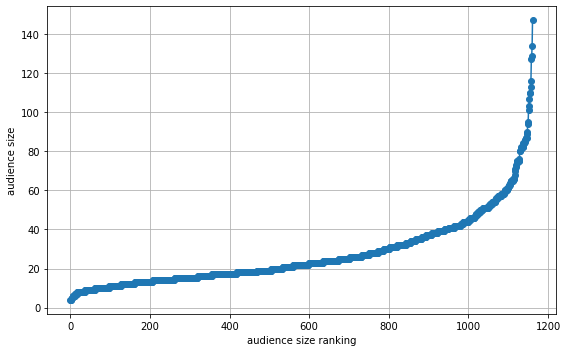

In [ ]:
audience_size = np.sum(truth, axis=0)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
ax.plot(range(len(audience_size)), np.sort(audience_size), marker='.', linewidth=1.5, markersize=12)
ax.set_ylabel('audience size')
ax.set_xlabel('audience size ranking')
ax.grid(True)
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()

In [ ]:
user_list, item_list = np.where(truth > 0)
truth_df = pd.DataFrame({'uid': user_list, 'iid': item_list})

In [ ]:
# count the number for each genre and sort
item_genre_dict = dict()
for i in range(len(item_df)):
    genre_str = item_df.at[i, 'genres']
    genre_overlap = set(genre_str).intersection(genres_used)
    item_genre_dict[item_df.at[i, 'iid']] = list(genre_overlap)

genre_item_count = dict()
for l in item_genre_dict:
  if not l in genre_item_count:
    genre_item_count[l] = 1
  else:
    genre_item_count[l] += 1

genre_count_sorted = sorted(genre_item_count.items(), key=operator.itemgetter(1), reverse=True)
genre_count_sorted

[(154, 1),
 (96, 1),
 (215, 1),
 (192, 1),
 (20, 1),
 (165, 1),
 (121, 1),
 (180, 1),
 (156, 1),
 (189, 1),
 (136, 1),
 (155, 1),
 (216, 1),
 (132, 1),
 (170, 1),
 (167, 1),
 (36, 1),
 (179, 1),
 (191, 1),
 (172, 1),
 (16, 1),
 (257, 1),
 (288, 1),
 (9, 1),
 (111, 1),
 (35, 1),
 (25, 1),
 (196, 1),
 (771, 1),
 (1056, 1),
 (43, 1),
 (554, 1),
 (105, 1),
 (561, 1),
 (1088, 1),
 (356, 1),
 (633, 1),
 (824, 1),
 (1059, 1),
 (2, 1),
 (70, 1),
 (324, 1),
 (674, 1),
 (678, 1),
 (639, 1),
 (758, 1),
 (1037, 1),
 (919, 1),
 (1124, 1),
 (347, 1),
 (591, 1),
 (534, 1),
 (270, 1),
 (871, 1),
 (1079, 1),
 (804, 1),
 (733, 1),
 (945, 1),
 (393, 1),
 (702, 1),
 (1032, 1),
 (938, 1),
 (1031, 1),
 (1077, 1),
 (901, 1),
 (1022, 1),
 (123, 1),
 (1135, 1),
 (389, 1),
 (838, 1),
 (184, 1),
 (1126, 1),
 (454, 1),
 (399, 1),
 (326, 1),
 (118, 1),
 (697, 1),
 (968, 1),
 (186, 1),
 (643, 1),
 (1109, 1),
 (698, 1),
 (703, 1),
 (354, 1),
 (649, 1),
 (800, 1),
 (463, 1),
 (668, 1),
 (780, 1),
 (942, 1),
 (921, 1)

In [ ]:
# calculate feedback/item_count for each genre
genre_rating_count = dict()
itemIds = truth_df['iid'].values
for i in range(len(itemIds)):
    itemId = itemIds[i]
    genres = item_genre_dict[itemId]
    for g in genres:
        if not g in genre_rating_count:
            genre_rating_count[g] = 1
        else:
            genre_rating_count[g] += 1

In [ ]:
np.save('/content/truth_airbnb.npy', truth)

In [ ]:
item_df.reset_index(drop=True, inplace=True)
item_df.to_csv('/content/item_df_airbnb.csv', index=False)

In [ ]:
with open('/content/item_genre_dict_airbnb.pkl', 'wb') as f:
    pickle.dump(item_genre_dict, f)

In [ ]:
# generate list of items users like in train, warm_vali, warm_test sets for each user

num_item = len(item_list)
num_user = len(user_list)

user_truth_like = [[] for _ in range(num_user)]

for u in tqdm(user_list):
    truth_u = truth[u, :]
    truth_u_like = (np.where(truth_u > 0)[0]).astype(int)    
    user_truth_like[u] = truth_u_like
    
np.save('/content/user_truth_like_airbnb.npy', np.array(user_truth_like))

100%|██████████| 31951/31951 [00:00<00:00, 165346.33it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]


In [ ]:
audience_size = np.sum(truth, axis=0)

AS_sorted = np.sort(audience_size)
num_item = len(AS_sorted)
np.sum(((np.arange(num_item) + 1.) * 2 - num_item - 1) * AS_sorted) / (num_item * np.sum(AS_sorted))

0.33606049948148337

#**Experiment_vanillaNS --> (Popular)**

**Upload MF_withoutPB.py and Simulation_withoutPB.py**

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings; warnings.simplefilter('ignore')  # Ignores Warnings for nicer Plots. Disable for Debugging
import time
import numpy as np
import argparse
from Simulation_withoutPB import Simulation


parser = argparse.ArgumentParser(description='Experiment_withoutPB')
parser.add_argument('--run', type=int, default=10, help='number of experiments to run')
parser.add_argument('--iteration', type=int, default=40000, help='number of iterations to simulate')
parser.add_argument('--exp', type=int, default=1, help='number of initial random exposure iterations')
parser.add_argument('--cycle_itr', type=int, default=50, help='number of iterations in one cycle')
parser.add_argument('--epoch', type=int, default=15, help='number of epochs to train')
parser.add_argument('--K', type=int, default=20, help='number of items to recommend')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate')
parser.add_argument('--reg', type=float, default=1e-5, help='regularization')
parser.add_argument('--hidden', type=int, default=100, help='latent dimension')
parser.add_argument('--neg', type=int, default=5, help='negative sampling rate')
parser.add_argument('--data', type=str, default='ml1m', help='path to eval in the Data folder')
parser.add_argument('--num_user', type=float, default=num_user, help='path to eval in the Data folder')
parser.add_argument('--num_item', type=float, default=num_item, help='path to eval in the Data folder')
parser.add_argument('-f')

args = parser.parse_args()

truth = np.load('/content/truth_airbnb.npy')
args.num_user = truth.shape[0]
args.num_item = truth.shape[1]
audience_size = np.sum(truth, axis=0)
item_sorted = np.argsort(audience_size)
truth_like = list(np.load('/content/user_truth_like_airbnb.npy', allow_pickle=True))

print('')
print('!' * 30 + ' Total truth ' + str(np.sum(truth)) + ' ' + '!' * 30)
print('')

itr_cumulated_click_count_list = []
itr_GC_TPR_list = []

for r in range(args.run):
    print('')
    print('#' * 100)
    print('#' * 100)
    print(' ' * 50 + ' Experiment run ' + str(r + 1) + ' ' * 50)
    print('#' * 100)
    print('#' * 100)
    simulation = Simulation(args, truth, truth_like)
    init_popularity = simulation.initial_iterations()
    itr_click_item = simulation.run_simulation()

    itr_cumulated_click_count = []
    itr_item_click = np.zeros((args.iteration, args.num_item))
    for itr in range(args.iteration):
        click_item = itr_click_item[itr]
        itr_item_click[itr, click_item] = 1.
        itr_cumulated_click_count.append(
            len(click_item) if itr == 0 else len(click_item) + itr_cumulated_click_count[-1])
    for itr in range(1, args.iteration):
        itr_item_click[itr, :] += itr_item_click[itr - 1, :]
    itr_item_click /= (audience_size - init_popularity).reshape((1, -1))

    itr_GC_TPR = []
    for itr in range(args.iteration):
        a = itr_item_click[itr, item_sorted]
        gc = np.sum(((np.arange(len(a)) + 1.) * 2 - len(a) - 1) * a) / (len(a) * np.sum(a))
        itr_GC_TPR.append(gc)

    itr_cumulated_click_count_list.append(itr_cumulated_click_count)
    itr_GC_TPR_list.append(itr_GC_TPR)

    itr_cumulated_click_count_mean = np.mean(itr_cumulated_click_count_list, axis=0)
    itr_cumulated_click_count_std = np.std(itr_cumulated_click_count_list, axis=0)
    itr_GC_TPR_mean = np.mean(itr_GC_TPR_list, axis=0)
    itr_GC_TPR_std = np.std(itr_GC_TPR_list, axis=0)



!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Total truth 31951.0 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


####################################################################################################
####################################################################################################
                                                   Experiment run 1                                                  
####################################################################################################
####################################################################################################
Namespace(K=20, cycle_itr=50, data='ml1m', epoch=15, exp=1, f='/root/.local/share/jupyter/runtime/kernel-fc381ba0-44ee-4a67-bf4c-ab92f3747d83.json', hidden=100, iteration=40000, lr=0.001, neg=5, num_item=1162, num_user=1000, reg=1e-05, run=10)
****************************** Start initial random iterations ******************************
---------- Iteration 1 ----------


100%|██████████| 1000/1000 [00:00<00:00, 3446.54it/s]


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Generate 214 records.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
****************************** Train MF until converge ******************************
Update bs to 25
******************************MF initialization done ******************************


100%|██████████| 51/51 [00:00<00:00, 87.72it/s] 


Training // Epoch 0 //  Total cost = 35.3518  Total cost1 = 35.3319  Total cost2 = 0.0199


100%|██████████| 51/51 [00:00<00:00, 119.28it/s]


Training // Epoch 1 //  Total cost = 35.0441  Total cost1 = 35.0302  Total cost2 = 0.0139


100%|██████████| 51/51 [00:00<00:00, 123.97it/s]


Training // Epoch 2 //  Total cost = 34.6099  Total cost1 = 34.5923  Total cost2 = 0.0176


100%|██████████| 51/51 [00:00<00:00, 125.13it/s]


Training // Epoch 3 //  Total cost = 33.8921  Total cost1 = 33.8683  Total cost2 = 0.0238


100%|██████████| 51/51 [00:00<00:00, 141.15it/s]


Training // Epoch 4 //  Total cost = 32.7999  Total cost1 = 32.7673  Total cost2 = 0.0326


100%|██████████| 51/51 [00:00<00:00, 125.39it/s]


Training // Epoch 5 //  Total cost = 31.2852  Total cost1 = 31.2412  Total cost2 = 0.0440


100%|██████████| 51/51 [00:00<00:00, 146.33it/s]


Training // Epoch 6 //  Total cost = 29.2287  Total cost1 = 29.1699  Total cost2 = 0.0588


100%|██████████| 51/51 [00:00<00:00, 120.37it/s]


Training // Epoch 7 //  Total cost = 26.6733  Total cost1 = 26.5969  Total cost2 = 0.0764


100%|██████████| 51/51 [00:00<00:00, 139.32it/s]


Training // Epoch 8 //  Total cost = 23.6274  Total cost1 = 23.5300  Total cost2 = 0.0974


100%|██████████| 51/51 [00:00<00:00, 145.92it/s]


Training // Epoch 9 //  Total cost = 20.1081  Total cost1 = 19.9869  Total cost2 = 0.1212


100%|██████████| 51/51 [00:00<00:00, 136.42it/s]


Training // Epoch 10 //  Total cost = 16.1314  Total cost1 = 15.9835  Total cost2 = 0.1479


100%|██████████| 51/51 [00:00<00:00, 141.17it/s]


Training // Epoch 11 //  Total cost = 11.7868  Total cost1 = 11.6091  Total cost2 = 0.1777


100%|██████████| 51/51 [00:00<00:00, 138.99it/s]


Training // Epoch 12 //  Total cost = 7.2339  Total cost1 = 7.0245  Total cost2 = 0.2094


100%|██████████| 51/51 [00:00<00:00, 141.15it/s]


Training // Epoch 13 //  Total cost = 2.3524  Total cost1 = 2.1075  Total cost2 = 0.2449


100%|██████████| 51/51 [00:00<00:00, 150.09it/s]


Training // Epoch 14 //  Total cost = -3.0821  Total cost1 = -3.3635  Total cost2 = 0.2814
****************************** Start simulation ******************************


100%|██████████| 50/50 [00:00<00:00, 2179.45it/s]


########## The iteration 50, up to now total 224 clicks, GC=-0.1938, this cycle used 0.04 s) ##########
Update bs to 26


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


100%|██████████| 50/50 [00:00<00:00, 1236.04it/s]


########## The iteration 100, up to now total 231 clicks, GC=0.0027, this cycle used 5.21 s) ##########
Update bs to 27


100%|██████████| 15/15 [00:05<00:00,  2.71it/s]


100%|██████████| 50/50 [00:00<00:00, 1711.47it/s]


########## The iteration 150, up to now total 241 clicks, GC=0.1104, this cycle used 5.64 s) ##########
Update bs to 28


100%|██████████| 15/15 [00:05<00:00,  2.88it/s]


100%|██████████| 50/50 [00:00<00:00, 2097.26it/s]


########## The iteration 200, up to now total 252 clicks, GC=0.1161, this cycle used 5.31 s) ##########
Update bs to 30


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


100%|██████████| 50/50 [00:00<00:00, 2205.72it/s]


########## The iteration 250, up to now total 260 clicks, GC=0.1745, this cycle used 5.18 s) ##########
Update bs to 31


100%|██████████| 15/15 [00:04<00:00,  3.18it/s]


100%|██████████| 50/50 [00:00<00:00, 1783.17it/s]


########## The iteration 300, up to now total 273 clicks, GC=0.1985, this cycle used 4.80 s) ##########
Update bs to 32


100%|██████████| 15/15 [00:04<00:00,  3.15it/s]


100%|██████████| 50/50 [00:00<00:00, 1587.27it/s]


########## The iteration 350, up to now total 287 clicks, GC=0.2682, this cycle used 4.86 s) ##########
Update bs to 34


100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


100%|██████████| 50/50 [00:00<00:00, 1944.02it/s]


########## The iteration 400, up to now total 302 clicks, GC=0.2599, this cycle used 5.86 s) ##########
Update bs to 36


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


100%|██████████| 50/50 [00:00<00:00, 1498.46it/s]


########## The iteration 450, up to now total 318 clicks, GC=0.2827, this cycle used 5.15 s) ##########
Update bs to 38


100%|██████████| 15/15 [00:05<00:00,  2.84it/s]


100%|██████████| 50/50 [00:00<00:00, 1805.43it/s]


########## The iteration 500, up to now total 332 clicks, GC=0.3102, this cycle used 5.38 s) ##########
Update bs to 39


100%|██████████| 15/15 [00:04<00:00,  3.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1786.24it/s]


########## The iteration 550, up to now total 346 clicks, GC=0.3433, this cycle used 4.57 s) ##########
Update bs to 41


100%|██████████| 15/15 [00:05<00:00,  2.77it/s]


100%|██████████| 50/50 [00:00<00:00, 2187.54it/s]


########## The iteration 600, up to now total 365 clicks, GC=0.3787, this cycle used 5.52 s) ##########
Update bs to 43


100%|██████████| 15/15 [00:05<00:00,  2.82it/s]


100%|██████████| 50/50 [00:00<00:00, 1135.52it/s]


########## The iteration 650, up to now total 376 clicks, GC=0.3726, this cycle used 5.45 s) ##########
Update bs to 45


100%|██████████| 15/15 [00:04<00:00,  3.04it/s]


100%|██████████| 50/50 [00:00<00:00, 2014.05it/s]


########## The iteration 700, up to now total 388 clicks, GC=0.3839, this cycle used 5.04 s) ##########
Update bs to 46


100%|██████████| 15/15 [00:04<00:00,  3.26it/s]


100%|██████████| 50/50 [00:00<00:00, 1804.44it/s]


########## The iteration 750, up to now total 393 clicks, GC=0.3752, this cycle used 4.71 s) ##########
Update bs to 47


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 1489.94it/s]


########## The iteration 800, up to now total 412 clicks, GC=0.3768, this cycle used 3.97 s) ##########
Update bs to 49


100%|██████████| 15/15 [00:04<00:00,  3.18it/s]


100%|██████████| 50/50 [00:00<00:00, 1533.03it/s]


########## The iteration 850, up to now total 422 clicks, GC=0.3770, this cycle used 4.84 s) ##########
Update bs to 50


100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


100%|██████████| 50/50 [00:00<00:00, 2428.33it/s]


########## The iteration 900, up to now total 431 clicks, GC=0.3883, this cycle used 6.22 s) ##########
Update bs to 51


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


100%|██████████| 50/50 [00:00<00:00, 1550.57it/s]


########## The iteration 950, up to now total 453 clicks, GC=0.4094, this cycle used 4.06 s) ##########
Update bs to 54


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


100%|██████████| 50/50 [00:00<00:00, 2099.25it/s]


########## The iteration 1000, up to now total 466 clicks, GC=0.4115, this cycle used 5.15 s) ##########
Update bs to 55


100%|██████████| 15/15 [00:04<00:00,  3.27it/s]


100%|██████████| 50/50 [00:00<00:00, 1648.22it/s]


########## The iteration 1050, up to now total 480 clicks, GC=0.4256, this cycle used 4.71 s) ##########
Update bs to 57


100%|██████████| 15/15 [00:04<00:00,  3.43it/s]


100%|██████████| 50/50 [00:00<00:00, 1077.52it/s]


########## The iteration 1100, up to now total 495 clicks, GC=0.4398, this cycle used 4.51 s) ##########
Update bs to 59


100%|██████████| 15/15 [00:08<00:00,  1.73it/s]


100%|██████████| 50/50 [00:00<00:00, 1448.81it/s]


########## The iteration 1150, up to now total 509 clicks, GC=0.4507, this cycle used 8.86 s) ##########
Update bs to 61


100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


100%|██████████| 50/50 [00:00<00:00, 1577.23it/s]


########## The iteration 1200, up to now total 533 clicks, GC=0.4634, this cycle used 3.91 s) ##########
Update bs to 63


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


100%|██████████| 50/50 [00:00<00:00, 1652.22it/s]


########## The iteration 1250, up to now total 539 clicks, GC=0.4654, this cycle used 3.56 s) ##########
Update bs to 64


100%|██████████| 15/15 [00:04<00:00,  3.02it/s]


100%|██████████| 50/50 [00:00<00:00, 1850.07it/s]


########## The iteration 1300, up to now total 556 clicks, GC=0.4682, this cycle used 5.09 s) ##########
Update bs to 66


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 1706.79it/s]


########## The iteration 1350, up to now total 568 clicks, GC=0.4765, this cycle used 3.66 s) ##########
Update bs to 68


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 1519.17it/s]


########## The iteration 1400, up to now total 574 clicks, GC=0.4659, this cycle used 3.69 s) ##########
Update bs to 68


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 1330.33it/s]


########## The iteration 1450, up to now total 590 clicks, GC=0.4640, this cycle used 3.64 s) ##########
Update bs to 70


100%|██████████| 15/15 [00:04<00:00,  3.14it/s]


100%|██████████| 50/50 [00:00<00:00, 2424.40it/s]


########## The iteration 1500, up to now total 601 clicks, GC=0.4566, this cycle used 4.90 s) ##########
Update bs to 72


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 1775.13it/s]


########## The iteration 1550, up to now total 617 clicks, GC=0.4513, this cycle used 3.79 s) ##########
Update bs to 74


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1152.31it/s]


########## The iteration 1600, up to now total 634 clicks, GC=0.4549, this cycle used 3.59 s) ##########
Update bs to 76


100%|██████████| 15/15 [00:04<00:00,  3.17it/s]


100%|██████████| 50/50 [00:00<00:00, 2231.49it/s]


########## The iteration 1650, up to now total 647 clicks, GC=0.4620, this cycle used 4.87 s) ##########
Update bs to 77


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 2283.63it/s]


########## The iteration 1700, up to now total 664 clicks, GC=0.4605, this cycle used 4.09 s) ##########
Update bs to 79


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 1432.52it/s]


########## The iteration 1750, up to now total 672 clicks, GC=0.4628, this cycle used 3.61 s) ##########
Update bs to 80


100%|██████████| 15/15 [00:04<00:00,  3.17it/s]


100%|██████████| 50/50 [00:00<00:00, 1416.46it/s]


########## The iteration 1800, up to now total 688 clicks, GC=0.4636, this cycle used 4.87 s) ##########
Update bs to 82


100%|██████████| 15/15 [00:04<00:00,  3.18it/s]


100%|██████████| 50/50 [00:00<00:00, 2214.45it/s]


########## The iteration 1850, up to now total 704 clicks, GC=0.4675, this cycle used 4.87 s) ##########
Update bs to 84


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 1592.76it/s]


########## The iteration 1900, up to now total 716 clicks, GC=0.4626, this cycle used 3.62 s) ##########
Update bs to 85


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 1594.45it/s]


########## The iteration 1950, up to now total 732 clicks, GC=0.4654, this cycle used 3.66 s) ##########
Update bs to 87


100%|██████████| 15/15 [00:04<00:00,  3.26it/s]


100%|██████████| 50/50 [00:00<00:00, 1700.22it/s]


########## The iteration 2000, up to now total 747 clicks, GC=0.4726, this cycle used 4.76 s) ##########
Update bs to 89


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 2149.07it/s]


########## The iteration 2050, up to now total 764 clicks, GC=0.4747, this cycle used 3.67 s) ##########
Update bs to 91


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 1639.39it/s]


########## The iteration 2100, up to now total 782 clicks, GC=0.4795, this cycle used 3.63 s) ##########
Update bs to 93


100%|██████████| 15/15 [00:04<00:00,  3.22it/s]


100%|██████████| 50/50 [00:00<00:00, 1291.01it/s]


########## The iteration 2150, up to now total 796 clicks, GC=0.4830, this cycle used 4.82 s) ##########
Update bs to 95


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 1267.47it/s]


########## The iteration 2200, up to now total 808 clicks, GC=0.4819, this cycle used 3.62 s) ##########
Update bs to 96


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 1799.76it/s]


########## The iteration 2250, up to now total 823 clicks, GC=0.4880, this cycle used 3.70 s) ##########
Update bs to 98


100%|██████████| 15/15 [00:04<00:00,  3.16it/s]


100%|██████████| 50/50 [00:00<00:00, 1755.39it/s]


########## The iteration 2300, up to now total 840 clicks, GC=0.4931, this cycle used 4.88 s) ##########
Update bs to 100


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 1617.91it/s]


########## The iteration 2350, up to now total 849 clicks, GC=0.4950, this cycle used 3.80 s) ##########
Update bs to 101


100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


100%|██████████| 50/50 [00:00<00:00, 2030.63it/s]


########## The iteration 2400, up to now total 865 clicks, GC=0.4994, this cycle used 3.57 s) ##########
Update bs to 103


100%|██████████| 15/15 [00:05<00:00,  2.85it/s]


100%|██████████| 50/50 [00:00<00:00, 1872.47it/s]


########## The iteration 2450, up to now total 879 clicks, GC=0.5015, this cycle used 5.41 s) ##########
Update bs to 105


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 1654.90it/s]


########## The iteration 2500, up to now total 892 clicks, GC=0.5056, this cycle used 3.79 s) ##########
Update bs to 107


100%|██████████| 15/15 [00:03<00:00,  4.39it/s]


100%|██████████| 50/50 [00:00<00:00, 1557.92it/s]


########## The iteration 2550, up to now total 914 clicks, GC=0.5066, this cycle used 3.58 s) ##########
Update bs to 109


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 1813.50it/s]


########## The iteration 2600, up to now total 926 clicks, GC=0.5071, this cycle used 3.72 s) ##########
Update bs to 111


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


100%|██████████| 50/50 [00:00<00:00, 1679.20it/s]


########## The iteration 2650, up to now total 938 clicks, GC=0.5058, this cycle used 4.42 s) ##########
Update bs to 112


100%|██████████| 15/15 [00:03<00:00,  4.46it/s]


100%|██████████| 50/50 [00:00<00:00, 1517.72it/s]


########## The iteration 2700, up to now total 955 clicks, GC=0.5003, this cycle used 3.53 s) ##########
Update bs to 114


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 1606.13it/s]


########## The iteration 2750, up to now total 965 clicks, GC=0.5008, this cycle used 3.71 s) ##########
Update bs to 115


100%|██████████| 15/15 [00:04<00:00,  3.16it/s]


100%|██████████| 50/50 [00:00<00:00, 1628.49it/s]


########## The iteration 2800, up to now total 977 clicks, GC=0.5019, this cycle used 4.92 s) ##########
Update bs to 117


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1396.71it/s]


########## The iteration 2850, up to now total 994 clicks, GC=0.4971, this cycle used 3.63 s) ##########
Update bs to 119


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 1711.84it/s]


########## The iteration 2900, up to now total 1008 clicks, GC=0.5007, this cycle used 3.70 s) ##########
Update bs to 120


100%|██████████| 15/15 [00:04<00:00,  3.22it/s]


100%|██████████| 50/50 [00:00<00:00, 1677.83it/s]


########## The iteration 2950, up to now total 1020 clicks, GC=0.5035, this cycle used 4.83 s) ##########
Update bs to 122


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 1497.61it/s]


########## The iteration 3000, up to now total 1037 clicks, GC=0.4998, this cycle used 3.64 s) ##########
Update bs to 124


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 1658.88it/s]


########## The iteration 3050, up to now total 1047 clicks, GC=0.4990, this cycle used 3.70 s) ##########
Update bs to 125


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 1932.00it/s]


########## The iteration 3100, up to now total 1069 clicks, GC=0.5022, this cycle used 3.65 s) ##########
Update bs to 128


100%|██████████| 15/15 [00:04<00:00,  3.22it/s]


100%|██████████| 50/50 [00:00<00:00, 1078.73it/s]


########## The iteration 3150, up to now total 1081 clicks, GC=0.5000, this cycle used 4.84 s) ##########
Update bs to 129


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 1804.76it/s]


########## The iteration 3200, up to now total 1095 clicks, GC=0.5002, this cycle used 3.71 s) ##########
Update bs to 131


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 1464.69it/s]


########## The iteration 3250, up to now total 1110 clicks, GC=0.4988, this cycle used 3.63 s) ##########
Update bs to 133


100%|██████████| 15/15 [00:04<00:00,  3.13it/s]


100%|██████████| 50/50 [00:00<00:00, 1111.34it/s]


########## The iteration 3300, up to now total 1123 clicks, GC=0.4904, this cycle used 4.98 s) ##########
Update bs to 134


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 1356.96it/s]


########## The iteration 3350, up to now total 1130 clicks, GC=0.4906, this cycle used 3.74 s) ##########
Update bs to 135


100%|██████████| 15/15 [00:04<00:00,  3.04it/s]


100%|██████████| 50/50 [00:00<00:00, 2208.16it/s]


########## The iteration 3400, up to now total 1145 clicks, GC=0.4921, this cycle used 5.11 s) ##########
Update bs to 137


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 1539.10it/s]


########## The iteration 3450, up to now total 1153 clicks, GC=0.4938, this cycle used 3.71 s) ##########
Update bs to 138


100%|██████████| 15/15 [00:04<00:00,  3.03it/s]


100%|██████████| 50/50 [00:00<00:00, 1348.01it/s]


########## The iteration 3500, up to now total 1166 clicks, GC=0.4955, this cycle used 5.13 s) ##########
Update bs to 139


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 1647.49it/s]


########## The iteration 3550, up to now total 1178 clicks, GC=0.4977, this cycle used 3.65 s) ##########
Update bs to 141


100%|██████████| 15/15 [00:04<00:00,  3.13it/s]


100%|██████████| 50/50 [00:00<00:00, 1220.70it/s]


########## The iteration 3600, up to now total 1198 clicks, GC=0.5022, this cycle used 4.98 s) ##########
Update bs to 143


100%|██████████| 15/15 [00:03<00:00,  4.46it/s]


100%|██████████| 50/50 [00:00<00:00, 1335.76it/s]


########## The iteration 3650, up to now total 1216 clicks, GC=0.5035, this cycle used 3.54 s) ##########
Update bs to 145


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 1303.16it/s]


########## The iteration 3700, up to now total 1232 clicks, GC=0.5051, this cycle used 3.65 s) ##########
Update bs to 147


100%|██████████| 15/15 [00:04<00:00,  3.06it/s]


100%|██████████| 50/50 [00:00<00:00, 1694.20it/s]


########## The iteration 3750, up to now total 1255 clicks, GC=0.5081, this cycle used 5.09 s) ##########
Update bs to 150


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 1628.41it/s]


########## The iteration 3800, up to now total 1266 clicks, GC=0.5109, this cycle used 3.77 s) ##########
Update bs to 151


100%|██████████| 15/15 [00:04<00:00,  3.09it/s]


100%|██████████| 50/50 [00:00<00:00, 1803.58it/s]


########## The iteration 3850, up to now total 1276 clicks, GC=0.5129, this cycle used 5.02 s) ##########
Update bs to 153


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 1837.77it/s]


########## The iteration 3900, up to now total 1289 clicks, GC=0.5160, this cycle used 3.68 s) ##########
Update bs to 154


100%|██████████| 15/15 [00:04<00:00,  3.08it/s]


100%|██████████| 50/50 [00:00<00:00, 1510.34it/s]


########## The iteration 3950, up to now total 1307 clicks, GC=0.5143, this cycle used 5.05 s) ##########
Update bs to 156


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 1352.07it/s]


########## The iteration 4000, up to now total 1322 clicks, GC=0.5152, this cycle used 3.74 s) ##########
Update bs to 158


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 1832.89it/s]


########## The iteration 4050, up to now total 1338 clicks, GC=0.5063, this cycle used 3.80 s) ##########
Update bs to 160


100%|██████████| 15/15 [00:04<00:00,  3.13it/s]


100%|██████████| 50/50 [00:00<00:00, 1447.73it/s]


########## The iteration 4100, up to now total 1352 clicks, GC=0.5074, this cycle used 4.97 s) ##########
Update bs to 162


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 1758.99it/s]


########## The iteration 4150, up to now total 1364 clicks, GC=0.5080, this cycle used 3.69 s) ##########
Update bs to 163


100%|██████████| 15/15 [00:04<00:00,  3.09it/s]


100%|██████████| 50/50 [00:00<00:00, 2244.79it/s]


########## The iteration 4200, up to now total 1383 clicks, GC=0.5061, this cycle used 5.04 s) ##########
Update bs to 165


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 1565.87it/s]


########## The iteration 4250, up to now total 1403 clicks, GC=0.5087, this cycle used 4.27 s) ##########
Update bs to 168


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 1576.08it/s]


########## The iteration 4300, up to now total 1416 clicks, GC=0.5076, this cycle used 3.81 s) ##########
Update bs to 169


100%|██████████| 15/15 [00:04<00:00,  3.27it/s]


100%|██████████| 50/50 [00:00<00:00, 1358.55it/s]


########## The iteration 4350, up to now total 1431 clicks, GC=0.5085, this cycle used 4.78 s) ##########
Update bs to 171


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 1271.69it/s]


########## The iteration 4400, up to now total 1442 clicks, GC=0.5107, this cycle used 3.91 s) ##########
Update bs to 173


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 1339.65it/s]


########## The iteration 4450, up to now total 1459 clicks, GC=0.5116, this cycle used 3.93 s) ##########
Update bs to 175


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 1922.48it/s]


########## The iteration 4500, up to now total 1469 clicks, GC=0.5133, this cycle used 3.90 s) ##########
Update bs to 176


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 1207.56it/s]


########## The iteration 4550, up to now total 1478 clicks, GC=0.5141, this cycle used 3.87 s) ##########
Update bs to 177


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1392.08it/s]


########## The iteration 4600, up to now total 1491 clicks, GC=0.5141, this cycle used 3.82 s) ##########
Update bs to 178


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 1180.54it/s]


########## The iteration 4650, up to now total 1506 clicks, GC=0.5127, this cycle used 3.86 s) ##########
Update bs to 180


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 1464.21it/s]


########## The iteration 4700, up to now total 1521 clicks, GC=0.5147, this cycle used 3.73 s) ##########
Update bs to 182


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 953.44it/s]


########## The iteration 4750, up to now total 1541 clicks, GC=0.5163, this cycle used 3.81 s) ##########
Update bs to 184


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 1309.21it/s]


########## The iteration 4800, up to now total 1553 clicks, GC=0.5155, this cycle used 3.89 s) ##########
Update bs to 186


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1888.99it/s]


########## The iteration 4850, up to now total 1569 clicks, GC=0.5165, this cycle used 3.82 s) ##########
Update bs to 188


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 1469.72it/s]


########## The iteration 4900, up to now total 1582 clicks, GC=0.5188, this cycle used 3.80 s) ##########
Update bs to 189


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 1397.75it/s]


########## The iteration 4950, up to now total 1597 clicks, GC=0.5194, this cycle used 4.20 s) ##########
Update bs to 191


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 1444.46it/s]


########## The iteration 5000, up to now total 1616 clicks, GC=0.5206, this cycle used 3.95 s) ##########
Update bs to 193


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 1768.99it/s]


########## The iteration 5050, up to now total 1627 clicks, GC=0.5214, this cycle used 3.84 s) ##########
Update bs to 195


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 1081.66it/s]


########## The iteration 5100, up to now total 1635 clicks, GC=0.5223, this cycle used 4.30 s) ##########
Update bs to 196


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1238.63it/s]


########## The iteration 5150, up to now total 1641 clicks, GC=0.5218, this cycle used 3.82 s) ##########
Update bs to 196


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 1446.30it/s]


########## The iteration 5200, up to now total 1652 clicks, GC=0.5236, this cycle used 3.80 s) ##########
Update bs to 198


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


100%|██████████| 50/50 [00:00<00:00, 1437.73it/s]


########## The iteration 5250, up to now total 1666 clicks, GC=0.5218, this cycle used 4.45 s) ##########
Update bs to 199


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 1350.24it/s]


########## The iteration 5300, up to now total 1673 clicks, GC=0.5214, this cycle used 3.77 s) ##########
Update bs to 200


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 990.59it/s]


########## The iteration 5350, up to now total 1685 clicks, GC=0.5212, this cycle used 3.83 s) ##########
Update bs to 202


100%|██████████| 15/15 [00:04<00:00,  3.34it/s]


100%|██████████| 50/50 [00:00<00:00, 1132.70it/s]


########## The iteration 5400, up to now total 1699 clicks, GC=0.5152, this cycle used 4.70 s) ##########
Update bs to 203


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 1291.50it/s]


########## The iteration 5450, up to now total 1711 clicks, GC=0.5145, this cycle used 3.79 s) ##########
Update bs to 205


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1419.62it/s]


########## The iteration 5500, up to now total 1722 clicks, GC=0.5139, this cycle used 3.66 s) ##########
Update bs to 206


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


100%|██████████| 50/50 [00:00<00:00, 1597.82it/s]


########## The iteration 5550, up to now total 1730 clicks, GC=0.5147, this cycle used 4.40 s) ##########
Update bs to 207


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 1298.49it/s]


########## The iteration 5600, up to now total 1750 clicks, GC=0.5161, this cycle used 3.76 s) ##########
Update bs to 210


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 1309.38it/s]


########## The iteration 5650, up to now total 1761 clicks, GC=0.5165, this cycle used 3.73 s) ##########
Update bs to 211


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 1060.58it/s]


########## The iteration 5700, up to now total 1777 clicks, GC=0.5136, this cycle used 4.12 s) ##########
Update bs to 213


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 1366.66it/s]


########## The iteration 5750, up to now total 1788 clicks, GC=0.5109, this cycle used 3.78 s) ##########
Update bs to 214


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 1287.92it/s]


########## The iteration 5800, up to now total 1805 clicks, GC=0.5114, this cycle used 3.78 s) ##########
Update bs to 216


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 1348.60it/s]


########## The iteration 5850, up to now total 1814 clicks, GC=0.5101, this cycle used 3.88 s) ##########
Update bs to 217


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 1302.18it/s]


########## The iteration 5900, up to now total 1825 clicks, GC=0.5077, this cycle used 3.77 s) ##########
Update bs to 219


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 1421.28it/s]


########## The iteration 5950, up to now total 1843 clicks, GC=0.5088, this cycle used 3.83 s) ##########
Update bs to 221


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 990.15it/s]


########## The iteration 6000, up to now total 1853 clicks, GC=0.5077, this cycle used 3.69 s) ##########
Update bs to 222


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 1648.00it/s]


########## The iteration 6050, up to now total 1866 clicks, GC=0.5096, this cycle used 3.79 s) ##########
Update bs to 223


100%|██████████| 15/15 [00:04<00:00,  3.50it/s]


100%|██████████| 50/50 [00:00<00:00, 1387.34it/s]


########## The iteration 6100, up to now total 1881 clicks, GC=0.5115, this cycle used 4.50 s) ##########
Update bs to 225


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 1222.26it/s]


########## The iteration 6150, up to now total 1894 clicks, GC=0.5117, this cycle used 3.86 s) ##########
Update bs to 227


100%|██████████| 15/15 [00:04<00:00,  3.31it/s]


100%|██████████| 50/50 [00:00<00:00, 1094.81it/s]


########## The iteration 6200, up to now total 1901 clicks, GC=0.5112, this cycle used 4.76 s) ##########
Update bs to 228


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 1736.25it/s]


########## The iteration 6250, up to now total 1912 clicks, GC=0.5122, this cycle used 3.80 s) ##########
Update bs to 229


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 1150.91it/s]


########## The iteration 6300, up to now total 1923 clicks, GC=0.5137, this cycle used 3.80 s) ##########
Update bs to 230


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 1278.78it/s]


########## The iteration 6350, up to now total 1932 clicks, GC=0.5145, this cycle used 3.91 s) ##########
Update bs to 231


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 1271.02it/s]


########## The iteration 6400, up to now total 1952 clicks, GC=0.5172, this cycle used 3.93 s) ##########
Update bs to 234


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 1234.91it/s]


########## The iteration 6450, up to now total 1957 clicks, GC=0.5172, this cycle used 3.92 s) ##########
Update bs to 234


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 1511.76it/s]


########## The iteration 6500, up to now total 1970 clicks, GC=0.5129, this cycle used 3.86 s) ##########
Update bs to 236


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 1300.50it/s]


########## The iteration 6550, up to now total 1982 clicks, GC=0.5117, this cycle used 3.85 s) ##########
Update bs to 237


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 1674.01it/s]


########## The iteration 6600, up to now total 1999 clicks, GC=0.5135, this cycle used 3.77 s) ##########
Update bs to 239


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 1194.06it/s]


########## The iteration 6650, up to now total 2010 clicks, GC=0.5118, this cycle used 3.84 s) ##########
Update bs to 241


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 1771.90it/s]


########## The iteration 6700, up to now total 2025 clicks, GC=0.5106, this cycle used 3.76 s) ##########
Update bs to 243


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 1453.40it/s]


########## The iteration 6750, up to now total 2041 clicks, GC=0.5116, this cycle used 3.76 s) ##########
Update bs to 244


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 1191.08it/s]


########## The iteration 6800, up to now total 2053 clicks, GC=0.5115, this cycle used 3.84 s) ##########
Update bs to 246


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 1097.45it/s]


########## The iteration 6850, up to now total 2060 clicks, GC=0.5125, this cycle used 3.75 s) ##########
Update bs to 247


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 1206.49it/s]


########## The iteration 6900, up to now total 2072 clicks, GC=0.5132, this cycle used 3.77 s) ##########
Update bs to 248


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 1260.10it/s]


########## The iteration 6950, up to now total 2080 clicks, GC=0.5135, this cycle used 3.81 s) ##########
Update bs to 249


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 1251.31it/s]


########## The iteration 7000, up to now total 2087 clicks, GC=0.5129, this cycle used 3.86 s) ##########
Update bs to 250


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 1541.86it/s]


########## The iteration 7050, up to now total 2099 clicks, GC=0.5141, this cycle used 3.80 s) ##########
Update bs to 251


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 1508.35it/s]


########## The iteration 7100, up to now total 2109 clicks, GC=0.5135, this cycle used 4.00 s) ##########
Update bs to 253


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 1482.82it/s]


########## The iteration 7150, up to now total 2123 clicks, GC=0.5147, this cycle used 3.92 s) ##########
Update bs to 254


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 1754.28it/s]


########## The iteration 7200, up to now total 2138 clicks, GC=0.5144, this cycle used 3.90 s) ##########
Update bs to 256


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 1220.21it/s]


########## The iteration 7250, up to now total 2149 clicks, GC=0.5157, this cycle used 3.94 s) ##########
Update bs to 257


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 1327.66it/s]


########## The iteration 7300, up to now total 2163 clicks, GC=0.5156, this cycle used 3.96 s) ##########
Update bs to 259


100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


100%|██████████| 50/50 [00:00<00:00, 1292.83it/s]


########## The iteration 7350, up to now total 2174 clicks, GC=0.5160, this cycle used 4.02 s) ##########
Update bs to 260


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 2178.04it/s]


########## The iteration 7400, up to now total 2190 clicks, GC=0.5172, this cycle used 3.93 s) ##########
Update bs to 262


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 1418.64it/s]


########## The iteration 7450, up to now total 2198 clicks, GC=0.5181, this cycle used 3.88 s) ##########
Update bs to 263


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 1127.80it/s]


########## The iteration 7500, up to now total 2208 clicks, GC=0.5192, this cycle used 3.92 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 1244.66it/s]


########## The iteration 7550, up to now total 2222 clicks, GC=0.5198, this cycle used 3.96 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1382.94it/s]


########## The iteration 7600, up to now total 2229 clicks, GC=0.5193, this cycle used 3.84 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1308.68it/s]


########## The iteration 7650, up to now total 2246 clicks, GC=0.5208, this cycle used 4.35 s) ##########
Update bs to 269


100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


100%|██████████| 50/50 [00:00<00:00, 1210.41it/s]


########## The iteration 7700, up to now total 2256 clicks, GC=0.5215, this cycle used 4.10 s) ##########
Update bs to 270


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 1421.16it/s]


########## The iteration 7750, up to now total 2267 clicks, GC=0.5204, this cycle used 3.97 s) ##########
Update bs to 272


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 1282.80it/s]


########## The iteration 7800, up to now total 2280 clicks, GC=0.5219, this cycle used 3.93 s) ##########
Update bs to 273


100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


100%|██████████| 50/50 [00:00<00:00, 1031.82it/s]


########## The iteration 7850, up to now total 2288 clicks, GC=0.5213, this cycle used 4.02 s) ##########
Update bs to 274


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1564.98it/s]


########## The iteration 7900, up to now total 2304 clicks, GC=0.5193, this cycle used 3.86 s) ##########
Update bs to 276


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 1100.57it/s]


########## The iteration 7950, up to now total 2317 clicks, GC=0.5190, this cycle used 3.95 s) ##########
Update bs to 278


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 1245.85it/s]


########## The iteration 8000, up to now total 2329 clicks, GC=0.5173, this cycle used 3.96 s) ##########
Update bs to 279


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 1137.72it/s]


########## The iteration 8050, up to now total 2342 clicks, GC=0.5185, this cycle used 3.95 s) ##########
Update bs to 281


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 1354.81it/s]


########## The iteration 8100, up to now total 2351 clicks, GC=0.5161, this cycle used 3.99 s) ##########
Update bs to 282


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 979.80it/s]


########## The iteration 8150, up to now total 2359 clicks, GC=0.5171, this cycle used 3.92 s) ##########
Update bs to 283


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 1393.96it/s]


########## The iteration 8200, up to now total 2371 clicks, GC=0.5169, this cycle used 3.97 s) ##########
Update bs to 284


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 1137.71it/s]


########## The iteration 8250, up to now total 2381 clicks, GC=0.5162, this cycle used 4.03 s) ##########
Update bs to 285


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


100%|██████████| 50/50 [00:00<00:00, 1223.31it/s]


########## The iteration 8300, up to now total 2400 clicks, GC=0.5168, this cycle used 4.07 s) ##########
Update bs to 288


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 1289.87it/s]


########## The iteration 8350, up to now total 2413 clicks, GC=0.5177, this cycle used 3.99 s) ##########
Update bs to 289


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 1314.43it/s]


########## The iteration 8400, up to now total 2422 clicks, GC=0.5187, this cycle used 4.00 s) ##########
Update bs to 290


100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


100%|██████████| 50/50 [00:00<00:00, 1776.54it/s]


########## The iteration 8450, up to now total 2438 clicks, GC=0.5189, this cycle used 4.04 s) ##########
Update bs to 292


100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


100%|██████████| 50/50 [00:00<00:00, 1235.14it/s]


########## The iteration 8500, up to now total 2447 clicks, GC=0.5184, this cycle used 4.06 s) ##########
Update bs to 293


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 1264.75it/s]


########## The iteration 8550, up to now total 2456 clicks, GC=0.5189, this cycle used 4.15 s) ##########
Update bs to 294


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 853.00it/s]


########## The iteration 8600, up to now total 2467 clicks, GC=0.5193, this cycle used 4.36 s) ##########
Update bs to 296


100%|██████████| 15/15 [00:07<00:00,  1.96it/s]


100%|██████████| 50/50 [00:00<00:00, 1234.18it/s]


########## The iteration 8650, up to now total 2472 clicks, GC=0.5188, this cycle used 7.93 s) ##########
Update bs to 296


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 1442.19it/s]


########## The iteration 8700, up to now total 2485 clicks, GC=0.5198, this cycle used 4.17 s) ##########
Update bs to 298


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 1069.86it/s]


########## The iteration 8750, up to now total 2498 clicks, GC=0.5190, this cycle used 4.25 s) ##########
Update bs to 299


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1127.07it/s]


########## The iteration 8800, up to now total 2509 clicks, GC=0.5197, this cycle used 4.40 s) ##########
Update bs to 301


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


100%|██████████| 50/50 [00:00<00:00, 1227.50it/s]


########## The iteration 8850, up to now total 2520 clicks, GC=0.5207, this cycle used 4.43 s) ##########
Update bs to 302


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 957.12it/s]


########## The iteration 8900, up to now total 2524 clicks, GC=0.5208, this cycle used 4.34 s) ##########
Update bs to 302


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 1072.51it/s]


########## The iteration 8950, up to now total 2534 clicks, GC=0.5215, this cycle used 4.38 s) ##########
Update bs to 304


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 1184.89it/s]


########## The iteration 9000, up to now total 2542 clicks, GC=0.5215, this cycle used 4.28 s) ##########
Update bs to 305


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 1562.36it/s]


########## The iteration 9050, up to now total 2551 clicks, GC=0.5204, this cycle used 4.20 s) ##########
Update bs to 306


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


100%|██████████| 50/50 [00:00<00:00, 966.38it/s]


########## The iteration 9100, up to now total 2560 clicks, GC=0.5201, this cycle used 4.18 s) ##########
Update bs to 307


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 1294.27it/s]


########## The iteration 9150, up to now total 2570 clicks, GC=0.5207, this cycle used 4.17 s) ##########
Update bs to 308


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 1124.60it/s]


########## The iteration 9200, up to now total 2579 clicks, GC=0.5215, this cycle used 4.28 s) ##########
Update bs to 309


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 1179.24it/s]


########## The iteration 9250, up to now total 2588 clicks, GC=0.5206, this cycle used 4.35 s) ##########
Update bs to 310


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 1068.89it/s]


########## The iteration 9300, up to now total 2596 clicks, GC=0.5209, this cycle used 4.36 s) ##########
Update bs to 311


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 1011.46it/s]


########## The iteration 9350, up to now total 2605 clicks, GC=0.5215, this cycle used 4.20 s) ##########
Update bs to 312


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1211.10it/s]


########## The iteration 9400, up to now total 2613 clicks, GC=0.5209, this cycle used 4.42 s) ##########
Update bs to 313


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1234.80it/s]


########## The iteration 9450, up to now total 2623 clicks, GC=0.5194, this cycle used 4.41 s) ##########
Update bs to 314


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1503.66it/s]


########## The iteration 9500, up to now total 2638 clicks, GC=0.5203, this cycle used 4.38 s) ##########
Update bs to 316


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 1327.16it/s]


########## The iteration 9550, up to now total 2652 clicks, GC=0.5194, this cycle used 4.35 s) ##########
Update bs to 318


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


100%|██████████| 50/50 [00:00<00:00, 991.24it/s]


########## The iteration 9600, up to now total 2662 clicks, GC=0.5176, this cycle used 4.47 s) ##########
Update bs to 319


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 1219.69it/s]


########## The iteration 9650, up to now total 2674 clicks, GC=0.5175, this cycle used 4.35 s) ##########
Update bs to 320


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


100%|██████████| 50/50 [00:00<00:00, 941.74it/s]


########## The iteration 9700, up to now total 2685 clicks, GC=0.5137, this cycle used 4.43 s) ##########
Update bs to 322


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1207.36it/s]


########## The iteration 9750, up to now total 2697 clicks, GC=0.5130, this cycle used 4.39 s) ##########
Update bs to 323


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 1051.28it/s]


########## The iteration 9800, up to now total 2705 clicks, GC=0.5122, this cycle used 4.27 s) ##########
Update bs to 324


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


100%|██████████| 50/50 [00:00<00:00, 1088.35it/s]


########## The iteration 9850, up to now total 2716 clicks, GC=0.5117, this cycle used 4.09 s) ##########
Update bs to 325


100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 1288.13it/s]


########## The iteration 9900, up to now total 2727 clicks, GC=0.5126, this cycle used 4.27 s) ##########
Update bs to 327


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 1390.81it/s]


########## The iteration 9950, up to now total 2736 clicks, GC=0.5116, this cycle used 4.15 s) ##########
Update bs to 328


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 1246.19it/s]


########## The iteration 10000, up to now total 2743 clicks, GC=0.5106, this cycle used 4.15 s) ##########
Update bs to 329


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 1045.85it/s]


########## The iteration 10050, up to now total 2754 clicks, GC=0.5113, this cycle used 4.21 s) ##########
Update bs to 330


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


100%|██████████| 50/50 [00:00<00:00, 1295.47it/s]


########## The iteration 10100, up to now total 2766 clicks, GC=0.5120, this cycle used 4.04 s) ##########
Update bs to 331


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 1405.69it/s]


########## The iteration 10150, up to now total 2775 clicks, GC=0.5118, this cycle used 4.22 s) ##########
Update bs to 333


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 1076.40it/s]


########## The iteration 10200, up to now total 2786 clicks, GC=0.5127, this cycle used 4.15 s) ##########
Update bs to 334


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 1147.19it/s]


########## The iteration 10250, up to now total 2796 clicks, GC=0.5136, this cycle used 4.15 s) ##########
Update bs to 335


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 992.73it/s]


########## The iteration 10300, up to now total 2810 clicks, GC=0.5147, this cycle used 4.23 s) ##########
Update bs to 337


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 1459.54it/s]


########## The iteration 10350, up to now total 2821 clicks, GC=0.5154, this cycle used 4.02 s) ##########
Update bs to 338


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


100%|██████████| 50/50 [00:00<00:00, 966.47it/s]


########## The iteration 10400, up to now total 2832 clicks, GC=0.5114, this cycle used 4.13 s) ##########
Update bs to 339


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 1252.55it/s]


########## The iteration 10450, up to now total 2842 clicks, GC=0.5106, this cycle used 4.22 s) ##########
Update bs to 341


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 1347.79it/s]


########## The iteration 10500, up to now total 2851 clicks, GC=0.5107, this cycle used 3.99 s) ##########
Update bs to 342


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 1218.51it/s]


########## The iteration 10550, up to now total 2861 clicks, GC=0.5106, this cycle used 4.24 s) ##########
Update bs to 343


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 1294.73it/s]


########## The iteration 10600, up to now total 2870 clicks, GC=0.5114, this cycle used 4.22 s) ##########
Update bs to 344


100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


100%|██████████| 50/50 [00:00<00:00, 1087.63it/s]


########## The iteration 10650, up to now total 2883 clicks, GC=0.5116, this cycle used 4.06 s) ##########
Update bs to 345


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 1488.80it/s]


########## The iteration 10700, up to now total 2891 clicks, GC=0.5121, this cycle used 4.14 s) ##########
Update bs to 346


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 1324.18it/s]


########## The iteration 10750, up to now total 2900 clicks, GC=0.5124, this cycle used 4.01 s) ##########
Update bs to 348


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


100%|██████████| 50/50 [00:00<00:00, 1235.48it/s]


########## The iteration 10800, up to now total 2915 clicks, GC=0.5132, this cycle used 4.10 s) ##########
Update bs to 349


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 1468.60it/s]


########## The iteration 10850, up to now total 2924 clicks, GC=0.5138, this cycle used 4.26 s) ##########
Update bs to 350


100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


100%|██████████| 50/50 [00:00<00:00, 1527.78it/s]


########## The iteration 10900, up to now total 2934 clicks, GC=0.5146, this cycle used 4.08 s) ##########
Update bs to 352


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


100%|██████████| 50/50 [00:00<00:00, 890.34it/s]


########## The iteration 10950, up to now total 2942 clicks, GC=0.5117, this cycle used 4.53 s) ##########
Update bs to 353


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 1132.59it/s]


########## The iteration 11000, up to now total 2953 clicks, GC=0.5112, this cycle used 4.21 s) ##########
Update bs to 354


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 1117.47it/s]


########## The iteration 11050, up to now total 2961 clicks, GC=0.5115, this cycle used 4.28 s) ##########
Update bs to 355


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 1373.09it/s]


########## The iteration 11100, up to now total 2971 clicks, GC=0.5115, this cycle used 4.23 s) ##########
Update bs to 356


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 1139.00it/s]


########## The iteration 11150, up to now total 2980 clicks, GC=0.5114, this cycle used 4.25 s) ##########
Update bs to 357


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 990.21it/s]


########## The iteration 11200, up to now total 2990 clicks, GC=0.5116, this cycle used 4.25 s) ##########
Update bs to 358


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 1076.49it/s]


########## The iteration 11250, up to now total 2998 clicks, GC=0.5111, this cycle used 4.29 s) ##########
Update bs to 359


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 1395.45it/s]


########## The iteration 11300, up to now total 3009 clicks, GC=0.5120, this cycle used 4.28 s) ##########
Update bs to 361


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 1222.76it/s]


########## The iteration 11350, up to now total 3023 clicks, GC=0.5130, this cycle used 4.39 s) ##########
Update bs to 362


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 986.91it/s]


########## The iteration 11400, up to now total 3031 clicks, GC=0.5136, this cycle used 4.32 s) ##########
Update bs to 363


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 1399.71it/s]


########## The iteration 11450, up to now total 3041 clicks, GC=0.5143, this cycle used 4.32 s) ##########
Update bs to 364


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 1297.11it/s]


########## The iteration 11500, up to now total 3049 clicks, GC=0.5149, this cycle used 4.28 s) ##########
Update bs to 365


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 1377.08it/s]


########## The iteration 11550, up to now total 3057 clicks, GC=0.5150, this cycle used 4.29 s) ##########
Update bs to 366


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 1024.15it/s]


########## The iteration 11600, up to now total 3062 clicks, GC=0.5153, this cycle used 4.33 s) ##########
Update bs to 367


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


100%|██████████| 50/50 [00:00<00:00, 1335.60it/s]


########## The iteration 11650, up to now total 3074 clicks, GC=0.5158, this cycle used 4.10 s) ##########
Update bs to 368


100%|██████████| 15/15 [00:04<00:00,  3.09it/s]


100%|██████████| 50/50 [00:00<00:00, 664.37it/s]


########## The iteration 11700, up to now total 3089 clicks, GC=0.5141, this cycle used 5.20 s) ##########
Update bs to 370


100%|██████████| 15/15 [00:08<00:00,  1.79it/s]


100%|██████████| 50/50 [00:00<00:00, 724.12it/s]


########## The iteration 11750, up to now total 3099 clicks, GC=0.5148, this cycle used 9.02 s) ##########
Update bs to 371


100%|██████████| 15/15 [00:07<00:00,  1.93it/s]


100%|██████████| 50/50 [00:00<00:00, 604.94it/s]


########## The iteration 11800, up to now total 3107 clicks, GC=0.5130, this cycle used 8.28 s) ##########
Update bs to 372


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 1244.16it/s]


########## The iteration 11850, up to now total 3110 clicks, GC=0.5131, this cycle used 4.31 s) ##########
Update bs to 373


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 1306.45it/s]


########## The iteration 11900, up to now total 3123 clicks, GC=0.5127, this cycle used 4.29 s) ##########
Update bs to 374


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


100%|██████████| 50/50 [00:00<00:00, 1186.42it/s]


########## The iteration 11950, up to now total 3134 clicks, GC=0.5125, this cycle used 4.23 s) ##########
Update bs to 376


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 1237.61it/s]


########## The iteration 12000, up to now total 3141 clicks, GC=0.5127, this cycle used 4.18 s) ##########
Update bs to 376


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 1161.87it/s]


########## The iteration 12050, up to now total 3148 clicks, GC=0.5116, this cycle used 4.27 s) ##########
Update bs to 377


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


100%|██████████| 50/50 [00:00<00:00, 1169.34it/s]


########## The iteration 12100, up to now total 3157 clicks, GC=0.5119, this cycle used 4.17 s) ##########
Update bs to 378


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 1217.22it/s]


########## The iteration 12150, up to now total 3168 clicks, GC=0.5124, this cycle used 4.30 s) ##########
Update bs to 380


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 1440.88it/s]


########## The iteration 12200, up to now total 3178 clicks, GC=0.5116, this cycle used 4.28 s) ##########
Update bs to 381


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 953.55it/s]


########## The iteration 12250, up to now total 3189 clicks, GC=0.5122, this cycle used 4.21 s) ##########
Update bs to 382


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 1163.55it/s]


########## The iteration 12300, up to now total 3198 clicks, GC=0.5113, this cycle used 4.26 s) ##########
Update bs to 383


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 1281.82it/s]


########## The iteration 12350, up to now total 3207 clicks, GC=0.5114, this cycle used 4.31 s) ##########
Update bs to 384


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


100%|██████████| 50/50 [00:00<00:00, 1290.88it/s]


########## The iteration 12400, up to now total 3220 clicks, GC=0.5117, this cycle used 4.21 s) ##########
Update bs to 386


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1170.27it/s]


########## The iteration 12450, up to now total 3236 clicks, GC=0.5128, this cycle used 4.54 s) ##########
Update bs to 388


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 1048.42it/s]


########## The iteration 12500, up to now total 3242 clicks, GC=0.5128, this cycle used 4.35 s) ##########
Update bs to 389


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 1079.59it/s]


########## The iteration 12550, up to now total 3248 clicks, GC=0.5130, this cycle used 4.37 s) ##########
Update bs to 389


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 1197.90it/s]


########## The iteration 12600, up to now total 3255 clicks, GC=0.5136, this cycle used 4.35 s) ##########
Update bs to 390


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 1318.00it/s]


########## The iteration 12650, up to now total 3267 clicks, GC=0.5144, this cycle used 4.40 s) ##########
Update bs to 392


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 1398.35it/s]


########## The iteration 12700, up to now total 3276 clicks, GC=0.5151, this cycle used 4.34 s) ##########
Update bs to 393


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 992.73it/s]


########## The iteration 12750, up to now total 3284 clicks, GC=0.5157, this cycle used 4.37 s) ##########
Update bs to 394


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 1036.54it/s]


########## The iteration 12800, up to now total 3292 clicks, GC=0.5163, this cycle used 4.35 s) ##########
Update bs to 395


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 1466.70it/s]


########## The iteration 12850, up to now total 3300 clicks, GC=0.5166, this cycle used 4.39 s) ##########
Update bs to 396


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 1222.76it/s]


########## The iteration 12900, up to now total 3311 clicks, GC=0.5174, this cycle used 4.31 s) ##########
Update bs to 397


100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


100%|██████████| 50/50 [00:00<00:00, 504.51it/s]


########## The iteration 12950, up to now total 3317 clicks, GC=0.5168, this cycle used 5.77 s) ##########
Update bs to 398


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 1594.66it/s]


########## The iteration 13000, up to now total 3325 clicks, GC=0.5171, this cycle used 4.64 s) ##########
Update bs to 399


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


100%|██████████| 50/50 [00:00<00:00, 1312.96it/s]


########## The iteration 13050, up to now total 3329 clicks, GC=0.5171, this cycle used 4.26 s) ##########
Update bs to 399


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 1226.78it/s]


########## The iteration 13100, up to now total 3344 clicks, GC=0.5171, this cycle used 4.33 s) ##########
Update bs to 401


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 1110.68it/s]


########## The iteration 13150, up to now total 3353 clicks, GC=0.5175, this cycle used 4.31 s) ##########
Update bs to 402


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 1396.24it/s]


########## The iteration 13200, up to now total 3361 clicks, GC=0.5175, this cycle used 4.23 s) ##########
Update bs to 403


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 896.90it/s]


########## The iteration 13250, up to now total 3370 clicks, GC=0.5176, this cycle used 4.24 s) ##########
Update bs to 404


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 1193.46it/s]


########## The iteration 13300, up to now total 3376 clicks, GC=0.5181, this cycle used 4.25 s) ##########
Update bs to 405


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 1368.10it/s]


########## The iteration 13350, up to now total 3385 clicks, GC=0.5183, this cycle used 4.32 s) ##########
Update bs to 406


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


100%|██████████| 50/50 [00:00<00:00, 1296.43it/s]


########## The iteration 13400, up to now total 3395 clicks, GC=0.5190, this cycle used 4.15 s) ##########
Update bs to 407


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


100%|██████████| 50/50 [00:00<00:00, 1222.86it/s]


########## The iteration 13450, up to now total 3408 clicks, GC=0.5190, this cycle used 4.15 s) ##########
Update bs to 408


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


100%|██████████| 50/50 [00:00<00:00, 961.82it/s]


########## The iteration 13500, up to now total 3411 clicks, GC=0.5192, this cycle used 4.15 s) ##########
Update bs to 409


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 1227.39it/s]


########## The iteration 13550, up to now total 3419 clicks, GC=0.5187, this cycle used 4.26 s) ##########
Update bs to 410


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 1137.64it/s]


########## The iteration 13600, up to now total 3430 clicks, GC=0.5185, this cycle used 4.34 s) ##########
Update bs to 411


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 1167.17it/s]


########## The iteration 13650, up to now total 3435 clicks, GC=0.5189, this cycle used 4.35 s) ##########
Update bs to 412


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 941.99it/s]


########## The iteration 13700, up to now total 3443 clicks, GC=0.5193, this cycle used 4.36 s) ##########
Update bs to 413


100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 1159.19it/s]


########## The iteration 13750, up to now total 3455 clicks, GC=0.5199, this cycle used 4.33 s) ##########
Update bs to 414


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 1381.79it/s]


########## The iteration 13800, up to now total 3462 clicks, GC=0.5205, this cycle used 4.33 s) ##########
Update bs to 415


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 1134.33it/s]


########## The iteration 13850, up to now total 3468 clicks, GC=0.5209, this cycle used 4.34 s) ##########
Update bs to 416


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 1167.64it/s]


########## The iteration 13900, up to now total 3477 clicks, GC=0.5201, this cycle used 4.33 s) ##########
Update bs to 417


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 1116.93it/s]


########## The iteration 13950, up to now total 3484 clicks, GC=0.5205, this cycle used 4.40 s) ##########
Update bs to 418


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 1039.24it/s]


########## The iteration 14000, up to now total 3488 clicks, GC=0.5202, this cycle used 4.38 s) ##########
Update bs to 418


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 1255.52it/s]


########## The iteration 14050, up to now total 3498 clicks, GC=0.5209, this cycle used 4.46 s) ##########
Update bs to 419


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 841.82it/s]


########## The iteration 14100, up to now total 3502 clicks, GC=0.5211, this cycle used 4.38 s) ##########
Update bs to 420


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 1185.79it/s]


########## The iteration 14150, up to now total 3509 clicks, GC=0.5210, this cycle used 4.44 s) ##########
Update bs to 421


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 1171.82it/s]


########## The iteration 14200, up to now total 3516 clicks, GC=0.5210, this cycle used 4.37 s) ##########
Update bs to 421


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 992.29it/s]


########## The iteration 14250, up to now total 3521 clicks, GC=0.5209, this cycle used 4.43 s) ##########
Update bs to 422


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 1511.48it/s]


########## The iteration 14300, up to now total 3527 clicks, GC=0.5205, this cycle used 4.41 s) ##########
Update bs to 423


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 1028.08it/s]


########## The iteration 14350, up to now total 3540 clicks, GC=0.5214, this cycle used 4.36 s) ##########
Update bs to 424


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


100%|██████████| 50/50 [00:00<00:00, 1184.34it/s]


########## The iteration 14400, up to now total 3552 clicks, GC=0.5208, this cycle used 4.51 s) ##########
Update bs to 426


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 1064.41it/s]


########## The iteration 14450, up to now total 3564 clicks, GC=0.5210, this cycle used 4.47 s) ##########
Update bs to 427


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 1217.25it/s]


########## The iteration 14500, up to now total 3573 clicks, GC=0.5209, this cycle used 4.43 s) ##########
Update bs to 428


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 1294.19it/s]


########## The iteration 14550, up to now total 3581 clicks, GC=0.5214, this cycle used 4.46 s) ##########
Update bs to 429


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


100%|██████████| 50/50 [00:00<00:00, 1282.73it/s]


########## The iteration 14600, up to now total 3587 clicks, GC=0.5215, this cycle used 4.52 s) ##########
Update bs to 430


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 1109.39it/s]


########## The iteration 14650, up to now total 3596 clicks, GC=0.5211, this cycle used 4.35 s) ##########
Update bs to 431


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


100%|██████████| 50/50 [00:00<00:00, 1140.58it/s]


########## The iteration 14700, up to now total 3609 clicks, GC=0.5216, this cycle used 4.55 s) ##########
Update bs to 433


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 930.83it/s]


########## The iteration 14750, up to now total 3616 clicks, GC=0.5217, this cycle used 4.48 s) ##########
Update bs to 433


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


100%|██████████| 50/50 [00:00<00:00, 1063.01it/s]


########## The iteration 14800, up to now total 3625 clicks, GC=0.5216, this cycle used 4.61 s) ##########
Update bs to 435


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


100%|██████████| 50/50 [00:00<00:00, 1013.51it/s]


########## The iteration 14850, up to now total 3629 clicks, GC=0.5218, this cycle used 4.59 s) ##########
Update bs to 435


100%|██████████| 15/15 [00:04<00:00,  3.37it/s]


100%|██████████| 50/50 [00:00<00:00, 1294.44it/s]


########## The iteration 14900, up to now total 3635 clicks, GC=0.5222, this cycle used 4.79 s) ##########
Update bs to 436


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


100%|██████████| 50/50 [00:00<00:00, 1211.18it/s]


########## The iteration 14950, up to now total 3646 clicks, GC=0.5227, this cycle used 4.61 s) ##########
Update bs to 437


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


100%|██████████| 50/50 [00:00<00:00, 1011.72it/s]


########## The iteration 15000, up to now total 3651 clicks, GC=0.5220, this cycle used 4.49 s) ##########
Update bs to 438


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


100%|██████████| 50/50 [00:00<00:00, 1075.82it/s]


########## The iteration 15050, up to now total 3663 clicks, GC=0.5222, this cycle used 4.52 s) ##########
Update bs to 439


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 1117.39it/s]


########## The iteration 15100, up to now total 3670 clicks, GC=0.5221, this cycle used 4.43 s) ##########
Update bs to 440


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1020.38it/s]


########## The iteration 15150, up to now total 3686 clicks, GC=0.5226, this cycle used 4.61 s) ##########
Update bs to 442


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


100%|██████████| 50/50 [00:00<00:00, 1138.96it/s]


########## The iteration 15200, up to now total 3692 clicks, GC=0.5225, this cycle used 4.56 s) ##########
Update bs to 443


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 975.88it/s]


########## The iteration 15250, up to now total 3701 clicks, GC=0.5222, this cycle used 4.46 s) ##########
Update bs to 444


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 877.63it/s]


########## The iteration 15300, up to now total 3713 clicks, GC=0.5227, this cycle used 4.44 s) ##########
Update bs to 445


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 1133.11it/s]


########## The iteration 15350, up to now total 3720 clicks, GC=0.5217, this cycle used 4.38 s) ##########
Update bs to 446


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 1282.07it/s]


########## The iteration 15400, up to now total 3727 clicks, GC=0.5220, this cycle used 4.40 s) ##########
Update bs to 447


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 921.88it/s]


########## The iteration 15450, up to now total 3740 clicks, GC=0.5219, this cycle used 4.46 s) ##########
Update bs to 448


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1465.09it/s]


########## The iteration 15500, up to now total 3745 clicks, GC=0.5220, this cycle used 4.49 s) ##########
Update bs to 449


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1235.01it/s]


########## The iteration 15550, up to now total 3753 clicks, GC=0.5203, this cycle used 4.48 s) ##########
Update bs to 450


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 1105.53it/s]


########## The iteration 15600, up to now total 3761 clicks, GC=0.5208, this cycle used 4.49 s) ##########
Update bs to 451


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 1265.66it/s]


########## The iteration 15650, up to now total 3768 clicks, GC=0.5213, this cycle used 4.41 s) ##########
Update bs to 452


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 1293.91it/s]


########## The iteration 15700, up to now total 3783 clicks, GC=0.5217, this cycle used 4.40 s) ##########
Update bs to 453


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 859.33it/s]


########## The iteration 15750, up to now total 3792 clicks, GC=0.5213, this cycle used 4.35 s) ##########
Update bs to 455


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 1222.21it/s]


########## The iteration 15800, up to now total 3795 clicks, GC=0.5216, this cycle used 4.34 s) ##########
Update bs to 455


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 1160.69it/s]


########## The iteration 15850, up to now total 3803 clicks, GC=0.5220, this cycle used 4.26 s) ##########
Update bs to 456


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 999.33it/s]


########## The iteration 15900, up to now total 3812 clicks, GC=0.5211, this cycle used 4.39 s) ##########
Update bs to 457


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 926.85it/s]


########## The iteration 15950, up to now total 3823 clicks, GC=0.5216, this cycle used 4.41 s) ##########
Update bs to 458


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 1018.20it/s]


########## The iteration 16000, up to now total 3829 clicks, GC=0.5218, this cycle used 4.38 s) ##########
Update bs to 459


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 1642.74it/s]


########## The iteration 16050, up to now total 3832 clicks, GC=0.5220, this cycle used 4.35 s) ##########
Update bs to 459


100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 1040.39it/s]


########## The iteration 16100, up to now total 3842 clicks, GC=0.5224, this cycle used 4.37 s) ##########
Update bs to 461


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 1162.28it/s]


########## The iteration 16150, up to now total 3853 clicks, GC=0.5197, this cycle used 4.22 s) ##########
Update bs to 462


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


100%|██████████| 50/50 [00:00<00:00, 1295.41it/s]


########## The iteration 16200, up to now total 3860 clicks, GC=0.5200, this cycle used 4.26 s) ##########
Update bs to 463


100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 1304.53it/s]


########## The iteration 16250, up to now total 3865 clicks, GC=0.5203, this cycle used 4.36 s) ##########
Update bs to 463


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 1228.01it/s]


########## The iteration 16300, up to now total 3867 clicks, GC=0.5200, this cycle used 4.29 s) ##########
Update bs to 464


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 1318.62it/s]


########## The iteration 16350, up to now total 3877 clicks, GC=0.5203, this cycle used 4.27 s) ##########
Update bs to 465


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 1266.69it/s]


########## The iteration 16400, up to now total 3885 clicks, GC=0.5196, this cycle used 4.32 s) ##########
Update bs to 466


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 1375.43it/s]


########## The iteration 16450, up to now total 3890 clicks, GC=0.5199, this cycle used 4.31 s) ##########
Update bs to 466


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


100%|██████████| 50/50 [00:00<00:00, 963.92it/s]


########## The iteration 16500, up to now total 3897 clicks, GC=0.5200, this cycle used 4.24 s) ##########
Update bs to 467


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 1311.88it/s]


########## The iteration 16550, up to now total 3902 clicks, GC=0.5201, this cycle used 4.33 s) ##########
Update bs to 468


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 1078.90it/s]


########## The iteration 16600, up to now total 3904 clicks, GC=0.5202, this cycle used 4.32 s) ##########
Update bs to 468


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


100%|██████████| 50/50 [00:00<00:00, 1162.37it/s]


########## The iteration 16650, up to now total 3907 clicks, GC=0.5204, this cycle used 4.30 s) ##########
Update bs to 468


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 968.89it/s]


########## The iteration 16700, up to now total 3914 clicks, GC=0.5209, this cycle used 4.31 s) ##########
Update bs to 469


100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 916.33it/s]


########## The iteration 16750, up to now total 3920 clicks, GC=0.5212, this cycle used 4.39 s) ##########
Update bs to 470


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 1365.50it/s]


########## The iteration 16800, up to now total 3933 clicks, GC=0.5209, this cycle used 4.29 s) ##########
Update bs to 471


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 985.33it/s]


########## The iteration 16850, up to now total 3940 clicks, GC=0.5212, this cycle used 4.35 s) ##########
Update bs to 472


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


100%|██████████| 50/50 [00:00<00:00, 1195.95it/s]


########## The iteration 16900, up to now total 3945 clicks, GC=0.5212, this cycle used 4.29 s) ##########
Update bs to 473


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 1201.23it/s]


########## The iteration 16950, up to now total 3955 clicks, GC=0.5206, this cycle used 4.30 s) ##########
Update bs to 474


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 1309.56it/s]


########## The iteration 17000, up to now total 3963 clicks, GC=0.5202, this cycle used 4.33 s) ##########
Update bs to 475


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 1130.47it/s]


########## The iteration 17050, up to now total 3974 clicks, GC=0.5204, this cycle used 4.32 s) ##########
Update bs to 476


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 998.92it/s]


########## The iteration 17100, up to now total 3982 clicks, GC=0.5200, this cycle used 4.26 s) ##########
Update bs to 477


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 1381.10it/s]


########## The iteration 17150, up to now total 3985 clicks, GC=0.5202, this cycle used 4.29 s) ##########
Update bs to 478


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


100%|██████████| 50/50 [00:00<00:00, 1314.91it/s]


########## The iteration 17200, up to now total 3996 clicks, GC=0.5209, this cycle used 4.28 s) ##########
Update bs to 479


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 1167.54it/s]


########## The iteration 17250, up to now total 4004 clicks, GC=0.5201, this cycle used 4.26 s) ##########
Update bs to 480


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


100%|██████████| 50/50 [00:00<00:00, 1293.76it/s]


########## The iteration 17300, up to now total 4009 clicks, GC=0.5204, this cycle used 4.32 s) ##########
Update bs to 481


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


100%|██████████| 50/50 [00:00<00:00, 833.16it/s]


########## The iteration 17350, up to now total 4019 clicks, GC=0.5207, this cycle used 4.29 s) ##########
Update bs to 482


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 1441.00it/s]


########## The iteration 17400, up to now total 4026 clicks, GC=0.5208, this cycle used 4.33 s) ##########
Update bs to 483


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 1104.29it/s]


########## The iteration 17450, up to now total 4034 clicks, GC=0.5211, this cycle used 4.33 s) ##########
Update bs to 484


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 986.52it/s]


########## The iteration 17500, up to now total 4038 clicks, GC=0.5214, this cycle used 4.37 s) ##########
Update bs to 484


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 1021.27it/s]


########## The iteration 17550, up to now total 4043 clicks, GC=0.5195, this cycle used 4.29 s) ##########
Update bs to 485


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 1030.18it/s]


########## The iteration 17600, up to now total 4054 clicks, GC=0.5189, this cycle used 4.37 s) ##########
Update bs to 486


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 1035.76it/s]


########## The iteration 17650, up to now total 4063 clicks, GC=0.5193, this cycle used 4.37 s) ##########
Update bs to 487


100%|██████████| 15/15 [00:03<00:00,  3.86it/s]


100%|██████████| 50/50 [00:00<00:00, 1078.33it/s]


########## The iteration 17700, up to now total 4071 clicks, GC=0.5190, this cycle used 4.28 s) ##########
Update bs to 488


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 1310.05it/s]


########## The iteration 17750, up to now total 4075 clicks, GC=0.5191, this cycle used 4.25 s) ##########
Update bs to 489


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 1304.40it/s]


########## The iteration 17800, up to now total 4081 clicks, GC=0.5194, this cycle used 4.34 s) ##########
Update bs to 489


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


100%|██████████| 50/50 [00:00<00:00, 1388.12it/s]


########## The iteration 17850, up to now total 4088 clicks, GC=0.5195, this cycle used 4.28 s) ##########
Update bs to 490


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


100%|██████████| 50/50 [00:00<00:00, 1360.38it/s]


########## The iteration 17900, up to now total 4091 clicks, GC=0.5192, this cycle used 4.18 s) ##########
Update bs to 490


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 1198.05it/s]


########## The iteration 17950, up to now total 4101 clicks, GC=0.5189, this cycle used 4.36 s) ##########
Update bs to 492


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 925.26it/s]


########## The iteration 18000, up to now total 4108 clicks, GC=0.5174, this cycle used 4.35 s) ##########
Update bs to 492


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 833.65it/s]


########## The iteration 18050, up to now total 4113 clicks, GC=0.5177, this cycle used 4.41 s) ##########
Update bs to 493


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 1216.14it/s]


########## The iteration 18100, up to now total 4126 clicks, GC=0.5172, this cycle used 4.37 s) ##########
Update bs to 495


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 1330.05it/s]


########## The iteration 18150, up to now total 4136 clicks, GC=0.5174, this cycle used 4.42 s) ##########
Update bs to 496


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 1248.02it/s]


########## The iteration 18200, up to now total 4139 clicks, GC=0.5175, this cycle used 4.38 s) ##########
Update bs to 496


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 1411.75it/s]


########## The iteration 18250, up to now total 4144 clicks, GC=0.5174, this cycle used 4.33 s) ##########
Update bs to 497


100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 1269.59it/s]


########## The iteration 18300, up to now total 4152 clicks, GC=0.5172, this cycle used 4.39 s) ##########
Update bs to 498


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


100%|██████████| 50/50 [00:00<00:00, 983.36it/s]


########## The iteration 18350, up to now total 4161 clicks, GC=0.5175, this cycle used 4.25 s) ##########
Update bs to 499


100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


100%|██████████| 50/50 [00:00<00:00, 1096.35it/s]


########## The iteration 18400, up to now total 4168 clicks, GC=0.5178, this cycle used 4.17 s) ##########
Update bs to 500


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 1033.72it/s]


########## The iteration 18450, up to now total 4173 clicks, GC=0.5181, this cycle used 4.11 s) ##########
Update bs to 500


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 1441.75it/s]


########## The iteration 18500, up to now total 4177 clicks, GC=0.5180, this cycle used 4.09 s) ##########
Update bs to 501


100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


100%|██████████| 50/50 [00:00<00:00, 1262.04it/s]


########## The iteration 18550, up to now total 4185 clicks, GC=0.5180, this cycle used 4.15 s) ##########
Update bs to 502


100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


100%|██████████| 50/50 [00:00<00:00, 1159.33it/s]


########## The iteration 18600, up to now total 4193 clicks, GC=0.5178, this cycle used 4.20 s) ##########
Update bs to 503


100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


100%|██████████| 50/50 [00:00<00:00, 1242.17it/s]


########## The iteration 18650, up to now total 4199 clicks, GC=0.5182, this cycle used 4.19 s) ##########
Update bs to 503


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


100%|██████████| 50/50 [00:00<00:00, 1296.99it/s]


########## The iteration 18700, up to now total 4205 clicks, GC=0.5179, this cycle used 4.23 s) ##########
Update bs to 504


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


100%|██████████| 50/50 [00:00<00:00, 1146.69it/s]


########## The iteration 18750, up to now total 4210 clicks, GC=0.5180, this cycle used 4.29 s) ##########
Update bs to 505


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


100%|██████████| 50/50 [00:00<00:00, 964.78it/s]


########## The iteration 18800, up to now total 4222 clicks, GC=0.5185, this cycle used 4.30 s) ##########
Update bs to 506


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 1148.14it/s]


########## The iteration 18850, up to now total 4227 clicks, GC=0.5185, this cycle used 4.25 s) ##########
Update bs to 507


100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


100%|██████████| 50/50 [00:00<00:00, 1286.75it/s]


########## The iteration 18900, up to now total 4233 clicks, GC=0.5185, this cycle used 4.21 s) ##########
Update bs to 507


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 1090.15it/s]


########## The iteration 18950, up to now total 4242 clicks, GC=0.5185, this cycle used 4.27 s) ##########
Update bs to 509


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 1268.30it/s]


########## The iteration 19000, up to now total 4250 clicks, GC=0.5184, this cycle used 4.26 s) ##########
Update bs to 510


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


100%|██████████| 50/50 [00:00<00:00, 1824.71it/s]


########## The iteration 19050, up to now total 4255 clicks, GC=0.5175, this cycle used 4.20 s) ##########
Update bs to 510


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 1381.29it/s]


########## The iteration 19100, up to now total 4257 clicks, GC=0.5174, this cycle used 4.38 s) ##########
Update bs to 510


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


100%|██████████| 50/50 [00:00<00:00, 1295.72it/s]


########## The iteration 19150, up to now total 4262 clicks, GC=0.5173, this cycle used 4.21 s) ##########
Update bs to 511


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


100%|██████████| 50/50 [00:00<00:00, 980.86it/s]


########## The iteration 19200, up to now total 4267 clicks, GC=0.5173, this cycle used 4.22 s) ##########
Update bs to 512


100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


100%|██████████| 50/50 [00:00<00:00, 1101.16it/s]


########## The iteration 19250, up to now total 4272 clicks, GC=0.5173, this cycle used 4.20 s) ##########
Update bs to 512


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


100%|██████████| 50/50 [00:00<00:00, 920.87it/s]


########## The iteration 19300, up to now total 4279 clicks, GC=0.5176, this cycle used 4.23 s) ##########
Update bs to 513


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 1505.40it/s]


########## The iteration 19350, up to now total 4285 clicks, GC=0.5168, this cycle used 4.25 s) ##########
Update bs to 514


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


100%|██████████| 50/50 [00:00<00:00, 1261.98it/s]


########## The iteration 19400, up to now total 4289 clicks, GC=0.5168, this cycle used 4.26 s) ##########
Update bs to 514


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 1240.05it/s]


########## The iteration 19450, up to now total 4296 clicks, GC=0.5152, this cycle used 4.26 s) ##########
Update bs to 515


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 1604.26it/s]


########## The iteration 19500, up to now total 4303 clicks, GC=0.5154, this cycle used 4.37 s) ##########
Update bs to 516


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 1325.94it/s]


########## The iteration 19550, up to now total 4307 clicks, GC=0.5153, this cycle used 4.34 s) ##########
Update bs to 516


100%|██████████| 15/15 [00:03<00:00,  3.86it/s]


100%|██████████| 50/50 [00:00<00:00, 1296.31it/s]


########## The iteration 19600, up to now total 4312 clicks, GC=0.5154, this cycle used 4.29 s) ##########
Update bs to 517


100%|██████████| 15/15 [00:03<00:00,  3.86it/s]


100%|██████████| 50/50 [00:00<00:00, 994.28it/s]


########## The iteration 19650, up to now total 4320 clicks, GC=0.5149, this cycle used 4.30 s) ##########
Update bs to 518


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 961.75it/s]


########## The iteration 19700, up to now total 4329 clicks, GC=0.5155, this cycle used 4.28 s) ##########
Update bs to 519


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


100%|██████████| 50/50 [00:00<00:00, 1213.36it/s]


########## The iteration 19750, up to now total 4335 clicks, GC=0.5157, this cycle used 4.24 s) ##########
Update bs to 520


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


100%|██████████| 50/50 [00:00<00:00, 1025.11it/s]


########## The iteration 19800, up to now total 4338 clicks, GC=0.5159, this cycle used 4.26 s) ##########
Update bs to 520


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


100%|██████████| 50/50 [00:00<00:00, 1400.75it/s]


########## The iteration 19850, up to now total 4346 clicks, GC=0.5162, this cycle used 4.22 s) ##########
Update bs to 521


100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


100%|██████████| 50/50 [00:00<00:00, 990.24it/s]


########## The iteration 19900, up to now total 4352 clicks, GC=0.5137, this cycle used 4.26 s) ##########
Update bs to 522


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 1131.42it/s]


########## The iteration 19950, up to now total 4358 clicks, GC=0.5135, this cycle used 4.25 s) ##########
Update bs to 522


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


100%|██████████| 50/50 [00:00<00:00, 1288.92it/s]


########## The iteration 20000, up to now total 4364 clicks, GC=0.5138, this cycle used 4.25 s) ##########
Update bs to 523


100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


100%|██████████| 50/50 [00:00<00:00, 896.88it/s]


########## The iteration 20050, up to now total 4370 clicks, GC=0.5139, this cycle used 4.22 s) ##########
Update bs to 524


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 897.85it/s]


########## The iteration 20100, up to now total 4377 clicks, GC=0.5142, this cycle used 4.30 s) ##########
Update bs to 525


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 1360.17it/s]


########## The iteration 20150, up to now total 4385 clicks, GC=0.5141, this cycle used 4.37 s) ##########
Update bs to 526


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


100%|██████████| 50/50 [00:00<00:00, 1185.47it/s]


########## The iteration 20200, up to now total 4390 clicks, GC=0.5144, this cycle used 4.33 s) ##########
Update bs to 526


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 1329.10it/s]


########## The iteration 20250, up to now total 4399 clicks, GC=0.5146, this cycle used 4.45 s) ##########
Update bs to 527


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 1138.85it/s]


########## The iteration 20300, up to now total 4406 clicks, GC=0.5137, this cycle used 4.33 s) ##########
Update bs to 528


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 1217.73it/s]


########## The iteration 20350, up to now total 4417 clicks, GC=0.5136, this cycle used 4.32 s) ##########
Update bs to 530


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 1360.76it/s]


########## The iteration 20400, up to now total 4425 clicks, GC=0.5138, this cycle used 4.33 s) ##########
Update bs to 531


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


100%|██████████| 50/50 [00:00<00:00, 905.70it/s]


########## The iteration 20450, up to now total 4432 clicks, GC=0.5141, this cycle used 4.34 s) ##########
Update bs to 531


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 975.61it/s]


########## The iteration 20500, up to now total 4438 clicks, GC=0.5141, this cycle used 4.36 s) ##########
Update bs to 532


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 935.78it/s]


########## The iteration 20550, up to now total 4442 clicks, GC=0.5143, this cycle used 4.31 s) ##########
Update bs to 533


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


100%|██████████| 50/50 [00:00<00:00, 1029.58it/s]


########## The iteration 20600, up to now total 4449 clicks, GC=0.5147, this cycle used 4.36 s) ##########
Update bs to 533


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 1199.78it/s]


########## The iteration 20650, up to now total 4453 clicks, GC=0.5148, this cycle used 4.33 s) ##########
Update bs to 534


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 1336.57it/s]


########## The iteration 20700, up to now total 4462 clicks, GC=0.5151, this cycle used 4.37 s) ##########
Update bs to 535


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 1239.88it/s]


########## The iteration 20750, up to now total 4471 clicks, GC=0.5156, this cycle used 4.34 s) ##########
Update bs to 536


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


100%|██████████| 50/50 [00:00<00:00, 1382.70it/s]


########## The iteration 20800, up to now total 4476 clicks, GC=0.5155, this cycle used 4.27 s) ##########
Update bs to 537


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 1329.97it/s]


########## The iteration 20850, up to now total 4482 clicks, GC=0.5132, this cycle used 4.34 s) ##########
Update bs to 537


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 1432.87it/s]


########## The iteration 20900, up to now total 4491 clicks, GC=0.5132, this cycle used 4.36 s) ##########
Update bs to 538


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 961.84it/s]


########## The iteration 20950, up to now total 4492 clicks, GC=0.5133, this cycle used 4.29 s) ##########
Update bs to 539


100%|██████████| 15/15 [00:03<00:00,  3.86it/s]


100%|██████████| 50/50 [00:00<00:00, 1258.49it/s]


########## The iteration 21000, up to now total 4500 clicks, GC=0.5133, this cycle used 4.30 s) ##########
Update bs to 540


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


100%|██████████| 50/50 [00:00<00:00, 1265.72it/s]


########## The iteration 21050, up to now total 4507 clicks, GC=0.5135, this cycle used 4.24 s) ##########
Update bs to 540


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


100%|██████████| 50/50 [00:00<00:00, 1150.49it/s]


########## The iteration 21100, up to now total 4514 clicks, GC=0.5134, this cycle used 4.25 s) ##########
Update bs to 541


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 1308.97it/s]


########## The iteration 21150, up to now total 4516 clicks, GC=0.5135, this cycle used 4.30 s) ##########
Update bs to 541


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


100%|██████████| 50/50 [00:00<00:00, 1023.43it/s]


########## The iteration 21200, up to now total 4521 clicks, GC=0.5137, this cycle used 4.34 s) ##########
Update bs to 542


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 1231.32it/s]


########## The iteration 21250, up to now total 4524 clicks, GC=0.5138, this cycle used 4.36 s) ##########
Update bs to 542


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 890.24it/s]


########## The iteration 21300, up to now total 4533 clicks, GC=0.5139, this cycle used 4.55 s) ##########
Update bs to 543


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 1334.65it/s]


########## The iteration 21350, up to now total 4536 clicks, GC=0.5140, this cycle used 4.37 s) ##########
Update bs to 544


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 1252.64it/s]


########## The iteration 21400, up to now total 4540 clicks, GC=0.5133, this cycle used 4.37 s) ##########
Update bs to 544


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 1243.01it/s]


########## The iteration 21450, up to now total 4543 clicks, GC=0.5135, this cycle used 4.54 s) ##########
Update bs to 545


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


100%|██████████| 50/50 [00:00<00:00, 786.07it/s]


########## The iteration 21500, up to now total 4550 clicks, GC=0.5134, this cycle used 4.58 s) ##########
Update bs to 546


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1333.12it/s]


########## The iteration 21550, up to now total 4556 clicks, GC=0.5124, this cycle used 4.57 s) ##########
Update bs to 546


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


100%|██████████| 50/50 [00:00<00:00, 1281.43it/s]


########## The iteration 21600, up to now total 4567 clicks, GC=0.5117, this cycle used 4.63 s) ##########
Update bs to 548


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 1069.52it/s]


########## The iteration 21650, up to now total 4578 clicks, GC=0.5111, this cycle used 4.54 s) ##########
Update bs to 549


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 1246.13it/s]


########## The iteration 21700, up to now total 4583 clicks, GC=0.5114, this cycle used 4.52 s) ##########
Update bs to 549


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 1232.47it/s]


########## The iteration 21750, up to now total 4586 clicks, GC=0.5107, this cycle used 4.55 s) ##########
Update bs to 550


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1088.62it/s]


########## The iteration 21800, up to now total 4594 clicks, GC=0.5111, this cycle used 4.57 s) ##########
Update bs to 551


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


100%|██████████| 50/50 [00:00<00:00, 1071.67it/s]


########## The iteration 21850, up to now total 4599 clicks, GC=0.5114, this cycle used 4.58 s) ##########
Update bs to 551


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


100%|██████████| 50/50 [00:00<00:00, 1429.50it/s]


########## The iteration 21900, up to now total 4610 clicks, GC=0.5095, this cycle used 4.60 s) ##########
Update bs to 553


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


100%|██████████| 50/50 [00:00<00:00, 1392.15it/s]


########## The iteration 21950, up to now total 4620 clicks, GC=0.5062, this cycle used 4.60 s) ##########
Update bs to 554


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


100%|██████████| 50/50 [00:00<00:00, 1136.76it/s]


########## The iteration 22000, up to now total 4624 clicks, GC=0.5064, this cycle used 4.59 s) ##########
Update bs to 554


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


100%|██████████| 50/50 [00:00<00:00, 1300.20it/s]


########## The iteration 22050, up to now total 4627 clicks, GC=0.5065, this cycle used 4.58 s) ##########
Update bs to 555


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


100%|██████████| 50/50 [00:00<00:00, 870.09it/s]


########## The iteration 22100, up to now total 4633 clicks, GC=0.5065, this cycle used 4.61 s) ##########
Update bs to 555


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 1233.47it/s]


########## The iteration 22150, up to now total 4637 clicks, GC=0.5064, this cycle used 4.52 s) ##########
Update bs to 556


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 957.26it/s]


########## The iteration 22200, up to now total 4642 clicks, GC=0.5066, this cycle used 4.57 s) ##########
Update bs to 557


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1040.12it/s]


########## The iteration 22250, up to now total 4645 clicks, GC=0.5058, this cycle used 4.59 s) ##########
Update bs to 557


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 1265.92it/s]


########## The iteration 22300, up to now total 4650 clicks, GC=0.5058, this cycle used 4.51 s) ##########
Update bs to 558


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 932.11it/s]


########## The iteration 22350, up to now total 4656 clicks, GC=0.5054, this cycle used 4.53 s) ##########
Update bs to 558


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1094.86it/s]


########## The iteration 22400, up to now total 4662 clicks, GC=0.5053, this cycle used 4.58 s) ##########
Update bs to 559


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


100%|██████████| 50/50 [00:00<00:00, 1175.34it/s]


########## The iteration 22450, up to now total 4666 clicks, GC=0.5054, this cycle used 4.60 s) ##########
Update bs to 559


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


100%|██████████| 50/50 [00:00<00:00, 1386.01it/s]


########## The iteration 22500, up to now total 4670 clicks, GC=0.5054, this cycle used 4.62 s) ##########
Update bs to 560


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 1384.40it/s]


########## The iteration 22550, up to now total 4677 clicks, GC=0.5052, this cycle used 4.54 s) ##########
Update bs to 561


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


100%|██████████| 50/50 [00:00<00:00, 1460.89it/s]


########## The iteration 22600, up to now total 4685 clicks, GC=0.5052, this cycle used 4.59 s) ##########
Update bs to 562


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


100%|██████████| 50/50 [00:00<00:00, 961.37it/s]


########## The iteration 22650, up to now total 4688 clicks, GC=0.5052, this cycle used 4.67 s) ##########
Update bs to 562


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


100%|██████████| 50/50 [00:00<00:00, 1334.75it/s]


########## The iteration 22700, up to now total 4692 clicks, GC=0.5054, this cycle used 4.61 s) ##########
Update bs to 563


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


100%|██████████| 50/50 [00:00<00:00, 1118.72it/s]


########## The iteration 22750, up to now total 4699 clicks, GC=0.5058, this cycle used 4.71 s) ##########
Update bs to 563


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 1087.50it/s]


########## The iteration 22800, up to now total 4705 clicks, GC=0.5050, this cycle used 4.56 s) ##########
Update bs to 564


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


100%|██████████| 50/50 [00:00<00:00, 1113.50it/s]


########## The iteration 22850, up to now total 4711 clicks, GC=0.5052, this cycle used 4.59 s) ##########
Update bs to 565


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


100%|██████████| 50/50 [00:00<00:00, 1249.03it/s]


########## The iteration 22900, up to now total 4717 clicks, GC=0.5055, this cycle used 4.60 s) ##########
Update bs to 566


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1320.43it/s]


########## The iteration 22950, up to now total 4722 clicks, GC=0.5057, this cycle used 4.59 s) ##########
Update bs to 566


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


100%|██████████| 50/50 [00:00<00:00, 1388.07it/s]


########## The iteration 23000, up to now total 4729 clicks, GC=0.5053, this cycle used 4.68 s) ##########
Update bs to 567


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


100%|██████████| 50/50 [00:00<00:00, 849.67it/s]


########## The iteration 23050, up to now total 4739 clicks, GC=0.5058, this cycle used 4.69 s) ##########
Update bs to 568


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


100%|██████████| 50/50 [00:00<00:00, 909.68it/s]


########## The iteration 23100, up to now total 4742 clicks, GC=0.5060, this cycle used 4.61 s) ##########
Update bs to 569


100%|██████████| 15/15 [00:04<00:00,  3.50it/s]


100%|██████████| 50/50 [00:00<00:00, 1250.86it/s]


########## The iteration 23150, up to now total 4748 clicks, GC=0.5055, this cycle used 4.72 s) ##########
Update bs to 569


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1152.26it/s]


########## The iteration 23200, up to now total 4753 clicks, GC=0.5056, this cycle used 4.71 s) ##########
Update bs to 570


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


100%|██████████| 50/50 [00:00<00:00, 1079.16it/s]


########## The iteration 23250, up to now total 4763 clicks, GC=0.5049, this cycle used 4.72 s) ##########
Update bs to 571


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


100%|██████████| 50/50 [00:00<00:00, 1302.47it/s]


########## The iteration 23300, up to now total 4768 clicks, GC=0.5051, this cycle used 4.62 s) ##########
Update bs to 572


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


100%|██████████| 50/50 [00:00<00:00, 1098.84it/s]


########## The iteration 23350, up to now total 4772 clicks, GC=0.5050, this cycle used 4.67 s) ##########
Update bs to 572


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


100%|██████████| 50/50 [00:00<00:00, 1087.76it/s]


########## The iteration 23400, up to now total 4774 clicks, GC=0.5050, this cycle used 4.68 s) ##########
Update bs to 572


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


100%|██████████| 50/50 [00:00<00:00, 1201.46it/s]


########## The iteration 23450, up to now total 4776 clicks, GC=0.5051, this cycle used 4.69 s) ##########
Update bs to 573


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


100%|██████████| 50/50 [00:00<00:00, 1029.50it/s]


########## The iteration 23500, up to now total 4783 clicks, GC=0.5053, this cycle used 4.69 s) ##########
Update bs to 573


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


100%|██████████| 50/50 [00:00<00:00, 1031.27it/s]


########## The iteration 23550, up to now total 4788 clicks, GC=0.5052, this cycle used 4.64 s) ##########
Update bs to 574


100%|██████████| 15/15 [00:04<00:00,  3.50it/s]


100%|██████████| 50/50 [00:00<00:00, 1786.50it/s]


########## The iteration 23600, up to now total 4791 clicks, GC=0.5054, this cycle used 4.74 s) ##########
Update bs to 574


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


100%|██████████| 50/50 [00:00<00:00, 1275.48it/s]


########## The iteration 23650, up to now total 4796 clicks, GC=0.5057, this cycle used 4.82 s) ##########
Update bs to 575


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


100%|██████████| 50/50 [00:00<00:00, 1335.55it/s]


########## The iteration 23700, up to now total 4798 clicks, GC=0.5057, this cycle used 4.79 s) ##########
Update bs to 575


100%|██████████| 15/15 [00:04<00:00,  3.46it/s]


100%|██████████| 50/50 [00:00<00:00, 1117.70it/s]


########## The iteration 23750, up to now total 4806 clicks, GC=0.5060, this cycle used 4.81 s) ##########
Update bs to 576


100%|██████████| 15/15 [00:04<00:00,  3.48it/s]


100%|██████████| 50/50 [00:00<00:00, 1392.85it/s]


########## The iteration 23800, up to now total 4810 clicks, GC=0.5060, this cycle used 4.78 s) ##########
Update bs to 577


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


100%|██████████| 50/50 [00:00<00:00, 1005.04it/s]


########## The iteration 23850, up to now total 4814 clicks, GC=0.5063, this cycle used 4.77 s) ##########
Update bs to 577


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


100%|██████████| 50/50 [00:00<00:00, 1080.72it/s]


########## The iteration 23900, up to now total 4820 clicks, GC=0.5055, this cycle used 4.72 s) ##########
Update bs to 578


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1260.15it/s]


########## The iteration 23950, up to now total 4826 clicks, GC=0.5055, this cycle used 4.65 s) ##########
Update bs to 579


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1304.82it/s]


########## The iteration 24000, up to now total 4832 clicks, GC=0.5055, this cycle used 4.61 s) ##########
Update bs to 579


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1008.45it/s]


########## The iteration 24050, up to now total 4840 clicks, GC=0.5047, this cycle used 4.70 s) ##########
Update bs to 580


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


100%|██████████| 50/50 [00:00<00:00, 1246.98it/s]


########## The iteration 24100, up to now total 4841 clicks, GC=0.5043, this cycle used 4.66 s) ##########
Update bs to 580


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1017.46it/s]


########## The iteration 24150, up to now total 4847 clicks, GC=0.5037, this cycle used 4.72 s) ##########
Update bs to 581


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1021.51it/s]


########## The iteration 24200, up to now total 4854 clicks, GC=0.5038, this cycle used 4.73 s) ##########
Update bs to 582


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


100%|██████████| 50/50 [00:00<00:00, 1043.95it/s]


########## The iteration 24250, up to now total 4858 clicks, GC=0.5040, this cycle used 4.68 s) ##########
Update bs to 582


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


100%|██████████| 50/50 [00:00<00:00, 905.57it/s]


########## The iteration 24300, up to now total 4864 clicks, GC=0.5041, this cycle used 4.68 s) ##########
Update bs to 583


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


100%|██████████| 50/50 [00:00<00:00, 1497.11it/s]


########## The iteration 24350, up to now total 4869 clicks, GC=0.5043, this cycle used 4.66 s) ##########
Update bs to 584


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1109.75it/s]


########## The iteration 24400, up to now total 4874 clicks, GC=0.5040, this cycle used 4.69 s) ##########
Update bs to 584


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


100%|██████████| 50/50 [00:00<00:00, 770.67it/s]


########## The iteration 24450, up to now total 4881 clicks, GC=0.5022, this cycle used 4.71 s) ##########
Update bs to 585


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


100%|██████████| 50/50 [00:00<00:00, 1036.00it/s]


########## The iteration 24500, up to now total 4888 clicks, GC=0.5024, this cycle used 4.63 s) ##########
Update bs to 586


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


100%|██████████| 50/50 [00:00<00:00, 1013.95it/s]


########## The iteration 24550, up to now total 4893 clicks, GC=0.5027, this cycle used 4.65 s) ##########
Update bs to 587


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


100%|██████████| 50/50 [00:00<00:00, 1141.93it/s]


########## The iteration 24600, up to now total 4899 clicks, GC=0.5028, this cycle used 4.65 s) ##########
Update bs to 587


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


100%|██████████| 50/50 [00:00<00:00, 1292.58it/s]


########## The iteration 24650, up to now total 4906 clicks, GC=0.5027, this cycle used 4.66 s) ##########
Update bs to 588


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


100%|██████████| 50/50 [00:00<00:00, 1329.98it/s]


########## The iteration 24700, up to now total 4909 clicks, GC=0.5020, this cycle used 4.64 s) ##########
Update bs to 589


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


100%|██████████| 50/50 [00:00<00:00, 1338.39it/s]


########## The iteration 24750, up to now total 4910 clicks, GC=0.5021, this cycle used 4.73 s) ##########
Update bs to 589


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1286.44it/s]


########## The iteration 24800, up to now total 4916 clicks, GC=0.5019, this cycle used 4.71 s) ##########
Update bs to 589


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


100%|██████████| 50/50 [00:00<00:00, 1312.71it/s]


########## The iteration 24850, up to now total 4921 clicks, GC=0.5018, this cycle used 4.75 s) ##########
Update bs to 590


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1272.84it/s]


########## The iteration 24900, up to now total 4926 clicks, GC=0.5021, this cycle used 4.71 s) ##########
Update bs to 591


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


100%|██████████| 50/50 [00:00<00:00, 1196.55it/s]


########## The iteration 24950, up to now total 4931 clicks, GC=0.5023, this cycle used 4.66 s) ##########
Update bs to 591


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


100%|██████████| 50/50 [00:00<00:00, 823.53it/s]


########## The iteration 25000, up to now total 4934 clicks, GC=0.5022, this cycle used 4.72 s) ##########
Update bs to 592


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


100%|██████████| 50/50 [00:00<00:00, 990.66it/s]


########## The iteration 25050, up to now total 4941 clicks, GC=0.5013, this cycle used 4.78 s) ##########
Update bs to 592


100%|██████████| 15/15 [00:04<00:00,  3.50it/s]


100%|██████████| 50/50 [00:00<00:00, 1076.45it/s]


########## The iteration 25100, up to now total 4944 clicks, GC=0.5013, this cycle used 4.77 s) ##########
Update bs to 593


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


100%|██████████| 50/50 [00:00<00:00, 1108.36it/s]


########## The iteration 25150, up to now total 4950 clicks, GC=0.5015, this cycle used 4.71 s) ##########
Update bs to 594


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1395.12it/s]


########## The iteration 25200, up to now total 4955 clicks, GC=0.5015, this cycle used 4.74 s) ##########
Update bs to 594


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


100%|██████████| 50/50 [00:00<00:00, 1170.67it/s]


########## The iteration 25250, up to now total 4958 clicks, GC=0.5011, this cycle used 4.75 s) ##########
Update bs to 594


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1285.33it/s]


########## The iteration 25300, up to now total 4959 clicks, GC=0.5011, this cycle used 4.72 s) ##########
Update bs to 595


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


100%|██████████| 50/50 [00:00<00:00, 1313.55it/s]


########## The iteration 25350, up to now total 4967 clicks, GC=0.5009, this cycle used 4.78 s) ##########
Update bs to 596


100%|██████████| 15/15 [00:04<00:00,  3.48it/s]


100%|██████████| 50/50 [00:00<00:00, 933.22it/s]


########## The iteration 25400, up to now total 4975 clicks, GC=0.5006, this cycle used 4.80 s) ##########
Update bs to 597


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


100%|██████████| 50/50 [00:00<00:00, 1296.52it/s]


########## The iteration 25450, up to now total 4979 clicks, GC=0.5003, this cycle used 4.82 s) ##########
Update bs to 597


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


100%|██████████| 50/50 [00:00<00:00, 977.94it/s]


########## The iteration 25500, up to now total 4982 clicks, GC=0.5005, this cycle used 4.82 s) ##########
Update bs to 597


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


100%|██████████| 50/50 [00:00<00:00, 1143.10it/s]


########## The iteration 25550, up to now total 4991 clicks, GC=0.5007, this cycle used 4.75 s) ##########
Update bs to 598


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


100%|██████████| 50/50 [00:00<00:00, 1244.90it/s]


########## The iteration 25600, up to now total 5000 clicks, GC=0.5011, this cycle used 4.83 s) ##########
Update bs to 600


100%|██████████| 15/15 [00:04<00:00,  3.44it/s]


100%|██████████| 50/50 [00:00<00:00, 1202.96it/s]


########## The iteration 25650, up to now total 5004 clicks, GC=0.5012, this cycle used 4.86 s) ##########
Update bs to 600


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


100%|██████████| 50/50 [00:00<00:00, 1014.93it/s]


########## The iteration 25700, up to now total 5006 clicks, GC=0.5012, this cycle used 4.89 s) ##########
Update bs to 600


100%|██████████| 15/15 [00:04<00:00,  3.48it/s]


100%|██████████| 50/50 [00:00<00:00, 1336.81it/s]


########## The iteration 25750, up to now total 5008 clicks, GC=0.5011, this cycle used 4.79 s) ##########
Update bs to 600


100%|██████████| 15/15 [00:04<00:00,  3.48it/s]


100%|██████████| 50/50 [00:00<00:00, 1243.66it/s]


########## The iteration 25800, up to now total 5012 clicks, GC=0.5013, this cycle used 4.81 s) ##########
Update bs to 601


100%|██████████| 15/15 [00:04<00:00,  3.46it/s]


100%|██████████| 50/50 [00:00<00:00, 1138.85it/s]


########## The iteration 25850, up to now total 5014 clicks, GC=0.5009, this cycle used 4.82 s) ##########
Update bs to 601


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


100%|██████████| 50/50 [00:00<00:00, 1327.27it/s]


########## The iteration 25900, up to now total 5017 clicks, GC=0.5010, this cycle used 4.73 s) ##########
Update bs to 602


100%|██████████| 15/15 [00:04<00:00,  3.50it/s]


100%|██████████| 50/50 [00:00<00:00, 1097.28it/s]


########## The iteration 25950, up to now total 5022 clicks, GC=0.4999, this cycle used 4.78 s) ##########
Update bs to 602


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


100%|██████████| 50/50 [00:00<00:00, 1275.35it/s]


########## The iteration 26000, up to now total 5027 clicks, GC=0.5001, this cycle used 4.77 s) ##########
Update bs to 603


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


100%|██████████| 50/50 [00:00<00:00, 1205.29it/s]


########## The iteration 26050, up to now total 5031 clicks, GC=0.4998, this cycle used 4.84 s) ##########
Update bs to 603


100%|██████████| 15/15 [00:04<00:00,  3.44it/s]


100%|██████████| 50/50 [00:00<00:00, 1410.46it/s]


########## The iteration 26100, up to now total 5035 clicks, GC=0.4999, this cycle used 4.86 s) ##########
Update bs to 604


100%|██████████| 15/15 [00:04<00:00,  3.39it/s]


100%|██████████| 50/50 [00:00<00:00, 1154.68it/s]


########## The iteration 26150, up to now total 5039 clicks, GC=0.5001, this cycle used 4.92 s) ##########
Update bs to 604


100%|██████████| 15/15 [00:04<00:00,  3.43it/s]


100%|██████████| 50/50 [00:00<00:00, 1221.28it/s]


########## The iteration 26200, up to now total 5041 clicks, GC=0.5001, this cycle used 4.87 s) ##########
Update bs to 604


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1272.03it/s]


########## The iteration 26250, up to now total 5045 clicks, GC=0.4988, this cycle used 4.74 s) ##########
Update bs to 605


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


100%|██████████| 50/50 [00:00<00:00, 1243.01it/s]


########## The iteration 26300, up to now total 5050 clicks, GC=0.4990, this cycle used 4.83 s) ##########
Update bs to 606


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1262.72it/s]


########## The iteration 26350, up to now total 5053 clicks, GC=0.4992, this cycle used 4.79 s) ##########
Update bs to 606


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


100%|██████████| 50/50 [00:00<00:00, 1187.24it/s]


########## The iteration 26400, up to now total 5058 clicks, GC=0.4992, this cycle used 4.72 s) ##########
Update bs to 606


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


100%|██████████| 50/50 [00:00<00:00, 1028.41it/s]


########## The iteration 26450, up to now total 5064 clicks, GC=0.4988, this cycle used 4.77 s) ##########
Update bs to 607


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


100%|██████████| 50/50 [00:00<00:00, 1168.77it/s]


########## The iteration 26500, up to now total 5068 clicks, GC=0.4988, this cycle used 4.83 s) ##########
Update bs to 608


100%|██████████| 15/15 [00:04<00:00,  3.50it/s]


100%|██████████| 50/50 [00:00<00:00, 51.13it/s]


########## The iteration 26550, up to now total 5075 clicks, GC=0.4991, this cycle used 5.71 s) ##########
Update bs to 609


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


100%|██████████| 50/50 [00:00<00:00, 957.79it/s]


########## The iteration 26600, up to now total 5078 clicks, GC=0.4993, this cycle used 4.82 s) ##########
Update bs to 609


100%|██████████| 15/15 [00:04<00:00,  3.43it/s]


100%|██████████| 50/50 [00:00<00:00, 1252.80it/s]


########## The iteration 26650, up to now total 5083 clicks, GC=0.4982, this cycle used 4.85 s) ##########
Update bs to 609


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


100%|██████████| 50/50 [00:00<00:00, 1161.06it/s]


########## The iteration 26700, up to now total 5085 clicks, GC=0.4979, this cycle used 4.77 s) ##########
Update bs to 610


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


100%|██████████| 50/50 [00:00<00:00, 1152.62it/s]


########## The iteration 26750, up to now total 5089 clicks, GC=0.4979, this cycle used 4.76 s) ##########
Update bs to 610


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


100%|██████████| 50/50 [00:00<00:00, 1290.79it/s]


########## The iteration 26800, up to now total 5093 clicks, GC=0.4981, this cycle used 4.84 s) ##########
Update bs to 611


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


100%|██████████| 50/50 [00:00<00:00, 1279.50it/s]


########## The iteration 26850, up to now total 5100 clicks, GC=0.4979, this cycle used 4.75 s) ##########
Update bs to 612


100%|██████████| 15/15 [00:04<00:00,  3.50it/s]


100%|██████████| 50/50 [00:00<00:00, 1365.23it/s]


########## The iteration 26900, up to now total 5103 clicks, GC=0.4978, this cycle used 4.79 s) ##########
Update bs to 612


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


100%|██████████| 50/50 [00:00<00:00, 1070.14it/s]


########## The iteration 26950, up to now total 5111 clicks, GC=0.4982, this cycle used 4.82 s) ##########
Update bs to 613


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


100%|██████████| 50/50 [00:00<00:00, 1462.21it/s]


########## The iteration 27000, up to now total 5113 clicks, GC=0.4983, this cycle used 4.82 s) ##########
Update bs to 613


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


100%|██████████| 50/50 [00:00<00:00, 1322.05it/s]


########## The iteration 27050, up to now total 5118 clicks, GC=0.4983, this cycle used 4.72 s) ##########
Update bs to 614


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 1297.83it/s]


########## The iteration 27100, up to now total 5120 clicks, GC=0.4981, this cycle used 4.57 s) ##########
Update bs to 614


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


100%|██████████| 50/50 [00:00<00:00, 1253.59it/s]


########## The iteration 27150, up to now total 5126 clicks, GC=0.4977, this cycle used 4.70 s) ##########
Update bs to 615


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


100%|██████████| 50/50 [00:00<00:00, 1082.85it/s]


########## The iteration 27200, up to now total 5132 clicks, GC=0.4977, this cycle used 4.80 s) ##########
Update bs to 615


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


100%|██████████| 50/50 [00:00<00:00, 1289.49it/s]


########## The iteration 27250, up to now total 5132 clicks, GC=0.4977, this cycle used 4.77 s) ##########
Update bs to 615


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


100%|██████████| 50/50 [00:00<00:00, 1270.70it/s]


########## The iteration 27300, up to now total 5134 clicks, GC=0.4978, this cycle used 4.82 s) ##########
Update bs to 616


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


100%|██████████| 50/50 [00:00<00:00, 1256.71it/s]


########## The iteration 27350, up to now total 5136 clicks, GC=0.4979, this cycle used 4.73 s) ##########
Update bs to 616


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


100%|██████████| 50/50 [00:00<00:00, 1085.72it/s]


########## The iteration 27400, up to now total 5139 clicks, GC=0.4979, this cycle used 4.71 s) ##########
Update bs to 616


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


100%|██████████| 50/50 [00:00<00:00, 860.43it/s]


########## The iteration 27450, up to now total 5145 clicks, GC=0.4980, this cycle used 4.73 s) ##########
Update bs to 617


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


100%|██████████| 50/50 [00:00<00:00, 841.25it/s]


########## The iteration 27500, up to now total 5149 clicks, GC=0.4978, this cycle used 4.71 s) ##########
Update bs to 617


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1203.24it/s]


########## The iteration 27550, up to now total 5151 clicks, GC=0.4979, this cycle used 4.76 s) ##########
Update bs to 618


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1264.19it/s]


########## The iteration 27600, up to now total 5154 clicks, GC=0.4980, this cycle used 4.75 s) ##########
Update bs to 618


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1212.41it/s]


########## The iteration 27650, up to now total 5155 clicks, GC=0.4981, this cycle used 4.79 s) ##########
Update bs to 618


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


100%|██████████| 50/50 [00:00<00:00, 1031.12it/s]


########## The iteration 27700, up to now total 5160 clicks, GC=0.4973, this cycle used 4.75 s) ##########
Update bs to 619


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


100%|██████████| 50/50 [00:00<00:00, 1485.57it/s]


########## The iteration 27750, up to now total 5168 clicks, GC=0.4976, this cycle used 4.80 s) ##########
Update bs to 620


100%|██████████| 15/15 [00:04<00:00,  3.46it/s]


100%|██████████| 50/50 [00:00<00:00, 1369.39it/s]


########## The iteration 27800, up to now total 5172 clicks, GC=0.4978, this cycle used 4.84 s) ##########
Update bs to 620


100%|██████████| 15/15 [00:04<00:00,  3.46it/s]


100%|██████████| 50/50 [00:00<00:00, 1301.04it/s]


########## The iteration 27850, up to now total 5173 clicks, GC=0.4979, this cycle used 4.87 s) ##########
Update bs to 620


100%|██████████| 15/15 [00:04<00:00,  3.46it/s]


100%|██████████| 50/50 [00:00<00:00, 1416.30it/s]


########## The iteration 27900, up to now total 5177 clicks, GC=0.4977, this cycle used 4.86 s) ##########
Update bs to 621


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


100%|██████████| 50/50 [00:00<00:00, 1248.23it/s]


########## The iteration 27950, up to now total 5181 clicks, GC=0.4977, this cycle used 4.87 s) ##########
Update bs to 621


100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


100%|██████████| 50/50 [00:00<00:00, 1039.69it/s]


########## The iteration 28000, up to now total 5185 clicks, GC=0.4979, this cycle used 4.94 s) ##########
Update bs to 622


100%|██████████| 15/15 [00:04<00:00,  3.39it/s]


100%|██████████| 50/50 [00:00<00:00, 1262.74it/s]


########## The iteration 28050, up to now total 5193 clicks, GC=0.4980, this cycle used 4.97 s) ##########
Update bs to 623


100%|██████████| 15/15 [00:04<00:00,  3.40it/s]


100%|██████████| 50/50 [00:00<00:00, 953.09it/s]


########## The iteration 28100, up to now total 5196 clicks, GC=0.4980, this cycle used 4.96 s) ##########
Update bs to 623


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


100%|██████████| 50/50 [00:00<00:00, 1393.73it/s]


########## The iteration 28150, up to now total 5202 clicks, GC=0.4983, this cycle used 4.93 s) ##########
Update bs to 624


100%|██████████| 15/15 [00:04<00:00,  3.39it/s]


100%|██████████| 50/50 [00:00<00:00, 1040.65it/s]


########## The iteration 28200, up to now total 5208 clicks, GC=0.4981, this cycle used 4.97 s) ##########
Update bs to 624


100%|██████████| 15/15 [00:04<00:00,  3.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1018.34it/s]


########## The iteration 28250, up to now total 5215 clicks, GC=0.4982, this cycle used 5.01 s) ##########
Update bs to 625


100%|██████████| 15/15 [00:04<00:00,  3.37it/s]


100%|██████████| 50/50 [00:00<00:00, 883.82it/s]


########## The iteration 28300, up to now total 5220 clicks, GC=0.4975, this cycle used 5.00 s) ##########
Update bs to 626


100%|██████████| 15/15 [00:04<00:00,  3.48it/s]


100%|██████████| 50/50 [00:00<00:00, 1176.28it/s]


########## The iteration 28350, up to now total 5224 clicks, GC=0.4974, this cycle used 4.83 s) ##########
Update bs to 626


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


100%|██████████| 50/50 [00:00<00:00, 1371.99it/s]


########## The iteration 28400, up to now total 5227 clicks, GC=0.4975, this cycle used 4.82 s) ##########
Update bs to 627


100%|██████████| 15/15 [00:04<00:00,  3.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1370.90it/s]


########## The iteration 28450, up to now total 5233 clicks, GC=0.4975, this cycle used 4.99 s) ##########
Update bs to 627


100%|██████████| 15/15 [00:04<00:00,  3.37it/s]


100%|██████████| 50/50 [00:00<00:00, 1140.77it/s]


########## The iteration 28500, up to now total 5239 clicks, GC=0.4974, this cycle used 4.98 s) ##########
Update bs to 628


100%|██████████| 15/15 [00:04<00:00,  3.38it/s]


100%|██████████| 50/50 [00:00<00:00, 1005.97it/s]


########## The iteration 28550, up to now total 5245 clicks, GC=0.4973, this cycle used 4.99 s) ##########
Update bs to 629


100%|██████████| 15/15 [00:04<00:00,  3.43it/s]


100%|██████████| 50/50 [00:00<00:00, 1217.52it/s]


########## The iteration 28600, up to now total 5250 clicks, GC=0.4973, this cycle used 4.91 s) ##########
Update bs to 630


100%|██████████| 15/15 [00:04<00:00,  3.43it/s]


100%|██████████| 50/50 [00:00<00:00, 1054.60it/s]


########## The iteration 28650, up to now total 5252 clicks, GC=0.4974, this cycle used 4.93 s) ##########
Update bs to 630


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


100%|██████████| 50/50 [00:00<00:00, 1370.25it/s]


########## The iteration 28700, up to now total 5256 clicks, GC=0.4974, this cycle used 4.79 s) ##########
Update bs to 630


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


100%|██████████| 50/50 [00:00<00:00, 881.13it/s]


########## The iteration 28750, up to now total 5257 clicks, GC=0.4975, this cycle used 4.77 s) ##########
Update bs to 630


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1368.79it/s]


########## The iteration 28800, up to now total 5260 clicks, GC=0.4976, this cycle used 4.77 s) ##########
Update bs to 631


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1021.74it/s]


########## The iteration 28850, up to now total 5264 clicks, GC=0.4978, this cycle used 4.70 s) ##########
Update bs to 631


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


100%|██████████| 50/50 [00:00<00:00, 1172.84it/s]


########## The iteration 28900, up to now total 5267 clicks, GC=0.4975, this cycle used 4.75 s) ##########
Update bs to 632


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


100%|██████████| 50/50 [00:00<00:00, 1161.86it/s]


########## The iteration 28950, up to now total 5270 clicks, GC=0.4975, this cycle used 4.80 s) ##########
Update bs to 632


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


100%|██████████| 50/50 [00:00<00:00, 1155.73it/s]


########## The iteration 29000, up to now total 5274 clicks, GC=0.4976, this cycle used 4.94 s) ##########
Update bs to 632


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


100%|██████████| 50/50 [00:00<00:00, 1285.26it/s]


########## The iteration 29050, up to now total 5279 clicks, GC=0.4978, this cycle used 4.93 s) ##########
Update bs to 633


100%|██████████| 15/15 [00:04<00:00,  3.46it/s]


100%|██████████| 50/50 [00:00<00:00, 1083.67it/s]


########## The iteration 29100, up to now total 5284 clicks, GC=0.4979, this cycle used 4.91 s) ##########
Update bs to 634


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1077.21it/s]


########## The iteration 29150, up to now total 5289 clicks, GC=0.4976, this cycle used 4.82 s) ##########
Update bs to 634


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1769.90it/s]


########## The iteration 29200, up to now total 5291 clicks, GC=0.4977, this cycle used 4.78 s) ##########
Update bs to 634


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


100%|██████████| 50/50 [00:00<00:00, 1039.07it/s]


########## The iteration 29250, up to now total 5295 clicks, GC=0.4978, this cycle used 4.80 s) ##########
Update bs to 635


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


100%|██████████| 50/50 [00:00<00:00, 1156.25it/s]


########## The iteration 29300, up to now total 5299 clicks, GC=0.4980, this cycle used 4.86 s) ##########
Update bs to 635


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


100%|██████████| 50/50 [00:00<00:00, 1051.29it/s]


########## The iteration 29350, up to now total 5302 clicks, GC=0.4981, this cycle used 4.78 s) ##########
Update bs to 636


100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


100%|██████████| 50/50 [00:00<00:00, 1137.07it/s]


########## The iteration 29400, up to now total 5306 clicks, GC=0.4983, this cycle used 4.93 s) ##########
Update bs to 636


100%|██████████| 15/15 [00:04<00:00,  3.40it/s]


100%|██████████| 50/50 [00:00<00:00, 1314.06it/s]


########## The iteration 29450, up to now total 5312 clicks, GC=0.4975, this cycle used 4.96 s) ##########
Update bs to 637


100%|██████████| 15/15 [00:04<00:00,  3.37it/s]


100%|██████████| 50/50 [00:00<00:00, 1264.24it/s]


########## The iteration 29500, up to now total 5315 clicks, GC=0.4976, this cycle used 5.03 s) ##########
Update bs to 637


100%|██████████| 15/15 [00:04<00:00,  3.37it/s]


100%|██████████| 50/50 [00:00<00:00, 1396.04it/s]


########## The iteration 29550, up to now total 5319 clicks, GC=0.4978, this cycle used 5.01 s) ##########
Update bs to 638


100%|██████████| 15/15 [00:04<00:00,  3.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1253.10it/s]


########## The iteration 29600, up to now total 5323 clicks, GC=0.4978, this cycle used 5.05 s) ##########
Update bs to 638


100%|██████████| 15/15 [00:04<00:00,  3.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1237.43it/s]


########## The iteration 29650, up to now total 5327 clicks, GC=0.4975, this cycle used 5.03 s) ##########
Update bs to 639


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


100%|██████████| 50/50 [00:00<00:00, 1140.08it/s]


########## The iteration 29700, up to now total 5329 clicks, GC=0.4976, this cycle used 4.97 s) ##########
Update bs to 639


100%|██████████| 15/15 [00:04<00:00,  3.37it/s]


100%|██████████| 50/50 [00:00<00:00, 1133.02it/s]


########## The iteration 29750, up to now total 5336 clicks, GC=0.4979, this cycle used 5.02 s) ##########
Update bs to 640


100%|██████████| 15/15 [00:04<00:00,  3.40it/s]


100%|██████████| 50/50 [00:00<00:00, 928.80it/s]


########## The iteration 29800, up to now total 5339 clicks, GC=0.4980, this cycle used 5.01 s) ##########
Update bs to 640


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1198.34it/s]


########## The iteration 29850, up to now total 5342 clicks, GC=0.4982, this cycle used 4.78 s) ##########
Update bs to 641


100%|██████████| 15/15 [00:04<00:00,  3.39it/s]


100%|██████████| 50/50 [00:00<00:00, 1147.09it/s]


########## The iteration 29900, up to now total 5348 clicks, GC=0.4984, this cycle used 5.01 s) ##########
Update bs to 641


100%|██████████| 15/15 [00:04<00:00,  3.43it/s]


100%|██████████| 50/50 [00:00<00:00, 1258.87it/s]


########## The iteration 29950, up to now total 5355 clicks, GC=0.4980, this cycle used 4.95 s) ##########
Update bs to 642


100%|██████████| 15/15 [00:04<00:00,  3.38it/s]


100%|██████████| 50/50 [00:00<00:00, 787.34it/s]


########## The iteration 30000, up to now total 5361 clicks, GC=0.4982, this cycle used 5.03 s) ##########
Update bs to 643


100%|██████████| 15/15 [00:04<00:00,  3.39it/s]


100%|██████████| 50/50 [00:00<00:00, 1362.07it/s]


########## The iteration 30050, up to now total 5365 clicks, GC=0.4979, this cycle used 5.00 s) ##########
Update bs to 643


100%|██████████| 15/15 [00:04<00:00,  3.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1012.66it/s]


########## The iteration 30100, up to now total 5368 clicks, GC=0.4980, this cycle used 5.05 s) ##########
Update bs to 644


100%|██████████| 15/15 [00:04<00:00,  3.44it/s]


100%|██████████| 50/50 [00:00<00:00, 991.14it/s]


########## The iteration 30150, up to now total 5371 clicks, GC=0.4981, this cycle used 4.94 s) ##########
Update bs to 644


100%|██████████| 15/15 [00:04<00:00,  3.36it/s]


100%|██████████| 50/50 [00:00<00:00, 983.51it/s]


########## The iteration 30200, up to now total 5374 clicks, GC=0.4981, this cycle used 5.05 s) ##########
Update bs to 644


100%|██████████| 15/15 [00:04<00:00,  3.43it/s]


100%|██████████| 50/50 [00:00<00:00, 1043.35it/s]


########## The iteration 30250, up to now total 5376 clicks, GC=0.4982, this cycle used 4.92 s) ##########
Update bs to 645


100%|██████████| 15/15 [00:04<00:00,  3.43it/s]


100%|██████████| 50/50 [00:00<00:00, 1240.09it/s]


########## The iteration 30300, up to now total 5381 clicks, GC=0.4984, this cycle used 4.97 s) ##########
Update bs to 645


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


100%|██████████| 50/50 [00:00<00:00, 1194.88it/s]


########## The iteration 30350, up to now total 5383 clicks, GC=0.4984, this cycle used 4.97 s) ##########
Update bs to 645


100%|██████████| 15/15 [00:04<00:00,  3.33it/s]


100%|██████████| 50/50 [00:00<00:00, 1263.36it/s]


########## The iteration 30400, up to now total 5386 clicks, GC=0.4983, this cycle used 5.07 s) ##########
Update bs to 646


100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


100%|██████████| 50/50 [00:00<00:00, 1117.00it/s]


########## The iteration 30450, up to now total 5395 clicks, GC=0.4970, this cycle used 4.97 s) ##########
Update bs to 647


100%|██████████| 15/15 [00:04<00:00,  3.43it/s]


100%|██████████| 50/50 [00:00<00:00, 919.84it/s]


########## The iteration 30500, up to now total 5396 clicks, GC=0.4969, this cycle used 4.96 s) ##########
Update bs to 647


100%|██████████| 15/15 [00:04<00:00,  3.40it/s]


100%|██████████| 50/50 [00:00<00:00, 1217.50it/s]


########## The iteration 30550, up to now total 5399 clicks, GC=0.4970, this cycle used 4.97 s) ##########
Update bs to 647


100%|██████████| 15/15 [00:04<00:00,  3.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1182.86it/s]


########## The iteration 30600, up to now total 5401 clicks, GC=0.4971, this cycle used 5.05 s) ##########
Update bs to 648


100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


100%|██████████| 50/50 [00:00<00:00, 1349.20it/s]


########## The iteration 30650, up to now total 5402 clicks, GC=0.4969, this cycle used 4.98 s) ##########
Update bs to 648


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


100%|██████████| 50/50 [00:00<00:00, 1016.49it/s]


########## The iteration 30700, up to now total 5406 clicks, GC=0.4971, this cycle used 4.89 s) ##########
Update bs to 648


100%|██████████| 15/15 [00:04<00:00,  3.36it/s]


100%|██████████| 50/50 [00:00<00:00, 850.46it/s]


########## The iteration 30750, up to now total 5416 clicks, GC=0.4974, this cycle used 5.06 s) ##########
Update bs to 649


100%|██████████| 15/15 [00:04<00:00,  3.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1243.45it/s]


########## The iteration 30800, up to now total 5422 clicks, GC=0.4974, this cycle used 5.03 s) ##########
Update bs to 650


100%|██████████| 15/15 [00:04<00:00,  3.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1261.92it/s]


########## The iteration 30850, up to now total 5426 clicks, GC=0.4976, this cycle used 5.03 s) ##########
Update bs to 651


100%|██████████| 15/15 [00:04<00:00,  3.43it/s]


100%|██████████| 50/50 [00:00<00:00, 1074.99it/s]


########## The iteration 30900, up to now total 5432 clicks, GC=0.4978, this cycle used 4.97 s) ##########
Update bs to 651


100%|██████████| 15/15 [00:04<00:00,  3.37it/s]


100%|██████████| 50/50 [00:00<00:00, 1263.99it/s]


########## The iteration 30950, up to now total 5436 clicks, GC=0.4971, this cycle used 5.02 s) ##########
Update bs to 652


100%|██████████| 15/15 [00:04<00:00,  3.30it/s]


100%|██████████| 50/50 [00:00<00:00, 1653.36it/s]


########## The iteration 31000, up to now total 5440 clicks, GC=0.4973, this cycle used 5.13 s) ##########
Update bs to 652


100%|██████████| 15/15 [00:04<00:00,  3.38it/s]


100%|██████████| 50/50 [00:00<00:00, 1334.47it/s]


########## The iteration 31050, up to now total 5444 clicks, GC=0.4970, this cycle used 5.01 s) ##########
Update bs to 653


100%|██████████| 15/15 [00:04<00:00,  3.37it/s]


100%|██████████| 50/50 [00:00<00:00, 1433.56it/s]


########## The iteration 31100, up to now total 5450 clicks, GC=0.4971, this cycle used 5.06 s) ##########
Update bs to 654


100%|██████████| 15/15 [00:04<00:00,  3.39it/s]


100%|██████████| 50/50 [00:00<00:00, 1276.14it/s]


########## The iteration 31150, up to now total 5452 clicks, GC=0.4972, this cycle used 5.04 s) ##########
Update bs to 654


100%|██████████| 15/15 [00:04<00:00,  3.39it/s]


100%|██████████| 50/50 [00:00<00:00, 1168.97it/s]


########## The iteration 31200, up to now total 5454 clicks, GC=0.4971, this cycle used 5.01 s) ##########
Update bs to 654


100%|██████████| 15/15 [00:04<00:00,  3.36it/s]


100%|██████████| 50/50 [00:00<00:00, 878.18it/s]


########## The iteration 31250, up to now total 5459 clicks, GC=0.4972, this cycle used 5.07 s) ##########
Update bs to 655


100%|██████████| 15/15 [00:04<00:00,  3.33it/s]


100%|██████████| 50/50 [00:00<00:00, 1185.58it/s]


########## The iteration 31300, up to now total 5461 clicks, GC=0.4973, this cycle used 5.07 s) ##########
Update bs to 655


100%|██████████| 15/15 [00:04<00:00,  3.37it/s]


100%|██████████| 50/50 [00:00<00:00, 1223.38it/s]


########## The iteration 31350, up to now total 5462 clicks, GC=0.4973, this cycle used 5.03 s) ##########
Update bs to 655


100%|██████████| 15/15 [00:04<00:00,  3.37it/s]


100%|██████████| 50/50 [00:00<00:00, 984.81it/s]


########## The iteration 31400, up to now total 5466 clicks, GC=0.4974, this cycle used 5.05 s) ##########
Update bs to 655


100%|██████████| 15/15 [00:04<00:00,  3.46it/s]


100%|██████████| 50/50 [00:00<00:00, 1233.27it/s]


########## The iteration 31450, up to now total 5467 clicks, GC=0.4975, this cycle used 4.89 s) ##########
Update bs to 656


100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


100%|██████████| 50/50 [00:00<00:00, 857.07it/s]


########## The iteration 31500, up to now total 5471 clicks, GC=0.4977, this cycle used 5.00 s) ##########
Update bs to 656


100%|██████████| 15/15 [00:04<00:00,  3.44it/s]


100%|██████████| 50/50 [00:00<00:00, 1425.49it/s]


########## The iteration 31550, up to now total 5475 clicks, GC=0.4978, this cycle used 4.94 s) ##########
Update bs to 657


100%|██████████| 15/15 [00:04<00:00,  3.39it/s]


100%|██████████| 50/50 [00:00<00:00, 1055.63it/s]


########## The iteration 31600, up to now total 5476 clicks, GC=0.4979, this cycle used 5.02 s) ##########
Update bs to 657


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


100%|██████████| 50/50 [00:00<00:00, 1424.74it/s]


########## The iteration 31650, up to now total 5478 clicks, GC=0.4980, this cycle used 4.99 s) ##########
Update bs to 657


100%|██████████| 15/15 [00:04<00:00,  3.37it/s]


100%|██████████| 50/50 [00:00<00:00, 1004.78it/s]


########## The iteration 31700, up to now total 5485 clicks, GC=0.4978, this cycle used 5.05 s) ##########
Update bs to 658


100%|██████████| 15/15 [00:04<00:00,  3.28it/s]


100%|██████████| 50/50 [00:00<00:00, 869.41it/s]


########## The iteration 31750, up to now total 5487 clicks, GC=0.4979, this cycle used 5.19 s) ##########
Update bs to 658


100%|██████████| 15/15 [00:04<00:00,  3.23it/s]


100%|██████████| 50/50 [00:00<00:00, 1160.76it/s]


########## The iteration 31800, up to now total 5488 clicks, GC=0.4979, this cycle used 5.23 s) ##########
Update bs to 658


100%|██████████| 15/15 [00:07<00:00,  2.14it/s]


100%|██████████| 50/50 [00:00<00:00, 700.34it/s]


########## The iteration 31850, up to now total 5494 clicks, GC=0.4978, this cycle used 7.80 s) ##########
Update bs to 659


100%|██████████| 15/15 [00:04<00:00,  3.43it/s]


100%|██████████| 50/50 [00:00<00:00, 1112.94it/s]


########## The iteration 31900, up to now total 5497 clicks, GC=0.4979, this cycle used 5.01 s) ##########
Update bs to 659


100%|██████████| 15/15 [00:04<00:00,  3.46it/s]


100%|██████████| 50/50 [00:00<00:00, 1355.55it/s]


########## The iteration 31950, up to now total 5503 clicks, GC=0.4980, this cycle used 4.96 s) ##########
Update bs to 660


100%|██████████| 15/15 [00:04<00:00,  3.33it/s]


100%|██████████| 50/50 [00:00<00:00, 952.52it/s]


########## The iteration 32000, up to now total 5507 clicks, GC=0.4976, this cycle used 5.13 s) ##########
Update bs to 660


100%|██████████| 15/15 [00:04<00:00,  3.29it/s]


100%|██████████| 50/50 [00:00<00:00, 1397.41it/s]


########## The iteration 32050, up to now total 5513 clicks, GC=0.4977, this cycle used 5.17 s) ##########
Update bs to 661


100%|██████████| 15/15 [00:04<00:00,  3.33it/s]


100%|██████████| 50/50 [00:00<00:00, 1044.45it/s]


########## The iteration 32100, up to now total 5520 clicks, GC=0.4980, this cycle used 5.13 s) ##########
Update bs to 662


100%|██████████| 15/15 [00:04<00:00,  3.26it/s]


100%|██████████| 50/50 [00:00<00:00, 1230.38it/s]


########## The iteration 32150, up to now total 5523 clicks, GC=0.4978, this cycle used 5.19 s) ##########
Update bs to 662


100%|██████████| 15/15 [00:04<00:00,  3.33it/s]


100%|██████████| 50/50 [00:00<00:00, 1380.61it/s]


########## The iteration 32200, up to now total 5526 clicks, GC=0.4980, this cycle used 5.13 s) ##########
Update bs to 663


100%|██████████| 15/15 [00:04<00:00,  3.28it/s]


100%|██████████| 50/50 [00:00<00:00, 1297.83it/s]


########## The iteration 32250, up to now total 5528 clicks, GC=0.4981, this cycle used 5.16 s) ##########
Update bs to 663


100%|██████████| 15/15 [00:04<00:00,  3.34it/s]


100%|██████████| 50/50 [00:00<00:00, 1257.93it/s]


########## The iteration 32300, up to now total 5531 clicks, GC=0.4979, this cycle used 5.11 s) ##########
Update bs to 663


100%|██████████| 15/15 [00:04<00:00,  3.30it/s]


100%|██████████| 50/50 [00:00<00:00, 1106.88it/s]


########## The iteration 32350, up to now total 5539 clicks, GC=0.4974, this cycle used 5.16 s) ##########
Update bs to 664


100%|██████████| 15/15 [00:04<00:00,  3.32it/s]


100%|██████████| 50/50 [00:00<00:00, 1137.43it/s]


########## The iteration 32400, up to now total 5540 clicks, GC=0.4974, this cycle used 5.13 s) ##########
Update bs to 664


100%|██████████| 15/15 [00:04<00:00,  3.33it/s]


100%|██████████| 50/50 [00:00<00:00, 1137.81it/s]


########## The iteration 32450, up to now total 5542 clicks, GC=0.4975, this cycle used 5.12 s) ##########
Update bs to 665


100%|██████████| 15/15 [00:04<00:00,  3.40it/s]


100%|██████████| 50/50 [00:00<00:00, 1054.80it/s]


########## The iteration 32500, up to now total 5544 clicks, GC=0.4975, this cycle used 5.02 s) ##########
Update bs to 665


100%|██████████| 15/15 [00:04<00:00,  3.31it/s]


100%|██████████| 50/50 [00:00<00:00, 800.97it/s]


########## The iteration 32550, up to now total 5547 clicks, GC=0.4968, this cycle used 5.17 s) ##########
Update bs to 665


100%|██████████| 15/15 [00:04<00:00,  3.34it/s]


100%|██████████| 50/50 [00:00<00:00, 1158.39it/s]


########## The iteration 32600, up to now total 5551 clicks, GC=0.4965, this cycle used 5.12 s) ##########
Update bs to 666


100%|██████████| 15/15 [00:04<00:00,  3.37it/s]


100%|██████████| 50/50 [00:00<00:00, 1324.96it/s]


########## The iteration 32650, up to now total 5553 clicks, GC=0.4966, this cycle used 5.08 s) ##########
Update bs to 666


100%|██████████| 15/15 [00:04<00:00,  3.38it/s]


100%|██████████| 50/50 [00:00<00:00, 1080.18it/s]


########## The iteration 32700, up to now total 5555 clicks, GC=0.4967, this cycle used 5.03 s) ##########
Update bs to 666


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


100%|██████████| 50/50 [00:00<00:00, 1087.49it/s]


########## The iteration 32750, up to now total 5563 clicks, GC=0.4971, this cycle used 5.06 s) ##########
Update bs to 667


100%|██████████| 15/15 [00:04<00:00,  3.38it/s]


100%|██████████| 50/50 [00:00<00:00, 1086.39it/s]


########## The iteration 32800, up to now total 5566 clicks, GC=0.4972, this cycle used 5.06 s) ##########
Update bs to 667


100%|██████████| 15/15 [00:04<00:00,  3.46it/s]


100%|██████████| 50/50 [00:00<00:00, 1014.02it/s]


########## The iteration 32850, up to now total 5568 clicks, GC=0.4972, this cycle used 4.95 s) ##########
Update bs to 668


100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


100%|██████████| 50/50 [00:00<00:00, 1074.99it/s]


########## The iteration 32900, up to now total 5568 clicks, GC=0.4972, this cycle used 4.99 s) ##########
Update bs to 668


100%|██████████| 15/15 [00:04<00:00,  3.40it/s]


100%|██████████| 50/50 [00:00<00:00, 1263.31it/s]


########## The iteration 32950, up to now total 5575 clicks, GC=0.4968, this cycle used 5.04 s) ##########
Update bs to 669


100%|██████████| 15/15 [00:04<00:00,  3.44it/s]


100%|██████████| 50/50 [00:00<00:00, 1309.37it/s]


########## The iteration 33000, up to now total 5577 clicks, GC=0.4969, this cycle used 4.96 s) ##########
Update bs to 669


100%|██████████| 15/15 [00:04<00:00,  3.37it/s]


100%|██████████| 50/50 [00:00<00:00, 1534.44it/s]


########## The iteration 33050, up to now total 5579 clicks, GC=0.4970, this cycle used 5.06 s) ##########
Update bs to 669


100%|██████████| 15/15 [00:04<00:00,  3.44it/s]


100%|██████████| 50/50 [00:00<00:00, 1124.50it/s]


########## The iteration 33100, up to now total 5581 clicks, GC=0.4970, this cycle used 5.00 s) ##########
Update bs to 669


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


100%|██████████| 50/50 [00:00<00:00, 1287.92it/s]


########## The iteration 33150, up to now total 5583 clicks, GC=0.4965, this cycle used 4.96 s) ##########
Update bs to 669


100%|██████████| 15/15 [00:04<00:00,  3.38it/s]


100%|██████████| 50/50 [00:00<00:00, 1110.22it/s]


########## The iteration 33200, up to now total 5585 clicks, GC=0.4966, this cycle used 5.05 s) ##########
Update bs to 670


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


100%|██████████| 50/50 [00:00<00:00, 1194.50it/s]


########## The iteration 33250, up to now total 5589 clicks, GC=0.4966, this cycle used 4.92 s) ##########
Update bs to 670


100%|██████████| 15/15 [00:04<00:00,  3.43it/s]


100%|██████████| 50/50 [00:00<00:00, 1180.30it/s]


########## The iteration 33300, up to now total 5593 clicks, GC=0.4966, this cycle used 5.00 s) ##########
Update bs to 671


100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


100%|██████████| 50/50 [00:00<00:00, 1374.13it/s]


########## The iteration 33350, up to now total 5599 clicks, GC=0.4968, this cycle used 4.99 s) ##########
Update bs to 671


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


100%|██████████| 50/50 [00:00<00:00, 1255.50it/s]


########## The iteration 33400, up to now total 5603 clicks, GC=0.4970, this cycle used 4.95 s) ##########
Update bs to 672


100%|██████████| 15/15 [00:04<00:00,  3.43it/s]


100%|██████████| 50/50 [00:00<00:00, 1165.21it/s]


########## The iteration 33450, up to now total 5607 clicks, GC=0.4971, this cycle used 4.98 s) ##########
Update bs to 672


100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


100%|██████████| 50/50 [00:00<00:00, 1239.28it/s]


########## The iteration 33500, up to now total 5611 clicks, GC=0.4970, this cycle used 4.99 s) ##########
Update bs to 673


100%|██████████| 15/15 [00:04<00:00,  3.37it/s]


100%|██████████| 50/50 [00:00<00:00, 1070.67it/s]


########## The iteration 33550, up to now total 5618 clicks, GC=0.4965, this cycle used 5.08 s) ##########
Update bs to 674


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


100%|██████████| 50/50 [00:00<00:00, 1325.95it/s]


########## The iteration 33600, up to now total 5622 clicks, GC=0.4966, this cycle used 4.98 s) ##########
Update bs to 674


100%|██████████| 15/15 [00:04<00:00,  3.46it/s]


100%|██████████| 50/50 [00:00<00:00, 1054.15it/s]


########## The iteration 33650, up to now total 5625 clicks, GC=0.4966, this cycle used 4.96 s) ##########
Update bs to 675


100%|██████████| 15/15 [00:04<00:00,  3.46it/s]


100%|██████████| 50/50 [00:00<00:00, 1268.00it/s]


########## The iteration 33700, up to now total 5628 clicks, GC=0.4965, this cycle used 4.95 s) ##########
Update bs to 675


100%|██████████| 15/15 [00:04<00:00,  3.46it/s]


100%|██████████| 50/50 [00:00<00:00, 1161.24it/s]


########## The iteration 33750, up to now total 5629 clicks, GC=0.4966, this cycle used 4.96 s) ##########
Update bs to 675


100%|██████████| 15/15 [00:04<00:00,  3.46it/s]


100%|██████████| 50/50 [00:00<00:00, 1082.05it/s]


########## The iteration 33800, up to now total 5632 clicks, GC=0.4967, this cycle used 4.97 s) ##########
Update bs to 675


100%|██████████| 15/15 [00:04<00:00,  3.46it/s]


100%|██████████| 50/50 [00:00<00:00, 1057.60it/s]


########## The iteration 33850, up to now total 5635 clicks, GC=0.4967, this cycle used 4.96 s) ##########
Update bs to 676


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


100%|██████████| 50/50 [00:00<00:00, 1137.63it/s]


########## The iteration 33900, up to now total 5638 clicks, GC=0.4968, this cycle used 4.85 s) ##########
Update bs to 676


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1305.97it/s]


########## The iteration 33950, up to now total 5643 clicks, GC=0.4970, this cycle used 4.89 s) ##########
Update bs to 677


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1233.78it/s]


########## The iteration 34000, up to now total 5646 clicks, GC=0.4968, this cycle used 4.85 s) ##########
Update bs to 677


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


100%|██████████| 50/50 [00:00<00:00, 1278.91it/s]


########## The iteration 34050, up to now total 5651 clicks, GC=0.4966, this cycle used 4.86 s) ##########
Update bs to 678


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


100%|██████████| 50/50 [00:00<00:00, 993.49it/s]


########## The iteration 34100, up to now total 5653 clicks, GC=0.4966, this cycle used 4.81 s) ##########
Update bs to 678


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


100%|██████████| 50/50 [00:00<00:00, 963.82it/s]


########## The iteration 34150, up to now total 5660 clicks, GC=0.4968, this cycle used 4.84 s) ##########
Update bs to 679


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


100%|██████████| 50/50 [00:00<00:00, 1249.22it/s]


########## The iteration 34200, up to now total 5663 clicks, GC=0.4969, this cycle used 4.91 s) ##########
Update bs to 679


100%|██████████| 15/15 [00:04<00:00,  3.48it/s]


100%|██████████| 50/50 [00:00<00:00, 966.75it/s]


########## The iteration 34250, up to now total 5666 clicks, GC=0.4969, this cycle used 4.92 s) ##########
Update bs to 679


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1008.57it/s]


########## The iteration 34300, up to now total 5668 clicks, GC=0.4968, this cycle used 4.88 s) ##########
Update bs to 680


100%|██████████| 15/15 [00:04<00:00,  3.33it/s]


100%|██████████| 50/50 [00:00<00:00, 1399.81it/s]


########## The iteration 34350, up to now total 5674 clicks, GC=0.4969, this cycle used 5.12 s) ##########
Update bs to 680


100%|██████████| 15/15 [00:04<00:00,  3.39it/s]


100%|██████████| 50/50 [00:00<00:00, 1029.03it/s]


########## The iteration 34400, up to now total 5678 clicks, GC=0.4966, this cycle used 5.05 s) ##########
Update bs to 681


100%|██████████| 15/15 [00:04<00:00,  3.50it/s]


100%|██████████| 50/50 [00:00<00:00, 1105.66it/s]


########## The iteration 34450, up to now total 5686 clicks, GC=0.4966, this cycle used 4.93 s) ##########
Update bs to 682


100%|██████████| 15/15 [00:04<00:00,  3.44it/s]


100%|██████████| 50/50 [00:00<00:00, 956.49it/s]


########## The iteration 34500, up to now total 5690 clicks, GC=0.4966, this cycle used 4.99 s) ##########
Update bs to 682


100%|██████████| 15/15 [00:04<00:00,  3.44it/s]


100%|██████████| 50/50 [00:00<00:00, 1257.42it/s]


########## The iteration 34550, up to now total 5692 clicks, GC=0.4966, this cycle used 4.98 s) ##########
Update bs to 683


100%|██████████| 15/15 [00:04<00:00,  3.48it/s]


100%|██████████| 50/50 [00:00<00:00, 1177.12it/s]


########## The iteration 34600, up to now total 5692 clicks, GC=0.4966, this cycle used 4.95 s) ##########
Update bs to 683


100%|██████████| 15/15 [00:04<00:00,  3.26it/s]


100%|██████████| 50/50 [00:00<00:00, 1157.48it/s]


########## The iteration 34650, up to now total 5695 clicks, GC=0.4966, this cycle used 5.22 s) ##########
Update bs to 683


100%|██████████| 15/15 [00:04<00:00,  3.30it/s]


100%|██████████| 50/50 [00:00<00:00, 1421.33it/s]


########## The iteration 34700, up to now total 5699 clicks, GC=0.4968, this cycle used 5.17 s) ##########
Update bs to 683


100%|██████████| 15/15 [00:04<00:00,  3.20it/s]


100%|██████████| 50/50 [00:00<00:00, 1253.66it/s]


########## The iteration 34750, up to now total 5703 clicks, GC=0.4962, this cycle used 5.32 s) ##########
Update bs to 684


100%|██████████| 15/15 [00:04<00:00,  3.08it/s]


100%|██████████| 50/50 [00:00<00:00, 1130.96it/s]


########## The iteration 34800, up to now total 5707 clicks, GC=0.4964, this cycle used 5.52 s) ##########
Update bs to 684


100%|██████████| 15/15 [00:04<00:00,  3.22it/s]


100%|██████████| 50/50 [00:00<00:00, 1318.52it/s]


########## The iteration 34850, up to now total 5712 clicks, GC=0.4966, this cycle used 5.29 s) ##########
Update bs to 685


100%|██████████| 15/15 [00:04<00:00,  3.28it/s]


100%|██████████| 50/50 [00:00<00:00, 944.00it/s]


########## The iteration 34900, up to now total 5718 clicks, GC=0.4963, this cycle used 5.23 s) ##########
Update bs to 686


100%|██████████| 15/15 [00:04<00:00,  3.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1285.71it/s]


########## The iteration 34950, up to now total 5723 clicks, GC=0.4964, this cycle used 5.44 s) ##########
Update bs to 686


100%|██████████| 15/15 [00:04<00:00,  3.05it/s]


100%|██████████| 50/50 [00:00<00:00, 1035.63it/s]


########## The iteration 35000, up to now total 5725 clicks, GC=0.4962, this cycle used 5.59 s) ##########
Update bs to 687


100%|██████████| 15/15 [00:04<00:00,  3.20it/s]


100%|██████████| 50/50 [00:00<00:00, 1200.91it/s]


########## The iteration 35050, up to now total 5727 clicks, GC=0.4960, this cycle used 5.37 s) ##########
Update bs to 687


100%|██████████| 15/15 [00:04<00:00,  3.22it/s]


100%|██████████| 50/50 [00:00<00:00, 1124.53it/s]


########## The iteration 35100, up to now total 5728 clicks, GC=0.4961, this cycle used 5.31 s) ##########
Update bs to 687


100%|██████████| 15/15 [00:04<00:00,  3.15it/s]


100%|██████████| 50/50 [00:00<00:00, 1062.45it/s]


########## The iteration 35150, up to now total 5731 clicks, GC=0.4962, this cycle used 5.39 s) ##########
Update bs to 687


100%|██████████| 15/15 [00:04<00:00,  3.06it/s]


100%|██████████| 50/50 [00:00<00:00, 942.62it/s]


########## The iteration 35200, up to now total 5731 clicks, GC=0.4962, this cycle used 5.56 s) ##########
Update bs to 687


100%|██████████| 15/15 [00:04<00:00,  3.06it/s]


100%|██████████| 50/50 [00:00<00:00, 1093.54it/s]


########## The iteration 35250, up to now total 5735 clicks, GC=0.4963, this cycle used 5.59 s) ##########
Update bs to 688


100%|██████████| 15/15 [00:04<00:00,  3.08it/s]


100%|██████████| 50/50 [00:00<00:00, 1185.35it/s]


########## The iteration 35300, up to now total 5741 clicks, GC=0.4962, this cycle used 5.52 s) ##########
Update bs to 688


100%|██████████| 15/15 [00:04<00:00,  3.20it/s]


100%|██████████| 50/50 [00:00<00:00, 1072.81it/s]


########## The iteration 35350, up to now total 5752 clicks, GC=0.4964, this cycle used 5.35 s) ##########
Update bs to 690


100%|██████████| 15/15 [00:04<00:00,  3.23it/s]


100%|██████████| 50/50 [00:00<00:00, 1287.80it/s]


########## The iteration 35400, up to now total 5755 clicks, GC=0.4964, this cycle used 5.28 s) ##########
Update bs to 690


100%|██████████| 15/15 [00:04<00:00,  3.20it/s]


100%|██████████| 50/50 [00:00<00:00, 1278.65it/s]


########## The iteration 35450, up to now total 5758 clicks, GC=0.4963, this cycle used 5.35 s) ##########
Update bs to 690


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


100%|██████████| 50/50 [00:00<00:00, 1081.54it/s]


########## The iteration 35500, up to now total 5762 clicks, GC=0.4965, this cycle used 5.72 s) ##########
Update bs to 691


100%|██████████| 15/15 [00:05<00:00,  2.93it/s]


100%|██████████| 50/50 [00:00<00:00, 1106.09it/s]


########## The iteration 35550, up to now total 5773 clicks, GC=0.4962, this cycle used 5.81 s) ##########
Update bs to 692


100%|██████████| 15/15 [00:05<00:00,  2.85it/s]


100%|██████████| 50/50 [00:00<00:00, 1339.22it/s]


########## The iteration 35600, up to now total 5778 clicks, GC=0.4961, this cycle used 5.92 s) ##########
Update bs to 693


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


100%|██████████| 50/50 [00:00<00:00, 1283.59it/s]


########## The iteration 35650, up to now total 5785 clicks, GC=0.4958, this cycle used 5.73 s) ##########
Update bs to 694


100%|██████████| 15/15 [00:04<00:00,  3.03it/s]


100%|██████████| 50/50 [00:00<00:00, 1073.85it/s]


########## The iteration 35700, up to now total 5789 clicks, GC=0.4955, this cycle used 5.64 s) ##########
Update bs to 694


100%|██████████| 15/15 [00:05<00:00,  2.99it/s]


100%|██████████| 50/50 [00:00<00:00, 976.56it/s]


########## The iteration 35750, up to now total 5790 clicks, GC=0.4956, this cycle used 5.71 s) ##########
Update bs to 694


100%|██████████| 15/15 [00:04<00:00,  3.08it/s]


100%|██████████| 50/50 [00:00<00:00, 1156.26it/s]


########## The iteration 35800, up to now total 5792 clicks, GC=0.4957, this cycle used 5.53 s) ##########
Update bs to 695


100%|██████████| 15/15 [00:04<00:00,  3.20it/s]


100%|██████████| 50/50 [00:00<00:00, 1426.87it/s]


########## The iteration 35850, up to now total 5796 clicks, GC=0.4957, this cycle used 5.33 s) ##########
Update bs to 695


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


100%|██████████| 50/50 [00:00<00:00, 1043.57it/s]


########## The iteration 35900, up to now total 5798 clicks, GC=0.4958, this cycle used 5.74 s) ##########
Update bs to 695


100%|██████████| 15/15 [00:04<00:00,  3.11it/s]


100%|██████████| 50/50 [00:00<00:00, 1155.83it/s]


########## The iteration 35950, up to now total 5801 clicks, GC=0.4957, this cycle used 5.50 s) ##########
Update bs to 696


100%|██████████| 15/15 [00:04<00:00,  3.22it/s]


100%|██████████| 50/50 [00:00<00:00, 901.75it/s]


########## The iteration 36000, up to now total 5801 clicks, GC=0.4957, this cycle used 5.33 s) ##########
Update bs to 696


100%|██████████| 15/15 [00:04<00:00,  3.26it/s]


100%|██████████| 50/50 [00:00<00:00, 1128.00it/s]


########## The iteration 36050, up to now total 5804 clicks, GC=0.4950, this cycle used 5.31 s) ##########
Update bs to 696


100%|██████████| 15/15 [00:04<00:00,  3.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1135.54it/s]


########## The iteration 36100, up to now total 5807 clicks, GC=0.4949, this cycle used 5.44 s) ##########
Update bs to 696


100%|██████████| 15/15 [00:04<00:00,  3.18it/s]


100%|██████████| 50/50 [00:00<00:00, 1286.84it/s]


########## The iteration 36150, up to now total 5809 clicks, GC=0.4949, this cycle used 5.37 s) ##########
Update bs to 697


100%|██████████| 15/15 [00:04<00:00,  3.24it/s]


100%|██████████| 50/50 [00:00<00:00, 1091.21it/s]


########## The iteration 36200, up to now total 5810 clicks, GC=0.4947, this cycle used 5.32 s) ##########
Update bs to 697


100%|██████████| 15/15 [00:04<00:00,  3.16it/s]


100%|██████████| 50/50 [00:00<00:00, 808.88it/s]


########## The iteration 36250, up to now total 5812 clicks, GC=0.4946, this cycle used 5.41 s) ##########
Update bs to 697


100%|██████████| 15/15 [00:04<00:00,  3.10it/s]


100%|██████████| 50/50 [00:00<00:00, 1637.72it/s]


########## The iteration 36300, up to now total 5813 clicks, GC=0.4946, this cycle used 5.51 s) ##########
Update bs to 697


100%|██████████| 15/15 [00:04<00:00,  3.13it/s]


100%|██████████| 50/50 [00:00<00:00, 872.21it/s]


########## The iteration 36350, up to now total 5818 clicks, GC=0.4944, this cycle used 5.51 s) ##########
Update bs to 698


100%|██████████| 15/15 [00:04<00:00,  3.13it/s]


100%|██████████| 50/50 [00:00<00:00, 1268.76it/s]


########## The iteration 36400, up to now total 5830 clicks, GC=0.4939, this cycle used 5.45 s) ##########
Update bs to 699


100%|██████████| 15/15 [00:04<00:00,  3.19it/s]


100%|██████████| 50/50 [00:00<00:00, 1396.63it/s]


########## The iteration 36450, up to now total 5832 clicks, GC=0.4939, this cycle used 5.37 s) ##########
Update bs to 699


100%|██████████| 15/15 [00:04<00:00,  3.23it/s]


100%|██████████| 50/50 [00:00<00:00, 824.18it/s]


########## The iteration 36500, up to now total 5834 clicks, GC=0.4939, this cycle used 5.34 s) ##########
Update bs to 700


100%|██████████| 15/15 [00:04<00:00,  3.05it/s]


100%|██████████| 50/50 [00:00<00:00, 901.20it/s]


########## The iteration 36550, up to now total 5836 clicks, GC=0.4940, this cycle used 5.63 s) ##########
Update bs to 700


100%|██████████| 15/15 [00:04<00:00,  3.32it/s]


100%|██████████| 50/50 [00:00<00:00, 1421.69it/s]


########## The iteration 36600, up to now total 5840 clicks, GC=0.4937, this cycle used 5.17 s) ##########
Update bs to 700


100%|██████████| 15/15 [00:04<00:00,  3.21it/s]


100%|██████████| 50/50 [00:00<00:00, 1139.84it/s]


########## The iteration 36650, up to now total 5845 clicks, GC=0.4935, this cycle used 5.34 s) ##########
Update bs to 701


100%|██████████| 15/15 [00:04<00:00,  3.17it/s]


100%|██████████| 50/50 [00:00<00:00, 956.49it/s]


########## The iteration 36700, up to now total 5847 clicks, GC=0.4934, this cycle used 5.42 s) ##########
Update bs to 701


100%|██████████| 15/15 [00:04<00:00,  3.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1273.34it/s]


########## The iteration 36750, up to now total 5850 clicks, GC=0.4933, this cycle used 5.44 s) ##########
Update bs to 702


100%|██████████| 15/15 [00:04<00:00,  3.17it/s]


100%|██████████| 50/50 [00:00<00:00, 1258.43it/s]


########## The iteration 36800, up to now total 5856 clicks, GC=0.4933, this cycle used 5.40 s) ##########
Update bs to 702


100%|██████████| 15/15 [00:04<00:00,  3.04it/s]


100%|██████████| 50/50 [00:00<00:00, 879.31it/s]


########## The iteration 36850, up to now total 5860 clicks, GC=0.4935, this cycle used 5.65 s) ##########
Update bs to 703


100%|██████████| 15/15 [00:04<00:00,  3.01it/s]


100%|██████████| 50/50 [00:00<00:00, 1413.58it/s]


########## The iteration 36900, up to now total 5864 clicks, GC=0.4931, this cycle used 5.63 s) ##########
Update bs to 703


100%|██████████| 15/15 [00:04<00:00,  3.17it/s]


100%|██████████| 50/50 [00:00<00:00, 1227.19it/s]


########## The iteration 36950, up to now total 5869 clicks, GC=0.4922, this cycle used 5.45 s) ##########
Update bs to 704


100%|██████████| 15/15 [00:04<00:00,  3.16it/s]


100%|██████████| 50/50 [00:00<00:00, 1310.14it/s]


########## The iteration 37000, up to now total 5872 clicks, GC=0.4923, this cycle used 5.41 s) ##########
Update bs to 704


100%|██████████| 15/15 [00:04<00:00,  3.06it/s]


100%|██████████| 50/50 [00:00<00:00, 934.97it/s]


########## The iteration 37050, up to now total 5874 clicks, GC=0.4924, this cycle used 5.57 s) ##########
Update bs to 704


100%|██████████| 15/15 [00:04<00:00,  3.01it/s]


100%|██████████| 50/50 [00:00<00:00, 1313.77it/s]


########## The iteration 37100, up to now total 5877 clicks, GC=0.4924, this cycle used 5.70 s) ##########
Update bs to 705


100%|██████████| 15/15 [00:04<00:00,  3.11it/s]


100%|██████████| 50/50 [00:00<00:00, 1694.48it/s]


########## The iteration 37150, up to now total 5879 clicks, GC=0.4925, this cycle used 5.51 s) ##########
Update bs to 705


100%|██████████| 15/15 [00:04<00:00,  3.33it/s]


100%|██████████| 50/50 [00:00<00:00, 1439.95it/s]


########## The iteration 37200, up to now total 5880 clicks, GC=0.4926, this cycle used 5.18 s) ##########
Update bs to 705


100%|██████████| 15/15 [00:04<00:00,  3.39it/s]


100%|██████████| 50/50 [00:00<00:00, 1251.15it/s]


########## The iteration 37250, up to now total 5882 clicks, GC=0.4927, this cycle used 5.11 s) ##########
Update bs to 705


100%|██████████| 15/15 [00:04<00:00,  3.31it/s]


100%|██████████| 50/50 [00:00<00:00, 1207.74it/s]


########## The iteration 37300, up to now total 5888 clicks, GC=0.4928, this cycle used 5.20 s) ##########
Update bs to 706


100%|██████████| 15/15 [00:04<00:00,  3.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1117.30it/s]


########## The iteration 37350, up to now total 5896 clicks, GC=0.4928, this cycle used 5.20 s) ##########
Update bs to 707


100%|██████████| 15/15 [00:04<00:00,  3.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1280.39it/s]


########## The iteration 37400, up to now total 5901 clicks, GC=0.4930, this cycle used 5.15 s) ##########
Update bs to 708


100%|██████████| 15/15 [00:04<00:00,  3.20it/s]


100%|██████████| 50/50 [00:00<00:00, 1269.80it/s]


########## The iteration 37450, up to now total 5904 clicks, GC=0.4929, this cycle used 5.35 s) ##########
Update bs to 708


100%|██████████| 15/15 [00:04<00:00,  3.15it/s]


100%|██████████| 50/50 [00:00<00:00, 835.36it/s]


########## The iteration 37500, up to now total 5909 clicks, GC=0.4926, this cycle used 5.48 s) ##########
Update bs to 709


100%|██████████| 15/15 [00:04<00:00,  3.25it/s]


100%|██████████| 50/50 [00:00<00:00, 1255.43it/s]


########## The iteration 37550, up to now total 5910 clicks, GC=0.4926, this cycle used 5.27 s) ##########
Update bs to 709


100%|██████████| 15/15 [00:04<00:00,  3.31it/s]


100%|██████████| 50/50 [00:00<00:00, 975.18it/s]


########## The iteration 37600, up to now total 5913 clicks, GC=0.4928, this cycle used 5.22 s) ##########
Update bs to 709


100%|██████████| 15/15 [00:04<00:00,  3.30it/s]


100%|██████████| 50/50 [00:00<00:00, 1312.57it/s]


########## The iteration 37650, up to now total 5917 clicks, GC=0.4922, this cycle used 5.22 s) ##########
Update bs to 710


100%|██████████| 15/15 [00:04<00:00,  3.32it/s]


100%|██████████| 50/50 [00:00<00:00, 1579.66it/s]


########## The iteration 37700, up to now total 5924 clicks, GC=0.4917, this cycle used 5.18 s) ##########
Update bs to 710


100%|██████████| 15/15 [00:04<00:00,  3.28it/s]


100%|██████████| 50/50 [00:00<00:00, 984.10it/s]


########## The iteration 37750, up to now total 5932 clicks, GC=0.4916, this cycle used 5.27 s) ##########
Update bs to 711


100%|██████████| 15/15 [00:04<00:00,  3.22it/s]


100%|██████████| 50/50 [00:00<00:00, 1445.71it/s]


########## The iteration 37800, up to now total 5936 clicks, GC=0.4911, this cycle used 5.31 s) ##########
Update bs to 712


100%|██████████| 15/15 [00:04<00:00,  3.25it/s]


100%|██████████| 50/50 [00:00<00:00, 1056.86it/s]


########## The iteration 37850, up to now total 5938 clicks, GC=0.4912, this cycle used 5.31 s) ##########
Update bs to 712


100%|██████████| 15/15 [00:04<00:00,  3.28it/s]


100%|██████████| 50/50 [00:00<00:00, 1091.09it/s]


########## The iteration 37900, up to now total 5942 clicks, GC=0.4907, this cycle used 5.27 s) ##########
Update bs to 713


100%|██████████| 15/15 [00:04<00:00,  3.30it/s]


100%|██████████| 50/50 [00:00<00:00, 1275.07it/s]


########## The iteration 37950, up to now total 5948 clicks, GC=0.4902, this cycle used 5.22 s) ##########
Update bs to 713


100%|██████████| 15/15 [00:04<00:00,  3.21it/s]


100%|██████████| 50/50 [00:00<00:00, 1296.11it/s]


########## The iteration 38000, up to now total 5952 clicks, GC=0.4903, this cycle used 5.36 s) ##########
Update bs to 714


100%|██████████| 15/15 [00:04<00:00,  3.31it/s]


100%|██████████| 50/50 [00:00<00:00, 936.12it/s]


########## The iteration 38050, up to now total 5952 clicks, GC=0.4903, this cycle used 5.23 s) ##########
Update bs to 714


100%|██████████| 15/15 [00:04<00:00,  3.27it/s]


100%|██████████| 50/50 [00:00<00:00, 1221.96it/s]


########## The iteration 38100, up to now total 5958 clicks, GC=0.4902, this cycle used 5.28 s) ##########
Update bs to 714


100%|██████████| 15/15 [00:04<00:00,  3.22it/s]


100%|██████████| 50/50 [00:00<00:00, 1194.29it/s]


########## The iteration 38150, up to now total 5966 clicks, GC=0.4904, this cycle used 5.36 s) ##########
Update bs to 715


100%|██████████| 15/15 [00:04<00:00,  3.13it/s]


100%|██████████| 50/50 [00:00<00:00, 1193.18it/s]


########## The iteration 38200, up to now total 5968 clicks, GC=0.4903, this cycle used 5.50 s) ##########
Update bs to 716


100%|██████████| 15/15 [00:04<00:00,  3.21it/s]


100%|██████████| 50/50 [00:00<00:00, 1234.85it/s]


########## The iteration 38250, up to now total 5969 clicks, GC=0.4903, this cycle used 5.38 s) ##########
Update bs to 716


100%|██████████| 15/15 [00:04<00:00,  3.18it/s]


100%|██████████| 50/50 [00:00<00:00, 1086.61it/s]


########## The iteration 38300, up to now total 5972 clicks, GC=0.4902, this cycle used 5.41 s) ##########
Update bs to 716


100%|██████████| 15/15 [00:04<00:00,  3.33it/s]


100%|██████████| 50/50 [00:00<00:00, 1069.06it/s]


########## The iteration 38350, up to now total 5978 clicks, GC=0.4901, this cycle used 5.19 s) ##########
Update bs to 717


100%|██████████| 15/15 [00:04<00:00,  3.32it/s]


100%|██████████| 50/50 [00:00<00:00, 1003.09it/s]


########## The iteration 38400, up to now total 5980 clicks, GC=0.4894, this cycle used 5.23 s) ##########
Update bs to 717


100%|██████████| 15/15 [00:04<00:00,  3.26it/s]


100%|██████████| 50/50 [00:00<00:00, 1114.66it/s]


########## The iteration 38450, up to now total 5980 clicks, GC=0.4894, this cycle used 5.29 s) ##########
Update bs to 717


100%|██████████| 15/15 [00:04<00:00,  3.24it/s]


100%|██████████| 50/50 [00:00<00:00, 1108.41it/s]


########## The iteration 38500, up to now total 5981 clicks, GC=0.4894, this cycle used 5.32 s) ##########
Update bs to 717


100%|██████████| 15/15 [00:04<00:00,  3.17it/s]


100%|██████████| 50/50 [00:00<00:00, 1279.27it/s]


########## The iteration 38550, up to now total 5984 clicks, GC=0.4890, this cycle used 5.41 s) ##########
Update bs to 718


100%|██████████| 15/15 [00:04<00:00,  3.29it/s]


100%|██████████| 50/50 [00:00<00:00, 973.81it/s]


########## The iteration 38600, up to now total 5986 clicks, GC=0.4890, this cycle used 5.28 s) ##########
Update bs to 718


100%|██████████| 15/15 [00:04<00:00,  3.40it/s]


100%|██████████| 50/50 [00:00<00:00, 1257.90it/s]


########## The iteration 38650, up to now total 5989 clicks, GC=0.4891, this cycle used 5.09 s) ##########
Update bs to 718


100%|██████████| 15/15 [00:04<00:00,  3.33it/s]


100%|██████████| 50/50 [00:00<00:00, 1147.63it/s]


########## The iteration 38700, up to now total 5992 clicks, GC=0.4892, this cycle used 5.20 s) ##########
Update bs to 719


100%|██████████| 15/15 [00:04<00:00,  3.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1340.64it/s]


########## The iteration 38750, up to now total 5996 clicks, GC=0.4891, this cycle used 5.14 s) ##########
Update bs to 719


100%|██████████| 15/15 [00:04<00:00,  3.43it/s]


100%|██████████| 50/50 [00:00<00:00, 727.64it/s]


########## The iteration 38800, up to now total 6001 clicks, GC=0.4883, this cycle used 5.10 s) ##########
Update bs to 720


100%|██████████| 15/15 [00:04<00:00,  3.26it/s]


100%|██████████| 50/50 [00:00<00:00, 1218.86it/s]


########## The iteration 38850, up to now total 6003 clicks, GC=0.4882, this cycle used 5.27 s) ##########
Update bs to 720


100%|██████████| 15/15 [00:04<00:00,  3.27it/s]


100%|██████████| 50/50 [00:00<00:00, 1310.51it/s]


########## The iteration 38900, up to now total 6007 clicks, GC=0.4883, this cycle used 5.29 s) ##########
Update bs to 720


100%|██████████| 15/15 [00:04<00:00,  3.32it/s]


100%|██████████| 50/50 [00:00<00:00, 853.71it/s]


########## The iteration 38950, up to now total 6013 clicks, GC=0.4885, this cycle used 5.23 s) ##########
Update bs to 721


100%|██████████| 15/15 [00:04<00:00,  3.36it/s]


100%|██████████| 50/50 [00:00<00:00, 61.71it/s]


########## The iteration 39000, up to now total 6020 clicks, GC=0.4888, this cycle used 5.92 s) ##########
Update bs to 722


100%|██████████| 15/15 [00:04<00:00,  3.44it/s]


100%|██████████| 50/50 [00:00<00:00, 1264.14it/s]


########## The iteration 39050, up to now total 6027 clicks, GC=0.4891, this cycle used 5.02 s) ##########
Update bs to 723


100%|██████████| 15/15 [00:04<00:00,  3.38it/s]


100%|██████████| 50/50 [00:00<00:00, 1257.38it/s]


########## The iteration 39100, up to now total 6030 clicks, GC=0.4887, this cycle used 5.13 s) ##########
Update bs to 723


100%|██████████| 15/15 [00:04<00:00,  3.34it/s]


100%|██████████| 50/50 [00:00<00:00, 1385.94it/s]


########## The iteration 39150, up to now total 6036 clicks, GC=0.4887, this cycle used 5.20 s) ##########
Update bs to 724


100%|██████████| 15/15 [00:04<00:00,  3.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1271.31it/s]


########## The iteration 39200, up to now total 6040 clicks, GC=0.4888, this cycle used 5.20 s) ##########
Update bs to 724


100%|██████████| 15/15 [00:04<00:00,  3.27it/s]


100%|██████████| 50/50 [00:00<00:00, 1051.20it/s]


########## The iteration 39250, up to now total 6043 clicks, GC=0.4890, this cycle used 5.28 s) ##########
Update bs to 725


100%|██████████| 15/15 [00:04<00:00,  3.29it/s]


100%|██████████| 50/50 [00:00<00:00, 989.61it/s]


########## The iteration 39300, up to now total 6044 clicks, GC=0.4890, this cycle used 5.27 s) ##########
Update bs to 725


100%|██████████| 15/15 [00:04<00:00,  3.33it/s]


100%|██████████| 50/50 [00:00<00:00, 1079.84it/s]


########## The iteration 39350, up to now total 6046 clicks, GC=0.4890, this cycle used 5.22 s) ##########
Update bs to 725


100%|██████████| 15/15 [00:04<00:00,  3.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1050.88it/s]


########## The iteration 39400, up to now total 6051 clicks, GC=0.4889, this cycle used 5.17 s) ##########
Update bs to 726


100%|██████████| 15/15 [00:04<00:00,  3.36it/s]


100%|██████████| 50/50 [00:00<00:00, 986.48it/s]


########## The iteration 39450, up to now total 6053 clicks, GC=0.4890, this cycle used 5.16 s) ##########
Update bs to 726


100%|██████████| 15/15 [00:04<00:00,  3.40it/s]


100%|██████████| 50/50 [00:00<00:00, 1125.42it/s]


########## The iteration 39500, up to now total 6057 clicks, GC=0.4891, this cycle used 5.10 s) ##########
Update bs to 726


100%|██████████| 15/15 [00:04<00:00,  3.39it/s]


100%|██████████| 50/50 [00:00<00:00, 1323.28it/s]


########## The iteration 39550, up to now total 6059 clicks, GC=0.4892, this cycle used 5.10 s) ##########
Update bs to 727


100%|██████████| 15/15 [00:04<00:00,  3.33it/s]


100%|██████████| 50/50 [00:00<00:00, 1211.22it/s]


########## The iteration 39600, up to now total 6065 clicks, GC=0.4893, this cycle used 5.20 s) ##########
Update bs to 727


100%|██████████| 15/15 [00:04<00:00,  3.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1181.29it/s]


########## The iteration 39650, up to now total 6068 clicks, GC=0.4891, this cycle used 5.17 s) ##########
Update bs to 728


100%|██████████| 15/15 [00:04<00:00,  3.38it/s]


100%|██████████| 50/50 [00:00<00:00, 973.08it/s]


########## The iteration 39700, up to now total 6071 clicks, GC=0.4892, this cycle used 5.14 s) ##########
Update bs to 728


100%|██████████| 15/15 [00:04<00:00,  3.38it/s]


100%|██████████| 50/50 [00:00<00:00, 1075.73it/s]


########## The iteration 39750, up to now total 6072 clicks, GC=0.4891, this cycle used 5.15 s) ##########
Update bs to 728


100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


100%|██████████| 50/50 [00:00<00:00, 1212.61it/s]


########## The iteration 39800, up to now total 6073 clicks, GC=0.4892, this cycle used 5.08 s) ##########
Update bs to 728


100%|██████████| 15/15 [00:04<00:00,  3.38it/s]


100%|██████████| 50/50 [00:00<00:00, 1473.67it/s]


########## The iteration 39850, up to now total 6075 clicks, GC=0.4892, this cycle used 5.13 s) ##########
Update bs to 729


100%|██████████| 15/15 [00:04<00:00,  3.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1253.94it/s]


########## The iteration 39900, up to now total 6081 clicks, GC=0.4890, this cycle used 5.17 s) ##########
Update bs to 729


100%|██████████| 15/15 [00:04<00:00,  3.39it/s]


100%|██████████| 50/50 [00:00<00:00, 1065.57it/s]


########## The iteration 39950, up to now total 6085 clicks, GC=0.4887, this cycle used 5.14 s) ##########
Update bs to 730


100%|██████████| 15/15 [00:04<00:00,  3.40it/s]


100%|██████████| 50/50 [00:00<00:00, 1378.16it/s]


########## The iteration 40000, up to now total 6091 clicks, GC=0.4890, this cycle used 5.09 s) ##########
Update bs to 730


100%|██████████| 15/15 [00:04<00:00,  3.40it/s]




####################################################################################################
####################################################################################################
                                                   Experiment run 2                                                  
####################################################################################################
####################################################################################################
Namespace(K=20, cycle_itr=50, data='ml1m', epoch=15, exp=1, f='/root/.local/share/jupyter/runtime/kernel-fc381ba0-44ee-4a67-bf4c-ab92f3747d83.json', hidden=100, iteration=40000, lr=0.001, neg=5, num_item=1162, num_user=1000, reg=1e-05, run=10)
****************************** Start initial random iterations ******************************
---------- Iteration 1 ----------


100%|██████████| 1000/1000 [00:00<00:00, 4146.40it/s]


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Generate 189 records.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
****************************** Train MF until converge ******************************
Update bs to 22
******************************MF initialization done ******************************


100%|██████████| 52/52 [00:00<00:00, 113.19it/s]


Training // Epoch 0 //  Total cost = 36.0593  Total cost1 = 36.0397  Total cost2 = 0.0197


100%|██████████| 52/52 [00:00<00:00, 134.60it/s]


Training // Epoch 1 //  Total cost = 35.7563  Total cost1 = 35.7432  Total cost2 = 0.0131


100%|██████████| 52/52 [00:00<00:00, 130.46it/s]


Training // Epoch 2 //  Total cost = 35.2873  Total cost1 = 35.2708  Total cost2 = 0.0165


100%|██████████| 52/52 [00:00<00:00, 133.54it/s]


Training // Epoch 3 //  Total cost = 34.5117  Total cost1 = 34.4893  Total cost2 = 0.0224


100%|██████████| 52/52 [00:00<00:00, 139.34it/s]


Training // Epoch 4 //  Total cost = 33.3571  Total cost1 = 33.3261  Total cost2 = 0.0309


100%|██████████| 52/52 [00:00<00:00, 144.80it/s]


Training // Epoch 5 //  Total cost = 31.6891  Total cost1 = 31.6471  Total cost2 = 0.0420


100%|██████████| 52/52 [00:00<00:00, 138.88it/s]


Training // Epoch 6 //  Total cost = 29.5135  Total cost1 = 29.4571  Total cost2 = 0.0563


100%|██████████| 52/52 [00:00<00:00, 133.99it/s]


Training // Epoch 7 //  Total cost = 26.8274  Total cost1 = 26.7544  Total cost2 = 0.0730


100%|██████████| 52/52 [00:00<00:00, 130.35it/s]


Training // Epoch 8 //  Total cost = 23.3856  Total cost1 = 23.2925  Total cost2 = 0.0930


100%|██████████| 52/52 [00:00<00:00, 134.23it/s]


Training // Epoch 9 //  Total cost = 19.7872  Total cost1 = 19.6711  Total cost2 = 0.1161


100%|██████████| 52/52 [00:00<00:00, 138.44it/s]


Training // Epoch 10 //  Total cost = 15.8908  Total cost1 = 15.7494  Total cost2 = 0.1413


100%|██████████| 52/52 [00:00<00:00, 132.64it/s]


Training // Epoch 11 //  Total cost = 11.4788  Total cost1 = 11.3095  Total cost2 = 0.1693


100%|██████████| 52/52 [00:00<00:00, 134.96it/s]


Training // Epoch 12 //  Total cost = 6.6288  Total cost1 = 6.4285  Total cost2 = 0.2003


100%|██████████| 52/52 [00:00<00:00, 134.12it/s]


Training // Epoch 13 //  Total cost = 0.9716  Total cost1 = 0.7387  Total cost2 = 0.2329


100%|██████████| 52/52 [00:00<00:00, 131.31it/s]


Training // Epoch 14 //  Total cost = -4.3163  Total cost1 = -4.5835  Total cost2 = 0.2672
****************************** Start simulation ******************************


100%|██████████| 50/50 [00:00<00:00, 1000.19it/s]


########## The iteration 50, up to now total 203 clicks, GC=0.3114, this cycle used 0.06 s) ##########
Update bs to 24


100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


100%|██████████| 50/50 [00:00<00:00, 999.79it/s]


########## The iteration 100, up to now total 220 clicks, GC=0.4604, this cycle used 4.00 s) ##########
Update bs to 26


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


100%|██████████| 50/50 [00:00<00:00, 1080.52it/s]


########## The iteration 150, up to now total 236 clicks, GC=0.5031, this cycle used 3.95 s) ##########
Update bs to 28


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 1344.59it/s]


########## The iteration 200, up to now total 253 clicks, GC=0.5145, this cycle used 3.84 s) ##########
Update bs to 30


100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


100%|██████████| 50/50 [00:00<00:00, 1253.48it/s]


########## The iteration 250, up to now total 275 clicks, GC=0.3688, this cycle used 3.93 s) ##########
Update bs to 33


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 1134.47it/s]


########## The iteration 300, up to now total 287 clicks, GC=0.3149, this cycle used 3.80 s) ##########
Update bs to 34


 87%|████████▋ | 13/15 [00:03<00:00,  3.86it/s]


KeyboardInterrupt: ignored

In [ ]:
np.save('/content/itr_cumulated_click_count_mean_pb_airbnb.npy', np.array(itr_cumulated_click_count_mean))
np.save('/content/itr_cumulated_click_count_std_pb_airbnb.npy', np.array(itr_cumulated_click_count_std))
np.save('/content/itr_GC_TPR_mean_pb_airbnb.npy', np.array(itr_GC_TPR_mean))
np.save('/content/itr_GC_TPR_std_pb_airbnb.npy', np.array(itr_GC_TPR_std))

**Download 4 files**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from scipy import stats
from tqdm import tqdm

%matplotlib inline
plt.rcParams.update({'font.size': 22})

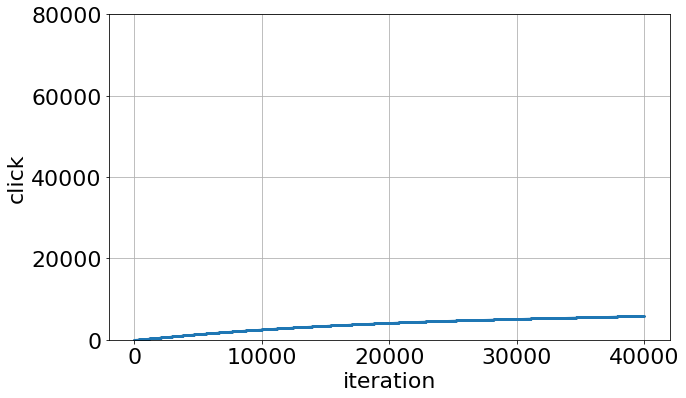

In [ ]:
itr_cumulated_click_count_mean = np.load('/content/itr_cumulated_click_count_mean_pb_airbnb.npy')
itr_cumulated_click_count_std = np.load('/content/itr_cumulated_click_count_std_pb_airbnb.npy')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax.plot(range(len(itr_cumulated_click_count_mean)), itr_cumulated_click_count_mean, marker='.', linewidth=1.5, markersize=1)
ax.fill_between(range(len(itr_cumulated_click_count_std)), itr_cumulated_click_count_mean-itr_cumulated_click_count_std, 
                itr_cumulated_click_count_mean+itr_cumulated_click_count_std, alpha=0.5)
ax.set_ylabel('click')
ax.set_xlabel('iteration')
ax.set_ylim(0., 80000)
ax.grid(True)
fig.patch.set_facecolor('white')
# plt.legend(loc='best')
plt.tight_layout()
plt.show()

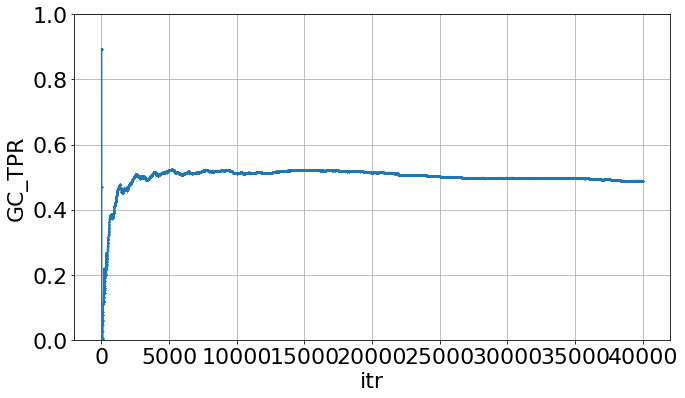

In [ ]:
itr_GC_TPR_mean = np.load('/content/itr_GC_TPR_mean_pb_airbnb.npy')
itr_GC_TPR_std = np.load('./itr_GC_TPR_std_pb_airbnb.npy')
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax.plot(range(len(itr_GC_TPR_mean)), itr_GC_TPR_mean, marker='.', linewidth=1.5, markersize=1)
ax.fill_between(range(len(itr_GC_TPR_mean)), itr_GC_TPR_mean-itr_GC_TPR_std, itr_GC_TPR_mean+itr_GC_TPR_std, alpha=0.5)
ax.set_ylabel('GC_TPR')
ax.set_xlabel('itr')
ax.set_ylim(0., 1)
ax.grid(True)
fig.patch.set_facecolor('white')
# plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
print(' Total clicks: ' + str(np.sum(itr_cumulated_click_count_mean[-1])))
print(' Gini Coeeficient: ' + str(itr_GC_TPR_mean[-1]))

 Total clicks: 5877.0
 Gini Coeeficient: 0.48899604970142835


#**Experiment_vanillaNS**

In [1]:
num_user

NameError: ignored

In [ ]:
num_item

**Upload MF_vanilaNS.py and Simulation_vanilaNS.py**

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings; warnings.simplefilter('ignore')  # Ignores Warnings for nicer Plots. Disable for Debugging
import time
import numpy as np
import argparse
import utility
from Simulation_vanillaNS import Simulation


parser = argparse.ArgumentParser(description='Experiment_vanillaNS')
parser.add_argument('--run', type=int, default=1, help='number of experiments to run')
parser.add_argument('--iteration', type=int, default=40000, help='number of iterations to simulate')
parser.add_argument('--exp', type=int, default=1, help='number of initial random exposure iterations')
parser.add_argument('--cycle_itr', type=int, default=50, help='number of iterations in one cycle')
parser.add_argument('--epoch', type=int, default=15, help='number of epochs to train')
parser.add_argument('--K', type=int, default=20, help='number of items to recommend')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate')
parser.add_argument('--reg', type=float, default=1e-5, help='regularization')
parser.add_argument('--hidden', type=int, default=100, help='latent dimension')
parser.add_argument('--neg', type=int, default=5, help='negative sampling rate')
parser.add_argument('--data', type=str, default='ml1m', help='path to eval in the Data folder')
parser.add_argument('--num_user', type=float, default=num_user, help='path to eval in the Data folder')
parser.add_argument('--num_item', type=float, default=num_item, help='path to eval in the Data folder')
parser.add_argument('-f')

args = parser.parse_args()

truth = np.load('/content/truth_airbnb.npy')
args.num_user = truth.shape[0]
args.num_item = truth.shape[1]
audience_size = np.sum(truth, axis=0)
item_sorted = np.argsort(audience_size)
truth_like = list(np.load('/content/user_truth_like_airbnb.npy', allow_pickle=True))

print('')
print('!' * 30 + ' Total truth ' + str(np.sum(truth)) + ' ' + '!' * 30)
print('')

itr_cumulated_click_count_list = []
itr_GC_TPR_list = []

for r in range(args.run):
    print('')
    print('#' * 100)
    print('#' * 100)
    print(' ' * 50 + ' Experiment run ' + str(r + 1) + ' ' * 50)
    print('#' * 100)
    print('#' * 100)
    simulation = Simulation(args, truth, truth_like)
    init_popularity = simulation.initial_iterations()
    itr_click_item = simulation.run_simulation()

    itr_cumulated_click_count = []
    itr_item_click = np.zeros((args.iteration, args.num_item))
    for itr in range(args.iteration):
        click_item = itr_click_item[itr]
        itr_item_click[itr, click_item] = 1.
        itr_cumulated_click_count.append(
            len(click_item) if itr == 0 else len(click_item) + itr_cumulated_click_count[-1])
    for itr in range(1, args.iteration):
        itr_item_click[itr, :] += itr_item_click[itr - 1, :]
    itr_item_click /= (audience_size - init_popularity).reshape((1, -1))

    itr_GC_TPR = []
    for itr in range(args.iteration):
        a = itr_item_click[itr, item_sorted]
        gc = np.sum(((np.arange(len(a)) + 1.) * 2 - len(a) - 1) * a) / (len(a) * np.sum(a))
        itr_GC_TPR.append(gc)

    itr_cumulated_click_count_list.append(itr_cumulated_click_count)
    itr_GC_TPR_list.append(itr_GC_TPR)

    itr_cumulated_click_count_mean = np.mean(itr_cumulated_click_count_list, axis=0)
    itr_cumulated_click_count_std = np.std(itr_cumulated_click_count_list, axis=0)
    itr_GC_TPR_mean = np.mean(itr_GC_TPR_list, axis=0)
    itr_GC_TPR_std = np.std(itr_GC_TPR_list, axis=0)

    


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Total truth 31951.0 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


####################################################################################################
####################################################################################################
                                                   Experiment run 1                                                  
####################################################################################################
####################################################################################################
Namespace(K=20, cycle_itr=50, data='ml1m', epoch=15, exp=1, f='/root/.local/share/jupyter/runtime/kernel-fc381ba0-44ee-4a67-bf4c-ab92f3747d83.json', hidden=100, iteration=40000, lr=0.001, neg=5, num_item=1162, num_user=1000, reg=1e-05, run=1)
****************************** Start initial random iterations ******************************
---------- Iteration 1 ----------


100%|██████████| 1000/1000 [00:00<00:00, 6101.52it/s]

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Generate 199 records.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
****************************** Train MF until converge ******************************
Update bs to 23


******************************MF initialization done ******************************


100%|██████████| 52/52 [00:00<00:00, 150.11it/s]


Training // Epoch 0 //  Total cost = 36.0679  Total cost1 = 36.0481  Total cost2 = 0.0198


100%|██████████| 52/52 [00:00<00:00, 230.31it/s]


Training // Epoch 1 //  Total cost = 35.7652  Total cost1 = 35.7519  Total cost2 = 0.0134


100%|██████████| 52/52 [00:00<00:00, 199.31it/s]


Training // Epoch 2 //  Total cost = 35.3095  Total cost1 = 35.2927  Total cost2 = 0.0167


100%|██████████| 52/52 [00:00<00:00, 219.82it/s]


Training // Epoch 3 //  Total cost = 34.5580  Total cost1 = 34.5357  Total cost2 = 0.0223


100%|██████████| 52/52 [00:00<00:00, 225.96it/s]


Training // Epoch 4 //  Total cost = 33.3912  Total cost1 = 33.3609  Total cost2 = 0.0304


100%|██████████| 52/52 [00:00<00:00, 234.59it/s]


Training // Epoch 5 //  Total cost = 31.7611  Total cost1 = 31.7202  Total cost2 = 0.0409


100%|██████████| 52/52 [00:00<00:00, 206.26it/s]


Training // Epoch 6 //  Total cost = 29.5598  Total cost1 = 29.5061  Total cost2 = 0.0537


100%|██████████| 52/52 [00:00<00:00, 220.34it/s]


Training // Epoch 7 //  Total cost = 26.8822  Total cost1 = 26.8126  Total cost2 = 0.0697


100%|██████████| 52/52 [00:00<00:00, 237.26it/s]


Training // Epoch 8 //  Total cost = 23.6632  Total cost1 = 23.5760  Total cost2 = 0.0872


100%|██████████| 52/52 [00:00<00:00, 221.40it/s]


Training // Epoch 9 //  Total cost = 20.0590  Total cost1 = 19.9506  Total cost2 = 0.1084


100%|██████████| 52/52 [00:00<00:00, 217.19it/s]


Training // Epoch 10 //  Total cost = 15.9019  Total cost1 = 15.7704  Total cost2 = 0.1315


100%|██████████| 52/52 [00:00<00:00, 219.25it/s]


Training // Epoch 11 //  Total cost = 11.3587  Total cost1 = 11.2023  Total cost2 = 0.1564


100%|██████████| 52/52 [00:00<00:00, 233.13it/s]


Training // Epoch 12 //  Total cost = 6.5830  Total cost1 = 6.3992  Total cost2 = 0.1838


100%|██████████| 52/52 [00:00<00:00, 230.72it/s]


Training // Epoch 13 //  Total cost = 1.4477  Total cost1 = 1.2337  Total cost2 = 0.2140


100%|██████████| 52/52 [00:00<00:00, 207.02it/s]


Training // Epoch 14 //  Total cost = -4.1293  Total cost1 = -4.3741  Total cost2 = 0.2447
****************************** Start simulation ******************************


100%|██████████| 50/50 [00:00<00:00, 1909.57it/s]


########## The iteration 50, up to now total 218 clicks, GC=0.3746, this cycle used 0.03 s) ##########
Update bs to 26


100%|██████████| 15/15 [00:03<00:00,  4.73it/s]


100%|██████████| 50/50 [00:00<00:00, 1768.51it/s]


########## The iteration 100, up to now total 232 clicks, GC=0.3694, this cycle used 3.31 s) ##########
Update bs to 27


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


100%|██████████| 50/50 [00:00<00:00, 2444.03it/s]


########## The iteration 150, up to now total 252 clicks, GC=0.4594, this cycle used 3.41 s) ##########
Update bs to 30


100%|██████████| 15/15 [00:03<00:00,  4.68it/s]


100%|██████████| 50/50 [00:00<00:00, 2067.89it/s]


########## The iteration 200, up to now total 271 clicks, GC=0.4986, this cycle used 3.30 s) ##########
Update bs to 32


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 1726.59it/s]


########## The iteration 250, up to now total 286 clicks, GC=0.5010, this cycle used 3.39 s) ##########
Update bs to 34


100%|██████████| 15/15 [00:03<00:00,  4.70it/s]


100%|██████████| 50/50 [00:00<00:00, 2920.38it/s]


########## The iteration 300, up to now total 303 clicks, GC=0.5115, this cycle used 3.28 s) ##########
Update bs to 36


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 2483.51it/s]


########## The iteration 350, up to now total 317 clicks, GC=0.5270, this cycle used 3.37 s) ##########
Update bs to 38


100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


100%|██████████| 50/50 [00:00<00:00, 2522.22it/s]


########## The iteration 400, up to now total 324 clicks, GC=0.5296, this cycle used 3.33 s) ##########
Update bs to 38


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 1803.57it/s]


########## The iteration 450, up to now total 333 clicks, GC=0.5456, this cycle used 3.40 s) ##########
Update bs to 39


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 2623.74it/s]


########## The iteration 500, up to now total 351 clicks, GC=0.5418, this cycle used 3.40 s) ##########
Update bs to 42


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 2842.56it/s]


########## The iteration 550, up to now total 364 clicks, GC=0.5286, this cycle used 3.42 s) ##########
Update bs to 43


100%|██████████| 15/15 [00:03<00:00,  4.42it/s]


100%|██████████| 50/50 [00:00<00:00, 2653.41it/s]


########## The iteration 600, up to now total 389 clicks, GC=0.5248, this cycle used 3.50 s) ##########
Update bs to 46


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


100%|██████████| 50/50 [00:00<00:00, 2139.75it/s]


########## The iteration 650, up to now total 409 clicks, GC=0.5317, this cycle used 3.41 s) ##########
Update bs to 49


100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


100%|██████████| 50/50 [00:00<00:00, 2126.13it/s]


########## The iteration 700, up to now total 431 clicks, GC=0.5301, this cycle used 3.35 s) ##########
Update bs to 51


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 1819.45it/s]


########## The iteration 750, up to now total 450 clicks, GC=0.5349, this cycle used 3.40 s) ##########
Update bs to 54


100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


100%|██████████| 50/50 [00:00<00:00, 2368.86it/s]


########## The iteration 800, up to now total 469 clicks, GC=0.5500, this cycle used 3.34 s) ##########
Update bs to 56


100%|██████████| 15/15 [00:03<00:00,  4.68it/s]


100%|██████████| 50/50 [00:00<00:00, 1828.17it/s]


########## The iteration 850, up to now total 489 clicks, GC=0.5653, this cycle used 3.31 s) ##########
Update bs to 58


100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


100%|██████████| 50/50 [00:00<00:00, 2263.69it/s]


########## The iteration 900, up to now total 509 clicks, GC=0.5526, this cycle used 3.50 s) ##########
Update bs to 61


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


100%|██████████| 50/50 [00:00<00:00, 2177.30it/s]


########## The iteration 950, up to now total 521 clicks, GC=0.5577, this cycle used 3.52 s) ##########
Update bs to 62


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 2064.74it/s]


########## The iteration 1000, up to now total 538 clicks, GC=0.5656, this cycle used 3.62 s) ##########
Update bs to 64


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1937.56it/s]


########## The iteration 1050, up to now total 562 clicks, GC=0.5749, this cycle used 3.42 s) ##########
Update bs to 67


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 1423.05it/s]


########## The iteration 1100, up to now total 582 clicks, GC=0.5650, this cycle used 3.62 s) ##########
Update bs to 69


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 1740.38it/s]


########## The iteration 1150, up to now total 599 clicks, GC=0.5749, this cycle used 3.42 s) ##########
Update bs to 71


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 1110.51it/s]


########## The iteration 1200, up to now total 612 clicks, GC=0.5813, this cycle used 4.01 s) ##########
Update bs to 73


100%|██████████| 15/15 [00:03<00:00,  4.39it/s]


100%|██████████| 50/50 [00:00<00:00, 2646.85it/s]


########## The iteration 1250, up to now total 629 clicks, GC=0.5881, this cycle used 3.53 s) ##########
Update bs to 75


100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


100%|██████████| 50/50 [00:00<00:00, 1510.52it/s]


########## The iteration 1300, up to now total 645 clicks, GC=0.5934, this cycle used 3.37 s) ##########
Update bs to 77


100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


100%|██████████| 50/50 [00:00<00:00, 2747.34it/s]


########## The iteration 1350, up to now total 664 clicks, GC=0.5982, this cycle used 3.34 s) ##########
Update bs to 79


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 2484.51it/s]


########## The iteration 1400, up to now total 682 clicks, GC=0.6043, this cycle used 3.40 s) ##########
Update bs to 81


100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


100%|██████████| 50/50 [00:00<00:00, 1607.51it/s]


########## The iteration 1450, up to now total 699 clicks, GC=0.6097, this cycle used 3.94 s) ##########
Update bs to 83


100%|██████████| 15/15 [00:04<00:00,  3.19it/s]


100%|██████████| 50/50 [00:00<00:00, 2246.35it/s]


########## The iteration 1500, up to now total 716 clicks, GC=0.6109, this cycle used 4.83 s) ##########
Update bs to 85


100%|██████████| 15/15 [00:03<00:00,  4.51it/s]


100%|██████████| 50/50 [00:00<00:00, 2608.50it/s]


########## The iteration 1550, up to now total 733 clicks, GC=0.6166, this cycle used 3.45 s) ##########
Update bs to 87


100%|██████████| 15/15 [00:03<00:00,  4.43it/s]


100%|██████████| 50/50 [00:00<00:00, 1451.36it/s]


########## The iteration 1600, up to now total 757 clicks, GC=0.6219, this cycle used 3.53 s) ##########
Update bs to 90


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1592.59it/s]


########## The iteration 1650, up to now total 775 clicks, GC=0.6286, this cycle used 3.40 s) ##########
Update bs to 93


100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


100%|██████████| 50/50 [00:00<00:00, 1999.31it/s]


########## The iteration 1700, up to now total 796 clicks, GC=0.6183, this cycle used 3.35 s) ##########
Update bs to 95


100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


100%|██████████| 50/50 [00:00<00:00, 1562.93it/s]


########## The iteration 1750, up to now total 819 clicks, GC=0.6154, this cycle used 3.50 s) ##########
Update bs to 98


100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1963.33it/s]


########## The iteration 1800, up to now total 839 clicks, GC=0.6181, this cycle used 3.37 s) ##########
Update bs to 100


100%|██████████| 15/15 [00:03<00:00,  4.69it/s]


100%|██████████| 50/50 [00:00<00:00, 1803.99it/s]


########## The iteration 1850, up to now total 863 clicks, GC=0.6151, this cycle used 3.33 s) ##########
Update bs to 103


100%|██████████| 15/15 [00:03<00:00,  4.42it/s]


100%|██████████| 50/50 [00:00<00:00, 2129.13it/s]


########## The iteration 1900, up to now total 880 clicks, GC=0.6169, this cycle used 3.52 s) ##########
Update bs to 105


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 2038.58it/s]


########## The iteration 1950, up to now total 909 clicks, GC=0.6249, this cycle used 3.47 s) ##########
Update bs to 109


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1807.44it/s]


########## The iteration 2000, up to now total 929 clicks, GC=0.6256, this cycle used 3.40 s) ##########
Update bs to 111


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 1755.29it/s]


########## The iteration 2050, up to now total 944 clicks, GC=0.6255, this cycle used 3.65 s) ##########
Update bs to 113


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


100%|██████████| 50/50 [00:00<00:00, 691.99it/s]


########## The iteration 2100, up to now total 954 clicks, GC=0.6284, this cycle used 5.29 s) ##########
Update bs to 114


100%|██████████| 15/15 [00:04<00:00,  3.25it/s]


100%|██████████| 50/50 [00:00<00:00, 787.59it/s]


########## The iteration 2150, up to now total 966 clicks, GC=0.6312, this cycle used 4.93 s) ##########
Update bs to 115


100%|██████████| 15/15 [00:06<00:00,  2.16it/s]


100%|██████████| 50/50 [00:00<00:00, 3034.03it/s]


########## The iteration 2200, up to now total 993 clicks, GC=0.6384, this cycle used 7.26 s) ##########
Update bs to 119


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 1780.78it/s]


########## The iteration 2250, up to now total 1010 clicks, GC=0.6429, this cycle used 4.22 s) ##########
Update bs to 121


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 2434.70it/s]


########## The iteration 2300, up to now total 1029 clicks, GC=0.6478, this cycle used 4.04 s) ##########
Update bs to 123


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 2512.94it/s]


########## The iteration 2350, up to now total 1047 clicks, GC=0.6491, this cycle used 4.16 s) ##########
Update bs to 125


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


100%|██████████| 50/50 [00:00<00:00, 1781.66it/s]


########## The iteration 2400, up to now total 1062 clicks, GC=0.6525, this cycle used 3.43 s) ##########
Update bs to 127


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


100%|██████████| 50/50 [00:00<00:00, 842.49it/s]


########## The iteration 2450, up to now total 1079 clicks, GC=0.6558, this cycle used 4.59 s) ##########
Update bs to 129


100%|██████████| 15/15 [00:05<00:00,  2.73it/s]


100%|██████████| 50/50 [00:00<00:00, 2065.57it/s]


########## The iteration 2500, up to now total 1099 clicks, GC=0.6598, this cycle used 5.75 s) ##########
Update bs to 131


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 1630.40it/s]


########## The iteration 2550, up to now total 1112 clicks, GC=0.6620, this cycle used 4.07 s) ##########
Update bs to 133


100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1464.53it/s]


########## The iteration 2600, up to now total 1128 clicks, GC=0.6653, this cycle used 3.39 s) ##########
Update bs to 135


100%|██████████| 15/15 [00:04<00:00,  3.28it/s]


100%|██████████| 50/50 [00:00<00:00, 1502.21it/s]


########## The iteration 2650, up to now total 1154 clicks, GC=0.6704, this cycle used 4.73 s) ##########
Update bs to 138


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


100%|██████████| 50/50 [00:00<00:00, 2089.63it/s]


########## The iteration 2700, up to now total 1173 clicks, GC=0.6742, this cycle used 3.49 s) ##########
Update bs to 140


100%|██████████| 15/15 [00:04<00:00,  3.03it/s]


100%|██████████| 50/50 [00:00<00:00, 930.99it/s]


########## The iteration 2750, up to now total 1192 clicks, GC=0.6781, this cycle used 5.17 s) ##########
Update bs to 143


100%|██████████| 15/15 [00:06<00:00,  2.42it/s]


100%|██████████| 50/50 [00:00<00:00, 1966.26it/s]


########## The iteration 2800, up to now total 1210 clicks, GC=0.6816, this cycle used 6.42 s) ##########
Update bs to 145


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 1710.13it/s]


########## The iteration 2850, up to now total 1225 clicks, GC=0.6840, this cycle used 3.67 s) ##########
Update bs to 147


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 1831.01it/s]


########## The iteration 2900, up to now total 1240 clicks, GC=0.6869, this cycle used 4.25 s) ##########
Update bs to 148


100%|██████████| 15/15 [00:05<00:00,  2.71it/s]


100%|██████████| 50/50 [00:00<00:00, 1108.50it/s]


########## The iteration 2950, up to now total 1249 clicks, GC=0.6885, this cycle used 5.75 s) ##########
Update bs to 149


100%|██████████| 15/15 [00:04<00:00,  3.09it/s]


100%|██████████| 50/50 [00:00<00:00, 901.78it/s]


########## The iteration 3000, up to now total 1264 clicks, GC=0.6911, this cycle used 5.11 s) ##########
Update bs to 151


100%|██████████| 15/15 [00:04<00:00,  3.34it/s]


100%|██████████| 50/50 [00:00<00:00, 1267.64it/s]


########## The iteration 3050, up to now total 1273 clicks, GC=0.6922, this cycle used 4.67 s) ##########
Update bs to 152


100%|██████████| 15/15 [00:05<00:00,  2.92it/s]


100%|██████████| 50/50 [00:00<00:00, 1830.84it/s]


########## The iteration 3100, up to now total 1292 clicks, GC=0.6956, this cycle used 5.33 s) ##########
Update bs to 155


100%|██████████| 15/15 [00:04<00:00,  3.32it/s]


100%|██████████| 50/50 [00:00<00:00, 1732.93it/s]


########## The iteration 3150, up to now total 1300 clicks, GC=0.6971, this cycle used 4.70 s) ##########
Update bs to 156


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 951.43it/s]


########## The iteration 3200, up to now total 1320 clicks, GC=0.7004, this cycle used 3.78 s) ##########
Update bs to 158


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 1585.62it/s]


########## The iteration 3250, up to now total 1329 clicks, GC=0.7018, this cycle used 3.91 s) ##########
Update bs to 159


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 1137.09it/s]


########## The iteration 3300, up to now total 1343 clicks, GC=0.7041, this cycle used 4.28 s) ##########
Update bs to 161


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


100%|██████████| 50/50 [00:00<00:00, 741.48it/s]


########## The iteration 3350, up to now total 1356 clicks, GC=0.7062, this cycle used 7.07 s) ##########
Update bs to 162


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


100%|██████████| 50/50 [00:00<00:00, 1922.05it/s]


########## The iteration 3400, up to now total 1365 clicks, GC=0.7076, this cycle used 5.32 s) ##########
Update bs to 163


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


100%|██████████| 50/50 [00:00<00:00, 1502.35it/s]


########## The iteration 3450, up to now total 1381 clicks, GC=0.7099, this cycle used 3.99 s) ##########
Update bs to 165


100%|██████████| 15/15 [00:04<00:00,  3.13it/s]


100%|██████████| 50/50 [00:00<00:00, 1167.97it/s]


########## The iteration 3500, up to now total 1392 clicks, GC=0.7115, this cycle used 4.99 s) ##########
Update bs to 167


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 1167.61it/s]


########## The iteration 3550, up to now total 1416 clicks, GC=0.7147, this cycle used 4.22 s) ##########
Update bs to 169


100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


100%|██████████| 50/50 [00:00<00:00, 1609.71it/s]


########## The iteration 3600, up to now total 1430 clicks, GC=0.7167, this cycle used 5.22 s) ##########
Update bs to 171


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


100%|██████████| 50/50 [00:00<00:00, 1685.89it/s]


########## The iteration 3650, up to now total 1445 clicks, GC=0.7189, this cycle used 4.02 s) ##########
Update bs to 173


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1837.54it/s]


########## The iteration 3700, up to now total 1457 clicks, GC=0.7205, this cycle used 3.48 s) ##########
Update bs to 174


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 1262.21it/s]


########## The iteration 3750, up to now total 1469 clicks, GC=0.7221, this cycle used 3.46 s) ##########
Update bs to 176


100%|██████████| 15/15 [00:03<00:00,  4.43it/s]


100%|██████████| 50/50 [00:00<00:00, 2034.43it/s]


########## The iteration 3800, up to now total 1478 clicks, GC=0.7233, this cycle used 3.56 s) ##########
Update bs to 177


100%|██████████| 15/15 [00:04<00:00,  3.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1909.35it/s]


########## The iteration 3850, up to now total 1488 clicks, GC=0.7246, this cycle used 4.65 s) ##########
Update bs to 178


100%|██████████| 15/15 [00:04<00:00,  3.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1165.21it/s]


########## The iteration 3900, up to now total 1494 clicks, GC=0.7255, this cycle used 4.99 s) ##########
Update bs to 179


100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


100%|██████████| 50/50 [00:00<00:00, 774.69it/s]


########## The iteration 3950, up to now total 1501 clicks, GC=0.7265, this cycle used 5.99 s) ##########
Update bs to 180


100%|██████████| 15/15 [00:05<00:00,  2.81it/s]


100%|██████████| 50/50 [00:00<00:00, 994.81it/s]


########## The iteration 4000, up to now total 1512 clicks, GC=0.7278, this cycle used 5.55 s) ##########
Update bs to 181


100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


100%|██████████| 50/50 [00:00<00:00, 824.73it/s]


########## The iteration 4050, up to now total 1523 clicks, GC=0.7292, this cycle used 6.14 s) ##########
Update bs to 182


100%|██████████| 15/15 [00:06<00:00,  2.38it/s]


100%|██████████| 50/50 [00:00<00:00, 2122.04it/s]


########## The iteration 4100, up to now total 1532 clicks, GC=0.7303, this cycle used 6.54 s) ##########
Update bs to 183


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 1368.54it/s]


########## The iteration 4150, up to now total 1539 clicks, GC=0.7313, this cycle used 3.49 s) ##########
Update bs to 184


100%|██████████| 15/15 [00:04<00:00,  3.12it/s]


100%|██████████| 50/50 [00:00<00:00, 574.43it/s]


########## The iteration 4200, up to now total 1550 clicks, GC=0.7326, this cycle used 5.06 s) ##########
Update bs to 186


100%|██████████| 15/15 [00:06<00:00,  2.42it/s]


100%|██████████| 50/50 [00:00<00:00, 1442.19it/s]


########## The iteration 4250, up to now total 1560 clicks, GC=0.7339, this cycle used 6.75 s) ##########
Update bs to 187


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1526.46it/s]


########## The iteration 4300, up to now total 1570 clicks, GC=0.7351, this cycle used 3.51 s) ##########
Update bs to 188


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 1679.52it/s]


########## The iteration 4350, up to now total 1578 clicks, GC=0.7360, this cycle used 3.63 s) ##########
Update bs to 189


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 1793.56it/s]


########## The iteration 4400, up to now total 1587 clicks, GC=0.7371, this cycle used 3.50 s) ##########
Update bs to 190


100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1247.69it/s]


########## The iteration 4450, up to now total 1597 clicks, GC=0.7384, this cycle used 3.43 s) ##########
Update bs to 191


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 1549.31it/s]


########## The iteration 4500, up to now total 1610 clicks, GC=0.7398, this cycle used 3.48 s) ##########
Update bs to 193


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1778.53it/s]


########## The iteration 4550, up to now total 1621 clicks, GC=0.7411, this cycle used 3.49 s) ##########
Update bs to 194


100%|██████████| 15/15 [00:03<00:00,  4.47it/s]


100%|██████████| 50/50 [00:00<00:00, 1477.18it/s]


########## The iteration 4600, up to now total 1630 clicks, GC=0.7421, this cycle used 3.55 s) ##########
Update bs to 195


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 1236.80it/s]


########## The iteration 4650, up to now total 1641 clicks, GC=0.7433, this cycle used 3.49 s) ##########
Update bs to 196


100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


100%|██████████| 50/50 [00:00<00:00, 1627.30it/s]


########## The iteration 4700, up to now total 1655 clicks, GC=0.7448, this cycle used 3.53 s) ##########
Update bs to 198


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1492.82it/s]


########## The iteration 4750, up to now total 1662 clicks, GC=0.7455, this cycle used 3.50 s) ##########
Update bs to 199


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1853.38it/s]


########## The iteration 4800, up to now total 1669 clicks, GC=0.7463, this cycle used 3.51 s) ##########
Update bs to 200


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 1795.12it/s]


########## The iteration 4850, up to now total 1676 clicks, GC=0.7470, this cycle used 3.50 s) ##########
Update bs to 201


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


100%|██████████| 50/50 [00:00<00:00, 1478.11it/s]


########## The iteration 4900, up to now total 1687 clicks, GC=0.7482, this cycle used 3.51 s) ##########
Update bs to 202


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


100%|██████████| 50/50 [00:00<00:00, 2041.42it/s]


########## The iteration 4950, up to now total 1694 clicks, GC=0.7489, this cycle used 3.51 s) ##########
Update bs to 203


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 1297.93it/s]


########## The iteration 5000, up to now total 1700 clicks, GC=0.7496, this cycle used 3.67 s) ##########
Update bs to 204


100%|██████████| 15/15 [00:03<00:00,  4.57it/s]


100%|██████████| 50/50 [00:00<00:00, 1346.98it/s]


########## The iteration 5050, up to now total 1710 clicks, GC=0.7506, this cycle used 3.50 s) ##########
Update bs to 205


100%|██████████| 15/15 [00:03<00:00,  4.51it/s]


100%|██████████| 50/50 [00:00<00:00, 1429.16it/s]


########## The iteration 5100, up to now total 1712 clicks, GC=0.7509, this cycle used 3.53 s) ##########
Update bs to 205


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 1550.98it/s]


########## The iteration 5150, up to now total 1716 clicks, GC=0.7513, this cycle used 3.69 s) ##########
Update bs to 205


100%|██████████| 15/15 [00:03<00:00,  4.42it/s]


100%|██████████| 50/50 [00:00<00:00, 1388.93it/s]


########## The iteration 5200, up to now total 1719 clicks, GC=0.7515, this cycle used 3.60 s) ##########
Update bs to 206


100%|██████████| 15/15 [00:03<00:00,  4.46it/s]


100%|██████████| 50/50 [00:00<00:00, 1760.57it/s]


########## The iteration 5250, up to now total 1724 clicks, GC=0.7519, this cycle used 3.58 s) ##########
Update bs to 206


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 1748.87it/s]


########## The iteration 5300, up to now total 1727 clicks, GC=0.7522, this cycle used 3.88 s) ##########
Update bs to 207


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1386.66it/s]


########## The iteration 5350, up to now total 1736 clicks, GC=0.7532, this cycle used 3.52 s) ##########
Update bs to 208


100%|██████████| 15/15 [00:03<00:00,  4.39it/s]


100%|██████████| 50/50 [00:00<00:00, 1384.11it/s]


########## The iteration 5400, up to now total 1743 clicks, GC=0.7538, this cycle used 3.62 s) ##########
Update bs to 209


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 1494.50it/s]


########## The iteration 5450, up to now total 1753 clicks, GC=0.7548, this cycle used 4.49 s) ##########
Update bs to 210


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1674.80it/s]


########## The iteration 5500, up to now total 1758 clicks, GC=0.7553, this cycle used 3.50 s) ##########
Update bs to 210


100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


100%|██████████| 50/50 [00:00<00:00, 1325.29it/s]


########## The iteration 5550, up to now total 1769 clicks, GC=0.7565, this cycle used 3.56 s) ##########
Update bs to 212


100%|██████████| 15/15 [00:04<00:00,  3.02it/s]


100%|██████████| 50/50 [00:00<00:00, 770.66it/s]


########## The iteration 5600, up to now total 1773 clicks, GC=0.7568, this cycle used 5.20 s) ##########
Update bs to 212


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1404.68it/s]


########## The iteration 5650, up to now total 1784 clicks, GC=0.7579, this cycle used 3.61 s) ##########
Update bs to 214


100%|██████████| 15/15 [00:03<00:00,  4.43it/s]


100%|██████████| 50/50 [00:00<00:00, 1315.34it/s]


########## The iteration 5700, up to now total 1791 clicks, GC=0.7585, this cycle used 3.61 s) ##########
Update bs to 214


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 1279.68it/s]


########## The iteration 5750, up to now total 1795 clicks, GC=0.7589, this cycle used 3.86 s) ##########
Update bs to 215


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1565.47it/s]


########## The iteration 5800, up to now total 1797 clicks, GC=0.7591, this cycle used 3.52 s) ##########
Update bs to 215


100%|██████████| 15/15 [00:03<00:00,  4.46it/s]


100%|██████████| 50/50 [00:00<00:00, 1378.95it/s]


########## The iteration 5850, up to now total 1804 clicks, GC=0.7598, this cycle used 3.58 s) ##########
Update bs to 216


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 1488.81it/s]


########## The iteration 5900, up to now total 1812 clicks, GC=0.7605, this cycle used 3.84 s) ##########
Update bs to 217


100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


100%|██████████| 50/50 [00:00<00:00, 1084.33it/s]


########## The iteration 5950, up to now total 1825 clicks, GC=0.7618, this cycle used 3.57 s) ##########
Update bs to 219


100%|██████████| 15/15 [00:03<00:00,  4.42it/s]


100%|██████████| 50/50 [00:00<00:00, 1316.05it/s]


########## The iteration 6000, up to now total 1831 clicks, GC=0.7624, this cycle used 3.60 s) ##########
Update bs to 219


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 1372.36it/s]


########## The iteration 6050, up to now total 1833 clicks, GC=0.7626, this cycle used 3.82 s) ##########
Update bs to 219


100%|██████████| 15/15 [00:03<00:00,  4.51it/s]


100%|██████████| 50/50 [00:00<00:00, 1834.81it/s]


########## The iteration 6100, up to now total 1838 clicks, GC=0.7630, this cycle used 3.53 s) ##########
Update bs to 220


100%|██████████| 15/15 [00:03<00:00,  4.47it/s]


100%|██████████| 50/50 [00:00<00:00, 1445.89it/s]


########## The iteration 6150, up to now total 1844 clicks, GC=0.7635, this cycle used 3.59 s) ##########
Update bs to 221


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 1473.67it/s]


########## The iteration 6200, up to now total 1851 clicks, GC=0.7641, this cycle used 3.90 s) ##########
Update bs to 222


100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


100%|██████████| 50/50 [00:00<00:00, 1386.88it/s]


########## The iteration 6250, up to now total 1858 clicks, GC=0.7648, this cycle used 3.59 s) ##########
Update bs to 222


100%|██████████| 15/15 [00:03<00:00,  4.43it/s]


100%|██████████| 50/50 [00:00<00:00, 1406.91it/s]


########## The iteration 6300, up to now total 1864 clicks, GC=0.7652, this cycle used 3.63 s) ##########
Update bs to 223


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 1332.44it/s]


########## The iteration 6350, up to now total 1871 clicks, GC=0.7658, this cycle used 3.84 s) ##########
Update bs to 224


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1302.98it/s]


########## The iteration 6400, up to now total 1879 clicks, GC=0.7665, this cycle used 3.54 s) ##########
Update bs to 225


100%|██████████| 15/15 [00:03<00:00,  4.42it/s]


100%|██████████| 50/50 [00:00<00:00, 1518.83it/s]


########## The iteration 6450, up to now total 1883 clicks, GC=0.7669, this cycle used 3.64 s) ##########
Update bs to 225


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


100%|██████████| 50/50 [00:00<00:00, 1432.00it/s]


########## The iteration 6500, up to now total 1889 clicks, GC=0.7674, this cycle used 3.55 s) ##########
Update bs to 226


100%|██████████| 15/15 [00:03<00:00,  4.48it/s]


100%|██████████| 50/50 [00:00<00:00, 1220.56it/s]


########## The iteration 6550, up to now total 1889 clicks, GC=0.7674, this cycle used 3.58 s) ##########
Update bs to 226


100%|██████████| 15/15 [00:03<00:00,  4.46it/s]


100%|██████████| 50/50 [00:00<00:00, 1571.04it/s]


########## The iteration 6600, up to now total 1895 clicks, GC=0.7679, this cycle used 3.58 s) ##########
Update bs to 227


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 1283.43it/s]


########## The iteration 6650, up to now total 1897 clicks, GC=0.7680, this cycle used 3.99 s) ##########
Update bs to 227


100%|██████████| 15/15 [00:03<00:00,  4.46it/s]


100%|██████████| 50/50 [00:00<00:00, 1284.56it/s]


########## The iteration 6700, up to now total 1901 clicks, GC=0.7683, this cycle used 3.58 s) ##########
Update bs to 228


100%|██████████| 15/15 [00:03<00:00,  4.47it/s]


100%|██████████| 50/50 [00:00<00:00, 1190.91it/s]


########## The iteration 6750, up to now total 1909 clicks, GC=0.7690, this cycle used 3.58 s) ##########
Update bs to 229


100%|██████████| 15/15 [00:03<00:00,  4.44it/s]


100%|██████████| 50/50 [00:00<00:00, 1003.15it/s]


########## The iteration 6800, up to now total 1912 clicks, GC=0.7693, this cycle used 3.62 s) ##########
Update bs to 229


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1457.80it/s]


########## The iteration 6850, up to now total 1917 clicks, GC=0.7697, this cycle used 4.35 s) ##########
Update bs to 230


100%|██████████| 15/15 [00:03<00:00,  4.43it/s]


100%|██████████| 50/50 [00:00<00:00, 1060.68it/s]


########## The iteration 6900, up to now total 1921 clicks, GC=0.7700, this cycle used 3.63 s) ##########
Update bs to 230


100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


100%|██████████| 50/50 [00:00<00:00, 1766.53it/s]


########## The iteration 6950, up to now total 1928 clicks, GC=0.7705, this cycle used 3.63 s) ##########
Update bs to 231


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 1427.18it/s]


########## The iteration 7000, up to now total 1934 clicks, GC=0.7710, this cycle used 3.65 s) ##########
Update bs to 232


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 932.93it/s]


########## The iteration 7050, up to now total 1937 clicks, GC=0.7712, this cycle used 3.70 s) ##########
Update bs to 232


100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


100%|██████████| 50/50 [00:00<00:00, 1470.74it/s]


########## The iteration 7100, up to now total 1940 clicks, GC=0.7715, this cycle used 3.61 s) ##########
Update bs to 232


100%|██████████| 15/15 [00:03<00:00,  4.47it/s]


100%|██████████| 50/50 [00:00<00:00, 1638.36it/s]


########## The iteration 7150, up to now total 1944 clicks, GC=0.7719, this cycle used 3.60 s) ##########
Update bs to 233


100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


100%|██████████| 50/50 [00:00<00:00, 1717.09it/s]


########## The iteration 7200, up to now total 1950 clicks, GC=0.7724, this cycle used 3.66 s) ##########
Update bs to 234


100%|██████████| 15/15 [00:03<00:00,  4.44it/s]


100%|██████████| 50/50 [00:00<00:00, 1615.59it/s]


########## The iteration 7250, up to now total 1952 clicks, GC=0.7725, this cycle used 3.61 s) ##########
Update bs to 234


100%|██████████| 15/15 [00:03<00:00,  4.51it/s]


100%|██████████| 50/50 [00:00<00:00, 1134.49it/s]


########## The iteration 7300, up to now total 1960 clicks, GC=0.7732, this cycle used 3.56 s) ##########
Update bs to 235


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 1354.67it/s]


########## The iteration 7350, up to now total 1966 clicks, GC=0.7735, this cycle used 3.51 s) ##########
Update bs to 235


100%|██████████| 15/15 [00:03<00:00,  4.46it/s]


100%|██████████| 50/50 [00:00<00:00, 1213.89it/s]


########## The iteration 7400, up to now total 1968 clicks, GC=0.7737, this cycle used 3.60 s) ##########
Update bs to 236


100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


100%|██████████| 50/50 [00:00<00:00, 1309.10it/s]


########## The iteration 7450, up to now total 1971 clicks, GC=0.7739, this cycle used 3.58 s) ##########
Update bs to 236


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


100%|██████████| 50/50 [00:00<00:00, 1058.58it/s]


########## The iteration 7500, up to now total 1973 clicks, GC=0.7741, this cycle used 3.58 s) ##########
Update bs to 236


100%|██████████| 15/15 [00:03<00:00,  4.51it/s]


100%|██████████| 50/50 [00:00<00:00, 1633.00it/s]


########## The iteration 7550, up to now total 1979 clicks, GC=0.7745, this cycle used 3.57 s) ##########
Update bs to 237


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


100%|██████████| 50/50 [00:00<00:00, 1397.56it/s]


########## The iteration 7600, up to now total 1980 clicks, GC=0.7746, this cycle used 3.57 s) ##########
Update bs to 237


100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


100%|██████████| 50/50 [00:00<00:00, 1448.72it/s]


########## The iteration 7650, up to now total 1982 clicks, GC=0.7747, this cycle used 3.59 s) ##########
Update bs to 237


100%|██████████| 15/15 [00:03<00:00,  4.48it/s]


100%|██████████| 50/50 [00:00<00:00, 1268.18it/s]


########## The iteration 7700, up to now total 1987 clicks, GC=0.7751, this cycle used 3.60 s) ##########
Update bs to 238


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 1357.49it/s]


########## The iteration 7750, up to now total 1992 clicks, GC=0.7755, this cycle used 3.52 s) ##########
Update bs to 239


100%|██████████| 15/15 [00:03<00:00,  4.46it/s]


100%|██████████| 50/50 [00:00<00:00, 1754.26it/s]


########## The iteration 7800, up to now total 1995 clicks, GC=0.7757, this cycle used 3.59 s) ##########
Update bs to 239


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


100%|██████████| 50/50 [00:00<00:00, 68.40it/s]


########## The iteration 7850, up to now total 1997 clicks, GC=0.7759, this cycle used 4.35 s) ##########
Update bs to 239


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


100%|██████████| 50/50 [00:00<00:00, 1621.95it/s]


########## The iteration 7900, up to now total 1997 clicks, GC=0.7759, this cycle used 3.52 s) ##########
Update bs to 239


100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


100%|██████████| 50/50 [00:00<00:00, 1348.01it/s]


########## The iteration 7950, up to now total 2000 clicks, GC=0.7761, this cycle used 3.63 s) ##########
Update bs to 240


100%|██████████| 15/15 [00:03<00:00,  4.46it/s]


100%|██████████| 50/50 [00:00<00:00, 1122.95it/s]


########## The iteration 8000, up to now total 2001 clicks, GC=0.7762, this cycle used 3.61 s) ##########
Update bs to 240


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


100%|██████████| 50/50 [00:00<00:00, 1330.27it/s]


########## The iteration 8050, up to now total 2001 clicks, GC=0.7762, this cycle used 3.59 s) ##########
Update bs to 240


100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


100%|██████████| 50/50 [00:00<00:00, 1168.21it/s]


########## The iteration 8100, up to now total 2006 clicks, GC=0.7765, this cycle used 3.65 s) ##########
Update bs to 240


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


100%|██████████| 50/50 [00:00<00:00, 1552.14it/s]


########## The iteration 8150, up to now total 2012 clicks, GC=0.7769, this cycle used 3.58 s) ##########
Update bs to 241


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


100%|██████████| 50/50 [00:00<00:00, 1209.70it/s]


########## The iteration 8200, up to now total 2018 clicks, GC=0.7774, this cycle used 3.57 s) ##########
Update bs to 242


100%|██████████| 15/15 [00:03<00:00,  4.48it/s]


100%|██████████| 50/50 [00:00<00:00, 1081.24it/s]


########## The iteration 8250, up to now total 2018 clicks, GC=0.7774, this cycle used 3.62 s) ##########
Update bs to 242


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1389.14it/s]


########## The iteration 8300, up to now total 2021 clicks, GC=0.7776, this cycle used 3.58 s) ##########
Update bs to 242


100%|██████████| 15/15 [00:03<00:00,  4.43it/s]


100%|██████████| 50/50 [00:00<00:00, 1475.40it/s]


########## The iteration 8350, up to now total 2022 clicks, GC=0.7777, this cycle used 3.66 s) ##########
Update bs to 242


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


100%|██████████| 50/50 [00:00<00:00, 1129.52it/s]


########## The iteration 8400, up to now total 2026 clicks, GC=0.7780, this cycle used 3.60 s) ##########
Update bs to 243


100%|██████████| 15/15 [00:03<00:00,  4.48it/s]


100%|██████████| 50/50 [00:00<00:00, 1505.46it/s]


########## The iteration 8450, up to now total 2031 clicks, GC=0.7784, this cycle used 3.60 s) ##########
Update bs to 243


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


100%|██████████| 50/50 [00:00<00:00, 1348.39it/s]


########## The iteration 8500, up to now total 2033 clicks, GC=0.7785, this cycle used 3.58 s) ##########
Update bs to 243


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1843.96it/s]


########## The iteration 8550, up to now total 2036 clicks, GC=0.7787, this cycle used 3.59 s) ##########
Update bs to 244


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 1218.07it/s]


########## The iteration 8600, up to now total 2040 clicks, GC=0.7790, this cycle used 3.56 s) ##########
Update bs to 244


100%|██████████| 15/15 [00:03<00:00,  4.44it/s]


100%|██████████| 50/50 [00:00<00:00, 1267.33it/s]


########## The iteration 8650, up to now total 2043 clicks, GC=0.7793, this cycle used 3.64 s) ##########
Update bs to 245


100%|██████████| 15/15 [00:03<00:00,  4.46it/s]


100%|██████████| 50/50 [00:00<00:00, 1572.84it/s]


########## The iteration 8700, up to now total 2049 clicks, GC=0.7797, this cycle used 3.62 s) ##########
Update bs to 245


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1128.94it/s]


########## The iteration 8750, up to now total 2051 clicks, GC=0.7798, this cycle used 3.59 s) ##########
Update bs to 246


100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


100%|██████████| 50/50 [00:00<00:00, 1368.09it/s]


########## The iteration 8800, up to now total 2056 clicks, GC=0.7802, this cycle used 3.62 s) ##########
Update bs to 246


100%|██████████| 15/15 [00:03<00:00,  4.46it/s]


100%|██████████| 50/50 [00:00<00:00, 1154.27it/s]


########## The iteration 8850, up to now total 2058 clicks, GC=0.7804, this cycle used 3.64 s) ##########
Update bs to 246


100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


100%|██████████| 50/50 [00:00<00:00, 1003.85it/s]


########## The iteration 8900, up to now total 2059 clicks, GC=0.7805, this cycle used 3.60 s) ##########
Update bs to 247


100%|██████████| 15/15 [00:03<00:00,  4.47it/s]


100%|██████████| 50/50 [00:00<00:00, 1171.25it/s]


########## The iteration 8950, up to now total 2061 clicks, GC=0.7806, this cycle used 3.62 s) ##########
Update bs to 247


100%|██████████| 15/15 [00:03<00:00,  4.43it/s]


100%|██████████| 50/50 [00:00<00:00, 1366.11it/s]


########## The iteration 9000, up to now total 2066 clicks, GC=0.7810, this cycle used 3.67 s) ##########
Update bs to 247


100%|██████████| 15/15 [00:03<00:00,  4.47it/s]


100%|██████████| 50/50 [00:00<00:00, 1313.10it/s]


########## The iteration 9050, up to now total 2067 clicks, GC=0.7810, this cycle used 3.62 s) ##########
Update bs to 248


100%|██████████| 15/15 [00:03<00:00,  4.44it/s]


100%|██████████| 50/50 [00:00<00:00, 1339.62it/s]


########## The iteration 9100, up to now total 2069 clicks, GC=0.7812, this cycle used 3.64 s) ##########
Update bs to 248


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1350.15it/s]


########## The iteration 9150, up to now total 2070 clicks, GC=0.7812, this cycle used 3.56 s) ##########
Update bs to 248


100%|██████████| 15/15 [00:03<00:00,  4.48it/s]


100%|██████████| 50/50 [00:00<00:00, 1384.51it/s]


########## The iteration 9200, up to now total 2072 clicks, GC=0.7814, this cycle used 3.62 s) ##########
Update bs to 248


100%|██████████| 15/15 [00:03<00:00,  4.48it/s]


100%|██████████| 50/50 [00:00<00:00, 1241.10it/s]


########## The iteration 9250, up to now total 2072 clicks, GC=0.7814, this cycle used 3.62 s) ##########
Update bs to 248


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 999.71it/s]


########## The iteration 9300, up to now total 2075 clicks, GC=0.7816, this cycle used 3.60 s) ##########
Update bs to 249


100%|██████████| 15/15 [00:03<00:00,  4.51it/s]


100%|██████████| 50/50 [00:00<00:00, 1118.18it/s]


########## The iteration 9350, up to now total 2076 clicks, GC=0.7817, this cycle used 3.59 s) ##########
Update bs to 249


100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


100%|██████████| 50/50 [00:00<00:00, 1218.62it/s]


########## The iteration 9400, up to now total 2077 clicks, GC=0.7817, this cycle used 3.67 s) ##########
Update bs to 249


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


100%|██████████| 50/50 [00:00<00:00, 1402.06it/s]


########## The iteration 9450, up to now total 2080 clicks, GC=0.7819, this cycle used 3.69 s) ##########
Update bs to 249


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 1578.93it/s]


########## The iteration 9500, up to now total 2082 clicks, GC=0.7821, this cycle used 3.70 s) ##########
Update bs to 249


100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


100%|██████████| 50/50 [00:00<00:00, 1227.26it/s]


########## The iteration 9550, up to now total 2083 clicks, GC=0.7821, this cycle used 3.64 s) ##########
Update bs to 249


100%|██████████| 15/15 [00:03<00:00,  4.46it/s]


100%|██████████| 50/50 [00:00<00:00, 1191.45it/s]


########## The iteration 9600, up to now total 2084 clicks, GC=0.7822, this cycle used 3.64 s) ##########
Update bs to 250


100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


100%|██████████| 50/50 [00:00<00:00, 1572.86it/s]


########## The iteration 9650, up to now total 2089 clicks, GC=0.7825, this cycle used 3.61 s) ##########
Update bs to 250


100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


100%|██████████| 50/50 [00:00<00:00, 1377.69it/s]


########## The iteration 9700, up to now total 2091 clicks, GC=0.7827, this cycle used 3.61 s) ##########
Update bs to 250


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 1107.39it/s]


########## The iteration 9750, up to now total 2091 clicks, GC=0.7827, this cycle used 3.59 s) ##########
Update bs to 250


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 1177.26it/s]


########## The iteration 9800, up to now total 2091 clicks, GC=0.7827, this cycle used 3.57 s) ##########
Update bs to 250


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1061.27it/s]


########## The iteration 9850, up to now total 2092 clicks, GC=0.7827, this cycle used 3.61 s) ##########
Update bs to 251


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


100%|██████████| 50/50 [00:00<00:00, 1251.54it/s]


########## The iteration 9900, up to now total 2093 clicks, GC=0.7828, this cycle used 3.69 s) ##########
Update bs to 251


100%|██████████| 15/15 [00:04<00:00,  3.16it/s]


100%|██████████| 50/50 [00:00<00:00, 982.54it/s]


########## The iteration 9950, up to now total 2095 clicks, GC=0.7829, this cycle used 5.03 s) ##########
Update bs to 251


100%|██████████| 15/15 [00:05<00:00,  2.72it/s]


100%|██████████| 50/50 [00:00<00:00, 1368.09it/s]


########## The iteration 10000, up to now total 2096 clicks, GC=0.7830, this cycle used 5.85 s) ##########
Update bs to 251


100%|██████████| 15/15 [00:03<00:00,  4.47it/s]


100%|██████████| 50/50 [00:00<00:00, 1359.63it/s]


########## The iteration 10050, up to now total 2096 clicks, GC=0.7830, this cycle used 3.64 s) ##########
Update bs to 251


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1656.13it/s]


########## The iteration 10100, up to now total 2097 clicks, GC=0.7830, this cycle used 3.73 s) ##########
Update bs to 251


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1195.87it/s]


########## The iteration 10150, up to now total 2098 clicks, GC=0.7831, this cycle used 3.73 s) ##########
Update bs to 251


100%|██████████| 15/15 [00:03<00:00,  4.47it/s]


100%|██████████| 50/50 [00:00<00:00, 1180.98it/s]


########## The iteration 10200, up to now total 2098 clicks, GC=0.7831, this cycle used 3.63 s) ##########
Update bs to 251


100%|██████████| 15/15 [00:03<00:00,  4.39it/s]


100%|██████████| 50/50 [00:00<00:00, 1370.23it/s]


########## The iteration 10250, up to now total 2100 clicks, GC=0.7832, this cycle used 3.70 s) ##########
Update bs to 252


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1131.64it/s]


########## The iteration 10300, up to now total 2101 clicks, GC=0.7833, this cycle used 3.72 s) ##########
Update bs to 252


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 943.69it/s]


########## The iteration 10350, up to now total 2104 clicks, GC=0.7835, this cycle used 3.73 s) ##########
Update bs to 252


100%|██████████| 15/15 [00:03<00:00,  4.39it/s]


100%|██████████| 50/50 [00:00<00:00, 1307.59it/s]


########## The iteration 10400, up to now total 2108 clicks, GC=0.7837, this cycle used 3.70 s) ##########
Update bs to 252


100%|██████████| 15/15 [00:03<00:00,  4.46it/s]


100%|██████████| 50/50 [00:00<00:00, 1084.01it/s]


########## The iteration 10450, up to now total 2109 clicks, GC=0.7838, this cycle used 3.65 s) ##########
Update bs to 253


100%|██████████| 15/15 [00:03<00:00,  4.43it/s]


100%|██████████| 50/50 [00:00<00:00, 1001.46it/s]


########## The iteration 10500, up to now total 2113 clicks, GC=0.7841, this cycle used 3.69 s) ##########
Update bs to 253


100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


100%|██████████| 50/50 [00:00<00:00, 975.79it/s]


########## The iteration 10550, up to now total 2114 clicks, GC=0.7842, this cycle used 3.68 s) ##########
Update bs to 253


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 1162.19it/s]


########## The iteration 10600, up to now total 2115 clicks, GC=0.7842, this cycle used 3.78 s) ##########
Update bs to 253


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 1296.61it/s]


########## The iteration 10650, up to now total 2116 clicks, GC=0.7843, this cycle used 3.77 s) ##########
Update bs to 253


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 1088.86it/s]


########## The iteration 10700, up to now total 2118 clicks, GC=0.7845, this cycle used 3.81 s) ##########
Update bs to 254


100%|██████████| 15/15 [00:03<00:00,  4.47it/s]


100%|██████████| 50/50 [00:00<00:00, 1356.12it/s]


########## The iteration 10750, up to now total 2119 clicks, GC=0.7845, this cycle used 3.65 s) ##########
Update bs to 254


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1403.96it/s]


########## The iteration 10800, up to now total 2122 clicks, GC=0.7847, this cycle used 3.74 s) ##########
Update bs to 254


100%|██████████| 15/15 [00:03<00:00,  4.39it/s]


100%|██████████| 50/50 [00:00<00:00, 1263.40it/s]


########## The iteration 10850, up to now total 2124 clicks, GC=0.7849, this cycle used 3.70 s) ##########
Update bs to 254


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1413.11it/s]


########## The iteration 10900, up to now total 2125 clicks, GC=0.7849, this cycle used 3.73 s) ##########
Update bs to 255


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


100%|██████████| 50/50 [00:00<00:00, 1202.36it/s]


########## The iteration 10950, up to now total 2127 clicks, GC=0.7851, this cycle used 3.75 s) ##########
Update bs to 255


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


100%|██████████| 50/50 [00:00<00:00, 977.57it/s]


########## The iteration 11000, up to now total 2129 clicks, GC=0.7852, this cycle used 3.71 s) ##########
Update bs to 255


100%|██████████| 15/15 [00:03<00:00,  4.44it/s]


100%|██████████| 50/50 [00:00<00:00, 945.43it/s]


########## The iteration 11050, up to now total 2130 clicks, GC=0.7852, this cycle used 3.69 s) ##########
Update bs to 255


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 1394.10it/s]


########## The iteration 11100, up to now total 2130 clicks, GC=0.7852, this cycle used 3.77 s) ##########
Update bs to 255


100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


100%|██████████| 50/50 [00:00<00:00, 1328.39it/s]


########## The iteration 11150, up to now total 2132 clicks, GC=0.7853, this cycle used 3.72 s) ##########
Update bs to 255


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 1243.50it/s]


########## The iteration 11200, up to now total 2133 clicks, GC=0.7854, this cycle used 3.74 s) ##########
Update bs to 255


100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


100%|██████████| 50/50 [00:00<00:00, 1393.62it/s]


########## The iteration 11250, up to now total 2134 clicks, GC=0.7855, this cycle used 3.70 s) ##########
Update bs to 256


100%|██████████| 15/15 [00:03<00:00,  4.42it/s]


100%|██████████| 50/50 [00:00<00:00, 1334.40it/s]


########## The iteration 11300, up to now total 2134 clicks, GC=0.7855, this cycle used 3.70 s) ##########
Update bs to 256


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1109.88it/s]


########## The iteration 11350, up to now total 2137 clicks, GC=0.7857, this cycle used 3.74 s) ##########
Update bs to 256


100%|██████████| 15/15 [00:03<00:00,  4.43it/s]


100%|██████████| 50/50 [00:00<00:00, 1302.90it/s]


########## The iteration 11400, up to now total 2139 clicks, GC=0.7858, this cycle used 3.68 s) ##########
Update bs to 256


100%|██████████| 15/15 [00:03<00:00,  4.44it/s]


100%|██████████| 50/50 [00:00<00:00, 1082.43it/s]


########## The iteration 11450, up to now total 2139 clicks, GC=0.7858, this cycle used 3.71 s) ##########
Update bs to 256


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 1201.93it/s]


########## The iteration 11500, up to now total 2139 clicks, GC=0.7858, this cycle used 3.78 s) ##########
Update bs to 256


100%|██████████| 15/15 [00:03<00:00,  4.39it/s]


100%|██████████| 50/50 [00:00<00:00, 1398.33it/s]


########## The iteration 11550, up to now total 2140 clicks, GC=0.7859, this cycle used 3.72 s) ##########
Update bs to 256


100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


100%|██████████| 50/50 [00:00<00:00, 1497.94it/s]


########## The iteration 11600, up to now total 2141 clicks, GC=0.7860, this cycle used 3.73 s) ##########
Update bs to 256


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1173.19it/s]


########## The iteration 11650, up to now total 2143 clicks, GC=0.7861, this cycle used 3.75 s) ##########
Update bs to 257


100%|██████████| 15/15 [00:03<00:00,  4.39it/s]


100%|██████████| 50/50 [00:00<00:00, 1170.24it/s]


########## The iteration 11700, up to now total 2143 clicks, GC=0.7861, this cycle used 3.72 s) ##########
Update bs to 257


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1231.13it/s]


########## The iteration 11750, up to now total 2144 clicks, GC=0.7861, this cycle used 3.76 s) ##########
Update bs to 257


100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


100%|██████████| 50/50 [00:00<00:00, 1250.49it/s]


########## The iteration 11800, up to now total 2145 clicks, GC=0.7862, this cycle used 3.74 s) ##########
Update bs to 257


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 1137.27it/s]


########## The iteration 11850, up to now total 2147 clicks, GC=0.7863, this cycle used 3.73 s) ##########
Update bs to 257


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 1162.29it/s]


########## The iteration 11900, up to now total 2149 clicks, GC=0.7864, this cycle used 3.79 s) ##########
Update bs to 257


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 1173.86it/s]


########## The iteration 11950, up to now total 2151 clicks, GC=0.7866, this cycle used 3.81 s) ##########
Update bs to 258


100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


100%|██████████| 50/50 [00:00<00:00, 1217.51it/s]


########## The iteration 12000, up to now total 2152 clicks, GC=0.7867, this cycle used 3.72 s) ##########
Update bs to 258


100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


100%|██████████| 50/50 [00:00<00:00, 1192.57it/s]


########## The iteration 12050, up to now total 2152 clicks, GC=0.7867, this cycle used 3.72 s) ##########
Update bs to 258


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 1069.80it/s]


########## The iteration 12100, up to now total 2153 clicks, GC=0.7867, this cycle used 3.79 s) ##########
Update bs to 258


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1247.84it/s]


########## The iteration 12150, up to now total 2155 clicks, GC=0.7869, this cycle used 3.75 s) ##########
Update bs to 258


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1173.82it/s]


########## The iteration 12200, up to now total 2155 clicks, GC=0.7869, this cycle used 3.75 s) ##########
Update bs to 258


100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


100%|██████████| 50/50 [00:00<00:00, 1335.78it/s]


########## The iteration 12250, up to now total 2157 clicks, GC=0.7870, this cycle used 3.75 s) ##########
Update bs to 258


100%|██████████| 15/15 [00:03<00:00,  4.39it/s]


100%|██████████| 50/50 [00:00<00:00, 1273.72it/s]


########## The iteration 12300, up to now total 2158 clicks, GC=0.7870, this cycle used 3.72 s) ##########
Update bs to 258


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1214.40it/s]


########## The iteration 12350, up to now total 2159 clicks, GC=0.7871, this cycle used 3.76 s) ##########
Update bs to 259


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1146.00it/s]


########## The iteration 12400, up to now total 2161 clicks, GC=0.7872, this cycle used 3.76 s) ##########
Update bs to 259


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 1299.99it/s]


########## The iteration 12450, up to now total 2161 clicks, GC=0.7872, this cycle used 3.73 s) ##########
Update bs to 259


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1356.19it/s]


########## The iteration 12500, up to now total 2162 clicks, GC=0.7873, this cycle used 3.77 s) ##########
Update bs to 259


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 842.55it/s]


########## The iteration 12550, up to now total 2163 clicks, GC=0.7873, this cycle used 3.76 s) ##########
Update bs to 259


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


100%|██████████| 50/50 [00:00<00:00, 1317.06it/s]


########## The iteration 12600, up to now total 2164 clicks, GC=0.7874, this cycle used 3.72 s) ##########
Update bs to 259


100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


100%|██████████| 50/50 [00:00<00:00, 1194.07it/s]


########## The iteration 12650, up to now total 2166 clicks, GC=0.7875, this cycle used 3.76 s) ##########
Update bs to 259


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1377.38it/s]


########## The iteration 12700, up to now total 2166 clicks, GC=0.7875, this cycle used 3.76 s) ##########
Update bs to 259


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 1520.66it/s]


########## The iteration 12750, up to now total 2169 clicks, GC=0.7877, this cycle used 3.81 s) ##########
Update bs to 260


100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


100%|██████████| 50/50 [00:00<00:00, 1356.96it/s]


########## The iteration 12800, up to now total 2170 clicks, GC=0.7878, this cycle used 3.76 s) ##########
Update bs to 260


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1417.03it/s]


########## The iteration 12850, up to now total 2170 clicks, GC=0.7878, this cycle used 3.75 s) ##########
Update bs to 260


100%|██████████| 15/15 [00:03<00:00,  4.39it/s]


100%|██████████| 50/50 [00:00<00:00, 1194.96it/s]


########## The iteration 12900, up to now total 2170 clicks, GC=0.7878, this cycle used 3.75 s) ##########
Update bs to 260


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1055.87it/s]


########## The iteration 12950, up to now total 2172 clicks, GC=0.7879, this cycle used 3.78 s) ##########
Update bs to 260


100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


100%|██████████| 50/50 [00:00<00:00, 1360.61it/s]


########## The iteration 13000, up to now total 2173 clicks, GC=0.7880, this cycle used 3.74 s) ##########
Update bs to 260


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 1487.86it/s]


########## The iteration 13050, up to now total 2175 clicks, GC=0.7881, this cycle used 3.79 s) ##########
Update bs to 261


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


100%|██████████| 50/50 [00:00<00:00, 1073.71it/s]


########## The iteration 13100, up to now total 2175 clicks, GC=0.7881, this cycle used 3.75 s) ##########
Update bs to 261


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


100%|██████████| 50/50 [00:00<00:00, 1373.26it/s]


########## The iteration 13150, up to now total 2175 clicks, GC=0.7881, this cycle used 3.72 s) ##########
Update bs to 261


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 1257.20it/s]


########## The iteration 13200, up to now total 2176 clicks, GC=0.7882, this cycle used 3.80 s) ##########
Update bs to 261


100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


100%|██████████| 50/50 [00:00<00:00, 1347.55it/s]


########## The iteration 13250, up to now total 2176 clicks, GC=0.7882, this cycle used 3.78 s) ##########
Update bs to 261


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1326.70it/s]


########## The iteration 13300, up to now total 2176 clicks, GC=0.7882, this cycle used 3.78 s) ##########
Update bs to 261


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1098.89it/s]


########## The iteration 13350, up to now total 2177 clicks, GC=0.7882, this cycle used 3.78 s) ##########
Update bs to 261


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1320.94it/s]


########## The iteration 13400, up to now total 2178 clicks, GC=0.7883, this cycle used 3.77 s) ##########
Update bs to 261


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 976.45it/s]


########## The iteration 13450, up to now total 2178 clicks, GC=0.7883, this cycle used 3.81 s) ##########
Update bs to 261


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 1182.91it/s]


########## The iteration 13500, up to now total 2178 clicks, GC=0.7883, this cycle used 3.91 s) ##########
Update bs to 261


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 1332.62it/s]


########## The iteration 13550, up to now total 2178 clicks, GC=0.7883, this cycle used 3.84 s) ##########
Update bs to 261


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 1143.22it/s]


########## The iteration 13600, up to now total 2179 clicks, GC=0.7883, this cycle used 4.04 s) ##########
Update bs to 261


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 1346.84it/s]


########## The iteration 13650, up to now total 2181 clicks, GC=0.7884, this cycle used 3.87 s) ##########
Update bs to 261


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 1268.30it/s]


########## The iteration 13700, up to now total 2181 clicks, GC=0.7884, this cycle used 3.85 s) ##########
Update bs to 261


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 1053.64it/s]


########## The iteration 13750, up to now total 2181 clicks, GC=0.7884, this cycle used 3.86 s) ##########
Update bs to 261


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


100%|██████████| 50/50 [00:00<00:00, 1374.10it/s]


########## The iteration 13800, up to now total 2181 clicks, GC=0.7884, this cycle used 3.78 s) ##########
Update bs to 261


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 1346.62it/s]


########## The iteration 13850, up to now total 2182 clicks, GC=0.7885, this cycle used 3.83 s) ##########
Update bs to 261


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


100%|██████████| 50/50 [00:00<00:00, 1297.08it/s]


########## The iteration 13900, up to now total 2182 clicks, GC=0.7885, this cycle used 3.81 s) ##########
Update bs to 261


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 927.75it/s]


########## The iteration 13950, up to now total 2182 clicks, GC=0.7885, this cycle used 3.80 s) ##########
Update bs to 261


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1643.51it/s]


########## The iteration 14000, up to now total 2182 clicks, GC=0.7885, this cycle used 3.76 s) ##########
Update bs to 261


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 1318.07it/s]


########## The iteration 14050, up to now total 2182 clicks, GC=0.7885, this cycle used 3.83 s) ##########
Update bs to 261


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 1657.54it/s]


########## The iteration 14100, up to now total 2182 clicks, GC=0.7885, this cycle used 3.85 s) ##########
Update bs to 261


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1096.69it/s]


########## The iteration 14150, up to now total 2182 clicks, GC=0.7885, this cycle used 3.80 s) ##########
Update bs to 261


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1065.17it/s]


########## The iteration 14200, up to now total 2182 clicks, GC=0.7885, this cycle used 3.83 s) ##########
Update bs to 261


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 1223.36it/s]


########## The iteration 14250, up to now total 2184 clicks, GC=0.7886, this cycle used 3.84 s) ##########
Update bs to 262


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 1394.07it/s]


########## The iteration 14300, up to now total 2184 clicks, GC=0.7886, this cycle used 3.85 s) ##########
Update bs to 262


100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


100%|██████████| 50/50 [00:00<00:00, 1274.59it/s]


########## The iteration 14350, up to now total 2184 clicks, GC=0.7886, this cycle used 3.78 s) ##########
Update bs to 262


100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


100%|██████████| 50/50 [00:00<00:00, 1316.24it/s]


########## The iteration 14400, up to now total 2186 clicks, GC=0.7887, this cycle used 3.77 s) ##########
Update bs to 262


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 1294.91it/s]


########## The iteration 14450, up to now total 2187 clicks, GC=0.7887, this cycle used 3.87 s) ##########
Update bs to 262


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 1015.87it/s]


########## The iteration 14500, up to now total 2187 clicks, GC=0.7887, this cycle used 3.80 s) ##########
Update bs to 262


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 1398.78it/s]


########## The iteration 14550, up to now total 2189 clicks, GC=0.7888, this cycle used 3.79 s) ##########
Update bs to 262


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


100%|██████████| 50/50 [00:00<00:00, 1319.69it/s]


########## The iteration 14600, up to now total 2189 clicks, GC=0.7888, this cycle used 3.80 s) ##########
Update bs to 262


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 1236.07it/s]


########## The iteration 14650, up to now total 2189 clicks, GC=0.7888, this cycle used 3.82 s) ##########
Update bs to 262


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 1100.97it/s]


########## The iteration 14700, up to now total 2189 clicks, GC=0.7888, this cycle used 3.88 s) ##########
Update bs to 262


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


100%|██████████| 50/50 [00:00<00:00, 1104.53it/s]


########## The iteration 14750, up to now total 2191 clicks, GC=0.7890, this cycle used 3.83 s) ##########
Update bs to 262


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 1363.97it/s]


########## The iteration 14800, up to now total 2191 clicks, GC=0.7890, this cycle used 3.76 s) ##########
Update bs to 262


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 1302.89it/s]


########## The iteration 14850, up to now total 2192 clicks, GC=0.7890, this cycle used 3.84 s) ##########
Update bs to 263


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1021.77it/s]


########## The iteration 14900, up to now total 2193 clicks, GC=0.7891, this cycle used 3.80 s) ##########
Update bs to 263


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1339.80it/s]


########## The iteration 14950, up to now total 2193 clicks, GC=0.7891, this cycle used 3.80 s) ##########
Update bs to 263


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 1240.55it/s]


########## The iteration 15000, up to now total 2193 clicks, GC=0.7891, this cycle used 3.84 s) ##########
Update bs to 263


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 911.17it/s]


########## The iteration 15050, up to now total 2193 clicks, GC=0.7891, this cycle used 3.87 s) ##########
Update bs to 263


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1382.39it/s]


########## The iteration 15100, up to now total 2193 clicks, GC=0.7891, this cycle used 3.78 s) ##########
Update bs to 263


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1429.64it/s]


########## The iteration 15150, up to now total 2193 clicks, GC=0.7891, this cycle used 3.78 s) ##########
Update bs to 263


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 1413.79it/s]


########## The iteration 15200, up to now total 2196 clicks, GC=0.7892, this cycle used 3.83 s) ##########
Update bs to 263


100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


100%|██████████| 50/50 [00:00<00:00, 1206.35it/s]


########## The iteration 15250, up to now total 2197 clicks, GC=0.7892, this cycle used 3.79 s) ##########
Update bs to 263


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


100%|██████████| 50/50 [00:00<00:00, 1254.74it/s]


########## The iteration 15300, up to now total 2198 clicks, GC=0.7893, this cycle used 3.83 s) ##########
Update bs to 263


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


100%|██████████| 50/50 [00:00<00:00, 1095.74it/s]


########## The iteration 15350, up to now total 2198 clicks, GC=0.7893, this cycle used 3.82 s) ##########
Update bs to 263


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 1540.56it/s]


########## The iteration 15400, up to now total 2198 clicks, GC=0.7893, this cycle used 3.83 s) ##########
Update bs to 263


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 1376.92it/s]


########## The iteration 15450, up to now total 2199 clicks, GC=0.7893, this cycle used 3.80 s) ##########
Update bs to 263


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1280.19it/s]


########## The iteration 15500, up to now total 2199 clicks, GC=0.7893, this cycle used 3.82 s) ##########
Update bs to 263


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 1354.95it/s]


########## The iteration 15550, up to now total 2199 clicks, GC=0.7893, this cycle used 3.84 s) ##########
Update bs to 263


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


100%|██████████| 50/50 [00:00<00:00, 1030.76it/s]


########## The iteration 15600, up to now total 2199 clicks, GC=0.7893, this cycle used 3.78 s) ##########
Update bs to 263


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1293.90it/s]


########## The iteration 15650, up to now total 2199 clicks, GC=0.7893, this cycle used 3.81 s) ##########
Update bs to 263


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 1145.70it/s]


########## The iteration 15700, up to now total 2199 clicks, GC=0.7893, this cycle used 3.84 s) ##########
Update bs to 263


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 1557.33it/s]


########## The iteration 15750, up to now total 2199 clicks, GC=0.7893, this cycle used 3.81 s) ##########
Update bs to 263


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 1519.12it/s]


########## The iteration 15800, up to now total 2200 clicks, GC=0.7894, this cycle used 3.82 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 1193.72it/s]


########## The iteration 15850, up to now total 2200 clicks, GC=0.7894, this cycle used 3.95 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 1026.50it/s]


########## The iteration 15900, up to now total 2200 clicks, GC=0.7894, this cycle used 3.86 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 1279.75it/s]


########## The iteration 15950, up to now total 2201 clicks, GC=0.7894, this cycle used 3.86 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 1205.59it/s]


########## The iteration 16000, up to now total 2201 clicks, GC=0.7894, this cycle used 4.05 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 1199.99it/s]


########## The iteration 16050, up to now total 2203 clicks, GC=0.7895, this cycle used 3.98 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1157.48it/s]


########## The iteration 16100, up to now total 2203 clicks, GC=0.7895, this cycle used 3.99 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 66.10it/s]


########## The iteration 16150, up to now total 2203 clicks, GC=0.7895, this cycle used 4.83 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


100%|██████████| 50/50 [00:00<00:00, 1273.53it/s]


########## The iteration 16200, up to now total 2203 clicks, GC=0.7895, this cycle used 4.18 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 1113.12it/s]


########## The iteration 16250, up to now total 2203 clicks, GC=0.7895, this cycle used 4.02 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 938.12it/s]


########## The iteration 16300, up to now total 2203 clicks, GC=0.7895, this cycle used 4.03 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 900.36it/s]


########## The iteration 16350, up to now total 2203 clicks, GC=0.7895, this cycle used 4.12 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 1016.74it/s]


########## The iteration 16400, up to now total 2203 clicks, GC=0.7895, this cycle used 4.09 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 1219.91it/s]


########## The iteration 16450, up to now total 2203 clicks, GC=0.7895, this cycle used 4.11 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 944.11it/s]


########## The iteration 16500, up to now total 2205 clicks, GC=0.7896, this cycle used 4.11 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 1015.11it/s]


########## The iteration 16550, up to now total 2205 clicks, GC=0.7896, this cycle used 4.03 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 1175.83it/s]


########## The iteration 16600, up to now total 2205 clicks, GC=0.7896, this cycle used 4.04 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 1219.87it/s]


########## The iteration 16650, up to now total 2205 clicks, GC=0.7896, this cycle used 4.13 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


100%|██████████| 50/50 [00:00<00:00, 1320.99it/s]


########## The iteration 16700, up to now total 2205 clicks, GC=0.7896, this cycle used 4.31 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


100%|██████████| 50/50 [00:00<00:00, 1221.15it/s]


########## The iteration 16750, up to now total 2205 clicks, GC=0.7896, this cycle used 4.21 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 1025.89it/s]


########## The iteration 16800, up to now total 2205 clicks, GC=0.7896, this cycle used 4.12 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


100%|██████████| 50/50 [00:00<00:00, 1302.66it/s]


########## The iteration 16850, up to now total 2206 clicks, GC=0.7897, this cycle used 4.25 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 795.55it/s]


########## The iteration 16900, up to now total 2206 clicks, GC=0.7897, this cycle used 4.29 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


100%|██████████| 50/50 [00:00<00:00, 1474.80it/s]


########## The iteration 16950, up to now total 2206 clicks, GC=0.7897, this cycle used 4.16 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


100%|██████████| 50/50 [00:00<00:00, 1289.96it/s]


########## The iteration 17000, up to now total 2206 clicks, GC=0.7897, this cycle used 4.22 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 1387.40it/s]


########## The iteration 17050, up to now total 2206 clicks, GC=0.7897, this cycle used 4.13 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 1240.48it/s]


########## The iteration 17100, up to now total 2206 clicks, GC=0.7897, this cycle used 4.05 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 870.95it/s]


########## The iteration 17150, up to now total 2206 clicks, GC=0.7897, this cycle used 4.08 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 995.54it/s]


########## The iteration 17200, up to now total 2206 clicks, GC=0.7897, this cycle used 4.01 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


100%|██████████| 50/50 [00:00<00:00, 1117.58it/s]


########## The iteration 17250, up to now total 2206 clicks, GC=0.7897, this cycle used 4.18 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 1270.65it/s]


########## The iteration 17300, up to now total 2206 clicks, GC=0.7897, this cycle used 4.01 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 1022.37it/s]


########## The iteration 17350, up to now total 2206 clicks, GC=0.7897, this cycle used 3.97 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 990.54it/s]


########## The iteration 17400, up to now total 2206 clicks, GC=0.7897, this cycle used 4.11 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 1221.43it/s]


########## The iteration 17450, up to now total 2206 clicks, GC=0.7897, this cycle used 3.96 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1104.33it/s]


########## The iteration 17500, up to now total 2206 clicks, GC=0.7897, this cycle used 4.02 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 1316.80it/s]


########## The iteration 17550, up to now total 2206 clicks, GC=0.7897, this cycle used 3.89 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 1495.98it/s]


########## The iteration 17600, up to now total 2207 clicks, GC=0.7897, this cycle used 3.90 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 1305.51it/s]


########## The iteration 17650, up to now total 2207 clicks, GC=0.7897, this cycle used 3.93 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 1400.70it/s]


########## The iteration 17700, up to now total 2208 clicks, GC=0.7898, this cycle used 3.92 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 975.96it/s]


########## The iteration 17750, up to now total 2209 clicks, GC=0.7899, this cycle used 4.08 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 1117.93it/s]


########## The iteration 17800, up to now total 2209 clicks, GC=0.7899, this cycle used 4.11 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 1392.36it/s]


########## The iteration 17850, up to now total 2210 clicks, GC=0.7899, this cycle used 4.01 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 1229.68it/s]


########## The iteration 17900, up to now total 2210 clicks, GC=0.7899, this cycle used 4.12 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 1163.13it/s]


########## The iteration 17950, up to now total 2210 clicks, GC=0.7899, this cycle used 4.02 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 1233.97it/s]


########## The iteration 18000, up to now total 2210 clicks, GC=0.7899, this cycle used 4.01 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 1199.74it/s]


########## The iteration 18050, up to now total 2210 clicks, GC=0.7899, this cycle used 4.09 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 1203.81it/s]


########## The iteration 18100, up to now total 2210 clicks, GC=0.7899, this cycle used 4.06 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1302.54it/s]


########## The iteration 18150, up to now total 2210 clicks, GC=0.7899, this cycle used 4.02 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 1295.23it/s]


########## The iteration 18200, up to now total 2210 clicks, GC=0.7899, this cycle used 3.92 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 1352.57it/s]


########## The iteration 18250, up to now total 2211 clicks, GC=0.7900, this cycle used 3.93 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 889.41it/s]


########## The iteration 18300, up to now total 2211 clicks, GC=0.7900, this cycle used 3.98 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 1196.66it/s]


########## The iteration 18350, up to now total 2212 clicks, GC=0.7900, this cycle used 3.97 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 1123.14it/s]


########## The iteration 18400, up to now total 2212 clicks, GC=0.7900, this cycle used 4.03 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 1201.31it/s]


########## The iteration 18450, up to now total 2212 clicks, GC=0.7900, this cycle used 3.97 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 1229.37it/s]


########## The iteration 18500, up to now total 2212 clicks, GC=0.7900, this cycle used 4.02 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 1241.91it/s]


########## The iteration 18550, up to now total 2212 clicks, GC=0.7900, this cycle used 3.98 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 1425.55it/s]


########## The iteration 18600, up to now total 2212 clicks, GC=0.7900, this cycle used 3.99 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 1087.46it/s]


########## The iteration 18650, up to now total 2212 clicks, GC=0.7900, this cycle used 4.01 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 749.37it/s]


########## The iteration 18700, up to now total 2213 clicks, GC=0.7901, this cycle used 4.08 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 1365.14it/s]


########## The iteration 18750, up to now total 2213 clicks, GC=0.7901, this cycle used 3.96 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 1252.91it/s]


########## The iteration 18800, up to now total 2213 clicks, GC=0.7901, this cycle used 4.00 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 1152.55it/s]


########## The iteration 18850, up to now total 2213 clicks, GC=0.7901, this cycle used 4.02 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 1585.41it/s]


########## The iteration 18900, up to now total 2213 clicks, GC=0.7901, this cycle used 3.95 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 1352.18it/s]


########## The iteration 18950, up to now total 2213 clicks, GC=0.7901, this cycle used 4.04 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 875.45it/s]


########## The iteration 19000, up to now total 2213 clicks, GC=0.7901, this cycle used 4.02 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 1331.87it/s]


########## The iteration 19050, up to now total 2213 clicks, GC=0.7901, this cycle used 3.99 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 1332.57it/s]


########## The iteration 19100, up to now total 2214 clicks, GC=0.7901, this cycle used 4.12 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1355.31it/s]


########## The iteration 19150, up to now total 2214 clicks, GC=0.7901, this cycle used 4.04 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 911.08it/s]


########## The iteration 19200, up to now total 2215 clicks, GC=0.7902, this cycle used 4.05 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 1184.12it/s]


########## The iteration 19250, up to now total 2215 clicks, GC=0.7902, this cycle used 4.10 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 1089.96it/s]


########## The iteration 19300, up to now total 2215 clicks, GC=0.7902, this cycle used 3.97 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 1311.57it/s]


########## The iteration 19350, up to now total 2215 clicks, GC=0.7902, this cycle used 4.00 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 1318.73it/s]


########## The iteration 19400, up to now total 2215 clicks, GC=0.7902, this cycle used 3.96 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 1382.23it/s]


########## The iteration 19450, up to now total 2215 clicks, GC=0.7902, this cycle used 3.93 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 1162.10it/s]


########## The iteration 19500, up to now total 2217 clicks, GC=0.7903, this cycle used 4.10 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 1119.75it/s]


########## The iteration 19550, up to now total 2218 clicks, GC=0.7903, this cycle used 4.01 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 1335.34it/s]


########## The iteration 19600, up to now total 2218 clicks, GC=0.7903, this cycle used 4.05 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 1054.25it/s]


########## The iteration 19650, up to now total 2218 clicks, GC=0.7903, this cycle used 4.00 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 1404.67it/s]


########## The iteration 19700, up to now total 2218 clicks, GC=0.7903, this cycle used 3.97 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 1255.82it/s]


########## The iteration 19750, up to now total 2218 clicks, GC=0.7903, this cycle used 4.04 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 1024.27it/s]


########## The iteration 19800, up to now total 2219 clicks, GC=0.7904, this cycle used 3.91 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 1293.04it/s]


########## The iteration 19850, up to now total 2219 clicks, GC=0.7904, this cycle used 4.00 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1252.16it/s]


########## The iteration 19900, up to now total 2219 clicks, GC=0.7904, this cycle used 4.04 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 1098.10it/s]


########## The iteration 19950, up to now total 2219 clicks, GC=0.7904, this cycle used 3.99 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 1323.53it/s]


########## The iteration 20000, up to now total 2219 clicks, GC=0.7904, this cycle used 4.05 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 888.89it/s]


########## The iteration 20050, up to now total 2219 clicks, GC=0.7904, this cycle used 4.06 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 1199.61it/s]


########## The iteration 20100, up to now total 2219 clicks, GC=0.7904, this cycle used 4.02 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 1057.93it/s]


########## The iteration 20150, up to now total 2219 clicks, GC=0.7904, this cycle used 4.06 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 1366.31it/s]


########## The iteration 20200, up to now total 2219 clicks, GC=0.7904, this cycle used 4.11 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 1115.48it/s]


########## The iteration 20250, up to now total 2219 clicks, GC=0.7904, this cycle used 3.98 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 996.48it/s]


########## The iteration 20300, up to now total 2219 clicks, GC=0.7904, this cycle used 4.03 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 1298.95it/s]


########## The iteration 20350, up to now total 2220 clicks, GC=0.7904, this cycle used 4.02 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 1386.99it/s]


########## The iteration 20400, up to now total 2220 clicks, GC=0.7904, this cycle used 3.92 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 1094.44it/s]


########## The iteration 20450, up to now total 2220 clicks, GC=0.7904, this cycle used 3.99 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 1222.47it/s]


########## The iteration 20500, up to now total 2220 clicks, GC=0.7904, this cycle used 3.99 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 1360.42it/s]


########## The iteration 20550, up to now total 2220 clicks, GC=0.7904, this cycle used 4.05 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 1238.78it/s]


########## The iteration 20600, up to now total 2220 clicks, GC=0.7904, this cycle used 3.99 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1095.59it/s]


########## The iteration 20650, up to now total 2220 clicks, GC=0.7904, this cycle used 4.06 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 1331.14it/s]


########## The iteration 20700, up to now total 2220 clicks, GC=0.7904, this cycle used 3.96 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 1318.59it/s]


########## The iteration 20750, up to now total 2220 clicks, GC=0.7904, this cycle used 3.94 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 1381.63it/s]


########## The iteration 20800, up to now total 2220 clicks, GC=0.7904, this cycle used 3.98 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 973.02it/s]


########## The iteration 20850, up to now total 2220 clicks, GC=0.7904, this cycle used 3.97 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 1286.51it/s]


########## The iteration 20900, up to now total 2220 clicks, GC=0.7904, this cycle used 3.92 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 1423.06it/s]


########## The iteration 20950, up to now total 2220 clicks, GC=0.7904, this cycle used 3.95 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 890.69it/s]


########## The iteration 21000, up to now total 2220 clicks, GC=0.7904, this cycle used 4.00 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 1219.63it/s]


########## The iteration 21050, up to now total 2220 clicks, GC=0.7904, this cycle used 4.05 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 1165.94it/s]


########## The iteration 21100, up to now total 2220 clicks, GC=0.7904, this cycle used 3.96 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 1338.25it/s]


########## The iteration 21150, up to now total 2220 clicks, GC=0.7904, this cycle used 3.94 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 807.09it/s]


########## The iteration 21200, up to now total 2220 clicks, GC=0.7904, this cycle used 4.00 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 995.70it/s]


########## The iteration 21250, up to now total 2220 clicks, GC=0.7904, this cycle used 3.95 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 1341.78it/s]


########## The iteration 21300, up to now total 2220 clicks, GC=0.7904, this cycle used 3.98 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1338.30it/s]


########## The iteration 21350, up to now total 2220 clicks, GC=0.7904, this cycle used 4.07 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 1338.10it/s]


########## The iteration 21400, up to now total 2220 clicks, GC=0.7904, this cycle used 4.01 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 1545.47it/s]


########## The iteration 21450, up to now total 2221 clicks, GC=0.7904, this cycle used 4.06 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 1269.09it/s]


########## The iteration 21500, up to now total 2221 clicks, GC=0.7904, this cycle used 4.01 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 1227.41it/s]


########## The iteration 21550, up to now total 2221 clicks, GC=0.7904, this cycle used 4.03 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 1189.11it/s]


########## The iteration 21600, up to now total 2221 clicks, GC=0.7904, this cycle used 4.05 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 1000.03it/s]


########## The iteration 21650, up to now total 2221 clicks, GC=0.7904, this cycle used 3.95 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 1303.43it/s]


########## The iteration 21700, up to now total 2221 clicks, GC=0.7904, this cycle used 3.97 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 1240.84it/s]


########## The iteration 21750, up to now total 2221 clicks, GC=0.7904, this cycle used 3.98 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 1025.10it/s]


########## The iteration 21800, up to now total 2221 clicks, GC=0.7904, this cycle used 3.99 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 1532.96it/s]


########## The iteration 21850, up to now total 2221 clicks, GC=0.7904, this cycle used 3.99 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 1326.21it/s]


########## The iteration 21900, up to now total 2221 clicks, GC=0.7904, this cycle used 3.97 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 994.34it/s]


########## The iteration 21950, up to now total 2221 clicks, GC=0.7904, this cycle used 4.06 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 1316.77it/s]


########## The iteration 22000, up to now total 2221 clicks, GC=0.7904, this cycle used 4.02 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 978.30it/s]


########## The iteration 22050, up to now total 2221 clicks, GC=0.7904, this cycle used 3.97 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 1033.78it/s]


########## The iteration 22100, up to now total 2221 clicks, GC=0.7904, this cycle used 4.00 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 1296.71it/s]


########## The iteration 22150, up to now total 2221 clicks, GC=0.7904, this cycle used 3.99 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 1320.37it/s]


########## The iteration 22200, up to now total 2221 clicks, GC=0.7904, this cycle used 3.96 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.39it/s]


100%|██████████| 50/50 [00:00<00:00, 1181.89it/s]


########## The iteration 22250, up to now total 2221 clicks, GC=0.7904, this cycle used 3.88 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 1322.59it/s]


########## The iteration 22300, up to now total 2221 clicks, GC=0.7904, this cycle used 3.99 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 990.20it/s]


########## The iteration 22350, up to now total 2221 clicks, GC=0.7904, this cycle used 3.98 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 1209.36it/s]


########## The iteration 22400, up to now total 2221 clicks, GC=0.7904, this cycle used 4.10 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 1242.21it/s]


########## The iteration 22450, up to now total 2221 clicks, GC=0.7904, this cycle used 4.01 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 1382.11it/s]


########## The iteration 22500, up to now total 2221 clicks, GC=0.7904, this cycle used 3.98 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 1373.29it/s]


########## The iteration 22550, up to now total 2221 clicks, GC=0.7904, this cycle used 4.06 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 1087.75it/s]


########## The iteration 22600, up to now total 2221 clicks, GC=0.7904, this cycle used 4.02 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 1200.12it/s]


########## The iteration 22650, up to now total 2221 clicks, GC=0.7904, this cycle used 3.97 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 1298.33it/s]


########## The iteration 22700, up to now total 2221 clicks, GC=0.7904, this cycle used 3.98 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 1316.59it/s]


########## The iteration 22750, up to now total 2221 clicks, GC=0.7904, this cycle used 3.99 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 1139.52it/s]


########## The iteration 22800, up to now total 2221 clicks, GC=0.7904, this cycle used 4.03 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 873.36it/s]


########## The iteration 22850, up to now total 2221 clicks, GC=0.7904, this cycle used 4.12 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 1378.78it/s]


########## The iteration 22900, up to now total 2221 clicks, GC=0.7904, this cycle used 4.08 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 1151.67it/s]


########## The iteration 22950, up to now total 2221 clicks, GC=0.7904, this cycle used 4.05 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 1197.94it/s]


########## The iteration 23000, up to now total 2221 clicks, GC=0.7904, this cycle used 4.08 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 1938.11it/s]


########## The iteration 23050, up to now total 2221 clicks, GC=0.7904, this cycle used 4.04 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1278.46it/s]


########## The iteration 23100, up to now total 2221 clicks, GC=0.7904, this cycle used 4.08 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 951.45it/s]


########## The iteration 23150, up to now total 2221 clicks, GC=0.7904, this cycle used 4.05 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 897.36it/s]


########## The iteration 23200, up to now total 2221 clicks, GC=0.7904, this cycle used 4.08 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 1151.62it/s]


########## The iteration 23250, up to now total 2221 clicks, GC=0.7904, this cycle used 4.12 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 1145.11it/s]


########## The iteration 23300, up to now total 2222 clicks, GC=0.7903, this cycle used 4.08 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 1538.73it/s]


########## The iteration 23350, up to now total 2222 clicks, GC=0.7903, this cycle used 4.11 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 1522.21it/s]


########## The iteration 23400, up to now total 2222 clicks, GC=0.7903, this cycle used 4.05 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 1253.18it/s]


########## The iteration 23450, up to now total 2222 clicks, GC=0.7903, this cycle used 4.07 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 1234.23it/s]


########## The iteration 23500, up to now total 2224 clicks, GC=0.7903, this cycle used 4.08 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 1008.89it/s]


########## The iteration 23550, up to now total 2225 clicks, GC=0.7903, this cycle used 4.05 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 1029.62it/s]


########## The iteration 23600, up to now total 2225 clicks, GC=0.7903, this cycle used 4.05 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 1244.96it/s]


########## The iteration 23650, up to now total 2225 clicks, GC=0.7903, this cycle used 4.11 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 1494.58it/s]


########## The iteration 23700, up to now total 2225 clicks, GC=0.7903, this cycle used 4.06 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 1377.96it/s]


########## The iteration 23750, up to now total 2225 clicks, GC=0.7903, this cycle used 4.14 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 1412.26it/s]


########## The iteration 23800, up to now total 2225 clicks, GC=0.7903, this cycle used 4.08 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 1231.77it/s]


########## The iteration 23850, up to now total 2225 clicks, GC=0.7903, this cycle used 4.06 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 1013.62it/s]


########## The iteration 23900, up to now total 2225 clicks, GC=0.7903, this cycle used 4.11 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 1127.66it/s]


########## The iteration 23950, up to now total 2225 clicks, GC=0.7903, this cycle used 4.08 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1034.29it/s]


########## The iteration 24000, up to now total 2225 clicks, GC=0.7903, this cycle used 4.13 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 1240.43it/s]


########## The iteration 24050, up to now total 2225 clicks, GC=0.7903, this cycle used 4.09 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 1227.52it/s]


########## The iteration 24100, up to now total 2225 clicks, GC=0.7903, this cycle used 4.17 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 1038.89it/s]


########## The iteration 24150, up to now total 2225 clicks, GC=0.7903, this cycle used 4.20 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 1124.71it/s]


########## The iteration 24200, up to now total 2225 clicks, GC=0.7903, this cycle used 4.19 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


100%|██████████| 50/50 [00:00<00:00, 1309.65it/s]


########## The iteration 24250, up to now total 2225 clicks, GC=0.7903, this cycle used 4.28 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


100%|██████████| 50/50 [00:00<00:00, 1037.92it/s]


########## The iteration 24300, up to now total 2225 clicks, GC=0.7903, this cycle used 4.30 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 848.73it/s]


########## The iteration 24350, up to now total 2225 clicks, GC=0.7903, this cycle used 4.22 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 1172.03it/s]


########## The iteration 24400, up to now total 2225 clicks, GC=0.7903, this cycle used 4.38 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 1417.37it/s]


########## The iteration 24450, up to now total 2225 clicks, GC=0.7903, this cycle used 4.20 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 1312.42it/s]


########## The iteration 24500, up to now total 2225 clicks, GC=0.7903, this cycle used 4.08 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 820.84it/s]


########## The iteration 24550, up to now total 2225 clicks, GC=0.7903, this cycle used 4.18 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


100%|██████████| 50/50 [00:00<00:00, 1262.04it/s]


########## The iteration 24600, up to now total 2225 clicks, GC=0.7903, this cycle used 4.28 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 1159.43it/s]


########## The iteration 24650, up to now total 2225 clicks, GC=0.7903, this cycle used 4.23 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 952.66it/s]


########## The iteration 24700, up to now total 2225 clicks, GC=0.7903, this cycle used 4.37 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 1220.72it/s]


########## The iteration 24750, up to now total 2225 clicks, GC=0.7903, this cycle used 4.47 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.86it/s]


100%|██████████| 50/50 [00:00<00:00, 1025.71it/s]


########## The iteration 24800, up to now total 2225 clicks, GC=0.7903, this cycle used 4.42 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 874.66it/s]


########## The iteration 24850, up to now total 2225 clicks, GC=0.7903, this cycle used 4.56 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 903.38it/s]


########## The iteration 24900, up to now total 2225 clicks, GC=0.7903, this cycle used 4.52 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 1277.72it/s]


########## The iteration 24950, up to now total 2225 clicks, GC=0.7903, this cycle used 4.56 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 1252.67it/s]


########## The iteration 25000, up to now total 2225 clicks, GC=0.7903, this cycle used 4.49 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 1512.61it/s]


########## The iteration 25050, up to now total 2226 clicks, GC=0.7903, this cycle used 4.36 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


100%|██████████| 50/50 [00:00<00:00, 1410.58it/s]


########## The iteration 25100, up to now total 2226 clicks, GC=0.7903, this cycle used 4.29 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 1352.73it/s]


########## The iteration 25150, up to now total 2226 clicks, GC=0.7903, this cycle used 4.26 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


100%|██████████| 50/50 [00:00<00:00, 1043.86it/s]


########## The iteration 25200, up to now total 2226 clicks, GC=0.7903, this cycle used 4.32 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 1135.63it/s]


########## The iteration 25250, up to now total 2226 clicks, GC=0.7903, this cycle used 4.48 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 1119.56it/s]


########## The iteration 25300, up to now total 2227 clicks, GC=0.7904, this cycle used 4.19 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 1306.08it/s]


########## The iteration 25350, up to now total 2227 clicks, GC=0.7904, this cycle used 4.24 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


100%|██████████| 50/50 [00:00<00:00, 1102.34it/s]


########## The iteration 25400, up to now total 2227 clicks, GC=0.7904, this cycle used 4.29 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 1096.05it/s]


########## The iteration 25450, up to now total 2227 clicks, GC=0.7904, this cycle used 4.16 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 1282.54it/s]


########## The iteration 25500, up to now total 2227 clicks, GC=0.7904, this cycle used 4.25 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1032.04it/s]


########## The iteration 25550, up to now total 2227 clicks, GC=0.7904, this cycle used 4.13 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 875.37it/s]


########## The iteration 25600, up to now total 2227 clicks, GC=0.7904, this cycle used 4.21 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 1045.36it/s]


########## The iteration 25650, up to now total 2227 clicks, GC=0.7904, this cycle used 4.40 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 1060.78it/s]


########## The iteration 25700, up to now total 2227 clicks, GC=0.7904, this cycle used 4.24 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


100%|██████████| 50/50 [00:00<00:00, 1329.25it/s]


########## The iteration 25750, up to now total 2227 clicks, GC=0.7904, this cycle used 4.33 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


100%|██████████| 50/50 [00:00<00:00, 1351.07it/s]


########## The iteration 25800, up to now total 2227 clicks, GC=0.7904, this cycle used 4.33 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 1234.13it/s]


########## The iteration 25850, up to now total 2227 clicks, GC=0.7904, this cycle used 4.46 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


100%|██████████| 50/50 [00:00<00:00, 999.26it/s]


########## The iteration 25900, up to now total 2227 clicks, GC=0.7904, this cycle used 4.35 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


100%|██████████| 50/50 [00:00<00:00, 1153.10it/s]


########## The iteration 25950, up to now total 2227 clicks, GC=0.7904, this cycle used 4.36 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 866.69it/s]


########## The iteration 26000, up to now total 2227 clicks, GC=0.7904, this cycle used 4.49 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


100%|██████████| 50/50 [00:00<00:00, 1120.15it/s]


########## The iteration 26050, up to now total 2227 clicks, GC=0.7904, this cycle used 4.31 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 916.43it/s]


########## The iteration 26100, up to now total 2227 clicks, GC=0.7904, this cycle used 4.47 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 1244.05it/s]


########## The iteration 26150, up to now total 2227 clicks, GC=0.7904, this cycle used 4.25 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 1261.44it/s]


########## The iteration 26200, up to now total 2227 clicks, GC=0.7904, this cycle used 4.21 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 1214.78it/s]


########## The iteration 26250, up to now total 2227 clicks, GC=0.7904, this cycle used 4.24 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


100%|██████████| 50/50 [00:00<00:00, 1094.78it/s]


########## The iteration 26300, up to now total 2227 clicks, GC=0.7904, this cycle used 4.39 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 1261.29it/s]


########## The iteration 26350, up to now total 2227 clicks, GC=0.7904, this cycle used 4.26 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 1129.46it/s]


########## The iteration 26400, up to now total 2227 clicks, GC=0.7904, this cycle used 4.28 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


100%|██████████| 50/50 [00:00<00:00, 64.47it/s]


########## The iteration 26450, up to now total 2227 clicks, GC=0.7904, this cycle used 5.16 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


100%|██████████| 50/50 [00:00<00:00, 1162.90it/s]


########## The iteration 26500, up to now total 2227 clicks, GC=0.7904, this cycle used 4.32 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


100%|██████████| 50/50 [00:00<00:00, 1291.06it/s]


########## The iteration 26550, up to now total 2227 clicks, GC=0.7904, this cycle used 4.38 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 1449.89it/s]


########## The iteration 26600, up to now total 2227 clicks, GC=0.7904, this cycle used 4.27 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 1037.25it/s]


########## The iteration 26650, up to now total 2227 clicks, GC=0.7904, this cycle used 4.28 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


100%|██████████| 50/50 [00:00<00:00, 1402.68it/s]


########## The iteration 26700, up to now total 2227 clicks, GC=0.7904, this cycle used 4.30 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


100%|██████████| 50/50 [00:00<00:00, 1198.39it/s]


########## The iteration 26750, up to now total 2227 clicks, GC=0.7904, this cycle used 4.31 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 743.51it/s]


########## The iteration 26800, up to now total 2227 clicks, GC=0.7904, this cycle used 4.52 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 1350.73it/s]


########## The iteration 26850, up to now total 2227 clicks, GC=0.7904, this cycle used 4.52 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


100%|██████████| 50/50 [00:00<00:00, 1250.19it/s]


########## The iteration 26900, up to now total 2227 clicks, GC=0.7904, this cycle used 4.36 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


100%|██████████| 50/50 [00:00<00:00, 1004.83it/s]


########## The iteration 26950, up to now total 2227 clicks, GC=0.7904, this cycle used 4.36 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 1288.53it/s]


########## The iteration 27000, up to now total 2227 clicks, GC=0.7904, this cycle used 4.24 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 1325.31it/s]


########## The iteration 27050, up to now total 2227 clicks, GC=0.7904, this cycle used 4.48 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


100%|██████████| 50/50 [00:00<00:00, 1128.25it/s]


########## The iteration 27100, up to now total 2227 clicks, GC=0.7904, this cycle used 4.45 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 691.76it/s]


########## The iteration 27150, up to now total 2227 clicks, GC=0.7904, this cycle used 4.58 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1131.33it/s]


########## The iteration 27200, up to now total 2227 clicks, GC=0.7904, this cycle used 4.66 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 951.05it/s]


########## The iteration 27250, up to now total 2227 clicks, GC=0.7904, this cycle used 4.53 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 1106.37it/s]


########## The iteration 27300, up to now total 2227 clicks, GC=0.7904, this cycle used 4.57 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 920.92it/s]


########## The iteration 27350, up to now total 2227 clicks, GC=0.7904, this cycle used 4.55 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 1205.44it/s]


########## The iteration 27400, up to now total 2227 clicks, GC=0.7904, this cycle used 4.59 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 1160.91it/s]


########## The iteration 27450, up to now total 2227 clicks, GC=0.7904, this cycle used 4.41 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 1110.77it/s]


########## The iteration 27500, up to now total 2227 clicks, GC=0.7904, this cycle used 4.54 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 1141.81it/s]


########## The iteration 27550, up to now total 2227 clicks, GC=0.7904, this cycle used 4.44 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


100%|██████████| 50/50 [00:00<00:00, 1141.88it/s]


########## The iteration 27600, up to now total 2227 clicks, GC=0.7904, this cycle used 4.32 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


100%|██████████| 50/50 [00:00<00:00, 884.80it/s]


########## The iteration 27650, up to now total 2227 clicks, GC=0.7904, this cycle used 4.33 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 1448.79it/s]


########## The iteration 27700, up to now total 2227 clicks, GC=0.7904, this cycle used 4.45 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


100%|██████████| 50/50 [00:00<00:00, 1264.59it/s]


########## The iteration 27750, up to now total 2227 clicks, GC=0.7904, this cycle used 4.36 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


100%|██████████| 50/50 [00:00<00:00, 1319.75it/s]


########## The iteration 27800, up to now total 2227 clicks, GC=0.7904, this cycle used 4.37 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


100%|██████████| 50/50 [00:00<00:00, 1234.77it/s]


########## The iteration 27850, up to now total 2227 clicks, GC=0.7904, this cycle used 4.36 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


100%|██████████| 50/50 [00:00<00:00, 1200.79it/s]


########## The iteration 27900, up to now total 2227 clicks, GC=0.7904, this cycle used 4.37 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


100%|██████████| 50/50 [00:00<00:00, 1506.24it/s]


########## The iteration 27950, up to now total 2227 clicks, GC=0.7904, this cycle used 4.38 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


100%|██████████| 50/50 [00:00<00:00, 1190.54it/s]


########## The iteration 28000, up to now total 2227 clicks, GC=0.7904, this cycle used 4.39 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 1539.71it/s]


########## The iteration 28050, up to now total 2227 clicks, GC=0.7904, this cycle used 4.29 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


100%|██████████| 50/50 [00:00<00:00, 1170.07it/s]


########## The iteration 28100, up to now total 2227 clicks, GC=0.7904, this cycle used 4.49 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 1171.95it/s]


########## The iteration 28150, up to now total 2227 clicks, GC=0.7904, this cycle used 4.54 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 902.98it/s]


########## The iteration 28200, up to now total 2227 clicks, GC=0.7904, this cycle used 4.49 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


100%|██████████| 50/50 [00:00<00:00, 1329.00it/s]


########## The iteration 28250, up to now total 2227 clicks, GC=0.7904, this cycle used 4.38 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


100%|██████████| 50/50 [00:00<00:00, 1130.34it/s]


########## The iteration 28300, up to now total 2227 clicks, GC=0.7904, this cycle used 4.33 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 1251.90it/s]


########## The iteration 28350, up to now total 2227 clicks, GC=0.7904, this cycle used 4.30 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


100%|██████████| 50/50 [00:00<00:00, 1178.37it/s]


########## The iteration 28400, up to now total 2227 clicks, GC=0.7904, this cycle used 4.35 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 1255.52it/s]


########## The iteration 28450, up to now total 2227 clicks, GC=0.7904, this cycle used 4.28 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


100%|██████████| 50/50 [00:00<00:00, 1165.90it/s]


########## The iteration 28500, up to now total 2227 clicks, GC=0.7904, this cycle used 4.41 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 1316.69it/s]


########## The iteration 28550, up to now total 2227 clicks, GC=0.7904, this cycle used 4.26 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 1087.07it/s]


########## The iteration 28600, up to now total 2227 clicks, GC=0.7904, this cycle used 4.53 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 1181.51it/s]


########## The iteration 28650, up to now total 2227 clicks, GC=0.7904, this cycle used 4.53 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


100%|██████████| 50/50 [00:00<00:00, 957.20it/s]


########## The iteration 28700, up to now total 2227 clicks, GC=0.7904, this cycle used 4.35 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 1120.18it/s]


########## The iteration 28750, up to now total 2227 clicks, GC=0.7904, this cycle used 4.54 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 1010.91it/s]


########## The iteration 28800, up to now total 2227 clicks, GC=0.7904, this cycle used 4.44 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


100%|██████████| 50/50 [00:00<00:00, 1280.19it/s]


########## The iteration 28850, up to now total 2228 clicks, GC=0.7904, this cycle used 4.43 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


100%|██████████| 50/50 [00:00<00:00, 889.28it/s]


########## The iteration 28900, up to now total 2228 clicks, GC=0.7904, this cycle used 4.38 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


100%|██████████| 50/50 [00:00<00:00, 816.65it/s]


########## The iteration 28950, up to now total 2228 clicks, GC=0.7904, this cycle used 4.43 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


100%|██████████| 50/50 [00:00<00:00, 1201.79it/s]


########## The iteration 29000, up to now total 2228 clicks, GC=0.7904, this cycle used 4.33 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


100%|██████████| 50/50 [00:00<00:00, 934.64it/s]


########## The iteration 29050, up to now total 2228 clicks, GC=0.7904, this cycle used 4.44 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


100%|██████████| 50/50 [00:00<00:00, 1092.61it/s]


########## The iteration 29100, up to now total 2228 clicks, GC=0.7904, this cycle used 4.50 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 969.99it/s]


########## The iteration 29150, up to now total 2228 clicks, GC=0.7904, this cycle used 4.54 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 1106.65it/s]


########## The iteration 29200, up to now total 2228 clicks, GC=0.7904, this cycle used 4.32 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 1037.95it/s]


########## The iteration 29250, up to now total 2228 clicks, GC=0.7904, this cycle used 4.26 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 1012.00it/s]


########## The iteration 29300, up to now total 2228 clicks, GC=0.7904, this cycle used 4.27 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 1081.62it/s]


########## The iteration 29350, up to now total 2228 clicks, GC=0.7904, this cycle used 4.31 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 1270.20it/s]


########## The iteration 29400, up to now total 2228 clicks, GC=0.7904, this cycle used 4.30 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 1098.76it/s]


########## The iteration 29450, up to now total 2228 clicks, GC=0.7904, this cycle used 4.31 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


100%|██████████| 50/50 [00:00<00:00, 1416.86it/s]


########## The iteration 29500, up to now total 2228 clicks, GC=0.7904, this cycle used 4.38 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


100%|██████████| 50/50 [00:00<00:00, 1216.51it/s]


########## The iteration 29550, up to now total 2228 clicks, GC=0.7904, this cycle used 4.33 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 1271.59it/s]


########## The iteration 29600, up to now total 2228 clicks, GC=0.7904, this cycle used 4.34 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 884.62it/s]


########## The iteration 29650, up to now total 2228 clicks, GC=0.7904, this cycle used 4.34 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 1344.41it/s]


########## The iteration 29700, up to now total 2228 clicks, GC=0.7904, this cycle used 4.33 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 1528.12it/s]


########## The iteration 29750, up to now total 2228 clicks, GC=0.7904, this cycle used 4.27 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


100%|██████████| 50/50 [00:00<00:00, 1192.11it/s]


########## The iteration 29800, up to now total 2228 clicks, GC=0.7904, this cycle used 4.38 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 1316.46it/s]


########## The iteration 29850, up to now total 2228 clicks, GC=0.7904, this cycle used 4.31 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 824.83it/s]


########## The iteration 29900, up to now total 2228 clicks, GC=0.7904, this cycle used 4.29 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


100%|██████████| 50/50 [00:00<00:00, 806.99it/s]


########## The iteration 29950, up to now total 2228 clicks, GC=0.7904, this cycle used 4.42 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 1369.19it/s]


########## The iteration 30000, up to now total 2228 clicks, GC=0.7904, this cycle used 4.29 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 1368.73it/s]


########## The iteration 30050, up to now total 2228 clicks, GC=0.7904, this cycle used 4.28 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


100%|██████████| 50/50 [00:00<00:00, 1286.98it/s]


########## The iteration 30100, up to now total 2228 clicks, GC=0.7904, this cycle used 4.35 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 1537.28it/s]


########## The iteration 30150, up to now total 2228 clicks, GC=0.7904, this cycle used 4.28 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 1249.33it/s]


########## The iteration 30200, up to now total 2228 clicks, GC=0.7904, this cycle used 4.25 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 1256.38it/s]


########## The iteration 30250, up to now total 2228 clicks, GC=0.7904, this cycle used 4.26 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 1343.11it/s]


########## The iteration 30300, up to now total 2228 clicks, GC=0.7904, this cycle used 4.28 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 1488.94it/s]


########## The iteration 30350, up to now total 2228 clicks, GC=0.7904, this cycle used 4.22 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1162.44it/s]


########## The iteration 30400, up to now total 2228 clicks, GC=0.7904, this cycle used 4.22 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 1171.15it/s]


########## The iteration 30450, up to now total 2228 clicks, GC=0.7904, this cycle used 4.27 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 1362.52it/s]


########## The iteration 30500, up to now total 2228 clicks, GC=0.7904, this cycle used 4.24 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 1026.78it/s]


########## The iteration 30550, up to now total 2228 clicks, GC=0.7904, this cycle used 4.29 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 1463.86it/s]


########## The iteration 30600, up to now total 2228 clicks, GC=0.7904, this cycle used 4.26 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 865.20it/s]


########## The iteration 30650, up to now total 2228 clicks, GC=0.7904, this cycle used 4.27 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 1374.49it/s]


########## The iteration 30700, up to now total 2228 clicks, GC=0.7904, this cycle used 4.26 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 1162.45it/s]


########## The iteration 30750, up to now total 2228 clicks, GC=0.7904, this cycle used 4.26 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1312.88it/s]


########## The iteration 30800, up to now total 2228 clicks, GC=0.7904, this cycle used 4.22 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 1222.34it/s]


########## The iteration 30850, up to now total 2228 clicks, GC=0.7904, this cycle used 4.23 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 1423.76it/s]


########## The iteration 30900, up to now total 2228 clicks, GC=0.7904, this cycle used 4.26 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 1453.32it/s]


########## The iteration 30950, up to now total 2228 clicks, GC=0.7904, this cycle used 4.27 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 1313.74it/s]


########## The iteration 31000, up to now total 2228 clicks, GC=0.7904, this cycle used 4.21 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 1048.80it/s]


########## The iteration 31050, up to now total 2228 clicks, GC=0.7904, this cycle used 4.26 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 1114.40it/s]


########## The iteration 31100, up to now total 2228 clicks, GC=0.7904, this cycle used 4.27 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 1031.98it/s]


########## The iteration 31150, up to now total 2228 clicks, GC=0.7904, this cycle used 4.22 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 1199.48it/s]


########## The iteration 31200, up to now total 2228 clicks, GC=0.7904, this cycle used 4.31 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 1120.79it/s]


########## The iteration 31250, up to now total 2228 clicks, GC=0.7904, this cycle used 4.27 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1413.93it/s]


########## The iteration 31300, up to now total 2228 clicks, GC=0.7904, this cycle used 4.20 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 1231.35it/s]


########## The iteration 31350, up to now total 2228 clicks, GC=0.7904, this cycle used 4.29 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 1251.55it/s]


########## The iteration 31400, up to now total 2228 clicks, GC=0.7904, this cycle used 4.21 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 1043.73it/s]


########## The iteration 31450, up to now total 2228 clicks, GC=0.7904, this cycle used 4.24 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 1520.49it/s]


########## The iteration 31500, up to now total 2228 clicks, GC=0.7904, this cycle used 4.28 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1123.72it/s]


########## The iteration 31550, up to now total 2228 clicks, GC=0.7904, this cycle used 4.25 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 1216.76it/s]


########## The iteration 31600, up to now total 2228 clicks, GC=0.7904, this cycle used 4.31 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 1346.34it/s]


########## The iteration 31650, up to now total 2228 clicks, GC=0.7904, this cycle used 4.28 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 1153.89it/s]


########## The iteration 31700, up to now total 2228 clicks, GC=0.7904, this cycle used 4.23 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 1267.88it/s]


########## The iteration 31750, up to now total 2228 clicks, GC=0.7904, this cycle used 4.33 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 1246.90it/s]


########## The iteration 31800, up to now total 2228 clicks, GC=0.7904, this cycle used 4.21 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 1368.96it/s]


########## The iteration 31850, up to now total 2228 clicks, GC=0.7904, this cycle used 4.28 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 1265.16it/s]


########## The iteration 31900, up to now total 2228 clicks, GC=0.7904, this cycle used 4.25 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 1063.89it/s]


########## The iteration 31950, up to now total 2228 clicks, GC=0.7904, this cycle used 4.25 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 1328.92it/s]


########## The iteration 32000, up to now total 2228 clicks, GC=0.7904, this cycle used 4.21 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 1296.02it/s]


########## The iteration 32050, up to now total 2228 clicks, GC=0.7904, this cycle used 4.27 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 775.51it/s]


########## The iteration 32100, up to now total 2228 clicks, GC=0.7904, this cycle used 4.35 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 1423.03it/s]


########## The iteration 32150, up to now total 2228 clicks, GC=0.7904, this cycle used 4.18 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 1026.90it/s]


########## The iteration 32200, up to now total 2228 clicks, GC=0.7904, this cycle used 4.26 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 953.96it/s]


########## The iteration 32250, up to now total 2228 clicks, GC=0.7904, this cycle used 4.30 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 899.67it/s]


########## The iteration 32300, up to now total 2228 clicks, GC=0.7904, this cycle used 4.35 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 963.26it/s]


########## The iteration 32350, up to now total 2228 clicks, GC=0.7904, this cycle used 4.36 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 877.47it/s]


########## The iteration 32400, up to now total 2228 clicks, GC=0.7904, this cycle used 4.34 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 1268.56it/s]


########## The iteration 32450, up to now total 2228 clicks, GC=0.7904, this cycle used 4.30 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 1396.30it/s]


########## The iteration 32500, up to now total 2228 clicks, GC=0.7904, this cycle used 4.29 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 911.86it/s]


########## The iteration 32550, up to now total 2228 clicks, GC=0.7904, this cycle used 4.28 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 1225.88it/s]


########## The iteration 32600, up to now total 2228 clicks, GC=0.7904, this cycle used 4.29 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 923.55it/s]


########## The iteration 32650, up to now total 2228 clicks, GC=0.7904, this cycle used 4.30 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 1046.14it/s]


########## The iteration 32700, up to now total 2228 clicks, GC=0.7904, this cycle used 4.29 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 1144.60it/s]


########## The iteration 32750, up to now total 2228 clicks, GC=0.7904, this cycle used 4.27 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 1393.88it/s]


########## The iteration 32800, up to now total 2228 clicks, GC=0.7904, this cycle used 4.29 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 1215.81it/s]


########## The iteration 32850, up to now total 2228 clicks, GC=0.7904, this cycle used 4.35 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 947.69it/s]


########## The iteration 32900, up to now total 2228 clicks, GC=0.7904, this cycle used 4.23 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 1234.16it/s]


########## The iteration 32950, up to now total 2228 clicks, GC=0.7904, this cycle used 4.31 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 1065.99it/s]


########## The iteration 33000, up to now total 2228 clicks, GC=0.7904, this cycle used 4.36 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 1016.85it/s]


########## The iteration 33050, up to now total 2228 clicks, GC=0.7904, this cycle used 4.29 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 1415.70it/s]


########## The iteration 33100, up to now total 2228 clicks, GC=0.7904, this cycle used 4.29 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 1331.07it/s]


########## The iteration 33150, up to now total 2228 clicks, GC=0.7904, this cycle used 4.23 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 1378.49it/s]


########## The iteration 33200, up to now total 2228 clicks, GC=0.7904, this cycle used 4.28 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 1145.71it/s]


########## The iteration 33250, up to now total 2228 clicks, GC=0.7904, this cycle used 4.26 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 1414.81it/s]


########## The iteration 33300, up to now total 2228 clicks, GC=0.7904, this cycle used 4.22 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 1481.03it/s]


########## The iteration 33350, up to now total 2228 clicks, GC=0.7904, this cycle used 4.30 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 1198.28it/s]


########## The iteration 33400, up to now total 2228 clicks, GC=0.7904, this cycle used 4.20 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 1364.03it/s]


########## The iteration 33450, up to now total 2228 clicks, GC=0.7904, this cycle used 4.24 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 1561.97it/s]


########## The iteration 33500, up to now total 2228 clicks, GC=0.7904, this cycle used 4.21 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 1486.81it/s]


########## The iteration 33550, up to now total 2228 clicks, GC=0.7904, this cycle used 4.20 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 1344.26it/s]


########## The iteration 33600, up to now total 2228 clicks, GC=0.7904, this cycle used 4.24 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 892.96it/s]


########## The iteration 33650, up to now total 2228 clicks, GC=0.7904, this cycle used 4.30 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 1291.44it/s]


########## The iteration 33700, up to now total 2228 clicks, GC=0.7904, this cycle used 4.37 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 922.63it/s]


########## The iteration 33750, up to now total 2228 clicks, GC=0.7904, this cycle used 4.32 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 1232.02it/s]


########## The iteration 33800, up to now total 2228 clicks, GC=0.7904, this cycle used 4.29 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 1492.31it/s]


########## The iteration 33850, up to now total 2228 clicks, GC=0.7904, this cycle used 4.25 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 1027.86it/s]


########## The iteration 33900, up to now total 2228 clicks, GC=0.7904, this cycle used 4.25 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 1119.52it/s]


########## The iteration 33950, up to now total 2228 clicks, GC=0.7904, this cycle used 4.36 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 1178.75it/s]


########## The iteration 34000, up to now total 2228 clicks, GC=0.7904, this cycle used 4.38 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


100%|██████████| 50/50 [00:00<00:00, 1108.22it/s]


########## The iteration 34050, up to now total 2228 clicks, GC=0.7904, this cycle used 4.48 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 1254.48it/s]


########## The iteration 34100, up to now total 2228 clicks, GC=0.7904, this cycle used 4.40 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 978.86it/s]


########## The iteration 34150, up to now total 2228 clicks, GC=0.7904, this cycle used 4.34 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 1245.24it/s]


########## The iteration 34200, up to now total 2228 clicks, GC=0.7904, this cycle used 4.36 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 1008.57it/s]


########## The iteration 34250, up to now total 2228 clicks, GC=0.7904, this cycle used 4.33 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 1257.98it/s]


########## The iteration 34300, up to now total 2228 clicks, GC=0.7904, this cycle used 4.37 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 1226.05it/s]


########## The iteration 34350, up to now total 2228 clicks, GC=0.7904, this cycle used 4.36 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 1365.92it/s]


########## The iteration 34400, up to now total 2228 clicks, GC=0.7904, this cycle used 4.37 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 1079.06it/s]


########## The iteration 34450, up to now total 2228 clicks, GC=0.7904, this cycle used 4.37 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 1253.79it/s]


########## The iteration 34500, up to now total 2228 clicks, GC=0.7904, this cycle used 4.39 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 1322.86it/s]


########## The iteration 34550, up to now total 2228 clicks, GC=0.7904, this cycle used 4.36 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 1215.84it/s]


########## The iteration 34600, up to now total 2228 clicks, GC=0.7904, this cycle used 4.35 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 1109.31it/s]


########## The iteration 34650, up to now total 2228 clicks, GC=0.7904, this cycle used 4.31 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 1194.52it/s]


########## The iteration 34700, up to now total 2228 clicks, GC=0.7904, this cycle used 4.37 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1753.62it/s]


########## The iteration 34750, up to now total 2228 clicks, GC=0.7904, this cycle used 4.27 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 1273.15it/s]


########## The iteration 34800, up to now total 2228 clicks, GC=0.7904, this cycle used 4.27 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 1011.21it/s]


########## The iteration 34850, up to now total 2228 clicks, GC=0.7904, this cycle used 4.31 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 1324.58it/s]


########## The iteration 34900, up to now total 2228 clicks, GC=0.7904, this cycle used 4.24 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 1018.35it/s]


########## The iteration 34950, up to now total 2228 clicks, GC=0.7904, this cycle used 4.26 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 1410.68it/s]


########## The iteration 35000, up to now total 2228 clicks, GC=0.7904, this cycle used 4.36 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 1205.18it/s]


########## The iteration 35050, up to now total 2228 clicks, GC=0.7904, this cycle used 4.27 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 1071.85it/s]


########## The iteration 35100, up to now total 2228 clicks, GC=0.7904, this cycle used 4.32 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 1028.31it/s]


########## The iteration 35150, up to now total 2228 clicks, GC=0.7904, this cycle used 4.28 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 1381.00it/s]


########## The iteration 35200, up to now total 2228 clicks, GC=0.7904, this cycle used 4.31 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 1331.58it/s]


########## The iteration 35250, up to now total 2228 clicks, GC=0.7904, this cycle used 4.31 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1211.37it/s]


########## The iteration 35300, up to now total 2228 clicks, GC=0.7904, this cycle used 4.27 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 1614.75it/s]


########## The iteration 35350, up to now total 2228 clicks, GC=0.7904, this cycle used 4.28 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 1228.77it/s]


########## The iteration 35400, up to now total 2228 clicks, GC=0.7904, this cycle used 4.26 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 1581.68it/s]


########## The iteration 35450, up to now total 2228 clicks, GC=0.7904, this cycle used 4.31 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1163.52it/s]


########## The iteration 35500, up to now total 2228 clicks, GC=0.7904, this cycle used 4.30 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 1315.97it/s]


########## The iteration 35550, up to now total 2228 clicks, GC=0.7904, this cycle used 4.29 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 1387.01it/s]


########## The iteration 35600, up to now total 2228 clicks, GC=0.7904, this cycle used 4.35 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1205.56it/s]


########## The iteration 35650, up to now total 2228 clicks, GC=0.7904, this cycle used 4.31 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 1131.17it/s]


########## The iteration 35700, up to now total 2228 clicks, GC=0.7904, this cycle used 4.30 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 1350.01it/s]


########## The iteration 35750, up to now total 2228 clicks, GC=0.7904, this cycle used 4.28 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 1003.84it/s]


########## The iteration 35800, up to now total 2228 clicks, GC=0.7904, this cycle used 4.35 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 1159.13it/s]


########## The iteration 35850, up to now total 2228 clicks, GC=0.7904, this cycle used 4.33 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 1337.26it/s]


########## The iteration 35900, up to now total 2228 clicks, GC=0.7904, this cycle used 4.30 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 1183.30it/s]


########## The iteration 35950, up to now total 2228 clicks, GC=0.7904, this cycle used 4.40 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 1079.83it/s]


########## The iteration 36000, up to now total 2228 clicks, GC=0.7904, this cycle used 4.39 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 999.33it/s]


########## The iteration 36050, up to now total 2228 clicks, GC=0.7904, this cycle used 4.31 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 1191.69it/s]


########## The iteration 36100, up to now total 2228 clicks, GC=0.7904, this cycle used 4.28 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 1299.09it/s]


########## The iteration 36150, up to now total 2228 clicks, GC=0.7904, this cycle used 4.25 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 1281.75it/s]


########## The iteration 36200, up to now total 2228 clicks, GC=0.7904, this cycle used 4.29 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 1464.60it/s]


########## The iteration 36250, up to now total 2228 clicks, GC=0.7904, this cycle used 4.31 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 1046.08it/s]


########## The iteration 36300, up to now total 2228 clicks, GC=0.7904, this cycle used 4.31 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 1089.29it/s]


########## The iteration 36350, up to now total 2228 clicks, GC=0.7904, this cycle used 4.26 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 1282.11it/s]


########## The iteration 36400, up to now total 2228 clicks, GC=0.7904, this cycle used 4.28 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 947.31it/s]


########## The iteration 36450, up to now total 2228 clicks, GC=0.7904, this cycle used 4.35 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 1274.86it/s]


########## The iteration 36500, up to now total 2228 clicks, GC=0.7904, this cycle used 4.32 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 1336.46it/s]


########## The iteration 36550, up to now total 2228 clicks, GC=0.7904, this cycle used 4.31 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 1414.01it/s]


########## The iteration 36600, up to now total 2228 clicks, GC=0.7904, this cycle used 4.30 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 1050.35it/s]


########## The iteration 36650, up to now total 2228 clicks, GC=0.7904, this cycle used 4.33 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 1138.61it/s]


########## The iteration 36700, up to now total 2228 clicks, GC=0.7904, this cycle used 4.34 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 1318.85it/s]


########## The iteration 36750, up to now total 2228 clicks, GC=0.7904, this cycle used 4.30 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 993.86it/s]


########## The iteration 36800, up to now total 2228 clicks, GC=0.7904, this cycle used 4.40 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 1128.00it/s]


########## The iteration 36850, up to now total 2228 clicks, GC=0.7904, this cycle used 4.31 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1511.78it/s]


########## The iteration 36900, up to now total 2228 clicks, GC=0.7904, this cycle used 4.30 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 1234.00it/s]


########## The iteration 36950, up to now total 2228 clicks, GC=0.7904, this cycle used 4.34 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 1296.04it/s]


########## The iteration 37000, up to now total 2228 clicks, GC=0.7904, this cycle used 4.28 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1274.68it/s]


########## The iteration 37050, up to now total 2228 clicks, GC=0.7904, this cycle used 4.31 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 1065.90it/s]


########## The iteration 37100, up to now total 2228 clicks, GC=0.7904, this cycle used 4.31 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 1410.42it/s]


########## The iteration 37150, up to now total 2228 clicks, GC=0.7904, this cycle used 4.29 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 1091.48it/s]


########## The iteration 37200, up to now total 2228 clicks, GC=0.7904, this cycle used 4.37 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 1307.36it/s]


########## The iteration 37250, up to now total 2228 clicks, GC=0.7904, this cycle used 4.34 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 1198.80it/s]


########## The iteration 37300, up to now total 2228 clicks, GC=0.7904, this cycle used 4.27 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 1099.05it/s]


########## The iteration 37350, up to now total 2228 clicks, GC=0.7904, this cycle used 4.30 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 1190.87it/s]


########## The iteration 37400, up to now total 2228 clicks, GC=0.7904, this cycle used 4.28 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 1229.74it/s]


########## The iteration 37450, up to now total 2228 clicks, GC=0.7904, this cycle used 4.28 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 1252.64it/s]


########## The iteration 37500, up to now total 2228 clicks, GC=0.7904, this cycle used 4.34 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 1337.63it/s]


########## The iteration 37550, up to now total 2228 clicks, GC=0.7904, this cycle used 4.31 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 1057.04it/s]


########## The iteration 37600, up to now total 2228 clicks, GC=0.7904, this cycle used 4.33 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 1265.33it/s]


########## The iteration 37650, up to now total 2228 clicks, GC=0.7904, this cycle used 4.38 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1338.08it/s]


########## The iteration 37700, up to now total 2228 clicks, GC=0.7904, this cycle used 4.33 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 1307.76it/s]


########## The iteration 37750, up to now total 2228 clicks, GC=0.7904, this cycle used 4.36 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 1060.27it/s]


########## The iteration 37800, up to now total 2228 clicks, GC=0.7904, this cycle used 4.31 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 978.93it/s]


########## The iteration 37850, up to now total 2228 clicks, GC=0.7904, this cycle used 4.45 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


100%|██████████| 50/50 [00:00<00:00, 1139.95it/s]


########## The iteration 37900, up to now total 2228 clicks, GC=0.7904, this cycle used 4.51 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 1405.48it/s]


########## The iteration 37950, up to now total 2228 clicks, GC=0.7904, this cycle used 4.45 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


100%|██████████| 50/50 [00:00<00:00, 790.48it/s]


########## The iteration 38000, up to now total 2228 clicks, GC=0.7904, this cycle used 4.59 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 1263.19it/s]


########## The iteration 38050, up to now total 2228 clicks, GC=0.7904, this cycle used 4.70 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 1071.39it/s]


########## The iteration 38100, up to now total 2228 clicks, GC=0.7904, this cycle used 4.65 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


100%|██████████| 50/50 [00:00<00:00, 876.63it/s]


########## The iteration 38150, up to now total 2228 clicks, GC=0.7904, this cycle used 4.58 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 1244.89it/s]


########## The iteration 38200, up to now total 2228 clicks, GC=0.7904, this cycle used 4.45 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


100%|██████████| 50/50 [00:00<00:00, 913.31it/s]


########## The iteration 38250, up to now total 2228 clicks, GC=0.7904, this cycle used 4.49 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 901.18it/s]


########## The iteration 38300, up to now total 2228 clicks, GC=0.7904, this cycle used 4.42 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 890.20it/s]


########## The iteration 38350, up to now total 2228 clicks, GC=0.7904, this cycle used 4.47 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 1045.09it/s]


########## The iteration 38400, up to now total 2228 clicks, GC=0.7904, this cycle used 4.38 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


100%|██████████| 50/50 [00:00<00:00, 1200.04it/s]


########## The iteration 38450, up to now total 2228 clicks, GC=0.7904, this cycle used 4.50 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 992.06it/s]


########## The iteration 38500, up to now total 2228 clicks, GC=0.7904, this cycle used 4.38 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 1068.80it/s]


########## The iteration 38550, up to now total 2228 clicks, GC=0.7904, this cycle used 4.43 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


100%|██████████| 50/50 [00:00<00:00, 1170.07it/s]


########## The iteration 38600, up to now total 2228 clicks, GC=0.7904, this cycle used 4.51 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


100%|██████████| 50/50 [00:00<00:00, 1476.50it/s]


########## The iteration 38650, up to now total 2228 clicks, GC=0.7904, this cycle used 4.49 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 1368.33it/s]


########## The iteration 38700, up to now total 2228 clicks, GC=0.7904, this cycle used 4.33 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 1489.43it/s]


########## The iteration 38750, up to now total 2228 clicks, GC=0.7904, this cycle used 4.31 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 1308.99it/s]


########## The iteration 38800, up to now total 2228 clicks, GC=0.7904, this cycle used 4.40 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 1279.56it/s]


########## The iteration 38850, up to now total 2228 clicks, GC=0.7904, this cycle used 4.37 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 1269.08it/s]


########## The iteration 38900, up to now total 2228 clicks, GC=0.7904, this cycle used 4.39 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 1380.65it/s]


########## The iteration 38950, up to now total 2228 clicks, GC=0.7904, this cycle used 4.32 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 1060.59it/s]


########## The iteration 39000, up to now total 2228 clicks, GC=0.7904, this cycle used 4.38 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 1355.20it/s]


########## The iteration 39050, up to now total 2228 clicks, GC=0.7904, this cycle used 4.38 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 59.54it/s]


########## The iteration 39100, up to now total 2228 clicks, GC=0.7904, this cycle used 5.11 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 1515.09it/s]


########## The iteration 39150, up to now total 2228 clicks, GC=0.7904, this cycle used 4.29 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 1102.38it/s]


########## The iteration 39200, up to now total 2228 clicks, GC=0.7904, this cycle used 4.35 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 1478.94it/s]


########## The iteration 39250, up to now total 2228 clicks, GC=0.7904, this cycle used 4.35 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 1124.80it/s]


########## The iteration 39300, up to now total 2228 clicks, GC=0.7904, this cycle used 4.36 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:05<00:00,  2.93it/s]


100%|██████████| 50/50 [00:00<00:00, 1326.27it/s]


########## The iteration 39350, up to now total 2228 clicks, GC=0.7904, this cycle used 5.82 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 1200.11it/s]


########## The iteration 39400, up to now total 2228 clicks, GC=0.7904, this cycle used 4.45 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 1096.76it/s]


########## The iteration 39450, up to now total 2228 clicks, GC=0.7904, this cycle used 4.38 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 1444.82it/s]


########## The iteration 39500, up to now total 2228 clicks, GC=0.7904, this cycle used 4.46 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 1075.38it/s]


########## The iteration 39550, up to now total 2228 clicks, GC=0.7904, this cycle used 4.42 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 887.94it/s]


########## The iteration 39600, up to now total 2228 clicks, GC=0.7904, this cycle used 4.34 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 1105.13it/s]


########## The iteration 39650, up to now total 2228 clicks, GC=0.7904, this cycle used 4.35 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1470.42it/s]


########## The iteration 39700, up to now total 2228 clicks, GC=0.7904, this cycle used 4.34 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 1095.82it/s]


########## The iteration 39750, up to now total 2228 clicks, GC=0.7904, this cycle used 4.31 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 1371.47it/s]


########## The iteration 39800, up to now total 2228 clicks, GC=0.7904, this cycle used 4.38 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 1393.59it/s]


########## The iteration 39850, up to now total 2228 clicks, GC=0.7904, this cycle used 4.34 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 1339.69it/s]


########## The iteration 39900, up to now total 2228 clicks, GC=0.7904, this cycle used 4.41 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1034.78it/s]


########## The iteration 39950, up to now total 2228 clicks, GC=0.7904, this cycle used 4.35 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 950.96it/s]


########## The iteration 40000, up to now total 2228 clicks, GC=0.7904, this cycle used 4.37 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


In [ ]:
np.save('/content/itr_cumulated_click_count_mean_ns_airbnb.npy', np.array(itr_cumulated_click_count_mean))
np.save('/content/itr_cumulated_click_count_std_ns_airbnb.npy', np.array(itr_cumulated_click_count_std))
np.save('/content/itr_GC_TPR_mean_ns_airbnb.npy', np.array(itr_GC_TPR_mean))
np.save('/content/itr_GC_TPR_std_ns_airbnb.npy', np.array(itr_GC_TPR_std))

**Download 4 files**

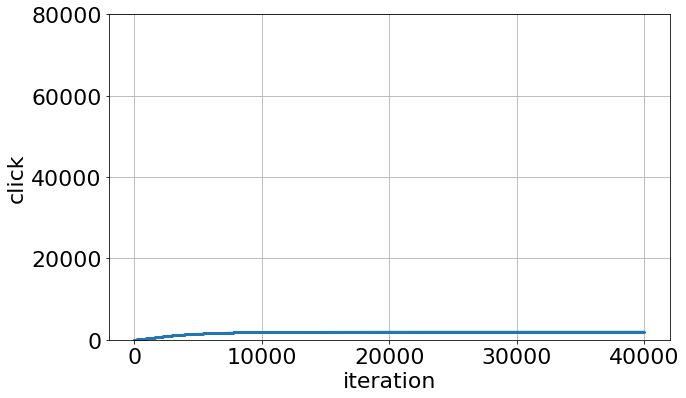

In [ ]:
itr_cumulated_click_count_mean = np.load('/content/itr_cumulated_click_count_mean_ns_airbnb.npy')
itr_cumulated_click_count_std = np.load('/content/itr_cumulated_click_count_std_ns_airbnb.npy')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax.plot(range(len(itr_cumulated_click_count_mean)), itr_cumulated_click_count_mean, marker='.', linewidth=1.5, markersize=1)
ax.fill_between(range(len(itr_cumulated_click_count_std)), itr_cumulated_click_count_mean-itr_cumulated_click_count_std, 
                itr_cumulated_click_count_mean+itr_cumulated_click_count_std, alpha=0.5)
ax.set_ylabel('click')
ax.set_xlabel('iteration')
ax.set_ylim(0., 80000)
ax.grid(True)
fig.patch.set_facecolor('white')
# plt.legend(loc='best')
plt.tight_layout()
plt.show()

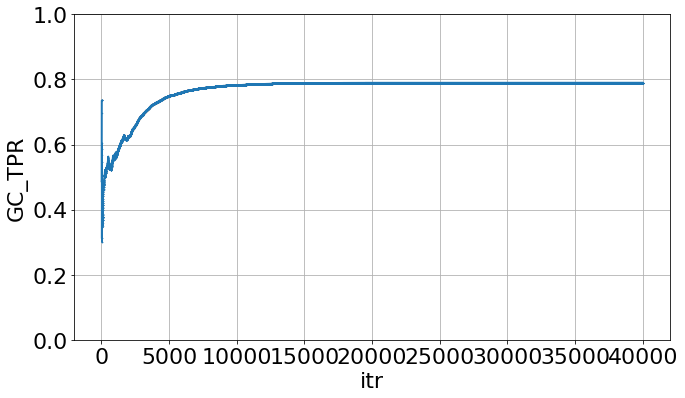

In [ ]:
itr_GC_TPR_mean = np.load('/content/itr_GC_TPR_mean_ns_airbnb.npy')
itr_GC_TPR_std = np.load('./itr_GC_TPR_std_ns_airbnb.npy')
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax.plot(range(len(itr_GC_TPR_mean)), itr_GC_TPR_mean, marker='.', linewidth=1.5, markersize=1)
ax.fill_between(range(len(itr_GC_TPR_mean)), itr_GC_TPR_mean-itr_GC_TPR_std, itr_GC_TPR_mean+itr_GC_TPR_std, alpha=0.5)
ax.set_ylabel('GC_TPR')
ax.set_xlabel('itr')
ax.set_ylim(0., 1)
ax.grid(True)
fig.patch.set_facecolor('white')
# plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
print(' Total clicks: ' + str(np.sum(itr_cumulated_click_count_mean[-1])))
print(' Gini Coeeficient: ' + str(itr_GC_TPR_mean[-1]))

 Total clicks: 2029.0
 Gini Coeeficient: 0.7904260744610522


#**Experiment_Dscale**

**Upload Simulation_DScale.py and MF_CE.py and add parse.add_(alpha...)**

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings; warnings.simplefilter('ignore')  # Ignores Warnings for nicer Plots. Disable for Debugging
import time
import numpy as np
import argparse
import utility
from Simulation_DScale import Simulation


parser = argparse.ArgumentParser(description='Experiment_DScale')
parser.add_argument('--run', type=int, default=1, help='number of experiments to run')
parser.add_argument('--iteration', type=int, default=40000, help='number of iterations to simulate')
parser.add_argument('--exp', type=int, default=1, help='number of initial random exposure iterations')
parser.add_argument('--cycle_itr', type=int, default=50, help='number of iterations in one cycle')
parser.add_argument('--epoch', type=int, default=15, help='number of epochs to train')
parser.add_argument('--K', type=int, default=20, help='number of items to recommend')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate')
parser.add_argument('--reg', type=float, default=1e-5, help='regularization')
parser.add_argument('--hidden', type=int, default=100, help='latent dimension')
parser.add_argument('--neg', type=int, default=5, help='negative sampling rate')
parser.add_argument('--data', type=str, default='ml1m', help='path to eval in the Data folder')
parser.add_argument('--alpha', type=float, default=0.2, help='alpha')
parser.add_argument('--num_user', type=float, default=num_user, help='path to eval in the Data folder')
parser.add_argument('--num_item', type=float, default=num_item, help='path to eval in the Data folder')
parser.add_argument('-f')

args = parser.parse_args()

truth = np.load('/content/truth_airbnb.npy')
args.num_user = truth.shape[0]
args.num_item = truth.shape[1]
audience_size = np.sum(truth, axis=0)
item_sorted = np.argsort(audience_size)
truth_like = list(np.load('/content/user_truth_like_airbnb.npy', allow_pickle=True))

print('')
print('!' * 30 + ' Total truth ' + str(np.sum(truth)) + ' ' + '!' * 30)
print('')

itr_cumulated_click_count_list = []
itr_GC_TPR_list = []

for r in range(args.run):
    print('')
    print('#' * 100)
    print('#' * 100)
    print(' ' * 50 + ' Experiment run ' + str(r + 1) + ' ' * 50)
    print('#' * 100)
    print('#' * 100)
    simulation = Simulation(args, truth, truth_like)
    init_popularity = simulation.initial_iterations()
    itr_click_item = simulation.run_simulation()

    itr_cumulated_click_count = []
    itr_item_click = np.zeros((args.iteration, args.num_item))
    for itr in range(args.iteration):
        click_item = itr_click_item[itr]
        itr_item_click[itr, click_item] = 1.
        itr_cumulated_click_count.append(
            len(click_item) if itr == 0 else len(click_item) + itr_cumulated_click_count[-1])
    for itr in range(1, args.iteration):
        itr_item_click[itr, :] += itr_item_click[itr - 1, :]
    itr_item_click /= (audience_size - init_popularity).reshape((1, -1))

    itr_GC_TPR = []
    for itr in range(args.iteration):
        a = itr_item_click[itr, item_sorted]
        gc = np.sum(((np.arange(len(a)) + 1.) * 2 - len(a) - 1) * a) / (len(a) * np.sum(a))
        itr_GC_TPR.append(gc)

    itr_cumulated_click_count_list.append(itr_cumulated_click_count)
    itr_GC_TPR_list.append(itr_GC_TPR)

    itr_cumulated_click_count_mean = np.mean(itr_cumulated_click_count_list, axis=0)
    itr_cumulated_click_count_std = np.std(itr_cumulated_click_count_list, axis=0)
    itr_GC_TPR_mean = np.mean(itr_GC_TPR_list, axis=0)
    itr_GC_TPR_std = np.std(itr_GC_TPR_list, axis=0)


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Total truth 31951.0 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


####################################################################################################
####################################################################################################
                                                   Experiment run 1                                                  
####################################################################################################
####################################################################################################
Namespace(K=20, alpha=0.2, cycle_itr=50, data='ml1m', epoch=15, exp=1, f='/root/.local/share/jupyter/runtime/kernel-fc381ba0-44ee-4a67-bf4c-ab92f3747d83.json', hidden=100, iteration=40000, lr=0.001, neg=5, num_item=1162, num_user=1000, reg=1e-05, run=1)
****************************** Start initial random iterations ******************************
---------- Iteration 1 ----------


100%|██████████| 1000/1000 [00:00<00:00, 6696.63it/s]


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Generate 187 records.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
****************************** Train MF until converge ******************************
Update bs to 22
******************************MF initialization done ******************************


100%|██████████| 51/51 [00:00<00:00, 71.79it/s]


Training // Epoch 0 //  Total cost = 35.3525  Total cost1 = 35.3332  Total cost2 = 0.0193


100%|██████████| 51/51 [00:00<00:00, 85.29it/s]


Training // Epoch 1 //  Total cost = 35.0194  Total cost1 = 35.0067  Total cost2 = 0.0127


100%|██████████| 51/51 [00:00<00:00, 112.23it/s]


Training // Epoch 2 //  Total cost = 34.5332  Total cost1 = 34.5172  Total cost2 = 0.0160


100%|██████████| 51/51 [00:00<00:00, 210.15it/s]


Training // Epoch 3 //  Total cost = 33.7399  Total cost1 = 33.7182  Total cost2 = 0.0217


100%|██████████| 51/51 [00:00<00:00, 201.29it/s]


Training // Epoch 4 //  Total cost = 32.5384  Total cost1 = 32.5086  Total cost2 = 0.0298


100%|██████████| 51/51 [00:00<00:00, 227.63it/s]


Training // Epoch 5 //  Total cost = 30.8253  Total cost1 = 30.7847  Total cost2 = 0.0405


100%|██████████| 51/51 [00:00<00:00, 218.93it/s]


Training // Epoch 6 //  Total cost = 28.6107  Total cost1 = 28.5562  Total cost2 = 0.0544


100%|██████████| 51/51 [00:00<00:00, 215.95it/s]


Training // Epoch 7 //  Total cost = 25.7291  Total cost1 = 25.6586  Total cost2 = 0.0705


100%|██████████| 51/51 [00:00<00:00, 201.58it/s]


Training // Epoch 8 //  Total cost = 22.4585  Total cost1 = 22.3685  Total cost2 = 0.0900


100%|██████████| 51/51 [00:00<00:00, 228.75it/s]


Training // Epoch 9 //  Total cost = 18.5912  Total cost1 = 18.4800  Total cost2 = 0.1112


100%|██████████| 51/51 [00:00<00:00, 226.43it/s]


Training // Epoch 10 //  Total cost = 14.3960  Total cost1 = 14.2593  Total cost2 = 0.1367


100%|██████████| 51/51 [00:00<00:00, 206.47it/s]


Training // Epoch 11 //  Total cost = 9.5648  Total cost1 = 9.4014  Total cost2 = 0.1634


100%|██████████| 51/51 [00:00<00:00, 204.29it/s]


Training // Epoch 12 //  Total cost = 4.5504  Total cost1 = 4.3571  Total cost2 = 0.1932


100%|██████████| 51/51 [00:00<00:00, 225.61it/s]


Training // Epoch 13 //  Total cost = -0.9075  Total cost1 = -1.1318  Total cost2 = 0.2243


100%|██████████| 51/51 [00:00<00:00, 231.83it/s]


Training // Epoch 14 //  Total cost = -6.5942  Total cost1 = -6.8530  Total cost2 = 0.2588
****************************** Start simulation ******************************


100%|██████████| 50/50 [00:00<00:00, 1368.60it/s]


########## The iteration 50, up to now total 197 clicks, GC=0.0629, this cycle used 0.05 s) ##########
Update bs to 23


100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


100%|██████████| 50/50 [00:00<00:00, 1399.40it/s]


########## The iteration 100, up to now total 200 clicks, GC=-0.0820, this cycle used 3.40 s) ##########
Update bs to 24


100%|██████████| 15/15 [00:03<00:00,  4.70it/s]


100%|██████████| 50/50 [00:00<00:00, 1286.12it/s]


########## The iteration 150, up to now total 212 clicks, GC=0.1197, this cycle used 3.28 s) ##########
Update bs to 25


100%|██████████| 15/15 [00:03<00:00,  4.72it/s]


100%|██████████| 50/50 [00:00<00:00, 1811.48it/s]


########## The iteration 200, up to now total 223 clicks, GC=0.2519, this cycle used 3.28 s) ##########
Update bs to 26


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 1560.85it/s]


########## The iteration 250, up to now total 232 clicks, GC=0.3208, this cycle used 3.36 s) ##########
Update bs to 27


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 1788.01it/s]


########## The iteration 300, up to now total 250 clicks, GC=0.3385, this cycle used 3.39 s) ##########
Update bs to 30


100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


100%|██████████| 50/50 [00:00<00:00, 1290.56it/s]


########## The iteration 350, up to now total 264 clicks, GC=0.3471, this cycle used 3.32 s) ##########
Update bs to 31


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 1372.16it/s]


########## The iteration 400, up to now total 273 clicks, GC=0.3674, this cycle used 3.39 s) ##########
Update bs to 32


100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1345.64it/s]


########## The iteration 450, up to now total 285 clicks, GC=0.3730, this cycle used 3.35 s) ##########
Update bs to 34


100%|██████████| 15/15 [00:05<00:00,  2.67it/s]


100%|██████████| 50/50 [00:00<00:00, 753.56it/s]


########## The iteration 500, up to now total 294 clicks, GC=0.3447, this cycle used 5.76 s) ##########
Update bs to 35


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 1404.46it/s]


########## The iteration 550, up to now total 311 clicks, GC=0.3075, this cycle used 4.12 s) ##########
Update bs to 37


100%|██████████| 15/15 [00:03<00:00,  4.73it/s]


100%|██████████| 50/50 [00:00<00:00, 1594.16it/s]


########## The iteration 600, up to now total 328 clicks, GC=0.2734, this cycle used 3.29 s) ##########
Update bs to 39


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 596.11it/s]


########## The iteration 650, up to now total 343 clicks, GC=0.3015, this cycle used 3.59 s) ##########
Update bs to 41


100%|██████████| 15/15 [00:04<00:00,  3.27it/s]


100%|██████████| 50/50 [00:00<00:00, 1381.76it/s]


########## The iteration 700, up to now total 353 clicks, GC=0.2881, this cycle used 4.71 s) ##########
Update bs to 42


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


100%|██████████| 50/50 [00:00<00:00, 1473.64it/s]


########## The iteration 750, up to now total 366 clicks, GC=0.3038, this cycle used 4.50 s) ##########
Update bs to 43


100%|██████████| 15/15 [00:03<00:00,  4.68it/s]


100%|██████████| 50/50 [00:00<00:00, 1275.49it/s]


########## The iteration 800, up to now total 383 clicks, GC=0.3135, this cycle used 3.33 s) ##########
Update bs to 45


100%|██████████| 15/15 [00:03<00:00,  4.68it/s]


100%|██████████| 50/50 [00:00<00:00, 1164.47it/s]


########## The iteration 850, up to now total 401 clicks, GC=0.3323, this cycle used 3.34 s) ##########
Update bs to 48


100%|██████████| 15/15 [00:03<00:00,  4.76it/s]


100%|██████████| 50/50 [00:00<00:00, 1798.91it/s]


########## The iteration 900, up to now total 418 clicks, GC=0.3330, this cycle used 3.26 s) ##########
Update bs to 50


100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


100%|██████████| 50/50 [00:00<00:00, 1519.09it/s]


########## The iteration 950, up to now total 437 clicks, GC=0.3411, this cycle used 3.34 s) ##########
Update bs to 52


100%|██████████| 15/15 [00:03<00:00,  4.77it/s]


100%|██████████| 50/50 [00:00<00:00, 1408.55it/s]


########## The iteration 1000, up to now total 454 clicks, GC=0.3468, this cycle used 3.26 s) ##########
Update bs to 54


100%|██████████| 15/15 [00:03<00:00,  4.77it/s]


100%|██████████| 50/50 [00:00<00:00, 1745.40it/s]


########## The iteration 1050, up to now total 474 clicks, GC=0.3539, this cycle used 3.26 s) ##########
Update bs to 56


100%|██████████| 15/15 [00:03<00:00,  4.66it/s]


100%|██████████| 50/50 [00:00<00:00, 1695.52it/s]


########## The iteration 1100, up to now total 480 clicks, GC=0.3503, this cycle used 3.34 s) ##########
Update bs to 57


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1572.00it/s]


########## The iteration 1150, up to now total 492 clicks, GC=0.3469, this cycle used 3.38 s) ##########
Update bs to 59


100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


100%|██████████| 50/50 [00:00<00:00, 1505.33it/s]


########## The iteration 1200, up to now total 506 clicks, GC=0.3530, this cycle used 3.36 s) ##########
Update bs to 60


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


100%|██████████| 50/50 [00:00<00:00, 1448.48it/s]


########## The iteration 1250, up to now total 523 clicks, GC=0.3642, this cycle used 3.40 s) ##########
Update bs to 62


100%|██████████| 15/15 [00:03<00:00,  4.57it/s]


100%|██████████| 50/50 [00:00<00:00, 1409.54it/s]


########## The iteration 1300, up to now total 531 clicks, GC=0.3678, this cycle used 3.41 s) ##########
Update bs to 63


100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


100%|██████████| 50/50 [00:00<00:00, 1529.08it/s]


########## The iteration 1350, up to now total 544 clicks, GC=0.3657, this cycle used 3.38 s) ##########
Update bs to 65


100%|██████████| 15/15 [00:03<00:00,  4.73it/s]


100%|██████████| 50/50 [00:00<00:00, 1548.34it/s]


########## The iteration 1400, up to now total 558 clicks, GC=0.3687, this cycle used 3.29 s) ##########
Update bs to 66


100%|██████████| 15/15 [00:03<00:00,  4.68it/s]


100%|██████████| 50/50 [00:00<00:00, 1517.50it/s]


########## The iteration 1450, up to now total 563 clicks, GC=0.3681, this cycle used 3.34 s) ##########
Update bs to 67


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


100%|██████████| 50/50 [00:00<00:00, 590.11it/s]


########## The iteration 1500, up to now total 576 clicks, GC=0.3594, this cycle used 4.32 s) ##########
Update bs to 69


100%|██████████| 15/15 [00:04<00:00,  3.11it/s]


100%|██████████| 50/50 [00:00<00:00, 848.92it/s]


########## The iteration 1550, up to now total 595 clicks, GC=0.3602, this cycle used 5.04 s) ##########
Update bs to 71


100%|██████████| 15/15 [00:04<00:00,  3.19it/s]


100%|██████████| 50/50 [00:00<00:00, 1734.93it/s]


########## The iteration 1600, up to now total 611 clicks, GC=0.3536, this cycle used 4.97 s) ##########
Update bs to 73


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


100%|██████████| 50/50 [00:00<00:00, 781.22it/s]


########## The iteration 1650, up to now total 621 clicks, GC=0.3587, this cycle used 5.24 s) ##########
Update bs to 74


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


100%|██████████| 50/50 [00:00<00:00, 1267.10it/s]


########## The iteration 1700, up to now total 625 clicks, GC=0.3558, this cycle used 4.42 s) ##########
Update bs to 75


100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


100%|██████████| 50/50 [00:00<00:00, 1748.44it/s]


########## The iteration 1750, up to now total 640 clicks, GC=0.3579, this cycle used 3.40 s) ##########
Update bs to 76


100%|██████████| 15/15 [00:03<00:00,  4.47it/s]


100%|██████████| 50/50 [00:00<00:00, 1206.15it/s]


########## The iteration 1800, up to now total 655 clicks, GC=0.3649, this cycle used 3.50 s) ##########
Update bs to 78


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1293.95it/s]


########## The iteration 1850, up to now total 665 clicks, GC=0.3652, this cycle used 3.39 s) ##########
Update bs to 79


100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


100%|██████████| 50/50 [00:00<00:00, 1271.10it/s]


########## The iteration 1900, up to now total 674 clicks, GC=0.3682, this cycle used 3.49 s) ##########
Update bs to 80


100%|██████████| 15/15 [00:03<00:00,  4.51it/s]


100%|██████████| 50/50 [00:00<00:00, 1308.79it/s]


########## The iteration 1950, up to now total 683 clicks, GC=0.3719, this cycle used 3.48 s) ##########
Update bs to 81


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1375.00it/s]


########## The iteration 2000, up to now total 689 clicks, GC=0.3734, this cycle used 3.59 s) ##########
Update bs to 82


100%|██████████| 15/15 [00:03<00:00,  4.48it/s]


100%|██████████| 50/50 [00:00<00:00, 1238.31it/s]


########## The iteration 2050, up to now total 707 clicks, GC=0.3693, this cycle used 3.51 s) ##########
Update bs to 84


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 1316.14it/s]


########## The iteration 2100, up to now total 722 clicks, GC=0.3766, this cycle used 3.59 s) ##########
Update bs to 86


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 1736.20it/s]


########## The iteration 2150, up to now total 736 clicks, GC=0.3771, this cycle used 3.44 s) ##########
Update bs to 88


100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


100%|██████████| 50/50 [00:00<00:00, 1363.34it/s]


########## The iteration 2200, up to now total 753 clicks, GC=0.3670, this cycle used 3.40 s) ##########
Update bs to 90


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 1502.71it/s]


########## The iteration 2250, up to now total 767 clicks, GC=0.3737, this cycle used 3.46 s) ##########
Update bs to 92


100%|██████████| 15/15 [00:03<00:00,  4.44it/s]


100%|██████████| 50/50 [00:00<00:00, 1559.94it/s]


########## The iteration 2300, up to now total 778 clicks, GC=0.3769, this cycle used 3.52 s) ##########
Update bs to 93


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 1491.20it/s]


########## The iteration 2350, up to now total 796 clicks, GC=0.3821, this cycle used 3.60 s) ##########
Update bs to 95


100%|██████████| 15/15 [00:03<00:00,  4.43it/s]


100%|██████████| 50/50 [00:00<00:00, 1832.10it/s]


########## The iteration 2400, up to now total 805 clicks, GC=0.3842, this cycle used 3.54 s) ##########
Update bs to 96


100%|██████████| 15/15 [00:03<00:00,  4.48it/s]


100%|██████████| 50/50 [00:00<00:00, 1209.95it/s]


########## The iteration 2450, up to now total 813 clicks, GC=0.3658, this cycle used 3.51 s) ##########
Update bs to 97


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 1427.74it/s]


########## The iteration 2500, up to now total 828 clicks, GC=0.3647, this cycle used 3.46 s) ##########
Update bs to 99


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1345.37it/s]


########## The iteration 2550, up to now total 842 clicks, GC=0.3547, this cycle used 3.49 s) ##########
Update bs to 101


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


100%|██████████| 50/50 [00:00<00:00, 1337.34it/s]


########## The iteration 2600, up to now total 854 clicks, GC=0.3473, this cycle used 3.49 s) ##########
Update bs to 102


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1269.62it/s]


########## The iteration 2650, up to now total 869 clicks, GC=0.3508, this cycle used 3.48 s) ##########
Update bs to 104


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1426.36it/s]


########## The iteration 2700, up to now total 883 clicks, GC=0.3541, this cycle used 3.60 s) ##########
Update bs to 105


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 1255.13it/s]


########## The iteration 2750, up to now total 890 clicks, GC=0.3499, this cycle used 3.64 s) ##########
Update bs to 106


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 1159.30it/s]


########## The iteration 2800, up to now total 900 clicks, GC=0.3482, this cycle used 3.72 s) ##########
Update bs to 108


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 931.32it/s]


########## The iteration 2850, up to now total 910 clicks, GC=0.3404, this cycle used 3.74 s) ##########
Update bs to 109


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 1197.42it/s]


########## The iteration 2900, up to now total 924 clicks, GC=0.3419, this cycle used 3.47 s) ##########
Update bs to 110


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 1313.96it/s]


########## The iteration 2950, up to now total 932 clicks, GC=0.3451, this cycle used 3.49 s) ##########
Update bs to 111


100%|██████████| 15/15 [00:03<00:00,  4.39it/s]


100%|██████████| 50/50 [00:00<00:00, 1148.50it/s]


########## The iteration 3000, up to now total 941 clicks, GC=0.3401, this cycle used 3.59 s) ##########
Update bs to 112


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


100%|██████████| 50/50 [00:00<00:00, 1215.46it/s]


########## The iteration 3050, up to now total 948 clicks, GC=0.3412, this cycle used 4.39 s) ##########
Update bs to 113


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 1583.87it/s]


########## The iteration 3100, up to now total 959 clicks, GC=0.3367, this cycle used 3.60 s) ##########
Update bs to 115


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 1387.03it/s]


########## The iteration 3150, up to now total 969 clicks, GC=0.3352, this cycle used 3.68 s) ##########
Update bs to 116


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 1506.41it/s]


########## The iteration 3200, up to now total 980 clicks, GC=0.3373, this cycle used 3.80 s) ##########
Update bs to 117


100%|██████████| 15/15 [00:03<00:00,  4.46it/s]


100%|██████████| 50/50 [00:00<00:00, 1389.63it/s]


########## The iteration 3250, up to now total 992 clicks, GC=0.3374, this cycle used 3.54 s) ##########
Update bs to 119


100%|██████████| 15/15 [00:03<00:00,  4.46it/s]


100%|██████████| 50/50 [00:00<00:00, 1196.25it/s]


########## The iteration 3300, up to now total 999 clicks, GC=0.3233, this cycle used 3.55 s) ##########
Update bs to 119


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


100%|██████████| 50/50 [00:00<00:00, 1359.00it/s]


########## The iteration 3350, up to now total 1006 clicks, GC=0.3233, this cycle used 3.46 s) ##########
Update bs to 120


100%|██████████| 15/15 [00:03<00:00,  4.48it/s]


100%|██████████| 50/50 [00:00<00:00, 1107.42it/s]


########## The iteration 3400, up to now total 1018 clicks, GC=0.3197, this cycle used 3.54 s) ##########
Update bs to 122


100%|██████████| 15/15 [00:03<00:00,  4.43it/s]


100%|██████████| 50/50 [00:00<00:00, 1611.32it/s]


########## The iteration 3450, up to now total 1025 clicks, GC=0.3100, this cycle used 3.57 s) ##########
Update bs to 123


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1227.42it/s]


########## The iteration 3500, up to now total 1040 clicks, GC=0.3063, this cycle used 3.64 s) ##########
Update bs to 124


100%|██████████| 15/15 [00:03<00:00,  4.47it/s]


100%|██████████| 50/50 [00:00<00:00, 1171.12it/s]


########## The iteration 3550, up to now total 1053 clicks, GC=0.3079, this cycle used 3.54 s) ##########
Update bs to 126


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


100%|██████████| 50/50 [00:00<00:00, 1235.02it/s]


########## The iteration 3600, up to now total 1067 clicks, GC=0.3053, this cycle used 3.60 s) ##########
Update bs to 128


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 1447.62it/s]


########## The iteration 3650, up to now total 1077 clicks, GC=0.3062, this cycle used 3.69 s) ##########
Update bs to 129


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 1416.61it/s]


########## The iteration 3700, up to now total 1091 clicks, GC=0.3046, this cycle used 3.67 s) ##########
Update bs to 130


100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


100%|██████████| 50/50 [00:00<00:00, 1368.84it/s]


########## The iteration 3750, up to now total 1100 clicks, GC=0.3007, this cycle used 3.61 s) ##########
Update bs to 132


100%|██████████| 15/15 [00:03<00:00,  4.39it/s]


100%|██████████| 50/50 [00:00<00:00, 1250.10it/s]


########## The iteration 3800, up to now total 1109 clicks, GC=0.3027, this cycle used 3.60 s) ##########
Update bs to 133


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 1092.47it/s]


########## The iteration 3850, up to now total 1124 clicks, GC=0.3035, this cycle used 3.62 s) ##########
Update bs to 134


100%|██████████| 15/15 [00:03<00:00,  4.43it/s]


100%|██████████| 50/50 [00:00<00:00, 1088.36it/s]


########## The iteration 3900, up to now total 1132 clicks, GC=0.3049, this cycle used 3.60 s) ##########
Update bs to 135


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 885.27it/s]


########## The iteration 3950, up to now total 1140 clicks, GC=0.2968, this cycle used 3.72 s) ##########
Update bs to 136


100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


100%|██████████| 50/50 [00:00<00:00, 1157.96it/s]


########## The iteration 4000, up to now total 1152 clicks, GC=0.2973, this cycle used 3.63 s) ##########
Update bs to 138


100%|██████████| 15/15 [00:03<00:00,  4.42it/s]


100%|██████████| 50/50 [00:00<00:00, 1217.16it/s]


########## The iteration 4050, up to now total 1159 clicks, GC=0.2977, this cycle used 3.60 s) ##########
Update bs to 139


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


100%|██████████| 50/50 [00:00<00:00, 1446.99it/s]


########## The iteration 4100, up to now total 1169 clicks, GC=0.2988, this cycle used 3.67 s) ##########
Update bs to 140


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 1227.82it/s]


########## The iteration 4150, up to now total 1180 clicks, GC=0.2957, this cycle used 3.73 s) ##########
Update bs to 141


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


100%|██████████| 50/50 [00:00<00:00, 1293.05it/s]


########## The iteration 4200, up to now total 1192 clicks, GC=0.2911, this cycle used 3.66 s) ##########
Update bs to 143


100%|██████████| 15/15 [00:03<00:00,  4.42it/s]


100%|██████████| 50/50 [00:00<00:00, 1428.41it/s]


########## The iteration 4250, up to now total 1209 clicks, GC=0.2878, this cycle used 3.61 s) ##########
Update bs to 145


100%|██████████| 15/15 [00:05<00:00,  2.90it/s]


100%|██████████| 50/50 [00:00<00:00, 1241.38it/s]


########## The iteration 4300, up to now total 1219 clicks, GC=0.2844, this cycle used 5.37 s) ##########
Update bs to 146


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 1507.19it/s]


########## The iteration 4350, up to now total 1229 clicks, GC=0.2801, this cycle used 3.71 s) ##########
Update bs to 147


100%|██████████| 15/15 [00:03<00:00,  4.39it/s]


100%|██████████| 50/50 [00:00<00:00, 994.78it/s]


########## The iteration 4400, up to now total 1240 clicks, GC=0.2812, this cycle used 3.62 s) ##########
Update bs to 148


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 1290.86it/s]


########## The iteration 4450, up to now total 1250 clicks, GC=0.2829, this cycle used 3.75 s) ##########
Update bs to 150


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 1088.82it/s]


########## The iteration 4500, up to now total 1259 clicks, GC=0.2851, this cycle used 3.75 s) ##########
Update bs to 151


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 1086.08it/s]


########## The iteration 4550, up to now total 1270 clicks, GC=0.2872, this cycle used 3.73 s) ##########
Update bs to 152


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 1003.01it/s]


########## The iteration 4600, up to now total 1277 clicks, GC=0.2816, this cycle used 3.67 s) ##########
Update bs to 153


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 1318.80it/s]


########## The iteration 4650, up to now total 1282 clicks, GC=0.2822, this cycle used 3.64 s) ##########
Update bs to 153


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 1079.84it/s]


########## The iteration 4700, up to now total 1292 clicks, GC=0.2843, this cycle used 3.65 s) ##########
Update bs to 155


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 1155.42it/s]


########## The iteration 4750, up to now total 1308 clicks, GC=0.2803, this cycle used 3.64 s) ##########
Update bs to 156


100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


100%|██████████| 50/50 [00:00<00:00, 1083.47it/s]


########## The iteration 4800, up to now total 1314 clicks, GC=0.2815, this cycle used 3.43 s) ##########
Update bs to 157


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


100%|██████████| 50/50 [00:00<00:00, 1209.33it/s]


########## The iteration 4850, up to now total 1328 clicks, GC=0.2821, this cycle used 3.48 s) ##########
Update bs to 159


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


100%|██████████| 50/50 [00:00<00:00, 1247.28it/s]


########## The iteration 4900, up to now total 1337 clicks, GC=0.2815, this cycle used 3.47 s) ##########
Update bs to 160


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


100%|██████████| 50/50 [00:00<00:00, 1031.68it/s]


########## The iteration 4950, up to now total 1345 clicks, GC=0.2787, this cycle used 3.49 s) ##########
Update bs to 161


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 1112.05it/s]


########## The iteration 5000, up to now total 1363 clicks, GC=0.2787, this cycle used 3.51 s) ##########
Update bs to 163


100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


100%|██████████| 50/50 [00:00<00:00, 986.78it/s]


########## The iteration 5050, up to now total 1372 clicks, GC=0.2797, this cycle used 3.49 s) ##########
Update bs to 164


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 1288.36it/s]


########## The iteration 5100, up to now total 1382 clicks, GC=0.2812, this cycle used 3.66 s) ##########
Update bs to 165


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


100%|██████████| 50/50 [00:00<00:00, 1197.37it/s]


########## The iteration 5150, up to now total 1397 clicks, GC=0.2791, this cycle used 3.69 s) ##########
Update bs to 167


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1162.85it/s]


########## The iteration 5200, up to now total 1411 clicks, GC=0.2775, this cycle used 3.54 s) ##########
Update bs to 169


100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


100%|██████████| 50/50 [00:00<00:00, 1022.65it/s]


########## The iteration 5250, up to now total 1425 clicks, GC=0.2753, this cycle used 3.56 s) ##########
Update bs to 171


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 1056.60it/s]


########## The iteration 5300, up to now total 1441 clicks, GC=0.2732, this cycle used 3.78 s) ##########
Update bs to 172


100%|██████████| 15/15 [00:03<00:00,  4.48it/s]


100%|██████████| 50/50 [00:00<00:00, 1294.07it/s]


########## The iteration 5350, up to now total 1455 clicks, GC=0.2684, this cycle used 3.56 s) ##########
Update bs to 174


100%|██████████| 15/15 [00:03<00:00,  4.44it/s]


100%|██████████| 50/50 [00:00<00:00, 749.53it/s]


########## The iteration 5400, up to now total 1468 clicks, GC=0.2682, this cycle used 3.62 s) ##########
Update bs to 176


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 1135.57it/s]


########## The iteration 5450, up to now total 1482 clicks, GC=0.2694, this cycle used 3.65 s) ##########
Update bs to 177


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 970.53it/s]


########## The iteration 5500, up to now total 1493 clicks, GC=0.2688, this cycle used 3.68 s) ##########
Update bs to 179


100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


100%|██████████| 50/50 [00:00<00:00, 1031.69it/s]


########## The iteration 5550, up to now total 1505 clicks, GC=0.2717, this cycle used 3.60 s) ##########
Update bs to 180


100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


100%|██████████| 50/50 [00:00<00:00, 1091.00it/s]


########## The iteration 5600, up to now total 1515 clicks, GC=0.2717, this cycle used 3.59 s) ##########
Update bs to 181


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 968.46it/s]


########## The iteration 5650, up to now total 1525 clicks, GC=0.2692, this cycle used 3.67 s) ##########
Update bs to 183


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1172.19it/s]


########## The iteration 5700, up to now total 1540 clicks, GC=0.2609, this cycle used 3.54 s) ##########
Update bs to 184


100%|██████████| 15/15 [00:03<00:00,  4.43it/s]


100%|██████████| 50/50 [00:00<00:00, 1127.29it/s]


########## The iteration 5750, up to now total 1546 clicks, GC=0.2609, this cycle used 3.60 s) ##########
Update bs to 185


100%|██████████| 15/15 [00:03<00:00,  4.44it/s]


100%|██████████| 50/50 [00:00<00:00, 1195.33it/s]


########## The iteration 5800, up to now total 1551 clicks, GC=0.2621, this cycle used 3.60 s) ##########
Update bs to 186


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 874.64it/s]


########## The iteration 5850, up to now total 1562 clicks, GC=0.2631, this cycle used 3.56 s) ##########
Update bs to 187


100%|██████████| 15/15 [00:03<00:00,  4.46it/s]


100%|██████████| 50/50 [00:00<00:00, 1051.27it/s]


########## The iteration 5900, up to now total 1569 clicks, GC=0.2628, this cycle used 3.61 s) ##########
Update bs to 188


100%|██████████| 15/15 [00:03<00:00,  4.47it/s]


100%|██████████| 50/50 [00:00<00:00, 1043.06it/s]


########## The iteration 5950, up to now total 1582 clicks, GC=0.2626, this cycle used 3.58 s) ##########
Update bs to 189


100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


100%|██████████| 50/50 [00:00<00:00, 1144.15it/s]


########## The iteration 6000, up to now total 1591 clicks, GC=0.2636, this cycle used 3.67 s) ##########
Update bs to 190


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 962.06it/s]


########## The iteration 6050, up to now total 1606 clicks, GC=0.2645, this cycle used 3.68 s) ##########
Update bs to 192


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 1138.13it/s]


########## The iteration 6100, up to now total 1612 clicks, GC=0.2636, this cycle used 3.76 s) ##########
Update bs to 193


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 1119.32it/s]


########## The iteration 6150, up to now total 1623 clicks, GC=0.2653, this cycle used 3.73 s) ##########
Update bs to 194


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 765.77it/s]


########## The iteration 6200, up to now total 1632 clicks, GC=0.2666, this cycle used 3.79 s) ##########
Update bs to 195


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 1070.95it/s]


########## The iteration 6250, up to now total 1645 clicks, GC=0.2633, this cycle used 3.86 s) ##########
Update bs to 197


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 1123.18it/s]


########## The iteration 6300, up to now total 1656 clicks, GC=0.2637, this cycle used 3.81 s) ##########
Update bs to 198


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1059.53it/s]


########## The iteration 6350, up to now total 1665 clicks, GC=0.2640, this cycle used 3.68 s) ##########
Update bs to 199


100%|██████████| 15/15 [00:03<00:00,  4.42it/s]


100%|██████████| 50/50 [00:00<00:00, 1002.23it/s]


########## The iteration 6400, up to now total 1673 clicks, GC=0.2657, this cycle used 3.63 s) ##########
Update bs to 200


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 952.10it/s]


########## The iteration 6450, up to now total 1681 clicks, GC=0.2668, this cycle used 3.69 s) ##########
Update bs to 201


100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


100%|██████████| 50/50 [00:00<00:00, 1397.78it/s]


########## The iteration 6500, up to now total 1690 clicks, GC=0.2669, this cycle used 3.59 s) ##########
Update bs to 202


100%|██████████| 15/15 [00:03<00:00,  4.48it/s]


100%|██████████| 50/50 [00:00<00:00, 1267.60it/s]


########## The iteration 6550, up to now total 1709 clicks, GC=0.2631, this cycle used 3.58 s) ##########
Update bs to 205


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


100%|██████████| 50/50 [00:00<00:00, 1118.22it/s]


########## The iteration 6600, up to now total 1722 clicks, GC=0.2657, this cycle used 3.71 s) ##########
Update bs to 206


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 1148.58it/s]


########## The iteration 6650, up to now total 1732 clicks, GC=0.2671, this cycle used 3.76 s) ##########
Update bs to 207


100%|██████████| 15/15 [00:03<00:00,  4.39it/s]


100%|██████████| 50/50 [00:00<00:00, 1042.40it/s]


########## The iteration 6700, up to now total 1740 clicks, GC=0.2655, this cycle used 3.66 s) ##########
Update bs to 208


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 1065.35it/s]


########## The iteration 6750, up to now total 1758 clicks, GC=0.2644, this cycle used 3.86 s) ##########
Update bs to 210


100%|██████████| 15/15 [00:03<00:00,  4.48it/s]


100%|██████████| 50/50 [00:00<00:00, 1110.07it/s]


########## The iteration 6800, up to now total 1775 clicks, GC=0.2673, this cycle used 3.58 s) ##########
Update bs to 213


100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


100%|██████████| 50/50 [00:00<00:00, 1113.82it/s]


########## The iteration 6850, up to now total 1790 clicks, GC=0.2658, this cycle used 3.64 s) ##########
Update bs to 214


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 1061.32it/s]


########## The iteration 6900, up to now total 1802 clicks, GC=0.2644, this cycle used 3.72 s) ##########
Update bs to 216


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 1352.21it/s]


########## The iteration 6950, up to now total 1810 clicks, GC=0.2641, this cycle used 3.72 s) ##########
Update bs to 217


100%|██████████| 15/15 [00:03<00:00,  4.44it/s]


100%|██████████| 50/50 [00:00<00:00, 1062.81it/s]


########## The iteration 7000, up to now total 1815 clicks, GC=0.2640, this cycle used 3.62 s) ##########
Update bs to 217


100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


100%|██████████| 50/50 [00:00<00:00, 1129.72it/s]


########## The iteration 7050, up to now total 1821 clicks, GC=0.2651, this cycle used 3.61 s) ##########
Update bs to 218


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 1049.10it/s]


########## The iteration 7100, up to now total 1826 clicks, GC=0.2622, this cycle used 3.68 s) ##########
Update bs to 219


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1169.54it/s]


########## The iteration 7150, up to now total 1831 clicks, GC=0.2602, this cycle used 3.71 s) ##########
Update bs to 219


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 928.87it/s]


########## The iteration 7200, up to now total 1833 clicks, GC=0.2606, this cycle used 3.77 s) ##########
Update bs to 219


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 1003.48it/s]


########## The iteration 7250, up to now total 1848 clicks, GC=0.2599, this cycle used 3.83 s) ##########
Update bs to 221


100%|██████████| 15/15 [00:03<00:00,  4.48it/s]


100%|██████████| 50/50 [00:00<00:00, 882.41it/s]


########## The iteration 7300, up to now total 1857 clicks, GC=0.2612, this cycle used 3.60 s) ##########
Update bs to 222


100%|██████████| 15/15 [00:03<00:00,  4.43it/s]


100%|██████████| 50/50 [00:00<00:00, 977.61it/s]


########## The iteration 7350, up to now total 1868 clicks, GC=0.2619, this cycle used 3.63 s) ##########
Update bs to 224


100%|██████████| 15/15 [00:03<00:00,  4.42it/s]


100%|██████████| 50/50 [00:00<00:00, 968.21it/s]


########## The iteration 7400, up to now total 1878 clicks, GC=0.2602, this cycle used 3.65 s) ##########
Update bs to 225


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


100%|██████████| 50/50 [00:00<00:00, 983.84it/s]


########## The iteration 7450, up to now total 1884 clicks, GC=0.2597, this cycle used 3.66 s) ##########
Update bs to 226


100%|██████████| 15/15 [00:03<00:00,  4.47it/s]


100%|██████████| 50/50 [00:00<00:00, 1125.23it/s]


########## The iteration 7500, up to now total 1888 clicks, GC=0.2587, this cycle used 3.61 s) ##########
Update bs to 226


100%|██████████| 15/15 [00:03<00:00,  4.43it/s]


100%|██████████| 50/50 [00:00<00:00, 1067.91it/s]


########## The iteration 7550, up to now total 1897 clicks, GC=0.2582, this cycle used 3.64 s) ##########
Update bs to 227


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 983.03it/s]


########## The iteration 7600, up to now total 1905 clicks, GC=0.2587, this cycle used 3.71 s) ##########
Update bs to 228


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1281.34it/s]


########## The iteration 7650, up to now total 1917 clicks, GC=0.2579, this cycle used 3.70 s) ##########
Update bs to 230


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1150.04it/s]


########## The iteration 7700, up to now total 1927 clicks, GC=0.2573, this cycle used 3.69 s) ##########
Update bs to 231


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 1001.72it/s]


########## The iteration 7750, up to now total 1935 clicks, GC=0.2578, this cycle used 3.76 s) ##########
Update bs to 232


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 890.64it/s]


########## The iteration 7800, up to now total 1944 clicks, GC=0.2586, this cycle used 3.71 s) ##########
Update bs to 233


100%|██████████| 15/15 [00:03<00:00,  4.46it/s]


100%|██████████| 50/50 [00:00<00:00, 1184.89it/s]


########## The iteration 7850, up to now total 1951 clicks, GC=0.2598, this cycle used 3.62 s) ##########
Update bs to 234


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 1024.69it/s]


########## The iteration 7900, up to now total 1961 clicks, GC=0.2599, this cycle used 3.87 s) ##########
Update bs to 235


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 1275.14it/s]


########## The iteration 7950, up to now total 1972 clicks, GC=0.2596, this cycle used 3.91 s) ##########
Update bs to 236


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 964.61it/s]


########## The iteration 8000, up to now total 1980 clicks, GC=0.2602, this cycle used 3.83 s) ##########
Update bs to 237


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 949.02it/s]


########## The iteration 8050, up to now total 1989 clicks, GC=0.2580, this cycle used 3.83 s) ##########
Update bs to 238


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 1149.43it/s]


########## The iteration 8100, up to now total 1993 clicks, GC=0.2580, this cycle used 3.71 s) ##########
Update bs to 239


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 948.55it/s]


########## The iteration 8150, up to now total 2010 clicks, GC=0.2564, this cycle used 3.79 s) ##########
Update bs to 241


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 1150.40it/s]


########## The iteration 8200, up to now total 2019 clicks, GC=0.2563, this cycle used 3.75 s) ##########
Update bs to 242


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 1143.85it/s]


########## The iteration 8250, up to now total 2029 clicks, GC=0.2546, this cycle used 3.73 s) ##########
Update bs to 243


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 951.01it/s]


########## The iteration 8300, up to now total 2042 clicks, GC=0.2539, this cycle used 3.92 s) ##########
Update bs to 245


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 1163.00it/s]


########## The iteration 8350, up to now total 2052 clicks, GC=0.2543, this cycle used 3.78 s) ##########
Update bs to 246


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 1112.51it/s]


########## The iteration 8400, up to now total 2057 clicks, GC=0.2507, this cycle used 3.77 s) ##########
Update bs to 246


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 980.78it/s]


########## The iteration 8450, up to now total 2068 clicks, GC=0.2494, this cycle used 3.97 s) ##########
Update bs to 248


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 1009.87it/s]


########## The iteration 8500, up to now total 2073 clicks, GC=0.2498, this cycle used 3.74 s) ##########
Update bs to 248


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 962.00it/s]


########## The iteration 8550, up to now total 2087 clicks, GC=0.2499, this cycle used 3.75 s) ##########
Update bs to 250


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 1185.33it/s]


########## The iteration 8600, up to now total 2098 clicks, GC=0.2490, this cycle used 3.78 s) ##########
Update bs to 251


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 959.78it/s]


########## The iteration 8650, up to now total 2108 clicks, GC=0.2453, this cycle used 3.82 s) ##########
Update bs to 252


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 864.21it/s]


########## The iteration 8700, up to now total 2120 clicks, GC=0.2413, this cycle used 3.75 s) ##########
Update bs to 254


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 1141.79it/s]


########## The iteration 8750, up to now total 2130 clicks, GC=0.2348, this cycle used 3.99 s) ##########
Update bs to 255


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 941.20it/s]


########## The iteration 8800, up to now total 2142 clicks, GC=0.2352, this cycle used 3.88 s) ##########
Update bs to 257


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 896.46it/s]


########## The iteration 8850, up to now total 2149 clicks, GC=0.2354, this cycle used 3.86 s) ##########
Update bs to 257


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 844.31it/s]


########## The iteration 8900, up to now total 2157 clicks, GC=0.2363, this cycle used 3.93 s) ##########
Update bs to 258


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 884.37it/s]


########## The iteration 8950, up to now total 2162 clicks, GC=0.2369, this cycle used 3.90 s) ##########
Update bs to 259


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 992.30it/s]


########## The iteration 9000, up to now total 2170 clicks, GC=0.2352, this cycle used 3.93 s) ##########
Update bs to 260


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 893.56it/s]


########## The iteration 9050, up to now total 2180 clicks, GC=0.2363, this cycle used 3.80 s) ##########
Update bs to 261


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 925.22it/s]


########## The iteration 9100, up to now total 2186 clicks, GC=0.2351, this cycle used 3.82 s) ##########
Update bs to 262


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 846.38it/s]


########## The iteration 9150, up to now total 2195 clicks, GC=0.2320, this cycle used 3.86 s) ##########
Update bs to 263


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 809.01it/s]


########## The iteration 9200, up to now total 2208 clicks, GC=0.2294, this cycle used 3.79 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 64.67it/s]


########## The iteration 9250, up to now total 2216 clicks, GC=0.2270, this cycle used 4.60 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 1043.83it/s]


########## The iteration 9300, up to now total 2226 clicks, GC=0.2276, this cycle used 3.95 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 804.07it/s]


########## The iteration 9350, up to now total 2240 clicks, GC=0.2236, this cycle used 3.92 s) ##########
Update bs to 268


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 807.52it/s]


########## The iteration 9400, up to now total 2257 clicks, GC=0.2228, this cycle used 3.84 s) ##########
Update bs to 270


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 797.34it/s]


########## The iteration 9450, up to now total 2264 clicks, GC=0.2233, this cycle used 3.75 s) ##########
Update bs to 271


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 913.66it/s]


########## The iteration 9500, up to now total 2269 clicks, GC=0.2214, this cycle used 3.83 s) ##########
Update bs to 272


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 932.53it/s]


########## The iteration 9550, up to now total 2278 clicks, GC=0.2205, this cycle used 3.88 s) ##########
Update bs to 273


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 996.84it/s]


########## The iteration 9600, up to now total 2284 clicks, GC=0.2204, this cycle used 3.82 s) ##########
Update bs to 274


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


100%|██████████| 50/50 [00:00<00:00, 895.79it/s]


########## The iteration 9650, up to now total 2292 clicks, GC=0.2150, this cycle used 3.77 s) ##########
Update bs to 275


100%|██████████| 15/15 [00:03<00:00,  4.39it/s]


100%|██████████| 50/50 [00:00<00:00, 750.63it/s]


########## The iteration 9700, up to now total 2302 clicks, GC=0.2131, this cycle used 3.72 s) ##########
Update bs to 276


100%|██████████| 15/15 [00:03<00:00,  4.43it/s]


100%|██████████| 50/50 [00:00<00:00, 813.87it/s]


########## The iteration 9750, up to now total 2308 clicks, GC=0.2118, this cycle used 3.68 s) ##########
Update bs to 276


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1001.24it/s]


########## The iteration 9800, up to now total 2320 clicks, GC=0.2105, this cycle used 3.73 s) ##########
Update bs to 278


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 1040.90it/s]


########## The iteration 9850, up to now total 2331 clicks, GC=0.2088, this cycle used 3.78 s) ##########
Update bs to 279


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 986.60it/s]


########## The iteration 9900, up to now total 2338 clicks, GC=0.2076, this cycle used 3.85 s) ##########
Update bs to 280


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 1006.91it/s]


########## The iteration 9950, up to now total 2344 clicks, GC=0.2040, this cycle used 4.05 s) ##########
Update bs to 281


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 1034.13it/s]


########## The iteration 10000, up to now total 2356 clicks, GC=0.2045, this cycle used 3.77 s) ##########
Update bs to 282


100%|██████████| 15/15 [00:04<00:00,  3.44it/s]


100%|██████████| 50/50 [00:00<00:00, 285.13it/s]


########## The iteration 10050, up to now total 2367 clicks, GC=0.1978, this cycle used 4.80 s) ##########
Update bs to 284


100%|██████████| 15/15 [00:08<00:00,  1.81it/s]


100%|██████████| 50/50 [00:00<00:00, 304.50it/s]


########## The iteration 10100, up to now total 2377 clicks, GC=0.1952, this cycle used 9.35 s) ##########
Update bs to 285


100%|██████████| 15/15 [00:06<00:00,  2.42it/s]


100%|██████████| 50/50 [00:00<00:00, 557.03it/s]


########## The iteration 10150, up to now total 2381 clicks, GC=0.1938, this cycle used 6.98 s) ##########
Update bs to 285


100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


100%|██████████| 50/50 [00:00<00:00, 894.10it/s]


########## The iteration 10200, up to now total 2383 clicks, GC=0.1942, this cycle used 4.26 s) ##########
Update bs to 285


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1007.58it/s]


########## The iteration 10250, up to now total 2390 clicks, GC=0.1941, this cycle used 3.74 s) ##########
Update bs to 286


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 892.33it/s]


########## The iteration 10300, up to now total 2394 clicks, GC=0.1933, this cycle used 3.89 s) ##########
Update bs to 287


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 839.51it/s]


########## The iteration 10350, up to now total 2407 clicks, GC=0.1892, this cycle used 3.77 s) ##########
Update bs to 288


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 1003.07it/s]


########## The iteration 10400, up to now total 2417 clicks, GC=0.1888, this cycle used 3.80 s) ##########
Update bs to 290


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 949.68it/s]


########## The iteration 10450, up to now total 2429 clicks, GC=0.1864, this cycle used 3.81 s) ##########
Update bs to 291


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 986.56it/s]


########## The iteration 10500, up to now total 2438 clicks, GC=0.1849, this cycle used 3.84 s) ##########
Update bs to 292


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


100%|██████████| 50/50 [00:00<00:00, 869.18it/s]


########## The iteration 10550, up to now total 2449 clicks, GC=0.1813, this cycle used 4.61 s) ##########
Update bs to 293


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 916.86it/s]


########## The iteration 10600, up to now total 2456 clicks, GC=0.1816, this cycle used 3.80 s) ##########
Update bs to 294


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 797.84it/s]


########## The iteration 10650, up to now total 2460 clicks, GC=0.1810, this cycle used 3.81 s) ##########
Update bs to 295


100%|██████████| 15/15 [00:04<00:00,  3.11it/s]


100%|██████████| 50/50 [00:00<00:00, 585.58it/s]


########## The iteration 10700, up to now total 2468 clicks, GC=0.1789, this cycle used 5.20 s) ##########
Update bs to 296


100%|██████████| 15/15 [00:05<00:00,  2.75it/s]


100%|██████████| 50/50 [00:00<00:00, 356.29it/s]


########## The iteration 10750, up to now total 2479 clicks, GC=0.1779, this cycle used 5.97 s) ##########
Update bs to 297


100%|██████████| 15/15 [00:04<00:00,  3.11it/s]


100%|██████████| 50/50 [00:00<00:00, 753.34it/s]


########## The iteration 10800, up to now total 2481 clicks, GC=0.1757, this cycle used 5.19 s) ##########
Update bs to 297


100%|██████████| 15/15 [00:04<00:00,  3.00it/s]


100%|██████████| 50/50 [00:00<00:00, 814.83it/s]


########## The iteration 10850, up to now total 2490 clicks, GC=0.1753, this cycle used 5.41 s) ##########
Update bs to 298


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 547.99it/s]


########## The iteration 10900, up to now total 2497 clicks, GC=0.1745, this cycle used 3.88 s) ##########
Update bs to 299


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 977.14it/s]


########## The iteration 10950, up to now total 2503 clicks, GC=0.1734, this cycle used 4.43 s) ##########
Update bs to 300


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 597.74it/s]


########## The iteration 11000, up to now total 2510 clicks, GC=0.1704, this cycle used 4.48 s) ##########
Update bs to 301


100%|██████████| 15/15 [00:05<00:00,  2.82it/s]


100%|██████████| 50/50 [00:00<00:00, 743.73it/s]


########## The iteration 11050, up to now total 2522 clicks, GC=0.1689, this cycle used 5.82 s) ##########
Update bs to 302


100%|██████████| 15/15 [00:04<00:00,  3.11it/s]


100%|██████████| 50/50 [00:00<00:00, 915.29it/s]


########## The iteration 11100, up to now total 2527 clicks, GC=0.1664, this cycle used 5.13 s) ##########
Update bs to 303


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 861.16it/s]


########## The iteration 11150, up to now total 2533 clicks, GC=0.1647, this cycle used 3.81 s) ##########
Update bs to 303


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


100%|██████████| 50/50 [00:00<00:00, 441.12it/s]


########## The iteration 11200, up to now total 2541 clicks, GC=0.1648, this cycle used 4.55 s) ##########
Update bs to 304


100%|██████████| 15/15 [00:04<00:00,  3.02it/s]


100%|██████████| 50/50 [00:00<00:00, 642.59it/s]


########## The iteration 11250, up to now total 2552 clicks, GC=0.1659, this cycle used 5.31 s) ##########
Update bs to 306


100%|██████████| 15/15 [00:05<00:00,  2.88it/s]


100%|██████████| 50/50 [00:00<00:00, 388.06it/s]


########## The iteration 11300, up to now total 2562 clicks, GC=0.1648, this cycle used 5.75 s) ##########
Update bs to 307


100%|██████████| 15/15 [00:04<00:00,  3.11it/s]


100%|██████████| 50/50 [00:00<00:00, 1165.77it/s]


########## The iteration 11350, up to now total 2568 clicks, GC=0.1644, this cycle used 5.35 s) ##########
Update bs to 308


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 877.50it/s]


########## The iteration 11400, up to now total 2570 clicks, GC=0.1647, this cycle used 3.82 s) ##########
Update bs to 308


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 819.72it/s]


########## The iteration 11450, up to now total 2578 clicks, GC=0.1638, this cycle used 3.83 s) ##########
Update bs to 309


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 803.34it/s]


########## The iteration 11500, up to now total 2590 clicks, GC=0.1618, this cycle used 3.80 s) ##########
Update bs to 310


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 858.58it/s]


########## The iteration 11550, up to now total 2598 clicks, GC=0.1612, this cycle used 3.76 s) ##########
Update bs to 311


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 1018.39it/s]


########## The iteration 11600, up to now total 2604 clicks, GC=0.1618, this cycle used 3.86 s) ##########
Update bs to 312


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 898.88it/s]


########## The iteration 11650, up to now total 2612 clicks, GC=0.1618, this cycle used 3.87 s) ##########
Update bs to 313


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 880.91it/s]


########## The iteration 11700, up to now total 2614 clicks, GC=0.1620, this cycle used 3.81 s) ##########
Update bs to 313


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 757.18it/s]


########## The iteration 11750, up to now total 2629 clicks, GC=0.1606, this cycle used 3.87 s) ##########
Update bs to 315


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 977.23it/s]


########## The iteration 11800, up to now total 2640 clicks, GC=0.1599, this cycle used 3.82 s) ##########
Update bs to 316


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


100%|██████████| 50/50 [00:00<00:00, 993.65it/s]


########## The iteration 11850, up to now total 2649 clicks, GC=0.1587, this cycle used 3.79 s) ##########
Update bs to 317


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 1069.43it/s]


########## The iteration 11900, up to now total 2653 clicks, GC=0.1588, this cycle used 3.83 s) ##########
Update bs to 318


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 909.68it/s]


########## The iteration 11950, up to now total 2659 clicks, GC=0.1592, this cycle used 3.80 s) ##########
Update bs to 319


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 1069.50it/s]


########## The iteration 12000, up to now total 2669 clicks, GC=0.1571, this cycle used 3.81 s) ##########
Update bs to 320


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 833.16it/s]


########## The iteration 12050, up to now total 2686 clicks, GC=0.1536, this cycle used 3.82 s) ##########
Update bs to 322


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 778.87it/s]


########## The iteration 12100, up to now total 2691 clicks, GC=0.1523, this cycle used 3.82 s) ##########
Update bs to 322


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 958.42it/s]


########## The iteration 12150, up to now total 2697 clicks, GC=0.1507, this cycle used 3.83 s) ##########
Update bs to 323


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 1080.45it/s]


########## The iteration 12200, up to now total 2703 clicks, GC=0.1505, this cycle used 3.83 s) ##########
Update bs to 324


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 985.17it/s]


########## The iteration 12250, up to now total 2709 clicks, GC=0.1472, this cycle used 3.83 s) ##########
Update bs to 325


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 830.52it/s]


########## The iteration 12300, up to now total 2717 clicks, GC=0.1450, this cycle used 3.82 s) ##########
Update bs to 326


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 857.90it/s]


########## The iteration 12350, up to now total 2725 clicks, GC=0.1450, this cycle used 3.81 s) ##########
Update bs to 327


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


100%|██████████| 50/50 [00:00<00:00, 689.75it/s]


########## The iteration 12400, up to now total 2734 clicks, GC=0.1455, this cycle used 3.80 s) ##########
Update bs to 328


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 874.34it/s]


########## The iteration 12450, up to now total 2743 clicks, GC=0.1411, this cycle used 3.79 s) ##########
Update bs to 329


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 818.69it/s]


########## The iteration 12500, up to now total 2748 clicks, GC=0.1402, this cycle used 3.80 s) ##########
Update bs to 329


100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


100%|██████████| 50/50 [00:00<00:00, 865.94it/s]


########## The iteration 12550, up to now total 2758 clicks, GC=0.1391, this cycle used 3.76 s) ##########
Update bs to 330


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 845.05it/s]


########## The iteration 12600, up to now total 2770 clicks, GC=0.1399, this cycle used 3.82 s) ##########
Update bs to 332


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


100%|██████████| 50/50 [00:00<00:00, 884.19it/s]


########## The iteration 12650, up to now total 2775 clicks, GC=0.1395, this cycle used 4.66 s) ##########
Update bs to 333


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 819.36it/s]


########## The iteration 12700, up to now total 2780 clicks, GC=0.1390, this cycle used 3.89 s) ##########
Update bs to 333


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 690.52it/s]


########## The iteration 12750, up to now total 2785 clicks, GC=0.1370, this cycle used 3.91 s) ##########
Update bs to 334


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 833.58it/s]


########## The iteration 12800, up to now total 2789 clicks, GC=0.1353, this cycle used 3.91 s) ##########
Update bs to 334


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 804.87it/s]


########## The iteration 12850, up to now total 2799 clicks, GC=0.1334, this cycle used 3.90 s) ##########
Update bs to 335


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 742.49it/s]


########## The iteration 12900, up to now total 2808 clicks, GC=0.1332, this cycle used 3.87 s) ##########
Update bs to 336


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 811.57it/s]


########## The iteration 12950, up to now total 2816 clicks, GC=0.1332, this cycle used 3.80 s) ##########
Update bs to 337


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 768.07it/s]


########## The iteration 13000, up to now total 2824 clicks, GC=0.1334, this cycle used 3.85 s) ##########
Update bs to 338


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 775.53it/s]


########## The iteration 13050, up to now total 2828 clicks, GC=0.1336, this cycle used 3.89 s) ##########
Update bs to 339


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 948.11it/s]


########## The iteration 13100, up to now total 2832 clicks, GC=0.1334, this cycle used 3.78 s) ##########
Update bs to 339


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 985.21it/s]


########## The iteration 13150, up to now total 2840 clicks, GC=0.1333, this cycle used 3.86 s) ##########
Update bs to 340


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 810.63it/s]


########## The iteration 13200, up to now total 2845 clicks, GC=0.1335, this cycle used 3.88 s) ##########
Update bs to 341


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 806.84it/s]


########## The iteration 13250, up to now total 2853 clicks, GC=0.1346, this cycle used 3.88 s) ##########
Update bs to 342


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 696.35it/s]


########## The iteration 13300, up to now total 2857 clicks, GC=0.1326, this cycle used 3.95 s) ##########
Update bs to 342


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 871.12it/s]


########## The iteration 13350, up to now total 2866 clicks, GC=0.1307, this cycle used 3.94 s) ##########
Update bs to 343


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 820.73it/s]


########## The iteration 13400, up to now total 2877 clicks, GC=0.1297, this cycle used 3.84 s) ##########
Update bs to 345


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 861.19it/s]


########## The iteration 13450, up to now total 2884 clicks, GC=0.1298, this cycle used 3.86 s) ##########
Update bs to 346


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 851.34it/s]


########## The iteration 13500, up to now total 2892 clicks, GC=0.1294, this cycle used 3.80 s) ##########
Update bs to 347


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 830.16it/s]


########## The iteration 13550, up to now total 2893 clicks, GC=0.1293, this cycle used 3.86 s) ##########
Update bs to 347


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 963.18it/s]


########## The iteration 13600, up to now total 2903 clicks, GC=0.1248, this cycle used 3.89 s) ##########
Update bs to 348


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 760.44it/s]


########## The iteration 13650, up to now total 2909 clicks, GC=0.1242, this cycle used 3.88 s) ##########
Update bs to 349


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


100%|██████████| 50/50 [00:00<00:00, 723.41it/s]


########## The iteration 13700, up to now total 2916 clicks, GC=0.1222, this cycle used 5.46 s) ##########
Update bs to 349


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 814.85it/s]


########## The iteration 13750, up to now total 2922 clicks, GC=0.1212, this cycle used 3.92 s) ##########
Update bs to 350


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 823.35it/s]


########## The iteration 13800, up to now total 2924 clicks, GC=0.1215, this cycle used 3.91 s) ##########
Update bs to 350


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 838.96it/s]


########## The iteration 13850, up to now total 2926 clicks, GC=0.1216, this cycle used 3.94 s) ##########
Update bs to 351


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 652.96it/s]


########## The iteration 13900, up to now total 2937 clicks, GC=0.1197, this cycle used 3.97 s) ##########
Update bs to 352


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 917.49it/s]


########## The iteration 13950, up to now total 2944 clicks, GC=0.1199, this cycle used 3.93 s) ##########
Update bs to 353


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 802.43it/s]


########## The iteration 14000, up to now total 2957 clicks, GC=0.1187, this cycle used 3.85 s) ##########
Update bs to 354


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 674.95it/s]


########## The iteration 14050, up to now total 2966 clicks, GC=0.1168, this cycle used 3.87 s) ##########
Update bs to 355


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 810.73it/s]


########## The iteration 14100, up to now total 2974 clicks, GC=0.1165, this cycle used 3.84 s) ##########
Update bs to 356


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 1028.72it/s]


########## The iteration 14150, up to now total 2980 clicks, GC=0.1164, this cycle used 3.87 s) ##########
Update bs to 357


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 779.23it/s]


########## The iteration 14200, up to now total 2986 clicks, GC=0.1150, this cycle used 3.94 s) ##########
Update bs to 358


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 637.31it/s]


########## The iteration 14250, up to now total 2998 clicks, GC=0.1130, this cycle used 3.89 s) ##########
Update bs to 359


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 966.65it/s]


########## The iteration 14300, up to now total 3004 clicks, GC=0.1124, this cycle used 3.87 s) ##########
Update bs to 360


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 838.57it/s]


########## The iteration 14350, up to now total 3010 clicks, GC=0.1119, this cycle used 3.92 s) ##########
Update bs to 361


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 830.78it/s]


########## The iteration 14400, up to now total 3015 clicks, GC=0.1118, this cycle used 3.88 s) ##########
Update bs to 361


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 746.84it/s]


########## The iteration 14450, up to now total 3021 clicks, GC=0.1123, this cycle used 3.86 s) ##########
Update bs to 362


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 854.23it/s]


########## The iteration 14500, up to now total 3030 clicks, GC=0.1102, this cycle used 3.93 s) ##########
Update bs to 363


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 772.06it/s]


########## The iteration 14550, up to now total 3038 clicks, GC=0.1080, this cycle used 3.85 s) ##########
Update bs to 364


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 987.56it/s]


########## The iteration 14600, up to now total 3045 clicks, GC=0.1083, this cycle used 3.89 s) ##########
Update bs to 365


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 768.24it/s]


########## The iteration 14650, up to now total 3049 clicks, GC=0.1074, this cycle used 3.95 s) ##########
Update bs to 365


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 771.72it/s]


########## The iteration 14700, up to now total 3054 clicks, GC=0.1058, this cycle used 3.91 s) ##########
Update bs to 366


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 947.30it/s]


########## The iteration 14750, up to now total 3062 clicks, GC=0.1046, this cycle used 3.92 s) ##########
Update bs to 367


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 894.86it/s]


########## The iteration 14800, up to now total 3072 clicks, GC=0.1034, this cycle used 3.87 s) ##########
Update bs to 368


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 872.63it/s]


########## The iteration 14850, up to now total 3077 clicks, GC=0.1033, this cycle used 3.91 s) ##########
Update bs to 369


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


100%|██████████| 50/50 [00:00<00:00, 820.83it/s]


########## The iteration 14900, up to now total 3085 clicks, GC=0.1041, this cycle used 4.21 s) ##########
Update bs to 370


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 954.45it/s]


########## The iteration 14950, up to now total 3096 clicks, GC=0.1034, this cycle used 3.90 s) ##########
Update bs to 371


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 962.38it/s]


########## The iteration 15000, up to now total 3101 clicks, GC=0.1020, this cycle used 3.92 s) ##########
Update bs to 372


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 817.46it/s]


########## The iteration 15050, up to now total 3110 clicks, GC=0.1006, this cycle used 3.93 s) ##########
Update bs to 373


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 880.01it/s]


########## The iteration 15100, up to now total 3114 clicks, GC=0.0987, this cycle used 3.92 s) ##########
Update bs to 373


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 816.78it/s]


########## The iteration 15150, up to now total 3124 clicks, GC=0.0961, this cycle used 3.93 s) ##########
Update bs to 374


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 806.98it/s]


########## The iteration 15200, up to now total 3130 clicks, GC=0.0955, this cycle used 3.97 s) ##########
Update bs to 375


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 791.99it/s]


########## The iteration 15250, up to now total 3138 clicks, GC=0.0950, this cycle used 3.90 s) ##########
Update bs to 376


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 747.85it/s]


########## The iteration 15300, up to now total 3143 clicks, GC=0.0924, this cycle used 4.01 s) ##########
Update bs to 377


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 891.52it/s]


########## The iteration 15350, up to now total 3151 clicks, GC=0.0922, this cycle used 4.01 s) ##########
Update bs to 378


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 911.01it/s]


########## The iteration 15400, up to now total 3153 clicks, GC=0.0925, this cycle used 3.89 s) ##########
Update bs to 378


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 828.68it/s]


########## The iteration 15450, up to now total 3155 clicks, GC=0.0921, this cycle used 4.04 s) ##########
Update bs to 378


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 887.26it/s]


########## The iteration 15500, up to now total 3160 clicks, GC=0.0918, this cycle used 4.00 s) ##########
Update bs to 379


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 821.90it/s]


########## The iteration 15550, up to now total 3167 clicks, GC=0.0919, this cycle used 3.99 s) ##########
Update bs to 380


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 704.21it/s]


########## The iteration 15600, up to now total 3172 clicks, GC=0.0925, this cycle used 4.13 s) ##########
Update bs to 380


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 790.91it/s]


########## The iteration 15650, up to now total 3178 clicks, GC=0.0914, this cycle used 4.15 s) ##########
Update bs to 381


100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


100%|██████████| 50/50 [00:00<00:00, 801.60it/s]


########## The iteration 15700, up to now total 3185 clicks, GC=0.0902, this cycle used 4.15 s) ##########
Update bs to 382


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 791.74it/s]


########## The iteration 15750, up to now total 3188 clicks, GC=0.0898, this cycle used 4.01 s) ##########
Update bs to 382


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 836.18it/s]


########## The iteration 15800, up to now total 3194 clicks, GC=0.0877, this cycle used 4.05 s) ##########
Update bs to 383


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 829.61it/s]


########## The iteration 15850, up to now total 3199 clicks, GC=0.0878, this cycle used 4.08 s) ##########
Update bs to 383


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 1005.33it/s]


########## The iteration 15900, up to now total 3204 clicks, GC=0.0859, this cycle used 4.02 s) ##########
Update bs to 384


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 807.88it/s]


########## The iteration 15950, up to now total 3211 clicks, GC=0.0862, this cycle used 4.09 s) ##########
Update bs to 385


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 844.94it/s]


########## The iteration 16000, up to now total 3225 clicks, GC=0.0833, this cycle used 4.03 s) ##########
Update bs to 387


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 845.21it/s]


########## The iteration 16050, up to now total 3233 clicks, GC=0.0823, this cycle used 4.03 s) ##########
Update bs to 387


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 797.86it/s]


########## The iteration 16100, up to now total 3243 clicks, GC=0.0818, this cycle used 4.09 s) ##########
Update bs to 389


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 813.02it/s]


########## The iteration 16150, up to now total 3251 clicks, GC=0.0808, this cycle used 4.03 s) ##########
Update bs to 390


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 850.26it/s]


########## The iteration 16200, up to now total 3254 clicks, GC=0.0808, this cycle used 4.07 s) ##########
Update bs to 390


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 732.42it/s]


########## The iteration 16250, up to now total 3258 clicks, GC=0.0803, this cycle used 4.09 s) ##########
Update bs to 390


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 803.07it/s]


########## The iteration 16300, up to now total 3264 clicks, GC=0.0790, this cycle used 4.03 s) ##########
Update bs to 391


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 686.50it/s]


########## The iteration 16350, up to now total 3269 clicks, GC=0.0784, this cycle used 4.09 s) ##########
Update bs to 392


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 823.70it/s]


########## The iteration 16400, up to now total 3277 clicks, GC=0.0785, this cycle used 4.10 s) ##########
Update bs to 393


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 604.48it/s]


########## The iteration 16450, up to now total 3279 clicks, GC=0.0781, this cycle used 4.11 s) ##########
Update bs to 393


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 842.97it/s]


########## The iteration 16500, up to now total 3287 clicks, GC=0.0754, this cycle used 4.11 s) ##########
Update bs to 394


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 751.66it/s]


########## The iteration 16550, up to now total 3295 clicks, GC=0.0738, this cycle used 4.15 s) ##########
Update bs to 395


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 1016.47it/s]


########## The iteration 16600, up to now total 3301 clicks, GC=0.0710, this cycle used 4.09 s) ##########
Update bs to 396


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 816.22it/s]


########## The iteration 16650, up to now total 3312 clicks, GC=0.0691, this cycle used 4.05 s) ##########
Update bs to 397


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 988.26it/s]


########## The iteration 16700, up to now total 3318 clicks, GC=0.0674, this cycle used 4.02 s) ##########
Update bs to 398


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 830.93it/s]


########## The iteration 16750, up to now total 3325 clicks, GC=0.0664, this cycle used 4.08 s) ##########
Update bs to 399


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 724.99it/s]


########## The iteration 16800, up to now total 3329 clicks, GC=0.0656, this cycle used 3.98 s) ##########
Update bs to 399


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 681.90it/s]


########## The iteration 16850, up to now total 3335 clicks, GC=0.0637, this cycle used 3.97 s) ##########
Update bs to 400


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 671.05it/s]


########## The iteration 16900, up to now total 3342 clicks, GC=0.0621, this cycle used 3.94 s) ##########
Update bs to 401


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 624.30it/s]


########## The iteration 16950, up to now total 3349 clicks, GC=0.0618, this cycle used 4.04 s) ##########
Update bs to 401


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 788.50it/s]


########## The iteration 17000, up to now total 3352 clicks, GC=0.0611, this cycle used 4.01 s) ##########
Update bs to 402


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 845.87it/s]


########## The iteration 17050, up to now total 3360 clicks, GC=0.0595, this cycle used 3.96 s) ##########
Update bs to 403


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 791.92it/s]


########## The iteration 17100, up to now total 3364 clicks, GC=0.0595, this cycle used 4.10 s) ##########
Update bs to 403


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 831.37it/s]


########## The iteration 17150, up to now total 3370 clicks, GC=0.0589, this cycle used 4.11 s) ##########
Update bs to 404


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 714.15it/s]


########## The iteration 17200, up to now total 3378 clicks, GC=0.0590, this cycle used 4.16 s) ##########
Update bs to 405


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 756.05it/s]


########## The iteration 17250, up to now total 3381 clicks, GC=0.0580, this cycle used 4.12 s) ##########
Update bs to 405


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 954.26it/s]


########## The iteration 17300, up to now total 3391 clicks, GC=0.0564, this cycle used 4.00 s) ##########
Update bs to 406


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 761.04it/s]


########## The iteration 17350, up to now total 3394 clicks, GC=0.0558, this cycle used 4.01 s) ##########
Update bs to 407


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 655.60it/s]


########## The iteration 17400, up to now total 3400 clicks, GC=0.0542, this cycle used 4.02 s) ##########
Update bs to 408


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 919.41it/s]


########## The iteration 17450, up to now total 3410 clicks, GC=0.0511, this cycle used 4.03 s) ##########
Update bs to 409


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 854.12it/s]


########## The iteration 17500, up to now total 3418 clicks, GC=0.0507, this cycle used 4.02 s) ##########
Update bs to 410


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 872.64it/s]


########## The iteration 17550, up to now total 3420 clicks, GC=0.0503, this cycle used 4.00 s) ##########
Update bs to 410


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 819.40it/s]


########## The iteration 17600, up to now total 3431 clicks, GC=0.0494, this cycle used 3.99 s) ##########
Update bs to 411


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 734.68it/s]


########## The iteration 17650, up to now total 3437 clicks, GC=0.0465, this cycle used 4.05 s) ##########
Update bs to 412


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 835.15it/s]


########## The iteration 17700, up to now total 3441 clicks, GC=0.0441, this cycle used 3.99 s) ##########
Update bs to 412


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 820.77it/s]


########## The iteration 17750, up to now total 3445 clicks, GC=0.0434, this cycle used 4.02 s) ##########
Update bs to 413


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 743.76it/s]


########## The iteration 17800, up to now total 3447 clicks, GC=0.0427, this cycle used 4.01 s) ##########
Update bs to 413


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 954.50it/s]


########## The iteration 17850, up to now total 3455 clicks, GC=0.0415, this cycle used 4.04 s) ##########
Update bs to 414


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 838.80it/s]


########## The iteration 17900, up to now total 3465 clicks, GC=0.0390, this cycle used 4.06 s) ##########
Update bs to 415


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 797.65it/s]


########## The iteration 17950, up to now total 3472 clicks, GC=0.0375, this cycle used 4.03 s) ##########
Update bs to 416


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 666.08it/s]


########## The iteration 18000, up to now total 3476 clicks, GC=0.0345, this cycle used 4.01 s) ##########
Update bs to 417


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 933.41it/s]


########## The iteration 18050, up to now total 3481 clicks, GC=0.0325, this cycle used 4.11 s) ##########
Update bs to 417


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 772.93it/s]


########## The iteration 18100, up to now total 3485 clicks, GC=0.0322, this cycle used 3.99 s) ##########
Update bs to 418


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 762.56it/s]


########## The iteration 18150, up to now total 3490 clicks, GC=0.0302, this cycle used 4.07 s) ##########
Update bs to 418


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 764.49it/s]


########## The iteration 18200, up to now total 3494 clicks, GC=0.0301, this cycle used 4.01 s) ##########
Update bs to 419


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 820.56it/s]


########## The iteration 18250, up to now total 3502 clicks, GC=0.0300, this cycle used 4.01 s) ##########
Update bs to 420


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 713.88it/s]


########## The iteration 18300, up to now total 3509 clicks, GC=0.0295, this cycle used 4.04 s) ##########
Update bs to 421


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 568.39it/s]


########## The iteration 18350, up to now total 3517 clicks, GC=0.0289, this cycle used 4.05 s) ##########
Update bs to 422


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 593.62it/s]


########## The iteration 18400, up to now total 3525 clicks, GC=0.0279, this cycle used 4.00 s) ##########
Update bs to 423


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 62.46it/s]


########## The iteration 18450, up to now total 3534 clicks, GC=0.0223, this cycle used 4.77 s) ##########
Update bs to 424


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 959.37it/s]


########## The iteration 18500, up to now total 3542 clicks, GC=0.0208, this cycle used 4.00 s) ##########
Update bs to 425


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 1114.43it/s]


########## The iteration 18550, up to now total 3553 clicks, GC=0.0193, this cycle used 4.03 s) ##########
Update bs to 426


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 950.68it/s]


########## The iteration 18600, up to now total 3559 clicks, GC=0.0193, this cycle used 3.98 s) ##########
Update bs to 427


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 534.63it/s]


########## The iteration 18650, up to now total 3565 clicks, GC=0.0198, this cycle used 4.03 s) ##########
Update bs to 427


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 737.94it/s]


########## The iteration 18700, up to now total 3568 clicks, GC=0.0197, this cycle used 4.07 s) ##########
Update bs to 428


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 863.10it/s]


########## The iteration 18750, up to now total 3574 clicks, GC=0.0192, this cycle used 4.07 s) ##########
Update bs to 428


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 580.54it/s]


########## The iteration 18800, up to now total 3581 clicks, GC=0.0187, this cycle used 4.06 s) ##########
Update bs to 429


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 734.18it/s]


########## The iteration 18850, up to now total 3584 clicks, GC=0.0186, this cycle used 3.99 s) ##########
Update bs to 430


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 719.60it/s]


########## The iteration 18900, up to now total 3590 clicks, GC=0.0176, this cycle used 4.01 s) ##########
Update bs to 430


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 735.56it/s]


########## The iteration 18950, up to now total 3596 clicks, GC=0.0164, this cycle used 3.97 s) ##########
Update bs to 431


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 708.97it/s]


########## The iteration 19000, up to now total 3606 clicks, GC=0.0148, this cycle used 4.01 s) ##########
Update bs to 432


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 768.17it/s]


########## The iteration 19050, up to now total 3611 clicks, GC=0.0128, this cycle used 4.01 s) ##########
Update bs to 433


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 792.23it/s]


########## The iteration 19100, up to now total 3617 clicks, GC=0.0114, this cycle used 4.00 s) ##########
Update bs to 434


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 689.57it/s]


########## The iteration 19150, up to now total 3622 clicks, GC=0.0103, this cycle used 3.99 s) ##########
Update bs to 434


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 791.68it/s]


########## The iteration 19200, up to now total 3629 clicks, GC=0.0107, this cycle used 3.98 s) ##########
Update bs to 435


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 674.53it/s]


########## The iteration 19250, up to now total 3641 clicks, GC=0.0096, this cycle used 4.00 s) ##########
Update bs to 436


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 810.11it/s]


########## The iteration 19300, up to now total 3646 clicks, GC=0.0088, this cycle used 4.06 s) ##########
Update bs to 437


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 592.83it/s]


########## The iteration 19350, up to now total 3655 clicks, GC=0.0081, this cycle used 4.13 s) ##########
Update bs to 438


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 880.43it/s]


########## The iteration 19400, up to now total 3664 clicks, GC=0.0059, this cycle used 4.16 s) ##########
Update bs to 439


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 922.68it/s]


########## The iteration 19450, up to now total 3667 clicks, GC=0.0056, this cycle used 4.14 s) ##########
Update bs to 440


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 808.43it/s]


########## The iteration 19500, up to now total 3672 clicks, GC=0.0038, this cycle used 4.05 s) ##########
Update bs to 440


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 808.32it/s]


########## The iteration 19550, up to now total 3676 clicks, GC=0.0025, this cycle used 4.15 s) ##########
Update bs to 441


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 769.51it/s]


########## The iteration 19600, up to now total 3678 clicks, GC=0.0022, this cycle used 4.17 s) ##########
Update bs to 441


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 1062.81it/s]


########## The iteration 19650, up to now total 3683 clicks, GC=0.0013, this cycle used 4.05 s) ##########
Update bs to 441


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 929.56it/s]


########## The iteration 19700, up to now total 3686 clicks, GC=0.0006, this cycle used 3.97 s) ##########
Update bs to 442


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 863.37it/s]


########## The iteration 19750, up to now total 3694 clicks, GC=-0.0013, this cycle used 4.05 s) ##########
Update bs to 443


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 674.47it/s]


########## The iteration 19800, up to now total 3696 clicks, GC=-0.0020, this cycle used 4.08 s) ##########
Update bs to 443


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 774.04it/s]


########## The iteration 19850, up to now total 3700 clicks, GC=-0.0032, this cycle used 4.07 s) ##########
Update bs to 444


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 989.19it/s]


########## The iteration 19900, up to now total 3703 clicks, GC=-0.0032, this cycle used 4.06 s) ##########
Update bs to 444


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 819.24it/s]


########## The iteration 19950, up to now total 3711 clicks, GC=-0.0051, this cycle used 4.07 s) ##########
Update bs to 445


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 768.27it/s]


########## The iteration 20000, up to now total 3721 clicks, GC=-0.0071, this cycle used 4.06 s) ##########
Update bs to 446


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 907.73it/s]


########## The iteration 20050, up to now total 3727 clicks, GC=-0.0085, this cycle used 4.04 s) ##########
Update bs to 447


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 761.07it/s]


########## The iteration 20100, up to now total 3734 clicks, GC=-0.0090, this cycle used 4.08 s) ##########
Update bs to 448


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 802.46it/s]


########## The iteration 20150, up to now total 3741 clicks, GC=-0.0101, this cycle used 4.13 s) ##########
Update bs to 448


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 802.38it/s]


########## The iteration 20200, up to now total 3749 clicks, GC=-0.0124, this cycle used 4.11 s) ##########
Update bs to 449


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 850.37it/s]


########## The iteration 20250, up to now total 3755 clicks, GC=-0.0139, this cycle used 4.09 s) ##########
Update bs to 450


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 814.65it/s]


########## The iteration 20300, up to now total 3759 clicks, GC=-0.0150, this cycle used 4.10 s) ##########
Update bs to 451


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 867.32it/s]


########## The iteration 20350, up to now total 3763 clicks, GC=-0.0159, this cycle used 4.13 s) ##########
Update bs to 451


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 673.56it/s]


########## The iteration 20400, up to now total 3767 clicks, GC=-0.0160, this cycle used 4.13 s) ##########
Update bs to 452


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 798.81it/s]


########## The iteration 20450, up to now total 3772 clicks, GC=-0.0162, this cycle used 4.11 s) ##########
Update bs to 452


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 839.90it/s]


########## The iteration 20500, up to now total 3775 clicks, GC=-0.0167, this cycle used 4.04 s) ##########
Update bs to 453


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 910.02it/s]


########## The iteration 20550, up to now total 3780 clicks, GC=-0.0174, this cycle used 4.08 s) ##########
Update bs to 453


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 830.53it/s]


########## The iteration 20600, up to now total 3784 clicks, GC=-0.0181, this cycle used 4.06 s) ##########
Update bs to 454


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 818.68it/s]


########## The iteration 20650, up to now total 3788 clicks, GC=-0.0188, this cycle used 4.02 s) ##########
Update bs to 454


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 757.86it/s]


########## The iteration 20700, up to now total 3790 clicks, GC=-0.0188, this cycle used 4.13 s) ##########
Update bs to 454


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 756.94it/s]


########## The iteration 20750, up to now total 3795 clicks, GC=-0.0198, this cycle used 4.14 s) ##########
Update bs to 455


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 927.55it/s]


########## The iteration 20800, up to now total 3804 clicks, GC=-0.0213, this cycle used 4.12 s) ##########
Update bs to 456


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 733.33it/s]


########## The iteration 20850, up to now total 3809 clicks, GC=-0.0236, this cycle used 4.13 s) ##########
Update bs to 457


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 657.64it/s]


########## The iteration 20900, up to now total 3815 clicks, GC=-0.0253, this cycle used 4.17 s) ##########
Update bs to 457


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 822.28it/s]


########## The iteration 20950, up to now total 3819 clicks, GC=-0.0266, this cycle used 4.11 s) ##########
Update bs to 458


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 574.31it/s]


########## The iteration 21000, up to now total 3826 clicks, GC=-0.0279, this cycle used 4.16 s) ##########
Update bs to 459


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 729.45it/s]


########## The iteration 21050, up to now total 3835 clicks, GC=-0.0300, this cycle used 4.51 s) ##########
Update bs to 460


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 832.05it/s]


########## The iteration 21100, up to now total 3838 clicks, GC=-0.0296, this cycle used 4.17 s) ##########
Update bs to 460


100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


100%|██████████| 50/50 [00:00<00:00, 576.76it/s]


########## The iteration 21150, up to now total 3841 clicks, GC=-0.0312, this cycle used 4.27 s) ##########
Update bs to 460


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 820.84it/s]


########## The iteration 21200, up to now total 3845 clicks, GC=-0.0325, this cycle used 4.12 s) ##########
Update bs to 461


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 682.81it/s]


########## The iteration 21250, up to now total 3854 clicks, GC=-0.0338, this cycle used 4.17 s) ##########
Update bs to 462


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 635.70it/s]


########## The iteration 21300, up to now total 3863 clicks, GC=-0.0358, this cycle used 4.14 s) ##########
Update bs to 463


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 714.73it/s]


########## The iteration 21350, up to now total 3869 clicks, GC=-0.0364, this cycle used 4.15 s) ##########
Update bs to 464


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 885.34it/s]


########## The iteration 21400, up to now total 3875 clicks, GC=-0.0361, this cycle used 4.12 s) ##########
Update bs to 465


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 657.23it/s]


########## The iteration 21450, up to now total 3884 clicks, GC=-0.0377, this cycle used 4.19 s) ##########
Update bs to 466


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 803.08it/s]


########## The iteration 21500, up to now total 3891 clicks, GC=-0.0399, this cycle used 4.14 s) ##########
Update bs to 466


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 997.02it/s]


########## The iteration 21550, up to now total 3895 clicks, GC=-0.0396, this cycle used 4.11 s) ##########
Update bs to 467


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 898.29it/s]


########## The iteration 21600, up to now total 3903 clicks, GC=-0.0410, this cycle used 4.13 s) ##########
Update bs to 468


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 606.32it/s]


########## The iteration 21650, up to now total 3905 clicks, GC=-0.0428, this cycle used 4.20 s) ##########
Update bs to 468


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 725.13it/s]


########## The iteration 21700, up to now total 3911 clicks, GC=-0.0448, this cycle used 4.19 s) ##########
Update bs to 469


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


100%|██████████| 50/50 [00:00<00:00, 810.96it/s]


########## The iteration 21750, up to now total 3914 clicks, GC=-0.0458, this cycle used 4.23 s) ##########
Update bs to 469


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


100%|██████████| 50/50 [00:00<00:00, 687.10it/s]


########## The iteration 21800, up to now total 3920 clicks, GC=-0.0464, this cycle used 4.31 s) ##########
Update bs to 470


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 796.25it/s]


########## The iteration 21850, up to now total 3931 clicks, GC=-0.0487, this cycle used 4.22 s) ##########
Update bs to 471


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


100%|██████████| 50/50 [00:00<00:00, 706.46it/s]


########## The iteration 21900, up to now total 3933 clicks, GC=-0.0485, this cycle used 4.27 s) ##########
Update bs to 471


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 870.27it/s]


########## The iteration 21950, up to now total 3937 clicks, GC=-0.0507, this cycle used 4.21 s) ##########
Update bs to 472


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 577.81it/s]


########## The iteration 22000, up to now total 3943 clicks, GC=-0.0517, this cycle used 4.29 s) ##########
Update bs to 473


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 770.67it/s]


########## The iteration 22050, up to now total 3945 clicks, GC=-0.0517, this cycle used 4.24 s) ##########
Update bs to 473


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 630.90it/s]


########## The iteration 22100, up to now total 3951 clicks, GC=-0.0527, this cycle used 4.24 s) ##########
Update bs to 474


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 903.19it/s]


########## The iteration 22150, up to now total 3956 clicks, GC=-0.0534, this cycle used 4.22 s) ##########
Update bs to 474


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 837.36it/s]


########## The iteration 22200, up to now total 3960 clicks, GC=-0.0551, this cycle used 4.20 s) ##########
Update bs to 475


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 826.87it/s]


########## The iteration 22250, up to now total 3962 clicks, GC=-0.0557, this cycle used 4.24 s) ##########
Update bs to 475


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 707.46it/s]


########## The iteration 22300, up to now total 3965 clicks, GC=-0.0575, this cycle used 4.19 s) ##########
Update bs to 475


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 807.42it/s]


########## The iteration 22350, up to now total 3969 clicks, GC=-0.0576, this cycle used 4.24 s) ##########
Update bs to 476


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 800.32it/s]


########## The iteration 22400, up to now total 3972 clicks, GC=-0.0585, this cycle used 4.16 s) ##########
Update bs to 476


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 798.10it/s]


########## The iteration 22450, up to now total 3977 clicks, GC=-0.0583, this cycle used 4.21 s) ##########
Update bs to 477


100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


100%|██████████| 50/50 [00:00<00:00, 813.71it/s]


########## The iteration 22500, up to now total 3981 clicks, GC=-0.0581, this cycle used 4.25 s) ##########
Update bs to 477


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 785.36it/s]


########## The iteration 22550, up to now total 3986 clicks, GC=-0.0585, this cycle used 4.25 s) ##########
Update bs to 478


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 733.98it/s]


########## The iteration 22600, up to now total 3988 clicks, GC=-0.0585, this cycle used 4.21 s) ##########
Update bs to 478


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 828.28it/s]


########## The iteration 22650, up to now total 3990 clicks, GC=-0.0588, this cycle used 4.19 s) ##########
Update bs to 478


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 773.37it/s]


########## The iteration 22700, up to now total 3995 clicks, GC=-0.0606, this cycle used 4.15 s) ##########
Update bs to 479


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 722.58it/s]


########## The iteration 22750, up to now total 3999 clicks, GC=-0.0610, this cycle used 4.19 s) ##########
Update bs to 479


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 713.28it/s]


########## The iteration 22800, up to now total 4007 clicks, GC=-0.0628, this cycle used 4.20 s) ##########
Update bs to 480


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 838.21it/s]


########## The iteration 22850, up to now total 4010 clicks, GC=-0.0631, this cycle used 4.15 s) ##########
Update bs to 481


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 838.49it/s]


########## The iteration 22900, up to now total 4021 clicks, GC=-0.0642, this cycle used 4.16 s) ##########
Update bs to 482


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 672.87it/s]


########## The iteration 22950, up to now total 4028 clicks, GC=-0.0649, this cycle used 4.19 s) ##########
Update bs to 483


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 850.69it/s]


########## The iteration 23000, up to now total 4034 clicks, GC=-0.0649, this cycle used 4.15 s) ##########
Update bs to 484


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 779.58it/s]


########## The iteration 23050, up to now total 4040 clicks, GC=-0.0666, this cycle used 4.16 s) ##########
Update bs to 484


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 946.29it/s]


########## The iteration 23100, up to now total 4046 clicks, GC=-0.0677, this cycle used 4.15 s) ##########
Update bs to 485


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 882.32it/s]


########## The iteration 23150, up to now total 4054 clicks, GC=-0.0695, this cycle used 4.18 s) ##########
Update bs to 486


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 810.85it/s]


########## The iteration 23200, up to now total 4058 clicks, GC=-0.0695, this cycle used 4.23 s) ##########
Update bs to 486


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 667.68it/s]


########## The iteration 23250, up to now total 4062 clicks, GC=-0.0698, this cycle used 4.26 s) ##########
Update bs to 487


100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


100%|██████████| 50/50 [00:00<00:00, 791.38it/s]


########## The iteration 23300, up to now total 4066 clicks, GC=-0.0698, this cycle used 4.30 s) ##########
Update bs to 487


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 812.19it/s]


########## The iteration 23350, up to now total 4070 clicks, GC=-0.0700, this cycle used 4.24 s) ##########
Update bs to 488


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 904.63it/s]


########## The iteration 23400, up to now total 4072 clicks, GC=-0.0699, this cycle used 4.23 s) ##########
Update bs to 488


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 803.12it/s]


########## The iteration 23450, up to now total 4085 clicks, GC=-0.0705, this cycle used 4.19 s) ##########
Update bs to 490


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 776.57it/s]


########## The iteration 23500, up to now total 4088 clicks, GC=-0.0705, this cycle used 4.19 s) ##########
Update bs to 490


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 816.27it/s]


########## The iteration 23550, up to now total 4093 clicks, GC=-0.0712, this cycle used 4.23 s) ##########
Update bs to 491


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 771.24it/s]


########## The iteration 23600, up to now total 4096 clicks, GC=-0.0714, this cycle used 4.22 s) ##########
Update bs to 491


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 826.42it/s]


########## The iteration 23650, up to now total 4102 clicks, GC=-0.0715, this cycle used 4.20 s) ##########
Update bs to 492


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


100%|██████████| 50/50 [00:00<00:00, 803.54it/s]


########## The iteration 23700, up to now total 4106 clicks, GC=-0.0717, this cycle used 4.31 s) ##########
Update bs to 492


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 931.14it/s]


########## The iteration 23750, up to now total 4110 clicks, GC=-0.0727, this cycle used 4.24 s) ##########
Update bs to 493


100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


100%|██████████| 50/50 [00:00<00:00, 786.83it/s]


########## The iteration 23800, up to now total 4115 clicks, GC=-0.0732, this cycle used 4.30 s) ##########
Update bs to 493


100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


100%|██████████| 50/50 [00:00<00:00, 708.32it/s]


########## The iteration 23850, up to now total 4122 clicks, GC=-0.0747, this cycle used 4.28 s) ##########
Update bs to 494


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


100%|██████████| 50/50 [00:00<00:00, 830.02it/s]


########## The iteration 23900, up to now total 4129 clicks, GC=-0.0756, this cycle used 4.31 s) ##########
Update bs to 495


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 1076.84it/s]


########## The iteration 23950, up to now total 4133 clicks, GC=-0.0756, this cycle used 4.22 s) ##########
Update bs to 495


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 875.68it/s]


########## The iteration 24000, up to now total 4138 clicks, GC=-0.0753, this cycle used 4.23 s) ##########
Update bs to 496


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 776.56it/s]


########## The iteration 24050, up to now total 4144 clicks, GC=-0.0750, this cycle used 4.27 s) ##########
Update bs to 497


100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


100%|██████████| 50/50 [00:00<00:00, 838.95it/s]


########## The iteration 24100, up to now total 4144 clicks, GC=-0.0750, this cycle used 4.28 s) ##########
Update bs to 497


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


100%|██████████| 50/50 [00:00<00:00, 879.86it/s]


########## The iteration 24150, up to now total 4151 clicks, GC=-0.0751, this cycle used 4.27 s) ##########
Update bs to 498


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 857.78it/s]


########## The iteration 24200, up to now total 4158 clicks, GC=-0.0758, this cycle used 4.25 s) ##########
Update bs to 498


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 810.61it/s]


########## The iteration 24250, up to now total 4161 clicks, GC=-0.0755, this cycle used 4.22 s) ##########
Update bs to 499


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 717.94it/s]


########## The iteration 24300, up to now total 4164 clicks, GC=-0.0756, this cycle used 4.21 s) ##########
Update bs to 499


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 930.79it/s]


########## The iteration 24350, up to now total 4167 clicks, GC=-0.0755, this cycle used 4.23 s) ##########
Update bs to 500


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 627.77it/s]


########## The iteration 24400, up to now total 4171 clicks, GC=-0.0758, this cycle used 4.19 s) ##########
Update bs to 500


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 805.75it/s]


########## The iteration 24450, up to now total 4178 clicks, GC=-0.0767, this cycle used 4.26 s) ##########
Update bs to 501


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 816.34it/s]


########## The iteration 24500, up to now total 4187 clicks, GC=-0.0774, this cycle used 4.27 s) ##########
Update bs to 502


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 675.63it/s]


########## The iteration 24550, up to now total 4193 clicks, GC=-0.0788, this cycle used 4.23 s) ##########
Update bs to 503


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


100%|██████████| 50/50 [00:00<00:00, 794.91it/s]


########## The iteration 24600, up to now total 4200 clicks, GC=-0.0797, this cycle used 4.37 s) ##########
Update bs to 504


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


100%|██████████| 50/50 [00:00<00:00, 870.54it/s]


########## The iteration 24650, up to now total 4203 clicks, GC=-0.0803, this cycle used 4.33 s) ##########
Update bs to 504


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 1024.20it/s]


########## The iteration 24700, up to now total 4212 clicks, GC=-0.0808, this cycle used 4.25 s) ##########
Update bs to 505


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 835.19it/s]


########## The iteration 24750, up to now total 4219 clicks, GC=-0.0815, this cycle used 4.24 s) ##########
Update bs to 506


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 832.42it/s]


########## The iteration 24800, up to now total 4229 clicks, GC=-0.0819, this cycle used 4.26 s) ##########
Update bs to 507


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 989.76it/s]


########## The iteration 24850, up to now total 4235 clicks, GC=-0.0839, this cycle used 4.24 s) ##########
Update bs to 508


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 713.57it/s]


########## The iteration 24900, up to now total 4243 clicks, GC=-0.0841, this cycle used 4.25 s) ##########
Update bs to 509


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 828.05it/s]


########## The iteration 24950, up to now total 4247 clicks, GC=-0.0851, this cycle used 4.22 s) ##########
Update bs to 509


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 807.78it/s]


########## The iteration 25000, up to now total 4249 clicks, GC=-0.0852, this cycle used 4.21 s) ##########
Update bs to 509


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


100%|██████████| 50/50 [00:00<00:00, 758.92it/s]


########## The iteration 25050, up to now total 4255 clicks, GC=-0.0856, this cycle used 4.30 s) ##########
Update bs to 510


100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


100%|██████████| 50/50 [00:00<00:00, 610.74it/s]


########## The iteration 25100, up to now total 4260 clicks, GC=-0.0860, this cycle used 4.31 s) ##########
Update bs to 511


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 797.15it/s]


########## The iteration 25150, up to now total 4266 clicks, GC=-0.0861, this cycle used 4.26 s) ##########
Update bs to 511


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 970.31it/s]


########## The iteration 25200, up to now total 4269 clicks, GC=-0.0868, this cycle used 4.17 s) ##########
Update bs to 512


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 859.17it/s]


########## The iteration 25250, up to now total 4275 clicks, GC=-0.0869, this cycle used 4.19 s) ##########
Update bs to 513


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 857.36it/s]


########## The iteration 25300, up to now total 4280 clicks, GC=-0.0878, this cycle used 4.25 s) ##########
Update bs to 513


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 825.95it/s]


########## The iteration 25350, up to now total 4284 clicks, GC=-0.0875, this cycle used 4.27 s) ##########
Update bs to 514


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 851.86it/s]


########## The iteration 25400, up to now total 4289 clicks, GC=-0.0881, this cycle used 4.24 s) ##########
Update bs to 514


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 833.67it/s]


########## The iteration 25450, up to now total 4295 clicks, GC=-0.0887, this cycle used 4.25 s) ##########
Update bs to 515


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 666.80it/s]


########## The iteration 25500, up to now total 4300 clicks, GC=-0.0886, this cycle used 4.30 s) ##########
Update bs to 516


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 902.44it/s]


########## The iteration 25550, up to now total 4308 clicks, GC=-0.0897, this cycle used 4.24 s) ##########
Update bs to 516


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 833.74it/s]


########## The iteration 25600, up to now total 4313 clicks, GC=-0.0894, this cycle used 4.24 s) ##########
Update bs to 517


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 925.54it/s]


########## The iteration 25650, up to now total 4322 clicks, GC=-0.0889, this cycle used 4.24 s) ##########
Update bs to 518


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 906.02it/s]


########## The iteration 25700, up to now total 4329 clicks, GC=-0.0891, this cycle used 4.22 s) ##########
Update bs to 519


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 806.49it/s]


########## The iteration 25750, up to now total 4333 clicks, GC=-0.0894, this cycle used 4.26 s) ##########
Update bs to 519


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 953.18it/s]


########## The iteration 25800, up to now total 4336 clicks, GC=-0.0894, this cycle used 4.23 s) ##########
Update bs to 520


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 643.81it/s]


########## The iteration 25850, up to now total 4346 clicks, GC=-0.0905, this cycle used 4.31 s) ##########
Update bs to 521


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


100%|██████████| 50/50 [00:00<00:00, 591.44it/s]


########## The iteration 25900, up to now total 4351 clicks, GC=-0.0903, this cycle used 4.32 s) ##########
Update bs to 522


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


100%|██████████| 50/50 [00:00<00:00, 825.87it/s]


########## The iteration 25950, up to now total 4353 clicks, GC=-0.0901, this cycle used 4.33 s) ##########
Update bs to 522


100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


100%|██████████| 50/50 [00:00<00:00, 847.44it/s]


########## The iteration 26000, up to now total 4354 clicks, GC=-0.0901, this cycle used 4.31 s) ##########
Update bs to 522


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 656.58it/s]


########## The iteration 26050, up to now total 4359 clicks, GC=-0.0908, this cycle used 4.27 s) ##########
Update bs to 523


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 718.29it/s]


########## The iteration 26100, up to now total 4366 clicks, GC=-0.0917, this cycle used 4.26 s) ##########
Update bs to 523


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 637.89it/s]


########## The iteration 26150, up to now total 4379 clicks, GC=-0.0914, this cycle used 4.28 s) ##########
Update bs to 525


100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


100%|██████████| 50/50 [00:00<00:00, 792.26it/s]


########## The iteration 26200, up to now total 4382 clicks, GC=-0.0917, this cycle used 4.37 s) ##########
Update bs to 525


100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


100%|██████████| 50/50 [00:00<00:00, 706.69it/s]


########## The iteration 26250, up to now total 4387 clicks, GC=-0.0915, this cycle used 4.39 s) ##########
Update bs to 526


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


100%|██████████| 50/50 [00:00<00:00, 891.08it/s]


########## The iteration 26300, up to now total 4392 clicks, GC=-0.0913, this cycle used 4.36 s) ##########
Update bs to 527


100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


100%|██████████| 50/50 [00:00<00:00, 766.68it/s]


########## The iteration 26350, up to now total 4395 clicks, GC=-0.0918, this cycle used 4.40 s) ##########
Update bs to 527


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


100%|██████████| 50/50 [00:00<00:00, 685.48it/s]


########## The iteration 26400, up to now total 4396 clicks, GC=-0.0922, this cycle used 4.36 s) ##########
Update bs to 527


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


100%|██████████| 50/50 [00:00<00:00, 662.07it/s]


########## The iteration 26450, up to now total 4402 clicks, GC=-0.0925, this cycle used 4.39 s) ##########
Update bs to 528


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 759.31it/s]


########## The iteration 26500, up to now total 4410 clicks, GC=-0.0931, this cycle used 4.40 s) ##########
Update bs to 529


100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


100%|██████████| 50/50 [00:00<00:00, 990.01it/s]


########## The iteration 26550, up to now total 4419 clicks, GC=-0.0936, this cycle used 4.34 s) ##########
Update bs to 530


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 767.87it/s]


########## The iteration 26600, up to now total 4420 clicks, GC=-0.0935, this cycle used 4.43 s) ##########
Update bs to 530


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


100%|██████████| 50/50 [00:00<00:00, 919.95it/s]


########## The iteration 26650, up to now total 4428 clicks, GC=-0.0943, this cycle used 4.34 s) ##########
Update bs to 531


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


100%|██████████| 50/50 [00:00<00:00, 588.22it/s]


########## The iteration 26700, up to now total 4434 clicks, GC=-0.0957, this cycle used 4.44 s) ##########
Update bs to 532


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 807.86it/s]


########## The iteration 26750, up to now total 4437 clicks, GC=-0.0960, this cycle used 4.50 s) ##########
Update bs to 532


100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


100%|██████████| 50/50 [00:00<00:00, 775.14it/s]


########## The iteration 26800, up to now total 4443 clicks, GC=-0.0973, this cycle used 4.36 s) ##########
Update bs to 533


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 929.96it/s]


########## The iteration 26850, up to now total 4448 clicks, GC=-0.0973, this cycle used 4.41 s) ##########
Update bs to 533


100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


100%|██████████| 50/50 [00:00<00:00, 890.97it/s]


########## The iteration 26900, up to now total 4453 clicks, GC=-0.0978, this cycle used 4.33 s) ##########
Update bs to 534


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 779.35it/s]


########## The iteration 26950, up to now total 4459 clicks, GC=-0.0980, this cycle used 4.42 s) ##########
Update bs to 535


100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


100%|██████████| 50/50 [00:00<00:00, 915.03it/s]


########## The iteration 27000, up to now total 4463 clicks, GC=-0.0982, this cycle used 4.35 s) ##########
Update bs to 535


100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


100%|██████████| 50/50 [00:00<00:00, 837.19it/s]


########## The iteration 27050, up to now total 4466 clicks, GC=-0.0997, this cycle used 4.34 s) ##########
Update bs to 535


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


100%|██████████| 50/50 [00:00<00:00, 675.23it/s]


########## The iteration 27100, up to now total 4469 clicks, GC=-0.1002, this cycle used 4.38 s) ##########
Update bs to 536


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


100%|██████████| 50/50 [00:00<00:00, 956.51it/s]


########## The iteration 27150, up to now total 4473 clicks, GC=-0.1007, this cycle used 4.34 s) ##########
Update bs to 536


100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


100%|██████████| 50/50 [00:00<00:00, 686.85it/s]


########## The iteration 27200, up to now total 4476 clicks, GC=-0.1005, this cycle used 4.37 s) ##########
Update bs to 537


100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


100%|██████████| 50/50 [00:00<00:00, 912.02it/s]


########## The iteration 27250, up to now total 4486 clicks, GC=-0.1023, this cycle used 4.33 s) ##########
Update bs to 538


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


100%|██████████| 50/50 [00:00<00:00, 740.76it/s]


########## The iteration 27300, up to now total 4492 clicks, GC=-0.1030, this cycle used 4.41 s) ##########
Update bs to 539


100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


100%|██████████| 50/50 [00:00<00:00, 879.58it/s]


########## The iteration 27350, up to now total 4493 clicks, GC=-0.1029, this cycle used 4.31 s) ##########
Update bs to 539


100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


100%|██████████| 50/50 [00:00<00:00, 641.26it/s]


########## The iteration 27400, up to now total 4496 clicks, GC=-0.1032, this cycle used 4.42 s) ##########
Update bs to 539


100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


100%|██████████| 50/50 [00:00<00:00, 712.67it/s]


########## The iteration 27450, up to now total 4504 clicks, GC=-0.1046, this cycle used 4.41 s) ##########
Update bs to 540


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


100%|██████████| 50/50 [00:00<00:00, 815.64it/s]


########## The iteration 27500, up to now total 4509 clicks, GC=-0.1047, this cycle used 4.40 s) ##########
Update bs to 541


100%|██████████| 15/15 [00:03<00:00,  3.86it/s]


100%|██████████| 50/50 [00:00<00:00, 771.62it/s]


########## The iteration 27550, up to now total 4514 clicks, GC=-0.1049, this cycle used 4.44 s) ##########
Update bs to 541


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 637.33it/s]


########## The iteration 27600, up to now total 4518 clicks, GC=-0.1062, this cycle used 4.43 s) ##########
Update bs to 542


100%|██████████| 15/15 [00:03<00:00,  3.86it/s]


100%|██████████| 50/50 [00:00<00:00, 793.06it/s]


########## The iteration 27650, up to now total 4521 clicks, GC=-0.1074, this cycle used 4.44 s) ##########
Update bs to 542


100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


100%|██████████| 50/50 [00:00<00:00, 818.92it/s]


########## The iteration 27700, up to now total 4526 clicks, GC=-0.1072, this cycle used 4.33 s) ##########
Update bs to 543


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 783.46it/s]


########## The iteration 27750, up to now total 4533 clicks, GC=-0.1071, this cycle used 4.42 s) ##########
Update bs to 543


100%|██████████| 15/15 [00:03<00:00,  3.86it/s]


100%|██████████| 50/50 [00:00<00:00, 744.15it/s]


########## The iteration 27800, up to now total 4539 clicks, GC=-0.1074, this cycle used 4.44 s) ##########
Update bs to 544


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


100%|██████████| 50/50 [00:00<00:00, 765.37it/s]


########## The iteration 27850, up to now total 4549 clicks, GC=-0.1070, this cycle used 4.40 s) ##########
Update bs to 545


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 980.00it/s]


########## The iteration 27900, up to now total 4556 clicks, GC=-0.1071, this cycle used 4.47 s) ##########
Update bs to 546


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


100%|██████████| 50/50 [00:00<00:00, 850.91it/s]


########## The iteration 27950, up to now total 4559 clicks, GC=-0.1069, this cycle used 4.40 s) ##########
Update bs to 547


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


100%|██████████| 50/50 [00:00<00:00, 727.22it/s]


########## The iteration 28000, up to now total 4564 clicks, GC=-0.1065, this cycle used 4.41 s) ##########
Update bs to 547


100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


100%|██████████| 50/50 [00:00<00:00, 754.67it/s]


########## The iteration 28050, up to now total 4567 clicks, GC=-0.1063, this cycle used 4.38 s) ##########
Update bs to 548


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


100%|██████████| 50/50 [00:00<00:00, 817.59it/s]


########## The iteration 28100, up to now total 4573 clicks, GC=-0.1068, this cycle used 4.44 s) ##########
Update bs to 548


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 778.99it/s]


########## The iteration 28150, up to now total 4577 clicks, GC=-0.1070, this cycle used 4.49 s) ##########
Update bs to 549


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 845.90it/s]


########## The iteration 28200, up to now total 4585 clicks, GC=-0.1070, this cycle used 4.53 s) ##########
Update bs to 550


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 560.91it/s]


########## The iteration 28250, up to now total 4587 clicks, GC=-0.1070, this cycle used 4.56 s) ##########
Update bs to 550


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


100%|██████████| 50/50 [00:00<00:00, 762.32it/s]


########## The iteration 28300, up to now total 4591 clicks, GC=-0.1072, this cycle used 4.50 s) ##########
Update bs to 550


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 773.87it/s]


########## The iteration 28350, up to now total 4597 clicks, GC=-0.1074, this cycle used 4.59 s) ##########
Update bs to 551


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 776.82it/s]


########## The iteration 28400, up to now total 4602 clicks, GC=-0.1075, this cycle used 4.65 s) ##########
Update bs to 552


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 619.42it/s]


########## The iteration 28450, up to now total 4608 clicks, GC=-0.1073, this cycle used 4.57 s) ##########
Update bs to 552


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 709.38it/s]


########## The iteration 28500, up to now total 4614 clicks, GC=-0.1081, this cycle used 4.66 s) ##########
Update bs to 553


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


100%|██████████| 50/50 [00:00<00:00, 790.49it/s]


########## The iteration 28550, up to now total 4619 clicks, GC=-0.1085, this cycle used 4.78 s) ##########
Update bs to 554


100%|██████████| 15/15 [00:04<00:00,  3.50it/s]


100%|██████████| 50/50 [00:00<00:00, 798.99it/s]


########## The iteration 28600, up to now total 4624 clicks, GC=-0.1084, this cycle used 4.87 s) ##########
Update bs to 554


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


100%|██████████| 50/50 [00:00<00:00, 893.87it/s]


########## The iteration 28650, up to now total 4629 clicks, GC=-0.1092, this cycle used 4.70 s) ##########
Update bs to 555


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 792.77it/s]


########## The iteration 28700, up to now total 4636 clicks, GC=-0.1104, this cycle used 4.70 s) ##########
Update bs to 556


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


100%|██████████| 50/50 [00:00<00:00, 840.53it/s]


########## The iteration 28750, up to now total 4641 clicks, GC=-0.1116, this cycle used 4.74 s) ##########
Update bs to 556


100%|██████████| 15/15 [00:04<00:00,  3.50it/s]


100%|██████████| 50/50 [00:00<00:00, 688.60it/s]


########## The iteration 28800, up to now total 4643 clicks, GC=-0.1121, this cycle used 4.88 s) ##########
Update bs to 557


100%|██████████| 15/15 [00:04<00:00,  3.43it/s]


100%|██████████| 50/50 [00:00<00:00, 699.88it/s]


########## The iteration 28850, up to now total 4650 clicks, GC=-0.1121, this cycle used 4.96 s) ##########
Update bs to 558


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


100%|██████████| 50/50 [00:00<00:00, 802.38it/s]


########## The iteration 28900, up to now total 4652 clicks, GC=-0.1125, this cycle used 4.82 s) ##########
Update bs to 558


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


100%|██████████| 50/50 [00:00<00:00, 971.34it/s]


########## The iteration 28950, up to now total 4657 clicks, GC=-0.1129, this cycle used 4.78 s) ##########
Update bs to 558


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 762.22it/s]


########## The iteration 29000, up to now total 4662 clicks, GC=-0.1142, this cycle used 4.68 s) ##########
Update bs to 559


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


100%|██████████| 50/50 [00:00<00:00, 736.22it/s]


########## The iteration 29050, up to now total 4672 clicks, GC=-0.1148, this cycle used 4.83 s) ##########
Update bs to 560


100%|██████████| 15/15 [00:04<00:00,  3.40it/s]


100%|██████████| 50/50 [00:00<00:00, 795.64it/s]


########## The iteration 29100, up to now total 4674 clicks, GC=-0.1152, this cycle used 4.99 s) ##########
Update bs to 560


100%|██████████| 15/15 [00:04<00:00,  3.43it/s]


100%|██████████| 50/50 [00:00<00:00, 585.63it/s]


########## The iteration 29150, up to now total 4681 clicks, GC=-0.1157, this cycle used 4.98 s) ##########
Update bs to 561


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 690.52it/s]


########## The iteration 29200, up to now total 4688 clicks, GC=-0.1156, this cycle used 4.69 s) ##########
Update bs to 562


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


100%|██████████| 50/50 [00:00<00:00, 696.07it/s]


########## The iteration 29250, up to now total 4693 clicks, GC=-0.1165, this cycle used 4.78 s) ##########
Update bs to 563


100%|██████████| 15/15 [00:04<00:00,  3.44it/s]


100%|██████████| 50/50 [00:00<00:00, 751.45it/s]


########## The iteration 29300, up to now total 4695 clicks, GC=-0.1163, this cycle used 4.94 s) ##########
Update bs to 563


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


100%|██████████| 50/50 [00:00<00:00, 817.13it/s]


########## The iteration 29350, up to now total 4698 clicks, GC=-0.1161, this cycle used 4.73 s) ##########
Update bs to 563


100%|██████████| 15/15 [00:04<00:00,  3.24it/s]


100%|██████████| 50/50 [00:00<00:00, 760.36it/s]


########## The iteration 29400, up to now total 4699 clicks, GC=-0.1160, this cycle used 5.26 s) ##########
Update bs to 563


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


100%|██████████| 50/50 [00:00<00:00, 623.63it/s]


########## The iteration 29450, up to now total 4704 clicks, GC=-0.1163, this cycle used 4.83 s) ##########
Update bs to 564


100%|██████████| 15/15 [00:04<00:00,  3.50it/s]


100%|██████████| 50/50 [00:00<00:00, 833.45it/s]


########## The iteration 29500, up to now total 4710 clicks, GC=-0.1172, this cycle used 4.88 s) ##########
Update bs to 565


100%|██████████| 15/15 [00:04<00:00,  3.48it/s]


100%|██████████| 50/50 [00:00<00:00, 616.27it/s]


########## The iteration 29550, up to now total 4712 clicks, GC=-0.1170, this cycle used 4.93 s) ##########
Update bs to 565


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


100%|██████████| 50/50 [00:00<00:00, 861.77it/s]


########## The iteration 29600, up to now total 4718 clicks, GC=-0.1180, this cycle used 4.80 s) ##########
Update bs to 566


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 624.29it/s]


########## The iteration 29650, up to now total 4722 clicks, GC=-0.1185, this cycle used 4.66 s) ##########
Update bs to 566


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 57.00it/s]


########## The iteration 29700, up to now total 4725 clicks, GC=-0.1183, this cycle used 5.51 s) ##########
Update bs to 567


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 808.27it/s]


########## The iteration 29750, up to now total 4727 clicks, GC=-0.1183, this cycle used 4.61 s) ##########
Update bs to 567


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


100%|██████████| 50/50 [00:00<00:00, 773.85it/s]


########## The iteration 29800, up to now total 4730 clicks, GC=-0.1193, this cycle used 4.90 s) ##########
Update bs to 567


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


100%|██████████| 50/50 [00:00<00:00, 838.25it/s]


########## The iteration 29850, up to now total 4732 clicks, GC=-0.1192, this cycle used 4.90 s) ##########
Update bs to 567


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


100%|██████████| 50/50 [00:00<00:00, 722.57it/s]


########## The iteration 29900, up to now total 4735 clicks, GC=-0.1200, this cycle used 5.01 s) ##########
Update bs to 568


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 942.74it/s]


########## The iteration 29950, up to now total 4740 clicks, GC=-0.1214, this cycle used 4.71 s) ##########
Update bs to 568


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 823.24it/s]


########## The iteration 30000, up to now total 4745 clicks, GC=-0.1212, this cycle used 4.59 s) ##########
Update bs to 569


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


100%|██████████| 50/50 [00:00<00:00, 717.78it/s]


########## The iteration 30050, up to now total 4747 clicks, GC=-0.1214, this cycle used 4.82 s) ##########
Update bs to 569


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 852.79it/s]


########## The iteration 30100, up to now total 4754 clicks, GC=-0.1220, this cycle used 4.66 s) ##########
Update bs to 570


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


100%|██████████| 50/50 [00:00<00:00, 962.88it/s]


########## The iteration 30150, up to now total 4756 clicks, GC=-0.1223, this cycle used 4.83 s) ##########
Update bs to 570


100%|██████████| 15/15 [00:04<00:00,  3.44it/s]


100%|██████████| 50/50 [00:00<00:00, 849.30it/s]


########## The iteration 30200, up to now total 4759 clicks, GC=-0.1227, this cycle used 4.98 s) ##########
Update bs to 571


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


100%|██████████| 50/50 [00:00<00:00, 783.69it/s]


########## The iteration 30250, up to now total 4762 clicks, GC=-0.1232, this cycle used 4.88 s) ##########
Update bs to 571


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 813.54it/s]


########## The iteration 30300, up to now total 4764 clicks, GC=-0.1230, this cycle used 4.71 s) ##########
Update bs to 571


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 548.20it/s]


########## The iteration 30350, up to now total 4768 clicks, GC=-0.1231, this cycle used 4.76 s) ##########
Update bs to 572


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


100%|██████████| 50/50 [00:00<00:00, 790.13it/s]


########## The iteration 30400, up to now total 4773 clicks, GC=-0.1232, this cycle used 4.85 s) ##########
Update bs to 572


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


100%|██████████| 50/50 [00:00<00:00, 718.80it/s]


########## The iteration 30450, up to now total 4778 clicks, GC=-0.1243, this cycle used 4.87 s) ##########
Update bs to 573


100%|██████████| 15/15 [00:04<00:00,  3.48it/s]


100%|██████████| 50/50 [00:00<00:00, 726.28it/s]


########## The iteration 30500, up to now total 4784 clicks, GC=-0.1248, this cycle used 4.93 s) ##########
Update bs to 574


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


100%|██████████| 50/50 [00:00<00:00, 792.54it/s]


########## The iteration 30550, up to now total 4789 clicks, GC=-0.1254, this cycle used 4.78 s) ##########
Update bs to 574


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 861.64it/s]


########## The iteration 30600, up to now total 4798 clicks, GC=-0.1256, this cycle used 4.69 s) ##########
Update bs to 575


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


100%|██████████| 50/50 [00:00<00:00, 836.95it/s]


########## The iteration 30650, up to now total 4801 clicks, GC=-0.1261, this cycle used 4.78 s) ##########
Update bs to 576


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


100%|██████████| 50/50 [00:00<00:00, 751.61it/s]


########## The iteration 30700, up to now total 4803 clicks, GC=-0.1259, this cycle used 4.81 s) ##########
Update bs to 576


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


100%|██████████| 50/50 [00:00<00:00, 719.26it/s]


########## The iteration 30750, up to now total 4808 clicks, GC=-0.1257, this cycle used 4.76 s) ##########
Update bs to 576


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 813.45it/s]


########## The iteration 30800, up to now total 4813 clicks, GC=-0.1264, this cycle used 4.72 s) ##########
Update bs to 577


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 775.12it/s]


########## The iteration 30850, up to now total 4817 clicks, GC=-0.1263, this cycle used 4.54 s) ##########
Update bs to 578


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 755.27it/s]


########## The iteration 30900, up to now total 4824 clicks, GC=-0.1275, this cycle used 4.64 s) ##########
Update bs to 578


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 737.74it/s]


########## The iteration 30950, up to now total 4827 clicks, GC=-0.1282, this cycle used 4.59 s) ##########
Update bs to 579


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 697.64it/s]


########## The iteration 31000, up to now total 4838 clicks, GC=-0.1284, this cycle used 4.65 s) ##########
Update bs to 580


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 821.37it/s]


########## The iteration 31050, up to now total 4840 clicks, GC=-0.1283, this cycle used 4.67 s) ##########
Update bs to 580


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 837.24it/s]


########## The iteration 31100, up to now total 4848 clicks, GC=-0.1289, this cycle used 4.64 s) ##########
Update bs to 581


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


100%|██████████| 50/50 [00:00<00:00, 844.93it/s]


########## The iteration 31150, up to now total 4851 clicks, GC=-0.1292, this cycle used 4.81 s) ##########
Update bs to 582


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 859.89it/s]


########## The iteration 31200, up to now total 4855 clicks, GC=-0.1292, this cycle used 4.70 s) ##########
Update bs to 582


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 812.17it/s]


########## The iteration 31250, up to now total 4861 clicks, GC=-0.1295, this cycle used 4.71 s) ##########
Update bs to 583


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 744.64it/s]


########## The iteration 31300, up to now total 4864 clicks, GC=-0.1292, this cycle used 4.62 s) ##########
Update bs to 583


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 853.16it/s]


########## The iteration 31350, up to now total 4870 clicks, GC=-0.1287, this cycle used 4.63 s) ##########
Update bs to 584


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 797.94it/s]


########## The iteration 31400, up to now total 4873 clicks, GC=-0.1286, this cycle used 4.64 s) ##########
Update bs to 584


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


100%|██████████| 50/50 [00:00<00:00, 775.96it/s]


########## The iteration 31450, up to now total 4878 clicks, GC=-0.1291, this cycle used 4.78 s) ##########
Update bs to 585


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 774.77it/s]


########## The iteration 31500, up to now total 4883 clicks, GC=-0.1294, this cycle used 4.73 s) ##########
Update bs to 585


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


100%|██████████| 50/50 [00:00<00:00, 906.29it/s]


########## The iteration 31550, up to now total 4889 clicks, GC=-0.1300, this cycle used 4.83 s) ##########
Update bs to 586


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 861.35it/s]


########## The iteration 31600, up to now total 4895 clicks, GC=-0.1302, this cycle used 4.64 s) ##########
Update bs to 587


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 851.83it/s]


########## The iteration 31650, up to now total 4899 clicks, GC=-0.1300, this cycle used 4.66 s) ##########
Update bs to 587


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 658.08it/s]


########## The iteration 31700, up to now total 4906 clicks, GC=-0.1311, this cycle used 4.80 s) ##########
Update bs to 588


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


100%|██████████| 50/50 [00:00<00:00, 842.98it/s]


########## The iteration 31750, up to now total 4913 clicks, GC=-0.1311, this cycle used 4.78 s) ##########
Update bs to 589


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


100%|██████████| 50/50 [00:00<00:00, 856.54it/s]


########## The iteration 31800, up to now total 4915 clicks, GC=-0.1316, this cycle used 4.85 s) ##########
Update bs to 589


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 843.86it/s]


########## The iteration 31850, up to now total 4918 clicks, GC=-0.1314, this cycle used 4.67 s) ##########
Update bs to 590


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


100%|██████████| 50/50 [00:00<00:00, 736.46it/s]


########## The iteration 31900, up to now total 4925 clicks, GC=-0.1321, this cycle used 4.85 s) ##########
Update bs to 591


100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 824.59it/s]


########## The iteration 31950, up to now total 4929 clicks, GC=-0.1325, this cycle used 4.61 s) ##########
Update bs to 591


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 870.04it/s]


########## The iteration 32000, up to now total 4933 clicks, GC=-0.1325, this cycle used 4.63 s) ##########
Update bs to 591


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 741.77it/s]


########## The iteration 32050, up to now total 4936 clicks, GC=-0.1324, this cycle used 4.60 s) ##########
Update bs to 592


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 846.56it/s]


########## The iteration 32100, up to now total 4938 clicks, GC=-0.1325, this cycle used 4.55 s) ##########
Update bs to 592


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 841.22it/s]


########## The iteration 32150, up to now total 4943 clicks, GC=-0.1325, this cycle used 4.57 s) ##########
Update bs to 593


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 877.25it/s]


########## The iteration 32200, up to now total 4948 clicks, GC=-0.1325, this cycle used 4.58 s) ##########
Update bs to 593


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 883.47it/s]


########## The iteration 32250, up to now total 4955 clicks, GC=-0.1325, this cycle used 4.59 s) ##########
Update bs to 594


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 1075.35it/s]


########## The iteration 32300, up to now total 4957 clicks, GC=-0.1331, this cycle used 4.56 s) ##########
Update bs to 594


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 781.56it/s]


########## The iteration 32350, up to now total 4960 clicks, GC=-0.1339, this cycle used 4.53 s) ##########
Update bs to 595


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 896.12it/s]


########## The iteration 32400, up to now total 4966 clicks, GC=-0.1344, this cycle used 4.58 s) ##########
Update bs to 595


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 722.73it/s]


########## The iteration 32450, up to now total 4970 clicks, GC=-0.1352, this cycle used 4.60 s) ##########
Update bs to 596


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 770.75it/s]


########## The iteration 32500, up to now total 4974 clicks, GC=-0.1351, this cycle used 4.56 s) ##########
Update bs to 596


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 826.84it/s]


########## The iteration 32550, up to now total 4976 clicks, GC=-0.1357, this cycle used 4.55 s) ##########
Update bs to 597


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 639.43it/s]


########## The iteration 32600, up to now total 4984 clicks, GC=-0.1361, this cycle used 4.55 s) ##########
Update bs to 598


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 857.39it/s]


########## The iteration 32650, up to now total 4989 clicks, GC=-0.1361, this cycle used 4.52 s) ##########
Update bs to 598


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


100%|██████████| 50/50 [00:00<00:00, 771.85it/s]


########## The iteration 32700, up to now total 4993 clicks, GC=-0.1358, this cycle used 4.55 s) ##########
Update bs to 599


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 840.02it/s]


########## The iteration 32750, up to now total 4996 clicks, GC=-0.1359, this cycle used 4.55 s) ##########
Update bs to 599


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 830.99it/s]


########## The iteration 32800, up to now total 4998 clicks, GC=-0.1357, this cycle used 4.62 s) ##########
Update bs to 599


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 752.31it/s]


########## The iteration 32850, up to now total 5000 clicks, GC=-0.1356, this cycle used 4.59 s) ##########
Update bs to 600


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 849.78it/s]


########## The iteration 32900, up to now total 5006 clicks, GC=-0.1369, this cycle used 4.59 s) ##########
Update bs to 600


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


100%|██████████| 50/50 [00:00<00:00, 795.20it/s]


########## The iteration 32950, up to now total 5008 clicks, GC=-0.1369, this cycle used 4.58 s) ##########
Update bs to 600


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 713.07it/s]


########## The iteration 33000, up to now total 5012 clicks, GC=-0.1369, this cycle used 4.67 s) ##########
Update bs to 601


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 800.13it/s]


########## The iteration 33050, up to now total 5016 clicks, GC=-0.1371, this cycle used 4.61 s) ##########
Update bs to 601


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 814.88it/s]


########## The iteration 33100, up to now total 5021 clicks, GC=-0.1371, this cycle used 4.71 s) ##########
Update bs to 602


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 726.69it/s]


########## The iteration 33150, up to now total 5025 clicks, GC=-0.1369, this cycle used 4.75 s) ##########
Update bs to 603


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 734.31it/s]


########## The iteration 33200, up to now total 5029 clicks, GC=-0.1374, this cycle used 4.67 s) ##########
Update bs to 603


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 796.41it/s]


########## The iteration 33250, up to now total 5032 clicks, GC=-0.1380, this cycle used 4.73 s) ##########
Update bs to 603


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 709.14it/s]


########## The iteration 33300, up to now total 5036 clicks, GC=-0.1382, this cycle used 4.78 s) ##########
Update bs to 604


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 891.31it/s]


########## The iteration 33350, up to now total 5037 clicks, GC=-0.1381, this cycle used 4.73 s) ##########
Update bs to 604


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 693.16it/s]


########## The iteration 33400, up to now total 5043 clicks, GC=-0.1385, this cycle used 4.61 s) ##########
Update bs to 605


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 831.01it/s]


########## The iteration 33450, up to now total 5047 clicks, GC=-0.1386, this cycle used 4.74 s) ##########
Update bs to 605


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 600.14it/s]


########## The iteration 33500, up to now total 5050 clicks, GC=-0.1388, this cycle used 4.74 s) ##########
Update bs to 606


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 676.20it/s]


########## The iteration 33550, up to now total 5057 clicks, GC=-0.1387, this cycle used 4.77 s) ##########
Update bs to 606


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 799.87it/s]


########## The iteration 33600, up to now total 5061 clicks, GC=-0.1387, this cycle used 4.60 s) ##########
Update bs to 607


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 741.19it/s]


########## The iteration 33650, up to now total 5067 clicks, GC=-0.1389, this cycle used 4.73 s) ##########
Update bs to 608


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 738.59it/s]


########## The iteration 33700, up to now total 5072 clicks, GC=-0.1394, this cycle used 4.68 s) ##########
Update bs to 608


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 860.49it/s]


########## The iteration 33750, up to now total 5075 clicks, GC=-0.1399, this cycle used 4.68 s) ##########
Update bs to 609


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 729.58it/s]


########## The iteration 33800, up to now total 5078 clicks, GC=-0.1402, this cycle used 4.74 s) ##########
Update bs to 609


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 797.89it/s]


########## The iteration 33850, up to now total 5085 clicks, GC=-0.1399, this cycle used 4.75 s) ##########
Update bs to 610


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 764.33it/s]


########## The iteration 33900, up to now total 5090 clicks, GC=-0.1401, this cycle used 4.75 s) ##########
Update bs to 610


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 849.99it/s]


########## The iteration 33950, up to now total 5093 clicks, GC=-0.1405, this cycle used 4.71 s) ##########
Update bs to 611


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 729.03it/s]


########## The iteration 34000, up to now total 5100 clicks, GC=-0.1418, this cycle used 4.73 s) ##########
Update bs to 612


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 610.60it/s]


########## The iteration 34050, up to now total 5103 clicks, GC=-0.1425, this cycle used 4.71 s) ##########
Update bs to 612


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


100%|██████████| 50/50 [00:00<00:00, 694.24it/s]


########## The iteration 34100, up to now total 5107 clicks, GC=-0.1425, this cycle used 4.83 s) ##########
Update bs to 612


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 900.37it/s]


########## The iteration 34150, up to now total 5113 clicks, GC=-0.1433, this cycle used 4.76 s) ##########
Update bs to 613


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 856.48it/s]


########## The iteration 34200, up to now total 5115 clicks, GC=-0.1434, this cycle used 4.72 s) ##########
Update bs to 613


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 763.66it/s]


########## The iteration 34250, up to now total 5121 clicks, GC=-0.1436, this cycle used 4.74 s) ##########
Update bs to 614


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 771.89it/s]


########## The iteration 34300, up to now total 5124 clicks, GC=-0.1437, this cycle used 4.70 s) ##########
Update bs to 614


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 774.81it/s]


########## The iteration 34350, up to now total 5129 clicks, GC=-0.1440, this cycle used 4.78 s) ##########
Update bs to 615


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 785.06it/s]


########## The iteration 34400, up to now total 5131 clicks, GC=-0.1441, this cycle used 4.77 s) ##########
Update bs to 615


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


100%|██████████| 50/50 [00:00<00:00, 800.47it/s]


########## The iteration 34450, up to now total 5136 clicks, GC=-0.1453, this cycle used 4.85 s) ##########
Update bs to 616


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 811.69it/s]


########## The iteration 34500, up to now total 5140 clicks, GC=-0.1458, this cycle used 4.70 s) ##########
Update bs to 616


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 792.07it/s]


########## The iteration 34550, up to now total 5147 clicks, GC=-0.1466, this cycle used 4.72 s) ##########
Update bs to 617


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 790.00it/s]


########## The iteration 34600, up to now total 5153 clicks, GC=-0.1469, this cycle used 4.77 s) ##########
Update bs to 618


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 828.68it/s]


########## The iteration 34650, up to now total 5155 clicks, GC=-0.1470, this cycle used 4.72 s) ##########
Update bs to 618


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 761.05it/s]


########## The iteration 34700, up to now total 5160 clicks, GC=-0.1470, this cycle used 4.73 s) ##########
Update bs to 619


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 849.84it/s]


########## The iteration 34750, up to now total 5163 clicks, GC=-0.1475, this cycle used 4.73 s) ##########
Update bs to 619


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


100%|██████████| 50/50 [00:00<00:00, 784.44it/s]


########## The iteration 34800, up to now total 5173 clicks, GC=-0.1472, this cycle used 4.82 s) ##########
Update bs to 620


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 753.93it/s]


########## The iteration 34850, up to now total 5177 clicks, GC=-0.1470, this cycle used 4.76 s) ##########
Update bs to 621


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 776.40it/s]


########## The iteration 34900, up to now total 5180 clicks, GC=-0.1472, this cycle used 4.70 s) ##########
Update bs to 621


100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 818.63it/s]


########## The iteration 34950, up to now total 5183 clicks, GC=-0.1473, this cycle used 4.68 s) ##########
Update bs to 621


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 682.02it/s]


########## The iteration 35000, up to now total 5187 clicks, GC=-0.1477, this cycle used 4.70 s) ##########
Update bs to 622


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 859.13it/s]


########## The iteration 35050, up to now total 5197 clicks, GC=-0.1483, this cycle used 4.73 s) ##########
Update bs to 623


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 837.13it/s]


########## The iteration 35100, up to now total 5201 clicks, GC=-0.1483, this cycle used 4.74 s) ##########
Update bs to 624


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 858.64it/s]


########## The iteration 35150, up to now total 5203 clicks, GC=-0.1482, this cycle used 4.66 s) ##########
Update bs to 624


100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 800.88it/s]


########## The iteration 35200, up to now total 5209 clicks, GC=-0.1499, this cycle used 4.68 s) ##########
Update bs to 625


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 524.14it/s]


########## The iteration 35250, up to now total 5213 clicks, GC=-0.1500, this cycle used 4.72 s) ##########
Update bs to 625


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 776.64it/s]


########## The iteration 35300, up to now total 5216 clicks, GC=-0.1501, this cycle used 4.86 s) ##########
Update bs to 625


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 766.61it/s]


########## The iteration 35350, up to now total 5221 clicks, GC=-0.1501, this cycle used 4.68 s) ##########
Update bs to 626


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 859.27it/s]


########## The iteration 35400, up to now total 5226 clicks, GC=-0.1499, this cycle used 4.75 s) ##########
Update bs to 627


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 715.19it/s]


########## The iteration 35450, up to now total 5235 clicks, GC=-0.1511, this cycle used 4.66 s) ##########
Update bs to 628


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 843.40it/s]


########## The iteration 35500, up to now total 5242 clicks, GC=-0.1516, this cycle used 4.70 s) ##########
Update bs to 629


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


100%|██████████| 50/50 [00:00<00:00, 753.28it/s]


########## The iteration 35550, up to now total 5243 clicks, GC=-0.1516, this cycle used 4.86 s) ##########
Update bs to 629


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 805.40it/s]


########## The iteration 35600, up to now total 5245 clicks, GC=-0.1522, this cycle used 4.73 s) ##########
Update bs to 629


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


100%|██████████| 50/50 [00:00<00:00, 840.09it/s]


########## The iteration 35650, up to now total 5249 clicks, GC=-0.1523, this cycle used 4.96 s) ##########
Update bs to 629


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


100%|██████████| 50/50 [00:00<00:00, 590.47it/s]


########## The iteration 35700, up to now total 5253 clicks, GC=-0.1532, this cycle used 4.91 s) ##########
Update bs to 630


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


100%|██████████| 50/50 [00:00<00:00, 686.44it/s]


########## The iteration 35750, up to now total 5260 clicks, GC=-0.1534, this cycle used 4.87 s) ##########
Update bs to 631


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


100%|██████████| 50/50 [00:00<00:00, 786.10it/s]


########## The iteration 35800, up to now total 5264 clicks, GC=-0.1539, this cycle used 4.94 s) ##########
Update bs to 631


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 975.64it/s]


########## The iteration 35850, up to now total 5271 clicks, GC=-0.1540, this cycle used 4.69 s) ##########
Update bs to 632


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 800.92it/s]


########## The iteration 35900, up to now total 5276 clicks, GC=-0.1549, this cycle used 4.73 s) ##########
Update bs to 633


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 804.76it/s]


########## The iteration 35950, up to now total 5279 clicks, GC=-0.1557, this cycle used 4.71 s) ##########
Update bs to 633


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 844.68it/s]


########## The iteration 36000, up to now total 5281 clicks, GC=-0.1558, this cycle used 4.66 s) ##########
Update bs to 633


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 781.64it/s]


########## The iteration 36050, up to now total 5286 clicks, GC=-0.1559, this cycle used 4.67 s) ##########
Update bs to 634


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 689.20it/s]


########## The iteration 36100, up to now total 5294 clicks, GC=-0.1566, this cycle used 4.70 s) ##########
Update bs to 635


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 810.54it/s]


########## The iteration 36150, up to now total 5301 clicks, GC=-0.1560, this cycle used 4.70 s) ##########
Update bs to 636


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 795.22it/s]


########## The iteration 36200, up to now total 5308 clicks, GC=-0.1562, this cycle used 4.74 s) ##########
Update bs to 636


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 782.46it/s]


########## The iteration 36250, up to now total 5315 clicks, GC=-0.1558, this cycle used 4.69 s) ##########
Update bs to 637


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 805.93it/s]


########## The iteration 36300, up to now total 5316 clicks, GC=-0.1558, this cycle used 4.73 s) ##########
Update bs to 637


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 945.05it/s]


########## The iteration 36350, up to now total 5323 clicks, GC=-0.1561, this cycle used 4.76 s) ##########
Update bs to 638


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 829.29it/s]


########## The iteration 36400, up to now total 5325 clicks, GC=-0.1560, this cycle used 4.66 s) ##########
Update bs to 639


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 758.96it/s]


########## The iteration 36450, up to now total 5335 clicks, GC=-0.1560, this cycle used 4.67 s) ##########
Update bs to 640


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 748.07it/s]


########## The iteration 36500, up to now total 5341 clicks, GC=-0.1555, this cycle used 4.73 s) ##########
Update bs to 640


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


100%|██████████| 50/50 [00:00<00:00, 792.21it/s]


########## The iteration 36550, up to now total 5343 clicks, GC=-0.1560, this cycle used 4.85 s) ##########
Update bs to 641


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


100%|██████████| 50/50 [00:00<00:00, 820.89it/s]


########## The iteration 36600, up to now total 5348 clicks, GC=-0.1564, this cycle used 4.84 s) ##########
Update bs to 641


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 725.47it/s]


########## The iteration 36650, up to now total 5354 clicks, GC=-0.1561, this cycle used 4.78 s) ##########
Update bs to 642


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 800.88it/s]


########## The iteration 36700, up to now total 5360 clicks, GC=-0.1557, this cycle used 4.71 s) ##########
Update bs to 643


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 671.96it/s]


########## The iteration 36750, up to now total 5364 clicks, GC=-0.1559, this cycle used 4.77 s) ##########
Update bs to 643


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 726.31it/s]


########## The iteration 36800, up to now total 5373 clicks, GC=-0.1557, this cycle used 4.74 s) ##########
Update bs to 644


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


100%|██████████| 50/50 [00:00<00:00, 827.98it/s]


########## The iteration 36850, up to now total 5377 clicks, GC=-0.1557, this cycle used 4.87 s) ##########
Update bs to 645


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 948.62it/s]


########## The iteration 36900, up to now total 5382 clicks, GC=-0.1562, this cycle used 4.73 s) ##########
Update bs to 645


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1021.09it/s]


########## The iteration 36950, up to now total 5386 clicks, GC=-0.1562, this cycle used 4.83 s) ##########
Update bs to 646


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


100%|██████████| 50/50 [00:00<00:00, 745.42it/s]


########## The iteration 37000, up to now total 5392 clicks, GC=-0.1559, this cycle used 5.13 s) ##########
Update bs to 647


100%|██████████| 15/15 [00:04<00:00,  3.50it/s]


100%|██████████| 50/50 [00:00<00:00, 770.78it/s]


########## The iteration 37050, up to now total 5396 clicks, GC=-0.1560, this cycle used 4.99 s) ##########
Update bs to 647


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


100%|██████████| 50/50 [00:00<00:00, 958.97it/s]


########## The iteration 37100, up to now total 5401 clicks, GC=-0.1563, this cycle used 5.01 s) ##########
Update bs to 648


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


100%|██████████| 50/50 [00:00<00:00, 931.93it/s]


########## The iteration 37150, up to now total 5406 clicks, GC=-0.1562, this cycle used 5.01 s) ##########
Update bs to 648


100%|██████████| 15/15 [00:04<00:00,  3.37it/s]


100%|██████████| 50/50 [00:00<00:00, 760.40it/s]


########## The iteration 37200, up to now total 5414 clicks, GC=-0.1568, this cycle used 5.17 s) ##########
Update bs to 649


100%|██████████| 15/15 [00:04<00:00,  3.36it/s]


100%|██████████| 50/50 [00:00<00:00, 708.57it/s]


########## The iteration 37250, up to now total 5418 clicks, GC=-0.1566, this cycle used 5.17 s) ##########
Update bs to 650


100%|██████████| 15/15 [00:04<00:00,  3.36it/s]


100%|██████████| 50/50 [00:00<00:00, 870.46it/s]


########## The iteration 37300, up to now total 5426 clicks, GC=-0.1569, this cycle used 5.18 s) ##########
Update bs to 651


100%|██████████| 15/15 [00:04<00:00,  3.39it/s]


100%|██████████| 50/50 [00:00<00:00, 653.55it/s]


########## The iteration 37350, up to now total 5429 clicks, GC=-0.1571, this cycle used 5.16 s) ##########
Update bs to 651


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


100%|██████████| 50/50 [00:00<00:00, 771.03it/s]


########## The iteration 37400, up to now total 5430 clicks, GC=-0.1571, this cycle used 5.10 s) ##########
Update bs to 651


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


100%|██████████| 50/50 [00:00<00:00, 808.24it/s]


########## The iteration 37450, up to now total 5435 clicks, GC=-0.1576, this cycle used 5.03 s) ##########
Update bs to 652


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


100%|██████████| 50/50 [00:00<00:00, 669.84it/s]


########## The iteration 37500, up to now total 5440 clicks, GC=-0.1575, this cycle used 4.99 s) ##########
Update bs to 652


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


100%|██████████| 50/50 [00:00<00:00, 777.04it/s]


########## The iteration 37550, up to now total 5441 clicks, GC=-0.1575, this cycle used 4.97 s) ##########
Update bs to 652


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


100%|██████████| 50/50 [00:00<00:00, 757.77it/s]


########## The iteration 37600, up to now total 5442 clicks, GC=-0.1576, this cycle used 4.91 s) ##########
Update bs to 653


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


100%|██████████| 50/50 [00:00<00:00, 771.03it/s]


########## The iteration 37650, up to now total 5446 clicks, GC=-0.1582, this cycle used 4.90 s) ##########
Update bs to 653


100%|██████████| 15/15 [00:04<00:00,  3.46it/s]


100%|██████████| 50/50 [00:00<00:00, 725.34it/s]


########## The iteration 37700, up to now total 5448 clicks, GC=-0.1588, this cycle used 5.07 s) ##########
Update bs to 653


100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


100%|██████████| 50/50 [00:00<00:00, 652.62it/s]


########## The iteration 37750, up to now total 5449 clicks, GC=-0.1588, this cycle used 5.12 s) ##########
Update bs to 653


100%|██████████| 15/15 [00:04<00:00,  3.37it/s]


100%|██████████| 50/50 [00:00<00:00, 785.84it/s]


########## The iteration 37800, up to now total 5452 clicks, GC=-0.1595, this cycle used 5.16 s) ##########
Update bs to 654


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


100%|██████████| 50/50 [00:00<00:00, 821.24it/s]


########## The iteration 37850, up to now total 5453 clicks, GC=-0.1595, this cycle used 5.10 s) ##########
Update bs to 654


100%|██████████| 15/15 [00:04<00:00,  3.37it/s]


100%|██████████| 50/50 [00:00<00:00, 720.20it/s]


########## The iteration 37900, up to now total 5462 clicks, GC=-0.1600, this cycle used 5.18 s) ##########
Update bs to 655


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


100%|██████████| 50/50 [00:00<00:00, 767.97it/s]


########## The iteration 37950, up to now total 5465 clicks, GC=-0.1603, this cycle used 5.13 s) ##########
Update bs to 655


100%|██████████| 15/15 [00:04<00:00,  3.36it/s]


100%|██████████| 50/50 [00:00<00:00, 861.30it/s]


########## The iteration 38000, up to now total 5471 clicks, GC=-0.1603, this cycle used 5.18 s) ##########
Update bs to 656


100%|██████████| 15/15 [00:04<00:00,  3.43it/s]


100%|██████████| 50/50 [00:00<00:00, 793.17it/s]


########## The iteration 38050, up to now total 5475 clicks, GC=-0.1606, this cycle used 5.11 s) ##########
Update bs to 657


100%|██████████| 15/15 [00:04<00:00,  3.39it/s]


100%|██████████| 50/50 [00:00<00:00, 608.11it/s]


########## The iteration 38100, up to now total 5480 clicks, GC=-0.1605, this cycle used 5.17 s) ##########
Update bs to 657


100%|██████████| 15/15 [00:04<00:00,  3.30it/s]


100%|██████████| 50/50 [00:00<00:00, 952.90it/s]


########## The iteration 38150, up to now total 5485 clicks, GC=-0.1606, this cycle used 5.27 s) ##########
Update bs to 658


100%|██████████| 15/15 [00:04<00:00,  3.33it/s]


100%|██████████| 50/50 [00:00<00:00, 536.14it/s]


########## The iteration 38200, up to now total 5492 clicks, GC=-0.1605, this cycle used 5.27 s) ##########
Update bs to 659


100%|██████████| 15/15 [00:04<00:00,  3.43it/s]


100%|██████████| 50/50 [00:00<00:00, 760.91it/s]


########## The iteration 38250, up to now total 5495 clicks, GC=-0.1603, this cycle used 5.10 s) ##########
Update bs to 659


100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


100%|██████████| 50/50 [00:00<00:00, 889.37it/s]


########## The iteration 38300, up to now total 5498 clicks, GC=-0.1602, this cycle used 5.10 s) ##########
Update bs to 659


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


100%|██████████| 50/50 [00:00<00:00, 756.71it/s]


########## The iteration 38350, up to now total 5501 clicks, GC=-0.1602, this cycle used 5.06 s) ##########
Update bs to 660


100%|██████████| 15/15 [00:04<00:00,  3.40it/s]


100%|██████████| 50/50 [00:00<00:00, 799.36it/s]


########## The iteration 38400, up to now total 5506 clicks, GC=-0.1600, this cycle used 5.13 s) ##########
Update bs to 660


100%|██████████| 15/15 [00:04<00:00,  3.36it/s]


100%|██████████| 50/50 [00:00<00:00, 735.78it/s]


########## The iteration 38450, up to now total 5509 clicks, GC=-0.1602, this cycle used 5.20 s) ##########
Update bs to 661


100%|██████████| 15/15 [00:04<00:00,  3.39it/s]


100%|██████████| 50/50 [00:00<00:00, 837.00it/s]


########## The iteration 38500, up to now total 5515 clicks, GC=-0.1604, this cycle used 5.15 s) ##########
Update bs to 661


100%|██████████| 15/15 [00:04<00:00,  3.33it/s]


100%|██████████| 50/50 [00:00<00:00, 730.27it/s]


########## The iteration 38550, up to now total 5521 clicks, GC=-0.1609, this cycle used 5.24 s) ##########
Update bs to 662


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


100%|██████████| 50/50 [00:00<00:00, 829.04it/s]


########## The iteration 38600, up to now total 5527 clicks, GC=-0.1618, this cycle used 5.13 s) ##########
Update bs to 663


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


100%|██████████| 50/50 [00:00<00:00, 683.25it/s]


########## The iteration 38650, up to now total 5535 clicks, GC=-0.1627, this cycle used 5.15 s) ##########
Update bs to 664


100%|██████████| 15/15 [00:04<00:00,  3.40it/s]


100%|██████████| 50/50 [00:00<00:00, 644.13it/s]


########## The iteration 38700, up to now total 5541 clicks, GC=-0.1633, this cycle used 5.17 s) ##########
Update bs to 664


100%|██████████| 15/15 [00:04<00:00,  3.32it/s]


100%|██████████| 50/50 [00:00<00:00, 814.34it/s]


########## The iteration 38750, up to now total 5548 clicks, GC=-0.1633, this cycle used 5.26 s) ##########
Update bs to 665


100%|██████████| 15/15 [00:04<00:00,  3.35it/s]


100%|██████████| 50/50 [00:00<00:00, 794.56it/s]


########## The iteration 38800, up to now total 5551 clicks, GC=-0.1631, this cycle used 5.21 s) ##########
Update bs to 666


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


100%|██████████| 50/50 [00:00<00:00, 798.28it/s]


########## The iteration 38850, up to now total 5554 clicks, GC=-0.1633, this cycle used 5.13 s) ##########
Update bs to 666


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


100%|██████████| 50/50 [00:00<00:00, 623.86it/s]


########## The iteration 38900, up to now total 5556 clicks, GC=-0.1634, this cycle used 5.04 s) ##########
Update bs to 666


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


100%|██████████| 50/50 [00:00<00:00, 712.06it/s]


########## The iteration 38950, up to now total 5561 clicks, GC=-0.1633, this cycle used 4.95 s) ##########
Update bs to 667


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


100%|██████████| 50/50 [00:00<00:00, 835.72it/s]


########## The iteration 39000, up to now total 5567 clicks, GC=-0.1642, this cycle used 4.99 s) ##########
Update bs to 668


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


100%|██████████| 50/50 [00:00<00:00, 656.06it/s]


########## The iteration 39050, up to now total 5575 clicks, GC=-0.1643, this cycle used 4.97 s) ##########
Update bs to 669


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


100%|██████████| 50/50 [00:00<00:00, 768.53it/s]


########## The iteration 39100, up to now total 5580 clicks, GC=-0.1645, this cycle used 5.00 s) ##########
Update bs to 669


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


100%|██████████| 50/50 [00:00<00:00, 776.34it/s]


########## The iteration 39150, up to now total 5584 clicks, GC=-0.1644, this cycle used 5.01 s) ##########
Update bs to 670


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


100%|██████████| 50/50 [00:00<00:00, 845.80it/s]


########## The iteration 39200, up to now total 5590 clicks, GC=-0.1646, this cycle used 4.97 s) ##########
Update bs to 670


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


100%|██████████| 50/50 [00:00<00:00, 759.43it/s]


########## The iteration 39250, up to now total 5595 clicks, GC=-0.1647, this cycle used 4.98 s) ##########
Update bs to 671


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


100%|██████████| 50/50 [00:00<00:00, 718.99it/s]


########## The iteration 39300, up to now total 5600 clicks, GC=-0.1644, this cycle used 5.03 s) ##########
Update bs to 672


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


100%|██████████| 50/50 [00:00<00:00, 706.59it/s]


########## The iteration 39350, up to now total 5602 clicks, GC=-0.1645, this cycle used 4.96 s) ##########
Update bs to 672


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


100%|██████████| 50/50 [00:00<00:00, 800.08it/s]


########## The iteration 39400, up to now total 5604 clicks, GC=-0.1648, this cycle used 4.97 s) ##########
Update bs to 672


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


100%|██████████| 50/50 [00:00<00:00, 689.09it/s]


########## The iteration 39450, up to now total 5605 clicks, GC=-0.1648, this cycle used 4.92 s) ##########
Update bs to 672


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


100%|██████████| 50/50 [00:00<00:00, 812.23it/s]


########## The iteration 39500, up to now total 5609 clicks, GC=-0.1646, this cycle used 4.94 s) ##########
Update bs to 673


100%|██████████| 15/15 [00:04<00:00,  3.50it/s]


100%|██████████| 50/50 [00:00<00:00, 747.71it/s]


########## The iteration 39550, up to now total 5615 clicks, GC=-0.1654, this cycle used 5.02 s) ##########
Update bs to 673


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


100%|██████████| 50/50 [00:00<00:00, 715.22it/s]


########## The iteration 39600, up to now total 5618 clicks, GC=-0.1654, this cycle used 4.98 s) ##########
Update bs to 674


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


100%|██████████| 50/50 [00:00<00:00, 891.73it/s]


########## The iteration 39650, up to now total 5622 clicks, GC=-0.1655, this cycle used 5.01 s) ##########
Update bs to 674


100%|██████████| 15/15 [00:04<00:00,  3.50it/s]


100%|██████████| 50/50 [00:00<00:00, 652.51it/s]


########## The iteration 39700, up to now total 5626 clicks, GC=-0.1658, this cycle used 5.07 s) ##########
Update bs to 675


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


100%|██████████| 50/50 [00:00<00:00, 811.80it/s]


########## The iteration 39750, up to now total 5634 clicks, GC=-0.1662, this cycle used 4.98 s) ##########
Update bs to 676


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


100%|██████████| 50/50 [00:00<00:00, 725.34it/s]


########## The iteration 39800, up to now total 5636 clicks, GC=-0.1662, this cycle used 5.01 s) ##########
Update bs to 676


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


100%|██████████| 50/50 [00:00<00:00, 794.90it/s]


########## The iteration 39850, up to now total 5640 clicks, GC=-0.1664, this cycle used 4.94 s) ##########
Update bs to 676


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


100%|██████████| 50/50 [00:00<00:00, 781.73it/s]


########## The iteration 39900, up to now total 5645 clicks, GC=-0.1667, this cycle used 4.93 s) ##########
Update bs to 677


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


100%|██████████| 50/50 [00:00<00:00, 765.40it/s]


########## The iteration 39950, up to now total 5651 clicks, GC=-0.1677, this cycle used 4.95 s) ##########
Update bs to 678


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


100%|██████████| 50/50 [00:00<00:00, 870.22it/s]


########## The iteration 40000, up to now total 5656 clicks, GC=-0.1677, this cycle used 4.90 s) ##########
Update bs to 678


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


In [ ]:
np.save('/content/itr_cumulated_click_count_mean_D_airbnb.npy', np.array(itr_cumulated_click_count_mean))
np.save('/content/itr_cumulated_click_count_std_D_airbnb.npy', np.array(itr_cumulated_click_count_std))
np.save('/content/itr_GC_TPR_mean_D_airbnb.npy', np.array(itr_GC_TPR_mean))
np.save('/content/itr_GC_TPR_std_D_airbnb.npy', np.array(itr_GC_TPR_std))

**Download 4 files**

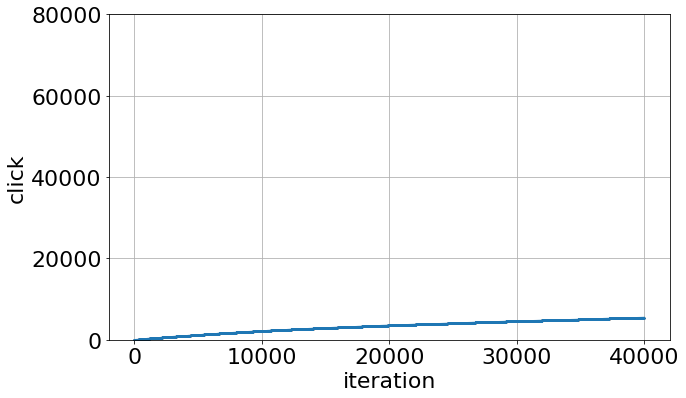

In [ ]:
itr_cumulated_click_count_mean = np.load('/content/itr_cumulated_click_count_mean_D_airbnb.npy')
itr_cumulated_click_count_std = np.load('/content/itr_cumulated_click_count_std_D_airbnb.npy')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax.plot(range(len(itr_cumulated_click_count_mean)), itr_cumulated_click_count_mean, marker='.', linewidth=1.5, markersize=1)
ax.fill_between(range(len(itr_cumulated_click_count_std)), itr_cumulated_click_count_mean-itr_cumulated_click_count_std, 
                itr_cumulated_click_count_mean+itr_cumulated_click_count_std, alpha=0.5)
ax.set_ylabel('click')
ax.set_xlabel('iteration')
ax.set_ylim(0., 80000)
ax.grid(True)
fig.patch.set_facecolor('white')
# plt.legend(loc='best')
plt.tight_layout()
plt.show()

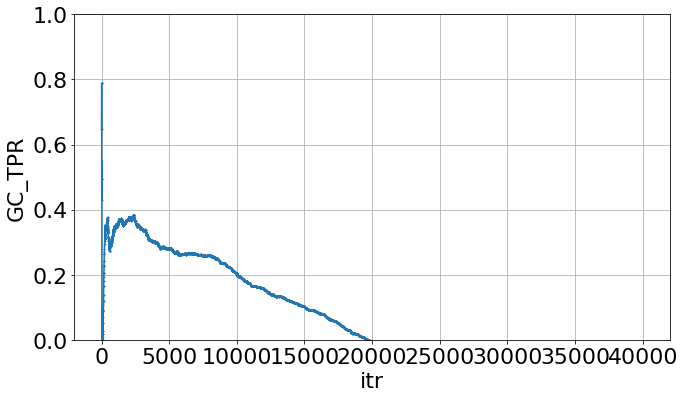

In [ ]:
itr_GC_TPR_mean = np.load('/content/itr_GC_TPR_mean_D_airbnb.npy')
itr_GC_TPR_std = np.load('./itr_GC_TPR_std_D_airbnb.npy')
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax.plot(range(len(itr_GC_TPR_mean)), itr_GC_TPR_mean, marker='.', linewidth=1.5, markersize=1)
ax.fill_between(range(len(itr_GC_TPR_mean)), itr_GC_TPR_mean-itr_GC_TPR_std, itr_GC_TPR_mean+itr_GC_TPR_std, alpha=0.5)
ax.set_ylabel('GC_TPR')
ax.set_xlabel('itr')
ax.set_ylim(0., 1)
ax.grid(True)
fig.patch.set_facecolor('white')
# plt.legend(loc='best')
plt.tight_layout()
plt.show()

#**Experiment_scale**

**Upload Simulation_Scale.py and MF_CE.py and add parse.add_(alpha...)**

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings; warnings.simplefilter('ignore')  # Ignores Warnings for nicer Plots. Disable for Debugging
import time
import numpy as np
import argparse
import utility
from Simulation_Scale import Simulation

parser = argparse.ArgumentParser(description='Experiment_Scale')
parser.add_argument('--run', type=int, default=10, help='number of experiments to run')
parser.add_argument('--iteration', type=int, default=40000, help='number of iterations to simulate')
parser.add_argument('--exp', type=int, default=1, help='number of initial random exposure iterations')
parser.add_argument('--cycle_itr', type=int, default=50, help='number of iterations in one cycle')
parser.add_argument('--epoch', type=int, default=15, help='number of epochs to train')
parser.add_argument('--K', type=int, default=20, help='number of items to recommend')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate')
parser.add_argument('--reg', type=float, default=1e-5, help='regularization')
parser.add_argument('--hidden', type=int, default=100, help='latent dimension')
parser.add_argument('--neg', type=int, default=5, help='negative sampling rate')
parser.add_argument('--data', type=str, default='ml1m', help='path to eval in the Data folder')
parser.add_argument('--alpha', type=float, default=0.1, help='alpha')
parser.add_argument('--num_user', type=float, default=num_user, help='path to eval in the Data folder')
parser.add_argument('--num_item', type=float, default=num_item, help='path to eval in the Data folder')
parser.add_argument('-f')

args = parser.parse_args()

truth = np.load('/content/truth_airbnb.npy')
args.num_user = truth.shape[0]
args.num_item = truth.shape[1]
audience_size = np.sum(truth, axis=0)
item_sorted = np.argsort(audience_size)
truth_like = list(np.load('/content/user_truth_like_airbnb.npy', allow_pickle=True))

print('')
print('!' * 30 + ' Total truth ' + str(np.sum(truth)) + ' ' + '!' * 30)
print('')

itr_cumulated_click_count_list = []
itr_GC_TPR_list = []

for r in range(args.run):
    print('')
    print('#' * 100)
    print('#' * 100)
    print(' ' * 50 + ' Experiment run ' + str(r + 1) + ' ' * 50)
    print('#' * 100)
    print('#' * 100)
    simulation = Simulation(args, truth, truth_like)
    init_popularity = simulation.initial_iterations()
    itr_click_item = simulation.run_simulation()

    itr_cumulated_click_count = []
    itr_item_click = np.zeros((args.iteration, args.num_item))
    for itr in range(args.iteration):
        click_item = itr_click_item[itr]
        itr_item_click[itr, click_item] = 1.
        itr_cumulated_click_count.append(
            len(click_item) if itr == 0 else len(click_item) + itr_cumulated_click_count[-1])
    for itr in range(1, args.iteration):
        itr_item_click[itr, :] += itr_item_click[itr - 1, :]
    itr_item_click /= (audience_size - init_popularity).reshape((1, -1))

    itr_GC_TPR = []
    for itr in range(args.iteration):
        a = itr_item_click[itr, item_sorted]
        gc = np.sum(((np.arange(len(a)) + 1.) * 2 - len(a) - 1) * a) / (len(a) * np.sum(a))
        itr_GC_TPR.append(gc)

    itr_cumulated_click_count_list.append(itr_cumulated_click_count)
    itr_GC_TPR_list.append(itr_GC_TPR)

    itr_cumulated_click_count_mean = np.mean(itr_cumulated_click_count_list, axis=0)
    itr_cumulated_click_count_std = np.std(itr_cumulated_click_count_list, axis=0)
    itr_GC_TPR_mean = np.mean(itr_GC_TPR_list, axis=0)
    itr_GC_TPR_std = np.std(itr_GC_TPR_list, axis=0)


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Total truth 31951.0 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


####################################################################################################
####################################################################################################
                                                   Experiment run 1                                                  
####################################################################################################
####################################################################################################
Namespace(K=20, alpha=0.1, cycle_itr=50, data='ml1m', epoch=15, exp=1, f='/root/.local/share/jupyter/runtime/kernel-fc381ba0-44ee-4a67-bf4c-ab92f3747d83.json', hidden=100, iteration=40000, lr=0.001, neg=5, num_item=1162, num_user=1000, reg=1e-05, run=10)
****************************** Start initial random iterations ******************************
---------- Iteration 1 ----------


100%|██████████| 1000/1000 [00:00<00:00, 4048.29it/s]


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Generate 209 records.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
****************************** Train MF until converge ******************************
Update bs to 25
******************************MF initialization done ******************************


100%|██████████| 50/50 [00:00<00:00, 151.20it/s]


Training // Epoch 0 //  Total cost = 34.6589  Total cost1 = 34.6390  Total cost2 = 0.0199


100%|██████████| 50/50 [00:00<00:00, 218.88it/s]


Training // Epoch 1 //  Total cost = 34.3637  Total cost1 = 34.3499  Total cost2 = 0.0139


100%|██████████| 50/50 [00:00<00:00, 210.26it/s]


Training // Epoch 2 //  Total cost = 33.9270  Total cost1 = 33.9098  Total cost2 = 0.0172


100%|██████████| 50/50 [00:00<00:00, 205.59it/s]


Training // Epoch 3 //  Total cost = 33.1809  Total cost1 = 33.1579  Total cost2 = 0.0231


100%|██████████| 50/50 [00:00<00:00, 218.17it/s]


Training // Epoch 4 //  Total cost = 32.0454  Total cost1 = 32.0140  Total cost2 = 0.0314


100%|██████████| 50/50 [00:00<00:00, 224.78it/s]


Training // Epoch 5 //  Total cost = 30.4937  Total cost1 = 30.4514  Total cost2 = 0.0423


100%|██████████| 50/50 [00:00<00:00, 221.46it/s]


Training // Epoch 6 //  Total cost = 28.3713  Total cost1 = 28.3149  Total cost2 = 0.0564


100%|██████████| 50/50 [00:00<00:00, 202.06it/s]


Training // Epoch 7 //  Total cost = 25.7173  Total cost1 = 25.6438  Total cost2 = 0.0734


100%|██████████| 50/50 [00:00<00:00, 217.49it/s]


Training // Epoch 8 //  Total cost = 22.6444  Total cost1 = 22.5512  Total cost2 = 0.0933


100%|██████████| 50/50 [00:00<00:00, 219.04it/s]


Training // Epoch 9 //  Total cost = 18.9488  Total cost1 = 18.8329  Total cost2 = 0.1159


100%|██████████| 50/50 [00:00<00:00, 207.13it/s]


Training // Epoch 10 //  Total cost = 15.0804  Total cost1 = 14.9392  Total cost2 = 0.1412


100%|██████████| 50/50 [00:00<00:00, 203.51it/s]


Training // Epoch 11 //  Total cost = 10.5970  Total cost1 = 10.4276  Total cost2 = 0.1694


100%|██████████| 50/50 [00:00<00:00, 226.56it/s]


Training // Epoch 12 //  Total cost = 5.5746  Total cost1 = 5.3753  Total cost2 = 0.1993


100%|██████████| 50/50 [00:00<00:00, 216.64it/s]


Training // Epoch 13 //  Total cost = 0.5732  Total cost1 = 0.3407  Total cost2 = 0.2325


100%|██████████| 50/50 [00:00<00:00, 215.99it/s]


Training // Epoch 14 //  Total cost = -4.8284  Total cost1 = -5.0961  Total cost2 = 0.2677
****************************** Start simulation ******************************


100%|██████████| 50/50 [00:00<00:00, 1421.94it/s]


########## The iteration 50, up to now total 223 clicks, GC=-0.2638, this cycle used 0.05 s) ##########
Update bs to 26


100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


100%|██████████| 50/50 [00:00<00:00, 1535.98it/s]


########## The iteration 100, up to now total 232 clicks, GC=-0.2073, this cycle used 3.52 s) ##########
Update bs to 27


100%|██████████| 15/15 [00:03<00:00,  4.44it/s]


100%|██████████| 50/50 [00:00<00:00, 1573.89it/s]


########## The iteration 150, up to now total 241 clicks, GC=-0.1143, this cycle used 3.48 s) ##########
Update bs to 28


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 1463.26it/s]


########## The iteration 200, up to now total 253 clicks, GC=-0.0976, this cycle used 4.14 s) ##########
Update bs to 30


100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


100%|██████████| 50/50 [00:00<00:00, 1366.80it/s]


########## The iteration 250, up to now total 259 clicks, GC=-0.1017, this cycle used 3.54 s) ##########
Update bs to 31


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


100%|██████████| 50/50 [00:00<00:00, 861.74it/s]


########## The iteration 300, up to now total 270 clicks, GC=-0.0803, this cycle used 4.48 s) ##########
Update bs to 32


100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


100%|██████████| 50/50 [00:00<00:00, 737.47it/s]


########## The iteration 350, up to now total 277 clicks, GC=-0.0686, this cycle used 7.24 s) ##########
Update bs to 33


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


100%|██████████| 50/50 [00:00<00:00, 620.42it/s]


########## The iteration 400, up to now total 285 clicks, GC=-0.1158, this cycle used 5.87 s) ##########
Update bs to 34


100%|██████████| 15/15 [00:04<00:00,  3.31it/s]


100%|██████████| 50/50 [00:00<00:00, 1424.09it/s]


########## The iteration 450, up to now total 290 clicks, GC=-0.1007, this cycle used 4.70 s) ##########
Update bs to 34


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 370.67it/s]


########## The iteration 500, up to now total 301 clicks, GC=-0.1034, this cycle used 3.64 s) ##########
Update bs to 36


100%|██████████| 15/15 [00:04<00:00,  3.32it/s]


100%|██████████| 50/50 [00:00<00:00, 1276.73it/s]


########## The iteration 550, up to now total 311 clicks, GC=-0.1221, this cycle used 4.70 s) ##########
Update bs to 37


100%|██████████| 15/15 [00:04<00:00,  3.29it/s]


100%|██████████| 50/50 [00:00<00:00, 549.32it/s]


########## The iteration 600, up to now total 321 clicks, GC=-0.0964, this cycle used 4.76 s) ##########
Update bs to 38


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 1291.03it/s]


########## The iteration 650, up to now total 334 clicks, GC=-0.0703, this cycle used 3.73 s) ##########
Update bs to 40


100%|██████████| 15/15 [00:06<00:00,  2.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1452.02it/s]


########## The iteration 700, up to now total 338 clicks, GC=-0.0782, this cycle used 6.49 s) ##########
Update bs to 40


100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


100%|██████████| 50/50 [00:00<00:00, 1298.84it/s]


########## The iteration 750, up to now total 346 clicks, GC=-0.0588, this cycle used 3.55 s) ##########
Update bs to 41


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1264.88it/s]


########## The iteration 800, up to now total 355 clicks, GC=-0.0607, this cycle used 3.43 s) ##########
Update bs to 42


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


100%|██████████| 50/50 [00:00<00:00, 1132.18it/s]


########## The iteration 850, up to now total 372 clicks, GC=-0.0956, this cycle used 3.43 s) ##########
Update bs to 44


100%|██████████| 15/15 [00:05<00:00,  2.72it/s]


100%|██████████| 50/50 [00:00<00:00, 778.02it/s]


########## The iteration 900, up to now total 383 clicks, GC=-0.1155, this cycle used 5.68 s) ##########
Update bs to 45


100%|██████████| 15/15 [00:04<00:00,  3.15it/s]


100%|██████████| 50/50 [00:00<00:00, 694.96it/s]


########## The iteration 950, up to now total 391 clicks, GC=-0.1152, this cycle used 4.98 s) ##########
Update bs to 46


100%|██████████| 15/15 [00:04<00:00,  3.22it/s]


100%|██████████| 50/50 [00:00<00:00, 1163.42it/s]


########## The iteration 1000, up to now total 405 clicks, GC=-0.1412, this cycle used 4.78 s) ##########
Update bs to 48


100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


100%|██████████| 50/50 [00:00<00:00, 1190.16it/s]


########## The iteration 1050, up to now total 416 clicks, GC=-0.1250, this cycle used 3.47 s) ##########
Update bs to 49


100%|██████████| 15/15 [00:03<00:00,  4.47it/s]


100%|██████████| 50/50 [00:00<00:00, 1494.97it/s]


########## The iteration 1100, up to now total 425 clicks, GC=-0.1135, this cycle used 3.49 s) ##########
Update bs to 51


100%|██████████| 15/15 [00:03<00:00,  4.66it/s]


100%|██████████| 50/50 [00:00<00:00, 1356.24it/s]


########## The iteration 1150, up to now total 434 clicks, GC=-0.1081, this cycle used 3.35 s) ##########
Update bs to 52


100%|██████████| 15/15 [00:03<00:00,  4.71it/s]


100%|██████████| 50/50 [00:00<00:00, 914.58it/s]


########## The iteration 1200, up to now total 439 clicks, GC=-0.0998, this cycle used 3.33 s) ##########
Update bs to 52


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1434.40it/s]


########## The iteration 1250, up to now total 450 clicks, GC=-0.1036, this cycle used 3.45 s) ##########
Update bs to 54


100%|██████████| 15/15 [00:03<00:00,  4.66it/s]


100%|██████████| 50/50 [00:00<00:00, 1649.22it/s]


########## The iteration 1300, up to now total 459 clicks, GC=-0.0947, this cycle used 3.35 s) ##########
Update bs to 55


100%|██████████| 15/15 [00:03<00:00,  4.66it/s]


100%|██████████| 50/50 [00:00<00:00, 1443.40it/s]


########## The iteration 1350, up to now total 468 clicks, GC=-0.0902, this cycle used 3.36 s) ##########
Update bs to 56


100%|██████████| 15/15 [00:04<00:00,  3.28it/s]


100%|██████████| 50/50 [00:00<00:00, 1393.83it/s]


########## The iteration 1400, up to now total 474 clicks, GC=-0.0818, this cycle used 4.71 s) ##########
Update bs to 56


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


100%|██████████| 50/50 [00:00<00:00, 1495.06it/s]


########## The iteration 1450, up to now total 480 clicks, GC=-0.0850, this cycle used 3.41 s) ##########
Update bs to 57


100%|██████████| 15/15 [00:03<00:00,  4.48it/s]


100%|██████████| 50/50 [00:00<00:00, 1169.09it/s]


########## The iteration 1500, up to now total 492 clicks, GC=-0.0897, this cycle used 3.48 s) ##########
Update bs to 59


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 1368.59it/s]


########## The iteration 1550, up to now total 503 clicks, GC=-0.0846, this cycle used 3.42 s) ##########
Update bs to 60


100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


100%|██████████| 50/50 [00:00<00:00, 1785.59it/s]


########## The iteration 1600, up to now total 510 clicks, GC=-0.0926, this cycle used 3.35 s) ##########
Update bs to 61


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


100%|██████████| 50/50 [00:00<00:00, 1274.64it/s]


########## The iteration 1650, up to now total 517 clicks, GC=-0.0913, this cycle used 4.05 s) ##########
Update bs to 62


100%|██████████| 15/15 [00:03<00:00,  4.57it/s]


100%|██████████| 50/50 [00:00<00:00, 1446.32it/s]


########## The iteration 1700, up to now total 522 clicks, GC=-0.0925, this cycle used 3.42 s) ##########
Update bs to 62


100%|██████████| 15/15 [00:03<00:00,  4.48it/s]


100%|██████████| 50/50 [00:00<00:00, 1131.54it/s]


########## The iteration 1750, up to now total 529 clicks, GC=-0.0947, this cycle used 3.49 s) ##########
Update bs to 63


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1167.77it/s]


########## The iteration 1800, up to now total 542 clicks, GC=-0.0938, this cycle used 3.44 s) ##########
Update bs to 65


100%|██████████| 15/15 [00:03<00:00,  4.57it/s]


100%|██████████| 50/50 [00:00<00:00, 1255.31it/s]


########## The iteration 1850, up to now total 551 clicks, GC=-0.0885, this cycle used 3.44 s) ##########
Update bs to 66


100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1161.23it/s]


########## The iteration 1900, up to now total 557 clicks, GC=-0.0863, this cycle used 3.39 s) ##########
Update bs to 66


100%|██████████| 15/15 [00:03<00:00,  4.46it/s]


100%|██████████| 50/50 [00:00<00:00, 992.15it/s]


########## The iteration 1950, up to now total 564 clicks, GC=-0.0845, this cycle used 3.52 s) ##########
Update bs to 67


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 1373.79it/s]


########## The iteration 2000, up to now total 573 clicks, GC=-0.0893, this cycle used 3.47 s) ##########
Update bs to 68


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 1457.77it/s]


########## The iteration 2050, up to now total 583 clicks, GC=-0.0834, this cycle used 4.26 s) ##########
Update bs to 69


100%|██████████| 15/15 [00:03<00:00,  4.51it/s]


100%|██████████| 50/50 [00:00<00:00, 1073.78it/s]


########## The iteration 2100, up to now total 592 clicks, GC=-0.0753, this cycle used 3.48 s) ##########
Update bs to 71


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 1106.78it/s]


########## The iteration 2150, up to now total 600 clicks, GC=-0.0775, this cycle used 3.44 s) ##########
Update bs to 72


100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


100%|██████████| 50/50 [00:00<00:00, 1421.63it/s]


########## The iteration 2200, up to now total 614 clicks, GC=-0.0742, this cycle used 3.40 s) ##########
Update bs to 73


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 1107.31it/s]


########## The iteration 2250, up to now total 622 clicks, GC=-0.0685, this cycle used 3.43 s) ##########
Update bs to 74


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1238.97it/s]


########## The iteration 2300, up to now total 630 clicks, GC=-0.0650, this cycle used 3.41 s) ##########
Update bs to 75


100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


100%|██████████| 50/50 [00:00<00:00, 1439.66it/s]


########## The iteration 2350, up to now total 637 clicks, GC=-0.0641, this cycle used 3.40 s) ##########
Update bs to 76


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1296.01it/s]


########## The iteration 2400, up to now total 642 clicks, GC=-0.0663, this cycle used 3.40 s) ##########
Update bs to 77


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1238.39it/s]


########## The iteration 2450, up to now total 655 clicks, GC=-0.0695, this cycle used 3.43 s) ##########
Update bs to 78


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1427.96it/s]


########## The iteration 2500, up to now total 663 clicks, GC=-0.0682, this cycle used 3.41 s) ##########
Update bs to 79


100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


100%|██████████| 50/50 [00:00<00:00, 1186.65it/s]


########## The iteration 2550, up to now total 674 clicks, GC=-0.0696, this cycle used 3.42 s) ##########
Update bs to 80


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 1231.36it/s]


########## The iteration 2600, up to now total 681 clicks, GC=-0.0715, this cycle used 3.48 s) ##########
Update bs to 81


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 911.94it/s]


########## The iteration 2650, up to now total 688 clicks, GC=-0.0719, this cycle used 3.44 s) ##########
Update bs to 82


100%|██████████| 15/15 [00:03<00:00,  4.57it/s]


100%|██████████| 50/50 [00:00<00:00, 1079.89it/s]


########## The iteration 2700, up to now total 702 clicks, GC=-0.0659, this cycle used 3.45 s) ##########
Update bs to 84


100%|██████████| 15/15 [00:03<00:00,  4.67it/s]


100%|██████████| 50/50 [00:00<00:00, 997.62it/s]


########## The iteration 2750, up to now total 711 clicks, GC=-0.0637, this cycle used 3.40 s) ##########
Update bs to 85


100%|██████████| 15/15 [00:03<00:00,  4.66it/s]


100%|██████████| 50/50 [00:00<00:00, 996.79it/s]


########## The iteration 2800, up to now total 723 clicks, GC=-0.0576, this cycle used 3.41 s) ##########
Update bs to 86


100%|██████████| 15/15 [00:03<00:00,  4.66it/s]


100%|██████████| 50/50 [00:00<00:00, 1128.90it/s]


########## The iteration 2850, up to now total 731 clicks, GC=-0.0549, this cycle used 3.39 s) ##########
Update bs to 87


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1540.37it/s]


########## The iteration 2900, up to now total 743 clicks, GC=-0.0527, this cycle used 3.42 s) ##########
Update bs to 89


100%|██████████| 15/15 [00:03<00:00,  4.70it/s]


100%|██████████| 50/50 [00:00<00:00, 1024.21it/s]


########## The iteration 2950, up to now total 750 clicks, GC=-0.0489, this cycle used 3.37 s) ##########
Update bs to 90


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 943.41it/s]


########## The iteration 3000, up to now total 756 clicks, GC=-0.0493, this cycle used 3.46 s) ##########
Update bs to 90


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1357.89it/s]


########## The iteration 3050, up to now total 763 clicks, GC=-0.0520, this cycle used 3.42 s) ##########
Update bs to 91


100%|██████████| 15/15 [00:03<00:00,  4.66it/s]


100%|██████████| 50/50 [00:00<00:00, 1377.41it/s]


########## The iteration 3100, up to now total 769 clicks, GC=-0.0527, this cycle used 3.39 s) ##########
Update bs to 92


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 1611.41it/s]


########## The iteration 3150, up to now total 776 clicks, GC=-0.0542, this cycle used 4.11 s) ##########
Update bs to 93


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


100%|██████████| 50/50 [00:00<00:00, 1327.20it/s]


########## The iteration 3200, up to now total 788 clicks, GC=-0.0544, this cycle used 3.46 s) ##########
Update bs to 94


100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


100%|██████████| 50/50 [00:00<00:00, 1220.16it/s]


########## The iteration 3250, up to now total 794 clicks, GC=-0.0545, this cycle used 3.44 s) ##########
Update bs to 95


100%|██████████| 15/15 [00:03<00:00,  4.69it/s]


100%|██████████| 50/50 [00:00<00:00, 1487.90it/s]


########## The iteration 3300, up to now total 800 clicks, GC=-0.0594, this cycle used 3.39 s) ##########
Update bs to 96


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1196.15it/s]


########## The iteration 3350, up to now total 811 clicks, GC=-0.0620, this cycle used 3.43 s) ##########
Update bs to 97


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


100%|██████████| 50/50 [00:00<00:00, 1171.47it/s]


########## The iteration 3400, up to now total 820 clicks, GC=-0.0635, this cycle used 3.45 s) ##########
Update bs to 98


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


100%|██████████| 50/50 [00:00<00:00, 1154.91it/s]


########## The iteration 3450, up to now total 831 clicks, GC=-0.0627, this cycle used 3.45 s) ##########
Update bs to 99


100%|██████████| 15/15 [00:03<00:00,  4.66it/s]


100%|██████████| 50/50 [00:00<00:00, 1253.04it/s]


########## The iteration 3500, up to now total 842 clicks, GC=-0.0645, this cycle used 3.41 s) ##########
Update bs to 101


100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


100%|██████████| 50/50 [00:00<00:00, 1204.10it/s]


########## The iteration 3550, up to now total 849 clicks, GC=-0.0645, this cycle used 3.44 s) ##########
Update bs to 101


100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


100%|██████████| 50/50 [00:00<00:00, 1243.61it/s]


########## The iteration 3600, up to now total 857 clicks, GC=-0.0669, this cycle used 3.43 s) ##########
Update bs to 102


100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


100%|██████████| 50/50 [00:00<00:00, 1213.12it/s]


########## The iteration 3650, up to now total 863 clicks, GC=-0.0719, this cycle used 3.44 s) ##########
Update bs to 103


100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


100%|██████████| 50/50 [00:00<00:00, 1142.49it/s]


########## The iteration 3700, up to now total 869 clicks, GC=-0.0787, this cycle used 3.43 s) ##########
Update bs to 104


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 923.16it/s]


########## The iteration 3750, up to now total 877 clicks, GC=-0.0857, this cycle used 3.46 s) ##########
Update bs to 105


100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


100%|██████████| 50/50 [00:00<00:00, 1399.97it/s]


########## The iteration 3800, up to now total 886 clicks, GC=-0.0834, this cycle used 3.44 s) ##########
Update bs to 106


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1012.67it/s]


########## The iteration 3850, up to now total 892 clicks, GC=-0.0892, this cycle used 3.50 s) ##########
Update bs to 107


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1127.42it/s]


########## The iteration 3900, up to now total 902 clicks, GC=-0.0898, this cycle used 3.52 s) ##########
Update bs to 108


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 1281.33it/s]


########## The iteration 3950, up to now total 913 clicks, GC=-0.0864, this cycle used 3.46 s) ##########
Update bs to 109


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1316.07it/s]


########## The iteration 4000, up to now total 921 clicks, GC=-0.0900, this cycle used 3.44 s) ##########
Update bs to 110


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


100%|██████████| 50/50 [00:00<00:00, 1338.12it/s]


########## The iteration 4050, up to now total 931 clicks, GC=-0.0889, this cycle used 3.46 s) ##########
Update bs to 111


100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1132.25it/s]


########## The iteration 4100, up to now total 940 clicks, GC=-0.0877, this cycle used 3.44 s) ##########
Update bs to 112


100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1072.59it/s]


########## The iteration 4150, up to now total 948 clicks, GC=-0.0880, this cycle used 3.43 s) ##########
Update bs to 113


100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


100%|██████████| 50/50 [00:00<00:00, 1118.12it/s]


########## The iteration 4200, up to now total 960 clicks, GC=-0.0836, this cycle used 3.45 s) ##########
Update bs to 115


100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


100%|██████████| 50/50 [00:00<00:00, 1257.19it/s]


########## The iteration 4250, up to now total 967 clicks, GC=-0.0852, this cycle used 3.45 s) ##########
Update bs to 116


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 1082.73it/s]


########## The iteration 4300, up to now total 976 clicks, GC=-0.0888, this cycle used 3.49 s) ##########
Update bs to 117


100%|██████████| 15/15 [00:03<00:00,  4.66it/s]


100%|██████████| 50/50 [00:00<00:00, 1120.83it/s]


########## The iteration 4350, up to now total 984 clicks, GC=-0.0902, this cycle used 3.41 s) ##########
Update bs to 118


100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


100%|██████████| 50/50 [00:00<00:00, 1211.25it/s]


########## The iteration 4400, up to now total 989 clicks, GC=-0.0914, this cycle used 3.46 s) ##########
Update bs to 118


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 1128.85it/s]


########## The iteration 4450, up to now total 995 clicks, GC=-0.0900, this cycle used 3.53 s) ##########
Update bs to 119


100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1468.97it/s]


########## The iteration 4500, up to now total 1002 clicks, GC=-0.0904, this cycle used 3.44 s) ##########
Update bs to 120


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


100%|██████████| 50/50 [00:00<00:00, 1162.57it/s]


########## The iteration 4550, up to now total 1009 clicks, GC=-0.0897, this cycle used 3.48 s) ##########
Update bs to 121


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1271.98it/s]


########## The iteration 4600, up to now total 1014 clicks, GC=-0.0878, this cycle used 3.46 s) ##########
Update bs to 121


100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1516.91it/s]


########## The iteration 4650, up to now total 1018 clicks, GC=-0.0874, this cycle used 3.44 s) ##########
Update bs to 122


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1221.06it/s]


########## The iteration 4700, up to now total 1025 clicks, GC=-0.0853, this cycle used 3.47 s) ##########
Update bs to 123


100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


100%|██████████| 50/50 [00:00<00:00, 1209.15it/s]


########## The iteration 4750, up to now total 1037 clicks, GC=-0.0869, this cycle used 3.46 s) ##########
Update bs to 124


100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


100%|██████████| 50/50 [00:00<00:00, 886.02it/s]


########## The iteration 4800, up to now total 1044 clicks, GC=-0.0875, this cycle used 3.47 s) ##########
Update bs to 125


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


100%|██████████| 50/50 [00:00<00:00, 1087.15it/s]


########## The iteration 4850, up to now total 1052 clicks, GC=-0.0895, this cycle used 3.47 s) ##########
Update bs to 126


100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


100%|██████████| 50/50 [00:00<00:00, 1339.24it/s]


########## The iteration 4900, up to now total 1060 clicks, GC=-0.0910, this cycle used 3.45 s) ##########
Update bs to 127


100%|██████████| 15/15 [00:03<00:00,  4.57it/s]


100%|██████████| 50/50 [00:00<00:00, 1232.64it/s]


########## The iteration 4950, up to now total 1069 clicks, GC=-0.0927, this cycle used 3.48 s) ##########
Update bs to 128


100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1213.81it/s]


########## The iteration 5000, up to now total 1077 clicks, GC=-0.0904, this cycle used 3.44 s) ##########
Update bs to 129


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


100%|██████████| 50/50 [00:00<00:00, 1272.88it/s]


########## The iteration 5050, up to now total 1086 clicks, GC=-0.0886, this cycle used 3.47 s) ##########
Update bs to 130


100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


100%|██████████| 50/50 [00:00<00:00, 1089.97it/s]


########## The iteration 5100, up to now total 1097 clicks, GC=-0.0859, this cycle used 3.46 s) ##########
Update bs to 131


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 1349.34it/s]


########## The iteration 5150, up to now total 1103 clicks, GC=-0.0843, this cycle used 3.52 s) ##########
Update bs to 132


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


100%|██████████| 50/50 [00:00<00:00, 1022.63it/s]


########## The iteration 5200, up to now total 1111 clicks, GC=-0.0827, this cycle used 3.48 s) ##########
Update bs to 133


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 1041.71it/s]


########## The iteration 5250, up to now total 1114 clicks, GC=-0.0819, this cycle used 3.51 s) ##########
Update bs to 133


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 930.78it/s]


########## The iteration 5300, up to now total 1119 clicks, GC=-0.0804, this cycle used 3.51 s) ##########
Update bs to 134


100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


100%|██████████| 50/50 [00:00<00:00, 1043.61it/s]


########## The iteration 5350, up to now total 1130 clicks, GC=-0.0820, this cycle used 3.45 s) ##########
Update bs to 135


100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1052.39it/s]


########## The iteration 5400, up to now total 1136 clicks, GC=-0.0804, this cycle used 3.47 s) ##########
Update bs to 136


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1288.44it/s]


########## The iteration 5450, up to now total 1141 clicks, GC=-0.0812, this cycle used 3.54 s) ##########
Update bs to 136


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1074.81it/s]


########## The iteration 5500, up to now total 1145 clicks, GC=-0.0828, this cycle used 3.54 s) ##########
Update bs to 137


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


100%|██████████| 50/50 [00:00<00:00, 1063.23it/s]


########## The iteration 5550, up to now total 1152 clicks, GC=-0.0837, this cycle used 3.53 s) ##########
Update bs to 138


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 971.98it/s]


########## The iteration 5600, up to now total 1156 clicks, GC=-0.0863, this cycle used 3.49 s) ##########
Update bs to 138


100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


100%|██████████| 50/50 [00:00<00:00, 1197.64it/s]


########## The iteration 5650, up to now total 1163 clicks, GC=-0.0864, this cycle used 3.45 s) ##########
Update bs to 139


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1024.87it/s]


########## The iteration 5700, up to now total 1170 clicks, GC=-0.0877, this cycle used 3.49 s) ##########
Update bs to 140


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1500.97it/s]


########## The iteration 5750, up to now total 1181 clicks, GC=-0.0876, this cycle used 3.53 s) ##########
Update bs to 141


100%|██████████| 15/15 [00:03<00:00,  4.57it/s]


100%|██████████| 50/50 [00:00<00:00, 1119.97it/s]


########## The iteration 5800, up to now total 1188 clicks, GC=-0.0927, this cycle used 3.52 s) ##########
Update bs to 142


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 991.17it/s]


########## The iteration 5850, up to now total 1195 clicks, GC=-0.0932, this cycle used 3.52 s) ##########
Update bs to 143


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1141.66it/s]


########## The iteration 5900, up to now total 1203 clicks, GC=-0.0923, this cycle used 3.54 s) ##########
Update bs to 144


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 1192.78it/s]


########## The iteration 5950, up to now total 1207 clicks, GC=-0.0910, this cycle used 3.53 s) ##########
Update bs to 144


100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


100%|██████████| 50/50 [00:00<00:00, 839.44it/s]


########## The iteration 6000, up to now total 1215 clicks, GC=-0.0920, this cycle used 3.49 s) ##########
Update bs to 145


100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


100%|██████████| 50/50 [00:00<00:00, 1253.06it/s]


########## The iteration 6050, up to now total 1225 clicks, GC=-0.0943, this cycle used 3.49 s) ##########
Update bs to 147


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 843.93it/s]


########## The iteration 6100, up to now total 1236 clicks, GC=-0.0948, this cycle used 3.54 s) ##########
Update bs to 148


100%|██████████| 15/15 [00:03<00:00,  4.51it/s]


100%|██████████| 50/50 [00:00<00:00, 1035.56it/s]


########## The iteration 6150, up to now total 1244 clicks, GC=-0.0940, this cycle used 3.55 s) ##########
Update bs to 149


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1004.39it/s]


########## The iteration 6200, up to now total 1250 clicks, GC=-0.0927, this cycle used 3.52 s) ##########
Update bs to 150


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 1311.71it/s]


########## The iteration 6250, up to now total 1259 clicks, GC=-0.0931, this cycle used 3.55 s) ##########
Update bs to 151


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 1248.95it/s]


########## The iteration 6300, up to now total 1262 clicks, GC=-0.0922, this cycle used 3.50 s) ##########
Update bs to 151


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 1200.75it/s]


########## The iteration 6350, up to now total 1268 clicks, GC=-0.0944, this cycle used 3.54 s) ##########
Update bs to 152


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


100%|██████████| 50/50 [00:00<00:00, 908.41it/s]


########## The iteration 6400, up to now total 1273 clicks, GC=-0.0949, this cycle used 3.51 s) ##########
Update bs to 152


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1054.17it/s]


########## The iteration 6450, up to now total 1279 clicks, GC=-0.0950, this cycle used 3.53 s) ##########
Update bs to 153


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


100%|██████████| 50/50 [00:00<00:00, 66.70it/s]


########## The iteration 6500, up to now total 1285 clicks, GC=-0.0953, this cycle used 4.20 s) ##########
Update bs to 154


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 991.14it/s]


########## The iteration 6550, up to now total 1289 clicks, GC=-0.0976, this cycle used 3.53 s) ##########
Update bs to 154


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 726.61it/s]


########## The iteration 6600, up to now total 1297 clicks, GC=-0.0970, this cycle used 3.57 s) ##########
Update bs to 155


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1288.22it/s]


########## The iteration 6650, up to now total 1302 clicks, GC=-0.0953, this cycle used 3.55 s) ##########
Update bs to 156


100%|██████████| 15/15 [00:03<00:00,  4.57it/s]


100%|██████████| 50/50 [00:00<00:00, 1063.60it/s]


########## The iteration 6700, up to now total 1308 clicks, GC=-0.0971, this cycle used 3.52 s) ##########
Update bs to 156


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1328.34it/s]


########## The iteration 6750, up to now total 1315 clicks, GC=-0.0983, this cycle used 3.49 s) ##########
Update bs to 157


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 1356.55it/s]


########## The iteration 6800, up to now total 1326 clicks, GC=-0.0956, this cycle used 3.52 s) ##########
Update bs to 159


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


100%|██████████| 50/50 [00:00<00:00, 977.55it/s]


########## The iteration 6850, up to now total 1331 clicks, GC=-0.0982, this cycle used 3.56 s) ##########
Update bs to 159


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


100%|██████████| 50/50 [00:00<00:00, 1110.49it/s]


########## The iteration 6900, up to now total 1338 clicks, GC=-0.0998, this cycle used 3.51 s) ##########
Update bs to 160


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 980.97it/s]


########## The iteration 6950, up to now total 1349 clicks, GC=-0.0989, this cycle used 3.54 s) ##########
Update bs to 161


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


100%|██████████| 50/50 [00:00<00:00, 998.45it/s]


########## The iteration 7000, up to now total 1364 clicks, GC=-0.0981, this cycle used 3.56 s) ##########
Update bs to 163


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 1084.45it/s]


########## The iteration 7050, up to now total 1370 clicks, GC=-0.0980, this cycle used 3.55 s) ##########
Update bs to 164


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 1130.11it/s]


########## The iteration 7100, up to now total 1374 clicks, GC=-0.0970, this cycle used 3.51 s) ##########
Update bs to 164


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 990.41it/s]


########## The iteration 7150, up to now total 1381 clicks, GC=-0.0960, this cycle used 3.54 s) ##########
Update bs to 165


100%|██████████| 15/15 [00:03<00:00,  4.57it/s]


100%|██████████| 50/50 [00:00<00:00, 899.39it/s]


########## The iteration 7200, up to now total 1388 clicks, GC=-0.0945, this cycle used 3.54 s) ##########
Update bs to 166


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


100%|██████████| 50/50 [00:00<00:00, 907.10it/s]


########## The iteration 7250, up to now total 1394 clicks, GC=-0.0935, this cycle used 3.52 s) ##########
Update bs to 167


100%|██████████| 15/15 [00:03<00:00,  4.51it/s]


100%|██████████| 50/50 [00:00<00:00, 1115.23it/s]


########## The iteration 7300, up to now total 1401 clicks, GC=-0.0925, this cycle used 3.58 s) ##########
Update bs to 168


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


100%|██████████| 50/50 [00:00<00:00, 1009.34it/s]


########## The iteration 7350, up to now total 1407 clicks, GC=-0.0924, this cycle used 3.56 s) ##########
Update bs to 168


100%|██████████| 15/15 [00:03<00:00,  4.51it/s]


100%|██████████| 50/50 [00:00<00:00, 1032.45it/s]


########## The iteration 7400, up to now total 1413 clicks, GC=-0.0948, this cycle used 3.59 s) ##########
Update bs to 169


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 856.18it/s]


########## The iteration 7450, up to now total 1422 clicks, GC=-0.0944, this cycle used 3.56 s) ##########
Update bs to 170


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


100%|██████████| 50/50 [00:00<00:00, 911.84it/s]


########## The iteration 7500, up to now total 1431 clicks, GC=-0.0953, this cycle used 3.59 s) ##########
Update bs to 171


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


100%|██████████| 50/50 [00:00<00:00, 1129.67it/s]


########## The iteration 7550, up to now total 1441 clicks, GC=-0.0991, this cycle used 3.56 s) ##########
Update bs to 172


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


100%|██████████| 50/50 [00:00<00:00, 1100.61it/s]


########## The iteration 7600, up to now total 1451 clicks, GC=-0.0987, this cycle used 3.56 s) ##########
Update bs to 174


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 822.65it/s]


########## The iteration 7650, up to now total 1458 clicks, GC=-0.1018, this cycle used 3.57 s) ##########
Update bs to 174


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 1027.11it/s]


########## The iteration 7700, up to now total 1465 clicks, GC=-0.1029, this cycle used 3.56 s) ##########
Update bs to 175


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 911.12it/s]


########## The iteration 7750, up to now total 1471 clicks, GC=-0.1019, this cycle used 3.58 s) ##########
Update bs to 176


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 891.48it/s]


########## The iteration 7800, up to now total 1477 clicks, GC=-0.1032, this cycle used 3.57 s) ##########
Update bs to 177


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 988.97it/s]


########## The iteration 7850, up to now total 1484 clicks, GC=-0.1056, this cycle used 3.70 s) ##########
Update bs to 178


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


100%|██████████| 50/50 [00:00<00:00, 1205.77it/s]


########## The iteration 7900, up to now total 1488 clicks, GC=-0.1055, this cycle used 3.58 s) ##########
Update bs to 178


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 910.59it/s]


########## The iteration 7950, up to now total 1491 clicks, GC=-0.1071, this cycle used 3.57 s) ##########
Update bs to 178


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1041.64it/s]


########## The iteration 8000, up to now total 1499 clicks, GC=-0.1131, this cycle used 3.60 s) ##########
Update bs to 179


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 955.19it/s]


########## The iteration 8050, up to now total 1504 clicks, GC=-0.1164, this cycle used 3.58 s) ##########
Update bs to 180


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 780.21it/s]


########## The iteration 8100, up to now total 1515 clicks, GC=-0.1160, this cycle used 3.57 s) ##########
Update bs to 181


100%|██████████| 15/15 [00:03<00:00,  4.51it/s]


100%|██████████| 50/50 [00:00<00:00, 1037.78it/s]


########## The iteration 8150, up to now total 1519 clicks, GC=-0.1158, this cycle used 3.58 s) ##########
Update bs to 182


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


100%|██████████| 50/50 [00:00<00:00, 914.09it/s]


########## The iteration 8200, up to now total 1528 clicks, GC=-0.1152, this cycle used 3.60 s) ##########
Update bs to 183


100%|██████████| 15/15 [00:03<00:00,  4.51it/s]


100%|██████████| 50/50 [00:00<00:00, 989.78it/s]


########## The iteration 8250, up to now total 1536 clicks, GC=-0.1175, this cycle used 3.59 s) ##########
Update bs to 184


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


100%|██████████| 50/50 [00:00<00:00, 1092.56it/s]


########## The iteration 8300, up to now total 1543 clicks, GC=-0.1179, this cycle used 3.60 s) ##########
Update bs to 185


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


100%|██████████| 50/50 [00:00<00:00, 1116.84it/s]


########## The iteration 8350, up to now total 1553 clicks, GC=-0.1200, this cycle used 3.60 s) ##########
Update bs to 186


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1270.95it/s]


########## The iteration 8400, up to now total 1558 clicks, GC=-0.1197, this cycle used 3.58 s) ##########
Update bs to 186


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1021.18it/s]


########## The iteration 8450, up to now total 1563 clicks, GC=-0.1206, this cycle used 3.58 s) ##########
Update bs to 187


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 783.83it/s]


########## The iteration 8500, up to now total 1569 clicks, GC=-0.1205, this cycle used 3.58 s) ##########
Update bs to 188


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 1107.78it/s]


########## The iteration 8550, up to now total 1578 clicks, GC=-0.1215, this cycle used 3.56 s) ##########
Update bs to 189


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


100%|██████████| 50/50 [00:00<00:00, 853.52it/s]


########## The iteration 8600, up to now total 1583 clicks, GC=-0.1211, this cycle used 3.56 s) ##########
Update bs to 189


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


100%|██████████| 50/50 [00:00<00:00, 863.74it/s]


########## The iteration 8650, up to now total 1594 clicks, GC=-0.1211, this cycle used 3.56 s) ##########
Update bs to 191


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 849.49it/s]


########## The iteration 8700, up to now total 1604 clicks, GC=-0.1217, this cycle used 3.56 s) ##########
Update bs to 192


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 905.82it/s]


########## The iteration 8750, up to now total 1612 clicks, GC=-0.1231, this cycle used 3.56 s) ##########
Update bs to 193


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 1004.28it/s]


########## The iteration 8800, up to now total 1617 clicks, GC=-0.1231, this cycle used 3.59 s) ##########
Update bs to 194


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 932.13it/s]


########## The iteration 8850, up to now total 1622 clicks, GC=-0.1225, this cycle used 3.54 s) ##########
Update bs to 194


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


100%|██████████| 50/50 [00:00<00:00, 970.99it/s]


########## The iteration 8900, up to now total 1630 clicks, GC=-0.1222, this cycle used 3.61 s) ##########
Update bs to 195


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1261.00it/s]


########## The iteration 8950, up to now total 1632 clicks, GC=-0.1217, this cycle used 3.58 s) ##########
Update bs to 195


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 930.13it/s]


########## The iteration 9000, up to now total 1638 clicks, GC=-0.1225, this cycle used 3.59 s) ##########
Update bs to 196


100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


100%|██████████| 50/50 [00:00<00:00, 981.70it/s]


########## The iteration 9050, up to now total 1643 clicks, GC=-0.1235, this cycle used 3.53 s) ##########
Update bs to 197


100%|██████████| 15/15 [00:03<00:00,  4.51it/s]


100%|██████████| 50/50 [00:00<00:00, 974.22it/s]


########## The iteration 9100, up to now total 1651 clicks, GC=-0.1226, this cycle used 3.61 s) ##########
Update bs to 198


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


100%|██████████| 50/50 [00:00<00:00, 986.53it/s]


########## The iteration 9150, up to now total 1657 clicks, GC=-0.1227, this cycle used 3.59 s) ##########
Update bs to 198


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


100%|██████████| 50/50 [00:00<00:00, 926.77it/s]


########## The iteration 9200, up to now total 1669 clicks, GC=-0.1261, this cycle used 3.55 s) ##########
Update bs to 200


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


100%|██████████| 50/50 [00:00<00:00, 1005.28it/s]


########## The iteration 9250, up to now total 1673 clicks, GC=-0.1252, this cycle used 3.56 s) ##########
Update bs to 200


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


100%|██████████| 50/50 [00:00<00:00, 1038.59it/s]


########## The iteration 9300, up to now total 1680 clicks, GC=-0.1244, this cycle used 3.54 s) ##########
Update bs to 201


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


100%|██████████| 50/50 [00:00<00:00, 969.09it/s]


########## The iteration 9350, up to now total 1683 clicks, GC=-0.1244, this cycle used 3.58 s) ##########
Update bs to 201


100%|██████████| 15/15 [00:03<00:00,  4.48it/s]


100%|██████████| 50/50 [00:00<00:00, 1105.71it/s]


########## The iteration 9400, up to now total 1691 clicks, GC=-0.1239, this cycle used 3.64 s) ##########
Update bs to 202


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1173.81it/s]


########## The iteration 9450, up to now total 1699 clicks, GC=-0.1260, this cycle used 3.59 s) ##########
Update bs to 203


100%|██████████| 15/15 [00:03<00:00,  4.44it/s]


100%|██████████| 50/50 [00:00<00:00, 1017.53it/s]


########## The iteration 9500, up to now total 1708 clicks, GC=-0.1292, this cycle used 3.67 s) ##########
Update bs to 204


100%|██████████| 15/15 [00:03<00:00,  4.57it/s]


100%|██████████| 50/50 [00:00<00:00, 1281.05it/s]


########## The iteration 9550, up to now total 1720 clicks, GC=-0.1295, this cycle used 3.57 s) ##########
Update bs to 206


100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


100%|██████████| 50/50 [00:00<00:00, 1131.90it/s]


########## The iteration 9600, up to now total 1727 clicks, GC=-0.1293, this cycle used 3.63 s) ##########
Update bs to 207


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


100%|██████████| 50/50 [00:00<00:00, 918.66it/s]


########## The iteration 9650, up to now total 1736 clicks, GC=-0.1288, this cycle used 3.63 s) ##########
Update bs to 208


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


100%|██████████| 50/50 [00:00<00:00, 826.67it/s]


########## The iteration 9700, up to now total 1740 clicks, GC=-0.1291, this cycle used 3.63 s) ##########
Update bs to 208


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 933.20it/s]


########## The iteration 9750, up to now total 1750 clicks, GC=-0.1308, this cycle used 3.59 s) ##########
Update bs to 210


100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


100%|██████████| 50/50 [00:00<00:00, 869.78it/s]


########## The iteration 9800, up to now total 1755 clicks, GC=-0.1312, this cycle used 3.65 s) ##########
Update bs to 210


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


100%|██████████| 50/50 [00:00<00:00, 778.59it/s]


########## The iteration 9850, up to now total 1761 clicks, GC=-0.1308, this cycle used 3.63 s) ##########
Update bs to 211


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


100%|██████████| 50/50 [00:00<00:00, 1037.75it/s]


########## The iteration 9900, up to now total 1764 clicks, GC=-0.1323, this cycle used 3.64 s) ##########
Update bs to 211


100%|██████████| 15/15 [00:03<00:00,  4.47it/s]


100%|██████████| 50/50 [00:00<00:00, 1087.50it/s]


########## The iteration 9950, up to now total 1771 clicks, GC=-0.1310, this cycle used 3.65 s) ##########
Update bs to 212


100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


100%|██████████| 50/50 [00:00<00:00, 858.63it/s]


########## The iteration 10000, up to now total 1775 clicks, GC=-0.1303, this cycle used 3.64 s) ##########
Update bs to 213


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


100%|██████████| 50/50 [00:00<00:00, 927.30it/s]


########## The iteration 10050, up to now total 1780 clicks, GC=-0.1307, this cycle used 3.63 s) ##########
Update bs to 213


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 953.98it/s]


########## The iteration 10100, up to now total 1786 clicks, GC=-0.1323, this cycle used 3.59 s) ##########
Update bs to 214


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 886.91it/s]


########## The iteration 10150, up to now total 1795 clicks, GC=-0.1334, this cycle used 3.61 s) ##########
Update bs to 215


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1057.10it/s]


########## The iteration 10200, up to now total 1797 clicks, GC=-0.1340, this cycle used 3.61 s) ##########
Update bs to 215


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


100%|██████████| 50/50 [00:00<00:00, 1113.94it/s]


########## The iteration 10250, up to now total 1802 clicks, GC=-0.1329, this cycle used 3.62 s) ##########
Update bs to 216


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


100%|██████████| 50/50 [00:00<00:00, 1168.28it/s]


########## The iteration 10300, up to now total 1809 clicks, GC=-0.1362, this cycle used 3.61 s) ##########
Update bs to 217


100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


100%|██████████| 50/50 [00:00<00:00, 849.61it/s]


########## The iteration 10350, up to now total 1820 clicks, GC=-0.1384, this cycle used 3.66 s) ##########
Update bs to 218


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


100%|██████████| 50/50 [00:00<00:00, 1012.36it/s]


########## The iteration 10400, up to now total 1824 clicks, GC=-0.1380, this cycle used 3.64 s) ##########
Update bs to 218


100%|██████████| 15/15 [00:03<00:00,  4.47it/s]


100%|██████████| 50/50 [00:00<00:00, 999.07it/s]


########## The iteration 10450, up to now total 1833 clicks, GC=-0.1371, this cycle used 3.66 s) ##########
Update bs to 219


100%|██████████| 15/15 [00:03<00:00,  4.46it/s]


100%|██████████| 50/50 [00:00<00:00, 862.02it/s]


########## The iteration 10500, up to now total 1840 clicks, GC=-0.1400, this cycle used 3.68 s) ##########
Update bs to 220


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


100%|██████████| 50/50 [00:00<00:00, 862.93it/s]


########## The iteration 10550, up to now total 1846 clicks, GC=-0.1395, this cycle used 3.65 s) ##########
Update bs to 221


100%|██████████| 15/15 [00:03<00:00,  4.48it/s]


100%|██████████| 50/50 [00:00<00:00, 965.79it/s]


########## The iteration 10600, up to now total 1852 clicks, GC=-0.1425, this cycle used 3.65 s) ##########
Update bs to 222


100%|██████████| 15/15 [00:03<00:00,  4.47it/s]


100%|██████████| 50/50 [00:00<00:00, 877.32it/s]


########## The iteration 10650, up to now total 1855 clicks, GC=-0.1435, this cycle used 3.67 s) ##########
Update bs to 222


100%|██████████| 15/15 [00:03<00:00,  4.47it/s]


100%|██████████| 50/50 [00:00<00:00, 917.50it/s]


########## The iteration 10700, up to now total 1861 clicks, GC=-0.1430, this cycle used 3.66 s) ##########
Update bs to 223


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 860.84it/s]


########## The iteration 10750, up to now total 1870 clicks, GC=-0.1427, this cycle used 3.62 s) ##########
Update bs to 224


100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


100%|██████████| 50/50 [00:00<00:00, 883.84it/s]


########## The iteration 10800, up to now total 1875 clicks, GC=-0.1433, this cycle used 3.65 s) ##########
Update bs to 225


100%|██████████| 15/15 [00:03<00:00,  4.44it/s]


100%|██████████| 50/50 [00:00<00:00, 880.88it/s]


########## The iteration 10850, up to now total 1882 clicks, GC=-0.1434, this cycle used 3.69 s) ##########
Update bs to 225


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 836.89it/s]


########## The iteration 10900, up to now total 1889 clicks, GC=-0.1429, this cycle used 3.61 s) ##########
Update bs to 226


100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


100%|██████████| 50/50 [00:00<00:00, 826.59it/s]


########## The iteration 10950, up to now total 1896 clicks, GC=-0.1444, this cycle used 3.69 s) ##########
Update bs to 227


100%|██████████| 15/15 [00:03<00:00,  4.44it/s]


100%|██████████| 50/50 [00:00<00:00, 971.66it/s]


########## The iteration 11000, up to now total 1902 clicks, GC=-0.1457, this cycle used 3.69 s) ##########
Update bs to 228


100%|██████████| 15/15 [00:03<00:00,  4.48it/s]


100%|██████████| 50/50 [00:00<00:00, 834.32it/s]


########## The iteration 11050, up to now total 1905 clicks, GC=-0.1469, this cycle used 3.67 s) ##########
Update bs to 228


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 761.78it/s]


########## The iteration 11100, up to now total 1913 clicks, GC=-0.1484, this cycle used 3.64 s) ##########
Update bs to 229


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


100%|██████████| 50/50 [00:00<00:00, 869.36it/s]


########## The iteration 11150, up to now total 1919 clicks, GC=-0.1492, this cycle used 3.73 s) ##########
Update bs to 230


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 861.26it/s]


########## The iteration 11200, up to now total 1927 clicks, GC=-0.1521, this cycle used 3.84 s) ##########
Update bs to 231


100%|██████████| 15/15 [00:03<00:00,  4.43it/s]


100%|██████████| 50/50 [00:00<00:00, 1099.30it/s]


########## The iteration 11250, up to now total 1933 clicks, GC=-0.1531, this cycle used 3.69 s) ##########
Update bs to 231


100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


100%|██████████| 50/50 [00:00<00:00, 878.34it/s]


########## The iteration 11300, up to now total 1940 clicks, GC=-0.1539, this cycle used 3.70 s) ##########
Update bs to 232


100%|██████████| 15/15 [00:03<00:00,  4.47it/s]


100%|██████████| 50/50 [00:00<00:00, 802.56it/s]


########## The iteration 11350, up to now total 1943 clicks, GC=-0.1541, this cycle used 3.68 s) ##########
Update bs to 233


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


100%|██████████| 50/50 [00:00<00:00, 962.50it/s]


########## The iteration 11400, up to now total 1946 clicks, GC=-0.1547, this cycle used 3.65 s) ##########
Update bs to 233


100%|██████████| 15/15 [00:03<00:00,  4.46it/s]


100%|██████████| 50/50 [00:00<00:00, 974.75it/s]


########## The iteration 11450, up to now total 1951 clicks, GC=-0.1543, this cycle used 3.67 s) ##########
Update bs to 234


100%|██████████| 15/15 [00:03<00:00,  4.51it/s]


100%|██████████| 50/50 [00:00<00:00, 1028.87it/s]


########## The iteration 11500, up to now total 1959 clicks, GC=-0.1552, this cycle used 3.64 s) ##########
Update bs to 235


100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


100%|██████████| 50/50 [00:00<00:00, 775.32it/s]


########## The iteration 11550, up to now total 1962 clicks, GC=-0.1547, this cycle used 3.68 s) ##########
Update bs to 235


100%|██████████| 15/15 [00:03<00:00,  4.39it/s]


100%|██████████| 50/50 [00:00<00:00, 1022.69it/s]


########## The iteration 11600, up to now total 1964 clicks, GC=-0.1550, this cycle used 3.72 s) ##########
Update bs to 235


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


100%|██████████| 50/50 [00:00<00:00, 841.25it/s]


########## The iteration 11650, up to now total 1968 clicks, GC=-0.1548, this cycle used 3.66 s) ##########
Update bs to 236


100%|██████████| 15/15 [00:03<00:00,  4.48it/s]


100%|██████████| 50/50 [00:00<00:00, 850.31it/s]


########## The iteration 11700, up to now total 1976 clicks, GC=-0.1580, this cycle used 3.66 s) ##########
Update bs to 237


100%|██████████| 15/15 [00:03<00:00,  4.44it/s]


100%|██████████| 50/50 [00:00<00:00, 866.60it/s]


########## The iteration 11750, up to now total 1980 clicks, GC=-0.1585, this cycle used 3.70 s) ##########
Update bs to 237


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 890.64it/s]


########## The iteration 11800, up to now total 1984 clicks, GC=-0.1606, this cycle used 3.66 s) ##########
Update bs to 238


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


100%|██████████| 50/50 [00:00<00:00, 623.32it/s]


########## The iteration 11850, up to now total 1991 clicks, GC=-0.1599, this cycle used 3.69 s) ##########
Update bs to 238


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 793.65it/s]


########## The iteration 11900, up to now total 1998 clicks, GC=-0.1603, this cycle used 3.64 s) ##########
Update bs to 239


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


100%|██████████| 50/50 [00:00<00:00, 1080.32it/s]


########## The iteration 11950, up to now total 2001 clicks, GC=-0.1606, this cycle used 3.65 s) ##########
Update bs to 240


100%|██████████| 15/15 [00:03<00:00,  4.48it/s]


100%|██████████| 50/50 [00:00<00:00, 854.28it/s]


########## The iteration 12000, up to now total 2010 clicks, GC=-0.1594, this cycle used 3.69 s) ##########
Update bs to 241


100%|██████████| 15/15 [00:03<00:00,  4.48it/s]


100%|██████████| 50/50 [00:00<00:00, 915.78it/s]


########## The iteration 12050, up to now total 2012 clicks, GC=-0.1598, this cycle used 3.67 s) ##########
Update bs to 241


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 808.39it/s]


########## The iteration 12100, up to now total 2016 clicks, GC=-0.1594, this cycle used 3.77 s) ##########
Update bs to 241


100%|██████████| 15/15 [00:03<00:00,  4.46it/s]


100%|██████████| 50/50 [00:00<00:00, 833.44it/s]


########## The iteration 12150, up to now total 2021 clicks, GC=-0.1592, this cycle used 3.69 s) ##########
Update bs to 242


100%|██████████| 15/15 [00:03<00:00,  4.44it/s]


100%|██████████| 50/50 [00:00<00:00, 820.06it/s]


########## The iteration 12200, up to now total 2030 clicks, GC=-0.1596, this cycle used 3.72 s) ##########
Update bs to 243


100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


100%|██████████| 50/50 [00:00<00:00, 785.48it/s]


########## The iteration 12250, up to now total 2037 clicks, GC=-0.1599, this cycle used 3.69 s) ##########
Update bs to 244


100%|██████████| 15/15 [00:03<00:00,  4.44it/s]


100%|██████████| 50/50 [00:00<00:00, 824.63it/s]


########## The iteration 12300, up to now total 2038 clicks, GC=-0.1597, this cycle used 3.72 s) ##########
Update bs to 244


100%|██████████| 15/15 [00:03<00:00,  4.47it/s]


100%|██████████| 50/50 [00:00<00:00, 820.23it/s]


########## The iteration 12350, up to now total 2046 clicks, GC=-0.1593, this cycle used 3.69 s) ##########
Update bs to 245


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


100%|██████████| 50/50 [00:00<00:00, 911.44it/s]


########## The iteration 12400, up to now total 2053 clicks, GC=-0.1592, this cycle used 3.66 s) ##########
Update bs to 246


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 810.02it/s]


########## The iteration 12450, up to now total 2054 clicks, GC=-0.1590, this cycle used 3.79 s) ##########
Update bs to 246


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 839.54it/s]


########## The iteration 12500, up to now total 2058 clicks, GC=-0.1588, this cycle used 3.79 s) ##########
Update bs to 246


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 779.00it/s]


########## The iteration 12550, up to now total 2061 clicks, GC=-0.1587, this cycle used 3.80 s) ##########
Update bs to 247


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 897.19it/s]


########## The iteration 12600, up to now total 2068 clicks, GC=-0.1597, this cycle used 3.82 s) ##########
Update bs to 248


100%|██████████| 15/15 [00:03<00:00,  4.42it/s]


100%|██████████| 50/50 [00:00<00:00, 788.04it/s]


########## The iteration 12650, up to now total 2072 clicks, GC=-0.1596, this cycle used 3.74 s) ##########
Update bs to 248


100%|██████████| 15/15 [00:03<00:00,  4.44it/s]


100%|██████████| 50/50 [00:00<00:00, 781.89it/s]


########## The iteration 12700, up to now total 2077 clicks, GC=-0.1606, this cycle used 3.73 s) ##########
Update bs to 249


100%|██████████| 15/15 [00:03<00:00,  4.42it/s]


100%|██████████| 50/50 [00:00<00:00, 847.05it/s]


########## The iteration 12750, up to now total 2083 clicks, GC=-0.1606, this cycle used 3.73 s) ##########
Update bs to 249


100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


100%|██████████| 50/50 [00:00<00:00, 849.57it/s]


########## The iteration 12800, up to now total 2092 clicks, GC=-0.1625, this cycle used 3.74 s) ##########
Update bs to 251


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 971.19it/s]


########## The iteration 12850, up to now total 2095 clicks, GC=-0.1623, this cycle used 3.77 s) ##########
Update bs to 251


100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


100%|██████████| 50/50 [00:00<00:00, 860.72it/s]


########## The iteration 12900, up to now total 2100 clicks, GC=-0.1614, this cycle used 3.78 s) ##########
Update bs to 252


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 886.90it/s]


########## The iteration 12950, up to now total 2106 clicks, GC=-0.1614, this cycle used 3.79 s) ##########
Update bs to 252


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1096.17it/s]


########## The iteration 13000, up to now total 2115 clicks, GC=-0.1622, this cycle used 3.78 s) ##########
Update bs to 253


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 838.04it/s]


########## The iteration 13050, up to now total 2122 clicks, GC=-0.1620, this cycle used 3.79 s) ##########
Update bs to 254


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


100%|██████████| 50/50 [00:00<00:00, 927.20it/s]


########## The iteration 13100, up to now total 2129 clicks, GC=-0.1628, this cycle used 3.82 s) ##########
Update bs to 255


100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


100%|██████████| 50/50 [00:00<00:00, 798.90it/s]


########## The iteration 13150, up to now total 2134 clicks, GC=-0.1645, this cycle used 3.73 s) ##########
Update bs to 256


100%|██████████| 15/15 [00:03<00:00,  4.42it/s]


100%|██████████| 50/50 [00:00<00:00, 759.35it/s]


########## The iteration 13200, up to now total 2141 clicks, GC=-0.1644, this cycle used 3.75 s) ##########
Update bs to 256


100%|██████████| 15/15 [00:03<00:00,  4.39it/s]


100%|██████████| 50/50 [00:00<00:00, 724.93it/s]


########## The iteration 13250, up to now total 2144 clicks, GC=-0.1648, this cycle used 3.77 s) ##########
Update bs to 257


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 701.83it/s]


########## The iteration 13300, up to now total 2156 clicks, GC=-0.1642, this cycle used 3.80 s) ##########
Update bs to 258


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1000.90it/s]


########## The iteration 13350, up to now total 2161 clicks, GC=-0.1661, this cycle used 3.79 s) ##########
Update bs to 259


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 845.04it/s]


########## The iteration 13400, up to now total 2165 clicks, GC=-0.1659, this cycle used 3.80 s) ##########
Update bs to 259


100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


100%|██████████| 50/50 [00:00<00:00, 880.39it/s]


########## The iteration 13450, up to now total 2170 clicks, GC=-0.1680, this cycle used 3.78 s) ##########
Update bs to 260


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 1040.72it/s]


########## The iteration 13500, up to now total 2176 clicks, GC=-0.1674, this cycle used 3.80 s) ##########
Update bs to 261


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 960.43it/s]


########## The iteration 13550, up to now total 2185 clicks, GC=-0.1701, this cycle used 3.80 s) ##########
Update bs to 262


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 893.47it/s]


########## The iteration 13600, up to now total 2195 clicks, GC=-0.1718, this cycle used 3.84 s) ##########
Update bs to 263


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 747.99it/s]


########## The iteration 13650, up to now total 2202 clicks, GC=-0.1717, this cycle used 3.81 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


100%|██████████| 50/50 [00:00<00:00, 801.34it/s]


########## The iteration 13700, up to now total 2210 clicks, GC=-0.1732, this cycle used 3.78 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 1018.15it/s]


########## The iteration 13750, up to now total 2218 clicks, GC=-0.1737, this cycle used 3.82 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 709.51it/s]


########## The iteration 13800, up to now total 2224 clicks, GC=-0.1730, this cycle used 3.81 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 706.04it/s]


########## The iteration 13850, up to now total 2230 clicks, GC=-0.1742, this cycle used 3.85 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 811.48it/s]


########## The iteration 13900, up to now total 2239 clicks, GC=-0.1751, this cycle used 3.84 s) ##########
Update bs to 268


100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


100%|██████████| 50/50 [00:00<00:00, 891.58it/s]


########## The iteration 13950, up to now total 2249 clicks, GC=-0.1763, this cycle used 3.80 s) ##########
Update bs to 269


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 802.16it/s]


########## The iteration 14000, up to now total 2255 clicks, GC=-0.1777, this cycle used 3.81 s) ##########
Update bs to 270


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 853.61it/s]


########## The iteration 14050, up to now total 2262 clicks, GC=-0.1772, this cycle used 3.82 s) ##########
Update bs to 271


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 948.34it/s]


########## The iteration 14100, up to now total 2269 clicks, GC=-0.1770, this cycle used 3.90 s) ##########
Update bs to 272


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 1051.21it/s]


########## The iteration 14150, up to now total 2278 clicks, GC=-0.1766, this cycle used 3.84 s) ##########
Update bs to 273


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 823.62it/s]


########## The iteration 14200, up to now total 2284 clicks, GC=-0.1772, this cycle used 3.84 s) ##########
Update bs to 274


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 806.31it/s]


########## The iteration 14250, up to now total 2288 clicks, GC=-0.1777, this cycle used 3.84 s) ##########
Update bs to 274


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 684.87it/s]


########## The iteration 14300, up to now total 2289 clicks, GC=-0.1778, this cycle used 3.89 s) ##########
Update bs to 274


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 747.48it/s]


########## The iteration 14350, up to now total 2292 clicks, GC=-0.1795, this cycle used 3.96 s) ##########
Update bs to 275


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 958.61it/s]


########## The iteration 14400, up to now total 2294 clicks, GC=-0.1792, this cycle used 4.07 s) ##########
Update bs to 275


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 661.82it/s]


########## The iteration 14450, up to now total 2304 clicks, GC=-0.1788, this cycle used 3.82 s) ##########
Update bs to 276


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 809.62it/s]


########## The iteration 14500, up to now total 2310 clicks, GC=-0.1800, this cycle used 3.86 s) ##########
Update bs to 277


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 696.33it/s]


########## The iteration 14550, up to now total 2318 clicks, GC=-0.1802, this cycle used 3.89 s) ##########
Update bs to 278


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 847.60it/s]


########## The iteration 14600, up to now total 2333 clicks, GC=-0.1813, this cycle used 3.85 s) ##########
Update bs to 279


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 768.61it/s]


########## The iteration 14650, up to now total 2339 clicks, GC=-0.1835, this cycle used 3.95 s) ##########
Update bs to 280


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 699.92it/s]


########## The iteration 14700, up to now total 2348 clicks, GC=-0.1835, this cycle used 3.94 s) ##########
Update bs to 281


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 839.50it/s]


########## The iteration 14750, up to now total 2352 clicks, GC=-0.1846, this cycle used 4.04 s) ##########
Update bs to 282


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 870.83it/s]


########## The iteration 14800, up to now total 2363 clicks, GC=-0.1859, this cycle used 4.00 s) ##########
Update bs to 283


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 811.39it/s]


########## The iteration 14850, up to now total 2364 clicks, GC=-0.1865, this cycle used 3.92 s) ##########
Update bs to 283


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 701.64it/s]


########## The iteration 14900, up to now total 2370 clicks, GC=-0.1864, this cycle used 3.87 s) ##########
Update bs to 284


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 875.22it/s]


########## The iteration 14950, up to now total 2377 clicks, GC=-0.1861, this cycle used 3.86 s) ##########
Update bs to 285


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 926.71it/s]


########## The iteration 15000, up to now total 2385 clicks, GC=-0.1862, this cycle used 3.83 s) ##########
Update bs to 286


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 1061.83it/s]


########## The iteration 15050, up to now total 2390 clicks, GC=-0.1874, this cycle used 3.88 s) ##########
Update bs to 286


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 817.80it/s]


########## The iteration 15100, up to now total 2393 clicks, GC=-0.1871, this cycle used 3.84 s) ##########
Update bs to 287


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 829.26it/s]


########## The iteration 15150, up to now total 2398 clicks, GC=-0.1876, this cycle used 3.87 s) ##########
Update bs to 287


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 747.54it/s]


########## The iteration 15200, up to now total 2404 clicks, GC=-0.1874, this cycle used 3.89 s) ##########
Update bs to 288


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 896.77it/s]


########## The iteration 15250, up to now total 2414 clicks, GC=-0.1863, this cycle used 3.89 s) ##########
Update bs to 289


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 62.04it/s]


########## The iteration 15300, up to now total 2422 clicks, GC=-0.1860, this cycle used 4.68 s) ##########
Update bs to 290


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 886.09it/s]


########## The iteration 15350, up to now total 2426 clicks, GC=-0.1855, this cycle used 3.92 s) ##########
Update bs to 291


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 686.08it/s]


########## The iteration 15400, up to now total 2433 clicks, GC=-0.1858, this cycle used 3.94 s) ##########
Update bs to 291


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 1139.82it/s]


########## The iteration 15450, up to now total 2440 clicks, GC=-0.1860, this cycle used 3.88 s) ##########
Update bs to 292


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 902.48it/s]


########## The iteration 15500, up to now total 2453 clicks, GC=-0.1849, this cycle used 3.93 s) ##########
Update bs to 294


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 582.19it/s]


########## The iteration 15550, up to now total 2459 clicks, GC=-0.1864, this cycle used 3.99 s) ##########
Update bs to 295


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 816.98it/s]


########## The iteration 15600, up to now total 2466 clicks, GC=-0.1869, this cycle used 4.03 s) ##########
Update bs to 295


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 910.06it/s]


########## The iteration 15650, up to now total 2469 clicks, GC=-0.1870, this cycle used 3.97 s) ##########
Update bs to 296


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 601.79it/s]


########## The iteration 15700, up to now total 2474 clicks, GC=-0.1879, this cycle used 3.97 s) ##########
Update bs to 296


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 746.30it/s]


########## The iteration 15750, up to now total 2477 clicks, GC=-0.1879, this cycle used 4.03 s) ##########
Update bs to 297


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 864.44it/s]


########## The iteration 15800, up to now total 2487 clicks, GC=-0.1893, this cycle used 3.91 s) ##########
Update bs to 298


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 849.61it/s]


########## The iteration 15850, up to now total 2493 clicks, GC=-0.1893, this cycle used 3.92 s) ##########
Update bs to 299


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 806.63it/s]


########## The iteration 15900, up to now total 2500 clicks, GC=-0.1886, this cycle used 3.94 s) ##########
Update bs to 300


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 985.33it/s]


########## The iteration 15950, up to now total 2504 clicks, GC=-0.1902, this cycle used 3.94 s) ##########
Update bs to 300


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 763.59it/s]


########## The iteration 16000, up to now total 2511 clicks, GC=-0.1898, this cycle used 3.90 s) ##########
Update bs to 301


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 849.11it/s]


########## The iteration 16050, up to now total 2522 clicks, GC=-0.1905, this cycle used 4.03 s) ##########
Update bs to 302


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 803.77it/s]


########## The iteration 16100, up to now total 2528 clicks, GC=-0.1904, this cycle used 3.95 s) ##########
Update bs to 303


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 823.93it/s]


########## The iteration 16150, up to now total 2532 clicks, GC=-0.1914, this cycle used 3.94 s) ##########
Update bs to 303


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 907.16it/s]


########## The iteration 16200, up to now total 2539 clicks, GC=-0.1911, this cycle used 3.98 s) ##########
Update bs to 304


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 800.51it/s]


########## The iteration 16250, up to now total 2549 clicks, GC=-0.1911, this cycle used 3.94 s) ##########
Update bs to 305


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 734.22it/s]


########## The iteration 16300, up to now total 2559 clicks, GC=-0.1932, this cycle used 4.01 s) ##########
Update bs to 307


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 848.04it/s]


########## The iteration 16350, up to now total 2568 clicks, GC=-0.1921, this cycle used 4.00 s) ##########
Update bs to 308


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 728.82it/s]


########## The iteration 16400, up to now total 2574 clicks, GC=-0.1918, this cycle used 4.00 s) ##########
Update bs to 308


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 699.79it/s]


########## The iteration 16450, up to now total 2578 clicks, GC=-0.1920, this cycle used 3.99 s) ##########
Update bs to 309


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 859.94it/s]


########## The iteration 16500, up to now total 2584 clicks, GC=-0.1920, this cycle used 4.06 s) ##########
Update bs to 310


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 743.47it/s]


########## The iteration 16550, up to now total 2589 clicks, GC=-0.1928, this cycle used 4.03 s) ##########
Update bs to 310


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 847.80it/s]


########## The iteration 16600, up to now total 2593 clicks, GC=-0.1922, this cycle used 4.01 s) ##########
Update bs to 311


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 681.67it/s]


########## The iteration 16650, up to now total 2597 clicks, GC=-0.1919, this cycle used 3.98 s) ##########
Update bs to 311


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 781.74it/s]


########## The iteration 16700, up to now total 2601 clicks, GC=-0.1917, this cycle used 3.99 s) ##########
Update bs to 312


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 786.91it/s]


########## The iteration 16750, up to now total 2606 clicks, GC=-0.1922, this cycle used 4.05 s) ##########
Update bs to 312


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 811.33it/s]


########## The iteration 16800, up to now total 2610 clicks, GC=-0.1926, this cycle used 3.97 s) ##########
Update bs to 313


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 800.78it/s]


########## The iteration 16850, up to now total 2612 clicks, GC=-0.1924, this cycle used 4.02 s) ##########
Update bs to 313


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 728.42it/s]


########## The iteration 16900, up to now total 2617 clicks, GC=-0.1923, this cycle used 4.02 s) ##########
Update bs to 314


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 726.96it/s]


########## The iteration 16950, up to now total 2625 clicks, GC=-0.1922, this cycle used 4.03 s) ##########
Update bs to 315


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 762.78it/s]


########## The iteration 17000, up to now total 2633 clicks, GC=-0.1920, this cycle used 4.00 s) ##########
Update bs to 315


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 764.45it/s]


########## The iteration 17050, up to now total 2638 clicks, GC=-0.1920, this cycle used 4.02 s) ##########
Update bs to 316


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 919.31it/s]


########## The iteration 17100, up to now total 2644 clicks, GC=-0.1930, this cycle used 4.04 s) ##########
Update bs to 317


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 775.58it/s]


########## The iteration 17150, up to now total 2654 clicks, GC=-0.1940, this cycle used 3.96 s) ##########
Update bs to 318


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 824.85it/s]


########## The iteration 17200, up to now total 2663 clicks, GC=-0.1934, this cycle used 4.01 s) ##########
Update bs to 319


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 777.83it/s]


########## The iteration 17250, up to now total 2671 clicks, GC=-0.1926, this cycle used 4.07 s) ##########
Update bs to 320


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 798.19it/s]


########## The iteration 17300, up to now total 2671 clicks, GC=-0.1926, this cycle used 3.99 s) ##########
Update bs to 320


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 803.01it/s]


########## The iteration 17350, up to now total 2676 clicks, GC=-0.1929, this cycle used 4.06 s) ##########
Update bs to 321


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 838.02it/s]


########## The iteration 17400, up to now total 2680 clicks, GC=-0.1928, this cycle used 4.03 s) ##########
Update bs to 321


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 851.58it/s]


########## The iteration 17450, up to now total 2685 clicks, GC=-0.1922, this cycle used 4.14 s) ##########
Update bs to 322


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 840.84it/s]


########## The iteration 17500, up to now total 2693 clicks, GC=-0.1925, this cycle used 4.03 s) ##########
Update bs to 323


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1093.00it/s]


########## The iteration 17550, up to now total 2701 clicks, GC=-0.1924, this cycle used 4.02 s) ##########
Update bs to 324


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 825.14it/s]


########## The iteration 17600, up to now total 2709 clicks, GC=-0.1920, this cycle used 4.04 s) ##########
Update bs to 325


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 864.30it/s]


########## The iteration 17650, up to now total 2712 clicks, GC=-0.1928, this cycle used 4.02 s) ##########
Update bs to 325


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 792.71it/s]


########## The iteration 17700, up to now total 2719 clicks, GC=-0.1926, this cycle used 4.12 s) ##########
Update bs to 326


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 752.20it/s]


########## The iteration 17750, up to now total 2724 clicks, GC=-0.1930, this cycle used 4.03 s) ##########
Update bs to 326


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 802.24it/s]


########## The iteration 17800, up to now total 2731 clicks, GC=-0.1930, this cycle used 4.10 s) ##########
Update bs to 327


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 768.44it/s]


########## The iteration 17850, up to now total 2738 clicks, GC=-0.1924, this cycle used 4.10 s) ##########
Update bs to 328


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 937.38it/s]


########## The iteration 17900, up to now total 2742 clicks, GC=-0.1933, this cycle used 4.05 s) ##########
Update bs to 329


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 838.03it/s]


########## The iteration 17950, up to now total 2746 clicks, GC=-0.1929, this cycle used 4.06 s) ##########
Update bs to 329


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 704.14it/s]


########## The iteration 18000, up to now total 2750 clicks, GC=-0.1930, this cycle used 4.12 s) ##########
Update bs to 330


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 763.69it/s]


########## The iteration 18050, up to now total 2753 clicks, GC=-0.1930, this cycle used 4.05 s) ##########
Update bs to 330


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 807.97it/s]


########## The iteration 18100, up to now total 2756 clicks, GC=-0.1934, this cycle used 4.06 s) ##########
Update bs to 330


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 913.93it/s]


########## The iteration 18150, up to now total 2763 clicks, GC=-0.1941, this cycle used 4.07 s) ##########
Update bs to 331


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 844.56it/s]


########## The iteration 18200, up to now total 2769 clicks, GC=-0.1945, this cycle used 4.11 s) ##########
Update bs to 332


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 770.41it/s]


########## The iteration 18250, up to now total 2773 clicks, GC=-0.1940, this cycle used 4.08 s) ##########
Update bs to 332


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 978.15it/s]


########## The iteration 18300, up to now total 2780 clicks, GC=-0.1931, this cycle used 4.08 s) ##########
Update bs to 333


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 856.94it/s]


########## The iteration 18350, up to now total 2783 clicks, GC=-0.1928, this cycle used 4.14 s) ##########
Update bs to 333


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 812.68it/s]


########## The iteration 18400, up to now total 2792 clicks, GC=-0.1922, this cycle used 4.06 s) ##########
Update bs to 335


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 718.85it/s]


########## The iteration 18450, up to now total 2801 clicks, GC=-0.1924, this cycle used 4.00 s) ##########
Update bs to 336


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 626.73it/s]


########## The iteration 18500, up to now total 2804 clicks, GC=-0.1928, this cycle used 4.08 s) ##########
Update bs to 336


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 929.19it/s]


########## The iteration 18550, up to now total 2806 clicks, GC=-0.1935, this cycle used 4.03 s) ##########
Update bs to 336


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 939.21it/s]


########## The iteration 18600, up to now total 2812 clicks, GC=-0.1932, this cycle used 4.09 s) ##########
Update bs to 337


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 782.71it/s]


########## The iteration 18650, up to now total 2816 clicks, GC=-0.1933, this cycle used 4.03 s) ##########
Update bs to 337


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 781.87it/s]


########## The iteration 18700, up to now total 2826 clicks, GC=-0.1918, this cycle used 4.07 s) ##########
Update bs to 339


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 721.33it/s]


########## The iteration 18750, up to now total 2830 clicks, GC=-0.1935, this cycle used 4.04 s) ##########
Update bs to 339


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 1037.97it/s]


########## The iteration 18800, up to now total 2834 clicks, GC=-0.1948, this cycle used 4.06 s) ##########
Update bs to 340


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 764.33it/s]


########## The iteration 18850, up to now total 2837 clicks, GC=-0.1949, this cycle used 4.09 s) ##########
Update bs to 340


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 744.93it/s]


########## The iteration 18900, up to now total 2846 clicks, GC=-0.1937, this cycle used 4.12 s) ##########
Update bs to 341


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 853.34it/s]


########## The iteration 18950, up to now total 2858 clicks, GC=-0.1928, this cycle used 4.09 s) ##########
Update bs to 342


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 793.64it/s]


########## The iteration 19000, up to now total 2863 clicks, GC=-0.1930, this cycle used 4.09 s) ##########
Update bs to 343


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 777.11it/s]


########## The iteration 19050, up to now total 2868 clicks, GC=-0.1932, this cycle used 4.10 s) ##########
Update bs to 344


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 684.32it/s]


########## The iteration 19100, up to now total 2876 clicks, GC=-0.1926, this cycle used 4.09 s) ##########
Update bs to 345


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 918.05it/s]


########## The iteration 19150, up to now total 2886 clicks, GC=-0.1922, this cycle used 4.04 s) ##########
Update bs to 346


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 711.04it/s]


########## The iteration 19200, up to now total 2890 clicks, GC=-0.1918, this cycle used 4.08 s) ##########
Update bs to 346


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 826.62it/s]


########## The iteration 19250, up to now total 2896 clicks, GC=-0.1915, this cycle used 4.07 s) ##########
Update bs to 347


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 747.72it/s]


########## The iteration 19300, up to now total 2907 clicks, GC=-0.1920, this cycle used 4.04 s) ##########
Update bs to 348


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 849.68it/s]


########## The iteration 19350, up to now total 2918 clicks, GC=-0.1937, this cycle used 4.05 s) ##########
Update bs to 350


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 818.83it/s]


########## The iteration 19400, up to now total 2919 clicks, GC=-0.1935, this cycle used 4.12 s) ##########
Update bs to 350


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 720.88it/s]


########## The iteration 19450, up to now total 2927 clicks, GC=-0.1949, this cycle used 4.04 s) ##########
Update bs to 351


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 878.82it/s]


########## The iteration 19500, up to now total 2933 clicks, GC=-0.1945, this cycle used 4.10 s) ##########
Update bs to 351


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 841.26it/s]


########## The iteration 19550, up to now total 2941 clicks, GC=-0.1947, this cycle used 4.15 s) ##########
Update bs to 352


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 886.27it/s]


########## The iteration 19600, up to now total 2946 clicks, GC=-0.1953, this cycle used 4.10 s) ##########
Update bs to 353


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 807.49it/s]


########## The iteration 19650, up to now total 2950 clicks, GC=-0.1950, this cycle used 4.04 s) ##########
Update bs to 354


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 623.19it/s]


########## The iteration 19700, up to now total 2962 clicks, GC=-0.1960, this cycle used 4.07 s) ##########
Update bs to 355


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 660.51it/s]


########## The iteration 19750, up to now total 2967 clicks, GC=-0.1958, this cycle used 4.04 s) ##########
Update bs to 356


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 733.09it/s]


########## The iteration 19800, up to now total 2970 clicks, GC=-0.1953, this cycle used 4.03 s) ##########
Update bs to 356


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 816.60it/s]


########## The iteration 19850, up to now total 2975 clicks, GC=-0.1956, this cycle used 4.01 s) ##########
Update bs to 357


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 812.42it/s]


########## The iteration 19900, up to now total 2982 clicks, GC=-0.1947, this cycle used 4.09 s) ##########
Update bs to 357


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 648.34it/s]


########## The iteration 19950, up to now total 2986 clicks, GC=-0.1949, this cycle used 4.05 s) ##########
Update bs to 358


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 776.00it/s]


########## The iteration 20000, up to now total 2989 clicks, GC=-0.1945, this cycle used 4.09 s) ##########
Update bs to 358


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 703.80it/s]


########## The iteration 20050, up to now total 3000 clicks, GC=-0.1935, this cycle used 4.07 s) ##########
Update bs to 360


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 795.48it/s]


########## The iteration 20100, up to now total 3004 clicks, GC=-0.1930, this cycle used 4.02 s) ##########
Update bs to 360


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 757.67it/s]


########## The iteration 20150, up to now total 3009 clicks, GC=-0.1929, this cycle used 4.03 s) ##########
Update bs to 361


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 591.93it/s]


########## The iteration 20200, up to now total 3015 clicks, GC=-0.1925, this cycle used 4.10 s) ##########
Update bs to 361


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 969.58it/s]


########## The iteration 20250, up to now total 3023 clicks, GC=-0.1926, this cycle used 4.03 s) ##########
Update bs to 362


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 835.37it/s]


########## The iteration 20300, up to now total 3032 clicks, GC=-0.1927, this cycle used 4.08 s) ##########
Update bs to 363


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 780.61it/s]


########## The iteration 20350, up to now total 3039 clicks, GC=-0.1918, this cycle used 4.09 s) ##########
Update bs to 364


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


100%|██████████| 50/50 [00:00<00:00, 851.18it/s]


########## The iteration 20400, up to now total 3050 clicks, GC=-0.1930, this cycle used 4.36 s) ##########
Update bs to 366


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 741.87it/s]


########## The iteration 20450, up to now total 3056 clicks, GC=-0.1930, this cycle used 4.09 s) ##########
Update bs to 366


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 747.35it/s]


########## The iteration 20500, up to now total 3065 clicks, GC=-0.1929, this cycle used 4.00 s) ##########
Update bs to 367


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 560.39it/s]


########## The iteration 20550, up to now total 3073 clicks, GC=-0.1925, this cycle used 4.08 s) ##########
Update bs to 368


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 838.57it/s]


########## The iteration 20600, up to now total 3082 clicks, GC=-0.1919, this cycle used 4.04 s) ##########
Update bs to 369


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1001.05it/s]


########## The iteration 20650, up to now total 3090 clicks, GC=-0.1919, this cycle used 4.09 s) ##########
Update bs to 370


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 938.46it/s]


########## The iteration 20700, up to now total 3103 clicks, GC=-0.1918, this cycle used 4.18 s) ##########
Update bs to 372


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 854.90it/s]


########## The iteration 20750, up to now total 3109 clicks, GC=-0.1913, this cycle used 4.14 s) ##########
Update bs to 373


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 814.51it/s]


########## The iteration 20800, up to now total 3114 clicks, GC=-0.1906, this cycle used 4.06 s) ##########
Update bs to 373


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 726.64it/s]


########## The iteration 20850, up to now total 3116 clicks, GC=-0.1903, this cycle used 4.10 s) ##########
Update bs to 373


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 848.47it/s]


########## The iteration 20900, up to now total 3124 clicks, GC=-0.1903, this cycle used 4.12 s) ##########
Update bs to 374


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 641.94it/s]


########## The iteration 20950, up to now total 3129 clicks, GC=-0.1908, this cycle used 4.20 s) ##########
Update bs to 375


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 682.91it/s]


########## The iteration 21000, up to now total 3134 clicks, GC=-0.1903, this cycle used 4.12 s) ##########
Update bs to 376


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 765.09it/s]


########## The iteration 21050, up to now total 3138 clicks, GC=-0.1899, this cycle used 4.15 s) ##########
Update bs to 376


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 838.67it/s]


########## The iteration 21100, up to now total 3147 clicks, GC=-0.1898, this cycle used 4.12 s) ##########
Update bs to 377


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 702.91it/s]


########## The iteration 21150, up to now total 3155 clicks, GC=-0.1895, this cycle used 4.13 s) ##########
Update bs to 378


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 753.10it/s]


########## The iteration 21200, up to now total 3160 clicks, GC=-0.1891, this cycle used 4.10 s) ##########
Update bs to 379


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 701.53it/s]


########## The iteration 21250, up to now total 3164 clicks, GC=-0.1893, this cycle used 4.15 s) ##########
Update bs to 379


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 943.47it/s]


########## The iteration 21300, up to now total 3167 clicks, GC=-0.1893, this cycle used 4.17 s) ##########
Update bs to 380


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 747.90it/s]


########## The iteration 21350, up to now total 3170 clicks, GC=-0.1898, this cycle used 4.22 s) ##########
Update bs to 380


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 553.40it/s]


########## The iteration 21400, up to now total 3177 clicks, GC=-0.1899, this cycle used 4.11 s) ##########
Update bs to 381


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 522.02it/s]


########## The iteration 21450, up to now total 3186 clicks, GC=-0.1900, this cycle used 4.16 s) ##########
Update bs to 382


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 860.56it/s]


########## The iteration 21500, up to now total 3193 clicks, GC=-0.1903, this cycle used 4.10 s) ##########
Update bs to 383


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 1048.16it/s]


########## The iteration 21550, up to now total 3196 clicks, GC=-0.1908, this cycle used 4.02 s) ##########
Update bs to 383


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 981.01it/s]


########## The iteration 21600, up to now total 3201 clicks, GC=-0.1902, this cycle used 4.17 s) ##########
Update bs to 384


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 952.51it/s]


########## The iteration 21650, up to now total 3210 clicks, GC=-0.1917, this cycle used 4.19 s) ##########
Update bs to 385


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 781.43it/s]


########## The iteration 21700, up to now total 3215 clicks, GC=-0.1917, this cycle used 4.10 s) ##########
Update bs to 385


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 834.29it/s]


########## The iteration 21750, up to now total 3220 clicks, GC=-0.1915, this cycle used 4.06 s) ##########
Update bs to 386


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 975.24it/s]


########## The iteration 21800, up to now total 3225 clicks, GC=-0.1917, this cycle used 4.13 s) ##########
Update bs to 387


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 961.98it/s]


########## The iteration 21850, up to now total 3229 clicks, GC=-0.1913, this cycle used 4.08 s) ##########
Update bs to 387


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 763.72it/s]


########## The iteration 21900, up to now total 3237 clicks, GC=-0.1913, this cycle used 4.08 s) ##########
Update bs to 388


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 726.49it/s]


########## The iteration 21950, up to now total 3243 clicks, GC=-0.1912, this cycle used 4.12 s) ##########
Update bs to 389


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 702.00it/s]


########## The iteration 22000, up to now total 3249 clicks, GC=-0.1909, this cycle used 4.16 s) ##########
Update bs to 389


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 609.47it/s]


########## The iteration 22050, up to now total 3251 clicks, GC=-0.1907, this cycle used 4.12 s) ##########
Update bs to 390


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 802.03it/s]


########## The iteration 22100, up to now total 3253 clicks, GC=-0.1908, this cycle used 4.10 s) ##########
Update bs to 390


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 848.29it/s]


########## The iteration 22150, up to now total 3255 clicks, GC=-0.1909, this cycle used 4.17 s) ##########
Update bs to 390


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 613.67it/s]


########## The iteration 22200, up to now total 3261 clicks, GC=-0.1905, this cycle used 4.22 s) ##########
Update bs to 391


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 905.06it/s]


########## The iteration 22250, up to now total 3268 clicks, GC=-0.1909, this cycle used 4.17 s) ##########
Update bs to 392


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 958.94it/s]


########## The iteration 22300, up to now total 3271 clicks, GC=-0.1911, this cycle used 4.03 s) ##########
Update bs to 392


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 633.89it/s]


########## The iteration 22350, up to now total 3278 clicks, GC=-0.1911, this cycle used 4.04 s) ##########
Update bs to 393


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 807.42it/s]


########## The iteration 22400, up to now total 3289 clicks, GC=-0.1910, this cycle used 4.16 s) ##########
Update bs to 394


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 835.18it/s]


########## The iteration 22450, up to now total 3297 clicks, GC=-0.1932, this cycle used 4.12 s) ##########
Update bs to 395


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 811.02it/s]


########## The iteration 22500, up to now total 3301 clicks, GC=-0.1933, this cycle used 4.16 s) ##########
Update bs to 396


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 723.54it/s]


########## The iteration 22550, up to now total 3310 clicks, GC=-0.1927, this cycle used 4.14 s) ##########
Update bs to 397


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 733.92it/s]


########## The iteration 22600, up to now total 3312 clicks, GC=-0.1924, this cycle used 4.14 s) ##########
Update bs to 397


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 706.93it/s]


########## The iteration 22650, up to now total 3320 clicks, GC=-0.1922, this cycle used 4.12 s) ##########
Update bs to 398


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 959.98it/s]


########## The iteration 22700, up to now total 3323 clicks, GC=-0.1918, this cycle used 4.14 s) ##########
Update bs to 398


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 864.73it/s]


########## The iteration 22750, up to now total 3326 clicks, GC=-0.1920, this cycle used 4.13 s) ##########
Update bs to 399


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 725.13it/s]


########## The iteration 22800, up to now total 3332 clicks, GC=-0.1914, this cycle used 4.09 s) ##########
Update bs to 399


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 641.17it/s]


########## The iteration 22850, up to now total 3338 clicks, GC=-0.1911, this cycle used 4.12 s) ##########
Update bs to 400


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 750.12it/s]


########## The iteration 22900, up to now total 3344 clicks, GC=-0.1923, this cycle used 4.07 s) ##########
Update bs to 401


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 1268.56it/s]


########## The iteration 22950, up to now total 3355 clicks, GC=-0.1926, this cycle used 4.11 s) ##########
Update bs to 402


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 782.23it/s]


########## The iteration 23000, up to now total 3361 clicks, GC=-0.1922, this cycle used 4.09 s) ##########
Update bs to 403


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 1012.99it/s]


########## The iteration 23050, up to now total 3365 clicks, GC=-0.1916, this cycle used 4.10 s) ##########
Update bs to 403


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 835.72it/s]


########## The iteration 23100, up to now total 3371 clicks, GC=-0.1918, this cycle used 4.18 s) ##########
Update bs to 404


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 651.00it/s]


########## The iteration 23150, up to now total 3375 clicks, GC=-0.1913, this cycle used 4.15 s) ##########
Update bs to 405


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 780.54it/s]


########## The iteration 23200, up to now total 3384 clicks, GC=-0.1903, this cycle used 4.13 s) ##########
Update bs to 406


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 876.36it/s]


########## The iteration 23250, up to now total 3390 clicks, GC=-0.1899, this cycle used 4.21 s) ##########
Update bs to 406


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 817.10it/s]


########## The iteration 23300, up to now total 3392 clicks, GC=-0.1897, this cycle used 4.16 s) ##########
Update bs to 407


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 732.15it/s]


########## The iteration 23350, up to now total 3396 clicks, GC=-0.1905, this cycle used 4.15 s) ##########
Update bs to 407


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 862.41it/s]


########## The iteration 23400, up to now total 3405 clicks, GC=-0.1896, this cycle used 4.20 s) ##########
Update bs to 408


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 571.45it/s]


########## The iteration 23450, up to now total 3412 clicks, GC=-0.1888, this cycle used 4.14 s) ##########
Update bs to 409


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 831.17it/s]


########## The iteration 23500, up to now total 3419 clicks, GC=-0.1893, this cycle used 4.11 s) ##########
Update bs to 410


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 725.48it/s]


########## The iteration 23550, up to now total 3422 clicks, GC=-0.1889, this cycle used 4.23 s) ##########
Update bs to 410


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 881.98it/s]


########## The iteration 23600, up to now total 3428 clicks, GC=-0.1888, this cycle used 4.15 s) ##########
Update bs to 411


100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


100%|██████████| 50/50 [00:00<00:00, 723.94it/s]


########## The iteration 23650, up to now total 3435 clicks, GC=-0.1888, this cycle used 4.29 s) ##########
Update bs to 412


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 775.91it/s]


########## The iteration 23700, up to now total 3440 clicks, GC=-0.1887, this cycle used 4.25 s) ##########
Update bs to 412


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 792.31it/s]


########## The iteration 23750, up to now total 3443 clicks, GC=-0.1886, this cycle used 4.22 s) ##########
Update bs to 413


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 731.70it/s]


########## The iteration 23800, up to now total 3452 clicks, GC=-0.1891, this cycle used 4.27 s) ##########
Update bs to 414


100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


100%|██████████| 50/50 [00:00<00:00, 767.05it/s]


########## The iteration 23850, up to now total 3457 clicks, GC=-0.1888, this cycle used 4.32 s) ##########
Update bs to 414


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 790.53it/s]


########## The iteration 23900, up to now total 3467 clicks, GC=-0.1895, this cycle used 4.17 s) ##########
Update bs to 416


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 644.38it/s]


########## The iteration 23950, up to now total 3476 clicks, GC=-0.1887, this cycle used 4.22 s) ##########
Update bs to 417


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 927.86it/s]


########## The iteration 24000, up to now total 3480 clicks, GC=-0.1883, this cycle used 4.22 s) ##########
Update bs to 417


100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


100%|██████████| 50/50 [00:00<00:00, 964.39it/s]


########## The iteration 24050, up to now total 3484 clicks, GC=-0.1879, this cycle used 4.32 s) ##########
Update bs to 418


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 971.28it/s]


########## The iteration 24100, up to now total 3487 clicks, GC=-0.1875, this cycle used 4.27 s) ##########
Update bs to 418


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 875.30it/s]


########## The iteration 24150, up to now total 3493 clicks, GC=-0.1878, this cycle used 4.26 s) ##########
Update bs to 419


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 868.59it/s]


########## The iteration 24200, up to now total 3498 clicks, GC=-0.1875, this cycle used 4.17 s) ##########
Update bs to 419


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 772.17it/s]


########## The iteration 24250, up to now total 3502 clicks, GC=-0.1877, this cycle used 4.19 s) ##########
Update bs to 420


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 756.08it/s]


########## The iteration 24300, up to now total 3509 clicks, GC=-0.1875, this cycle used 4.21 s) ##########
Update bs to 421


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 916.06it/s]


########## The iteration 24350, up to now total 3518 clicks, GC=-0.1870, this cycle used 4.18 s) ##########
Update bs to 422


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 846.45it/s]


########## The iteration 24400, up to now total 3522 clicks, GC=-0.1869, this cycle used 4.16 s) ##########
Update bs to 422


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 801.31it/s]


########## The iteration 24450, up to now total 3528 clicks, GC=-0.1873, this cycle used 4.14 s) ##########
Update bs to 423


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 835.77it/s]


########## The iteration 24500, up to now total 3530 clicks, GC=-0.1876, this cycle used 4.20 s) ##########
Update bs to 423


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 701.27it/s]


########## The iteration 24550, up to now total 3539 clicks, GC=-0.1873, this cycle used 4.17 s) ##########
Update bs to 424


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 799.62it/s]


########## The iteration 24600, up to now total 3546 clicks, GC=-0.1879, this cycle used 4.14 s) ##########
Update bs to 425


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 875.40it/s]


########## The iteration 24650, up to now total 3549 clicks, GC=-0.1878, this cycle used 4.16 s) ##########
Update bs to 425


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 803.72it/s]


########## The iteration 24700, up to now total 3555 clicks, GC=-0.1878, this cycle used 4.09 s) ##########
Update bs to 426


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 760.33it/s]


########## The iteration 24750, up to now total 3559 clicks, GC=-0.1882, this cycle used 4.13 s) ##########
Update bs to 427


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 717.77it/s]


########## The iteration 24800, up to now total 3570 clicks, GC=-0.1889, this cycle used 4.14 s) ##########
Update bs to 428


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 720.69it/s]


########## The iteration 24850, up to now total 3574 clicks, GC=-0.1890, this cycle used 4.15 s) ##########
Update bs to 428


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 696.55it/s]


########## The iteration 24900, up to now total 3577 clicks, GC=-0.1891, this cycle used 4.14 s) ##########
Update bs to 429


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 846.87it/s]


########## The iteration 24950, up to now total 3584 clicks, GC=-0.1889, this cycle used 4.15 s) ##########
Update bs to 430


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 826.42it/s]


########## The iteration 25000, up to now total 3592 clicks, GC=-0.1894, this cycle used 4.16 s) ##########
Update bs to 431


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 885.34it/s]


########## The iteration 25050, up to now total 3599 clicks, GC=-0.1893, this cycle used 4.17 s) ##########
Update bs to 431


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 729.43it/s]


########## The iteration 25100, up to now total 3602 clicks, GC=-0.1893, this cycle used 4.21 s) ##########
Update bs to 432


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 747.82it/s]


########## The iteration 25150, up to now total 3610 clicks, GC=-0.1890, this cycle used 4.11 s) ##########
Update bs to 433


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 936.96it/s]


########## The iteration 25200, up to now total 3616 clicks, GC=-0.1889, this cycle used 4.19 s) ##########
Update bs to 433


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 841.91it/s]


########## The iteration 25250, up to now total 3624 clicks, GC=-0.1884, this cycle used 4.27 s) ##########
Update bs to 434


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 803.32it/s]


########## The iteration 25300, up to now total 3631 clicks, GC=-0.1884, this cycle used 4.23 s) ##########
Update bs to 435


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 835.77it/s]


########## The iteration 25350, up to now total 3636 clicks, GC=-0.1884, this cycle used 4.17 s) ##########
Update bs to 436


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 849.17it/s]


########## The iteration 25400, up to now total 3642 clicks, GC=-0.1882, this cycle used 4.18 s) ##########
Update bs to 437


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 808.26it/s]


########## The iteration 25450, up to now total 3645 clicks, GC=-0.1878, this cycle used 4.20 s) ##########
Update bs to 437


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 657.35it/s]


########## The iteration 25500, up to now total 3652 clicks, GC=-0.1884, this cycle used 4.28 s) ##########
Update bs to 438


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 741.72it/s]


########## The iteration 25550, up to now total 3660 clicks, GC=-0.1879, this cycle used 4.25 s) ##########
Update bs to 439


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 810.24it/s]


########## The iteration 25600, up to now total 3665 clicks, GC=-0.1883, this cycle used 4.26 s) ##########
Update bs to 439


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 661.08it/s]


########## The iteration 25650, up to now total 3671 clicks, GC=-0.1880, this cycle used 4.26 s) ##########
Update bs to 440


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 930.27it/s]


########## The iteration 25700, up to now total 3681 clicks, GC=-0.1890, this cycle used 4.27 s) ##########
Update bs to 441


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 777.97it/s]


########## The iteration 25750, up to now total 3684 clicks, GC=-0.1889, this cycle used 4.25 s) ##########
Update bs to 442


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 820.62it/s]


########## The iteration 25800, up to now total 3697 clicks, GC=-0.1896, this cycle used 4.26 s) ##########
Update bs to 443


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 932.91it/s]


########## The iteration 25850, up to now total 3704 clicks, GC=-0.1889, this cycle used 4.27 s) ##########
Update bs to 444


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 735.33it/s]


########## The iteration 25900, up to now total 3710 clicks, GC=-0.1890, this cycle used 4.21 s) ##########
Update bs to 445


100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


100%|██████████| 50/50 [00:00<00:00, 806.05it/s]


########## The iteration 25950, up to now total 3717 clicks, GC=-0.1884, this cycle used 4.30 s) ##########
Update bs to 446


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 751.55it/s]


########## The iteration 26000, up to now total 3724 clicks, GC=-0.1890, this cycle used 4.25 s) ##########
Update bs to 446


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 619.24it/s]


########## The iteration 26050, up to now total 3731 clicks, GC=-0.1891, this cycle used 4.25 s) ##########
Update bs to 447


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 665.60it/s]


########## The iteration 26100, up to now total 3737 clicks, GC=-0.1898, this cycle used 4.27 s) ##########
Update bs to 448


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 58.51it/s]


########## The iteration 26150, up to now total 3745 clicks, GC=-0.1895, this cycle used 5.02 s) ##########
Update bs to 449


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 781.50it/s]


########## The iteration 26200, up to now total 3749 clicks, GC=-0.1893, this cycle used 4.27 s) ##########
Update bs to 449


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


100%|██████████| 50/50 [00:00<00:00, 708.63it/s]


########## The iteration 26250, up to now total 3757 clicks, GC=-0.1884, this cycle used 4.32 s) ##########
Update bs to 450


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 1024.93it/s]


########## The iteration 26300, up to now total 3761 clicks, GC=-0.1888, this cycle used 4.26 s) ##########
Update bs to 451


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 782.59it/s]


########## The iteration 26350, up to now total 3768 clicks, GC=-0.1881, this cycle used 4.27 s) ##########
Update bs to 452


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 876.53it/s]


########## The iteration 26400, up to now total 3773 clicks, GC=-0.1878, this cycle used 4.22 s) ##########
Update bs to 452


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 799.70it/s]


########## The iteration 26450, up to now total 3777 clicks, GC=-0.1880, this cycle used 4.22 s) ##########
Update bs to 453


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 773.88it/s]


########## The iteration 26500, up to now total 3781 clicks, GC=-0.1882, this cycle used 4.26 s) ##########
Update bs to 453


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 804.96it/s]


########## The iteration 26550, up to now total 3790 clicks, GC=-0.1895, this cycle used 4.21 s) ##########
Update bs to 454


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 832.65it/s]


########## The iteration 26600, up to now total 3794 clicks, GC=-0.1890, this cycle used 4.22 s) ##########
Update bs to 455


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 727.51it/s]


########## The iteration 26650, up to now total 3800 clicks, GC=-0.1886, this cycle used 4.24 s) ##########
Update bs to 456


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 668.65it/s]


########## The iteration 26700, up to now total 3805 clicks, GC=-0.1880, this cycle used 4.34 s) ##########
Update bs to 456


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 726.29it/s]


########## The iteration 26750, up to now total 3811 clicks, GC=-0.1883, this cycle used 4.27 s) ##########
Update bs to 457


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 848.81it/s]


########## The iteration 26800, up to now total 3817 clicks, GC=-0.1884, this cycle used 4.23 s) ##########
Update bs to 458


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 832.37it/s]


########## The iteration 26850, up to now total 3822 clicks, GC=-0.1878, this cycle used 4.23 s) ##########
Update bs to 458


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 882.85it/s]


########## The iteration 26900, up to now total 3827 clicks, GC=-0.1884, this cycle used 4.28 s) ##########
Update bs to 459


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 776.23it/s]


########## The iteration 26950, up to now total 3828 clicks, GC=-0.1885, this cycle used 4.28 s) ##########
Update bs to 459


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 753.24it/s]


########## The iteration 27000, up to now total 3833 clicks, GC=-0.1883, this cycle used 4.23 s) ##########
Update bs to 459


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 866.49it/s]


########## The iteration 27050, up to now total 3839 clicks, GC=-0.1883, this cycle used 4.22 s) ##########
Update bs to 460


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 722.69it/s]


########## The iteration 27100, up to now total 3847 clicks, GC=-0.1890, this cycle used 4.21 s) ##########
Update bs to 461


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 752.25it/s]


########## The iteration 27150, up to now total 3854 clicks, GC=-0.1893, this cycle used 4.27 s) ##########
Update bs to 462


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 815.92it/s]


########## The iteration 27200, up to now total 3862 clicks, GC=-0.1901, this cycle used 4.24 s) ##########
Update bs to 463


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 722.23it/s]


########## The iteration 27250, up to now total 3864 clicks, GC=-0.1899, this cycle used 4.30 s) ##########
Update bs to 463


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 984.77it/s]


########## The iteration 27300, up to now total 3867 clicks, GC=-0.1899, this cycle used 4.22 s) ##########
Update bs to 464


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


100%|██████████| 50/50 [00:00<00:00, 791.58it/s]


########## The iteration 27350, up to now total 3874 clicks, GC=-0.1898, this cycle used 4.36 s) ##########
Update bs to 464


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 924.69it/s]


########## The iteration 27400, up to now total 3885 clicks, GC=-0.1896, this cycle used 4.28 s) ##########
Update bs to 466


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 750.37it/s]


########## The iteration 27450, up to now total 3890 clicks, GC=-0.1896, this cycle used 4.23 s) ##########
Update bs to 466


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 892.22it/s]


########## The iteration 27500, up to now total 3896 clicks, GC=-0.1904, this cycle used 4.22 s) ##########
Update bs to 467


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 835.34it/s]


########## The iteration 27550, up to now total 3903 clicks, GC=-0.1898, this cycle used 4.22 s) ##########
Update bs to 468


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 837.14it/s]


########## The iteration 27600, up to now total 3910 clicks, GC=-0.1895, this cycle used 4.26 s) ##########
Update bs to 469


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 868.49it/s]


########## The iteration 27650, up to now total 3914 clicks, GC=-0.1895, this cycle used 4.26 s) ##########
Update bs to 469


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 839.72it/s]


########## The iteration 27700, up to now total 3921 clicks, GC=-0.1890, this cycle used 4.28 s) ##########
Update bs to 470


100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


100%|██████████| 50/50 [00:00<00:00, 880.85it/s]


########## The iteration 27750, up to now total 3927 clicks, GC=-0.1885, this cycle used 4.36 s) ##########
Update bs to 471


100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


100%|██████████| 50/50 [00:00<00:00, 669.98it/s]


########## The iteration 27800, up to now total 3937 clicks, GC=-0.1882, this cycle used 4.40 s) ##########
Update bs to 472


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 686.48it/s]


########## The iteration 27850, up to now total 3944 clicks, GC=-0.1887, this cycle used 4.30 s) ##########
Update bs to 473


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


100%|██████████| 50/50 [00:00<00:00, 789.98it/s]


########## The iteration 27900, up to now total 3950 clicks, GC=-0.1888, this cycle used 4.34 s) ##########
Update bs to 474


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 665.33it/s]


########## The iteration 27950, up to now total 3958 clicks, GC=-0.1883, this cycle used 4.28 s) ##########
Update bs to 474


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 866.48it/s]


########## The iteration 28000, up to now total 3968 clicks, GC=-0.1880, this cycle used 4.29 s) ##########
Update bs to 476


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 679.82it/s]


########## The iteration 28050, up to now total 3976 clicks, GC=-0.1878, this cycle used 4.34 s) ##########
Update bs to 477


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 715.25it/s]


########## The iteration 28100, up to now total 3980 clicks, GC=-0.1877, this cycle used 4.34 s) ##########
Update bs to 477


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 808.96it/s]


########## The iteration 28150, up to now total 3985 clicks, GC=-0.1876, this cycle used 4.31 s) ##########
Update bs to 478


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


100%|██████████| 50/50 [00:00<00:00, 808.80it/s]


########## The iteration 28200, up to now total 3988 clicks, GC=-0.1874, this cycle used 4.41 s) ##########
Update bs to 478


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


100%|██████████| 50/50 [00:00<00:00, 760.01it/s]


########## The iteration 28250, up to now total 3995 clicks, GC=-0.1869, this cycle used 4.43 s) ##########
Update bs to 479


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


100%|██████████| 50/50 [00:00<00:00, 926.21it/s]


########## The iteration 28300, up to now total 4000 clicks, GC=-0.1865, this cycle used 4.35 s) ##########
Update bs to 480


100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


100%|██████████| 50/50 [00:00<00:00, 676.09it/s]


########## The iteration 28350, up to now total 4002 clicks, GC=-0.1862, this cycle used 4.37 s) ##########
Update bs to 480


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 606.32it/s]


########## The iteration 28400, up to now total 4008 clicks, GC=-0.1860, this cycle used 4.39 s) ##########
Update bs to 480


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


100%|██████████| 50/50 [00:00<00:00, 839.93it/s]


########## The iteration 28450, up to now total 4011 clicks, GC=-0.1858, this cycle used 4.40 s) ##########
Update bs to 481


100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


100%|██████████| 50/50 [00:00<00:00, 830.64it/s]


########## The iteration 28500, up to now total 4016 clicks, GC=-0.1860, this cycle used 4.38 s) ##########
Update bs to 481


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 883.92it/s]


########## The iteration 28550, up to now total 4026 clicks, GC=-0.1854, this cycle used 4.31 s) ##########
Update bs to 483


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


100%|██████████| 50/50 [00:00<00:00, 801.43it/s]


########## The iteration 28600, up to now total 4033 clicks, GC=-0.1848, this cycle used 4.35 s) ##########
Update bs to 483


100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


100%|██████████| 50/50 [00:00<00:00, 799.39it/s]


########## The iteration 28650, up to now total 4040 clicks, GC=-0.1852, this cycle used 4.38 s) ##########
Update bs to 484


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


100%|██████████| 50/50 [00:00<00:00, 653.18it/s]


########## The iteration 28700, up to now total 4047 clicks, GC=-0.1859, this cycle used 4.42 s) ##########
Update bs to 485


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 1013.52it/s]


########## The iteration 28750, up to now total 4052 clicks, GC=-0.1858, this cycle used 4.30 s) ##########
Update bs to 486


100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


100%|██████████| 50/50 [00:00<00:00, 654.49it/s]


########## The iteration 28800, up to now total 4063 clicks, GC=-0.1866, this cycle used 4.42 s) ##########
Update bs to 487


100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


100%|██████████| 50/50 [00:00<00:00, 965.93it/s]


########## The iteration 28850, up to now total 4067 clicks, GC=-0.1862, this cycle used 4.39 s) ##########
Update bs to 488


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


100%|██████████| 50/50 [00:00<00:00, 862.83it/s]


########## The iteration 28900, up to now total 4071 clicks, GC=-0.1862, this cycle used 4.36 s) ##########
Update bs to 488


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 691.29it/s]


########## The iteration 28950, up to now total 4075 clicks, GC=-0.1859, this cycle used 4.34 s) ##########
Update bs to 489


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 853.83it/s]


########## The iteration 29000, up to now total 4080 clicks, GC=-0.1856, this cycle used 4.28 s) ##########
Update bs to 489


100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


100%|██████████| 50/50 [00:00<00:00, 901.64it/s]


########## The iteration 29050, up to now total 4084 clicks, GC=-0.1857, this cycle used 4.38 s) ##########
Update bs to 490


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


100%|██████████| 50/50 [00:00<00:00, 845.92it/s]


########## The iteration 29100, up to now total 4095 clicks, GC=-0.1855, this cycle used 4.40 s) ##########
Update bs to 491


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 782.42it/s]


########## The iteration 29150, up to now total 4101 clicks, GC=-0.1861, this cycle used 4.54 s) ##########
Update bs to 492


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


100%|██████████| 50/50 [00:00<00:00, 881.78it/s]


########## The iteration 29200, up to now total 4104 clicks, GC=-0.1861, this cycle used 4.40 s) ##########
Update bs to 492


100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


100%|██████████| 50/50 [00:00<00:00, 613.38it/s]


########## The iteration 29250, up to now total 4110 clicks, GC=-0.1857, this cycle used 4.40 s) ##########
Update bs to 493


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 797.98it/s]


########## The iteration 29300, up to now total 4114 clicks, GC=-0.1856, this cycle used 4.34 s) ##########
Update bs to 493


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


100%|██████████| 50/50 [00:00<00:00, 706.36it/s]


########## The iteration 29350, up to now total 4119 clicks, GC=-0.1857, this cycle used 4.38 s) ##########
Update bs to 494


100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


100%|██████████| 50/50 [00:00<00:00, 851.31it/s]


########## The iteration 29400, up to now total 4122 clicks, GC=-0.1861, this cycle used 4.36 s) ##########
Update bs to 494


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 902.95it/s]


########## The iteration 29450, up to now total 4127 clicks, GC=-0.1856, this cycle used 4.33 s) ##########
Update bs to 495


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 846.93it/s]


########## The iteration 29500, up to now total 4131 clicks, GC=-0.1852, this cycle used 4.31 s) ##########
Update bs to 495


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 955.83it/s]


########## The iteration 29550, up to now total 4136 clicks, GC=-0.1854, this cycle used 4.34 s) ##########
Update bs to 496


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 728.30it/s]


########## The iteration 29600, up to now total 4149 clicks, GC=-0.1846, this cycle used 4.36 s) ##########
Update bs to 497


100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


100%|██████████| 50/50 [00:00<00:00, 790.58it/s]


########## The iteration 29650, up to now total 4154 clicks, GC=-0.1846, this cycle used 4.41 s) ##########
Update bs to 498


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 830.39it/s]


########## The iteration 29700, up to now total 4161 clicks, GC=-0.1848, this cycle used 4.33 s) ##########
Update bs to 499


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 812.50it/s]


########## The iteration 29750, up to now total 4170 clicks, GC=-0.1845, this cycle used 4.38 s) ##########
Update bs to 500


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 878.77it/s]


########## The iteration 29800, up to now total 4181 clicks, GC=-0.1847, this cycle used 4.34 s) ##########
Update bs to 501


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 743.61it/s]


########## The iteration 29850, up to now total 4188 clicks, GC=-0.1854, this cycle used 4.34 s) ##########
Update bs to 502


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 763.91it/s]


########## The iteration 29900, up to now total 4193 clicks, GC=-0.1850, this cycle used 4.30 s) ##########
Update bs to 503


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 695.99it/s]


########## The iteration 29950, up to now total 4194 clicks, GC=-0.1849, this cycle used 4.30 s) ##########
Update bs to 503


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 851.06it/s]


########## The iteration 30000, up to now total 4200 clicks, GC=-0.1850, this cycle used 4.26 s) ##########
Update bs to 504


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 788.01it/s]


########## The iteration 30050, up to now total 4207 clicks, GC=-0.1846, this cycle used 4.36 s) ##########
Update bs to 504


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 882.48it/s]


########## The iteration 30100, up to now total 4215 clicks, GC=-0.1841, this cycle used 4.31 s) ##########
Update bs to 505


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 841.80it/s]


########## The iteration 30150, up to now total 4222 clicks, GC=-0.1836, this cycle used 4.36 s) ##########
Update bs to 506


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 830.52it/s]


########## The iteration 30200, up to now total 4228 clicks, GC=-0.1833, this cycle used 4.37 s) ##########
Update bs to 507


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 764.21it/s]


########## The iteration 30250, up to now total 4234 clicks, GC=-0.1832, this cycle used 4.50 s) ##########
Update bs to 508


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 726.38it/s]


########## The iteration 30300, up to now total 4240 clicks, GC=-0.1830, this cycle used 4.34 s) ##########
Update bs to 508


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 740.02it/s]


########## The iteration 30350, up to now total 4243 clicks, GC=-0.1832, this cycle used 4.34 s) ##########
Update bs to 509


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


100%|██████████| 50/50 [00:00<00:00, 1080.68it/s]


########## The iteration 30400, up to now total 4247 clicks, GC=-0.1828, this cycle used 4.42 s) ##########
Update bs to 509


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


100%|██████████| 50/50 [00:00<00:00, 922.58it/s]


########## The iteration 30450, up to now total 4254 clicks, GC=-0.1823, this cycle used 4.45 s) ##########
Update bs to 510


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


100%|██████████| 50/50 [00:00<00:00, 868.06it/s]


########## The iteration 30500, up to now total 4260 clicks, GC=-0.1820, this cycle used 4.42 s) ##########
Update bs to 511


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 882.30it/s]


########## The iteration 30550, up to now total 4266 clicks, GC=-0.1823, this cycle used 4.35 s) ##########
Update bs to 511


100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


100%|██████████| 50/50 [00:00<00:00, 866.60it/s]


########## The iteration 30600, up to now total 4273 clicks, GC=-0.1820, this cycle used 4.43 s) ##########
Update bs to 512


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 918.99it/s]


########## The iteration 30650, up to now total 4282 clicks, GC=-0.1819, this cycle used 4.35 s) ##########
Update bs to 513


100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


100%|██████████| 50/50 [00:00<00:00, 686.09it/s]


########## The iteration 30700, up to now total 4291 clicks, GC=-0.1823, this cycle used 4.43 s) ##########
Update bs to 514


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 825.88it/s]


########## The iteration 30750, up to now total 4299 clicks, GC=-0.1830, this cycle used 4.34 s) ##########
Update bs to 515


100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


100%|██████████| 50/50 [00:00<00:00, 665.05it/s]


########## The iteration 30800, up to now total 4307 clicks, GC=-0.1824, this cycle used 4.48 s) ##########
Update bs to 516


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 825.73it/s]


########## The iteration 30850, up to now total 4313 clicks, GC=-0.1832, this cycle used 4.35 s) ##########
Update bs to 517


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


100%|██████████| 50/50 [00:00<00:00, 741.59it/s]


########## The iteration 30900, up to now total 4320 clicks, GC=-0.1826, this cycle used 4.41 s) ##########
Update bs to 518


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


100%|██████████| 50/50 [00:00<00:00, 715.74it/s]


########## The iteration 30950, up to now total 4323 clicks, GC=-0.1824, this cycle used 4.47 s) ##########
Update bs to 518


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


100%|██████████| 50/50 [00:00<00:00, 789.34it/s]


########## The iteration 31000, up to now total 4335 clicks, GC=-0.1823, this cycle used 4.40 s) ##########
Update bs to 520


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


100%|██████████| 50/50 [00:00<00:00, 656.89it/s]


########## The iteration 31050, up to now total 4337 clicks, GC=-0.1822, this cycle used 4.49 s) ##########
Update bs to 520


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


100%|██████████| 50/50 [00:00<00:00, 806.56it/s]


########## The iteration 31100, up to now total 4344 clicks, GC=-0.1818, this cycle used 4.45 s) ##########
Update bs to 521


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


100%|██████████| 50/50 [00:00<00:00, 777.28it/s]


########## The iteration 31150, up to now total 4349 clicks, GC=-0.1814, this cycle used 4.45 s) ##########
Update bs to 521


100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


100%|██████████| 50/50 [00:00<00:00, 787.94it/s]


########## The iteration 31200, up to now total 4354 clicks, GC=-0.1819, this cycle used 4.40 s) ##########
Update bs to 522


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


100%|██████████| 50/50 [00:00<00:00, 908.17it/s]


########## The iteration 31250, up to now total 4361 clicks, GC=-0.1823, this cycle used 4.49 s) ##########
Update bs to 523


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 696.82it/s]


########## The iteration 31300, up to now total 4365 clicks, GC=-0.1825, this cycle used 4.56 s) ##########
Update bs to 523


100%|██████████| 15/15 [00:03<00:00,  3.86it/s]


100%|██████████| 50/50 [00:00<00:00, 821.33it/s]


########## The iteration 31350, up to now total 4373 clicks, GC=-0.1826, this cycle used 4.49 s) ##########
Update bs to 524


100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


100%|██████████| 50/50 [00:00<00:00, 727.63it/s]


########## The iteration 31400, up to now total 4380 clicks, GC=-0.1826, this cycle used 4.43 s) ##########
Update bs to 525


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 830.93it/s]


########## The iteration 31450, up to now total 4385 clicks, GC=-0.1824, this cycle used 4.59 s) ##########
Update bs to 526


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 805.75it/s]


########## The iteration 31500, up to now total 4394 clicks, GC=-0.1823, this cycle used 4.59 s) ##########
Update bs to 527


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 881.06it/s]


########## The iteration 31550, up to now total 4397 clicks, GC=-0.1820, this cycle used 4.57 s) ##########
Update bs to 527


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 836.23it/s]


########## The iteration 31600, up to now total 4405 clicks, GC=-0.1824, this cycle used 4.55 s) ##########
Update bs to 528


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 798.09it/s]


########## The iteration 31650, up to now total 4406 clicks, GC=-0.1824, this cycle used 4.60 s) ##########
Update bs to 528


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 961.54it/s]


########## The iteration 31700, up to now total 4411 clicks, GC=-0.1820, this cycle used 4.59 s) ##########
Update bs to 529


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 705.09it/s]


########## The iteration 31750, up to now total 4420 clicks, GC=-0.1814, this cycle used 4.64 s) ##########
Update bs to 530


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 924.67it/s]


########## The iteration 31800, up to now total 4424 clicks, GC=-0.1810, this cycle used 4.62 s) ##########
Update bs to 530


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 606.57it/s]


########## The iteration 31850, up to now total 4428 clicks, GC=-0.1809, this cycle used 4.78 s) ##########
Update bs to 531


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 896.53it/s]


########## The iteration 31900, up to now total 4434 clicks, GC=-0.1806, this cycle used 4.58 s) ##########
Update bs to 532


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 825.85it/s]


########## The iteration 31950, up to now total 4440 clicks, GC=-0.1805, this cycle used 4.65 s) ##########
Update bs to 532


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 707.52it/s]


########## The iteration 32000, up to now total 4452 clicks, GC=-0.1814, this cycle used 4.64 s) ##########
Update bs to 534


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 743.31it/s]


########## The iteration 32050, up to now total 4459 clicks, GC=-0.1813, this cycle used 4.60 s) ##########
Update bs to 535


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 835.19it/s]


########## The iteration 32100, up to now total 4463 clicks, GC=-0.1814, this cycle used 4.61 s) ##########
Update bs to 535


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 695.61it/s]


########## The iteration 32150, up to now total 4468 clicks, GC=-0.1817, this cycle used 4.64 s) ##########
Update bs to 536


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 782.23it/s]


########## The iteration 32200, up to now total 4473 clicks, GC=-0.1818, this cycle used 4.56 s) ##########
Update bs to 536


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


100%|██████████| 50/50 [00:00<00:00, 713.60it/s]


########## The iteration 32250, up to now total 4480 clicks, GC=-0.1823, this cycle used 4.58 s) ##########
Update bs to 537


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


100%|██████████| 50/50 [00:00<00:00, 955.56it/s]


########## The iteration 32300, up to now total 4483 clicks, GC=-0.1821, this cycle used 4.57 s) ##########
Update bs to 537


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


100%|██████████| 50/50 [00:00<00:00, 732.47it/s]


########## The iteration 32350, up to now total 4490 clicks, GC=-0.1821, this cycle used 4.56 s) ##########
Update bs to 538


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 878.49it/s]


########## The iteration 32400, up to now total 4493 clicks, GC=-0.1818, this cycle used 4.60 s) ##########
Update bs to 539


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 966.90it/s]


########## The iteration 32450, up to now total 4499 clicks, GC=-0.1823, this cycle used 4.63 s) ##########
Update bs to 539


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


100%|██████████| 50/50 [00:00<00:00, 717.56it/s]


########## The iteration 32500, up to now total 4504 clicks, GC=-0.1822, this cycle used 4.60 s) ##########
Update bs to 540


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 800.13it/s]


########## The iteration 32550, up to now total 4508 clicks, GC=-0.1822, this cycle used 4.61 s) ##########
Update bs to 540


100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 901.57it/s]


########## The iteration 32600, up to now total 4515 clicks, GC=-0.1819, this cycle used 4.63 s) ##########
Update bs to 541


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


100%|██████████| 50/50 [00:00<00:00, 751.90it/s]


########## The iteration 32650, up to now total 4523 clicks, GC=-0.1822, this cycle used 4.61 s) ##########
Update bs to 542


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


100%|██████████| 50/50 [00:00<00:00, 814.92it/s]


########## The iteration 32700, up to now total 4535 clicks, GC=-0.1819, this cycle used 4.58 s) ##########
Update bs to 544


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 815.23it/s]


########## The iteration 32750, up to now total 4544 clicks, GC=-0.1816, this cycle used 4.69 s) ##########
Update bs to 545


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 776.66it/s]


########## The iteration 32800, up to now total 4549 clicks, GC=-0.1814, this cycle used 4.65 s) ##########
Update bs to 545


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 751.84it/s]


########## The iteration 32850, up to now total 4551 clicks, GC=-0.1814, this cycle used 4.63 s) ##########
Update bs to 546


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 934.94it/s]


########## The iteration 32900, up to now total 4557 clicks, GC=-0.1811, this cycle used 4.73 s) ##########
Update bs to 546


100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 833.33it/s]


########## The iteration 32950, up to now total 4563 clicks, GC=-0.1815, this cycle used 4.63 s) ##########
Update bs to 547


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 833.83it/s]


########## The iteration 33000, up to now total 4571 clicks, GC=-0.1817, this cycle used 4.65 s) ##########
Update bs to 548


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 572.27it/s]


########## The iteration 33050, up to now total 4577 clicks, GC=-0.1816, this cycle used 4.64 s) ##########
Update bs to 549


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


100%|██████████| 50/50 [00:00<00:00, 857.55it/s]


########## The iteration 33100, up to now total 4585 clicks, GC=-0.1822, this cycle used 4.58 s) ##########
Update bs to 550


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 864.73it/s]


########## The iteration 33150, up to now total 4592 clicks, GC=-0.1821, this cycle used 4.56 s) ##########
Update bs to 551


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 790.50it/s]


########## The iteration 33200, up to now total 4598 clicks, GC=-0.1817, this cycle used 4.67 s) ##########
Update bs to 551


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 864.11it/s]


########## The iteration 33250, up to now total 4600 clicks, GC=-0.1815, this cycle used 4.60 s) ##########
Update bs to 552


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 676.31it/s]


########## The iteration 33300, up to now total 4605 clicks, GC=-0.1815, this cycle used 4.63 s) ##########
Update bs to 552


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 799.37it/s]


########## The iteration 33350, up to now total 4616 clicks, GC=-0.1812, this cycle used 4.67 s) ##########
Update bs to 553


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 710.32it/s]


########## The iteration 33400, up to now total 4620 clicks, GC=-0.1816, this cycle used 4.58 s) ##########
Update bs to 554


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 848.42it/s]


########## The iteration 33450, up to now total 4628 clicks, GC=-0.1823, this cycle used 4.66 s) ##########
Update bs to 555


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 776.17it/s]


########## The iteration 33500, up to now total 4634 clicks, GC=-0.1826, this cycle used 4.68 s) ##########
Update bs to 556


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 781.88it/s]


########## The iteration 33550, up to now total 4637 clicks, GC=-0.1823, this cycle used 4.67 s) ##########
Update bs to 556


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 818.98it/s]


########## The iteration 33600, up to now total 4643 clicks, GC=-0.1818, this cycle used 4.71 s) ##########
Update bs to 557


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


100%|██████████| 50/50 [00:00<00:00, 516.64it/s]


########## The iteration 33650, up to now total 4647 clicks, GC=-0.1818, this cycle used 4.64 s) ##########
Update bs to 557


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 870.94it/s]


########## The iteration 33700, up to now total 4653 clicks, GC=-0.1817, this cycle used 4.58 s) ##########
Update bs to 558


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 569.95it/s]


########## The iteration 33750, up to now total 4662 clicks, GC=-0.1811, this cycle used 4.64 s) ##########
Update bs to 559


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 868.86it/s]


########## The iteration 33800, up to now total 4669 clicks, GC=-0.1813, this cycle used 4.61 s) ##########
Update bs to 560


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 969.25it/s]


########## The iteration 33850, up to now total 4674 clicks, GC=-0.1808, this cycle used 4.62 s) ##########
Update bs to 560


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 700.50it/s]


########## The iteration 33900, up to now total 4676 clicks, GC=-0.1811, this cycle used 4.64 s) ##########
Update bs to 561


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 823.61it/s]


########## The iteration 33950, up to now total 4682 clicks, GC=-0.1807, this cycle used 4.62 s) ##########
Update bs to 561


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 548.66it/s]


########## The iteration 34000, up to now total 4688 clicks, GC=-0.1806, this cycle used 4.60 s) ##########
Update bs to 562


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 822.24it/s]


########## The iteration 34050, up to now total 4693 clicks, GC=-0.1806, this cycle used 4.74 s) ##########
Update bs to 563


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 847.55it/s]


########## The iteration 34100, up to now total 4699 clicks, GC=-0.1803, this cycle used 4.63 s) ##########
Update bs to 563


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 903.68it/s]


########## The iteration 34150, up to now total 4706 clicks, GC=-0.1801, this cycle used 4.65 s) ##########
Update bs to 564


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 824.59it/s]


########## The iteration 34200, up to now total 4710 clicks, GC=-0.1804, this cycle used 4.65 s) ##########
Update bs to 565


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 893.62it/s]


########## The iteration 34250, up to now total 4718 clicks, GC=-0.1805, this cycle used 4.67 s) ##########
Update bs to 566


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 744.36it/s]


########## The iteration 34300, up to now total 4724 clicks, GC=-0.1810, this cycle used 4.64 s) ##########
Update bs to 566


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 837.64it/s]


########## The iteration 34350, up to now total 4729 clicks, GC=-0.1806, this cycle used 4.68 s) ##########
Update bs to 567


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 639.69it/s]


########## The iteration 34400, up to now total 4732 clicks, GC=-0.1804, this cycle used 4.66 s) ##########
Update bs to 567


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 583.83it/s]


########## The iteration 34450, up to now total 4734 clicks, GC=-0.1803, this cycle used 4.68 s) ##########
Update bs to 568


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 897.09it/s]


########## The iteration 34500, up to now total 4738 clicks, GC=-0.1803, this cycle used 4.67 s) ##########
Update bs to 568


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


100%|██████████| 50/50 [00:00<00:00, 770.34it/s]


########## The iteration 34550, up to now total 4746 clicks, GC=-0.1801, this cycle used 4.96 s) ##########
Update bs to 569


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


100%|██████████| 50/50 [00:00<00:00, 733.29it/s]


########## The iteration 34600, up to now total 4752 clicks, GC=-0.1801, this cycle used 4.61 s) ##########
Update bs to 570


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 923.81it/s]


########## The iteration 34650, up to now total 4754 clicks, GC=-0.1801, this cycle used 4.63 s) ##########
Update bs to 570


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 690.25it/s]


########## The iteration 34700, up to now total 4762 clicks, GC=-0.1798, this cycle used 4.77 s) ##########
Update bs to 571


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 653.07it/s]


########## The iteration 34750, up to now total 4766 clicks, GC=-0.1797, this cycle used 4.67 s) ##########
Update bs to 571


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 893.86it/s]


########## The iteration 34800, up to now total 4772 clicks, GC=-0.1796, this cycle used 4.60 s) ##########
Update bs to 572


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 823.71it/s]


########## The iteration 34850, up to now total 4775 clicks, GC=-0.1799, this cycle used 4.68 s) ##########
Update bs to 573


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 670.07it/s]


########## The iteration 34900, up to now total 4777 clicks, GC=-0.1797, this cycle used 4.70 s) ##########
Update bs to 573


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 904.40it/s]


########## The iteration 34950, up to now total 4785 clicks, GC=-0.1792, this cycle used 4.69 s) ##########
Update bs to 574


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 824.18it/s]


########## The iteration 35000, up to now total 4791 clicks, GC=-0.1794, this cycle used 4.66 s) ##########
Update bs to 574


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 756.56it/s]


########## The iteration 35050, up to now total 4794 clicks, GC=-0.1791, this cycle used 4.68 s) ##########
Update bs to 575


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 836.59it/s]


########## The iteration 35100, up to now total 4797 clicks, GC=-0.1789, this cycle used 4.69 s) ##########
Update bs to 575


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 714.79it/s]


########## The iteration 35150, up to now total 4803 clicks, GC=-0.1793, this cycle used 4.65 s) ##########
Update bs to 576


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 853.96it/s]


########## The iteration 35200, up to now total 4808 clicks, GC=-0.1789, this cycle used 4.66 s) ##########
Update bs to 576


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 797.33it/s]


########## The iteration 35250, up to now total 4815 clicks, GC=-0.1788, this cycle used 4.67 s) ##########
Update bs to 577


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 738.76it/s]


########## The iteration 35300, up to now total 4818 clicks, GC=-0.1790, this cycle used 4.73 s) ##########
Update bs to 578


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 656.18it/s]


########## The iteration 35350, up to now total 4827 clicks, GC=-0.1785, this cycle used 4.71 s) ##########
Update bs to 579


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 795.90it/s]


########## The iteration 35400, up to now total 4830 clicks, GC=-0.1784, this cycle used 4.68 s) ##########
Update bs to 579


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 948.54it/s]


########## The iteration 35450, up to now total 4841 clicks, GC=-0.1788, this cycle used 4.69 s) ##########
Update bs to 580


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 877.58it/s]


########## The iteration 35500, up to now total 4846 clicks, GC=-0.1785, this cycle used 4.72 s) ##########
Update bs to 581


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


100%|██████████| 50/50 [00:00<00:00, 805.94it/s]


########## The iteration 35550, up to now total 4856 clicks, GC=-0.1791, this cycle used 4.63 s) ##########
Update bs to 582


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 709.26it/s]


########## The iteration 35600, up to now total 4867 clicks, GC=-0.1786, this cycle used 4.74 s) ##########
Update bs to 584


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 737.37it/s]


########## The iteration 35650, up to now total 4875 clicks, GC=-0.1780, this cycle used 4.67 s) ##########
Update bs to 585


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 689.40it/s]


########## The iteration 35700, up to now total 4879 clicks, GC=-0.1779, this cycle used 4.61 s) ##########
Update bs to 585


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 799.77it/s]


########## The iteration 35750, up to now total 4886 clicks, GC=-0.1775, this cycle used 4.65 s) ##########
Update bs to 586


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 794.14it/s]


########## The iteration 35800, up to now total 4890 clicks, GC=-0.1777, this cycle used 4.68 s) ##########
Update bs to 586


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 747.92it/s]


########## The iteration 35850, up to now total 4900 clicks, GC=-0.1772, this cycle used 4.70 s) ##########
Update bs to 588


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 950.40it/s]


########## The iteration 35900, up to now total 4907 clicks, GC=-0.1771, this cycle used 4.73 s) ##########
Update bs to 588


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 888.94it/s]


########## The iteration 35950, up to now total 4913 clicks, GC=-0.1778, this cycle used 4.68 s) ##########
Update bs to 589


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 852.24it/s]


########## The iteration 36000, up to now total 4916 clicks, GC=-0.1776, this cycle used 4.73 s) ##########
Update bs to 589


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 679.99it/s]


########## The iteration 36050, up to now total 4923 clicks, GC=-0.1776, this cycle used 4.69 s) ##########
Update bs to 590


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 828.87it/s]


########## The iteration 36100, up to now total 4930 clicks, GC=-0.1772, this cycle used 4.71 s) ##########
Update bs to 591


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 764.24it/s]


########## The iteration 36150, up to now total 4944 clicks, GC=-0.1773, this cycle used 4.79 s) ##########
Update bs to 593


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 645.34it/s]


########## The iteration 36200, up to now total 4950 clicks, GC=-0.1772, this cycle used 4.84 s) ##########
Update bs to 594


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


100%|██████████| 50/50 [00:00<00:00, 679.99it/s]


########## The iteration 36250, up to now total 4959 clicks, GC=-0.1774, this cycle used 4.90 s) ##########
Update bs to 595


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


100%|██████████| 50/50 [00:00<00:00, 722.98it/s]


########## The iteration 36300, up to now total 4962 clicks, GC=-0.1772, this cycle used 4.95 s) ##########
Update bs to 595


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 775.92it/s]


########## The iteration 36350, up to now total 4968 clicks, GC=-0.1769, this cycle used 4.82 s) ##########
Update bs to 596


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


100%|██████████| 50/50 [00:00<00:00, 793.17it/s]


########## The iteration 36400, up to now total 4974 clicks, GC=-0.1771, this cycle used 4.91 s) ##########
Update bs to 596


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 722.70it/s]


########## The iteration 36450, up to now total 4981 clicks, GC=-0.1770, this cycle used 4.63 s) ##########
Update bs to 597


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 824.62it/s]


########## The iteration 36500, up to now total 4989 clicks, GC=-0.1773, this cycle used 4.67 s) ##########
Update bs to 598


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 736.16it/s]


########## The iteration 36550, up to now total 4996 clicks, GC=-0.1768, this cycle used 4.66 s) ##########
Update bs to 599


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 847.02it/s]


########## The iteration 36600, up to now total 4998 clicks, GC=-0.1767, this cycle used 4.74 s) ##########
Update bs to 599


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 622.86it/s]


########## The iteration 36650, up to now total 5000 clicks, GC=-0.1771, this cycle used 4.70 s) ##########
Update bs to 600


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 836.54it/s]


########## The iteration 36700, up to now total 5005 clicks, GC=-0.1771, this cycle used 4.73 s) ##########
Update bs to 600


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 743.52it/s]


########## The iteration 36750, up to now total 5010 clicks, GC=-0.1768, this cycle used 4.72 s) ##########
Update bs to 601


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 790.69it/s]


########## The iteration 36800, up to now total 5019 clicks, GC=-0.1764, this cycle used 4.75 s) ##########
Update bs to 602


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


100%|██████████| 50/50 [00:00<00:00, 817.25it/s]


########## The iteration 36850, up to now total 5024 clicks, GC=-0.1760, this cycle used 4.90 s) ##########
Update bs to 602


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 839.93it/s]


########## The iteration 36900, up to now total 5025 clicks, GC=-0.1763, this cycle used 4.81 s) ##########
Update bs to 603


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 916.78it/s]


########## The iteration 36950, up to now total 5027 clicks, GC=-0.1763, this cycle used 4.83 s) ##########
Update bs to 603


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


100%|██████████| 50/50 [00:00<00:00, 818.20it/s]


########## The iteration 37000, up to now total 5031 clicks, GC=-0.1763, this cycle used 4.85 s) ##########
Update bs to 603


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 815.58it/s]


########## The iteration 37050, up to now total 5036 clicks, GC=-0.1759, this cycle used 4.81 s) ##########
Update bs to 604


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


100%|██████████| 50/50 [00:00<00:00, 842.31it/s]


########## The iteration 37100, up to now total 5041 clicks, GC=-0.1760, this cycle used 5.05 s) ##########
Update bs to 604


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 706.11it/s]


########## The iteration 37150, up to now total 5047 clicks, GC=-0.1756, this cycle used 4.82 s) ##########
Update bs to 605


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 645.69it/s]


########## The iteration 37200, up to now total 5057 clicks, GC=-0.1762, this cycle used 4.84 s) ##########
Update bs to 606


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 763.55it/s]


########## The iteration 37250, up to now total 5064 clicks, GC=-0.1758, this cycle used 4.81 s) ##########
Update bs to 607


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


100%|██████████| 50/50 [00:00<00:00, 792.28it/s]


########## The iteration 37300, up to now total 5072 clicks, GC=-0.1759, this cycle used 4.89 s) ##########
Update bs to 608


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


100%|██████████| 50/50 [00:00<00:00, 704.94it/s]


########## The iteration 37350, up to now total 5074 clicks, GC=-0.1758, this cycle used 4.96 s) ##########
Update bs to 608


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 825.35it/s]


########## The iteration 37400, up to now total 5079 clicks, GC=-0.1757, this cycle used 4.79 s) ##########
Update bs to 609


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 889.60it/s]


########## The iteration 37450, up to now total 5084 clicks, GC=-0.1756, this cycle used 4.84 s) ##########
Update bs to 610


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 686.70it/s]


########## The iteration 37500, up to now total 5092 clicks, GC=-0.1754, this cycle used 4.86 s) ##########
Update bs to 611


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


100%|██████████| 50/50 [00:00<00:00, 642.21it/s]


########## The iteration 37550, up to now total 5095 clicks, GC=-0.1752, this cycle used 4.90 s) ##########
Update bs to 611


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 820.69it/s]


########## The iteration 37600, up to now total 5099 clicks, GC=-0.1749, this cycle used 4.83 s) ##########
Update bs to 611


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 658.10it/s]


########## The iteration 37650, up to now total 5103 clicks, GC=-0.1746, this cycle used 4.87 s) ##########
Update bs to 612


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


100%|██████████| 50/50 [00:00<00:00, 781.02it/s]


########## The iteration 37700, up to now total 5110 clicks, GC=-0.1748, this cycle used 4.90 s) ##########
Update bs to 613


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 764.88it/s]


########## The iteration 37750, up to now total 5118 clicks, GC=-0.1746, this cycle used 4.78 s) ##########
Update bs to 614


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 807.09it/s]


########## The iteration 37800, up to now total 5119 clicks, GC=-0.1747, this cycle used 4.75 s) ##########
Update bs to 614


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 893.78it/s]


########## The iteration 37850, up to now total 5129 clicks, GC=-0.1751, this cycle used 4.84 s) ##########
Update bs to 615


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


100%|██████████| 50/50 [00:00<00:00, 680.95it/s]


########## The iteration 37900, up to now total 5135 clicks, GC=-0.1753, this cycle used 4.89 s) ##########
Update bs to 616


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


100%|██████████| 50/50 [00:00<00:00, 837.92it/s]


########## The iteration 37950, up to now total 5139 clicks, GC=-0.1753, this cycle used 4.95 s) ##########
Update bs to 616


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 818.96it/s]


########## The iteration 38000, up to now total 5144 clicks, GC=-0.1752, this cycle used 4.84 s) ##########
Update bs to 617


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


100%|██████████| 50/50 [00:00<00:00, 711.48it/s]


########## The iteration 38050, up to now total 5150 clicks, GC=-0.1753, this cycle used 4.89 s) ##########
Update bs to 618


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 744.73it/s]


########## The iteration 38100, up to now total 5159 clicks, GC=-0.1749, this cycle used 4.82 s) ##########
Update bs to 619


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 701.49it/s]


########## The iteration 38150, up to now total 5162 clicks, GC=-0.1748, this cycle used 4.81 s) ##########
Update bs to 619


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 982.01it/s]


########## The iteration 38200, up to now total 5169 clicks, GC=-0.1754, this cycle used 4.88 s) ##########
Update bs to 620


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 830.21it/s]


########## The iteration 38250, up to now total 5177 clicks, GC=-0.1753, this cycle used 4.82 s) ##########
Update bs to 621


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 824.73it/s]


########## The iteration 38300, up to now total 5189 clicks, GC=-0.1755, this cycle used 4.70 s) ##########
Update bs to 622


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 838.19it/s]


########## The iteration 38350, up to now total 5191 clicks, GC=-0.1755, this cycle used 4.76 s) ##########
Update bs to 622


100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 832.16it/s]


########## The iteration 38400, up to now total 5195 clicks, GC=-0.1752, this cycle used 4.72 s) ##########
Update bs to 623


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 868.50it/s]


########## The iteration 38450, up to now total 5204 clicks, GC=-0.1751, this cycle used 4.77 s) ##########
Update bs to 624


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 841.38it/s]


########## The iteration 38500, up to now total 5207 clicks, GC=-0.1753, this cycle used 4.81 s) ##########
Update bs to 624


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 789.39it/s]


########## The iteration 38550, up to now total 5215 clicks, GC=-0.1751, this cycle used 4.67 s) ##########
Update bs to 625


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 814.16it/s]


########## The iteration 38600, up to now total 5217 clicks, GC=-0.1750, this cycle used 4.80 s) ##########
Update bs to 626


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 833.87it/s]


########## The iteration 38650, up to now total 5219 clicks, GC=-0.1750, this cycle used 4.85 s) ##########
Update bs to 626


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 822.70it/s]


########## The iteration 38700, up to now total 5225 clicks, GC=-0.1758, this cycle used 4.78 s) ##########
Update bs to 627


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 722.13it/s]


########## The iteration 38750, up to now total 5229 clicks, GC=-0.1759, this cycle used 4.81 s) ##########
Update bs to 627


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 804.08it/s]


########## The iteration 38800, up to now total 5241 clicks, GC=-0.1756, this cycle used 4.86 s) ##########
Update bs to 628


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 943.47it/s]


########## The iteration 38850, up to now total 5249 clicks, GC=-0.1755, this cycle used 4.74 s) ##########
Update bs to 629


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 860.26it/s]


########## The iteration 38900, up to now total 5249 clicks, GC=-0.1755, this cycle used 4.85 s) ##########
Update bs to 629


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 922.97it/s]


########## The iteration 38950, up to now total 5258 clicks, GC=-0.1753, this cycle used 4.73 s) ##########
Update bs to 630


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 805.24it/s]


########## The iteration 39000, up to now total 5264 clicks, GC=-0.1750, this cycle used 4.80 s) ##########
Update bs to 631


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 826.56it/s]


########## The iteration 39050, up to now total 5270 clicks, GC=-0.1749, this cycle used 4.74 s) ##########
Update bs to 632


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 715.68it/s]


########## The iteration 39100, up to now total 5278 clicks, GC=-0.1753, this cycle used 4.76 s) ##########
Update bs to 633


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 896.53it/s]


########## The iteration 39150, up to now total 5288 clicks, GC=-0.1750, this cycle used 4.74 s) ##########
Update bs to 634


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 844.18it/s]


########## The iteration 39200, up to now total 5297 clicks, GC=-0.1744, this cycle used 4.86 s) ##########
Update bs to 635


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 847.39it/s]


########## The iteration 39250, up to now total 5301 clicks, GC=-0.1746, this cycle used 4.80 s) ##########
Update bs to 636


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 785.94it/s]


########## The iteration 39300, up to now total 5308 clicks, GC=-0.1743, this cycle used 4.82 s) ##########
Update bs to 636


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 697.10it/s]


########## The iteration 39350, up to now total 5315 clicks, GC=-0.1746, this cycle used 4.83 s) ##########
Update bs to 637


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 806.47it/s]


########## The iteration 39400, up to now total 5321 clicks, GC=-0.1747, this cycle used 4.75 s) ##########
Update bs to 638


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 817.46it/s]


########## The iteration 39450, up to now total 5326 clicks, GC=-0.1745, this cycle used 4.86 s) ##########
Update bs to 639


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 760.05it/s]


########## The iteration 39500, up to now total 5330 clicks, GC=-0.1746, this cycle used 4.80 s) ##########
Update bs to 639


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 841.29it/s]


########## The iteration 39550, up to now total 5338 clicks, GC=-0.1749, this cycle used 4.80 s) ##########
Update bs to 640


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


100%|██████████| 50/50 [00:00<00:00, 659.53it/s]


########## The iteration 39600, up to now total 5344 clicks, GC=-0.1751, this cycle used 5.03 s) ##########
Update bs to 641


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 760.27it/s]


########## The iteration 39650, up to now total 5345 clicks, GC=-0.1751, this cycle used 4.78 s) ##########
Update bs to 641


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 819.20it/s]


########## The iteration 39700, up to now total 5349 clicks, GC=-0.1756, this cycle used 4.79 s) ##########
Update bs to 641


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 53.44it/s]


########## The iteration 39750, up to now total 5354 clicks, GC=-0.1752, this cycle used 5.66 s) ##########
Update bs to 642


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 920.96it/s]


########## The iteration 39800, up to now total 5359 clicks, GC=-0.1754, this cycle used 4.81 s) ##########
Update bs to 643


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


100%|██████████| 50/50 [00:00<00:00, 579.55it/s]


########## The iteration 39850, up to now total 5361 clicks, GC=-0.1752, this cycle used 4.94 s) ##########
Update bs to 643


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 882.02it/s]


########## The iteration 39900, up to now total 5366 clicks, GC=-0.1752, this cycle used 4.82 s) ##########
Update bs to 643


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 793.58it/s]


########## The iteration 39950, up to now total 5376 clicks, GC=-0.1761, this cycle used 4.84 s) ##########
Update bs to 645


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 830.04it/s]


########## The iteration 40000, up to now total 5379 clicks, GC=-0.1763, this cycle used 4.88 s) ##########
Update bs to 645


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]




####################################################################################################
####################################################################################################
                                                   Experiment run 2                                                  
####################################################################################################
####################################################################################################
Namespace(K=20, alpha=0.1, cycle_itr=50, data='ml1m', epoch=15, exp=1, f='/root/.local/share/jupyter/runtime/kernel-fc381ba0-44ee-4a67-bf4c-ab92f3747d83.json', hidden=100, iteration=40000, lr=0.001, neg=5, num_item=1162, num_user=1000, reg=1e-05, run=10)
****************************** Start initial random iterations ******************************
---------- Iteration 1 ----------


100%|██████████| 1000/1000 [00:00<00:00, 3751.53it/s]


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Generate 172 records.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
****************************** Train MF until converge ******************************
Update bs to 20
******************************MF initialization done ******************************


100%|██████████| 52/52 [00:00<00:00, 127.12it/s]


Training // Epoch 0 //  Total cost = 36.0651  Total cost1 = 36.0459  Total cost2 = 0.0192


100%|██████████| 52/52 [00:00<00:00, 147.91it/s]


Training // Epoch 1 //  Total cost = 35.7593  Total cost1 = 35.7471  Total cost2 = 0.0122


100%|██████████| 52/52 [00:00<00:00, 152.59it/s]


Training // Epoch 2 //  Total cost = 35.3083  Total cost1 = 35.2930  Total cost2 = 0.0154


100%|██████████| 52/52 [00:00<00:00, 142.57it/s]


Training // Epoch 3 //  Total cost = 34.5486  Total cost1 = 34.5276  Total cost2 = 0.0210


100%|██████████| 52/52 [00:00<00:00, 159.28it/s]


Training // Epoch 4 //  Total cost = 33.3414  Total cost1 = 33.3124  Total cost2 = 0.0290


100%|██████████| 52/52 [00:00<00:00, 141.37it/s]


Training // Epoch 5 //  Total cost = 31.6587  Total cost1 = 31.6190  Total cost2 = 0.0397


100%|██████████| 52/52 [00:00<00:00, 150.16it/s]


Training // Epoch 6 //  Total cost = 29.4549  Total cost1 = 29.4019  Total cost2 = 0.0530


100%|██████████| 52/52 [00:00<00:00, 144.10it/s]


Training // Epoch 7 //  Total cost = 26.6699  Total cost1 = 26.6009  Total cost2 = 0.0690


100%|██████████| 52/52 [00:00<00:00, 142.38it/s]


Training // Epoch 8 //  Total cost = 23.4579  Total cost1 = 23.3701  Total cost2 = 0.0877


100%|██████████| 52/52 [00:00<00:00, 151.61it/s]


Training // Epoch 9 //  Total cost = 19.5152  Total cost1 = 19.4061  Total cost2 = 0.1091


100%|██████████| 52/52 [00:00<00:00, 148.84it/s]


Training // Epoch 10 //  Total cost = 15.2188  Total cost1 = 15.0861  Total cost2 = 0.1327


100%|██████████| 52/52 [00:00<00:00, 143.18it/s]


Training // Epoch 11 //  Total cost = 10.9416  Total cost1 = 10.7826  Total cost2 = 0.1591


100%|██████████| 52/52 [00:00<00:00, 156.30it/s]


Training // Epoch 12 //  Total cost = 5.9135  Total cost1 = 5.7264  Total cost2 = 0.1871


100%|██████████| 52/52 [00:00<00:00, 144.84it/s]


Training // Epoch 13 //  Total cost = 0.0498  Total cost1 = -0.1678  Total cost2 = 0.2176


100%|██████████| 52/52 [00:00<00:00, 141.41it/s]


Training // Epoch 14 //  Total cost = -5.4033  Total cost1 = -5.6530  Total cost2 = 0.2497
****************************** Start simulation ******************************


100%|██████████| 50/50 [00:00<00:00, 861.70it/s]


########## The iteration 50, up to now total 188 clicks, GC=-0.1733, this cycle used 0.07 s) ##########
Update bs to 22


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 851.81it/s]


########## The iteration 100, up to now total 198 clicks, GC=-0.1704, this cycle used 3.72 s) ##########
Update bs to 23


  0%|          | 0/15 [00:00<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
np.save('/content/itr_cumulated_click_count_mean_S_airbnb.npy', np.array(itr_cumulated_click_count_mean))
np.save('/content/itr_cumulated_click_count_std_S_airbnb.npy', np.array(itr_cumulated_click_count_std))
np.save('/content/itr_GC_TPR_mean_S_airbnb.npy', np.array(itr_GC_TPR_mean))
np.save('/content/itr_GC_TPR_std_S_airbnb.npy', np.array(itr_GC_TPR_std))

**Download 4 files**

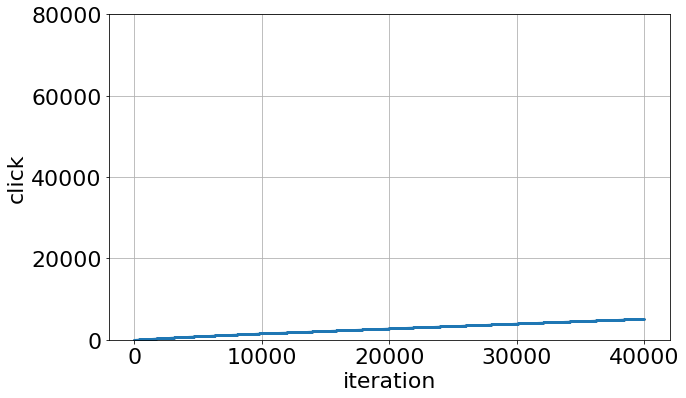

In [ ]:
itr_cumulated_click_count_mean = np.load('/content/itr_cumulated_click_count_mean_S_airbnb.npy')
itr_cumulated_click_count_std = np.load('/content/itr_cumulated_click_count_std_S_airbnb.npy')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax.plot(range(len(itr_cumulated_click_count_mean)), itr_cumulated_click_count_mean, marker='.', linewidth=1.5, markersize=1)
ax.fill_between(range(len(itr_cumulated_click_count_std)), itr_cumulated_click_count_mean-itr_cumulated_click_count_std, 
                itr_cumulated_click_count_mean+itr_cumulated_click_count_std, alpha=0.5)
ax.set_ylabel('click')
ax.set_xlabel('iteration')
ax.set_ylim(0., 80000)
ax.grid(True)
fig.patch.set_facecolor('white')
# plt.legend(loc='best')
plt.tight_layout()
plt.show()

**negative correlation with audience size (reverse popularity bias)**

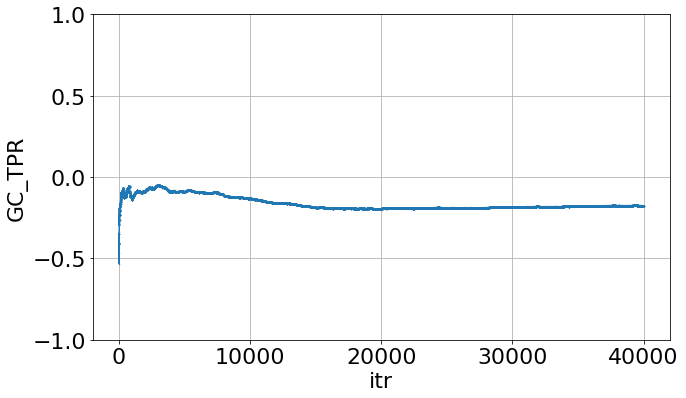

In [ ]:
itr_GC_TPR_mean = np.load('/content/itr_GC_TPR_mean_S_airbnb.npy')
itr_GC_TPR_std = np.load('./itr_GC_TPR_std_S_airbnb.npy')
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax.plot(range(len(itr_GC_TPR_mean)), itr_GC_TPR_mean, marker='.', linewidth=1.5, markersize=1)
ax.fill_between(range(len(itr_GC_TPR_mean)), itr_GC_TPR_mean-itr_GC_TPR_std, itr_GC_TPR_mean+itr_GC_TPR_std, alpha=0.5)
ax.set_ylabel('GC_TPR')
ax.set_xlabel('itr')
ax.set_ylim(-1, 1)
ax.grid(True)
fig.patch.set_facecolor('white')
# plt.legend(loc='best')
plt.tight_layout()
plt.show()

#**Experiment_FPC**

**Upload Simulation_FPC.py and MF_CE.py and add parse.add_(alpha...)**

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings; warnings.simplefilter('ignore')  # Ignores Warnings for nicer Plots. Disable for Debugging
import time
import numpy as np
import argparse
import utility
from Simulation_FPC import Simulation


parser = argparse.ArgumentParser(description='Experiment_FPC')
parser.add_argument('--run', type=int, default=10, help='number of experiments to run')
parser.add_argument('--iteration', type=int, default=40000, help='number of iterations to simulate')
parser.add_argument('--exp', type=int, default=1, help='number of initial random exposure iterations')
parser.add_argument('--cycle_itr', type=int, default=50, help='number of iterations in one cycle')
parser.add_argument('--epoch', type=int, default=15, help='number of epochs to train')
parser.add_argument('--K', type=int, default=20, help='number of items to recommend')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate')
parser.add_argument('--reg', type=float, default=1e-5, help='regularization')
parser.add_argument('--hidden', type=int, default=100, help='latent dimension')
parser.add_argument('--neg', type=int, default=5, help='negative sampling rate')
parser.add_argument('--data', type=str, default='ml1m', help='path to eval in the Data folder')
parser.add_argument('--num_user', type=float, default=num_user, help='path to eval in the Data folder')
parser.add_argument('--num_item', type=float, default=num_item, help='path to eval in the Data folder')
parser.add_argument('-f')

args = parser.parse_args()

truth = np.load('/content/truth_airbnb.npy')
args.num_user = truth.shape[0]
args.num_item = truth.shape[1]
audience_size = np.sum(truth, axis=0)
item_sorted = np.argsort(audience_size)
truth_like = list(np.load('/content/user_truth_like_airbnb.npy', allow_pickle=True))

print('')
print('!' * 30 + ' Total truth ' + str(np.sum(truth)) + ' ' + '!' * 30)
print('')

itr_cumulated_click_count_list = []
itr_GC_TPR_list = []

for r in range(args.run):
    print('')
    print('#' * 100)
    print('#' * 100)
    print(' ' * 50 + ' Experiment run ' + str(r + 1) + ' ' * 50)
    print('#' * 100)
    print('#' * 100)
    simulation = Simulation(args, truth, truth_like)
    init_popularity = simulation.initial_iterations()
    itr_click_item = simulation.run_simulation()

    itr_cumulated_click_count = []
    itr_item_click = np.zeros((args.iteration, args.num_item))
    for itr in range(args.iteration):
        click_item = itr_click_item[itr]
        itr_item_click[itr, click_item] = 1.
        itr_cumulated_click_count.append(
            len(click_item) if itr == 0 else len(click_item) + itr_cumulated_click_count[-1])
    for itr in range(1, args.iteration):
        itr_item_click[itr, :] += itr_item_click[itr - 1, :]
    itr_item_click /= (audience_size - init_popularity).reshape((1, -1))

    itr_GC_TPR = []
    for itr in range(args.iteration):
        a = itr_item_click[itr, item_sorted]
        gc = np.sum(((np.arange(len(a)) + 1.) * 2 - len(a) - 1) * a) / (len(a) * np.sum(a))
        itr_GC_TPR.append(gc)

    itr_cumulated_click_count_list.append(itr_cumulated_click_count)
    itr_GC_TPR_list.append(itr_GC_TPR)

    itr_cumulated_click_count_mean = np.mean(itr_cumulated_click_count_list, axis=0)
    itr_cumulated_click_count_std = np.std(itr_cumulated_click_count_list, axis=0)
    itr_GC_TPR_mean = np.mean(itr_GC_TPR_list, axis=0)
    itr_GC_TPR_std = np.std(itr_GC_TPR_list, axis=0)


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Total truth 31951.0 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


####################################################################################################
####################################################################################################
                                                   Experiment run 1                                                  
####################################################################################################
####################################################################################################
Namespace(K=20, cycle_itr=50, data='ml1m', epoch=15, exp=1, f='/root/.local/share/jupyter/runtime/kernel-fc381ba0-44ee-4a67-bf4c-ab92f3747d83.json', hidden=100, iteration=40000, lr=0.001, neg=5, num_item=1162, num_user=1000, reg=1e-05, run=10)
****************************** Start initial random iterations ******************************
---------- Iteration 1 ----------


100%|██████████| 1000/1000 [00:00<00:00, 5821.22it/s]

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Generate 175 records.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
****************************** Train MF until converge ******************************
Update bs to 21


******************************MF initialization done ******************************


100%|██████████| 50/50 [00:00<00:00, 119.37it/s]


Training // Epoch 0 //  Total cost = 34.6707  Total cost1 = 34.6517  Total cost2 = 0.0190


100%|██████████| 50/50 [00:00<00:00, 176.06it/s]


Training // Epoch 1 //  Total cost = 34.3641  Total cost1 = 34.3520  Total cost2 = 0.0121


100%|██████████| 50/50 [00:00<00:00, 187.15it/s]


Training // Epoch 2 //  Total cost = 33.9239  Total cost1 = 33.9089  Total cost2 = 0.0151


100%|██████████| 50/50 [00:00<00:00, 170.63it/s]


Training // Epoch 3 //  Total cost = 33.2029  Total cost1 = 33.1829  Total cost2 = 0.0200


100%|██████████| 50/50 [00:00<00:00, 190.04it/s]


Training // Epoch 4 //  Total cost = 32.0813  Total cost1 = 32.0538  Total cost2 = 0.0274


100%|██████████| 50/50 [00:00<00:00, 162.28it/s]


Training // Epoch 5 //  Total cost = 30.5003  Total cost1 = 30.4629  Total cost2 = 0.0374


100%|██████████| 50/50 [00:00<00:00, 196.33it/s]


Training // Epoch 6 //  Total cost = 28.4020  Total cost1 = 28.3523  Total cost2 = 0.0498


100%|██████████| 50/50 [00:00<00:00, 172.31it/s]


Training // Epoch 7 //  Total cost = 25.8178  Total cost1 = 25.7533  Total cost2 = 0.0645


100%|██████████| 50/50 [00:00<00:00, 194.94it/s]


Training // Epoch 8 //  Total cost = 22.7077  Total cost1 = 22.6255  Total cost2 = 0.0821


100%|██████████| 50/50 [00:00<00:00, 160.31it/s]


Training // Epoch 9 //  Total cost = 19.2221  Total cost1 = 19.1205  Total cost2 = 0.1016


100%|██████████| 50/50 [00:00<00:00, 195.15it/s]


Training // Epoch 10 //  Total cost = 15.2278  Total cost1 = 15.1039  Total cost2 = 0.1239


100%|██████████| 50/50 [00:00<00:00, 167.07it/s]


Training // Epoch 11 //  Total cost = 10.9363  Total cost1 = 10.7878  Total cost2 = 0.1485


100%|██████████| 50/50 [00:00<00:00, 198.11it/s]


Training // Epoch 12 //  Total cost = 6.0391  Total cost1 = 5.8650  Total cost2 = 0.1741


100%|██████████| 50/50 [00:00<00:00, 165.85it/s]


Training // Epoch 13 //  Total cost = 1.2116  Total cost1 = 1.0080  Total cost2 = 0.2036


100%|██████████| 50/50 [00:00<00:00, 193.33it/s]


Training // Epoch 14 //  Total cost = -4.2385  Total cost1 = -4.4719  Total cost2 = 0.2335
****************************** Start simulation ******************************


100%|██████████| 50/50 [00:00<00:00, 1690.15it/s]


########## The iteration 50, up to now total 192 clicks, GC=0.3116, this cycle used 0.04 s) ##########
Update bs to 23


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


100%|██████████| 50/50 [00:00<00:00, 1826.06it/s]


########## The iteration 100, up to now total 205 clicks, GC=0.1781, this cycle used 3.94 s) ##########
Update bs to 24


100%|██████████| 15/15 [00:05<00:00,  2.90it/s]


100%|██████████| 50/50 [00:00<00:00, 599.49it/s]


########## The iteration 150, up to now total 219 clicks, GC=0.1647, this cycle used 5.35 s) ##########
Update bs to 26


100%|██████████| 15/15 [00:04<00:00,  3.10it/s]


100%|██████████| 50/50 [00:00<00:00, 1831.29it/s]


########## The iteration 200, up to now total 225 clicks, GC=0.2037, this cycle used 5.00 s) ##########
Update bs to 27


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 1642.67it/s]


########## The iteration 250, up to now total 238 clicks, GC=0.1931, this cycle used 3.72 s) ##########
Update bs to 28


100%|██████████| 15/15 [00:03<00:00,  3.86it/s]


100%|██████████| 50/50 [00:00<00:00, 1871.14it/s]


########## The iteration 300, up to now total 256 clicks, GC=0.2160, this cycle used 3.98 s) ##########
Update bs to 30


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 1920.15it/s]


########## The iteration 350, up to now total 275 clicks, GC=0.2490, this cycle used 3.77 s) ##########
Update bs to 33


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 1636.84it/s]


########## The iteration 400, up to now total 287 clicks, GC=0.2487, this cycle used 4.05 s) ##########
Update bs to 34


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 1402.73it/s]


########## The iteration 450, up to now total 306 clicks, GC=0.2812, this cycle used 4.19 s) ##########
Update bs to 36


100%|██████████| 15/15 [00:04<00:00,  3.25it/s]


100%|██████████| 50/50 [00:00<00:00, 577.96it/s]


########## The iteration 500, up to now total 324 clicks, GC=0.3057, this cycle used 4.81 s) ##########
Update bs to 38


100%|██████████| 15/15 [00:07<00:00,  1.90it/s]


100%|██████████| 50/50 [00:00<00:00, 670.19it/s]


########## The iteration 550, up to now total 338 clicks, GC=0.3301, this cycle used 8.14 s) ##########
Update bs to 40


100%|██████████| 15/15 [00:05<00:00,  2.92it/s]


100%|██████████| 50/50 [00:00<00:00, 1351.04it/s]


########## The iteration 600, up to now total 356 clicks, GC=0.3385, this cycle used 5.29 s) ##########
Update bs to 42


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


100%|██████████| 50/50 [00:00<00:00, 1082.31it/s]


########## The iteration 650, up to now total 366 clicks, GC=0.3442, this cycle used 6.82 s) ##########
Update bs to 43


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


100%|██████████| 50/50 [00:00<00:00, 1601.06it/s]


########## The iteration 700, up to now total 384 clicks, GC=0.3422, this cycle used 4.46 s) ##########
Update bs to 46


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 1659.52it/s]


########## The iteration 750, up to now total 398 clicks, GC=0.3503, this cycle used 4.10 s) ##########
Update bs to 47


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 1741.30it/s]


########## The iteration 800, up to now total 406 clicks, GC=0.3319, this cycle used 3.74 s) ##########
Update bs to 48


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 857.82it/s]


########## The iteration 850, up to now total 421 clicks, GC=0.3079, this cycle used 4.28 s) ##########
Update bs to 50


100%|██████████| 15/15 [00:05<00:00,  2.92it/s]


100%|██████████| 50/50 [00:00<00:00, 1704.84it/s]


########## The iteration 900, up to now total 433 clicks, GC=0.3049, this cycle used 5.30 s) ##########
Update bs to 51


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1533.03it/s]


########## The iteration 950, up to now total 449 clicks, GC=0.3146, this cycle used 4.25 s) ##########
Update bs to 53


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 2318.93it/s]


########## The iteration 1000, up to now total 462 clicks, GC=0.3235, this cycle used 3.62 s) ##########
Update bs to 55


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 1714.91it/s]


########## The iteration 1050, up to now total 479 clicks, GC=0.3119, this cycle used 4.14 s) ##########
Update bs to 57


100%|██████████| 15/15 [00:05<00:00,  3.00it/s]


100%|██████████| 50/50 [00:00<00:00, 745.20it/s]


########## The iteration 1100, up to now total 496 clicks, GC=0.3210, this cycle used 5.17 s) ##########
Update bs to 59


100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


100%|██████████| 50/50 [00:00<00:00, 831.44it/s]


########## The iteration 1150, up to now total 505 clicks, GC=0.3293, this cycle used 6.89 s) ##########
Update bs to 60


100%|██████████| 15/15 [00:05<00:00,  2.83it/s]


100%|██████████| 50/50 [00:00<00:00, 1716.42it/s]


########## The iteration 1200, up to now total 518 clicks, GC=0.3107, this cycle used 5.45 s) ##########
Update bs to 62


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 1715.35it/s]


########## The iteration 1250, up to now total 528 clicks, GC=0.3041, this cycle used 4.11 s) ##########
Update bs to 63


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1745.78it/s]


########## The iteration 1300, up to now total 539 clicks, GC=0.3060, this cycle used 3.36 s) ##########
Update bs to 64


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 1870.92it/s]


########## The iteration 1350, up to now total 560 clicks, GC=0.3115, this cycle used 4.18 s) ##########
Update bs to 67


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 1513.68it/s]


########## The iteration 1400, up to now total 568 clicks, GC=0.3086, this cycle used 3.62 s) ##########
Update bs to 68


100%|██████████| 15/15 [00:03<00:00,  4.74it/s]


100%|██████████| 50/50 [00:00<00:00, 1798.85it/s]


########## The iteration 1450, up to now total 579 clicks, GC=0.3066, this cycle used 3.28 s) ##########
Update bs to 69


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


100%|██████████| 50/50 [00:00<00:00, 1605.22it/s]


########## The iteration 1500, up to now total 593 clicks, GC=0.2954, this cycle used 3.90 s) ##########
Update bs to 71


100%|██████████| 15/15 [00:03<00:00,  4.67it/s]


100%|██████████| 50/50 [00:00<00:00, 1777.68it/s]


########## The iteration 1550, up to now total 609 clicks, GC=0.2975, this cycle used 3.34 s) ##########
Update bs to 73


100%|██████████| 15/15 [00:04<00:00,  3.08it/s]


100%|██████████| 50/50 [00:00<00:00, 877.15it/s]


########## The iteration 1600, up to now total 621 clicks, GC=0.3019, this cycle used 5.07 s) ##########
Update bs to 74


100%|██████████| 15/15 [00:07<00:00,  2.05it/s]


100%|██████████| 50/50 [00:00<00:00, 832.51it/s]


########## The iteration 1650, up to now total 630 clicks, GC=0.3058, this cycle used 7.57 s) ##########
Update bs to 75


100%|██████████| 15/15 [00:05<00:00,  2.73it/s]


100%|██████████| 50/50 [00:00<00:00, 1119.62it/s]


########## The iteration 1700, up to now total 646 clicks, GC=0.3089, this cycle used 5.75 s) ##########
Update bs to 77


100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


100%|██████████| 50/50 [00:00<00:00, 1363.59it/s]


########## The iteration 1750, up to now total 657 clicks, GC=0.3088, this cycle used 5.57 s) ##########
Update bs to 78


100%|██████████| 15/15 [00:03<00:00,  4.43it/s]


100%|██████████| 50/50 [00:00<00:00, 1649.70it/s]


########## The iteration 1800, up to now total 670 clicks, GC=0.3078, this cycle used 3.52 s) ##########
Update bs to 80


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 1504.99it/s]


########## The iteration 1850, up to now total 687 clicks, GC=0.3129, this cycle used 4.14 s) ##########
Update bs to 82


100%|██████████| 15/15 [00:03<00:00,  4.72it/s]


100%|██████████| 50/50 [00:00<00:00, 2083.86it/s]


########## The iteration 1900, up to now total 699 clicks, GC=0.3179, this cycle used 3.31 s) ##########
Update bs to 83


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 1707.40it/s]


########## The iteration 1950, up to now total 715 clicks, GC=0.3256, this cycle used 3.43 s) ##########
Update bs to 85


100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


100%|██████████| 50/50 [00:00<00:00, 1499.68it/s]


########## The iteration 2000, up to now total 730 clicks, GC=0.3296, this cycle used 3.96 s) ##########
Update bs to 87


100%|██████████| 15/15 [00:03<00:00,  4.68it/s]


100%|██████████| 50/50 [00:00<00:00, 1768.17it/s]


########## The iteration 2050, up to now total 744 clicks, GC=0.3321, this cycle used 3.36 s) ##########
Update bs to 89


100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


100%|██████████| 50/50 [00:00<00:00, 1855.43it/s]


########## The iteration 2100, up to now total 753 clicks, GC=0.3331, this cycle used 3.39 s) ##########
Update bs to 90


100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


100%|██████████| 50/50 [00:00<00:00, 1924.77it/s]


########## The iteration 2150, up to now total 767 clicks, GC=0.3396, this cycle used 3.94 s) ##########
Update bs to 92


100%|██████████| 15/15 [00:03<00:00,  4.72it/s]


100%|██████████| 50/50 [00:00<00:00, 1423.45it/s]


########## The iteration 2200, up to now total 782 clicks, GC=0.3364, this cycle used 3.34 s) ##########
Update bs to 93


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1590.56it/s]


########## The iteration 2250, up to now total 789 clicks, GC=0.3400, this cycle used 3.40 s) ##########
Update bs to 94


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 1831.53it/s]


########## The iteration 2300, up to now total 801 clicks, GC=0.3424, this cycle used 3.41 s) ##########
Update bs to 96


100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


100%|██████████| 50/50 [00:00<00:00, 1517.38it/s]


########## The iteration 2350, up to now total 820 clicks, GC=0.3512, this cycle used 3.38 s) ##########
Update bs to 98


100%|██████████| 15/15 [00:03<00:00,  4.72it/s]


100%|██████████| 50/50 [00:00<00:00, 1591.65it/s]


########## The iteration 2400, up to now total 834 clicks, GC=0.3529, this cycle used 3.34 s) ##########
Update bs to 100


100%|██████████| 15/15 [00:03<00:00,  4.70it/s]


100%|██████████| 50/50 [00:00<00:00, 1579.69it/s]


########## The iteration 2450, up to now total 849 clicks, GC=0.3595, this cycle used 3.35 s) ##########
Update bs to 101


100%|██████████| 15/15 [00:03<00:00,  4.69it/s]


100%|██████████| 50/50 [00:00<00:00, 1639.92it/s]


########## The iteration 2500, up to now total 869 clicks, GC=0.3639, this cycle used 3.36 s) ##########
Update bs to 104


100%|██████████| 15/15 [00:03<00:00,  4.67it/s]


100%|██████████| 50/50 [00:00<00:00, 1740.53it/s]


########## The iteration 2550, up to now total 880 clicks, GC=0.3656, this cycle used 3.36 s) ##########
Update bs to 105


100%|██████████| 15/15 [00:03<00:00,  4.70it/s]


100%|██████████| 50/50 [00:00<00:00, 1466.03it/s]


########## The iteration 2600, up to now total 894 clicks, GC=0.3689, this cycle used 3.35 s) ##########
Update bs to 107


100%|██████████| 15/15 [00:03<00:00,  4.72it/s]


100%|██████████| 50/50 [00:00<00:00, 2182.85it/s]


########## The iteration 2650, up to now total 911 clicks, GC=0.3733, this cycle used 3.33 s) ##########
Update bs to 109


100%|██████████| 15/15 [00:03<00:00,  4.71it/s]


100%|██████████| 50/50 [00:00<00:00, 1670.24it/s]


########## The iteration 2700, up to now total 922 clicks, GC=0.3752, this cycle used 3.35 s) ##########
Update bs to 110


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 1619.37it/s]


########## The iteration 2750, up to now total 935 clicks, GC=0.3786, this cycle used 3.69 s) ##########
Update bs to 112


100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


100%|██████████| 50/50 [00:00<00:00, 2133.18it/s]


########## The iteration 2800, up to now total 949 clicks, GC=0.3837, this cycle used 3.40 s) ##########
Update bs to 113


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


100%|██████████| 50/50 [00:00<00:00, 1600.83it/s]


########## The iteration 2850, up to now total 961 clicks, GC=0.3822, this cycle used 3.45 s) ##########
Update bs to 115


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 1492.70it/s]


########## The iteration 2900, up to now total 977 clicks, GC=0.3872, this cycle used 3.66 s) ##########
Update bs to 117


100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


100%|██████████| 50/50 [00:00<00:00, 1314.06it/s]


########## The iteration 2950, up to now total 990 clicks, GC=0.3917, this cycle used 3.43 s) ##########
Update bs to 118


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 1488.11it/s]


########## The iteration 3000, up to now total 1001 clicks, GC=0.3936, this cycle used 3.44 s) ##########
Update bs to 120


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


100%|██████████| 50/50 [00:00<00:00, 1664.39it/s]


########## The iteration 3050, up to now total 1016 clicks, GC=0.3940, this cycle used 3.59 s) ##########
Update bs to 121


100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


100%|██████████| 50/50 [00:00<00:00, 1737.05it/s]


########## The iteration 3100, up to now total 1034 clicks, GC=0.3940, this cycle used 3.42 s) ##########
Update bs to 124


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 1811.09it/s]


########## The iteration 3150, up to now total 1049 clicks, GC=0.3902, this cycle used 4.08 s) ##########
Update bs to 125


100%|██████████| 15/15 [00:03<00:00,  4.66it/s]


100%|██████████| 50/50 [00:00<00:00, 1435.63it/s]


########## The iteration 3200, up to now total 1070 clicks, GC=0.3896, this cycle used 3.39 s) ##########
Update bs to 128


100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


100%|██████████| 50/50 [00:00<00:00, 1331.35it/s]


########## The iteration 3250, up to now total 1084 clicks, GC=0.3896, this cycle used 3.42 s) ##########
Update bs to 130


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1763.36it/s]


########## The iteration 3300, up to now total 1111 clicks, GC=0.3917, this cycle used 3.48 s) ##########
Update bs to 133


100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


100%|██████████| 50/50 [00:00<00:00, 1428.15it/s]


########## The iteration 3350, up to now total 1127 clicks, GC=0.3938, this cycle used 3.42 s) ##########
Update bs to 135


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 1564.86it/s]


########## The iteration 3400, up to now total 1144 clicks, GC=0.3943, this cycle used 3.47 s) ##########
Update bs to 137


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1686.02it/s]


########## The iteration 3450, up to now total 1157 clicks, GC=0.3926, this cycle used 3.42 s) ##########
Update bs to 138


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 1497.32it/s]


########## The iteration 3500, up to now total 1169 clicks, GC=0.3926, this cycle used 3.47 s) ##########
Update bs to 140


100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


100%|██████████| 50/50 [00:00<00:00, 1876.11it/s]


########## The iteration 3550, up to now total 1187 clicks, GC=0.3937, this cycle used 3.40 s) ##########
Update bs to 142


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1323.17it/s]


########## The iteration 3600, up to now total 1211 clicks, GC=0.3883, this cycle used 3.45 s) ##########
Update bs to 145


100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


100%|██████████| 50/50 [00:00<00:00, 1335.07it/s]


########## The iteration 3650, up to now total 1224 clicks, GC=0.3896, this cycle used 3.43 s) ##########
Update bs to 146


100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


100%|██████████| 50/50 [00:00<00:00, 1643.50it/s]


########## The iteration 3700, up to now total 1244 clicks, GC=0.3917, this cycle used 3.40 s) ##########
Update bs to 149


100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


100%|██████████| 50/50 [00:00<00:00, 1659.89it/s]


########## The iteration 3750, up to now total 1260 clicks, GC=0.3909, this cycle used 3.42 s) ##########
Update bs to 151


100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1864.38it/s]


########## The iteration 3800, up to now total 1273 clicks, GC=0.3906, this cycle used 3.44 s) ##########
Update bs to 152


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1310.29it/s]


########## The iteration 3850, up to now total 1292 clicks, GC=0.3851, this cycle used 3.44 s) ##########
Update bs to 155


100%|██████████| 15/15 [00:03<00:00,  4.66it/s]


100%|██████████| 50/50 [00:00<00:00, 2420.95it/s]


########## The iteration 3900, up to now total 1308 clicks, GC=0.3881, this cycle used 3.40 s) ##########
Update bs to 156


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1201.06it/s]


########## The iteration 3950, up to now total 1321 clicks, GC=0.3872, this cycle used 3.44 s) ##########
Update bs to 158


100%|██████████| 15/15 [00:04<00:00,  3.32it/s]


100%|██████████| 50/50 [00:00<00:00, 1250.98it/s]


########## The iteration 4000, up to now total 1340 clicks, GC=0.3877, this cycle used 4.71 s) ##########
Update bs to 160


100%|██████████| 15/15 [00:03<00:00,  4.68it/s]


100%|██████████| 50/50 [00:00<00:00, 1631.71it/s]


########## The iteration 4050, up to now total 1352 clicks, GC=0.3895, this cycle used 3.41 s) ##########
Update bs to 162


100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


100%|██████████| 50/50 [00:00<00:00, 1318.73it/s]


########## The iteration 4100, up to now total 1367 clicks, GC=0.3932, this cycle used 3.45 s) ##########
Update bs to 164


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 960.38it/s]


########## The iteration 4150, up to now total 1376 clicks, GC=0.3934, this cycle used 3.50 s) ##########
Update bs to 165


100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


100%|██████████| 50/50 [00:00<00:00, 1604.47it/s]


########## The iteration 4200, up to now total 1387 clicks, GC=0.3961, this cycle used 3.43 s) ##########
Update bs to 166


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 1402.76it/s]


########## The iteration 4250, up to now total 1398 clicks, GC=0.3960, this cycle used 3.46 s) ##########
Update bs to 167


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


100%|██████████| 50/50 [00:00<00:00, 1577.24it/s]


########## The iteration 4300, up to now total 1416 clicks, GC=0.3980, this cycle used 3.45 s) ##########
Update bs to 169


100%|██████████| 15/15 [00:03<00:00,  4.67it/s]


100%|██████████| 50/50 [00:00<00:00, 1927.71it/s]


########## The iteration 4350, up to now total 1429 clicks, GC=0.3950, this cycle used 3.41 s) ##########
Update bs to 171


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


100%|██████████| 50/50 [00:00<00:00, 1407.99it/s]


########## The iteration 4400, up to now total 1438 clicks, GC=0.3953, this cycle used 3.47 s) ##########
Update bs to 172


100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


100%|██████████| 50/50 [00:00<00:00, 1331.37it/s]


########## The iteration 4450, up to now total 1446 clicks, GC=0.3954, this cycle used 3.45 s) ##########
Update bs to 173


100%|██████████| 15/15 [00:04<00:00,  3.28it/s]


100%|██████████| 50/50 [00:00<00:00, 1310.68it/s]


########## The iteration 4500, up to now total 1452 clicks, GC=0.3965, this cycle used 4.79 s) ##########
Update bs to 174


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 1225.53it/s]


########## The iteration 4550, up to now total 1461 clicks, GC=0.3977, this cycle used 3.50 s) ##########
Update bs to 175


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 1230.48it/s]


########## The iteration 4600, up to now total 1473 clicks, GC=0.3961, this cycle used 3.47 s) ##########
Update bs to 176


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


100%|██████████| 50/50 [00:00<00:00, 1320.13it/s]


########## The iteration 4650, up to now total 1487 clicks, GC=0.3960, this cycle used 3.52 s) ##########
Update bs to 178


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


100%|██████████| 50/50 [00:00<00:00, 1288.91it/s]


########## The iteration 4700, up to now total 1502 clicks, GC=0.3975, this cycle used 3.51 s) ##########
Update bs to 180


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 1460.16it/s]


########## The iteration 4750, up to now total 1520 clicks, GC=0.3998, this cycle used 3.88 s) ##########
Update bs to 182


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 1390.83it/s]


########## The iteration 4800, up to now total 1538 clicks, GC=0.4020, this cycle used 3.47 s) ##########
Update bs to 184


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 1123.43it/s]


########## The iteration 4850, up to now total 1558 clicks, GC=0.3971, this cycle used 4.07 s) ##########
Update bs to 186


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 1250.01it/s]


########## The iteration 4900, up to now total 1577 clicks, GC=0.4004, this cycle used 3.47 s) ##########
Update bs to 189


100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1721.35it/s]


########## The iteration 4950, up to now total 1595 clicks, GC=0.3909, this cycle used 3.45 s) ##########
Update bs to 191


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


100%|██████████| 50/50 [00:00<00:00, 1473.32it/s]


########## The iteration 5000, up to now total 1613 clicks, GC=0.3936, this cycle used 3.49 s) ##########
Update bs to 193


100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


100%|██████████| 50/50 [00:00<00:00, 1454.66it/s]


########## The iteration 5050, up to now total 1631 clicks, GC=0.3902, this cycle used 3.45 s) ##########
Update bs to 195


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1400.79it/s]


########## The iteration 5100, up to now total 1649 clicks, GC=0.3903, this cycle used 3.50 s) ##########
Update bs to 197


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


100%|██████████| 50/50 [00:00<00:00, 1343.85it/s]


########## The iteration 5150, up to now total 1661 clicks, GC=0.3910, this cycle used 3.48 s) ##########
Update bs to 199


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 1387.25it/s]


########## The iteration 5200, up to now total 1681 clicks, GC=0.3937, this cycle used 3.48 s) ##########
Update bs to 201


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 1653.49it/s]


########## The iteration 5250, up to now total 1696 clicks, GC=0.3920, this cycle used 3.48 s) ##########
Update bs to 203


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 1564.91it/s]


########## The iteration 5300, up to now total 1711 clicks, GC=0.3914, this cycle used 3.51 s) ##########
Update bs to 205


100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1850.83it/s]


########## The iteration 5350, up to now total 1731 clicks, GC=0.3896, this cycle used 3.44 s) ##########
Update bs to 207


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1446.64it/s]


########## The iteration 5400, up to now total 1742 clicks, GC=0.3873, this cycle used 3.51 s) ##########
Update bs to 209


100%|██████████| 15/15 [00:03<00:00,  4.57it/s]


100%|██████████| 50/50 [00:00<00:00, 1279.01it/s]


########## The iteration 5450, up to now total 1759 clicks, GC=0.3877, this cycle used 3.49 s) ##########
Update bs to 211


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


100%|██████████| 50/50 [00:00<00:00, 1045.76it/s]


########## The iteration 5500, up to now total 1770 clicks, GC=0.3898, this cycle used 3.53 s) ##########
Update bs to 212


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 1251.13it/s]


########## The iteration 5550, up to now total 1782 clicks, GC=0.3913, this cycle used 3.48 s) ##########
Update bs to 213


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 1321.71it/s]


########## The iteration 5600, up to now total 1800 clicks, GC=0.3929, this cycle used 3.52 s) ##########
Update bs to 216


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1341.53it/s]


########## The iteration 5650, up to now total 1810 clicks, GC=0.3939, this cycle used 3.51 s) ##########
Update bs to 217


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 1319.27it/s]


########## The iteration 5700, up to now total 1829 clicks, GC=0.3957, this cycle used 3.51 s) ##########
Update bs to 219


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 1257.75it/s]


########## The iteration 5750, up to now total 1840 clicks, GC=0.3954, this cycle used 3.49 s) ##########
Update bs to 220


100%|██████████| 15/15 [00:03<00:00,  4.57it/s]


100%|██████████| 50/50 [00:00<00:00, 1546.85it/s]


########## The iteration 5800, up to now total 1855 clicks, GC=0.3936, this cycle used 3.50 s) ##########
Update bs to 222


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1509.77it/s]


########## The iteration 5850, up to now total 1863 clicks, GC=0.3950, this cycle used 3.51 s) ##########
Update bs to 223


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


100%|██████████| 50/50 [00:00<00:00, 1239.98it/s]


########## The iteration 5900, up to now total 1883 clicks, GC=0.3890, this cycle used 3.50 s) ##########
Update bs to 225


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1457.17it/s]


########## The iteration 5950, up to now total 1895 clicks, GC=0.3884, this cycle used 3.46 s) ##########
Update bs to 227


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1552.15it/s]


########## The iteration 6000, up to now total 1908 clicks, GC=0.3906, this cycle used 3.47 s) ##########
Update bs to 228


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 1122.17it/s]


########## The iteration 6050, up to now total 1918 clicks, GC=0.3922, this cycle used 3.50 s) ##########
Update bs to 230


100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


100%|██████████| 50/50 [00:00<00:00, 1526.79it/s]


########## The iteration 6100, up to now total 1934 clicks, GC=0.3865, this cycle used 3.46 s) ##########
Update bs to 232


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 1388.68it/s]


########## The iteration 6150, up to now total 1949 clicks, GC=0.3847, this cycle used 3.50 s) ##########
Update bs to 233


100%|██████████| 15/15 [00:03<00:00,  4.57it/s]


100%|██████████| 50/50 [00:00<00:00, 1180.66it/s]


########## The iteration 6200, up to now total 1960 clicks, GC=0.3816, this cycle used 3.50 s) ##########
Update bs to 235


100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


100%|██████████| 50/50 [00:00<00:00, 1265.38it/s]


########## The iteration 6250, up to now total 1974 clicks, GC=0.3792, this cycle used 3.49 s) ##########
Update bs to 236


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


100%|██████████| 50/50 [00:00<00:00, 1363.62it/s]


########## The iteration 6300, up to now total 1989 clicks, GC=0.3760, this cycle used 3.53 s) ##########
Update bs to 238


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1136.67it/s]


########## The iteration 6350, up to now total 2003 clicks, GC=0.3764, this cycle used 3.53 s) ##########
Update bs to 240


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1195.65it/s]


########## The iteration 6400, up to now total 2014 clicks, GC=0.3760, this cycle used 3.52 s) ##########
Update bs to 241


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


100%|██████████| 50/50 [00:00<00:00, 1179.35it/s]


########## The iteration 6450, up to now total 2024 clicks, GC=0.3760, this cycle used 3.50 s) ##########
Update bs to 242


100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


100%|██████████| 50/50 [00:00<00:00, 1283.32it/s]


########## The iteration 6500, up to now total 2038 clicks, GC=0.3755, this cycle used 3.57 s) ##########
Update bs to 244


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 1132.24it/s]


########## The iteration 6550, up to now total 2052 clicks, GC=0.3734, this cycle used 3.51 s) ##########
Update bs to 246


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1046.65it/s]


########## The iteration 6600, up to now total 2068 clicks, GC=0.3749, this cycle used 3.55 s) ##########
Update bs to 248


100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


100%|██████████| 50/50 [00:00<00:00, 1188.08it/s]


########## The iteration 6650, up to now total 2083 clicks, GC=0.3766, this cycle used 3.57 s) ##########
Update bs to 249


100%|██████████| 15/15 [00:03<00:00,  4.51it/s]


100%|██████████| 50/50 [00:00<00:00, 1215.97it/s]


########## The iteration 6700, up to now total 2092 clicks, GC=0.3750, this cycle used 3.57 s) ##########
Update bs to 251


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


100%|██████████| 50/50 [00:00<00:00, 1296.48it/s]


########## The iteration 6750, up to now total 2106 clicks, GC=0.3702, this cycle used 3.54 s) ##########
Update bs to 252


100%|██████████| 15/15 [00:03<00:00,  4.39it/s]


100%|██████████| 50/50 [00:00<00:00, 1603.45it/s]


########## The iteration 6800, up to now total 2113 clicks, GC=0.3700, this cycle used 3.66 s) ##########
Update bs to 253


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1430.75it/s]


########## The iteration 6850, up to now total 2125 clicks, GC=0.3708, this cycle used 3.57 s) ##########
Update bs to 255


100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


100%|██████████| 50/50 [00:00<00:00, 1357.04it/s]


########## The iteration 6900, up to now total 2135 clicks, GC=0.3718, this cycle used 3.59 s) ##########
Update bs to 256


100%|██████████| 15/15 [00:03<00:00,  4.51it/s]


100%|██████████| 50/50 [00:00<00:00, 1428.72it/s]


########## The iteration 6950, up to now total 2145 clicks, GC=0.3686, this cycle used 3.56 s) ##########
Update bs to 257


100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


100%|██████████| 50/50 [00:00<00:00, 1387.32it/s]


########## The iteration 7000, up to now total 2155 clicks, GC=0.3692, this cycle used 3.61 s) ##########
Update bs to 258


100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


100%|██████████| 50/50 [00:00<00:00, 1319.40it/s]


########## The iteration 7050, up to now total 2170 clicks, GC=0.3669, this cycle used 3.57 s) ##########
Update bs to 260


100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


100%|██████████| 50/50 [00:00<00:00, 1091.53it/s]


########## The iteration 7100, up to now total 2178 clicks, GC=0.3677, this cycle used 3.64 s) ##########
Update bs to 261


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


100%|██████████| 50/50 [00:00<00:00, 1474.41it/s]


########## The iteration 7150, up to now total 2191 clicks, GC=0.3667, this cycle used 3.57 s) ##########
Update bs to 262


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


100%|██████████| 50/50 [00:00<00:00, 1129.54it/s]


########## The iteration 7200, up to now total 2206 clicks, GC=0.3664, this cycle used 3.58 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


100%|██████████| 50/50 [00:00<00:00, 1021.27it/s]


########## The iteration 7250, up to now total 2220 clicks, GC=0.3642, this cycle used 3.62 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


100%|██████████| 50/50 [00:00<00:00, 1148.07it/s]


########## The iteration 7300, up to now total 2231 clicks, GC=0.3654, this cycle used 3.69 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 1128.38it/s]


########## The iteration 7350, up to now total 2245 clicks, GC=0.3639, this cycle used 3.66 s) ##########
Update bs to 269


100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 1190.91it/s]


########## The iteration 7400, up to now total 2258 clicks, GC=0.3599, this cycle used 4.25 s) ##########
Update bs to 270


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


100%|██████████| 50/50 [00:00<00:00, 1115.18it/s]


########## The iteration 7450, up to now total 2270 clicks, GC=0.3588, this cycle used 3.66 s) ##########
Update bs to 272


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 1198.56it/s]


########## The iteration 7500, up to now total 2287 clicks, GC=0.3591, this cycle used 3.77 s) ##########
Update bs to 274


100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


100%|██████████| 50/50 [00:00<00:00, 1094.13it/s]


########## The iteration 7550, up to now total 2301 clicks, GC=0.3577, this cycle used 4.05 s) ##########
Update bs to 276


100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


100%|██████████| 50/50 [00:00<00:00, 1332.55it/s]


########## The iteration 7600, up to now total 2317 clicks, GC=0.3568, this cycle used 3.65 s) ##########
Update bs to 278


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 943.96it/s]


########## The iteration 7650, up to now total 2328 clicks, GC=0.3572, this cycle used 4.14 s) ##########
Update bs to 279


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 1329.20it/s]


########## The iteration 7700, up to now total 2337 clicks, GC=0.3562, this cycle used 3.67 s) ##########
Update bs to 280


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1109.66it/s]


########## The iteration 7750, up to now total 2344 clicks, GC=0.3571, this cycle used 3.69 s) ##########
Update bs to 281


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1735.82it/s]


########## The iteration 7800, up to now total 2358 clicks, GC=0.3569, this cycle used 4.45 s) ##########
Update bs to 282


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 1370.45it/s]


########## The iteration 7850, up to now total 2371 clicks, GC=0.3552, this cycle used 3.67 s) ##########
Update bs to 284


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


100%|██████████| 50/50 [00:00<00:00, 1130.21it/s]


########## The iteration 7900, up to now total 2384 clicks, GC=0.3555, this cycle used 4.53 s) ##########
Update bs to 286


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


100%|██████████| 50/50 [00:00<00:00, 1139.25it/s]


########## The iteration 7950, up to now total 2404 clicks, GC=0.3533, this cycle used 3.66 s) ##########
Update bs to 288


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 1040.42it/s]


########## The iteration 8000, up to now total 2411 clicks, GC=0.3542, this cycle used 4.14 s) ##########
Update bs to 289


100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


100%|██████████| 50/50 [00:00<00:00, 1101.07it/s]


########## The iteration 8050, up to now total 2423 clicks, GC=0.3530, this cycle used 3.63 s) ##########
Update bs to 290


100%|██████████| 15/15 [00:04<00:00,  3.50it/s]


100%|██████████| 50/50 [00:00<00:00, 1177.19it/s]


########## The iteration 8100, up to now total 2441 clicks, GC=0.3492, this cycle used 4.62 s) ##########
Update bs to 292


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1245.04it/s]


########## The iteration 8150, up to now total 2451 clicks, GC=0.3505, this cycle used 3.71 s) ##########
Update bs to 294


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 1308.63it/s]


########## The iteration 8200, up to now total 2466 clicks, GC=0.3507, this cycle used 3.71 s) ##########
Update bs to 295


100%|██████████| 15/15 [00:03<00:00,  4.42it/s]


100%|██████████| 50/50 [00:00<00:00, 863.95it/s]


########## The iteration 8250, up to now total 2479 clicks, GC=0.3524, this cycle used 3.68 s) ##########
Update bs to 297


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 1040.91it/s]


########## The iteration 8300, up to now total 2491 clicks, GC=0.3496, this cycle used 3.70 s) ##########
Update bs to 298


100%|██████████| 15/15 [00:03<00:00,  4.42it/s]


100%|██████████| 50/50 [00:00<00:00, 1210.37it/s]


########## The iteration 8350, up to now total 2499 clicks, GC=0.3500, this cycle used 3.66 s) ##########
Update bs to 299


100%|██████████| 15/15 [00:03<00:00,  4.42it/s]


100%|██████████| 50/50 [00:00<00:00, 1264.16it/s]


########## The iteration 8400, up to now total 2513 clicks, GC=0.3513, this cycle used 3.65 s) ##########
Update bs to 301


100%|██████████| 15/15 [00:03<00:00,  4.44it/s]


100%|██████████| 50/50 [00:00<00:00, 1090.40it/s]


########## The iteration 8450, up to now total 2523 clicks, GC=0.3521, this cycle used 3.65 s) ##########
Update bs to 302


100%|██████████| 15/15 [00:03<00:00,  4.43it/s]


100%|██████████| 50/50 [00:00<00:00, 1218.54it/s]


########## The iteration 8500, up to now total 2540 clicks, GC=0.3520, this cycle used 3.65 s) ##########
Update bs to 304


100%|██████████| 15/15 [00:03<00:00,  4.39it/s]


100%|██████████| 50/50 [00:00<00:00, 979.53it/s]


########## The iteration 8550, up to now total 2547 clicks, GC=0.3528, this cycle used 3.68 s) ##########
Update bs to 305


100%|██████████| 15/15 [00:03<00:00,  4.43it/s]


100%|██████████| 50/50 [00:00<00:00, 978.35it/s]


########## The iteration 8600, up to now total 2556 clicks, GC=0.3535, this cycle used 3.65 s) ##########
Update bs to 306


100%|██████████| 15/15 [00:03<00:00,  4.43it/s]


100%|██████████| 50/50 [00:00<00:00, 1336.41it/s]


########## The iteration 8650, up to now total 2568 clicks, GC=0.3550, this cycle used 3.65 s) ##########
Update bs to 308


100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


100%|██████████| 50/50 [00:00<00:00, 1134.00it/s]


########## The iteration 8700, up to now total 2579 clicks, GC=0.3559, this cycle used 3.65 s) ##########
Update bs to 309


100%|██████████| 15/15 [00:03<00:00,  4.47it/s]


100%|██████████| 50/50 [00:00<00:00, 1111.88it/s]


########## The iteration 8750, up to now total 2589 clicks, GC=0.3538, this cycle used 3.62 s) ##########
Update bs to 310


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


100%|██████████| 50/50 [00:00<00:00, 1103.96it/s]


########## The iteration 8800, up to now total 2603 clicks, GC=0.3502, this cycle used 3.69 s) ##########
Update bs to 312


100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


100%|██████████| 50/50 [00:00<00:00, 1099.89it/s]


########## The iteration 8850, up to now total 2615 clicks, GC=0.3506, this cycle used 3.67 s) ##########
Update bs to 313


100%|██████████| 15/15 [00:03<00:00,  4.44it/s]


100%|██████████| 50/50 [00:00<00:00, 978.47it/s]


########## The iteration 8900, up to now total 2626 clicks, GC=0.3502, this cycle used 3.65 s) ##########
Update bs to 315


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


100%|██████████| 50/50 [00:00<00:00, 1333.48it/s]


########## The iteration 8950, up to now total 2636 clicks, GC=0.3513, this cycle used 3.68 s) ##########
Update bs to 316


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 1295.14it/s]


########## The iteration 9000, up to now total 2649 clicks, GC=0.3486, this cycle used 3.84 s) ##########
Update bs to 317


100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


100%|██████████| 50/50 [00:00<00:00, 1173.68it/s]


########## The iteration 9050, up to now total 2660 clicks, GC=0.3448, this cycle used 3.67 s) ##########
Update bs to 319


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


100%|██████████| 50/50 [00:00<00:00, 1121.97it/s]


########## The iteration 9100, up to now total 2669 clicks, GC=0.3429, this cycle used 4.11 s) ##########
Update bs to 320


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


100%|██████████| 50/50 [00:00<00:00, 1138.84it/s]


########## The iteration 9150, up to now total 2682 clicks, GC=0.3439, this cycle used 3.75 s) ##########
Update bs to 321


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 1102.26it/s]


########## The iteration 9200, up to now total 2691 clicks, GC=0.3427, this cycle used 3.77 s) ##########
Update bs to 322


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 1260.44it/s]


########## The iteration 9250, up to now total 2703 clicks, GC=0.3442, this cycle used 4.18 s) ##########
Update bs to 324


100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


100%|██████████| 50/50 [00:00<00:00, 1050.94it/s]


########## The iteration 9300, up to now total 2712 clicks, GC=0.3449, this cycle used 3.69 s) ##########
Update bs to 325


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 1189.27it/s]


########## The iteration 9350, up to now total 2718 clicks, GC=0.3454, this cycle used 4.30 s) ##########
Update bs to 326


100%|██████████| 15/15 [00:03<00:00,  4.39it/s]


100%|██████████| 50/50 [00:00<00:00, 1089.29it/s]


########## The iteration 9400, up to now total 2729 clicks, GC=0.3445, this cycle used 3.71 s) ##########
Update bs to 327


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 1341.41it/s]


########## The iteration 9450, up to now total 2746 clicks, GC=0.3429, this cycle used 4.35 s) ##########
Update bs to 329


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 1069.10it/s]


########## The iteration 9500, up to now total 2759 clicks, GC=0.3423, this cycle used 3.83 s) ##########
Update bs to 331


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 1076.41it/s]


########## The iteration 9550, up to now total 2771 clicks, GC=0.3422, this cycle used 4.32 s) ##########
Update bs to 332


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 1266.38it/s]


########## The iteration 9600, up to now total 2781 clicks, GC=0.3414, this cycle used 3.89 s) ##########
Update bs to 333


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 1087.50it/s]


########## The iteration 9650, up to now total 2787 clicks, GC=0.3408, this cycle used 4.33 s) ##########
Update bs to 334


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 910.04it/s]


########## The iteration 9700, up to now total 2793 clicks, GC=0.3406, this cycle used 3.88 s) ##########
Update bs to 335


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 867.00it/s]


########## The iteration 9750, up to now total 2802 clicks, GC=0.3417, this cycle used 3.91 s) ##########
Update bs to 336


100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


100%|██████████| 50/50 [00:00<00:00, 1302.20it/s]


########## The iteration 9800, up to now total 2819 clicks, GC=0.3412, this cycle used 3.68 s) ##########
Update bs to 338


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1111.47it/s]


########## The iteration 9850, up to now total 2830 clicks, GC=0.3393, this cycle used 3.91 s) ##########
Update bs to 339


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 932.91it/s]


########## The iteration 9900, up to now total 2849 clicks, GC=0.3344, this cycle used 3.72 s) ##########
Update bs to 341


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 1193.03it/s]


########## The iteration 9950, up to now total 2859 clicks, GC=0.3352, this cycle used 3.85 s) ##########
Update bs to 343


100%|██████████| 15/15 [00:03<00:00,  4.42it/s]


100%|██████████| 50/50 [00:00<00:00, 1240.60it/s]


########## The iteration 10000, up to now total 2866 clicks, GC=0.3349, this cycle used 3.70 s) ##########
Update bs to 343


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 1139.09it/s]


########## The iteration 10050, up to now total 2877 clicks, GC=0.3356, this cycle used 3.84 s) ##########
Update bs to 345


100%|██████████| 15/15 [00:03<00:00,  4.42it/s]


100%|██████████| 50/50 [00:00<00:00, 1070.67it/s]


########## The iteration 10100, up to now total 2894 clicks, GC=0.3330, this cycle used 3.68 s) ##########
Update bs to 347


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 1147.97it/s]


########## The iteration 10150, up to now total 2905 clicks, GC=0.3299, this cycle used 3.85 s) ##########
Update bs to 348


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 1015.69it/s]


########## The iteration 10200, up to now total 2920 clicks, GC=0.3264, this cycle used 3.76 s) ##########
Update bs to 350


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 1014.92it/s]


########## The iteration 10250, up to now total 2934 clicks, GC=0.3260, this cycle used 3.71 s) ##########
Update bs to 352


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 1231.94it/s]


########## The iteration 10300, up to now total 2943 clicks, GC=0.3265, this cycle used 3.83 s) ##########
Update bs to 353


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1123.95it/s]


########## The iteration 10350, up to now total 2957 clicks, GC=0.3267, this cycle used 3.73 s) ##########
Update bs to 354


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


100%|██████████| 50/50 [00:00<00:00, 949.44it/s]


########## The iteration 10400, up to now total 2965 clicks, GC=0.3254, this cycle used 3.72 s) ##########
Update bs to 355


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


100%|██████████| 50/50 [00:00<00:00, 60.64it/s]


########## The iteration 10450, up to now total 2978 clicks, GC=0.3249, this cycle used 4.48 s) ##########
Update bs to 357


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


100%|██████████| 50/50 [00:00<00:00, 1066.31it/s]


########## The iteration 10500, up to now total 2991 clicks, GC=0.3261, this cycle used 3.65 s) ##########
Update bs to 358


100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


100%|██████████| 50/50 [00:00<00:00, 1040.90it/s]


########## The iteration 10550, up to now total 3008 clicks, GC=0.3258, this cycle used 3.73 s) ##########
Update bs to 360


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


100%|██████████| 50/50 [00:00<00:00, 1287.22it/s]


########## The iteration 10600, up to now total 3019 clicks, GC=0.3244, this cycle used 3.75 s) ##########
Update bs to 362


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 1597.53it/s]


########## The iteration 10650, up to now total 3029 clicks, GC=0.3255, this cycle used 3.76 s) ##########
Update bs to 363


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1120.28it/s]


########## The iteration 10700, up to now total 3039 clicks, GC=0.3260, this cycle used 3.74 s) ##########
Update bs to 364


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


100%|██████████| 50/50 [00:00<00:00, 1101.10it/s]


########## The iteration 10750, up to now total 3057 clicks, GC=0.3257, this cycle used 3.75 s) ##########
Update bs to 366


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 1044.87it/s]


########## The iteration 10800, up to now total 3073 clicks, GC=0.3226, this cycle used 3.79 s) ##########
Update bs to 368


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


100%|██████████| 50/50 [00:00<00:00, 942.74it/s]


########## The iteration 10850, up to now total 3090 clicks, GC=0.3212, this cycle used 3.78 s) ##########
Update bs to 370


100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


100%|██████████| 50/50 [00:00<00:00, 1149.11it/s]


########## The iteration 10900, up to now total 3103 clicks, GC=0.3204, this cycle used 3.74 s) ##########
Update bs to 372


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 838.89it/s]


########## The iteration 10950, up to now total 3114 clicks, GC=0.3194, this cycle used 3.79 s) ##########
Update bs to 373


100%|██████████| 15/15 [00:03<00:00,  4.39it/s]


100%|██████████| 50/50 [00:00<00:00, 954.97it/s]


########## The iteration 11000, up to now total 3125 clicks, GC=0.3201, this cycle used 3.75 s) ##########
Update bs to 375


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 1170.72it/s]


########## The iteration 11050, up to now total 3139 clicks, GC=0.3171, this cycle used 3.85 s) ##########
Update bs to 376


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


100%|██████████| 50/50 [00:00<00:00, 918.55it/s]


########## The iteration 11100, up to now total 3151 clicks, GC=0.3142, this cycle used 3.72 s) ##########
Update bs to 378


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


100%|██████████| 50/50 [00:00<00:00, 1050.59it/s]


########## The iteration 11150, up to now total 3157 clicks, GC=0.3140, this cycle used 3.77 s) ##########
Update bs to 378


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 873.89it/s]


########## The iteration 11200, up to now total 3168 clicks, GC=0.3150, this cycle used 3.78 s) ##########
Update bs to 380


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 1068.67it/s]


########## The iteration 11250, up to now total 3179 clicks, GC=0.3153, this cycle used 3.91 s) ##########
Update bs to 381


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 1057.93it/s]


########## The iteration 11300, up to now total 3194 clicks, GC=0.3160, this cycle used 3.80 s) ##########
Update bs to 383


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 1018.46it/s]


########## The iteration 11350, up to now total 3205 clicks, GC=0.3168, this cycle used 3.87 s) ##########
Update bs to 384


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 1194.22it/s]


########## The iteration 11400, up to now total 3220 clicks, GC=0.3173, this cycle used 3.83 s) ##########
Update bs to 386


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 1578.68it/s]


########## The iteration 11450, up to now total 3230 clicks, GC=0.3171, this cycle used 3.79 s) ##########
Update bs to 387


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1227.17it/s]


########## The iteration 11500, up to now total 3248 clicks, GC=0.3185, this cycle used 3.76 s) ##########
Update bs to 389


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 966.37it/s]


########## The iteration 11550, up to now total 3264 clicks, GC=0.3184, this cycle used 3.80 s) ##########
Update bs to 391


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 1062.99it/s]


########## The iteration 11600, up to now total 3280 clicks, GC=0.3145, this cycle used 3.80 s) ##########
Update bs to 393


100%|██████████| 15/15 [00:03<00:00,  4.42it/s]


100%|██████████| 50/50 [00:00<00:00, 877.09it/s]


########## The iteration 11650, up to now total 3290 clicks, GC=0.3153, this cycle used 3.73 s) ##########
Update bs to 394


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 1162.91it/s]


########## The iteration 11700, up to now total 3306 clicks, GC=0.3149, this cycle used 3.80 s) ##########
Update bs to 396


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 1363.24it/s]


########## The iteration 11750, up to now total 3318 clicks, GC=0.3143, this cycle used 3.82 s) ##########
Update bs to 398


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 791.56it/s]


########## The iteration 11800, up to now total 3331 clicks, GC=0.3140, this cycle used 3.79 s) ##########
Update bs to 399


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 1037.40it/s]


########## The iteration 11850, up to now total 3344 clicks, GC=0.3131, this cycle used 3.77 s) ##########
Update bs to 401


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 1169.31it/s]


########## The iteration 11900, up to now total 3349 clicks, GC=0.3120, this cycle used 3.79 s) ##########
Update bs to 401


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 1072.37it/s]


########## The iteration 11950, up to now total 3363 clicks, GC=0.3122, this cycle used 3.82 s) ##########
Update bs to 403


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 839.64it/s]


########## The iteration 12000, up to now total 3375 clicks, GC=0.3125, this cycle used 3.86 s) ##########
Update bs to 405


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 924.76it/s]


########## The iteration 12050, up to now total 3388 clicks, GC=0.3106, this cycle used 3.81 s) ##########
Update bs to 406


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 955.50it/s]


########## The iteration 12100, up to now total 3402 clicks, GC=0.3107, this cycle used 3.83 s) ##########
Update bs to 408


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 1225.97it/s]


########## The iteration 12150, up to now total 3411 clicks, GC=0.3116, this cycle used 3.85 s) ##########
Update bs to 409


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 1096.27it/s]


########## The iteration 12200, up to now total 3428 clicks, GC=0.3126, this cycle used 3.82 s) ##########
Update bs to 411


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1290.70it/s]


########## The iteration 12250, up to now total 3439 clicks, GC=0.3117, this cycle used 3.80 s) ##########
Update bs to 412


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 1053.01it/s]


########## The iteration 12300, up to now total 3449 clicks, GC=0.3121, this cycle used 3.82 s) ##########
Update bs to 413


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 1114.66it/s]


########## The iteration 12350, up to now total 3464 clicks, GC=0.3129, this cycle used 3.80 s) ##########
Update bs to 415


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


100%|██████████| 50/50 [00:00<00:00, 928.29it/s]


########## The iteration 12400, up to now total 3479 clicks, GC=0.3129, this cycle used 3.81 s) ##########
Update bs to 417


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 1227.34it/s]


########## The iteration 12450, up to now total 3498 clicks, GC=0.3137, this cycle used 3.81 s) ##########
Update bs to 419


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 1051.97it/s]


########## The iteration 12500, up to now total 3515 clicks, GC=0.3133, this cycle used 3.81 s) ##########
Update bs to 421


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


100%|██████████| 50/50 [00:00<00:00, 1156.00it/s]


########## The iteration 12550, up to now total 3534 clicks, GC=0.3119, this cycle used 3.79 s) ##########
Update bs to 424


100%|██████████| 15/15 [00:03<00:00,  4.39it/s]


100%|██████████| 50/50 [00:00<00:00, 944.74it/s]


########## The iteration 12600, up to now total 3554 clicks, GC=0.3106, this cycle used 3.75 s) ##########
Update bs to 426


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 915.31it/s]


########## The iteration 12650, up to now total 3564 clicks, GC=0.3095, this cycle used 3.82 s) ##########
Update bs to 427


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 1251.51it/s]


########## The iteration 12700, up to now total 3577 clicks, GC=0.3093, this cycle used 3.82 s) ##########
Update bs to 429


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 1286.16it/s]


########## The iteration 12750, up to now total 3592 clicks, GC=0.3070, this cycle used 3.81 s) ##########
Update bs to 431


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 1079.54it/s]


########## The iteration 12800, up to now total 3600 clicks, GC=0.3075, this cycle used 3.83 s) ##########
Update bs to 432


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 1042.04it/s]


########## The iteration 12850, up to now total 3612 clicks, GC=0.3074, this cycle used 3.86 s) ##########
Update bs to 433


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 1071.05it/s]


########## The iteration 12900, up to now total 3625 clicks, GC=0.3083, this cycle used 3.80 s) ##########
Update bs to 435


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 1025.61it/s]


########## The iteration 12950, up to now total 3644 clicks, GC=0.3070, this cycle used 3.84 s) ##########
Update bs to 437


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 1189.31it/s]


########## The iteration 13000, up to now total 3647 clicks, GC=0.3073, this cycle used 3.87 s) ##########
Update bs to 437


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 1039.83it/s]


########## The iteration 13050, up to now total 3658 clicks, GC=0.3066, this cycle used 3.89 s) ##########
Update bs to 438


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 895.69it/s]


########## The iteration 13100, up to now total 3670 clicks, GC=0.3073, this cycle used 3.89 s) ##########
Update bs to 440


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 1074.74it/s]


########## The iteration 13150, up to now total 3682 clicks, GC=0.3066, this cycle used 3.85 s) ##########
Update bs to 441


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 1076.43it/s]


########## The iteration 13200, up to now total 3694 clicks, GC=0.3073, this cycle used 3.93 s) ##########
Update bs to 443


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 1006.34it/s]


########## The iteration 13250, up to now total 3705 clicks, GC=0.3070, this cycle used 3.93 s) ##########
Update bs to 444


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 1369.87it/s]


########## The iteration 13300, up to now total 3719 clicks, GC=0.3055, this cycle used 3.86 s) ##########
Update bs to 446


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 1390.68it/s]


########## The iteration 13350, up to now total 3728 clicks, GC=0.3057, this cycle used 3.89 s) ##########
Update bs to 447


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 1368.89it/s]


########## The iteration 13400, up to now total 3743 clicks, GC=0.3061, this cycle used 3.82 s) ##########
Update bs to 449


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 1075.32it/s]


########## The iteration 13450, up to now total 3754 clicks, GC=0.3067, this cycle used 3.90 s) ##########
Update bs to 450


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 964.03it/s]


########## The iteration 13500, up to now total 3767 clicks, GC=0.3070, this cycle used 3.90 s) ##########
Update bs to 452


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 971.79it/s]


########## The iteration 13550, up to now total 3784 clicks, GC=0.3062, this cycle used 3.94 s) ##########
Update bs to 454


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 823.89it/s]


########## The iteration 13600, up to now total 3797 clicks, GC=0.3040, this cycle used 3.98 s) ##########
Update bs to 455


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 1006.13it/s]


########## The iteration 13650, up to now total 3814 clicks, GC=0.3051, this cycle used 3.86 s) ##########
Update bs to 457


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 889.28it/s]


########## The iteration 13700, up to now total 3824 clicks, GC=0.3050, this cycle used 3.91 s) ##########
Update bs to 458


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 896.55it/s]


########## The iteration 13750, up to now total 3835 clicks, GC=0.3058, this cycle used 3.92 s) ##########
Update bs to 460


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 1048.18it/s]


########## The iteration 13800, up to now total 3843 clicks, GC=0.3061, this cycle used 3.94 s) ##########
Update bs to 461


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 1137.89it/s]


########## The iteration 13850, up to now total 3855 clicks, GC=0.3061, this cycle used 3.90 s) ##########
Update bs to 462


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 933.30it/s]


########## The iteration 13900, up to now total 3868 clicks, GC=0.3044, this cycle used 3.85 s) ##########
Update bs to 464


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 887.08it/s]


########## The iteration 13950, up to now total 3876 clicks, GC=0.3036, this cycle used 3.89 s) ##########
Update bs to 465


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 1142.61it/s]


########## The iteration 14000, up to now total 3887 clicks, GC=0.3041, this cycle used 3.90 s) ##########
Update bs to 466


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 960.02it/s]


########## The iteration 14050, up to now total 3891 clicks, GC=0.3033, this cycle used 3.92 s) ##########
Update bs to 466


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 1070.55it/s]


########## The iteration 14100, up to now total 3911 clicks, GC=0.3016, this cycle used 3.91 s) ##########
Update bs to 469


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 832.57it/s]


########## The iteration 14150, up to now total 3926 clicks, GC=0.3003, this cycle used 3.88 s) ##########
Update bs to 471


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 1158.24it/s]


########## The iteration 14200, up to now total 3946 clicks, GC=0.3004, this cycle used 3.88 s) ##########
Update bs to 473


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 1190.42it/s]


########## The iteration 14250, up to now total 3957 clicks, GC=0.3002, this cycle used 3.92 s) ##########
Update bs to 474


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 1090.72it/s]


########## The iteration 14300, up to now total 3970 clicks, GC=0.2979, this cycle used 3.92 s) ##########
Update bs to 476


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 970.70it/s]


########## The iteration 14350, up to now total 3980 clicks, GC=0.2971, this cycle used 3.97 s) ##########
Update bs to 477


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 1265.23it/s]


########## The iteration 14400, up to now total 3996 clicks, GC=0.2964, this cycle used 3.88 s) ##########
Update bs to 479


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 979.91it/s]


########## The iteration 14450, up to now total 4013 clicks, GC=0.2974, this cycle used 3.93 s) ##########
Update bs to 481


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


100%|██████████| 50/50 [00:00<00:00, 1146.42it/s]


########## The iteration 14500, up to now total 4024 clicks, GC=0.2968, this cycle used 4.17 s) ##########
Update bs to 482


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 1163.61it/s]


########## The iteration 14550, up to now total 4036 clicks, GC=0.2976, this cycle used 3.95 s) ##########
Update bs to 484


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 951.88it/s]


########## The iteration 14600, up to now total 4054 clicks, GC=0.2971, this cycle used 3.87 s) ##########
Update bs to 486


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 897.14it/s]


########## The iteration 14650, up to now total 4064 clicks, GC=0.2961, this cycle used 3.92 s) ##########
Update bs to 487


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 1167.52it/s]


########## The iteration 14700, up to now total 4073 clicks, GC=0.2959, this cycle used 3.88 s) ##########
Update bs to 488


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 1001.01it/s]


########## The iteration 14750, up to now total 4093 clicks, GC=0.2920, this cycle used 3.94 s) ##########
Update bs to 491


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 928.46it/s]


########## The iteration 14800, up to now total 4102 clicks, GC=0.2928, this cycle used 3.94 s) ##########
Update bs to 492


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 844.04it/s]


########## The iteration 14850, up to now total 4111 clicks, GC=0.2928, this cycle used 3.95 s) ##########
Update bs to 493


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 1005.78it/s]


########## The iteration 14900, up to now total 4126 clicks, GC=0.2923, this cycle used 3.92 s) ##########
Update bs to 495


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 985.60it/s]


########## The iteration 14950, up to now total 4137 clicks, GC=0.2927, this cycle used 3.90 s) ##########
Update bs to 496


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 1223.54it/s]


########## The iteration 15000, up to now total 4152 clicks, GC=0.2932, this cycle used 3.87 s) ##########
Update bs to 498


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 1364.36it/s]


########## The iteration 15050, up to now total 4165 clicks, GC=0.2933, this cycle used 3.91 s) ##########
Update bs to 499


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 1062.94it/s]


########## The iteration 15100, up to now total 4170 clicks, GC=0.2935, this cycle used 3.93 s) ##########
Update bs to 500


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 1089.72it/s]


########## The iteration 15150, up to now total 4179 clicks, GC=0.2929, this cycle used 3.93 s) ##########
Update bs to 501


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 1212.64it/s]


########## The iteration 15200, up to now total 4188 clicks, GC=0.2932, this cycle used 3.93 s) ##########
Update bs to 502


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 901.93it/s]


########## The iteration 15250, up to now total 4202 clicks, GC=0.2927, this cycle used 3.93 s) ##########
Update bs to 504


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 870.46it/s]


########## The iteration 15300, up to now total 4214 clicks, GC=0.2928, this cycle used 3.99 s) ##########
Update bs to 505


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 1012.12it/s]


########## The iteration 15350, up to now total 4235 clicks, GC=0.2929, this cycle used 3.95 s) ##########
Update bs to 508


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 924.91it/s]


########## The iteration 15400, up to now total 4245 clicks, GC=0.2931, this cycle used 4.02 s) ##########
Update bs to 509


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 1067.06it/s]


########## The iteration 15450, up to now total 4258 clicks, GC=0.2925, this cycle used 3.92 s) ##########
Update bs to 510


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 1127.00it/s]


########## The iteration 15500, up to now total 4276 clicks, GC=0.2917, this cycle used 3.91 s) ##########
Update bs to 513


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 984.18it/s]


########## The iteration 15550, up to now total 4289 clicks, GC=0.2921, this cycle used 3.98 s) ##########
Update bs to 514


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 1143.45it/s]


########## The iteration 15600, up to now total 4301 clicks, GC=0.2917, this cycle used 4.03 s) ##########
Update bs to 516


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 972.57it/s]


########## The iteration 15650, up to now total 4311 clicks, GC=0.2920, this cycle used 3.94 s) ##########
Update bs to 517


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 854.94it/s]


########## The iteration 15700, up to now total 4323 clicks, GC=0.2926, this cycle used 3.98 s) ##########
Update bs to 518


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 976.33it/s]


########## The iteration 15750, up to now total 4335 clicks, GC=0.2934, this cycle used 3.99 s) ##########
Update bs to 520


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 1054.48it/s]


########## The iteration 15800, up to now total 4350 clicks, GC=0.2926, this cycle used 3.94 s) ##########
Update bs to 522


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 1140.75it/s]


########## The iteration 15850, up to now total 4359 clicks, GC=0.2932, this cycle used 3.98 s) ##########
Update bs to 523


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 1051.59it/s]


########## The iteration 15900, up to now total 4370 clicks, GC=0.2935, this cycle used 3.95 s) ##########
Update bs to 524


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 1018.44it/s]


########## The iteration 15950, up to now total 4381 clicks, GC=0.2938, this cycle used 3.99 s) ##########
Update bs to 525


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 1027.90it/s]


########## The iteration 16000, up to now total 4392 clicks, GC=0.2926, this cycle used 4.14 s) ##########
Update bs to 527


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 1119.95it/s]


########## The iteration 16050, up to now total 4403 clicks, GC=0.2932, this cycle used 4.15 s) ##########
Update bs to 528


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 1173.27it/s]


########## The iteration 16100, up to now total 4421 clicks, GC=0.2923, this cycle used 4.15 s) ##########
Update bs to 530


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 1076.30it/s]


########## The iteration 16150, up to now total 4430 clicks, GC=0.2928, this cycle used 4.15 s) ##########
Update bs to 531


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 994.59it/s]


########## The iteration 16200, up to now total 4447 clicks, GC=0.2923, this cycle used 4.14 s) ##########
Update bs to 533


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 1020.11it/s]


########## The iteration 16250, up to now total 4456 clicks, GC=0.2925, this cycle used 4.14 s) ##########
Update bs to 534


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


100%|██████████| 50/50 [00:00<00:00, 1243.49it/s]


########## The iteration 16300, up to now total 4479 clicks, GC=0.2921, this cycle used 4.18 s) ##########
Update bs to 537


100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


100%|██████████| 50/50 [00:00<00:00, 1102.00it/s]


########## The iteration 16350, up to now total 4498 clicks, GC=0.2929, this cycle used 4.20 s) ##########
Update bs to 539


100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


100%|██████████| 50/50 [00:00<00:00, 924.08it/s]


########## The iteration 16400, up to now total 4509 clicks, GC=0.2931, this cycle used 4.21 s) ##########
Update bs to 541


100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


100%|██████████| 50/50 [00:00<00:00, 828.96it/s]


########## The iteration 16450, up to now total 4522 clicks, GC=0.2931, this cycle used 4.17 s) ##########
Update bs to 542


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 1021.41it/s]


########## The iteration 16500, up to now total 4528 clicks, GC=0.2933, this cycle used 4.14 s) ##########
Update bs to 543


100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


100%|██████████| 50/50 [00:00<00:00, 1319.44it/s]


########## The iteration 16550, up to now total 4538 clicks, GC=0.2929, this cycle used 4.17 s) ##########
Update bs to 544


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


100%|██████████| 50/50 [00:00<00:00, 998.54it/s]


########## The iteration 16600, up to now total 4548 clicks, GC=0.2931, this cycle used 4.17 s) ##########
Update bs to 545


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 967.55it/s]


########## The iteration 16650, up to now total 4557 clicks, GC=0.2930, this cycle used 4.15 s) ##########
Update bs to 546


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 972.82it/s]


########## The iteration 16700, up to now total 4570 clicks, GC=0.2925, this cycle used 4.28 s) ##########
Update bs to 548


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


100%|██████████| 50/50 [00:00<00:00, 928.93it/s]


########## The iteration 16750, up to now total 4584 clicks, GC=0.2923, this cycle used 4.25 s) ##########
Update bs to 550


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 1062.85it/s]


########## The iteration 16800, up to now total 4595 clicks, GC=0.2915, this cycle used 4.16 s) ##########
Update bs to 551


100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


100%|██████████| 50/50 [00:00<00:00, 1149.05it/s]


########## The iteration 16850, up to now total 4602 clicks, GC=0.2914, this cycle used 4.19 s) ##########
Update bs to 552


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 1056.68it/s]


########## The iteration 16900, up to now total 4608 clicks, GC=0.2911, this cycle used 4.13 s) ##########
Update bs to 552


100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


100%|██████████| 50/50 [00:00<00:00, 784.03it/s]


########## The iteration 16950, up to now total 4623 clicks, GC=0.2909, this cycle used 4.20 s) ##########
Update bs to 554


100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


100%|██████████| 50/50 [00:00<00:00, 1144.47it/s]


########## The iteration 17000, up to now total 4644 clicks, GC=0.2901, this cycle used 4.19 s) ##########
Update bs to 557


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


100%|██████████| 50/50 [00:00<00:00, 903.37it/s]


########## The iteration 17050, up to now total 4656 clicks, GC=0.2892, this cycle used 4.27 s) ##########
Update bs to 558


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 924.47it/s]


########## The iteration 17100, up to now total 4666 clicks, GC=0.2888, this cycle used 4.28 s) ##########
Update bs to 559


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 1266.74it/s]


########## The iteration 17150, up to now total 4675 clicks, GC=0.2886, this cycle used 4.15 s) ##########
Update bs to 561


100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


100%|██████████| 50/50 [00:00<00:00, 862.34it/s]


########## The iteration 17200, up to now total 4683 clicks, GC=0.2886, this cycle used 4.21 s) ##########
Update bs to 561


100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


100%|██████████| 50/50 [00:00<00:00, 671.97it/s]


########## The iteration 17250, up to now total 4692 clicks, GC=0.2888, this cycle used 4.22 s) ##########
Update bs to 563


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 881.54it/s]


########## The iteration 17300, up to now total 4705 clicks, GC=0.2876, this cycle used 4.17 s) ##########
Update bs to 564


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


100%|██████████| 50/50 [00:00<00:00, 894.05it/s]


########## The iteration 17350, up to now total 4715 clicks, GC=0.2879, this cycle used 4.26 s) ##########
Update bs to 565


100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


100%|██████████| 50/50 [00:00<00:00, 872.35it/s]


########## The iteration 17400, up to now total 4730 clicks, GC=0.2876, this cycle used 4.23 s) ##########
Update bs to 567


100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


100%|██████████| 50/50 [00:00<00:00, 1154.29it/s]


########## The iteration 17450, up to now total 4736 clicks, GC=0.2879, this cycle used 4.21 s) ##########
Update bs to 568


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 1135.61it/s]


########## The iteration 17500, up to now total 4744 clicks, GC=0.2873, this cycle used 4.44 s) ##########
Update bs to 569


100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


100%|██████████| 50/50 [00:00<00:00, 1114.41it/s]


########## The iteration 17550, up to now total 4750 clicks, GC=0.2867, this cycle used 4.22 s) ##########
Update bs to 570


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


100%|██████████| 50/50 [00:00<00:00, 1123.06it/s]


########## The iteration 17600, up to now total 4764 clicks, GC=0.2860, this cycle used 4.19 s) ##########
Update bs to 571


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 852.82it/s]


########## The iteration 17650, up to now total 4773 clicks, GC=0.2866, this cycle used 4.17 s) ##########
Update bs to 572


100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


100%|██████████| 50/50 [00:00<00:00, 1089.88it/s]


########## The iteration 17700, up to now total 4783 clicks, GC=0.2872, this cycle used 4.23 s) ##########
Update bs to 573


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


100%|██████████| 50/50 [00:00<00:00, 1283.01it/s]


########## The iteration 17750, up to now total 4792 clicks, GC=0.2874, this cycle used 4.22 s) ##########
Update bs to 575


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


100%|██████████| 50/50 [00:00<00:00, 1111.85it/s]


########## The iteration 17800, up to now total 4803 clicks, GC=0.2868, this cycle used 4.22 s) ##########
Update bs to 576


100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


100%|██████████| 50/50 [00:00<00:00, 889.24it/s]


########## The iteration 17850, up to now total 4816 clicks, GC=0.2859, this cycle used 4.21 s) ##########
Update bs to 577


100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


100%|██████████| 50/50 [00:00<00:00, 772.76it/s]


########## The iteration 17900, up to now total 4831 clicks, GC=0.2858, this cycle used 4.22 s) ##########
Update bs to 579


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 1039.16it/s]


########## The iteration 17950, up to now total 4845 clicks, GC=0.2852, this cycle used 4.17 s) ##########
Update bs to 581


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


100%|██████████| 50/50 [00:00<00:00, 1305.73it/s]


########## The iteration 18000, up to now total 4860 clicks, GC=0.2845, this cycle used 4.17 s) ##########
Update bs to 583


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


100%|██████████| 50/50 [00:00<00:00, 893.40it/s]


########## The iteration 18050, up to now total 4875 clicks, GC=0.2853, this cycle used 4.24 s) ##########
Update bs to 585


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 1086.16it/s]


########## The iteration 18100, up to now total 4889 clicks, GC=0.2858, this cycle used 4.15 s) ##########
Update bs to 586


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


100%|██████████| 50/50 [00:00<00:00, 1207.72it/s]


########## The iteration 18150, up to now total 4905 clicks, GC=0.2861, this cycle used 4.23 s) ##########
Update bs to 588


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 892.11it/s]


########## The iteration 18200, up to now total 4919 clicks, GC=0.2857, this cycle used 4.16 s) ##########
Update bs to 590


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 881.03it/s]


########## The iteration 18250, up to now total 4931 clicks, GC=0.2861, this cycle used 4.19 s) ##########
Update bs to 591


100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


100%|██████████| 50/50 [00:00<00:00, 1055.41it/s]


########## The iteration 18300, up to now total 4946 clicks, GC=0.2860, this cycle used 4.22 s) ##########
Update bs to 593


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 1102.40it/s]


########## The iteration 18350, up to now total 4958 clicks, GC=0.2857, this cycle used 4.17 s) ##########
Update bs to 594


100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


100%|██████████| 50/50 [00:00<00:00, 1208.28it/s]


########## The iteration 18400, up to now total 4967 clicks, GC=0.2853, this cycle used 4.22 s) ##########
Update bs to 596


100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


100%|██████████| 50/50 [00:00<00:00, 906.12it/s]


########## The iteration 18450, up to now total 4976 clicks, GC=0.2851, this cycle used 4.24 s) ##########
Update bs to 597


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


100%|██████████| 50/50 [00:00<00:00, 956.05it/s]


########## The iteration 18500, up to now total 4992 clicks, GC=0.2856, this cycle used 4.26 s) ##########
Update bs to 599


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 1234.02it/s]


########## The iteration 18550, up to now total 5009 clicks, GC=0.2865, this cycle used 4.16 s) ##########
Update bs to 601


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 1010.93it/s]


########## The iteration 18600, up to now total 5025 clicks, GC=0.2873, this cycle used 4.21 s) ##########
Update bs to 603


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


100%|██████████| 50/50 [00:00<00:00, 1172.84it/s]


########## The iteration 18650, up to now total 5033 clicks, GC=0.2877, this cycle used 4.19 s) ##########
Update bs to 603


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


100%|██████████| 50/50 [00:00<00:00, 1260.75it/s]


########## The iteration 18700, up to now total 5050 clicks, GC=0.2881, this cycle used 4.20 s) ##########
Update bs to 606


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


100%|██████████| 50/50 [00:00<00:00, 996.84it/s]


########## The iteration 18750, up to now total 5061 clicks, GC=0.2881, this cycle used 4.28 s) ##########
Update bs to 607


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 1089.23it/s]


########## The iteration 18800, up to now total 5073 clicks, GC=0.2886, this cycle used 4.29 s) ##########
Update bs to 608


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 1025.94it/s]


########## The iteration 18850, up to now total 5085 clicks, GC=0.2889, this cycle used 4.38 s) ##########
Update bs to 610


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 761.56it/s]


########## The iteration 18900, up to now total 5090 clicks, GC=0.2886, this cycle used 4.35 s) ##########
Update bs to 610


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


100%|██████████| 50/50 [00:00<00:00, 771.35it/s]


########## The iteration 18950, up to now total 5103 clicks, GC=0.2885, this cycle used 4.26 s) ##########
Update bs to 612


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


100%|██████████| 50/50 [00:00<00:00, 1122.70it/s]


########## The iteration 19000, up to now total 5116 clicks, GC=0.2881, this cycle used 4.22 s) ##########
Update bs to 613


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


100%|██████████| 50/50 [00:00<00:00, 1097.11it/s]


########## The iteration 19050, up to now total 5126 clicks, GC=0.2873, this cycle used 4.28 s) ##########
Update bs to 615


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 944.09it/s]


########## The iteration 19100, up to now total 5139 clicks, GC=0.2866, this cycle used 4.36 s) ##########
Update bs to 616


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 1133.81it/s]


########## The iteration 19150, up to now total 5144 clicks, GC=0.2860, this cycle used 4.29 s) ##########
Update bs to 617


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 981.12it/s]


########## The iteration 19200, up to now total 5159 clicks, GC=0.2847, this cycle used 4.32 s) ##########
Update bs to 619


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


100%|██████████| 50/50 [00:00<00:00, 804.39it/s]


########## The iteration 19250, up to now total 5170 clicks, GC=0.2843, this cycle used 4.32 s) ##########
Update bs to 620


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 1106.61it/s]


########## The iteration 19300, up to now total 5178 clicks, GC=0.2847, this cycle used 4.31 s) ##########
Update bs to 621


100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


100%|██████████| 50/50 [00:00<00:00, 832.55it/s]


########## The iteration 19350, up to now total 5189 clicks, GC=0.2844, this cycle used 4.28 s) ##########
Update bs to 622


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 1016.82it/s]


########## The iteration 19400, up to now total 5203 clicks, GC=0.2832, this cycle used 4.29 s) ##########
Update bs to 624


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 819.68it/s]


########## The iteration 19450, up to now total 5214 clicks, GC=0.2834, this cycle used 4.37 s) ##########
Update bs to 625


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


100%|██████████| 50/50 [00:00<00:00, 895.58it/s]


########## The iteration 19500, up to now total 5231 clicks, GC=0.2830, this cycle used 4.38 s) ##########
Update bs to 627


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


100%|██████████| 50/50 [00:00<00:00, 963.75it/s]


########## The iteration 19550, up to now total 5245 clicks, GC=0.2835, this cycle used 4.37 s) ##########
Update bs to 629


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 1113.24it/s]


########## The iteration 19600, up to now total 5260 clicks, GC=0.2829, this cycle used 4.36 s) ##########
Update bs to 631


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 1037.46it/s]


########## The iteration 19650, up to now total 5277 clicks, GC=0.2831, this cycle used 4.41 s) ##########
Update bs to 633


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 945.62it/s]


########## The iteration 19700, up to now total 5282 clicks, GC=0.2829, this cycle used 4.38 s) ##########
Update bs to 633


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 958.73it/s]


########## The iteration 19750, up to now total 5297 clicks, GC=0.2830, this cycle used 4.35 s) ##########
Update bs to 635


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 1082.60it/s]


########## The iteration 19800, up to now total 5305 clicks, GC=0.2833, this cycle used 4.34 s) ##########
Update bs to 636


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 1063.82it/s]


########## The iteration 19850, up to now total 5312 clicks, GC=0.2824, this cycle used 4.41 s) ##########
Update bs to 637


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 1036.45it/s]


########## The iteration 19900, up to now total 5330 clicks, GC=0.2825, this cycle used 4.39 s) ##########
Update bs to 639


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 1221.26it/s]


########## The iteration 19950, up to now total 5345 clicks, GC=0.2807, this cycle used 4.36 s) ##########
Update bs to 641


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


100%|██████████| 50/50 [00:00<00:00, 1029.96it/s]


########## The iteration 20000, up to now total 5357 clicks, GC=0.2799, this cycle used 4.30 s) ##########
Update bs to 642


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


100%|██████████| 50/50 [00:00<00:00, 1094.05it/s]


########## The iteration 20050, up to now total 5370 clicks, GC=0.2800, this cycle used 4.29 s) ##########
Update bs to 644


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


100%|██████████| 50/50 [00:00<00:00, 1048.53it/s]


########## The iteration 20100, up to now total 5383 clicks, GC=0.2803, this cycle used 4.27 s) ##########
Update bs to 645


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 1188.46it/s]


########## The iteration 20150, up to now total 5395 clicks, GC=0.2792, this cycle used 4.34 s) ##########
Update bs to 647


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 1041.09it/s]


########## The iteration 20200, up to now total 5405 clicks, GC=0.2792, this cycle used 4.34 s) ##########
Update bs to 648


100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


100%|██████████| 50/50 [00:00<00:00, 731.63it/s]


########## The iteration 20250, up to now total 5422 clicks, GC=0.2793, this cycle used 4.33 s) ##########
Update bs to 650


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 796.64it/s]


########## The iteration 20300, up to now total 5434 clicks, GC=0.2796, this cycle used 4.55 s) ##########
Update bs to 652


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 829.70it/s]


########## The iteration 20350, up to now total 5447 clicks, GC=0.2793, this cycle used 4.37 s) ##########
Update bs to 653


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 1066.26it/s]


########## The iteration 20400, up to now total 5463 clicks, GC=0.2791, this cycle used 4.33 s) ##########
Update bs to 655


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 757.73it/s]


########## The iteration 20450, up to now total 5474 clicks, GC=0.2790, this cycle used 4.35 s) ##########
Update bs to 656


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 713.31it/s]


########## The iteration 20500, up to now total 5492 clicks, GC=0.2795, this cycle used 4.45 s) ##########
Update bs to 659


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 1043.03it/s]


########## The iteration 20550, up to now total 5510 clicks, GC=0.2798, this cycle used 4.37 s) ##########
Update bs to 661


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 990.18it/s]


########## The iteration 20600, up to now total 5526 clicks, GC=0.2786, this cycle used 4.45 s) ##########
Update bs to 663


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 1060.84it/s]


########## The iteration 20650, up to now total 5541 clicks, GC=0.2786, this cycle used 4.36 s) ##########
Update bs to 664


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 1147.46it/s]


########## The iteration 20700, up to now total 5549 clicks, GC=0.2789, this cycle used 4.44 s) ##########
Update bs to 665


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


100%|██████████| 50/50 [00:00<00:00, 876.02it/s]


########## The iteration 20750, up to now total 5562 clicks, GC=0.2792, this cycle used 4.42 s) ##########
Update bs to 667


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 1078.67it/s]


########## The iteration 20800, up to now total 5580 clicks, GC=0.2795, this cycle used 4.42 s) ##########
Update bs to 669


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 1285.33it/s]


########## The iteration 20850, up to now total 5596 clicks, GC=0.2804, this cycle used 4.41 s) ##########
Update bs to 671


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 60.81it/s]


########## The iteration 20900, up to now total 5606 clicks, GC=0.2809, this cycle used 5.29 s) ##########
Update bs to 672


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 1314.01it/s]


########## The iteration 20950, up to now total 5615 clicks, GC=0.2813, this cycle used 4.50 s) ##########
Update bs to 673


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 1132.17it/s]


########## The iteration 21000, up to now total 5629 clicks, GC=0.2810, this cycle used 4.44 s) ##########
Update bs to 675


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 1243.43it/s]


########## The iteration 21050, up to now total 5642 clicks, GC=0.2807, this cycle used 4.51 s) ##########
Update bs to 677


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 943.65it/s]


########## The iteration 21100, up to now total 5653 clicks, GC=0.2807, this cycle used 4.49 s) ##########
Update bs to 678


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 1031.84it/s]


########## The iteration 21150, up to now total 5660 clicks, GC=0.2811, this cycle used 4.45 s) ##########
Update bs to 679


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 898.43it/s]


########## The iteration 21200, up to now total 5675 clicks, GC=0.2803, this cycle used 4.48 s) ##########
Update bs to 681


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 1169.29it/s]


########## The iteration 21250, up to now total 5683 clicks, GC=0.2804, this cycle used 4.43 s) ##########
Update bs to 681


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 928.01it/s]


########## The iteration 21300, up to now total 5693 clicks, GC=0.2809, this cycle used 4.50 s) ##########
Update bs to 683


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 1073.26it/s]


########## The iteration 21350, up to now total 5703 clicks, GC=0.2800, this cycle used 4.44 s) ##########
Update bs to 684


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 895.45it/s]


########## The iteration 21400, up to now total 5718 clicks, GC=0.2797, this cycle used 4.49 s) ##########
Update bs to 686


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 1212.69it/s]


########## The iteration 21450, up to now total 5725 clicks, GC=0.2799, this cycle used 4.46 s) ##########
Update bs to 687


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 963.35it/s]


########## The iteration 21500, up to now total 5736 clicks, GC=0.2801, this cycle used 4.50 s) ##########
Update bs to 688


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 890.92it/s]


########## The iteration 21550, up to now total 5750 clicks, GC=0.2806, this cycle used 4.49 s) ##########
Update bs to 690


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 985.38it/s]


########## The iteration 21600, up to now total 5767 clicks, GC=0.2809, this cycle used 4.47 s) ##########
Update bs to 692


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 1018.19it/s]


########## The iteration 21650, up to now total 5783 clicks, GC=0.2802, this cycle used 4.53 s) ##########
Update bs to 693


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 1150.62it/s]


########## The iteration 21700, up to now total 5799 clicks, GC=0.2809, this cycle used 4.47 s) ##########
Update bs to 695


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 1215.61it/s]


########## The iteration 21750, up to now total 5808 clicks, GC=0.2811, this cycle used 4.46 s) ##########
Update bs to 696


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 1207.26it/s]


########## The iteration 21800, up to now total 5821 clicks, GC=0.2815, this cycle used 4.47 s) ##########
Update bs to 698


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 1089.46it/s]


########## The iteration 21850, up to now total 5834 clicks, GC=0.2815, this cycle used 4.52 s) ##########
Update bs to 700


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 1132.48it/s]


########## The iteration 21900, up to now total 5850 clicks, GC=0.2812, this cycle used 4.53 s) ##########
Update bs to 702


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 1136.37it/s]


########## The iteration 21950, up to now total 5861 clicks, GC=0.2807, this cycle used 4.56 s) ##########
Update bs to 703


100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 1100.54it/s]


########## The iteration 22000, up to now total 5875 clicks, GC=0.2806, this cycle used 4.47 s) ##########
Update bs to 705


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 1082.16it/s]


########## The iteration 22050, up to now total 5888 clicks, GC=0.2807, this cycle used 4.48 s) ##########
Update bs to 706


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 1109.66it/s]


########## The iteration 22100, up to now total 5896 clicks, GC=0.2808, this cycle used 4.47 s) ##########
Update bs to 707


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 1019.86it/s]


########## The iteration 22150, up to now total 5908 clicks, GC=0.2802, this cycle used 4.54 s) ##########
Update bs to 708


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 1038.72it/s]


########## The iteration 22200, up to now total 5917 clicks, GC=0.2803, this cycle used 4.56 s) ##########
Update bs to 710


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 1059.00it/s]


########## The iteration 22250, up to now total 5931 clicks, GC=0.2799, this cycle used 4.52 s) ##########
Update bs to 711


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 927.08it/s]


########## The iteration 22300, up to now total 5940 clicks, GC=0.2785, this cycle used 4.57 s) ##########
Update bs to 712


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 831.16it/s]


########## The iteration 22350, up to now total 5949 clicks, GC=0.2785, this cycle used 4.56 s) ##########
Update bs to 713


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 908.81it/s]


########## The iteration 22400, up to now total 5961 clicks, GC=0.2778, this cycle used 4.54 s) ##########
Update bs to 715


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 1328.24it/s]


########## The iteration 22450, up to now total 5971 clicks, GC=0.2779, this cycle used 4.50 s) ##########
Update bs to 716


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 1168.75it/s]


########## The iteration 22500, up to now total 5984 clicks, GC=0.2772, this cycle used 4.59 s) ##########
Update bs to 718


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1027.18it/s]


########## The iteration 22550, up to now total 5996 clicks, GC=0.2774, this cycle used 4.63 s) ##########
Update bs to 719


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1115.00it/s]


########## The iteration 22600, up to now total 6002 clicks, GC=0.2775, this cycle used 4.62 s) ##########
Update bs to 720


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 1160.87it/s]


########## The iteration 22650, up to now total 6010 clicks, GC=0.2767, this cycle used 4.53 s) ##########
Update bs to 721


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 885.20it/s]


########## The iteration 22700, up to now total 6023 clicks, GC=0.2774, this cycle used 4.52 s) ##########
Update bs to 722


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 1139.08it/s]


########## The iteration 22750, up to now total 6041 clicks, GC=0.2770, this cycle used 4.53 s) ##########
Update bs to 724


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 847.16it/s]


########## The iteration 22800, up to now total 6058 clicks, GC=0.2766, this cycle used 4.56 s) ##########
Update bs to 726


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 1219.53it/s]


########## The iteration 22850, up to now total 6067 clicks, GC=0.2769, this cycle used 4.55 s) ##########
Update bs to 728


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 892.05it/s]


########## The iteration 22900, up to now total 6077 clicks, GC=0.2771, this cycle used 4.60 s) ##########
Update bs to 729


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 1023.67it/s]


########## The iteration 22950, up to now total 6090 clicks, GC=0.2773, this cycle used 4.58 s) ##########
Update bs to 730


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


100%|██████████| 50/50 [00:00<00:00, 889.96it/s]


########## The iteration 23000, up to now total 6104 clicks, GC=0.2769, this cycle used 4.73 s) ##########
Update bs to 732


100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 1123.29it/s]


########## The iteration 23050, up to now total 6112 clicks, GC=0.2770, this cycle used 4.49 s) ##########
Update bs to 733


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 818.66it/s]


########## The iteration 23100, up to now total 6121 clicks, GC=0.2769, this cycle used 4.55 s) ##########
Update bs to 734


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 977.84it/s]


########## The iteration 23150, up to now total 6134 clicks, GC=0.2770, this cycle used 4.53 s) ##########
Update bs to 736


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 1133.26it/s]


########## The iteration 23200, up to now total 6148 clicks, GC=0.2769, this cycle used 4.59 s) ##########
Update bs to 737


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


100%|██████████| 50/50 [00:00<00:00, 924.80it/s]


########## The iteration 23250, up to now total 6163 clicks, GC=0.2770, this cycle used 4.65 s) ##########
Update bs to 739


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 1188.52it/s]


########## The iteration 23300, up to now total 6176 clicks, GC=0.2769, this cycle used 4.57 s) ##########
Update bs to 741


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 1080.89it/s]


########## The iteration 23350, up to now total 6194 clicks, GC=0.2777, this cycle used 4.59 s) ##########
Update bs to 743


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 707.24it/s]


########## The iteration 23400, up to now total 6204 clicks, GC=0.2774, this cycle used 4.58 s) ##########
Update bs to 744


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 979.31it/s]


########## The iteration 23450, up to now total 6212 clicks, GC=0.2774, this cycle used 4.59 s) ##########
Update bs to 745


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 985.91it/s]


########## The iteration 23500, up to now total 6225 clicks, GC=0.2773, this cycle used 4.62 s) ##########
Update bs to 747


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 1394.02it/s]


########## The iteration 23550, up to now total 6244 clicks, GC=0.2780, this cycle used 4.56 s) ##########
Update bs to 749


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 951.40it/s]


########## The iteration 23600, up to now total 6260 clicks, GC=0.2778, this cycle used 4.60 s) ##########
Update bs to 751


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 1092.27it/s]


########## The iteration 23650, up to now total 6272 clicks, GC=0.2776, this cycle used 4.55 s) ##########
Update bs to 752


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1032.94it/s]


########## The iteration 23700, up to now total 6283 clicks, GC=0.2760, this cycle used 4.62 s) ##########
Update bs to 753


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 924.55it/s]


########## The iteration 23750, up to now total 6294 clicks, GC=0.2751, this cycle used 4.62 s) ##########
Update bs to 755


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


100%|██████████| 50/50 [00:00<00:00, 1011.67it/s]


########## The iteration 23800, up to now total 6308 clicks, GC=0.2753, this cycle used 4.70 s) ##########
Update bs to 756


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 920.77it/s]


########## The iteration 23850, up to now total 6321 clicks, GC=0.2753, this cycle used 4.61 s) ##########
Update bs to 758


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1082.35it/s]


########## The iteration 23900, up to now total 6332 clicks, GC=0.2750, this cycle used 4.62 s) ##########
Update bs to 759


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


100%|██████████| 50/50 [00:00<00:00, 1012.93it/s]


########## The iteration 23950, up to now total 6340 clicks, GC=0.2744, this cycle used 4.66 s) ##########
Update bs to 760


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 1037.21it/s]


########## The iteration 24000, up to now total 6350 clicks, GC=0.2743, this cycle used 4.58 s) ##########
Update bs to 762


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 1119.17it/s]


########## The iteration 24050, up to now total 6362 clicks, GC=0.2744, this cycle used 4.57 s) ##########
Update bs to 763


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1088.63it/s]


########## The iteration 24100, up to now total 6367 clicks, GC=0.2746, this cycle used 4.62 s) ##########
Update bs to 764


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 1062.30it/s]


########## The iteration 24150, up to now total 6375 clicks, GC=0.2743, this cycle used 4.58 s) ##########
Update bs to 765


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 1016.92it/s]


########## The iteration 24200, up to now total 6391 clicks, GC=0.2745, this cycle used 4.58 s) ##########
Update bs to 766


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 1079.39it/s]


########## The iteration 24250, up to now total 6404 clicks, GC=0.2744, this cycle used 4.64 s) ##########
Update bs to 768


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1052.72it/s]


########## The iteration 24300, up to now total 6414 clicks, GC=0.2747, this cycle used 4.64 s) ##########
Update bs to 769


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1126.08it/s]


########## The iteration 24350, up to now total 6426 clicks, GC=0.2738, this cycle used 4.63 s) ##########
Update bs to 771


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1201.77it/s]


########## The iteration 24400, up to now total 6438 clicks, GC=0.2732, this cycle used 4.63 s) ##########
Update bs to 772


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 1067.33it/s]


########## The iteration 24450, up to now total 6450 clicks, GC=0.2734, this cycle used 4.66 s) ##########
Update bs to 774


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 973.92it/s]


########## The iteration 24500, up to now total 6462 clicks, GC=0.2732, this cycle used 4.64 s) ##########
Update bs to 775


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 1058.47it/s]


########## The iteration 24550, up to now total 6471 clicks, GC=0.2733, this cycle used 4.59 s) ##########
Update bs to 776


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 892.97it/s]


########## The iteration 24600, up to now total 6483 clicks, GC=0.2735, this cycle used 4.60 s) ##########
Update bs to 777


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 994.22it/s]


########## The iteration 24650, up to now total 6496 clicks, GC=0.2735, this cycle used 4.61 s) ##########
Update bs to 779


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 1068.41it/s]


########## The iteration 24700, up to now total 6513 clicks, GC=0.2732, this cycle used 4.62 s) ##########
Update bs to 781


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1124.95it/s]


########## The iteration 24750, up to now total 6526 clicks, GC=0.2734, this cycle used 4.63 s) ##########
Update bs to 783


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 934.70it/s]


########## The iteration 24800, up to now total 6540 clicks, GC=0.2737, this cycle used 4.63 s) ##########
Update bs to 784


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 972.74it/s]


########## The iteration 24850, up to now total 6549 clicks, GC=0.2738, this cycle used 4.62 s) ##########
Update bs to 785


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 1112.62it/s]


########## The iteration 24900, up to now total 6564 clicks, GC=0.2735, this cycle used 4.64 s) ##########
Update bs to 787


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 859.44it/s]


########## The iteration 24950, up to now total 6579 clicks, GC=0.2735, this cycle used 4.60 s) ##########
Update bs to 789


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 1062.88it/s]


########## The iteration 25000, up to now total 6589 clicks, GC=0.2730, this cycle used 4.56 s) ##########
Update bs to 790


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 1075.26it/s]


########## The iteration 25050, up to now total 6599 clicks, GC=0.2719, this cycle used 4.60 s) ##########
Update bs to 791


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 994.81it/s]


########## The iteration 25100, up to now total 6609 clicks, GC=0.2720, this cycle used 4.60 s) ##########
Update bs to 793


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 1255.75it/s]


########## The iteration 25150, up to now total 6623 clicks, GC=0.2722, this cycle used 4.60 s) ##########
Update bs to 794


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1031.53it/s]


########## The iteration 25200, up to now total 6636 clicks, GC=0.2723, this cycle used 4.64 s) ##########
Update bs to 796


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 864.42it/s]


########## The iteration 25250, up to now total 6657 clicks, GC=0.2728, this cycle used 4.67 s) ##########
Update bs to 798


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 1197.39it/s]


########## The iteration 25300, up to now total 6665 clicks, GC=0.2726, this cycle used 4.61 s) ##########
Update bs to 799


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1169.12it/s]


########## The iteration 25350, up to now total 6676 clicks, GC=0.2722, this cycle used 4.65 s) ##########
Update bs to 801


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1153.00it/s]


########## The iteration 25400, up to now total 6689 clicks, GC=0.2712, this cycle used 4.64 s) ##########
Update bs to 802


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 1077.42it/s]


########## The iteration 25450, up to now total 6702 clicks, GC=0.2711, this cycle used 4.62 s) ##########
Update bs to 804


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 1035.35it/s]


########## The iteration 25500, up to now total 6720 clicks, GC=0.2712, this cycle used 4.54 s) ##########
Update bs to 806


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 1139.91it/s]


########## The iteration 25550, up to now total 6733 clicks, GC=0.2705, this cycle used 4.60 s) ##########
Update bs to 807


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


100%|██████████| 50/50 [00:00<00:00, 1016.48it/s]


########## The iteration 25600, up to now total 6746 clicks, GC=0.2694, this cycle used 4.72 s) ##########
Update bs to 809


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 1104.78it/s]


########## The iteration 25650, up to now total 6757 clicks, GC=0.2697, this cycle used 4.62 s) ##########
Update bs to 810


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 786.23it/s]


########## The iteration 25700, up to now total 6769 clicks, GC=0.2681, this cycle used 4.60 s) ##########
Update bs to 812


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 1033.54it/s]


########## The iteration 25750, up to now total 6784 clicks, GC=0.2682, this cycle used 4.62 s) ##########
Update bs to 814


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 1214.62it/s]


########## The iteration 25800, up to now total 6796 clicks, GC=0.2675, this cycle used 4.61 s) ##########
Update bs to 815


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 849.58it/s]


########## The iteration 25850, up to now total 6810 clicks, GC=0.2674, this cycle used 4.65 s) ##########
Update bs to 817


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 864.32it/s]


########## The iteration 25900, up to now total 6821 clicks, GC=0.2673, this cycle used 4.68 s) ##########
Update bs to 818


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 1131.08it/s]


########## The iteration 25950, up to now total 6834 clicks, GC=0.2671, this cycle used 4.67 s) ##########
Update bs to 820


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 1117.99it/s]


########## The iteration 26000, up to now total 6845 clicks, GC=0.2665, this cycle used 4.64 s) ##########
Update bs to 821


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 938.93it/s]


########## The iteration 26050, up to now total 6861 clicks, GC=0.2655, this cycle used 4.65 s) ##########
Update bs to 823


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 1108.04it/s]


########## The iteration 26100, up to now total 6871 clicks, GC=0.2660, this cycle used 4.62 s) ##########
Update bs to 824


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 1153.35it/s]


########## The iteration 26150, up to now total 6881 clicks, GC=0.2658, this cycle used 4.64 s) ##########
Update bs to 825


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 960.48it/s]


########## The iteration 26200, up to now total 6897 clicks, GC=0.2661, this cycle used 4.68 s) ##########
Update bs to 827


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 986.08it/s]


########## The iteration 26250, up to now total 6912 clicks, GC=0.2658, this cycle used 4.63 s) ##########
Update bs to 829


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 1132.63it/s]


########## The iteration 26300, up to now total 6924 clicks, GC=0.2657, this cycle used 4.60 s) ##########
Update bs to 830


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 1006.74it/s]


########## The iteration 26350, up to now total 6941 clicks, GC=0.2653, this cycle used 4.61 s) ##########
Update bs to 832


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 846.67it/s]


########## The iteration 26400, up to now total 6952 clicks, GC=0.2656, this cycle used 4.62 s) ##########
Update bs to 834


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 1118.27it/s]


########## The iteration 26450, up to now total 6965 clicks, GC=0.2654, this cycle used 4.56 s) ##########
Update bs to 835


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 1066.09it/s]


########## The iteration 26500, up to now total 6972 clicks, GC=0.2651, this cycle used 4.64 s) ##########
Update bs to 836


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 1220.26it/s]


########## The iteration 26550, up to now total 6977 clicks, GC=0.2646, this cycle used 4.58 s) ##########
Update bs to 837


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 1160.29it/s]


########## The iteration 26600, up to now total 6994 clicks, GC=0.2637, this cycle used 4.61 s) ##########
Update bs to 839


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 975.59it/s]


########## The iteration 26650, up to now total 7006 clicks, GC=0.2622, this cycle used 4.65 s) ##########
Update bs to 840


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 1139.01it/s]


########## The iteration 26700, up to now total 7011 clicks, GC=0.2620, this cycle used 4.64 s) ##########
Update bs to 841


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 941.22it/s]


########## The iteration 26750, up to now total 7021 clicks, GC=0.2621, this cycle used 4.64 s) ##########
Update bs to 842


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 1038.89it/s]


########## The iteration 26800, up to now total 7036 clicks, GC=0.2628, this cycle used 4.64 s) ##########
Update bs to 844


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 898.87it/s]


########## The iteration 26850, up to now total 7045 clicks, GC=0.2624, this cycle used 4.66 s) ##########
Update bs to 845


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 754.47it/s]


########## The iteration 26900, up to now total 7055 clicks, GC=0.2621, this cycle used 4.69 s) ##########
Update bs to 846


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


100%|██████████| 50/50 [00:00<00:00, 870.82it/s]


########## The iteration 26950, up to now total 7062 clicks, GC=0.2622, this cycle used 4.73 s) ##########
Update bs to 847


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 931.87it/s]


########## The iteration 27000, up to now total 7067 clicks, GC=0.2618, this cycle used 4.62 s) ##########
Update bs to 848


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 1046.88it/s]


########## The iteration 27050, up to now total 7081 clicks, GC=0.2616, this cycle used 4.66 s) ##########
Update bs to 849


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 1243.29it/s]


########## The iteration 27100, up to now total 7092 clicks, GC=0.2611, this cycle used 4.69 s) ##########
Update bs to 851


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1079.93it/s]


########## The iteration 27150, up to now total 7105 clicks, GC=0.2608, this cycle used 4.67 s) ##########
Update bs to 852


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


100%|██████████| 50/50 [00:00<00:00, 862.16it/s]


########## The iteration 27200, up to now total 7112 clicks, GC=0.2601, this cycle used 4.75 s) ##########
Update bs to 853


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 693.17it/s]


########## The iteration 27250, up to now total 7123 clicks, GC=0.2603, this cycle used 4.70 s) ##########
Update bs to 854


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


100%|██████████| 50/50 [00:00<00:00, 1011.27it/s]


########## The iteration 27300, up to now total 7126 clicks, GC=0.2605, this cycle used 4.73 s) ##########
Update bs to 855


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 1014.82it/s]


########## The iteration 27350, up to now total 7132 clicks, GC=0.2599, this cycle used 4.63 s) ##########
Update bs to 855


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 1081.78it/s]


########## The iteration 27400, up to now total 7139 clicks, GC=0.2599, this cycle used 4.65 s) ##########
Update bs to 856


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 777.92it/s]


########## The iteration 27450, up to now total 7148 clicks, GC=0.2602, this cycle used 4.65 s) ##########
Update bs to 857


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 1009.63it/s]


########## The iteration 27500, up to now total 7163 clicks, GC=0.2604, this cycle used 4.62 s) ##########
Update bs to 859


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 1048.93it/s]


########## The iteration 27550, up to now total 7170 clicks, GC=0.2601, this cycle used 4.65 s) ##########
Update bs to 860


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 907.34it/s]


########## The iteration 27600, up to now total 7184 clicks, GC=0.2596, this cycle used 4.63 s) ##########
Update bs to 862


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 1024.36it/s]


########## The iteration 27650, up to now total 7199 clicks, GC=0.2597, this cycle used 4.64 s) ##########
Update bs to 863


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 851.66it/s]


########## The iteration 27700, up to now total 7208 clicks, GC=0.2593, this cycle used 4.65 s) ##########
Update bs to 864


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 709.73it/s]


########## The iteration 27750, up to now total 7216 clicks, GC=0.2589, this cycle used 4.66 s) ##########
Update bs to 865


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 899.66it/s]


########## The iteration 27800, up to now total 7221 clicks, GC=0.2591, this cycle used 4.66 s) ##########
Update bs to 866


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 1023.85it/s]


########## The iteration 27850, up to now total 7229 clicks, GC=0.2589, this cycle used 4.66 s) ##########
Update bs to 867


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1204.46it/s]


########## The iteration 27900, up to now total 7234 clicks, GC=0.2584, this cycle used 4.68 s) ##########
Update bs to 868


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 953.08it/s]


########## The iteration 27950, up to now total 7250 clicks, GC=0.2579, this cycle used 4.72 s) ##########
Update bs to 870


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 956.78it/s]


########## The iteration 28000, up to now total 7260 clicks, GC=0.2575, this cycle used 4.62 s) ##########
Update bs to 871


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 1252.21it/s]


########## The iteration 28050, up to now total 7269 clicks, GC=0.2572, this cycle used 4.63 s) ##########
Update bs to 872


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


100%|██████████| 50/50 [00:00<00:00, 829.21it/s]


########## The iteration 28100, up to now total 7284 clicks, GC=0.2570, this cycle used 4.74 s) ##########
Update bs to 874


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


100%|██████████| 50/50 [00:00<00:00, 571.47it/s]


########## The iteration 28150, up to now total 7297 clicks, GC=0.2570, this cycle used 4.80 s) ##########
Update bs to 875


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 903.80it/s]


########## The iteration 28200, up to now total 7308 clicks, GC=0.2553, this cycle used 4.64 s) ##########
Update bs to 876


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 844.17it/s]


########## The iteration 28250, up to now total 7318 clicks, GC=0.2553, this cycle used 4.59 s) ##########
Update bs to 878


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 996.48it/s]


########## The iteration 28300, up to now total 7325 clicks, GC=0.2544, this cycle used 4.63 s) ##########
Update bs to 879


100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 986.55it/s]


########## The iteration 28350, up to now total 7336 clicks, GC=0.2541, this cycle used 4.57 s) ##########
Update bs to 880


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 871.58it/s]


########## The iteration 28400, up to now total 7342 clicks, GC=0.2537, this cycle used 4.63 s) ##########
Update bs to 881


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 930.38it/s]


########## The iteration 28450, up to now total 7351 clicks, GC=0.2538, this cycle used 4.62 s) ##########
Update bs to 882


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 1127.97it/s]


########## The iteration 28500, up to now total 7363 clicks, GC=0.2533, this cycle used 4.59 s) ##########
Update bs to 883


100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 1070.27it/s]


########## The iteration 28550, up to now total 7376 clicks, GC=0.2519, this cycle used 4.55 s) ##########
Update bs to 885


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 1128.37it/s]


########## The iteration 28600, up to now total 7385 clicks, GC=0.2520, this cycle used 4.61 s) ##########
Update bs to 886


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 1130.25it/s]


########## The iteration 28650, up to now total 7393 clicks, GC=0.2522, this cycle used 4.61 s) ##########
Update bs to 887


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 1135.33it/s]


########## The iteration 28700, up to now total 7409 clicks, GC=0.2522, this cycle used 4.60 s) ##########
Update bs to 889


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 1108.58it/s]


########## The iteration 28750, up to now total 7417 clicks, GC=0.2522, this cycle used 4.59 s) ##########
Update bs to 890


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 1093.33it/s]


########## The iteration 28800, up to now total 7421 clicks, GC=0.2524, this cycle used 4.62 s) ##########
Update bs to 890


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 901.81it/s]


########## The iteration 28850, up to now total 7429 clicks, GC=0.2515, this cycle used 4.60 s) ##########
Update bs to 891


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 1128.25it/s]


########## The iteration 28900, up to now total 7443 clicks, GC=0.2513, this cycle used 4.62 s) ##########
Update bs to 893


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 1130.06it/s]


########## The iteration 28950, up to now total 7455 clicks, GC=0.2515, this cycle used 4.60 s) ##########
Update bs to 894


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 1185.16it/s]


########## The iteration 29000, up to now total 7468 clicks, GC=0.2517, this cycle used 4.56 s) ##########
Update bs to 896


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 1108.69it/s]


########## The iteration 29050, up to now total 7482 clicks, GC=0.2506, this cycle used 4.59 s) ##########
Update bs to 897


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 1121.12it/s]


########## The iteration 29100, up to now total 7488 clicks, GC=0.2503, this cycle used 4.52 s) ##########
Update bs to 898


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 912.21it/s]


########## The iteration 29150, up to now total 7497 clicks, GC=0.2503, this cycle used 4.48 s) ##########
Update bs to 899


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 1067.03it/s]


########## The iteration 29200, up to now total 7509 clicks, GC=0.2501, this cycle used 4.56 s) ##########
Update bs to 901


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 855.58it/s]


########## The iteration 29250, up to now total 7518 clicks, GC=0.2503, this cycle used 4.69 s) ##########
Update bs to 902


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


100%|██████████| 50/50 [00:00<00:00, 803.86it/s]


########## The iteration 29300, up to now total 7531 clicks, GC=0.2502, this cycle used 4.77 s) ##########
Update bs to 903


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 906.82it/s]


########## The iteration 29350, up to now total 7538 clicks, GC=0.2501, this cycle used 4.65 s) ##########
Update bs to 904


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 1110.14it/s]


########## The iteration 29400, up to now total 7547 clicks, GC=0.2500, this cycle used 4.68 s) ##########
Update bs to 905


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 961.58it/s]


########## The iteration 29450, up to now total 7558 clicks, GC=0.2491, this cycle used 4.63 s) ##########
Update bs to 906


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 814.39it/s]


########## The iteration 29500, up to now total 7563 clicks, GC=0.2489, this cycle used 4.63 s) ##########
Update bs to 907


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 1134.12it/s]


########## The iteration 29550, up to now total 7574 clicks, GC=0.2485, this cycle used 4.65 s) ##########
Update bs to 908


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 1187.08it/s]


########## The iteration 29600, up to now total 7586 clicks, GC=0.2485, this cycle used 4.64 s) ##########
Update bs to 910


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 1215.24it/s]


########## The iteration 29650, up to now total 7596 clicks, GC=0.2486, this cycle used 4.59 s) ##########
Update bs to 911


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 787.63it/s]


########## The iteration 29700, up to now total 7613 clicks, GC=0.2484, this cycle used 4.67 s) ##########
Update bs to 913


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 816.44it/s]


########## The iteration 29750, up to now total 7624 clicks, GC=0.2482, this cycle used 4.63 s) ##########
Update bs to 914


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 1106.22it/s]


########## The iteration 29800, up to now total 7632 clicks, GC=0.2483, this cycle used 4.62 s) ##########
Update bs to 915


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 994.58it/s]


########## The iteration 29850, up to now total 7646 clicks, GC=0.2471, this cycle used 4.61 s) ##########
Update bs to 917


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 1086.73it/s]


########## The iteration 29900, up to now total 7656 clicks, GC=0.2473, this cycle used 4.63 s) ##########
Update bs to 918


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 902.55it/s]


########## The iteration 29950, up to now total 7668 clicks, GC=0.2473, this cycle used 4.64 s) ##########
Update bs to 920


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 1033.69it/s]


########## The iteration 30000, up to now total 7676 clicks, GC=0.2472, this cycle used 4.61 s) ##########
Update bs to 921


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 959.76it/s]


########## The iteration 30050, up to now total 7690 clicks, GC=0.2476, this cycle used 4.66 s) ##########
Update bs to 922


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 1033.01it/s]


########## The iteration 30100, up to now total 7702 clicks, GC=0.2476, this cycle used 4.58 s) ##########
Update bs to 924


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 1048.96it/s]


########## The iteration 30150, up to now total 7711 clicks, GC=0.2474, this cycle used 4.63 s) ##########
Update bs to 925


100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 1183.61it/s]


########## The iteration 30200, up to now total 7728 clicks, GC=0.2464, this cycle used 4.57 s) ##########
Update bs to 927


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 962.76it/s]


########## The iteration 30250, up to now total 7739 clicks, GC=0.2462, this cycle used 4.62 s) ##########
Update bs to 928


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 1354.86it/s]


########## The iteration 30300, up to now total 7750 clicks, GC=0.2455, this cycle used 4.56 s) ##########
Update bs to 930


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 1191.69it/s]


########## The iteration 30350, up to now total 7759 clicks, GC=0.2456, this cycle used 4.62 s) ##########
Update bs to 931


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 1262.25it/s]


########## The iteration 30400, up to now total 7770 clicks, GC=0.2453, this cycle used 4.63 s) ##########
Update bs to 932


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 914.58it/s]


########## The iteration 30450, up to now total 7780 clicks, GC=0.2452, this cycle used 4.60 s) ##########
Update bs to 933


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 1104.45it/s]


########## The iteration 30500, up to now total 7788 clicks, GC=0.2452, this cycle used 4.61 s) ##########
Update bs to 934


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 873.78it/s]


########## The iteration 30550, up to now total 7800 clicks, GC=0.2453, this cycle used 4.62 s) ##########
Update bs to 936


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 1188.45it/s]


########## The iteration 30600, up to now total 7813 clicks, GC=0.2451, this cycle used 4.61 s) ##########
Update bs to 937


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 852.11it/s]


########## The iteration 30650, up to now total 7821 clicks, GC=0.2448, this cycle used 4.64 s) ##########
Update bs to 938


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 1113.69it/s]


########## The iteration 30700, up to now total 7828 clicks, GC=0.2448, this cycle used 4.63 s) ##########
Update bs to 939


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 874.63it/s]


########## The iteration 30750, up to now total 7841 clicks, GC=0.2444, this cycle used 4.69 s) ##########
Update bs to 940


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 1012.70it/s]


########## The iteration 30800, up to now total 7853 clicks, GC=0.2439, this cycle used 4.74 s) ##########
Update bs to 942


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1064.52it/s]


########## The iteration 30850, up to now total 7862 clicks, GC=0.2441, this cycle used 4.83 s) ##########
Update bs to 943


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 946.74it/s]


########## The iteration 30900, up to now total 7877 clicks, GC=0.2442, this cycle used 4.73 s) ##########
Update bs to 945


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 936.27it/s]


########## The iteration 30950, up to now total 7885 clicks, GC=0.2435, this cycle used 4.73 s) ##########
Update bs to 946


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


100%|██████████| 50/50 [00:00<00:00, 810.06it/s]


########## The iteration 31000, up to now total 7893 clicks, GC=0.2432, this cycle used 4.82 s) ##########
Update bs to 947


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 973.99it/s]


########## The iteration 31050, up to now total 7902 clicks, GC=0.2433, this cycle used 4.69 s) ##########
Update bs to 948


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 1157.65it/s]


########## The iteration 31100, up to now total 7919 clicks, GC=0.2430, this cycle used 4.63 s) ##########
Update bs to 950


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 876.05it/s]


########## The iteration 31150, up to now total 7922 clicks, GC=0.2423, this cycle used 4.70 s) ##########
Update bs to 950


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1137.25it/s]


########## The iteration 31200, up to now total 7934 clicks, GC=0.2426, this cycle used 4.74 s) ##########
Update bs to 952


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 986.96it/s]


########## The iteration 31250, up to now total 7945 clicks, GC=0.2428, this cycle used 4.75 s) ##########
Update bs to 953


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 1075.69it/s]


########## The iteration 31300, up to now total 7949 clicks, GC=0.2424, this cycle used 4.69 s) ##########
Update bs to 953


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 1013.87it/s]


########## The iteration 31350, up to now total 7955 clicks, GC=0.2426, this cycle used 4.75 s) ##########
Update bs to 954


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 976.38it/s]


########## The iteration 31400, up to now total 7966 clicks, GC=0.2420, this cycle used 4.71 s) ##########
Update bs to 955


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


100%|██████████| 50/50 [00:00<00:00, 903.80it/s]


########## The iteration 31450, up to now total 7981 clicks, GC=0.2413, this cycle used 4.77 s) ##########
Update bs to 957


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1150.32it/s]


########## The iteration 31500, up to now total 7995 clicks, GC=0.2408, this cycle used 4.74 s) ##########
Update bs to 959


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 1029.03it/s]


########## The iteration 31550, up to now total 8006 clicks, GC=0.2403, this cycle used 4.74 s) ##########
Update bs to 960


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


100%|██████████| 50/50 [00:00<00:00, 1018.88it/s]


########## The iteration 31600, up to now total 8013 clicks, GC=0.2405, this cycle used 4.84 s) ##########
Update bs to 961


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1100.10it/s]


########## The iteration 31650, up to now total 8021 clicks, GC=0.2404, this cycle used 4.87 s) ##########
Update bs to 962


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


100%|██████████| 50/50 [00:00<00:00, 954.38it/s]


########## The iteration 31700, up to now total 8032 clicks, GC=0.2401, this cycle used 4.86 s) ##########
Update bs to 963


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


100%|██████████| 50/50 [00:00<00:00, 1061.92it/s]


########## The iteration 31750, up to now total 8041 clicks, GC=0.2397, this cycle used 4.82 s) ##########
Update bs to 964


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


100%|██████████| 50/50 [00:00<00:00, 836.59it/s]


########## The iteration 31800, up to now total 8057 clicks, GC=0.2395, this cycle used 4.86 s) ##########
Update bs to 966


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


100%|██████████| 50/50 [00:00<00:00, 1187.57it/s]


########## The iteration 31850, up to now total 8067 clicks, GC=0.2398, this cycle used 4.82 s) ##########
Update bs to 968


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


100%|██████████| 50/50 [00:00<00:00, 1106.39it/s]


########## The iteration 31900, up to now total 8081 clicks, GC=0.2395, this cycle used 4.81 s) ##########
Update bs to 969


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


100%|██████████| 50/50 [00:00<00:00, 941.17it/s]


########## The iteration 31950, up to now total 8087 clicks, GC=0.2394, this cycle used 4.85 s) ##########
Update bs to 970


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


100%|██████████| 50/50 [00:00<00:00, 1077.33it/s]


########## The iteration 32000, up to now total 8090 clicks, GC=0.2394, this cycle used 4.87 s) ##########
Update bs to 970


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


100%|██████████| 50/50 [00:00<00:00, 982.08it/s]


########## The iteration 32050, up to now total 8097 clicks, GC=0.2396, this cycle used 4.83 s) ##########
Update bs to 971


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


100%|██████████| 50/50 [00:00<00:00, 932.19it/s]


########## The iteration 32100, up to now total 8106 clicks, GC=0.2400, this cycle used 4.90 s) ##########
Update bs to 972


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


100%|██████████| 50/50 [00:00<00:00, 1052.51it/s]


########## The iteration 32150, up to now total 8114 clicks, GC=0.2399, this cycle used 4.91 s) ##########
Update bs to 973


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


100%|██████████| 50/50 [00:00<00:00, 920.01it/s]


########## The iteration 32200, up to now total 8124 clicks, GC=0.2394, this cycle used 4.80 s) ##########
Update bs to 974


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


100%|██████████| 50/50 [00:00<00:00, 937.13it/s]


########## The iteration 32250, up to now total 8133 clicks, GC=0.2390, this cycle used 4.95 s) ##########
Update bs to 975


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


100%|██████████| 50/50 [00:00<00:00, 1473.62it/s]


########## The iteration 32300, up to now total 8142 clicks, GC=0.2394, this cycle used 4.79 s) ##########
Update bs to 977


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1250.50it/s]


########## The iteration 32350, up to now total 8152 clicks, GC=0.2390, this cycle used 4.85 s) ##########
Update bs to 978


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


100%|██████████| 50/50 [00:00<00:00, 1079.26it/s]


########## The iteration 32400, up to now total 8159 clicks, GC=0.2390, this cycle used 4.84 s) ##########
Update bs to 979


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


100%|██████████| 50/50 [00:00<00:00, 1303.27it/s]


########## The iteration 32450, up to now total 8173 clicks, GC=0.2388, this cycle used 4.84 s) ##########
Update bs to 980


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


100%|██████████| 50/50 [00:00<00:00, 941.83it/s]


########## The iteration 32500, up to now total 8180 clicks, GC=0.2385, this cycle used 4.84 s) ##########
Update bs to 981


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


100%|██████████| 50/50 [00:00<00:00, 998.40it/s]


########## The iteration 32550, up to now total 8189 clicks, GC=0.2385, this cycle used 4.87 s) ##########
Update bs to 982


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


100%|██████████| 50/50 [00:00<00:00, 1023.88it/s]


########## The iteration 32600, up to now total 8195 clicks, GC=0.2384, this cycle used 5.01 s) ##########
Update bs to 983


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


100%|██████████| 50/50 [00:00<00:00, 1111.60it/s]


########## The iteration 32650, up to now total 8205 clicks, GC=0.2388, this cycle used 4.90 s) ##########
Update bs to 984


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


100%|██████████| 50/50 [00:00<00:00, 963.32it/s]


########## The iteration 32700, up to now total 8215 clicks, GC=0.2389, this cycle used 4.89 s) ##########
Update bs to 985


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


100%|██████████| 50/50 [00:00<00:00, 894.97it/s]


########## The iteration 32750, up to now total 8228 clicks, GC=0.2390, this cycle used 4.88 s) ##########
Update bs to 987


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


100%|██████████| 50/50 [00:00<00:00, 1033.70it/s]


########## The iteration 32800, up to now total 8238 clicks, GC=0.2383, this cycle used 4.90 s) ##########
Update bs to 988


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


100%|██████████| 50/50 [00:00<00:00, 1035.38it/s]


########## The iteration 32850, up to now total 8247 clicks, GC=0.2379, this cycle used 4.97 s) ##########
Update bs to 989


100%|██████████| 15/15 [00:04<00:00,  3.48it/s]


100%|██████████| 50/50 [00:00<00:00, 1084.52it/s]


########## The iteration 32900, up to now total 8253 clicks, GC=0.2379, this cycle used 4.95 s) ##########
Update bs to 990


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1142.11it/s]


########## The iteration 32950, up to now total 8262 clicks, GC=0.2382, this cycle used 4.87 s) ##########
Update bs to 991


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


100%|██████████| 50/50 [00:00<00:00, 1107.87it/s]


########## The iteration 33000, up to now total 8268 clicks, GC=0.2376, this cycle used 4.93 s) ##########
Update bs to 992


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


100%|██████████| 50/50 [00:00<00:00, 1070.59it/s]


########## The iteration 33050, up to now total 8280 clicks, GC=0.2380, this cycle used 4.95 s) ##########
Update bs to 993


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


100%|██████████| 50/50 [00:00<00:00, 994.15it/s]


########## The iteration 33100, up to now total 8289 clicks, GC=0.2380, this cycle used 4.93 s) ##########
Update bs to 994


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


100%|██████████| 50/50 [00:00<00:00, 1098.50it/s]


########## The iteration 33150, up to now total 8297 clicks, GC=0.2378, this cycle used 5.04 s) ##########
Update bs to 995


100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


100%|██████████| 50/50 [00:00<00:00, 1158.79it/s]


########## The iteration 33200, up to now total 8308 clicks, GC=0.2380, this cycle used 5.04 s) ##########
Update bs to 996


100%|██████████| 15/15 [00:04<00:00,  3.31it/s]


100%|██████████| 50/50 [00:00<00:00, 1144.37it/s]


########## The iteration 33250, up to now total 8312 clicks, GC=0.2379, this cycle used 5.20 s) ##########
Update bs to 997


100%|██████████| 15/15 [00:04<00:00,  3.40it/s]


100%|██████████| 50/50 [00:00<00:00, 924.32it/s]


########## The iteration 33300, up to now total 8320 clicks, GC=0.2380, this cycle used 5.08 s) ##########
Update bs to 998


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


100%|██████████| 50/50 [00:00<00:00, 917.04it/s]


########## The iteration 33350, up to now total 8333 clicks, GC=0.2382, this cycle used 4.98 s) ##########
Update bs to 999


100%|██████████| 15/15 [00:04<00:00,  3.50it/s]


100%|██████████| 50/50 [00:00<00:00, 1113.04it/s]


########## The iteration 33400, up to now total 8337 clicks, GC=0.2383, this cycle used 4.95 s) ##########
Update bs to 1000


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


100%|██████████| 50/50 [00:00<00:00, 953.27it/s]


########## The iteration 33450, up to now total 8344 clicks, GC=0.2382, this cycle used 4.99 s) ##########
Update bs to 1001


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


100%|██████████| 50/50 [00:00<00:00, 852.74it/s]


########## The iteration 33500, up to now total 8349 clicks, GC=0.2384, this cycle used 4.96 s) ##########
Update bs to 1001


100%|██████████| 15/15 [00:04<00:00,  3.44it/s]


100%|██████████| 50/50 [00:00<00:00, 994.35it/s]


########## The iteration 33550, up to now total 8358 clicks, GC=0.2384, this cycle used 5.01 s) ##########
Update bs to 1002


100%|██████████| 15/15 [00:04<00:00,  3.48it/s]


100%|██████████| 50/50 [00:00<00:00, 1137.31it/s]


########## The iteration 33600, up to now total 8369 clicks, GC=0.2385, this cycle used 4.96 s) ##########
Update bs to 1004


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


100%|██████████| 50/50 [00:00<00:00, 860.19it/s]


########## The iteration 33650, up to now total 8377 clicks, GC=0.2386, this cycle used 5.00 s) ##########
Update bs to 1005


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


100%|██████████| 50/50 [00:00<00:00, 55.39it/s]


########## The iteration 33700, up to now total 8383 clicks, GC=0.2384, this cycle used 5.85 s) ##########
Update bs to 1005


100%|██████████| 15/15 [00:04<00:00,  3.43it/s]


100%|██████████| 50/50 [00:00<00:00, 951.56it/s]


########## The iteration 33750, up to now total 8393 clicks, GC=0.2380, this cycle used 5.04 s) ##########
Update bs to 1007


100%|██████████| 15/15 [00:04<00:00,  3.40it/s]


100%|██████████| 50/50 [00:00<00:00, 1011.88it/s]


########## The iteration 33800, up to now total 8404 clicks, GC=0.2383, this cycle used 5.06 s) ##########
Update bs to 1008


100%|██████████| 15/15 [00:04<00:00,  3.43it/s]


100%|██████████| 50/50 [00:00<00:00, 1159.24it/s]


########## The iteration 33850, up to now total 8412 clicks, GC=0.2380, this cycle used 5.01 s) ##########
Update bs to 1009


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


100%|██████████| 50/50 [00:00<00:00, 1088.85it/s]


########## The iteration 33900, up to now total 8425 clicks, GC=0.2380, this cycle used 4.98 s) ##########
Update bs to 1011


100%|██████████| 15/15 [00:04<00:00,  3.44it/s]


100%|██████████| 50/50 [00:00<00:00, 914.40it/s]


########## The iteration 33950, up to now total 8443 clicks, GC=0.2382, this cycle used 5.02 s) ##########
Update bs to 1013


100%|██████████| 15/15 [00:04<00:00,  3.46it/s]


100%|██████████| 50/50 [00:00<00:00, 1133.57it/s]


########## The iteration 34000, up to now total 8455 clicks, GC=0.2374, this cycle used 4.99 s) ##########
Update bs to 1014


100%|██████████| 15/15 [00:04<00:00,  3.43it/s]


100%|██████████| 50/50 [00:00<00:00, 817.48it/s]


########## The iteration 34050, up to now total 8463 clicks, GC=0.2375, this cycle used 5.07 s) ##########
Update bs to 1015


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


100%|██████████| 50/50 [00:00<00:00, 869.93it/s]


########## The iteration 34100, up to now total 8474 clicks, GC=0.2376, this cycle used 4.97 s) ##########
Update bs to 1016


100%|██████████| 15/15 [00:04<00:00,  3.48it/s]


100%|██████████| 50/50 [00:00<00:00, 920.95it/s]


########## The iteration 34150, up to now total 8493 clicks, GC=0.2377, this cycle used 5.00 s) ##########
Update bs to 1019


100%|██████████| 15/15 [00:04<00:00,  3.40it/s]


100%|██████████| 50/50 [00:00<00:00, 1200.14it/s]


########## The iteration 34200, up to now total 8510 clicks, GC=0.2377, this cycle used 5.05 s) ##########
Update bs to 1021


100%|██████████| 15/15 [00:04<00:00,  3.44it/s]


100%|██████████| 50/50 [00:00<00:00, 1078.16it/s]


########## The iteration 34250, up to now total 8518 clicks, GC=0.2378, this cycle used 5.03 s) ##########
Update bs to 1022


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


100%|██████████| 50/50 [00:00<00:00, 866.05it/s]


########## The iteration 34300, up to now total 8529 clicks, GC=0.2372, this cycle used 5.00 s) ##########
Update bs to 1023


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


100%|██████████| 50/50 [00:00<00:00, 1107.83it/s]


########## The iteration 34350, up to now total 8543 clicks, GC=0.2365, this cycle used 4.99 s) ##########
Update bs to 1025


100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


100%|██████████| 50/50 [00:00<00:00, 868.00it/s]


########## The iteration 34400, up to now total 8552 clicks, GC=0.2356, this cycle used 6.75 s) ##########
Update bs to 1026


100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


100%|██████████| 50/50 [00:00<00:00, 828.36it/s]


########## The iteration 34450, up to now total 8559 clicks, GC=0.2354, this cycle used 6.53 s) ##########
Update bs to 1027


100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


100%|██████████| 50/50 [00:00<00:00, 994.19it/s]


########## The iteration 34500, up to now total 8569 clicks, GC=0.2338, this cycle used 5.10 s) ##########
Update bs to 1028


100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


100%|██████████| 50/50 [00:00<00:00, 1004.31it/s]


########## The iteration 34550, up to now total 8581 clicks, GC=0.2332, this cycle used 5.05 s) ##########
Update bs to 1029


100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


100%|██████████| 50/50 [00:00<00:00, 911.89it/s]


########## The iteration 34600, up to now total 8588 clicks, GC=0.2327, this cycle used 5.08 s) ##########
Update bs to 1030


100%|██████████| 15/15 [00:04<00:00,  3.43it/s]


100%|██████████| 50/50 [00:00<00:00, 1017.26it/s]


########## The iteration 34650, up to now total 8599 clicks, GC=0.2321, this cycle used 5.08 s) ##########
Update bs to 1031


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


100%|██████████| 50/50 [00:00<00:00, 1026.36it/s]


########## The iteration 34700, up to now total 8609 clicks, GC=0.2308, this cycle used 4.99 s) ##########
Update bs to 1033


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


100%|██████████| 50/50 [00:00<00:00, 783.26it/s]


########## The iteration 34750, up to now total 8618 clicks, GC=0.2299, this cycle used 5.00 s) ##########
Update bs to 1034


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


100%|██████████| 50/50 [00:00<00:00, 1020.88it/s]


########## The iteration 34800, up to now total 8631 clicks, GC=0.2287, this cycle used 4.96 s) ##########
Update bs to 1035


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


100%|██████████| 50/50 [00:00<00:00, 1099.86it/s]


########## The iteration 34850, up to now total 8636 clicks, GC=0.2280, this cycle used 4.98 s) ##########
Update bs to 1036


100%|██████████| 15/15 [00:04<00:00,  3.50it/s]


100%|██████████| 50/50 [00:00<00:00, 784.77it/s]


########## The iteration 34900, up to now total 8648 clicks, GC=0.2280, this cycle used 4.97 s) ##########
Update bs to 1037


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


100%|██████████| 50/50 [00:00<00:00, 936.23it/s]


########## The iteration 34950, up to now total 8648 clicks, GC=0.2280, this cycle used 4.99 s) ##########
Update bs to 1037


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


100%|██████████| 50/50 [00:00<00:00, 961.45it/s]


########## The iteration 35000, up to now total 8653 clicks, GC=0.2278, this cycle used 4.94 s) ##########
Update bs to 1038


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


100%|██████████| 50/50 [00:00<00:00, 855.67it/s]


########## The iteration 35050, up to now total 8663 clicks, GC=0.2279, this cycle used 4.93 s) ##########
Update bs to 1039


100%|██████████| 15/15 [00:04<00:00,  3.44it/s]


100%|██████████| 50/50 [00:00<00:00, 876.93it/s]


########## The iteration 35100, up to now total 8669 clicks, GC=0.2279, this cycle used 5.04 s) ##########
Update bs to 1040


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


100%|██████████| 50/50 [00:00<00:00, 936.63it/s]


########## The iteration 35150, up to now total 8677 clicks, GC=0.2277, this cycle used 4.92 s) ##########
Update bs to 1041


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


100%|██████████| 50/50 [00:00<00:00, 1093.41it/s]


########## The iteration 35200, up to now total 8687 clicks, GC=0.2281, this cycle used 5.02 s) ##########
Update bs to 1042


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


100%|██████████| 50/50 [00:00<00:00, 853.50it/s]


########## The iteration 35250, up to now total 8702 clicks, GC=0.2277, this cycle used 5.02 s) ##########
Update bs to 1044


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


100%|██████████| 50/50 [00:00<00:00, 977.62it/s]


########## The iteration 35300, up to now total 8712 clicks, GC=0.2276, this cycle used 4.97 s) ##########
Update bs to 1045


100%|██████████| 15/15 [00:04<00:00,  3.48it/s]


100%|██████████| 50/50 [00:00<00:00, 1098.79it/s]


########## The iteration 35350, up to now total 8727 clicks, GC=0.2267, this cycle used 5.00 s) ##########
Update bs to 1047


100%|██████████| 15/15 [00:04<00:00,  3.48it/s]


100%|██████████| 50/50 [00:00<00:00, 1208.12it/s]


########## The iteration 35400, up to now total 8740 clicks, GC=0.2269, this cycle used 4.97 s) ##########
Update bs to 1048


100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


100%|██████████| 50/50 [00:00<00:00, 1193.21it/s]


########## The iteration 35450, up to now total 8750 clicks, GC=0.2269, this cycle used 5.04 s) ##########
Update bs to 1050


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


100%|██████████| 50/50 [00:00<00:00, 874.09it/s]


########## The iteration 35500, up to now total 8763 clicks, GC=0.2271, this cycle used 4.99 s) ##########
Update bs to 1051


100%|██████████| 15/15 [00:04<00:00,  3.48it/s]


100%|██████████| 50/50 [00:00<00:00, 1004.85it/s]


########## The iteration 35550, up to now total 8769 clicks, GC=0.2271, this cycle used 5.00 s) ##########
Update bs to 1052


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


100%|██████████| 50/50 [00:00<00:00, 952.78it/s]


########## The iteration 35600, up to now total 8774 clicks, GC=0.2269, this cycle used 5.05 s) ##########
Update bs to 1052


100%|██████████| 15/15 [00:04<00:00,  3.44it/s]


100%|██████████| 50/50 [00:00<00:00, 807.65it/s]


########## The iteration 35650, up to now total 8783 clicks, GC=0.2268, this cycle used 5.05 s) ##########
Update bs to 1053


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


100%|██████████| 50/50 [00:00<00:00, 951.60it/s]


########## The iteration 35700, up to now total 8796 clicks, GC=0.2263, this cycle used 5.05 s) ##########
Update bs to 1055


100%|██████████| 15/15 [00:04<00:00,  3.43it/s]


100%|██████████| 50/50 [00:00<00:00, 1038.50it/s]


########## The iteration 35750, up to now total 8803 clicks, GC=0.2263, this cycle used 5.06 s) ##########
Update bs to 1056


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


100%|██████████| 50/50 [00:00<00:00, 1114.05it/s]


########## The iteration 35800, up to now total 8815 clicks, GC=0.2265, this cycle used 5.00 s) ##########
Update bs to 1057


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1163.70it/s]


########## The iteration 35850, up to now total 8823 clicks, GC=0.2263, this cycle used 4.96 s) ##########
Update bs to 1058


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1090.25it/s]


########## The iteration 35900, up to now total 8832 clicks, GC=0.2262, this cycle used 4.94 s) ##########
Update bs to 1059


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


100%|██████████| 50/50 [00:00<00:00, 1127.22it/s]


########## The iteration 35950, up to now total 8837 clicks, GC=0.2263, this cycle used 4.92 s) ##########
Update bs to 1060


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


100%|██████████| 50/50 [00:00<00:00, 1090.09it/s]


########## The iteration 36000, up to now total 8850 clicks, GC=0.2256, this cycle used 4.94 s) ##########
Update bs to 1062


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


100%|██████████| 50/50 [00:00<00:00, 1063.51it/s]


########## The iteration 36050, up to now total 8859 clicks, GC=0.2256, this cycle used 4.95 s) ##########
Update bs to 1063


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


100%|██████████| 50/50 [00:00<00:00, 813.66it/s]


########## The iteration 36100, up to now total 8871 clicks, GC=0.2243, this cycle used 4.97 s) ##########
Update bs to 1064


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


100%|██████████| 50/50 [00:00<00:00, 927.73it/s]


########## The iteration 36150, up to now total 8882 clicks, GC=0.2242, this cycle used 4.99 s) ##########
Update bs to 1065


100%|██████████| 15/15 [00:04<00:00,  3.48it/s]


100%|██████████| 50/50 [00:00<00:00, 1241.81it/s]


########## The iteration 36200, up to now total 8895 clicks, GC=0.2226, this cycle used 4.98 s) ##########
Update bs to 1067


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


100%|██████████| 50/50 [00:00<00:00, 728.14it/s]


########## The iteration 36250, up to now total 8911 clicks, GC=0.2224, this cycle used 5.07 s) ##########
Update bs to 1069


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


100%|██████████| 50/50 [00:00<00:00, 926.43it/s]


########## The iteration 36300, up to now total 8920 clicks, GC=0.2226, this cycle used 5.09 s) ##########
Update bs to 1070


100%|██████████| 15/15 [00:04<00:00,  3.46it/s]


100%|██████████| 50/50 [00:00<00:00, 1102.43it/s]


########## The iteration 36350, up to now total 8930 clicks, GC=0.2228, this cycle used 5.02 s) ##########
Update bs to 1071


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


100%|██████████| 50/50 [00:00<00:00, 1029.71it/s]


########## The iteration 36400, up to now total 8942 clicks, GC=0.2212, this cycle used 4.99 s) ##########
Update bs to 1073


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


100%|██████████| 50/50 [00:00<00:00, 889.32it/s]


########## The iteration 36450, up to now total 8952 clicks, GC=0.2215, this cycle used 5.04 s) ##########
Update bs to 1074


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


100%|██████████| 50/50 [00:00<00:00, 980.54it/s]


########## The iteration 36500, up to now total 8957 clicks, GC=0.2214, this cycle used 5.05 s) ##########
Update bs to 1074


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


100%|██████████| 50/50 [00:00<00:00, 1064.22it/s]


########## The iteration 36550, up to now total 8963 clicks, GC=0.2214, this cycle used 5.02 s) ##########
Update bs to 1075


100%|██████████| 15/15 [00:04<00:00,  3.48it/s]


100%|██████████| 50/50 [00:00<00:00, 957.55it/s]


########## The iteration 36600, up to now total 8969 clicks, GC=0.2209, this cycle used 5.02 s) ##########
Update bs to 1076


100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


100%|██████████| 50/50 [00:00<00:00, 876.85it/s]


########## The iteration 36650, up to now total 8982 clicks, GC=0.2207, this cycle used 5.08 s) ##########
Update bs to 1077


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


100%|██████████| 50/50 [00:00<00:00, 753.74it/s]


########## The iteration 36700, up to now total 8989 clicks, GC=0.2207, this cycle used 5.03 s) ##########
Update bs to 1078


100%|██████████| 15/15 [00:04<00:00,  3.44it/s]


100%|██████████| 50/50 [00:00<00:00, 1130.31it/s]


########## The iteration 36750, up to now total 8993 clicks, GC=0.2206, this cycle used 5.07 s) ##########
Update bs to 1079


100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


100%|██████████| 50/50 [00:00<00:00, 1124.85it/s]


########## The iteration 36800, up to now total 9005 clicks, GC=0.2205, this cycle used 5.08 s) ##########
Update bs to 1080


100%|██████████| 15/15 [00:04<00:00,  3.44it/s]


100%|██████████| 50/50 [00:00<00:00, 931.55it/s]


########## The iteration 36850, up to now total 9013 clicks, GC=0.2206, this cycle used 5.07 s) ##########
Update bs to 1081


100%|██████████| 15/15 [00:04<00:00,  3.44it/s]


100%|██████████| 50/50 [00:00<00:00, 896.29it/s]


########## The iteration 36900, up to now total 9025 clicks, GC=0.2202, this cycle used 5.07 s) ##########
Update bs to 1083


100%|██████████| 15/15 [00:04<00:00,  3.44it/s]


100%|██████████| 50/50 [00:00<00:00, 835.88it/s]


########## The iteration 36950, up to now total 9037 clicks, GC=0.2192, this cycle used 5.08 s) ##########
Update bs to 1084


100%|██████████| 15/15 [00:04<00:00,  3.46it/s]


100%|██████████| 50/50 [00:00<00:00, 918.84it/s]


########## The iteration 37000, up to now total 9044 clicks, GC=0.2193, this cycle used 5.05 s) ##########
Update bs to 1085


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


100%|██████████| 50/50 [00:00<00:00, 1009.50it/s]


########## The iteration 37050, up to now total 9056 clicks, GC=0.2190, this cycle used 5.04 s) ##########
Update bs to 1086


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


100%|██████████| 50/50 [00:00<00:00, 875.60it/s]


########## The iteration 37100, up to now total 9063 clicks, GC=0.2181, this cycle used 5.06 s) ##########
Update bs to 1087


100%|██████████| 15/15 [00:04<00:00,  3.46it/s]


100%|██████████| 50/50 [00:00<00:00, 1140.38it/s]


########## The iteration 37150, up to now total 9072 clicks, GC=0.2179, this cycle used 5.06 s) ##########
Update bs to 1088


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


100%|██████████| 50/50 [00:00<00:00, 995.52it/s]


########## The iteration 37200, up to now total 9084 clicks, GC=0.2177, this cycle used 5.12 s) ##########
Update bs to 1090


100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


100%|██████████| 50/50 [00:00<00:00, 1124.18it/s]


########## The iteration 37250, up to now total 9093 clicks, GC=0.2174, this cycle used 5.09 s) ##########
Update bs to 1091


100%|██████████| 15/15 [00:04<00:00,  3.39it/s]


100%|██████████| 50/50 [00:00<00:00, 1018.83it/s]


########## The iteration 37300, up to now total 9108 clicks, GC=0.2174, this cycle used 5.14 s) ##########
Update bs to 1092


100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


100%|██████████| 50/50 [00:00<00:00, 961.60it/s]


########## The iteration 37350, up to now total 9113 clicks, GC=0.2173, this cycle used 5.12 s) ##########
Update bs to 1093


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


100%|██████████| 50/50 [00:00<00:00, 1048.29it/s]


########## The iteration 37400, up to now total 9118 clicks, GC=0.2172, this cycle used 5.07 s) ##########
Update bs to 1094


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


100%|██████████| 50/50 [00:00<00:00, 1224.08it/s]


########## The iteration 37450, up to now total 9125 clicks, GC=0.2168, this cycle used 5.05 s) ##########
Update bs to 1095


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


100%|██████████| 50/50 [00:00<00:00, 918.07it/s]


########## The iteration 37500, up to now total 9137 clicks, GC=0.2165, this cycle used 5.04 s) ##########
Update bs to 1096


100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


100%|██████████| 50/50 [00:00<00:00, 965.06it/s]


########## The iteration 37550, up to now total 9145 clicks, GC=0.2162, this cycle used 5.09 s) ##########
Update bs to 1097


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


100%|██████████| 50/50 [00:00<00:00, 1088.90it/s]


########## The iteration 37600, up to now total 9150 clicks, GC=0.2164, this cycle used 5.06 s) ##########
Update bs to 1098


100%|██████████| 15/15 [00:04<00:00,  3.39it/s]


100%|██████████| 50/50 [00:00<00:00, 1074.83it/s]


########## The iteration 37650, up to now total 9158 clicks, GC=0.2158, this cycle used 5.13 s) ##########
Update bs to 1098


100%|██████████| 15/15 [00:04<00:00,  3.44it/s]


100%|██████████| 50/50 [00:00<00:00, 1100.45it/s]


########## The iteration 37700, up to now total 9167 clicks, GC=0.2155, this cycle used 5.07 s) ##########
Update bs to 1100


100%|██████████| 15/15 [00:04<00:00,  3.44it/s]


100%|██████████| 50/50 [00:00<00:00, 975.63it/s]


########## The iteration 37750, up to now total 9174 clicks, GC=0.2146, this cycle used 5.10 s) ##########
Update bs to 1100


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


100%|██████████| 50/50 [00:00<00:00, 1231.48it/s]


########## The iteration 37800, up to now total 9179 clicks, GC=0.2145, this cycle used 5.09 s) ##########
Update bs to 1101


100%|██████████| 15/15 [00:04<00:00,  3.40it/s]


100%|██████████| 50/50 [00:00<00:00, 1091.02it/s]


########## The iteration 37850, up to now total 9187 clicks, GC=0.2138, this cycle used 5.13 s) ##########
Update bs to 1102


100%|██████████| 15/15 [00:04<00:00,  3.40it/s]


100%|██████████| 50/50 [00:00<00:00, 941.63it/s]


########## The iteration 37900, up to now total 9200 clicks, GC=0.2126, this cycle used 5.15 s) ##########
Update bs to 1104


100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


100%|██████████| 50/50 [00:00<00:00, 1142.92it/s]


########## The iteration 37950, up to now total 9212 clicks, GC=0.2119, this cycle used 5.10 s) ##########
Update bs to 1105


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


100%|██████████| 50/50 [00:00<00:00, 1096.11it/s]


########## The iteration 38000, up to now total 9219 clicks, GC=0.2120, this cycle used 5.11 s) ##########
Update bs to 1106


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


100%|██████████| 50/50 [00:00<00:00, 1042.16it/s]


########## The iteration 38050, up to now total 9224 clicks, GC=0.2121, this cycle used 5.04 s) ##########
Update bs to 1106


100%|██████████| 15/15 [00:04<00:00,  3.40it/s]


100%|██████████| 50/50 [00:00<00:00, 995.93it/s]


########## The iteration 38100, up to now total 9235 clicks, GC=0.2120, this cycle used 5.13 s) ##########
Update bs to 1108


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


100%|██████████| 50/50 [00:00<00:00, 986.49it/s]


########## The iteration 38150, up to now total 9242 clicks, GC=0.2119, this cycle used 5.04 s) ##########
Update bs to 1109


100%|██████████| 15/15 [00:04<00:00,  3.43it/s]


100%|██████████| 50/50 [00:00<00:00, 1052.21it/s]


########## The iteration 38200, up to now total 9253 clicks, GC=0.2119, this cycle used 5.10 s) ##########
Update bs to 1110


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


100%|██████████| 50/50 [00:00<00:00, 1038.88it/s]


########## The iteration 38250, up to now total 9259 clicks, GC=0.2116, this cycle used 5.07 s) ##########
Update bs to 1111


100%|██████████| 15/15 [00:04<00:00,  3.44it/s]


100%|██████████| 50/50 [00:00<00:00, 1177.95it/s]


########## The iteration 38300, up to now total 9271 clicks, GC=0.2117, this cycle used 5.09 s) ##########
Update bs to 1112


100%|██████████| 15/15 [00:04<00:00,  3.48it/s]


100%|██████████| 50/50 [00:00<00:00, 1107.60it/s]


########## The iteration 38350, up to now total 9277 clicks, GC=0.2115, this cycle used 5.02 s) ##########
Update bs to 1113


100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


100%|██████████| 50/50 [00:00<00:00, 1084.84it/s]


########## The iteration 38400, up to now total 9282 clicks, GC=0.2111, this cycle used 5.11 s) ##########
Update bs to 1113


100%|██████████| 15/15 [00:04<00:00,  3.44it/s]


100%|██████████| 50/50 [00:00<00:00, 1100.61it/s]


########## The iteration 38450, up to now total 9297 clicks, GC=0.2106, this cycle used 5.09 s) ##########
Update bs to 1115


100%|██████████| 15/15 [00:04<00:00,  3.43it/s]


100%|██████████| 50/50 [00:00<00:00, 1052.44it/s]


########## The iteration 38500, up to now total 9305 clicks, GC=0.2106, this cycle used 5.10 s) ##########
Update bs to 1116


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


100%|██████████| 50/50 [00:00<00:00, 1097.74it/s]


########## The iteration 38550, up to now total 9314 clicks, GC=0.2105, this cycle used 5.10 s) ##########
Update bs to 1117


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


100%|██████████| 50/50 [00:00<00:00, 1049.50it/s]


########## The iteration 38600, up to now total 9322 clicks, GC=0.2103, this cycle used 5.14 s) ##########
Update bs to 1118


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


100%|██████████| 50/50 [00:00<00:00, 902.82it/s]


########## The iteration 38650, up to now total 9332 clicks, GC=0.2100, this cycle used 5.05 s) ##########
Update bs to 1119


100%|██████████| 15/15 [00:04<00:00,  3.40it/s]


100%|██████████| 50/50 [00:00<00:00, 1097.89it/s]


########## The iteration 38700, up to now total 9341 clicks, GC=0.2094, this cycle used 5.14 s) ##########
Update bs to 1120


100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


100%|██████████| 50/50 [00:00<00:00, 1067.41it/s]


########## The iteration 38750, up to now total 9350 clicks, GC=0.2093, this cycle used 5.11 s) ##########
Update bs to 1122


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


100%|██████████| 50/50 [00:00<00:00, 884.76it/s]


########## The iteration 38800, up to now total 9356 clicks, GC=0.2092, this cycle used 5.15 s) ##########
Update bs to 1122


100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


100%|██████████| 50/50 [00:00<00:00, 817.69it/s]


########## The iteration 38850, up to now total 9361 clicks, GC=0.2080, this cycle used 5.13 s) ##########
Update bs to 1123


100%|██████████| 15/15 [00:04<00:00,  3.43it/s]


100%|██████████| 50/50 [00:00<00:00, 761.77it/s]


########## The iteration 38900, up to now total 9369 clicks, GC=0.2081, this cycle used 5.11 s) ##########
Update bs to 1124


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


100%|██████████| 50/50 [00:00<00:00, 918.98it/s]


########## The iteration 38950, up to now total 9381 clicks, GC=0.2074, this cycle used 5.09 s) ##########
Update bs to 1125


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


100%|██████████| 50/50 [00:00<00:00, 971.92it/s]


########## The iteration 39000, up to now total 9387 clicks, GC=0.2072, this cycle used 5.13 s) ##########
Update bs to 1126


100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


100%|██████████| 50/50 [00:00<00:00, 1051.58it/s]


########## The iteration 39050, up to now total 9400 clicks, GC=0.2068, this cycle used 5.13 s) ##########
Update bs to 1128


100%|██████████| 15/15 [00:04<00:00,  3.43it/s]


100%|██████████| 50/50 [00:00<00:00, 1178.19it/s]


########## The iteration 39100, up to now total 9405 clicks, GC=0.2066, this cycle used 5.11 s) ##########
Update bs to 1128


100%|██████████| 15/15 [00:04<00:00,  3.39it/s]


100%|██████████| 50/50 [00:00<00:00, 982.56it/s]


########## The iteration 39150, up to now total 9416 clicks, GC=0.2063, this cycle used 5.15 s) ##########
Update bs to 1129


100%|██████████| 15/15 [00:04<00:00,  3.37it/s]


100%|██████████| 50/50 [00:00<00:00, 1051.06it/s]


########## The iteration 39200, up to now total 9423 clicks, GC=0.2063, this cycle used 5.20 s) ##########
Update bs to 1130


100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


100%|██████████| 50/50 [00:00<00:00, 1063.19it/s]


########## The iteration 39250, up to now total 9438 clicks, GC=0.2058, this cycle used 5.14 s) ##########
Update bs to 1132


100%|██████████| 15/15 [00:04<00:00,  3.43it/s]


100%|██████████| 50/50 [00:00<00:00, 979.90it/s]


########## The iteration 39300, up to now total 9446 clicks, GC=0.2056, this cycle used 5.14 s) ##########
Update bs to 1133


100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


100%|██████████| 50/50 [00:00<00:00, 893.75it/s]


########## The iteration 39350, up to now total 9460 clicks, GC=0.2054, this cycle used 5.13 s) ##########
Update bs to 1135


100%|██████████| 15/15 [00:04<00:00,  3.44it/s]


100%|██████████| 50/50 [00:00<00:00, 1068.31it/s]


########## The iteration 39400, up to now total 9469 clicks, GC=0.2050, this cycle used 5.14 s) ##########
Update bs to 1136


100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


100%|██████████| 50/50 [00:00<00:00, 1140.93it/s]


########## The iteration 39450, up to now total 9473 clicks, GC=0.2050, this cycle used 5.13 s) ##########
Update bs to 1136


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


100%|██████████| 50/50 [00:00<00:00, 1112.29it/s]


########## The iteration 39500, up to now total 9479 clicks, GC=0.2046, this cycle used 5.05 s) ##########
Update bs to 1137


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


100%|██████████| 50/50 [00:00<00:00, 1110.22it/s]


########## The iteration 39550, up to now total 9488 clicks, GC=0.2042, this cycle used 5.08 s) ##########
Update bs to 1138


100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


100%|██████████| 50/50 [00:00<00:00, 1015.65it/s]


########## The iteration 39600, up to now total 9499 clicks, GC=0.2046, this cycle used 5.14 s) ##########
Update bs to 1139


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


100%|██████████| 50/50 [00:00<00:00, 1087.75it/s]


########## The iteration 39650, up to now total 9513 clicks, GC=0.2045, this cycle used 5.09 s) ##########
Update bs to 1141


100%|██████████| 15/15 [00:04<00:00,  3.43it/s]


100%|██████████| 50/50 [00:00<00:00, 1087.16it/s]


########## The iteration 39700, up to now total 9522 clicks, GC=0.2044, this cycle used 5.13 s) ##########
Update bs to 1142


100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


100%|██████████| 50/50 [00:00<00:00, 1042.62it/s]


########## The iteration 39750, up to now total 9529 clicks, GC=0.2046, this cycle used 5.13 s) ##########
Update bs to 1143


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


100%|██████████| 50/50 [00:00<00:00, 1019.70it/s]


########## The iteration 39800, up to now total 9537 clicks, GC=0.2043, this cycle used 5.08 s) ##########
Update bs to 1144


100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


100%|██████████| 50/50 [00:00<00:00, 970.09it/s]


########## The iteration 39850, up to now total 9544 clicks, GC=0.2044, this cycle used 5.13 s) ##########
Update bs to 1145


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


100%|██████████| 50/50 [00:00<00:00, 1284.00it/s]


########## The iteration 39900, up to now total 9549 clicks, GC=0.2046, this cycle used 5.10 s) ##########
Update bs to 1145


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


100%|██████████| 50/50 [00:00<00:00, 1065.32it/s]


########## The iteration 39950, up to now total 9557 clicks, GC=0.2045, this cycle used 5.11 s) ##########
Update bs to 1146


100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


100%|██████████| 50/50 [00:00<00:00, 1184.93it/s]


########## The iteration 40000, up to now total 9566 clicks, GC=0.2043, this cycle used 5.12 s) ##########
Update bs to 1147


100%|██████████| 15/15 [00:04<00:00,  3.40it/s]




####################################################################################################
####################################################################################################
                                                   Experiment run 2                                                  
####################################################################################################
####################################################################################################
Namespace(K=20, cycle_itr=50, data='ml1m', epoch=15, exp=1, f='/root/.local/share/jupyter/runtime/kernel-fc381ba0-44ee-4a67-bf4c-ab92f3747d83.json', hidden=100, iteration=40000, lr=0.001, neg=5, num_item=1162, num_user=1000, reg=1e-05, run=10)
****************************** Start initial random iterations ******************************
---------- Iteration 1 ----------


100%|██████████| 1000/1000 [00:00<00:00, 3379.14it/s]


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Generate 200 records.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
****************************** Train MF until converge ******************************
Update bs to 24
******************************MF initialization done ******************************


100%|██████████| 50/50 [00:00<00:00, 120.91it/s]


Training // Epoch 0 //  Total cost = 34.6678  Total cost1 = 34.6483  Total cost2 = 0.0195


100%|██████████| 50/50 [00:00<00:00, 168.90it/s]


Training // Epoch 1 //  Total cost = 34.3558  Total cost1 = 34.3426  Total cost2 = 0.0132


100%|██████████| 50/50 [00:00<00:00, 149.52it/s]


Training // Epoch 2 //  Total cost = 33.9111  Total cost1 = 33.8945  Total cost2 = 0.0166


100%|██████████| 50/50 [00:00<00:00, 148.76it/s]


Training // Epoch 3 //  Total cost = 33.1958  Total cost1 = 33.1736  Total cost2 = 0.0223


100%|██████████| 50/50 [00:00<00:00, 153.00it/s]


Training // Epoch 4 //  Total cost = 32.1012  Total cost1 = 32.0709  Total cost2 = 0.0302


100%|██████████| 50/50 [00:00<00:00, 141.10it/s]


Training // Epoch 5 //  Total cost = 30.5872  Total cost1 = 30.5464  Total cost2 = 0.0408


100%|██████████| 50/50 [00:00<00:00, 142.86it/s]


Training // Epoch 6 //  Total cost = 28.5202  Total cost1 = 28.4660  Total cost2 = 0.0542


100%|██████████| 50/50 [00:00<00:00, 150.26it/s]


Training // Epoch 7 //  Total cost = 25.9641  Total cost1 = 25.8933  Total cost2 = 0.0708


100%|██████████| 50/50 [00:00<00:00, 135.66it/s]


Training // Epoch 8 //  Total cost = 22.9566  Total cost1 = 22.8666  Total cost2 = 0.0900


100%|██████████| 50/50 [00:00<00:00, 165.40it/s]


Training // Epoch 9 //  Total cost = 19.4163  Total cost1 = 19.3051  Total cost2 = 0.1112


100%|██████████| 50/50 [00:00<00:00, 151.98it/s]


Training // Epoch 10 //  Total cost = 15.4903  Total cost1 = 15.3545  Total cost2 = 0.1358


100%|██████████| 50/50 [00:00<00:00, 146.68it/s]


Training // Epoch 11 //  Total cost = 11.2978  Total cost1 = 11.1354  Total cost2 = 0.1624


100%|██████████| 50/50 [00:00<00:00, 151.66it/s]


Training // Epoch 12 //  Total cost = 6.5179  Total cost1 = 6.3263  Total cost2 = 0.1916


100%|██████████| 50/50 [00:00<00:00, 162.19it/s]


Training // Epoch 13 //  Total cost = 1.6848  Total cost1 = 1.4604  Total cost2 = 0.2244


100%|██████████| 50/50 [00:00<00:00, 141.91it/s]


Training // Epoch 14 //  Total cost = -3.6106  Total cost1 = -3.8690  Total cost2 = 0.2584
****************************** Start simulation ******************************


100%|██████████| 50/50 [00:00<00:00, 870.44it/s]


########## The iteration 50, up to now total 217 clicks, GC=0.3855, this cycle used 0.07 s) ##########
Update bs to 26


100%|██████████| 15/15 [00:03<00:00,  4.44it/s]


100%|██████████| 50/50 [00:00<00:00, 949.50it/s]


########## The iteration 100, up to now total 233 clicks, GC=0.3438, this cycle used 3.65 s) ##########
Update bs to 27


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 961.82it/s]


########## The iteration 150, up to now total 242 clicks, GC=0.3284, this cycle used 3.75 s) ##########
Update bs to 29


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1123.24it/s]


########## The iteration 200, up to now total 263 clicks, GC=0.1645, this cycle used 3.55 s) ##########
Update bs to 31


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 1036.02it/s]


########## The iteration 250, up to now total 279 clicks, GC=0.1951, this cycle used 3.64 s) ##########
Update bs to 33


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 878.98it/s]


########## The iteration 300, up to now total 291 clicks, GC=0.1912, this cycle used 3.74 s) ##########
Update bs to 34


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 931.17it/s]


########## The iteration 350, up to now total 304 clicks, GC=0.1435, this cycle used 3.67 s) ##########
Update bs to 36


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 931.96it/s]


########## The iteration 400, up to now total 319 clicks, GC=0.1275, this cycle used 3.65 s) ##########
Update bs to 38


100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


100%|██████████| 50/50 [00:00<00:00, 980.48it/s]


########## The iteration 450, up to now total 338 clicks, GC=0.1739, this cycle used 3.59 s) ##########
Update bs to 40


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 1076.47it/s]


########## The iteration 500, up to now total 356 clicks, GC=0.1934, this cycle used 3.63 s) ##########
Update bs to 42


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 802.16it/s]


########## The iteration 550, up to now total 366 clicks, GC=0.1862, this cycle used 3.65 s) ##########
Update bs to 43


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 1025.26it/s]


########## The iteration 600, up to now total 384 clicks, GC=0.1767, this cycle used 3.66 s) ##########
Update bs to 46


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1086.18it/s]


########## The iteration 650, up to now total 393 clicks, GC=0.1796, this cycle used 3.61 s) ##########
Update bs to 47


100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


100%|██████████| 50/50 [00:00<00:00, 1070.89it/s]


########## The iteration 700, up to now total 409 clicks, GC=0.1858, this cycle used 3.58 s) ##########
Update bs to 49


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


100%|██████████| 50/50 [00:00<00:00, 1058.72it/s]


########## The iteration 750, up to now total 423 clicks, GC=0.2045, this cycle used 3.57 s) ##########
Update bs to 50


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 769.74it/s]


########## The iteration 800, up to now total 437 clicks, GC=0.2045, this cycle used 3.71 s) ##########
Update bs to 52


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 899.71it/s]


########## The iteration 850, up to now total 444 clicks, GC=0.1837, this cycle used 3.66 s) ##########
Update bs to 53


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 1435.60it/s]


########## The iteration 900, up to now total 462 clicks, GC=0.2038, this cycle used 3.63 s) ##########
Update bs to 55


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 1226.12it/s]


########## The iteration 950, up to now total 472 clicks, GC=0.2043, this cycle used 3.59 s) ##########
Update bs to 56


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


100%|██████████| 50/50 [00:00<00:00, 1192.50it/s]


########## The iteration 1000, up to now total 485 clicks, GC=0.2087, this cycle used 3.66 s) ##########
Update bs to 58


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 1012.73it/s]


########## The iteration 1050, up to now total 504 clicks, GC=0.2119, this cycle used 3.56 s) ##########
Update bs to 60


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 1019.64it/s]


########## The iteration 1100, up to now total 517 clicks, GC=0.2167, this cycle used 3.66 s) ##########
Update bs to 62


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 1046.50it/s]


########## The iteration 1150, up to now total 527 clicks, GC=0.2211, this cycle used 3.65 s) ##########
Update bs to 63


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 956.48it/s]


########## The iteration 1200, up to now total 542 clicks, GC=0.2328, this cycle used 3.62 s) ##########
Update bs to 65


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 912.86it/s]


########## The iteration 1250, up to now total 559 clicks, GC=0.2429, this cycle used 3.62 s) ##########
Update bs to 67


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 897.02it/s]


########## The iteration 1300, up to now total 574 clicks, GC=0.2328, this cycle used 3.63 s) ##########
Update bs to 68


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


100%|██████████| 50/50 [00:00<00:00, 778.21it/s]


########## The iteration 1350, up to now total 586 clicks, GC=0.2329, this cycle used 3.69 s) ##########
Update bs to 70


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 970.73it/s]


########## The iteration 1400, up to now total 595 clicks, GC=0.2402, this cycle used 3.67 s) ##########
Update bs to 71


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 868.55it/s]


########## The iteration 1450, up to now total 604 clicks, GC=0.2418, this cycle used 3.71 s) ##########
Update bs to 72


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 978.49it/s]


########## The iteration 1500, up to now total 619 clicks, GC=0.2377, this cycle used 3.62 s) ##########
Update bs to 74


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 1066.46it/s]


########## The iteration 1550, up to now total 641 clicks, GC=0.2461, this cycle used 3.69 s) ##########
Update bs to 76


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 1163.76it/s]


########## The iteration 1600, up to now total 654 clicks, GC=0.2459, this cycle used 3.73 s) ##########
Update bs to 78


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 1131.40it/s]


########## The iteration 1650, up to now total 673 clicks, GC=0.2497, this cycle used 3.71 s) ##########
Update bs to 80


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 890.00it/s]


########## The iteration 1700, up to now total 687 clicks, GC=0.2587, this cycle used 3.64 s) ##########
Update bs to 82


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 889.98it/s]


########## The iteration 1750, up to now total 710 clicks, GC=0.2638, this cycle used 3.69 s) ##########
Update bs to 85


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 883.23it/s]


########## The iteration 1800, up to now total 724 clicks, GC=0.2711, this cycle used 3.63 s) ##########
Update bs to 86


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 928.47it/s]


########## The iteration 1850, up to now total 742 clicks, GC=0.2778, this cycle used 3.68 s) ##########
Update bs to 89


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


100%|██████████| 50/50 [00:00<00:00, 984.51it/s]


########## The iteration 1900, up to now total 751 clicks, GC=0.2785, this cycle used 3.64 s) ##########
Update bs to 90


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 1069.38it/s]


########## The iteration 1950, up to now total 765 clicks, GC=0.2821, this cycle used 3.70 s) ##########
Update bs to 91


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 861.67it/s]


########## The iteration 2000, up to now total 780 clicks, GC=0.2908, this cycle used 3.73 s) ##########
Update bs to 93


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 1095.36it/s]


########## The iteration 2050, up to now total 797 clicks, GC=0.2952, this cycle used 3.66 s) ##########
Update bs to 95


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 1133.54it/s]


########## The iteration 2100, up to now total 813 clicks, GC=0.3020, this cycle used 3.73 s) ##########
Update bs to 97


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 1061.98it/s]


########## The iteration 2150, up to now total 838 clicks, GC=0.3045, this cycle used 3.63 s) ##########
Update bs to 100


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 967.19it/s]


########## The iteration 2200, up to now total 849 clicks, GC=0.3092, this cycle used 3.69 s) ##########
Update bs to 101


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 862.22it/s]


########## The iteration 2250, up to now total 871 clicks, GC=0.3182, this cycle used 3.76 s) ##########
Update bs to 104


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 1218.25it/s]


########## The iteration 2300, up to now total 885 clicks, GC=0.3242, this cycle used 3.68 s) ##########
Update bs to 106


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 927.79it/s]


########## The iteration 2350, up to now total 898 clicks, GC=0.3258, this cycle used 3.73 s) ##########
Update bs to 107


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1075.74it/s]


########## The iteration 2400, up to now total 909 clicks, GC=0.3240, this cycle used 3.67 s) ##########
Update bs to 109


100%|██████████| 15/15 [00:03<00:00,  4.39it/s]


100%|██████████| 50/50 [00:00<00:00, 951.75it/s]


########## The iteration 2450, up to now total 925 clicks, GC=0.3279, this cycle used 3.65 s) ##########
Update bs to 111


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


100%|██████████| 50/50 [00:00<00:00, 850.30it/s]


########## The iteration 2500, up to now total 945 clicks, GC=0.3257, this cycle used 3.71 s) ##########
Update bs to 113


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 1033.81it/s]


########## The iteration 2550, up to now total 956 clicks, GC=0.3276, this cycle used 3.71 s) ##########
Update bs to 114


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1160.78it/s]


########## The iteration 2600, up to now total 971 clicks, GC=0.3314, this cycle used 3.66 s) ##########
Update bs to 116


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 1007.22it/s]


########## The iteration 2650, up to now total 979 clicks, GC=0.3337, this cycle used 3.72 s) ##########
Update bs to 117


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 879.75it/s]


########## The iteration 2700, up to now total 991 clicks, GC=0.3383, this cycle used 3.77 s) ##########
Update bs to 118


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 926.70it/s]


########## The iteration 2750, up to now total 1011 clicks, GC=0.3357, this cycle used 3.68 s) ##########
Update bs to 121


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1003.67it/s]


########## The iteration 2800, up to now total 1028 clicks, GC=0.3357, this cycle used 3.67 s) ##########
Update bs to 123


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 880.08it/s]


########## The iteration 2850, up to now total 1046 clicks, GC=0.3341, this cycle used 3.70 s) ##########
Update bs to 125


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1315.84it/s]


########## The iteration 2900, up to now total 1063 clicks, GC=0.3328, this cycle used 3.66 s) ##########
Update bs to 127


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 834.61it/s]


########## The iteration 2950, up to now total 1078 clicks, GC=0.3329, this cycle used 3.71 s) ##########
Update bs to 129


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1108.24it/s]


########## The iteration 3000, up to now total 1096 clicks, GC=0.3331, this cycle used 3.65 s) ##########
Update bs to 131


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1066.15it/s]


########## The iteration 3050, up to now total 1113 clicks, GC=0.3359, this cycle used 3.67 s) ##########
Update bs to 133


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 1187.29it/s]


########## The iteration 3100, up to now total 1129 clicks, GC=0.3384, this cycle used 3.74 s) ##########
Update bs to 135


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


100%|██████████| 50/50 [00:00<00:00, 1009.85it/s]


########## The iteration 3150, up to now total 1142 clicks, GC=0.3393, this cycle used 3.67 s) ##########
Update bs to 137


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 1120.57it/s]


########## The iteration 3200, up to now total 1159 clicks, GC=0.3381, this cycle used 3.71 s) ##########
Update bs to 139


100%|██████████| 15/15 [00:03<00:00,  4.39it/s]


100%|██████████| 50/50 [00:00<00:00, 1014.81it/s]


########## The iteration 3250, up to now total 1170 clicks, GC=0.3416, this cycle used 3.65 s) ##########
Update bs to 140


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1015.45it/s]


########## The iteration 3300, up to now total 1181 clicks, GC=0.3432, this cycle used 3.66 s) ##########
Update bs to 141


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 1012.68it/s]


########## The iteration 3350, up to now total 1195 clicks, GC=0.3473, this cycle used 3.74 s) ##########
Update bs to 143


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 926.12it/s]


########## The iteration 3400, up to now total 1209 clicks, GC=0.3484, this cycle used 3.66 s) ##########
Update bs to 145


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 1027.40it/s]


########## The iteration 3450, up to now total 1216 clicks, GC=0.3497, this cycle used 3.69 s) ##########
Update bs to 145


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


100%|██████████| 50/50 [00:00<00:00, 888.37it/s]


########## The iteration 3500, up to now total 1230 clicks, GC=0.3475, this cycle used 3.72 s) ##########
Update bs to 147


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 1018.19it/s]


########## The iteration 3550, up to now total 1247 clicks, GC=0.3426, this cycle used 3.74 s) ##########
Update bs to 149


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 871.24it/s]


########## The iteration 3600, up to now total 1255 clicks, GC=0.3440, this cycle used 3.81 s) ##########
Update bs to 150


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 997.91it/s]


########## The iteration 3650, up to now total 1272 clicks, GC=0.3489, this cycle used 3.77 s) ##########
Update bs to 152


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 901.65it/s]


########## The iteration 3700, up to now total 1289 clicks, GC=0.3534, this cycle used 3.81 s) ##########
Update bs to 154


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 1042.50it/s]


########## The iteration 3750, up to now total 1302 clicks, GC=0.3568, this cycle used 3.74 s) ##########
Update bs to 156


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 935.44it/s]


########## The iteration 3800, up to now total 1316 clicks, GC=0.3582, this cycle used 3.76 s) ##########
Update bs to 157


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 1089.37it/s]


########## The iteration 3850, up to now total 1336 clicks, GC=0.3609, this cycle used 3.72 s) ##########
Update bs to 160


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 873.57it/s]


########## The iteration 3900, up to now total 1347 clicks, GC=0.3583, this cycle used 3.81 s) ##########
Update bs to 161


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 808.15it/s]


########## The iteration 3950, up to now total 1353 clicks, GC=0.3579, this cycle used 3.81 s) ##########
Update bs to 162


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 1056.54it/s]


########## The iteration 4000, up to now total 1366 clicks, GC=0.3571, this cycle used 3.79 s) ##########
Update bs to 163


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 1064.55it/s]


########## The iteration 4050, up to now total 1383 clicks, GC=0.3590, this cycle used 3.76 s) ##########
Update bs to 165


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 952.52it/s]


########## The iteration 4100, up to now total 1395 clicks, GC=0.3609, this cycle used 3.79 s) ##########
Update bs to 167


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 1036.71it/s]


########## The iteration 4150, up to now total 1416 clicks, GC=0.3610, this cycle used 3.81 s) ##########
Update bs to 169


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 956.45it/s]


########## The iteration 4200, up to now total 1430 clicks, GC=0.3564, this cycle used 3.77 s) ##########
Update bs to 171


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 1054.48it/s]


########## The iteration 4250, up to now total 1451 clicks, GC=0.3607, this cycle used 3.79 s) ##########
Update bs to 174


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 926.29it/s]


########## The iteration 4300, up to now total 1465 clicks, GC=0.3596, this cycle used 3.80 s) ##########
Update bs to 175


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 1046.25it/s]


########## The iteration 4350, up to now total 1471 clicks, GC=0.3606, this cycle used 3.84 s) ##########
Update bs to 176


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 910.38it/s]


########## The iteration 4400, up to now total 1486 clicks, GC=0.3619, this cycle used 3.84 s) ##########
Update bs to 178


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 1264.49it/s]


########## The iteration 4450, up to now total 1499 clicks, GC=0.3645, this cycle used 3.77 s) ##########
Update bs to 179


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 952.26it/s]


########## The iteration 4500, up to now total 1508 clicks, GC=0.3630, this cycle used 3.79 s) ##########
Update bs to 180


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 1033.20it/s]


########## The iteration 4550, up to now total 1523 clicks, GC=0.3658, this cycle used 3.80 s) ##########
Update bs to 182


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 1074.71it/s]


########## The iteration 4600, up to now total 1536 clicks, GC=0.3660, this cycle used 3.74 s) ##########
Update bs to 184


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 1018.50it/s]


########## The iteration 4650, up to now total 1547 clicks, GC=0.3642, this cycle used 3.75 s) ##########
Update bs to 185


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 947.12it/s]


########## The iteration 4700, up to now total 1563 clicks, GC=0.3647, this cycle used 3.77 s) ##########
Update bs to 187


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 782.75it/s]


########## The iteration 4750, up to now total 1576 clicks, GC=0.3652, this cycle used 3.79 s) ##########
Update bs to 189


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 1143.13it/s]


########## The iteration 4800, up to now total 1592 clicks, GC=0.3662, this cycle used 3.73 s) ##########
Update bs to 191


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 932.09it/s]


########## The iteration 4850, up to now total 1602 clicks, GC=0.3644, this cycle used 3.80 s) ##########
Update bs to 192


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 962.08it/s]


########## The iteration 4900, up to now total 1613 clicks, GC=0.3649, this cycle used 3.78 s) ##########
Update bs to 193


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 1014.43it/s]


########## The iteration 4950, up to now total 1627 clicks, GC=0.3663, this cycle used 3.79 s) ##########
Update bs to 195


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 1066.05it/s]


########## The iteration 5000, up to now total 1643 clicks, GC=0.3685, this cycle used 3.80 s) ##########
Update bs to 197


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 941.39it/s]


########## The iteration 5050, up to now total 1663 clicks, GC=0.3705, this cycle used 3.79 s) ##########
Update bs to 199


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 865.38it/s]


########## The iteration 5100, up to now total 1671 clicks, GC=0.3687, this cycle used 3.81 s) ##########
Update bs to 200


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 1257.17it/s]


########## The iteration 5150, up to now total 1682 clicks, GC=0.3706, this cycle used 3.80 s) ##########
Update bs to 201


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 829.06it/s]


########## The iteration 5200, up to now total 1701 clicks, GC=0.3729, this cycle used 3.85 s) ##########
Update bs to 204


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 935.93it/s]


########## The iteration 5250, up to now total 1720 clicks, GC=0.3763, this cycle used 3.80 s) ##########
Update bs to 206


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 886.14it/s]


########## The iteration 5300, up to now total 1734 clicks, GC=0.3769, this cycle used 3.82 s) ##########
Update bs to 208


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 1204.13it/s]


########## The iteration 5350, up to now total 1746 clicks, GC=0.3782, this cycle used 3.81 s) ##########
Update bs to 209


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 1161.92it/s]


########## The iteration 5400, up to now total 1763 clicks, GC=0.3804, this cycle used 3.82 s) ##########
Update bs to 211


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 1007.97it/s]


########## The iteration 5450, up to now total 1774 clicks, GC=0.3820, this cycle used 3.78 s) ##########
Update bs to 212


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 917.69it/s]


########## The iteration 5500, up to now total 1789 clicks, GC=0.3819, this cycle used 3.84 s) ##########
Update bs to 214


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 987.75it/s]


########## The iteration 5550, up to now total 1803 clicks, GC=0.3808, this cycle used 3.82 s) ##########
Update bs to 216


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 921.99it/s]


########## The iteration 5600, up to now total 1814 clicks, GC=0.3817, this cycle used 3.84 s) ##########
Update bs to 217


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 856.10it/s]


########## The iteration 5650, up to now total 1830 clicks, GC=0.3813, this cycle used 3.81 s) ##########
Update bs to 219


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 1047.93it/s]


########## The iteration 5700, up to now total 1850 clicks, GC=0.3798, this cycle used 3.83 s) ##########
Update bs to 222


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 816.46it/s]


########## The iteration 5750, up to now total 1873 clicks, GC=0.3806, this cycle used 3.89 s) ##########
Update bs to 224


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 1062.74it/s]


########## The iteration 5800, up to now total 1887 clicks, GC=0.3824, this cycle used 3.86 s) ##########
Update bs to 226


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 832.96it/s]


########## The iteration 5850, up to now total 1895 clicks, GC=0.3813, this cycle used 3.86 s) ##########
Update bs to 227


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 1130.01it/s]


########## The iteration 5900, up to now total 1907 clicks, GC=0.3804, this cycle used 3.82 s) ##########
Update bs to 228


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 1091.33it/s]


########## The iteration 5950, up to now total 1919 clicks, GC=0.3798, this cycle used 3.80 s) ##########
Update bs to 230


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 948.98it/s]


########## The iteration 6000, up to now total 1936 clicks, GC=0.3801, this cycle used 3.83 s) ##########
Update bs to 232


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 1419.40it/s]


########## The iteration 6050, up to now total 1951 clicks, GC=0.3802, this cycle used 3.83 s) ##########
Update bs to 234


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 921.03it/s]


########## The iteration 6100, up to now total 1974 clicks, GC=0.3800, this cycle used 3.81 s) ##########
Update bs to 236


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 988.84it/s]


########## The iteration 6150, up to now total 1988 clicks, GC=0.3817, this cycle used 3.86 s) ##########
Update bs to 238


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 951.70it/s]


########## The iteration 6200, up to now total 1994 clicks, GC=0.3823, this cycle used 3.81 s) ##########
Update bs to 239


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 970.17it/s]


########## The iteration 6250, up to now total 2008 clicks, GC=0.3812, this cycle used 3.84 s) ##########
Update bs to 240


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 911.60it/s]


########## The iteration 6300, up to now total 2032 clicks, GC=0.3838, this cycle used 3.87 s) ##########
Update bs to 243


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 1096.09it/s]


########## The iteration 6350, up to now total 2046 clicks, GC=0.3840, this cycle used 3.87 s) ##########
Update bs to 245


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 921.07it/s]


########## The iteration 6400, up to now total 2060 clicks, GC=0.3858, this cycle used 3.89 s) ##########
Update bs to 247


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 1004.85it/s]


########## The iteration 6450, up to now total 2072 clicks, GC=0.3847, this cycle used 3.85 s) ##########
Update bs to 248


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 913.68it/s]


########## The iteration 6500, up to now total 2089 clicks, GC=0.3850, this cycle used 3.91 s) ##########
Update bs to 250


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 1086.17it/s]


########## The iteration 6550, up to now total 2106 clicks, GC=0.3791, this cycle used 3.87 s) ##########
Update bs to 252


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 1156.77it/s]


########## The iteration 6600, up to now total 2118 clicks, GC=0.3789, this cycle used 3.91 s) ##########
Update bs to 254


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 896.57it/s]


########## The iteration 6650, up to now total 2133 clicks, GC=0.3801, this cycle used 3.94 s) ##########
Update bs to 255


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 971.88it/s]


########## The iteration 6700, up to now total 2144 clicks, GC=0.3813, this cycle used 3.96 s) ##########
Update bs to 257


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 771.70it/s]


########## The iteration 6750, up to now total 2158 clicks, GC=0.3788, this cycle used 3.94 s) ##########
Update bs to 258


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 951.86it/s]


########## The iteration 6800, up to now total 2172 clicks, GC=0.3808, this cycle used 3.91 s) ##########
Update bs to 260


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 1111.70it/s]


########## The iteration 6850, up to now total 2188 clicks, GC=0.3779, this cycle used 3.90 s) ##########
Update bs to 262


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 801.11it/s]


########## The iteration 6900, up to now total 2206 clicks, GC=0.3788, this cycle used 3.95 s) ##########
Update bs to 264


 93%|█████████▎| 14/15 [00:03<00:00,  3.96it/s]


KeyboardInterrupt: ignored

In [ ]:
np.save('/content/itr_cumulated_click_count_mean_F_airbnb.npy', np.array(itr_cumulated_click_count_mean))
np.save('/content/itr_cumulated_click_count_std_F_airbnb.npy', np.array(itr_cumulated_click_count_std))
np.save('/content/itr_GC_TPR_mean_F_airbnb.npy', np.array(itr_GC_TPR_mean))
np.save('/content/itr_GC_TPR_std_F_airbnb.npy', np.array(itr_GC_TPR_std))

**Download 4 files**

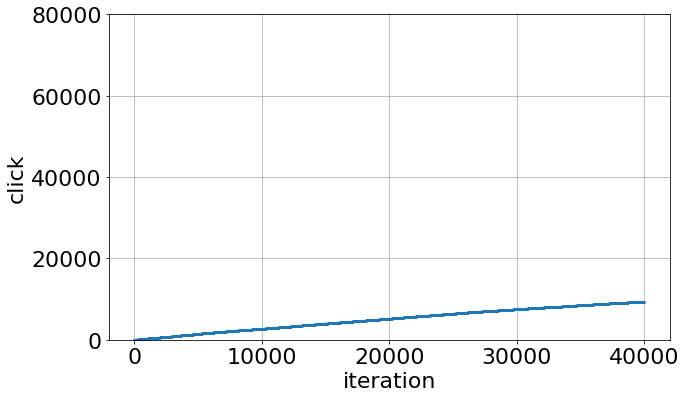

In [ ]:
itr_cumulated_click_count_mean = np.load('/content/itr_cumulated_click_count_mean_F_airbnb.npy')
itr_cumulated_click_count_std = np.load('/content/itr_cumulated_click_count_std_F_airbnb.npy')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax.plot(range(len(itr_cumulated_click_count_mean)), itr_cumulated_click_count_mean, marker='.', linewidth=1.5, markersize=1)
ax.fill_between(range(len(itr_cumulated_click_count_std)), itr_cumulated_click_count_mean-itr_cumulated_click_count_std, 
                itr_cumulated_click_count_mean+itr_cumulated_click_count_std, alpha=0.5)
ax.set_ylabel('click')
ax.set_xlabel('iteration')
ax.set_ylim(0., 80000)
ax.grid(True)
fig.patch.set_facecolor('white')
# plt.legend(loc='best')
plt.tight_layout()
plt.show()

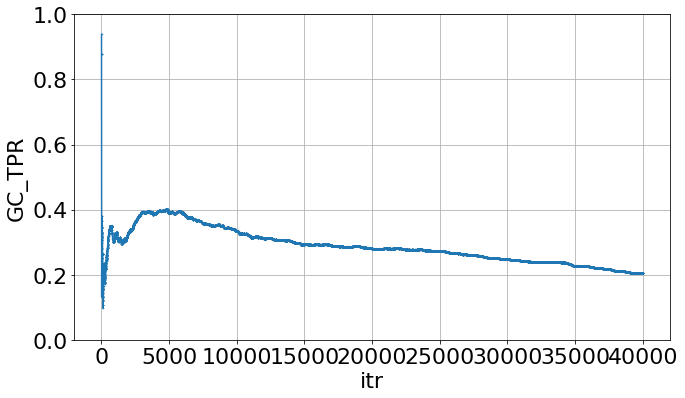

In [ ]:
itr_GC_TPR_mean = np.load('/content/itr_GC_TPR_mean_F_airbnb.npy')
itr_GC_TPR_std = np.load('./itr_GC_TPR_std_F_airbnb.npy')
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax.plot(range(len(itr_GC_TPR_mean)), itr_GC_TPR_mean, marker='.', linewidth=1.5, markersize=1)
ax.fill_between(range(len(itr_GC_TPR_mean)), itr_GC_TPR_mean-itr_GC_TPR_std, itr_GC_TPR_mean+itr_GC_TPR_std, alpha=0.5)
ax.set_ylabel('GC_TPR')
ax.set_xlabel('itr')
ax.set_ylim(0., 1)
ax.grid(True)
fig.patch.set_facecolor('white')
# plt.legend(loc='best')
plt.tight_layout()
plt.show()

#**Experiment_FPC_DScale**

**Upload Simulation_FPC_Dscale.py**

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings; warnings.simplefilter('ignore')  # Ignores Warnings for nicer Plots. Disable for Debugging
import time
import numpy as np
import argparse
import utility
from Simulation_FPC_DScale import Simulation


parser = argparse.ArgumentParser(description='Experiment_FPC_DScale')
parser.add_argument('--run', type=int, default=10, help='number of experiments to run')
parser.add_argument('--iteration', type=int, default=40000, help='number of iterations to simulate')
parser.add_argument('--exp', type=int, default=1, help='number of initial random exposure iterations')
parser.add_argument('--cycle_itr', type=int, default=50, help='number of iterations in one cycle')
parser.add_argument('--epoch', type=int, default=15, help='number of epochs to train')
parser.add_argument('--K', type=int, default=20, help='number of items to recommend')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate')
parser.add_argument('--reg', type=float, default=1e-5, help='regularization')
parser.add_argument('--hidden', type=int, default=100, help='latent dimension')
parser.add_argument('--neg', type=int, default=5, help='negative sampling rate')
parser.add_argument('--data', type=str, default='ml1m', help='path to eval in the Data folder')
parser.add_argument('--alpha', type=float, default=0.25, help='alpha')
parser.add_argument('--num_user', type=float, default=num_user, help='path to eval in the Data folder')
parser.add_argument('--num_item', type=float, default=num_item, help='path to eval in the Data folder')
parser.add_argument('-f')

args = parser.parse_args()

truth = np.load('/content/truth_airbnb.npy')
args.num_user = truth.shape[0]
args.num_item = truth.shape[1]
audience_size = np.sum(truth, axis=0)
item_sorted = np.argsort(audience_size)
truth_like = list(np.load('/content/user_truth_like_airbnb.npy', allow_pickle=True))


print('')
print('!' * 30 + ' Total truth ' + str(np.sum(truth)) + ' ' + '!' * 30)
print('')

itr_cumulated_click_count_list = []
itr_GC_TPR_list = []

for r in range(args.run):
    print('')
    print('#' * 100)
    print('#' * 100)
    print(' ' * 50 + ' Experiment run ' + str(r + 1) + ' ' * 50)
    print('#' * 100)
    print('#' * 100)
    simulation = Simulation(args, truth, truth_like)
    init_popularity = simulation.initial_iterations()
    itr_click_item = simulation.run_simulation()

    itr_cumulated_click_count = []
    itr_item_click = np.zeros((args.iteration, args.num_item))
    for itr in range(args.iteration):
        click_item = itr_click_item[itr]
        itr_item_click[itr, click_item] = 1.
        itr_cumulated_click_count.append(
            len(click_item) if itr == 0 else len(click_item) + itr_cumulated_click_count[-1])
    for itr in range(1, args.iteration):
        itr_item_click[itr, :] += itr_item_click[itr - 1, :]
    itr_item_click /= (audience_size - init_popularity).reshape((1, -1))

    itr_GC_TPR = []
    for itr in range(args.iteration):
        a = itr_item_click[itr, item_sorted]
        gc = np.sum(((np.arange(len(a)) + 1.) * 2 - len(a) - 1) * a) / (len(a) * np.sum(a))
        itr_GC_TPR.append(gc)

    itr_cumulated_click_count_list.append(itr_cumulated_click_count)
    itr_GC_TPR_list.append(itr_GC_TPR)

    itr_cumulated_click_count_mean = np.mean(itr_cumulated_click_count_list, axis=0)
    itr_cumulated_click_count_std = np.std(itr_cumulated_click_count_list, axis=0)
    itr_GC_TPR_mean = np.mean(itr_GC_TPR_list, axis=0)
    itr_GC_TPR_std = np.std(itr_GC_TPR_list, axis=0)



!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Total truth 31951.0 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


####################################################################################################
####################################################################################################
                                                   Experiment run 1                                                  
####################################################################################################
####################################################################################################
Namespace(K=20, alpha=0.25, cycle_itr=50, data='ml1m', epoch=15, exp=1, f='/root/.local/share/jupyter/runtime/kernel-fc381ba0-44ee-4a67-bf4c-ab92f3747d83.json', hidden=100, iteration=40000, lr=0.001, neg=5, num_item=1162, num_user=1000, reg=1e-05, run=10)
****************************** Start initial random iterations ******************************
---------- Iteration 1 ----------


100%|██████████| 1000/1000 [00:00<00:00, 2462.44it/s]


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Generate 193 records.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
****************************** Train MF until converge ******************************
Update bs to 23
******************************MF initialization done ******************************


100%|██████████| 50/50 [00:00<00:00, 145.94it/s]


Training // Epoch 0 //  Total cost = 34.6760  Total cost1 = 34.6566  Total cost2 = 0.0194


100%|██████████| 50/50 [00:00<00:00, 234.11it/s]


Training // Epoch 1 //  Total cost = 34.3803  Total cost1 = 34.3674  Total cost2 = 0.0129


100%|██████████| 50/50 [00:00<00:00, 205.86it/s]


Training // Epoch 2 //  Total cost = 33.9528  Total cost1 = 33.9365  Total cost2 = 0.0162


100%|██████████| 50/50 [00:00<00:00, 235.89it/s]


Training // Epoch 3 //  Total cost = 33.2936  Total cost1 = 33.2718  Total cost2 = 0.0219


100%|██████████| 50/50 [00:00<00:00, 220.38it/s]


Training // Epoch 4 //  Total cost = 32.3079  Total cost1 = 32.2781  Total cost2 = 0.0298


100%|██████████| 50/50 [00:00<00:00, 222.23it/s]


Training // Epoch 5 //  Total cost = 30.8867  Total cost1 = 30.8465  Total cost2 = 0.0402


100%|██████████| 50/50 [00:00<00:00, 218.98it/s]


Training // Epoch 6 //  Total cost = 28.9838  Total cost1 = 28.9303  Total cost2 = 0.0535


100%|██████████| 50/50 [00:00<00:00, 232.99it/s]


Training // Epoch 7 //  Total cost = 26.6555  Total cost1 = 26.5859  Total cost2 = 0.0696


100%|██████████| 50/50 [00:00<00:00, 222.39it/s]


Training // Epoch 8 //  Total cost = 23.9691  Total cost1 = 23.8812  Total cost2 = 0.0879


100%|██████████| 50/50 [00:00<00:00, 239.10it/s]


Training // Epoch 9 //  Total cost = 20.9110  Total cost1 = 20.8015  Total cost2 = 0.1094


100%|██████████| 50/50 [00:00<00:00, 195.50it/s]


Training // Epoch 10 //  Total cost = 17.3473  Total cost1 = 17.2137  Total cost2 = 0.1336


100%|██████████| 50/50 [00:00<00:00, 218.26it/s]


Training // Epoch 11 //  Total cost = 13.6373  Total cost1 = 13.4782  Total cost2 = 0.1592


100%|██████████| 50/50 [00:00<00:00, 228.29it/s]


Training // Epoch 12 //  Total cost = 9.1043  Total cost1 = 8.9173  Total cost2 = 0.1870


100%|██████████| 50/50 [00:00<00:00, 224.24it/s]


Training // Epoch 13 //  Total cost = 4.7327  Total cost1 = 4.5140  Total cost2 = 0.2187


100%|██████████| 50/50 [00:00<00:00, 239.94it/s]


Training // Epoch 14 //  Total cost = -0.2575  Total cost1 = -0.5086  Total cost2 = 0.2512
****************************** Start simulation ******************************


100%|██████████| 50/50 [00:00<00:00, 836.26it/s]


########## The iteration 50, up to now total 206 clicks, GC=0.2282, this cycle used 0.07 s) ##########
Update bs to 24


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 947.26it/s]


########## The iteration 100, up to now total 222 clicks, GC=0.0340, this cycle used 4.10 s) ##########
Update bs to 26


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


100%|██████████| 50/50 [00:00<00:00, 1186.71it/s]


########## The iteration 150, up to now total 237 clicks, GC=0.1329, this cycle used 3.37 s) ##########
Update bs to 28


100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


100%|██████████| 50/50 [00:00<00:00, 1315.29it/s]


########## The iteration 200, up to now total 248 clicks, GC=0.1611, this cycle used 3.35 s) ##########
Update bs to 29


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1383.14it/s]


########## The iteration 250, up to now total 259 clicks, GC=0.1797, this cycle used 3.35 s) ##########
Update bs to 31


100%|██████████| 15/15 [00:03<00:00,  4.67it/s]


100%|██████████| 50/50 [00:00<00:00, 1139.89it/s]


########## The iteration 300, up to now total 270 clicks, GC=0.1884, this cycle used 3.32 s) ##########
Update bs to 32


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1323.32it/s]


########## The iteration 350, up to now total 284 clicks, GC=0.2332, this cycle used 3.41 s) ##########
Update bs to 34


100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1256.07it/s]


########## The iteration 400, up to now total 293 clicks, GC=0.2529, this cycle used 3.35 s) ##########
Update bs to 35


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 860.63it/s]


########## The iteration 450, up to now total 313 clicks, GC=0.3002, this cycle used 3.38 s) ##########
Update bs to 37


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1642.25it/s]


########## The iteration 500, up to now total 322 clicks, GC=0.3208, this cycle used 3.37 s) ##########
Update bs to 38


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 1409.55it/s]


########## The iteration 550, up to now total 338 clicks, GC=0.3283, this cycle used 3.39 s) ##########
Update bs to 40


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


100%|██████████| 50/50 [00:00<00:00, 1176.66it/s]


########## The iteration 600, up to now total 349 clicks, GC=0.3085, this cycle used 3.37 s) ##########
Update bs to 41


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


100%|██████████| 50/50 [00:00<00:00, 1223.66it/s]


########## The iteration 650, up to now total 359 clicks, GC=0.2882, this cycle used 3.39 s) ##########
Update bs to 43


100%|██████████| 15/15 [00:03<00:00,  4.75it/s]


100%|██████████| 50/50 [00:00<00:00, 1567.94it/s]


########## The iteration 700, up to now total 374 clicks, GC=0.2832, this cycle used 3.27 s) ##########
Update bs to 44


100%|██████████| 15/15 [00:03<00:00,  4.66it/s]


100%|██████████| 50/50 [00:00<00:00, 1449.19it/s]


########## The iteration 750, up to now total 392 clicks, GC=0.2645, this cycle used 3.33 s) ##########
Update bs to 47


100%|██████████| 15/15 [00:03<00:00,  4.69it/s]


100%|██████████| 50/50 [00:00<00:00, 1309.37it/s]


########## The iteration 800, up to now total 404 clicks, GC=0.2655, this cycle used 3.31 s) ##########
Update bs to 48


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 1283.64it/s]


########## The iteration 850, up to now total 429 clicks, GC=0.2682, this cycle used 3.41 s) ##########
Update bs to 51


100%|██████████| 15/15 [00:03<00:00,  4.70it/s]


100%|██████████| 50/50 [00:00<00:00, 1477.27it/s]


########## The iteration 900, up to now total 443 clicks, GC=0.2694, this cycle used 3.31 s) ##########
Update bs to 53


100%|██████████| 15/15 [00:03<00:00,  4.72it/s]


100%|██████████| 50/50 [00:00<00:00, 999.79it/s]


########## The iteration 950, up to now total 455 clicks, GC=0.2785, this cycle used 3.32 s) ##########
Update bs to 54


100%|██████████| 15/15 [00:03<00:00,  4.67it/s]


100%|██████████| 50/50 [00:00<00:00, 1429.53it/s]


########## The iteration 1000, up to now total 470 clicks, GC=0.2787, this cycle used 3.34 s) ##########
Update bs to 56


100%|██████████| 15/15 [00:03<00:00,  4.73it/s]


100%|██████████| 50/50 [00:00<00:00, 1311.57it/s]


########## The iteration 1050, up to now total 486 clicks, GC=0.2905, this cycle used 3.32 s) ##########
Update bs to 58


100%|██████████| 15/15 [00:03<00:00,  4.69it/s]


100%|██████████| 50/50 [00:00<00:00, 1393.18it/s]


########## The iteration 1100, up to now total 499 clicks, GC=0.2926, this cycle used 3.32 s) ##########
Update bs to 59


100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


100%|██████████| 50/50 [00:00<00:00, 1390.18it/s]


########## The iteration 1150, up to now total 505 clicks, GC=0.2988, this cycle used 3.36 s) ##########
Update bs to 60


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 1329.18it/s]


########## The iteration 1200, up to now total 521 clicks, GC=0.3128, this cycle used 3.99 s) ##########
Update bs to 62


100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


100%|██████████| 50/50 [00:00<00:00, 1434.45it/s]


########## The iteration 1250, up to now total 535 clicks, GC=0.3115, this cycle used 3.93 s) ##########
Update bs to 64


100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1342.80it/s]


########## The iteration 1300, up to now total 547 clicks, GC=0.3121, this cycle used 3.36 s) ##########
Update bs to 65


100%|██████████| 15/15 [00:03<00:00,  4.73it/s]


100%|██████████| 50/50 [00:00<00:00, 1188.09it/s]


########## The iteration 1350, up to now total 554 clicks, GC=0.2989, this cycle used 3.31 s) ##########
Update bs to 66


100%|██████████| 15/15 [00:03<00:00,  4.73it/s]


100%|██████████| 50/50 [00:00<00:00, 1297.69it/s]


########## The iteration 1400, up to now total 570 clicks, GC=0.2940, this cycle used 3.31 s) ##########
Update bs to 68


100%|██████████| 15/15 [00:03<00:00,  4.74it/s]


100%|██████████| 50/50 [00:00<00:00, 1407.74it/s]


########## The iteration 1450, up to now total 584 clicks, GC=0.2979, this cycle used 3.30 s) ##########
Update bs to 70


100%|██████████| 15/15 [00:03<00:00,  4.71it/s]


100%|██████████| 50/50 [00:00<00:00, 1440.00it/s]


########## The iteration 1500, up to now total 603 clicks, GC=0.2971, this cycle used 3.32 s) ##########
Update bs to 72


100%|██████████| 15/15 [00:03<00:00,  4.74it/s]


100%|██████████| 50/50 [00:00<00:00, 1318.97it/s]


########## The iteration 1550, up to now total 629 clicks, GC=0.2925, this cycle used 3.29 s) ##########
Update bs to 75


100%|██████████| 15/15 [00:03<00:00,  4.74it/s]


100%|██████████| 50/50 [00:00<00:00, 1056.65it/s]


########## The iteration 1600, up to now total 637 clicks, GC=0.2984, this cycle used 3.32 s) ##########
Update bs to 76


100%|██████████| 15/15 [00:03<00:00,  4.67it/s]


100%|██████████| 50/50 [00:00<00:00, 1285.74it/s]


########## The iteration 1650, up to now total 649 clicks, GC=0.2902, this cycle used 3.36 s) ##########
Update bs to 77


100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1317.61it/s]


########## The iteration 1700, up to now total 664 clicks, GC=0.2781, this cycle used 3.38 s) ##########
Update bs to 79


100%|██████████| 15/15 [00:03<00:00,  4.72it/s]


100%|██████████| 50/50 [00:00<00:00, 1163.72it/s]


########## The iteration 1750, up to now total 669 clicks, GC=0.2802, this cycle used 3.32 s) ##########
Update bs to 80


100%|██████████| 15/15 [00:03<00:00,  4.70it/s]


100%|██████████| 50/50 [00:00<00:00, 1422.82it/s]


########## The iteration 1800, up to now total 681 clicks, GC=0.2789, this cycle used 3.36 s) ##########
Update bs to 81


100%|██████████| 15/15 [00:03<00:00,  4.68it/s]


100%|██████████| 50/50 [00:00<00:00, 1172.86it/s]


########## The iteration 1850, up to now total 691 clicks, GC=0.2757, this cycle used 3.36 s) ##########
Update bs to 82


100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1542.11it/s]


########## The iteration 1900, up to now total 700 clicks, GC=0.2812, this cycle used 3.38 s) ##########
Update bs to 84


100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1206.38it/s]


########## The iteration 1950, up to now total 717 clicks, GC=0.2736, this cycle used 3.39 s) ##########
Update bs to 86


100%|██████████| 15/15 [00:03<00:00,  4.69it/s]


100%|██████████| 50/50 [00:00<00:00, 1326.54it/s]


########## The iteration 2000, up to now total 729 clicks, GC=0.2680, this cycle used 3.34 s) ##########
Update bs to 87


100%|██████████| 15/15 [00:03<00:00,  4.71it/s]


100%|██████████| 50/50 [00:00<00:00, 1394.00it/s]


########## The iteration 2050, up to now total 740 clicks, GC=0.2741, this cycle used 3.33 s) ##########
Update bs to 88


100%|██████████| 15/15 [00:03<00:00,  4.72it/s]


100%|██████████| 50/50 [00:00<00:00, 1155.02it/s]


########## The iteration 2100, up to now total 751 clicks, GC=0.2752, this cycle used 3.33 s) ##########
Update bs to 90


100%|██████████| 15/15 [00:03<00:00,  4.70it/s]


100%|██████████| 50/50 [00:00<00:00, 1093.62it/s]


########## The iteration 2150, up to now total 764 clicks, GC=0.2796, this cycle used 3.35 s) ##########
Update bs to 91


100%|██████████| 15/15 [00:03<00:00,  4.70it/s]


100%|██████████| 50/50 [00:00<00:00, 1272.99it/s]


########## The iteration 2200, up to now total 775 clicks, GC=0.2754, this cycle used 3.36 s) ##########
Update bs to 93


100%|██████████| 15/15 [00:03<00:00,  4.44it/s]


100%|██████████| 50/50 [00:00<00:00, 1297.50it/s]


########## The iteration 2250, up to now total 788 clicks, GC=0.2760, this cycle used 3.54 s) ##########
Update bs to 94


100%|██████████| 15/15 [00:03<00:00,  4.75it/s]


100%|██████████| 50/50 [00:00<00:00, 1282.65it/s]


########## The iteration 2300, up to now total 800 clicks, GC=0.2803, this cycle used 3.32 s) ##########
Update bs to 96


100%|██████████| 15/15 [00:03<00:00,  4.74it/s]


100%|██████████| 50/50 [00:00<00:00, 1289.59it/s]


########## The iteration 2350, up to now total 816 clicks, GC=0.2871, this cycle used 3.32 s) ##########
Update bs to 97


100%|██████████| 15/15 [00:03<00:00,  4.71it/s]


100%|██████████| 50/50 [00:00<00:00, 1306.60it/s]


########## The iteration 2400, up to now total 834 clicks, GC=0.2940, this cycle used 3.34 s) ##########
Update bs to 100


100%|██████████| 15/15 [00:03<00:00,  4.74it/s]


100%|██████████| 50/50 [00:00<00:00, 983.63it/s]


########## The iteration 2450, up to now total 846 clicks, GC=0.2957, this cycle used 3.33 s) ##########
Update bs to 101


100%|██████████| 15/15 [00:03<00:00,  4.72it/s]


100%|██████████| 50/50 [00:00<00:00, 1326.30it/s]


########## The iteration 2500, up to now total 862 clicks, GC=0.3031, this cycle used 3.36 s) ##########
Update bs to 103


100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1523.16it/s]


########## The iteration 2550, up to now total 871 clicks, GC=0.3021, this cycle used 3.41 s) ##########
Update bs to 104


100%|██████████| 15/15 [00:03<00:00,  4.67it/s]


100%|██████████| 50/50 [00:00<00:00, 1340.64it/s]


########## The iteration 2600, up to now total 883 clicks, GC=0.2986, this cycle used 3.39 s) ##########
Update bs to 105


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1635.03it/s]


########## The iteration 2650, up to now total 891 clicks, GC=0.2974, this cycle used 3.40 s) ##########
Update bs to 106


100%|██████████| 15/15 [00:03<00:00,  4.68it/s]


100%|██████████| 50/50 [00:00<00:00, 1506.74it/s]


########## The iteration 2700, up to now total 910 clicks, GC=0.3043, this cycle used 3.38 s) ##########
Update bs to 109


100%|██████████| 15/15 [00:03<00:00,  4.72it/s]


100%|██████████| 50/50 [00:00<00:00, 1296.92it/s]


########## The iteration 2750, up to now total 921 clicks, GC=0.3078, this cycle used 3.35 s) ##########
Update bs to 110


100%|██████████| 15/15 [00:03<00:00,  4.68it/s]


100%|██████████| 50/50 [00:00<00:00, 1262.12it/s]


########## The iteration 2800, up to now total 938 clicks, GC=0.3109, this cycle used 3.38 s) ##########
Update bs to 112


100%|██████████| 15/15 [00:03<00:00,  4.69it/s]


100%|██████████| 50/50 [00:00<00:00, 1059.35it/s]


########## The iteration 2850, up to now total 944 clicks, GC=0.3137, this cycle used 3.38 s) ##########
Update bs to 113


100%|██████████| 15/15 [00:03<00:00,  4.67it/s]


100%|██████████| 50/50 [00:00<00:00, 1144.66it/s]


########## The iteration 2900, up to now total 959 clicks, GC=0.3110, this cycle used 3.40 s) ##########
Update bs to 115


100%|██████████| 15/15 [00:03<00:00,  4.66it/s]


100%|██████████| 50/50 [00:00<00:00, 1022.92it/s]


########## The iteration 2950, up to now total 970 clicks, GC=0.3125, this cycle used 3.40 s) ##########
Update bs to 116


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1226.25it/s]


########## The iteration 3000, up to now total 981 clicks, GC=0.3047, this cycle used 3.43 s) ##########
Update bs to 117


100%|██████████| 15/15 [00:03<00:00,  4.68it/s]


100%|██████████| 50/50 [00:00<00:00, 1217.54it/s]


########## The iteration 3050, up to now total 992 clicks, GC=0.3010, this cycle used 3.37 s) ##########
Update bs to 119


100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


100%|██████████| 50/50 [00:00<00:00, 1176.69it/s]


########## The iteration 3100, up to now total 1002 clicks, GC=0.3050, this cycle used 3.41 s) ##########
Update bs to 120


100%|██████████| 15/15 [00:03<00:00,  4.69it/s]


100%|██████████| 50/50 [00:00<00:00, 1014.89it/s]


########## The iteration 3150, up to now total 1013 clicks, GC=0.3045, this cycle used 3.39 s) ##########
Update bs to 121


100%|██████████| 15/15 [00:03<00:00,  4.70it/s]


100%|██████████| 50/50 [00:00<00:00, 1234.08it/s]


########## The iteration 3200, up to now total 1025 clicks, GC=0.3062, this cycle used 3.37 s) ##########
Update bs to 123


100%|██████████| 15/15 [00:03<00:00,  4.73it/s]


100%|██████████| 50/50 [00:00<00:00, 1213.05it/s]


########## The iteration 3250, up to now total 1041 clicks, GC=0.3024, this cycle used 3.36 s) ##########
Update bs to 124


100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


100%|██████████| 50/50 [00:00<00:00, 1208.89it/s]


########## The iteration 3300, up to now total 1050 clicks, GC=0.3053, this cycle used 3.41 s) ##########
Update bs to 126


100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1323.19it/s]


########## The iteration 3350, up to now total 1061 clicks, GC=0.3069, this cycle used 3.41 s) ##########
Update bs to 127


100%|██████████| 15/15 [00:03<00:00,  4.71it/s]


100%|██████████| 50/50 [00:00<00:00, 1375.83it/s]


########## The iteration 3400, up to now total 1074 clicks, GC=0.3042, this cycle used 3.38 s) ##########
Update bs to 128


100%|██████████| 15/15 [00:03<00:00,  4.69it/s]


100%|██████████| 50/50 [00:00<00:00, 1039.66it/s]


########## The iteration 3450, up to now total 1084 clicks, GC=0.3026, this cycle used 3.40 s) ##########
Update bs to 130


100%|██████████| 15/15 [00:03<00:00,  4.68it/s]


100%|██████████| 50/50 [00:00<00:00, 1047.33it/s]


########## The iteration 3500, up to now total 1093 clicks, GC=0.3031, this cycle used 3.40 s) ##########
Update bs to 131


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


100%|██████████| 50/50 [00:00<00:00, 1202.94it/s]


########## The iteration 3550, up to now total 1109 clicks, GC=0.2980, this cycle used 3.46 s) ##########
Update bs to 133


100%|██████████| 15/15 [00:03<00:00,  4.69it/s]


100%|██████████| 50/50 [00:00<00:00, 1007.27it/s]


########## The iteration 3600, up to now total 1119 clicks, GC=0.2971, this cycle used 3.39 s) ##########
Update bs to 134


100%|██████████| 15/15 [00:03<00:00,  4.71it/s]


100%|██████████| 50/50 [00:00<00:00, 1168.58it/s]


########## The iteration 3650, up to now total 1133 clicks, GC=0.3019, this cycle used 3.38 s) ##########
Update bs to 135


100%|██████████| 15/15 [00:03<00:00,  4.68it/s]


100%|██████████| 50/50 [00:00<00:00, 1268.54it/s]


########## The iteration 3700, up to now total 1148 clicks, GC=0.2997, this cycle used 3.39 s) ##########
Update bs to 137


100%|██████████| 15/15 [00:03<00:00,  4.70it/s]


100%|██████████| 50/50 [00:00<00:00, 1156.88it/s]


########## The iteration 3750, up to now total 1161 clicks, GC=0.3033, this cycle used 3.40 s) ##########
Update bs to 139


100%|██████████| 15/15 [00:03<00:00,  4.67it/s]


100%|██████████| 50/50 [00:00<00:00, 1235.65it/s]


########## The iteration 3800, up to now total 1169 clicks, GC=0.3055, this cycle used 3.40 s) ##########
Update bs to 140


100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


100%|██████████| 50/50 [00:00<00:00, 1426.38it/s]


########## The iteration 3850, up to now total 1181 clicks, GC=0.3072, this cycle used 3.43 s) ##########
Update bs to 141


100%|██████████| 15/15 [00:03<00:00,  4.66it/s]


100%|██████████| 50/50 [00:00<00:00, 857.69it/s]


########## The iteration 3900, up to now total 1198 clicks, GC=0.2994, this cycle used 3.43 s) ##########
Update bs to 143


100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


100%|██████████| 50/50 [00:00<00:00, 1313.89it/s]


########## The iteration 3950, up to now total 1208 clicks, GC=0.3024, this cycle used 3.43 s) ##########
Update bs to 144


100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


100%|██████████| 50/50 [00:00<00:00, 1356.97it/s]


########## The iteration 4000, up to now total 1220 clicks, GC=0.2998, this cycle used 3.44 s) ##########
Update bs to 146


100%|██████████| 15/15 [00:03<00:00,  4.69it/s]


100%|██████████| 50/50 [00:00<00:00, 1042.91it/s]


########## The iteration 4050, up to now total 1228 clicks, GC=0.2935, this cycle used 3.40 s) ##########
Update bs to 147


100%|██████████| 15/15 [00:03<00:00,  4.66it/s]


100%|██████████| 50/50 [00:00<00:00, 1116.22it/s]


########## The iteration 4100, up to now total 1239 clicks, GC=0.2888, this cycle used 3.41 s) ##########
Update bs to 148


100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1302.66it/s]


########## The iteration 4150, up to now total 1247 clicks, GC=0.2863, this cycle used 3.43 s) ##########
Update bs to 149


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


100%|██████████| 50/50 [00:00<00:00, 1178.99it/s]


########## The iteration 4200, up to now total 1260 clicks, GC=0.2896, this cycle used 3.46 s) ##########
Update bs to 151


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1204.62it/s]


########## The iteration 4250, up to now total 1269 clicks, GC=0.2893, this cycle used 3.44 s) ##########
Update bs to 152


100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


100%|██████████| 50/50 [00:00<00:00, 1282.62it/s]


########## The iteration 4300, up to now total 1285 clicks, GC=0.2893, this cycle used 3.44 s) ##########
Update bs to 154


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 873.32it/s]


########## The iteration 4350, up to now total 1293 clicks, GC=0.2905, this cycle used 3.48 s) ##########
Update bs to 155


100%|██████████| 15/15 [00:03<00:00,  4.69it/s]


100%|██████████| 50/50 [00:00<00:00, 1187.02it/s]


########## The iteration 4400, up to now total 1301 clicks, GC=0.2899, this cycle used 3.40 s) ##########
Update bs to 156


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1081.95it/s]


########## The iteration 4450, up to now total 1311 clicks, GC=0.2915, this cycle used 3.45 s) ##########
Update bs to 157


100%|██████████| 15/15 [00:03<00:00,  4.67it/s]


100%|██████████| 50/50 [00:00<00:00, 1320.28it/s]


########## The iteration 4500, up to now total 1318 clicks, GC=0.2882, this cycle used 3.42 s) ##########
Update bs to 158


100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


100%|██████████| 50/50 [00:00<00:00, 1096.34it/s]


########## The iteration 4550, up to now total 1332 clicks, GC=0.2884, this cycle used 3.46 s) ##########
Update bs to 159


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 864.92it/s]


########## The iteration 4600, up to now total 1343 clicks, GC=0.2881, this cycle used 3.46 s) ##########
Update bs to 161


100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


100%|██████████| 50/50 [00:00<00:00, 988.51it/s]


########## The iteration 4650, up to now total 1352 clicks, GC=0.2889, this cycle used 3.44 s) ##########
Update bs to 162


100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


100%|██████████| 50/50 [00:00<00:00, 1298.96it/s]


########## The iteration 4700, up to now total 1367 clicks, GC=0.2863, this cycle used 3.44 s) ##########
Update bs to 164


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 1064.07it/s]


########## The iteration 4750, up to now total 1377 clicks, GC=0.2860, this cycle used 3.48 s) ##########
Update bs to 165


100%|██████████| 15/15 [00:03<00:00,  4.68it/s]


100%|██████████| 50/50 [00:00<00:00, 978.23it/s]


########## The iteration 4800, up to now total 1393 clicks, GC=0.2812, this cycle used 3.43 s) ##########
Update bs to 167


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


100%|██████████| 50/50 [00:00<00:00, 1023.64it/s]


########## The iteration 4850, up to now total 1406 clicks, GC=0.2808, this cycle used 3.49 s) ##########
Update bs to 168


100%|██████████| 15/15 [00:03<00:00,  4.48it/s]


100%|██████████| 50/50 [00:00<00:00, 1163.97it/s]


########## The iteration 4900, up to now total 1418 clicks, GC=0.2740, this cycle used 3.57 s) ##########
Update bs to 170


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


100%|██████████| 50/50 [00:00<00:00, 1202.85it/s]


########## The iteration 4950, up to now total 1428 clicks, GC=0.2701, this cycle used 3.54 s) ##########
Update bs to 171


100%|██████████| 15/15 [00:03<00:00,  4.57it/s]


100%|██████████| 50/50 [00:00<00:00, 1262.78it/s]


########## The iteration 5000, up to now total 1440 clicks, GC=0.2725, this cycle used 3.50 s) ##########
Update bs to 172


100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1267.42it/s]


########## The iteration 5050, up to now total 1447 clicks, GC=0.2744, this cycle used 3.44 s) ##########
Update bs to 173


100%|██████████| 15/15 [00:03<00:00,  4.69it/s]


100%|██████████| 50/50 [00:00<00:00, 1152.71it/s]


########## The iteration 5100, up to now total 1459 clicks, GC=0.2736, this cycle used 3.42 s) ##########
Update bs to 175


100%|██████████| 15/15 [00:03<00:00,  4.67it/s]


100%|██████████| 50/50 [00:00<00:00, 1268.63it/s]


########## The iteration 5150, up to now total 1471 clicks, GC=0.2744, this cycle used 3.43 s) ##########
Update bs to 176


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1665.98it/s]


########## The iteration 5200, up to now total 1487 clicks, GC=0.2773, this cycle used 3.46 s) ##########
Update bs to 178


100%|██████████| 15/15 [00:03<00:00,  4.67it/s]


100%|██████████| 50/50 [00:00<00:00, 1027.74it/s]


########## The iteration 5250, up to now total 1500 clicks, GC=0.2712, this cycle used 3.44 s) ##########
Update bs to 180


100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1374.41it/s]


########## The iteration 5300, up to now total 1505 clicks, GC=0.2712, this cycle used 3.45 s) ##########
Update bs to 180


100%|██████████| 15/15 [00:03<00:00,  4.57it/s]


100%|██████████| 50/50 [00:00<00:00, 1383.12it/s]


########## The iteration 5350, up to now total 1515 clicks, GC=0.2679, this cycle used 3.50 s) ##########
Update bs to 181


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1300.24it/s]


########## The iteration 5400, up to now total 1522 clicks, GC=0.2654, this cycle used 3.48 s) ##########
Update bs to 182


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


100%|██████████| 50/50 [00:00<00:00, 892.53it/s]


########## The iteration 5450, up to now total 1535 clicks, GC=0.2654, this cycle used 3.50 s) ##########
Update bs to 184


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


100%|██████████| 50/50 [00:00<00:00, 1164.33it/s]


########## The iteration 5500, up to now total 1544 clicks, GC=0.2624, this cycle used 3.49 s) ##########
Update bs to 185


100%|██████████| 15/15 [00:03<00:00,  4.66it/s]


100%|██████████| 50/50 [00:00<00:00, 1189.12it/s]


########## The iteration 5550, up to now total 1552 clicks, GC=0.2636, this cycle used 3.44 s) ##########
Update bs to 186


100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


100%|██████████| 50/50 [00:00<00:00, 994.92it/s]


########## The iteration 5600, up to now total 1563 clicks, GC=0.2568, this cycle used 3.48 s) ##########
Update bs to 187


100%|██████████| 15/15 [00:03<00:00,  4.57it/s]


100%|██████████| 50/50 [00:00<00:00, 1087.14it/s]


########## The iteration 5650, up to now total 1567 clicks, GC=0.2533, this cycle used 3.51 s) ##########
Update bs to 188


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 1164.03it/s]


########## The iteration 5700, up to now total 1571 clicks, GC=0.2541, this cycle used 3.52 s) ##########
Update bs to 188


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 1153.54it/s]


########## The iteration 5750, up to now total 1584 clicks, GC=0.2557, this cycle used 3.53 s) ##########
Update bs to 190


100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


100%|██████████| 50/50 [00:00<00:00, 982.16it/s]


########## The iteration 5800, up to now total 1595 clicks, GC=0.2573, this cycle used 3.57 s) ##########
Update bs to 191


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 1011.20it/s]


########## The iteration 5850, up to now total 1607 clicks, GC=0.2540, this cycle used 3.51 s) ##########
Update bs to 192


100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1201.28it/s]


########## The iteration 5900, up to now total 1615 clicks, GC=0.2523, this cycle used 3.46 s) ##########
Update bs to 193


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


100%|██████████| 50/50 [00:00<00:00, 1021.49it/s]


########## The iteration 5950, up to now total 1627 clicks, GC=0.2516, this cycle used 3.48 s) ##########
Update bs to 195


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1007.59it/s]


########## The iteration 6000, up to now total 1638 clicks, GC=0.2465, this cycle used 3.48 s) ##########
Update bs to 196


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


100%|██████████| 50/50 [00:00<00:00, 1020.60it/s]


########## The iteration 6050, up to now total 1658 clicks, GC=0.2451, this cycle used 3.50 s) ##########
Update bs to 198


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


100%|██████████| 50/50 [00:00<00:00, 63.74it/s]


########## The iteration 6100, up to now total 1664 clicks, GC=0.2445, this cycle used 4.26 s) ##########
Update bs to 199


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1217.83it/s]


########## The iteration 6150, up to now total 1677 clicks, GC=0.2464, this cycle used 3.49 s) ##########
Update bs to 201


100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


100%|██████████| 50/50 [00:00<00:00, 1053.24it/s]


########## The iteration 6200, up to now total 1688 clicks, GC=0.2454, this cycle used 3.46 s) ##########
Update bs to 202


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


100%|██████████| 50/50 [00:00<00:00, 1167.11it/s]


########## The iteration 6250, up to now total 1701 clicks, GC=0.2451, this cycle used 3.51 s) ##########
Update bs to 204


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


100%|██████████| 50/50 [00:00<00:00, 1207.35it/s]


########## The iteration 6300, up to now total 1708 clicks, GC=0.2431, this cycle used 3.50 s) ##########
Update bs to 204


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1060.40it/s]


########## The iteration 6350, up to now total 1722 clicks, GC=0.2384, this cycle used 3.53 s) ##########
Update bs to 206


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 1084.99it/s]


########## The iteration 6400, up to now total 1734 clicks, GC=0.2345, this cycle used 3.55 s) ##########
Update bs to 208


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 1396.83it/s]


########## The iteration 6450, up to now total 1742 clicks, GC=0.2354, this cycle used 3.51 s) ##########
Update bs to 209


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


100%|██████████| 50/50 [00:00<00:00, 1062.96it/s]


########## The iteration 6500, up to now total 1755 clicks, GC=0.2267, this cycle used 3.52 s) ##########
Update bs to 210


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1051.73it/s]


########## The iteration 6550, up to now total 1764 clicks, GC=0.2253, this cycle used 3.56 s) ##########
Update bs to 211


100%|██████████| 15/15 [00:03<00:00,  4.57it/s]


100%|██████████| 50/50 [00:00<00:00, 958.20it/s]


########## The iteration 6600, up to now total 1769 clicks, GC=0.2262, this cycle used 3.54 s) ##########
Update bs to 212


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 868.67it/s]


########## The iteration 6650, up to now total 1779 clicks, GC=0.2242, this cycle used 3.54 s) ##########
Update bs to 213


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


100%|██████████| 50/50 [00:00<00:00, 914.75it/s]


########## The iteration 6700, up to now total 1786 clicks, GC=0.2240, this cycle used 3.52 s) ##########
Update bs to 214


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


100%|██████████| 50/50 [00:00<00:00, 997.91it/s]


########## The iteration 6750, up to now total 1798 clicks, GC=0.2177, this cycle used 3.51 s) ##########
Update bs to 215


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 835.45it/s]


########## The iteration 6800, up to now total 1809 clicks, GC=0.2195, this cycle used 3.53 s) ##########
Update bs to 217


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


100%|██████████| 50/50 [00:00<00:00, 1177.08it/s]


########## The iteration 6850, up to now total 1821 clicks, GC=0.2156, this cycle used 3.50 s) ##########
Update bs to 218


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


100%|██████████| 50/50 [00:00<00:00, 864.67it/s]


########## The iteration 6900, up to now total 1833 clicks, GC=0.2153, this cycle used 3.54 s) ##########
Update bs to 219


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


100%|██████████| 50/50 [00:00<00:00, 1101.76it/s]


########## The iteration 6950, up to now total 1842 clicks, GC=0.2151, this cycle used 3.58 s) ##########
Update bs to 221


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 1234.24it/s]


########## The iteration 7000, up to now total 1856 clicks, GC=0.2166, this cycle used 3.55 s) ##########
Update bs to 222


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


100%|██████████| 50/50 [00:00<00:00, 895.59it/s]


########## The iteration 7050, up to now total 1867 clicks, GC=0.2150, this cycle used 3.60 s) ##########
Update bs to 224


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 961.27it/s]


########## The iteration 7100, up to now total 1872 clicks, GC=0.2122, this cycle used 3.55 s) ##########
Update bs to 224


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 979.46it/s]


########## The iteration 7150, up to now total 1883 clicks, GC=0.2121, this cycle used 3.56 s) ##########
Update bs to 225


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


100%|██████████| 50/50 [00:00<00:00, 896.25it/s]


########## The iteration 7200, up to now total 1891 clicks, GC=0.2072, this cycle used 3.60 s) ##########
Update bs to 226


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 817.02it/s]


########## The iteration 7250, up to now total 1901 clicks, GC=0.2060, this cycle used 3.57 s) ##########
Update bs to 228


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 1002.02it/s]


########## The iteration 7300, up to now total 1915 clicks, GC=0.2018, this cycle used 3.54 s) ##########
Update bs to 229


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


100%|██████████| 50/50 [00:00<00:00, 975.67it/s]


########## The iteration 7350, up to now total 1926 clicks, GC=0.2004, this cycle used 3.55 s) ##########
Update bs to 231


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 966.24it/s]


########## The iteration 7400, up to now total 1940 clicks, GC=0.1973, this cycle used 3.55 s) ##########
Update bs to 232


100%|██████████| 15/15 [00:03<00:00,  4.51it/s]


100%|██████████| 50/50 [00:00<00:00, 863.48it/s]


########## The iteration 7450, up to now total 1947 clicks, GC=0.1963, this cycle used 3.60 s) ##########
Update bs to 233


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 1060.84it/s]


########## The iteration 7500, up to now total 1959 clicks, GC=0.1932, this cycle used 3.52 s) ##########
Update bs to 235


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 981.78it/s]


########## The iteration 7550, up to now total 1962 clicks, GC=0.1930, this cycle used 3.55 s) ##########
Update bs to 235


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 941.39it/s]


########## The iteration 7600, up to now total 1971 clicks, GC=0.1928, this cycle used 3.53 s) ##########
Update bs to 236


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 908.72it/s]


########## The iteration 7650, up to now total 1980 clicks, GC=0.1883, this cycle used 3.57 s) ##########
Update bs to 237


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


100%|██████████| 50/50 [00:00<00:00, 967.93it/s]


########## The iteration 7700, up to now total 1989 clicks, GC=0.1886, this cycle used 3.56 s) ##########
Update bs to 238


100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


100%|██████████| 50/50 [00:00<00:00, 1035.40it/s]


########## The iteration 7750, up to now total 1995 clicks, GC=0.1894, this cycle used 3.60 s) ##########
Update bs to 239


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


100%|██████████| 50/50 [00:00<00:00, 967.77it/s]


########## The iteration 7800, up to now total 2006 clicks, GC=0.1892, this cycle used 3.55 s) ##########
Update bs to 240


100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


100%|██████████| 50/50 [00:00<00:00, 934.17it/s]


########## The iteration 7850, up to now total 2014 clicks, GC=0.1884, this cycle used 3.52 s) ##########
Update bs to 241


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 1150.47it/s]


########## The iteration 7900, up to now total 2022 clicks, GC=0.1878, this cycle used 3.54 s) ##########
Update bs to 242


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 865.52it/s]


########## The iteration 7950, up to now total 2031 clicks, GC=0.1846, this cycle used 3.54 s) ##########
Update bs to 243


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 873.26it/s]


########## The iteration 8000, up to now total 2039 clicks, GC=0.1838, this cycle used 3.58 s) ##########
Update bs to 244


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


100%|██████████| 50/50 [00:00<00:00, 814.41it/s]


########## The iteration 8050, up to now total 2059 clicks, GC=0.1818, this cycle used 3.58 s) ##########
Update bs to 247


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 872.87it/s]


########## The iteration 8100, up to now total 2069 clicks, GC=0.1836, this cycle used 3.57 s) ##########
Update bs to 248


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 821.17it/s]


########## The iteration 8150, up to now total 2079 clicks, GC=0.1836, this cycle used 3.58 s) ##########
Update bs to 249


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1010.49it/s]


########## The iteration 8200, up to now total 2084 clicks, GC=0.1833, this cycle used 3.55 s) ##########
Update bs to 250


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 935.62it/s]


########## The iteration 8250, up to now total 2093 clicks, GC=0.1822, this cycle used 3.58 s) ##########
Update bs to 251


100%|██████████| 15/15 [00:03<00:00,  4.47it/s]


100%|██████████| 50/50 [00:00<00:00, 967.91it/s]


########## The iteration 8300, up to now total 2098 clicks, GC=0.1818, this cycle used 3.62 s) ##########
Update bs to 251


100%|██████████| 15/15 [00:03<00:00,  4.44it/s]


100%|██████████| 50/50 [00:00<00:00, 656.96it/s]


########## The iteration 8350, up to now total 2112 clicks, GC=0.1823, this cycle used 3.67 s) ##########
Update bs to 253


100%|██████████| 15/15 [00:03<00:00,  4.47it/s]


100%|██████████| 50/50 [00:00<00:00, 900.66it/s]


########## The iteration 8400, up to now total 2126 clicks, GC=0.1763, this cycle used 3.63 s) ##########
Update bs to 255


100%|██████████| 15/15 [00:03<00:00,  4.48it/s]


100%|██████████| 50/50 [00:00<00:00, 1000.35it/s]


########## The iteration 8450, up to now total 2138 clicks, GC=0.1760, this cycle used 3.62 s) ##########
Update bs to 256


100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


100%|██████████| 50/50 [00:00<00:00, 861.70it/s]


########## The iteration 8500, up to now total 2149 clicks, GC=0.1753, this cycle used 3.65 s) ##########
Update bs to 257


100%|██████████| 15/15 [00:03<00:00,  4.44it/s]


100%|██████████| 50/50 [00:00<00:00, 892.06it/s]


########## The iteration 8550, up to now total 2162 clicks, GC=0.1726, this cycle used 3.65 s) ##########
Update bs to 259


100%|██████████| 15/15 [00:03<00:00,  4.48it/s]


100%|██████████| 50/50 [00:00<00:00, 974.74it/s]


########## The iteration 8600, up to now total 2171 clicks, GC=0.1724, this cycle used 3.61 s) ##########
Update bs to 260


100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


100%|██████████| 50/50 [00:00<00:00, 984.81it/s]


########## The iteration 8650, up to now total 2178 clicks, GC=0.1699, this cycle used 3.62 s) ##########
Update bs to 261


100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


100%|██████████| 50/50 [00:00<00:00, 951.15it/s]


########## The iteration 8700, up to now total 2188 clicks, GC=0.1701, this cycle used 3.64 s) ##########
Update bs to 262


100%|██████████| 15/15 [00:03<00:00,  4.42it/s]


100%|██████████| 50/50 [00:00<00:00, 768.55it/s]


########## The iteration 8750, up to now total 2195 clicks, GC=0.1702, this cycle used 3.70 s) ##########
Update bs to 263


100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


100%|██████████| 50/50 [00:00<00:00, 823.62it/s]


########## The iteration 8800, up to now total 2200 clicks, GC=0.1708, this cycle used 3.67 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


100%|██████████| 50/50 [00:00<00:00, 847.12it/s]


########## The iteration 8850, up to now total 2211 clicks, GC=0.1654, this cycle used 3.65 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 884.37it/s]


########## The iteration 8900, up to now total 2220 clicks, GC=0.1655, this cycle used 3.71 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.46it/s]


100%|██████████| 50/50 [00:00<00:00, 867.92it/s]


########## The iteration 8950, up to now total 2228 clicks, GC=0.1654, this cycle used 3.64 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


100%|██████████| 50/50 [00:00<00:00, 821.26it/s]


########## The iteration 9000, up to now total 2237 clicks, GC=0.1620, this cycle used 3.70 s) ##########
Update bs to 268


100%|██████████| 15/15 [00:03<00:00,  4.47it/s]


100%|██████████| 50/50 [00:00<00:00, 957.25it/s]


########## The iteration 9050, up to now total 2240 clicks, GC=0.1618, this cycle used 3.63 s) ##########
Update bs to 268


100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


100%|██████████| 50/50 [00:00<00:00, 762.11it/s]


########## The iteration 9100, up to now total 2249 clicks, GC=0.1584, this cycle used 3.70 s) ##########
Update bs to 269


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 930.08it/s]


########## The iteration 9150, up to now total 2259 clicks, GC=0.1541, this cycle used 3.83 s) ##########
Update bs to 271


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 826.91it/s]


########## The iteration 9200, up to now total 2266 clicks, GC=0.1550, this cycle used 3.72 s) ##########
Update bs to 271


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 941.17it/s]


########## The iteration 9250, up to now total 2274 clicks, GC=0.1554, this cycle used 3.75 s) ##########
Update bs to 272


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


100%|██████████| 50/50 [00:00<00:00, 825.34it/s]


########## The iteration 9300, up to now total 2283 clicks, GC=0.1528, this cycle used 3.77 s) ##########
Update bs to 273


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


100%|██████████| 50/50 [00:00<00:00, 830.06it/s]


########## The iteration 9350, up to now total 2292 clicks, GC=0.1527, this cycle used 3.71 s) ##########
Update bs to 275


100%|██████████| 15/15 [00:03<00:00,  4.47it/s]


100%|██████████| 50/50 [00:00<00:00, 915.53it/s]


########## The iteration 9400, up to now total 2299 clicks, GC=0.1516, this cycle used 3.66 s) ##########
Update bs to 275


100%|██████████| 15/15 [00:03<00:00,  4.39it/s]


100%|██████████| 50/50 [00:00<00:00, 916.09it/s]


########## The iteration 9450, up to now total 2310 clicks, GC=0.1513, this cycle used 3.70 s) ##########
Update bs to 277


100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


100%|██████████| 50/50 [00:00<00:00, 913.93it/s]


########## The iteration 9500, up to now total 2313 clicks, GC=0.1508, this cycle used 3.72 s) ##########
Update bs to 277


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 810.96it/s]


########## The iteration 9550, up to now total 2316 clicks, GC=0.1504, this cycle used 3.71 s) ##########
Update bs to 277


100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


100%|██████████| 50/50 [00:00<00:00, 839.43it/s]


########## The iteration 9600, up to now total 2327 clicks, GC=0.1494, this cycle used 3.66 s) ##########
Update bs to 279


100%|██████████| 15/15 [00:03<00:00,  4.44it/s]


100%|██████████| 50/50 [00:00<00:00, 960.43it/s]


########## The iteration 9650, up to now total 2332 clicks, GC=0.1496, this cycle used 3.67 s) ##########
Update bs to 279


100%|██████████| 15/15 [00:03<00:00,  4.44it/s]


100%|██████████| 50/50 [00:00<00:00, 688.64it/s]


########## The iteration 9700, up to now total 2338 clicks, GC=0.1491, this cycle used 3.71 s) ##########
Update bs to 280


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


100%|██████████| 50/50 [00:00<00:00, 798.66it/s]


########## The iteration 9750, up to now total 2348 clicks, GC=0.1490, this cycle used 3.62 s) ##########
Update bs to 281


100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


100%|██████████| 50/50 [00:00<00:00, 874.87it/s]


########## The iteration 9800, up to now total 2357 clicks, GC=0.1483, this cycle used 3.69 s) ##########
Update bs to 282


100%|██████████| 15/15 [00:03<00:00,  4.44it/s]


100%|██████████| 50/50 [00:00<00:00, 864.38it/s]


########## The iteration 9850, up to now total 2366 clicks, GC=0.1475, this cycle used 3.69 s) ##########
Update bs to 283


100%|██████████| 15/15 [00:03<00:00,  4.42it/s]


100%|██████████| 50/50 [00:00<00:00, 1025.62it/s]


########## The iteration 9900, up to now total 2381 clicks, GC=0.1383, this cycle used 3.70 s) ##########
Update bs to 285


100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


100%|██████████| 50/50 [00:00<00:00, 1137.68it/s]


########## The iteration 9950, up to now total 2389 clicks, GC=0.1362, this cycle used 3.73 s) ##########
Update bs to 286


100%|██████████| 15/15 [00:03<00:00,  4.44it/s]


100%|██████████| 50/50 [00:00<00:00, 1028.22it/s]


########## The iteration 10000, up to now total 2395 clicks, GC=0.1358, this cycle used 3.67 s) ##########
Update bs to 287


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


100%|██████████| 50/50 [00:00<00:00, 835.13it/s]


########## The iteration 10050, up to now total 2404 clicks, GC=0.1324, this cycle used 3.72 s) ##########
Update bs to 288


100%|██████████| 15/15 [00:03<00:00,  4.44it/s]


100%|██████████| 50/50 [00:00<00:00, 1035.71it/s]


########## The iteration 10100, up to now total 2419 clicks, GC=0.1281, this cycle used 3.69 s) ##########
Update bs to 290


100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


100%|██████████| 50/50 [00:00<00:00, 1083.40it/s]


########## The iteration 10150, up to now total 2430 clicks, GC=0.1280, this cycle used 3.71 s) ##########
Update bs to 291


100%|██████████| 15/15 [00:03<00:00,  4.42it/s]


100%|██████████| 50/50 [00:00<00:00, 854.56it/s]


########## The iteration 10200, up to now total 2435 clicks, GC=0.1284, this cycle used 3.69 s) ##########
Update bs to 292


100%|██████████| 15/15 [00:03<00:00,  4.43it/s]


100%|██████████| 50/50 [00:00<00:00, 998.65it/s]


########## The iteration 10250, up to now total 2444 clicks, GC=0.1263, this cycle used 3.68 s) ##########
Update bs to 293


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 824.58it/s]


########## The iteration 10300, up to now total 2449 clicks, GC=0.1255, this cycle used 3.75 s) ##########
Update bs to 293


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 839.29it/s]


########## The iteration 10350, up to now total 2460 clicks, GC=0.1211, this cycle used 3.74 s) ##########
Update bs to 295


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


100%|██████████| 50/50 [00:00<00:00, 1068.29it/s]


########## The iteration 10400, up to now total 2470 clicks, GC=0.1195, this cycle used 3.72 s) ##########
Update bs to 296


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 823.22it/s]


########## The iteration 10450, up to now total 2483 clicks, GC=0.1198, this cycle used 3.75 s) ##########
Update bs to 297


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


100%|██████████| 50/50 [00:00<00:00, 703.64it/s]


########## The iteration 10500, up to now total 2494 clicks, GC=0.1168, this cycle used 3.73 s) ##########
Update bs to 299


100%|██████████| 15/15 [00:03<00:00,  4.39it/s]


100%|██████████| 50/50 [00:00<00:00, 1070.08it/s]


########## The iteration 10550, up to now total 2503 clicks, GC=0.1176, this cycle used 3.72 s) ##########
Update bs to 300


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 849.66it/s]


########## The iteration 10600, up to now total 2507 clicks, GC=0.1175, this cycle used 3.76 s) ##########
Update bs to 300


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 726.56it/s]


########## The iteration 10650, up to now total 2512 clicks, GC=0.1146, this cycle used 3.79 s) ##########
Update bs to 301


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 826.39it/s]


########## The iteration 10700, up to now total 2522 clicks, GC=0.1157, this cycle used 3.78 s) ##########
Update bs to 302


100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


100%|██████████| 50/50 [00:00<00:00, 931.69it/s]


########## The iteration 10750, up to now total 2533 clicks, GC=0.1130, this cycle used 3.72 s) ##########
Update bs to 303


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


100%|██████████| 50/50 [00:00<00:00, 756.64it/s]


########## The iteration 10800, up to now total 2540 clicks, GC=0.1125, this cycle used 3.73 s) ##########
Update bs to 304


100%|██████████| 15/15 [00:03<00:00,  4.39it/s]


100%|██████████| 50/50 [00:00<00:00, 840.72it/s]


########## The iteration 10850, up to now total 2551 clicks, GC=0.1107, this cycle used 3.74 s) ##########
Update bs to 306


100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


100%|██████████| 50/50 [00:00<00:00, 837.92it/s]


########## The iteration 10900, up to now total 2557 clicks, GC=0.1104, this cycle used 3.71 s) ##########
Update bs to 306


100%|██████████| 15/15 [00:03<00:00,  4.47it/s]


100%|██████████| 50/50 [00:00<00:00, 936.29it/s]


########## The iteration 10950, up to now total 2574 clicks, GC=0.1086, this cycle used 3.69 s) ##########
Update bs to 308


100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


100%|██████████| 50/50 [00:00<00:00, 830.59it/s]


########## The iteration 11000, up to now total 2581 clicks, GC=0.1090, this cycle used 3.69 s) ##########
Update bs to 309


100%|██████████| 15/15 [00:03<00:00,  4.46it/s]


100%|██████████| 50/50 [00:00<00:00, 882.36it/s]


########## The iteration 11050, up to now total 2588 clicks, GC=0.1070, this cycle used 3.69 s) ##########
Update bs to 310


100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


100%|██████████| 50/50 [00:00<00:00, 1099.37it/s]


########## The iteration 11100, up to now total 2594 clicks, GC=0.1074, this cycle used 3.68 s) ##########
Update bs to 311


100%|██████████| 15/15 [00:03<00:00,  4.43it/s]


100%|██████████| 50/50 [00:00<00:00, 902.60it/s]


########## The iteration 11150, up to now total 2601 clicks, GC=0.1085, this cycle used 3.70 s) ##########
Update bs to 312


100%|██████████| 15/15 [00:03<00:00,  4.44it/s]


100%|██████████| 50/50 [00:00<00:00, 832.11it/s]


########## The iteration 11200, up to now total 2606 clicks, GC=0.1068, this cycle used 3.71 s) ##########
Update bs to 312


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 932.04it/s]


########## The iteration 11250, up to now total 2613 clicks, GC=0.1054, this cycle used 3.78 s) ##########
Update bs to 313


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 770.92it/s]


########## The iteration 11300, up to now total 2618 clicks, GC=0.1055, this cycle used 3.78 s) ##########
Update bs to 314


100%|██████████| 15/15 [00:03<00:00,  4.42it/s]


100%|██████████| 50/50 [00:00<00:00, 919.56it/s]


########## The iteration 11350, up to now total 2626 clicks, GC=0.1049, this cycle used 3.71 s) ##########
Update bs to 315


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


100%|██████████| 50/50 [00:00<00:00, 830.05it/s]


########## The iteration 11400, up to now total 2632 clicks, GC=0.1036, this cycle used 3.74 s) ##########
Update bs to 315


100%|██████████| 15/15 [00:03<00:00,  4.43it/s]


100%|██████████| 50/50 [00:00<00:00, 882.08it/s]


########## The iteration 11450, up to now total 2639 clicks, GC=0.1025, this cycle used 3.71 s) ##########
Update bs to 316


100%|██████████| 15/15 [00:03<00:00,  4.42it/s]


100%|██████████| 50/50 [00:00<00:00, 880.51it/s]


########## The iteration 11500, up to now total 2643 clicks, GC=0.1025, this cycle used 3.72 s) ##########
Update bs to 317


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 917.55it/s]


########## The iteration 11550, up to now total 2652 clicks, GC=0.1026, this cycle used 3.74 s) ##########
Update bs to 318


100%|██████████| 15/15 [00:03<00:00,  4.46it/s]


100%|██████████| 50/50 [00:00<00:00, 710.79it/s]


########## The iteration 11600, up to now total 2663 clicks, GC=0.1020, this cycle used 3.71 s) ##########
Update bs to 319


100%|██████████| 15/15 [00:03<00:00,  4.39it/s]


100%|██████████| 50/50 [00:00<00:00, 862.61it/s]


########## The iteration 11650, up to now total 2669 clicks, GC=0.0989, this cycle used 3.75 s) ##########
Update bs to 320


100%|██████████| 15/15 [00:03<00:00,  4.43it/s]


100%|██████████| 50/50 [00:00<00:00, 834.69it/s]


########## The iteration 11700, up to now total 2681 clicks, GC=0.0986, this cycle used 3.73 s) ##########
Update bs to 321


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


100%|██████████| 50/50 [00:00<00:00, 837.88it/s]


########## The iteration 11750, up to now total 2687 clicks, GC=0.0993, this cycle used 3.75 s) ##########
Update bs to 322


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


100%|██████████| 50/50 [00:00<00:00, 803.16it/s]


########## The iteration 11800, up to now total 2693 clicks, GC=0.0972, this cycle used 3.80 s) ##########
Update bs to 323


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 878.39it/s]


########## The iteration 11850, up to now total 2699 clicks, GC=0.0964, this cycle used 3.75 s) ##########
Update bs to 323


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 1007.64it/s]


########## The iteration 11900, up to now total 2712 clicks, GC=0.0943, this cycle used 3.75 s) ##########
Update bs to 325


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


100%|██████████| 50/50 [00:00<00:00, 932.79it/s]


########## The iteration 11950, up to now total 2719 clicks, GC=0.0910, this cycle used 3.73 s) ##########
Update bs to 326


100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


100%|██████████| 50/50 [00:00<00:00, 951.21it/s]


########## The iteration 12000, up to now total 2728 clicks, GC=0.0897, this cycle used 3.74 s) ##########
Update bs to 327


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 800.49it/s]


########## The iteration 12050, up to now total 2739 clicks, GC=0.0894, this cycle used 3.78 s) ##########
Update bs to 328


100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


100%|██████████| 50/50 [00:00<00:00, 757.63it/s]


########## The iteration 12100, up to now total 2745 clicks, GC=0.0889, this cycle used 3.74 s) ##########
Update bs to 329


100%|██████████| 15/15 [00:03<00:00,  4.43it/s]


100%|██████████| 50/50 [00:00<00:00, 922.90it/s]


########## The iteration 12150, up to now total 2757 clicks, GC=0.0889, this cycle used 3.73 s) ##########
Update bs to 330


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 972.51it/s]


########## The iteration 12200, up to now total 2763 clicks, GC=0.0873, this cycle used 3.77 s) ##########
Update bs to 331


100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


100%|██████████| 50/50 [00:00<00:00, 802.50it/s]


########## The iteration 12250, up to now total 2778 clicks, GC=0.0866, this cycle used 3.70 s) ##########
Update bs to 333


100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


100%|██████████| 50/50 [00:00<00:00, 825.61it/s]


########## The iteration 12300, up to now total 2786 clicks, GC=0.0867, this cycle used 3.74 s) ##########
Update bs to 334


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 789.67it/s]


########## The iteration 12350, up to now total 2799 clicks, GC=0.0839, this cycle used 3.80 s) ##########
Update bs to 335


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 700.36it/s]


########## The iteration 12400, up to now total 2805 clicks, GC=0.0842, this cycle used 3.94 s) ##########
Update bs to 336


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 716.68it/s]


########## The iteration 12450, up to now total 2813 clicks, GC=0.0840, this cycle used 3.77 s) ##########
Update bs to 337


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 917.80it/s]


########## The iteration 12500, up to now total 2817 clicks, GC=0.0826, this cycle used 3.78 s) ##########
Update bs to 338


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


100%|██████████| 50/50 [00:00<00:00, 794.47it/s]


########## The iteration 12550, up to now total 2823 clicks, GC=0.0806, this cycle used 3.80 s) ##########
Update bs to 338


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


100%|██████████| 50/50 [00:00<00:00, 788.15it/s]


########## The iteration 12600, up to now total 2834 clicks, GC=0.0796, this cycle used 3.75 s) ##########
Update bs to 340


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 929.90it/s]


########## The iteration 12650, up to now total 2841 clicks, GC=0.0782, this cycle used 3.78 s) ##########
Update bs to 340


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 939.69it/s]


########## The iteration 12700, up to now total 2852 clicks, GC=0.0774, this cycle used 3.79 s) ##########
Update bs to 342


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 867.72it/s]


########## The iteration 12750, up to now total 2860 clicks, GC=0.0755, this cycle used 3.78 s) ##########
Update bs to 343


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 962.12it/s]


########## The iteration 12800, up to now total 2870 clicks, GC=0.0738, this cycle used 3.80 s) ##########
Update bs to 344


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 805.97it/s]


########## The iteration 12850, up to now total 2877 clicks, GC=0.0743, this cycle used 3.86 s) ##########
Update bs to 345


100%|██████████| 15/15 [00:03<00:00,  4.39it/s]


100%|██████████| 50/50 [00:00<00:00, 653.47it/s]


########## The iteration 12900, up to now total 2882 clicks, GC=0.0730, this cycle used 3.79 s) ##########
Update bs to 345


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 697.54it/s]


########## The iteration 12950, up to now total 2888 clicks, GC=0.0727, this cycle used 3.86 s) ##########
Update bs to 346


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 770.36it/s]


########## The iteration 13000, up to now total 2893 clicks, GC=0.0722, this cycle used 3.78 s) ##########
Update bs to 347


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 1021.15it/s]


########## The iteration 13050, up to now total 2898 clicks, GC=0.0715, this cycle used 3.84 s) ##########
Update bs to 347


100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


100%|██████████| 50/50 [00:00<00:00, 844.86it/s]


########## The iteration 13100, up to now total 2908 clicks, GC=0.0718, this cycle used 3.78 s) ##########
Update bs to 348


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 845.82it/s]


########## The iteration 13150, up to now total 2914 clicks, GC=0.0699, this cycle used 3.82 s) ##########
Update bs to 349


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 903.53it/s]


########## The iteration 13200, up to now total 2919 clicks, GC=0.0694, this cycle used 3.84 s) ##########
Update bs to 350


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 777.97it/s]


########## The iteration 13250, up to now total 2925 clicks, GC=0.0686, this cycle used 3.86 s) ##########
Update bs to 351


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 829.01it/s]


########## The iteration 13300, up to now total 2932 clicks, GC=0.0672, this cycle used 3.81 s) ##########
Update bs to 351


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 744.28it/s]


########## The iteration 13350, up to now total 2942 clicks, GC=0.0627, this cycle used 3.81 s) ##########
Update bs to 353


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 845.56it/s]


########## The iteration 13400, up to now total 2949 clicks, GC=0.0631, this cycle used 3.91 s) ##########
Update bs to 353


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 803.56it/s]


########## The iteration 13450, up to now total 2957 clicks, GC=0.0612, this cycle used 3.86 s) ##########
Update bs to 354


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 790.16it/s]


########## The iteration 13500, up to now total 2970 clicks, GC=0.0607, this cycle used 3.82 s) ##########
Update bs to 356


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 847.20it/s]


########## The iteration 13550, up to now total 2987 clicks, GC=0.0563, this cycle used 3.78 s) ##########
Update bs to 358


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 792.45it/s]


########## The iteration 13600, up to now total 2997 clicks, GC=0.0522, this cycle used 3.88 s) ##########
Update bs to 359


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 1101.53it/s]


########## The iteration 13650, up to now total 3008 clicks, GC=0.0496, this cycle used 3.86 s) ##########
Update bs to 360


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 935.88it/s]


########## The iteration 13700, up to now total 3016 clicks, GC=0.0486, this cycle used 3.84 s) ##########
Update bs to 361


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 866.55it/s]


########## The iteration 13750, up to now total 3021 clicks, GC=0.0484, this cycle used 3.84 s) ##########
Update bs to 362


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 751.03it/s]


########## The iteration 13800, up to now total 3024 clicks, GC=0.0488, this cycle used 3.94 s) ##########
Update bs to 362


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 827.04it/s]


########## The iteration 13850, up to now total 3030 clicks, GC=0.0468, this cycle used 3.88 s) ##########
Update bs to 363


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 748.16it/s]


########## The iteration 13900, up to now total 3036 clicks, GC=0.0446, this cycle used 3.93 s) ##########
Update bs to 364


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 897.66it/s]


########## The iteration 13950, up to now total 3044 clicks, GC=0.0445, this cycle used 3.86 s) ##########
Update bs to 365


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 790.42it/s]


########## The iteration 14000, up to now total 3046 clicks, GC=0.0435, this cycle used 3.87 s) ##########
Update bs to 365


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 719.01it/s]


########## The iteration 14050, up to now total 3053 clicks, GC=0.0397, this cycle used 3.87 s) ##########
Update bs to 366


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 755.47it/s]


########## The iteration 14100, up to now total 3065 clicks, GC=0.0382, this cycle used 3.90 s) ##########
Update bs to 367


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 742.37it/s]


########## The iteration 14150, up to now total 3078 clicks, GC=0.0334, this cycle used 3.90 s) ##########
Update bs to 369


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


100%|██████████| 50/50 [00:00<00:00, 682.71it/s]


########## The iteration 14200, up to now total 3085 clicks, GC=0.0330, this cycle used 3.85 s) ##########
Update bs to 370


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 702.90it/s]


########## The iteration 14250, up to now total 3093 clicks, GC=0.0313, this cycle used 3.88 s) ##########
Update bs to 371


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 940.81it/s]


########## The iteration 14300, up to now total 3096 clicks, GC=0.0316, this cycle used 3.85 s) ##########
Update bs to 371


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 827.76it/s]


########## The iteration 14350, up to now total 3102 clicks, GC=0.0304, this cycle used 3.89 s) ##########
Update bs to 372


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 838.03it/s]


########## The iteration 14400, up to now total 3114 clicks, GC=0.0284, this cycle used 3.82 s) ##########
Update bs to 373


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 764.01it/s]


########## The iteration 14450, up to now total 3128 clicks, GC=0.0247, this cycle used 3.86 s) ##########
Update bs to 375


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 777.02it/s]


########## The iteration 14500, up to now total 3135 clicks, GC=0.0231, this cycle used 3.89 s) ##########
Update bs to 376


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 901.11it/s]


########## The iteration 14550, up to now total 3139 clicks, GC=0.0226, this cycle used 3.86 s) ##########
Update bs to 376


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 695.53it/s]


########## The iteration 14600, up to now total 3143 clicks, GC=0.0227, this cycle used 3.91 s) ##########
Update bs to 377


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 777.66it/s]


########## The iteration 14650, up to now total 3149 clicks, GC=0.0222, this cycle used 3.90 s) ##########
Update bs to 377


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 826.23it/s]


########## The iteration 14700, up to now total 3158 clicks, GC=0.0193, this cycle used 3.89 s) ##########
Update bs to 378


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 595.69it/s]


########## The iteration 14750, up to now total 3164 clicks, GC=0.0191, this cycle used 3.88 s) ##########
Update bs to 379


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 793.77it/s]


########## The iteration 14800, up to now total 3175 clicks, GC=0.0184, this cycle used 3.88 s) ##########
Update bs to 381


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 664.02it/s]


########## The iteration 14850, up to now total 3181 clicks, GC=0.0181, this cycle used 3.90 s) ##########
Update bs to 381


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 868.66it/s]


########## The iteration 14900, up to now total 3192 clicks, GC=0.0174, this cycle used 3.92 s) ##########
Update bs to 383


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 690.80it/s]


########## The iteration 14950, up to now total 3201 clicks, GC=0.0143, this cycle used 3.92 s) ##########
Update bs to 384


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 857.06it/s]


########## The iteration 15000, up to now total 3208 clicks, GC=0.0142, this cycle used 3.87 s) ##########
Update bs to 384


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 703.64it/s]


########## The iteration 15050, up to now total 3214 clicks, GC=0.0116, this cycle used 3.97 s) ##########
Update bs to 385


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 734.60it/s]


########## The iteration 15100, up to now total 3218 clicks, GC=0.0110, this cycle used 3.88 s) ##########
Update bs to 386


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 736.58it/s]


########## The iteration 15150, up to now total 3230 clicks, GC=0.0088, this cycle used 3.92 s) ##########
Update bs to 387


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 853.36it/s]


########## The iteration 15200, up to now total 3237 clicks, GC=0.0072, this cycle used 3.88 s) ##########
Update bs to 388


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 801.47it/s]


########## The iteration 15250, up to now total 3243 clicks, GC=0.0064, this cycle used 3.94 s) ##########
Update bs to 389


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 652.18it/s]


########## The iteration 15300, up to now total 3252 clicks, GC=0.0039, this cycle used 3.94 s) ##########
Update bs to 390


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 747.69it/s]


########## The iteration 15350, up to now total 3259 clicks, GC=0.0016, this cycle used 3.92 s) ##########
Update bs to 391


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 742.11it/s]


########## The iteration 15400, up to now total 3266 clicks, GC=-0.0003, this cycle used 3.89 s) ##########
Update bs to 391


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 794.23it/s]


########## The iteration 15450, up to now total 3277 clicks, GC=-0.0013, this cycle used 3.96 s) ##########
Update bs to 393


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 761.06it/s]


########## The iteration 15500, up to now total 3288 clicks, GC=-0.0026, this cycle used 3.90 s) ##########
Update bs to 394


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 752.69it/s]


########## The iteration 15550, up to now total 3295 clicks, GC=-0.0030, this cycle used 4.05 s) ##########
Update bs to 395


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 762.27it/s]


########## The iteration 15600, up to now total 3299 clicks, GC=-0.0042, this cycle used 3.89 s) ##########
Update bs to 395


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 727.35it/s]


########## The iteration 15650, up to now total 3305 clicks, GC=-0.0051, this cycle used 3.90 s) ##########
Update bs to 396


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 637.10it/s]


########## The iteration 15700, up to now total 3309 clicks, GC=-0.0053, this cycle used 3.91 s) ##########
Update bs to 397


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 639.56it/s]


########## The iteration 15750, up to now total 3313 clicks, GC=-0.0062, this cycle used 3.88 s) ##########
Update bs to 397


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 782.06it/s]


########## The iteration 15800, up to now total 3322 clicks, GC=-0.0076, this cycle used 3.84 s) ##########
Update bs to 398


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 758.16it/s]


########## The iteration 15850, up to now total 3331 clicks, GC=-0.0108, this cycle used 3.94 s) ##########
Update bs to 399


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 688.29it/s]


########## The iteration 15900, up to now total 3337 clicks, GC=-0.0113, this cycle used 3.89 s) ##########
Update bs to 400


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 832.08it/s]


########## The iteration 15950, up to now total 3346 clicks, GC=-0.0123, this cycle used 3.93 s) ##########
Update bs to 401


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 799.16it/s]


########## The iteration 16000, up to now total 3353 clicks, GC=-0.0148, this cycle used 3.94 s) ##########
Update bs to 402


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 870.06it/s]


########## The iteration 16050, up to now total 3355 clicks, GC=-0.0162, this cycle used 3.91 s) ##########
Update bs to 402


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 688.35it/s]


########## The iteration 16100, up to now total 3363 clicks, GC=-0.0180, this cycle used 3.96 s) ##########
Update bs to 403


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 842.70it/s]


########## The iteration 16150, up to now total 3364 clicks, GC=-0.0186, this cycle used 3.92 s) ##########
Update bs to 403


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 782.71it/s]


########## The iteration 16200, up to now total 3367 clicks, GC=-0.0195, this cycle used 3.98 s) ##########
Update bs to 404


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 810.44it/s]


########## The iteration 16250, up to now total 3378 clicks, GC=-0.0223, this cycle used 3.96 s) ##########
Update bs to 405


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 783.83it/s]


########## The iteration 16300, up to now total 3385 clicks, GC=-0.0231, this cycle used 3.90 s) ##########
Update bs to 406


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 830.87it/s]


########## The iteration 16350, up to now total 3392 clicks, GC=-0.0238, this cycle used 3.91 s) ##########
Update bs to 407


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 726.52it/s]


########## The iteration 16400, up to now total 3400 clicks, GC=-0.0262, this cycle used 3.94 s) ##########
Update bs to 408


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 630.40it/s]


########## The iteration 16450, up to now total 3401 clicks, GC=-0.0271, this cycle used 3.96 s) ##########
Update bs to 408


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 727.60it/s]


########## The iteration 16500, up to now total 3409 clicks, GC=-0.0293, this cycle used 3.93 s) ##########
Update bs to 409


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 861.59it/s]


########## The iteration 16550, up to now total 3416 clicks, GC=-0.0303, this cycle used 3.91 s) ##########
Update bs to 409


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 667.78it/s]


########## The iteration 16600, up to now total 3424 clicks, GC=-0.0346, this cycle used 3.95 s) ##########
Update bs to 410


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 796.68it/s]


########## The iteration 16650, up to now total 3428 clicks, GC=-0.0350, this cycle used 3.92 s) ##########
Update bs to 411


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 799.23it/s]


########## The iteration 16700, up to now total 3435 clicks, GC=-0.0345, this cycle used 4.03 s) ##########
Update bs to 412


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 758.47it/s]


########## The iteration 16750, up to now total 3446 clicks, GC=-0.0371, this cycle used 4.00 s) ##########
Update bs to 413


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 717.61it/s]


########## The iteration 16800, up to now total 3450 clicks, GC=-0.0374, this cycle used 4.00 s) ##########
Update bs to 414


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 719.98it/s]


########## The iteration 16850, up to now total 3457 clicks, GC=-0.0370, this cycle used 3.96 s) ##########
Update bs to 414


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 686.04it/s]


########## The iteration 16900, up to now total 3462 clicks, GC=-0.0374, this cycle used 3.96 s) ##########
Update bs to 415


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 883.14it/s]


########## The iteration 16950, up to now total 3470 clicks, GC=-0.0391, this cycle used 3.97 s) ##########
Update bs to 416


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 679.91it/s]


########## The iteration 17000, up to now total 3477 clicks, GC=-0.0403, this cycle used 3.97 s) ##########
Update bs to 417


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 808.43it/s]


########## The iteration 17050, up to now total 3489 clicks, GC=-0.0423, this cycle used 4.00 s) ##########
Update bs to 418


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 608.91it/s]


########## The iteration 17100, up to now total 3494 clicks, GC=-0.0439, this cycle used 4.05 s) ##########
Update bs to 419


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 826.79it/s]


########## The iteration 17150, up to now total 3500 clicks, GC=-0.0447, this cycle used 4.09 s) ##########
Update bs to 420


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 723.76it/s]


########## The iteration 17200, up to now total 3508 clicks, GC=-0.0459, this cycle used 4.10 s) ##########
Update bs to 420


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 657.96it/s]


########## The iteration 17250, up to now total 3512 clicks, GC=-0.0457, this cycle used 4.04 s) ##########
Update bs to 421


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 697.26it/s]


########## The iteration 17300, up to now total 3515 clicks, GC=-0.0458, this cycle used 4.00 s) ##########
Update bs to 421


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 826.51it/s]


########## The iteration 17350, up to now total 3519 clicks, GC=-0.0461, this cycle used 4.13 s) ##########
Update bs to 422


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 746.26it/s]


########## The iteration 17400, up to now total 3524 clicks, GC=-0.0468, this cycle used 4.14 s) ##########
Update bs to 422


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 692.41it/s]


########## The iteration 17450, up to now total 3528 clicks, GC=-0.0486, this cycle used 4.09 s) ##########
Update bs to 423


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 845.67it/s]


########## The iteration 17500, up to now total 3536 clicks, GC=-0.0506, this cycle used 4.08 s) ##########
Update bs to 424


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 656.22it/s]


########## The iteration 17550, up to now total 3545 clicks, GC=-0.0518, this cycle used 4.04 s) ##########
Update bs to 425


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 835.35it/s]


########## The iteration 17600, up to now total 3549 clicks, GC=-0.0529, this cycle used 3.99 s) ##########
Update bs to 425


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 852.25it/s]


########## The iteration 17650, up to now total 3557 clicks, GC=-0.0541, this cycle used 4.04 s) ##########
Update bs to 426


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 716.23it/s]


########## The iteration 17700, up to now total 3563 clicks, GC=-0.0550, this cycle used 4.01 s) ##########
Update bs to 427


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 56.56it/s]


########## The iteration 17750, up to now total 3567 clicks, GC=-0.0552, this cycle used 4.84 s) ##########
Update bs to 428


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 703.37it/s]


########## The iteration 17800, up to now total 3575 clicks, GC=-0.0553, this cycle used 3.97 s) ##########
Update bs to 429


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 833.03it/s]


########## The iteration 17850, up to now total 3586 clicks, GC=-0.0577, this cycle used 4.07 s) ##########
Update bs to 430


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 778.09it/s]


########## The iteration 17900, up to now total 3590 clicks, GC=-0.0586, this cycle used 3.94 s) ##########
Update bs to 430


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 862.34it/s]


########## The iteration 17950, up to now total 3600 clicks, GC=-0.0581, this cycle used 3.95 s) ##########
Update bs to 432


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 726.03it/s]


########## The iteration 18000, up to now total 3603 clicks, GC=-0.0582, this cycle used 4.06 s) ##########
Update bs to 432


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 597.84it/s]


########## The iteration 18050, up to now total 3612 clicks, GC=-0.0594, this cycle used 3.97 s) ##########
Update bs to 433


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 893.39it/s]


########## The iteration 18100, up to now total 3619 clicks, GC=-0.0624, this cycle used 3.98 s) ##########
Update bs to 434


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 554.07it/s]


########## The iteration 18150, up to now total 3622 clicks, GC=-0.0633, this cycle used 4.04 s) ##########
Update bs to 434


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 594.42it/s]


########## The iteration 18200, up to now total 3625 clicks, GC=-0.0632, this cycle used 4.00 s) ##########
Update bs to 435


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 664.90it/s]


########## The iteration 18250, up to now total 3628 clicks, GC=-0.0642, this cycle used 4.07 s) ##########
Update bs to 435


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 747.90it/s]


########## The iteration 18300, up to now total 3631 clicks, GC=-0.0645, this cycle used 4.03 s) ##########
Update bs to 435


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 702.05it/s]


########## The iteration 18350, up to now total 3638 clicks, GC=-0.0651, this cycle used 3.99 s) ##########
Update bs to 436


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 735.25it/s]


########## The iteration 18400, up to now total 3644 clicks, GC=-0.0663, this cycle used 4.08 s) ##########
Update bs to 437


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 551.34it/s]


########## The iteration 18450, up to now total 3652 clicks, GC=-0.0667, this cycle used 4.08 s) ##########
Update bs to 438


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 623.55it/s]


########## The iteration 18500, up to now total 3662 clicks, GC=-0.0684, this cycle used 4.04 s) ##########
Update bs to 439


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 720.52it/s]


########## The iteration 18550, up to now total 3668 clicks, GC=-0.0684, this cycle used 4.21 s) ##########
Update bs to 440


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 660.46it/s]


########## The iteration 18600, up to now total 3674 clicks, GC=-0.0678, this cycle used 4.02 s) ##########
Update bs to 440


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 609.37it/s]


########## The iteration 18650, up to now total 3681 clicks, GC=-0.0690, this cycle used 4.04 s) ##########
Update bs to 441


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 692.13it/s]


########## The iteration 18700, up to now total 3685 clicks, GC=-0.0692, this cycle used 4.04 s) ##########
Update bs to 442


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 804.78it/s]


########## The iteration 18750, up to now total 3691 clicks, GC=-0.0703, this cycle used 4.01 s) ##########
Update bs to 442


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 723.96it/s]


########## The iteration 18800, up to now total 3698 clicks, GC=-0.0718, this cycle used 4.03 s) ##########
Update bs to 443


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 693.04it/s]


########## The iteration 18850, up to now total 3708 clicks, GC=-0.0731, this cycle used 4.03 s) ##########
Update bs to 444


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 534.73it/s]


########## The iteration 18900, up to now total 3721 clicks, GC=-0.0743, this cycle used 4.06 s) ##########
Update bs to 446


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 614.94it/s]


########## The iteration 18950, up to now total 3725 clicks, GC=-0.0751, this cycle used 4.07 s) ##########
Update bs to 447


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 742.53it/s]


########## The iteration 19000, up to now total 3731 clicks, GC=-0.0760, this cycle used 4.05 s) ##########
Update bs to 447


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 743.25it/s]


########## The iteration 19050, up to now total 3736 clicks, GC=-0.0767, this cycle used 4.02 s) ##########
Update bs to 448


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 689.94it/s]


########## The iteration 19100, up to now total 3740 clicks, GC=-0.0769, this cycle used 4.02 s) ##########
Update bs to 448


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 711.23it/s]


########## The iteration 19150, up to now total 3746 clicks, GC=-0.0780, this cycle used 4.04 s) ##########
Update bs to 449


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 712.19it/s]


########## The iteration 19200, up to now total 3756 clicks, GC=-0.0784, this cycle used 4.02 s) ##########
Update bs to 450


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 746.12it/s]


########## The iteration 19250, up to now total 3761 clicks, GC=-0.0797, this cycle used 4.07 s) ##########
Update bs to 451


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 769.97it/s]


########## The iteration 19300, up to now total 3768 clicks, GC=-0.0810, this cycle used 4.07 s) ##########
Update bs to 452


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 678.87it/s]


########## The iteration 19350, up to now total 3774 clicks, GC=-0.0811, this cycle used 4.05 s) ##########
Update bs to 452


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 684.84it/s]


########## The iteration 19400, up to now total 3781 clicks, GC=-0.0820, this cycle used 4.05 s) ##########
Update bs to 453


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 705.02it/s]


########## The iteration 19450, up to now total 3789 clicks, GC=-0.0835, this cycle used 4.10 s) ##########
Update bs to 454


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 733.27it/s]


########## The iteration 19500, up to now total 3798 clicks, GC=-0.0837, this cycle used 4.06 s) ##########
Update bs to 455


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 642.08it/s]


########## The iteration 19550, up to now total 3804 clicks, GC=-0.0844, this cycle used 4.04 s) ##########
Update bs to 456


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 712.39it/s]


########## The iteration 19600, up to now total 3815 clicks, GC=-0.0839, this cycle used 4.05 s) ##########
Update bs to 457


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 606.24it/s]


########## The iteration 19650, up to now total 3828 clicks, GC=-0.0843, this cycle used 4.06 s) ##########
Update bs to 459


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 748.13it/s]


########## The iteration 19700, up to now total 3844 clicks, GC=-0.0862, this cycle used 4.01 s) ##########
Update bs to 461


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 698.92it/s]


########## The iteration 19750, up to now total 3850 clicks, GC=-0.0871, this cycle used 4.05 s) ##########
Update bs to 462


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 754.39it/s]


########## The iteration 19800, up to now total 3856 clicks, GC=-0.0881, this cycle used 4.07 s) ##########
Update bs to 462


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 657.20it/s]


########## The iteration 19850, up to now total 3864 clicks, GC=-0.0884, this cycle used 4.09 s) ##########
Update bs to 463


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 765.47it/s]


########## The iteration 19900, up to now total 3870 clicks, GC=-0.0889, this cycle used 4.10 s) ##########
Update bs to 464


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 523.67it/s]


########## The iteration 19950, up to now total 3879 clicks, GC=-0.0898, this cycle used 4.19 s) ##########
Update bs to 465


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 604.89it/s]


########## The iteration 20000, up to now total 3886 clicks, GC=-0.0893, this cycle used 4.10 s) ##########
Update bs to 466


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 698.69it/s]


########## The iteration 20050, up to now total 3893 clicks, GC=-0.0909, this cycle used 4.03 s) ##########
Update bs to 467


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 812.09it/s]


########## The iteration 20100, up to now total 3901 clicks, GC=-0.0923, this cycle used 4.05 s) ##########
Update bs to 468


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 565.27it/s]


########## The iteration 20150, up to now total 3908 clicks, GC=-0.0925, this cycle used 4.05 s) ##########
Update bs to 468


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 728.69it/s]


########## The iteration 20200, up to now total 3914 clicks, GC=-0.0919, this cycle used 4.11 s) ##########
Update bs to 469


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 560.77it/s]


########## The iteration 20250, up to now total 3918 clicks, GC=-0.0920, this cycle used 4.04 s) ##########
Update bs to 470


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 723.38it/s]


########## The iteration 20300, up to now total 3929 clicks, GC=-0.0935, this cycle used 4.01 s) ##########
Update bs to 471


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 733.55it/s]


########## The iteration 20350, up to now total 3935 clicks, GC=-0.0952, this cycle used 4.04 s) ##########
Update bs to 472


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 731.13it/s]


########## The iteration 20400, up to now total 3941 clicks, GC=-0.0954, this cycle used 4.11 s) ##########
Update bs to 472


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 837.73it/s]


########## The iteration 20450, up to now total 3948 clicks, GC=-0.0956, this cycle used 4.14 s) ##########
Update bs to 473


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 765.42it/s]


########## The iteration 20500, up to now total 3958 clicks, GC=-0.0961, this cycle used 4.12 s) ##########
Update bs to 474


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 729.80it/s]


########## The iteration 20550, up to now total 3966 clicks, GC=-0.0973, this cycle used 4.08 s) ##########
Update bs to 475


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 866.95it/s]


########## The iteration 20600, up to now total 3969 clicks, GC=-0.0978, this cycle used 4.14 s) ##########
Update bs to 476


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 706.48it/s]


########## The iteration 20650, up to now total 3976 clicks, GC=-0.0995, this cycle used 4.12 s) ##########
Update bs to 477


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 700.37it/s]


########## The iteration 20700, up to now total 3983 clicks, GC=-0.1002, this cycle used 4.07 s) ##########
Update bs to 477


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 700.91it/s]


########## The iteration 20750, up to now total 3988 clicks, GC=-0.1005, this cycle used 4.08 s) ##########
Update bs to 478


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 650.87it/s]


########## The iteration 20800, up to now total 3996 clicks, GC=-0.1005, this cycle used 4.09 s) ##########
Update bs to 479


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 642.57it/s]


########## The iteration 20850, up to now total 4004 clicks, GC=-0.1006, this cycle used 4.11 s) ##########
Update bs to 480


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 766.78it/s]


########## The iteration 20900, up to now total 4013 clicks, GC=-0.1011, this cycle used 4.09 s) ##########
Update bs to 481


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 953.36it/s]


########## The iteration 20950, up to now total 4018 clicks, GC=-0.1010, this cycle used 4.10 s) ##########
Update bs to 482


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 743.71it/s]


########## The iteration 21000, up to now total 4027 clicks, GC=-0.1016, this cycle used 4.14 s) ##########
Update bs to 483


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 717.17it/s]


########## The iteration 21050, up to now total 4035 clicks, GC=-0.1018, this cycle used 4.13 s) ##########
Update bs to 484


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 722.59it/s]


########## The iteration 21100, up to now total 4042 clicks, GC=-0.1023, this cycle used 4.05 s) ##########
Update bs to 485


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 690.25it/s]


########## The iteration 21150, up to now total 4048 clicks, GC=-0.1024, this cycle used 4.23 s) ##########
Update bs to 485


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 749.98it/s]


########## The iteration 21200, up to now total 4057 clicks, GC=-0.1030, this cycle used 4.19 s) ##########
Update bs to 486


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 731.78it/s]


########## The iteration 21250, up to now total 4064 clicks, GC=-0.1030, this cycle used 4.12 s) ##########
Update bs to 487


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 563.55it/s]


########## The iteration 21300, up to now total 4071 clicks, GC=-0.1031, this cycle used 4.17 s) ##########
Update bs to 488


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 796.81it/s]


########## The iteration 21350, up to now total 4079 clicks, GC=-0.1028, this cycle used 4.13 s) ##########
Update bs to 489


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 594.64it/s]


########## The iteration 21400, up to now total 4085 clicks, GC=-0.1027, this cycle used 4.07 s) ##########
Update bs to 490


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 713.48it/s]


########## The iteration 21450, up to now total 4090 clicks, GC=-0.1034, this cycle used 4.08 s) ##########
Update bs to 490


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 772.16it/s]


########## The iteration 21500, up to now total 4100 clicks, GC=-0.1044, this cycle used 4.09 s) ##########
Update bs to 492


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 800.11it/s]


########## The iteration 21550, up to now total 4106 clicks, GC=-0.1043, this cycle used 4.14 s) ##########
Update bs to 492


100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


100%|██████████| 50/50 [00:00<00:00, 807.25it/s]


########## The iteration 21600, up to now total 4110 clicks, GC=-0.1042, this cycle used 4.28 s) ##########
Update bs to 493


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 651.70it/s]


########## The iteration 21650, up to now total 4115 clicks, GC=-0.1044, this cycle used 4.18 s) ##########
Update bs to 493


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 824.31it/s]


########## The iteration 21700, up to now total 4124 clicks, GC=-0.1047, this cycle used 4.07 s) ##########
Update bs to 494


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 566.54it/s]


########## The iteration 21750, up to now total 4126 clicks, GC=-0.1045, this cycle used 4.15 s) ##########
Update bs to 495


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 726.05it/s]


########## The iteration 21800, up to now total 4132 clicks, GC=-0.1039, this cycle used 4.15 s) ##########
Update bs to 495


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 645.46it/s]


########## The iteration 21850, up to now total 4139 clicks, GC=-0.1036, this cycle used 4.18 s) ##########
Update bs to 496


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 629.32it/s]


########## The iteration 21900, up to now total 4144 clicks, GC=-0.1032, this cycle used 4.15 s) ##########
Update bs to 497


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 580.61it/s]


########## The iteration 21950, up to now total 4150 clicks, GC=-0.1036, this cycle used 4.15 s) ##########
Update bs to 498


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 720.61it/s]


########## The iteration 22000, up to now total 4156 clicks, GC=-0.1041, this cycle used 4.12 s) ##########
Update bs to 498


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 693.20it/s]


########## The iteration 22050, up to now total 4158 clicks, GC=-0.1046, this cycle used 4.17 s) ##########
Update bs to 498


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 713.25it/s]


########## The iteration 22100, up to now total 4164 clicks, GC=-0.1045, this cycle used 4.13 s) ##########
Update bs to 499


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 758.53it/s]


########## The iteration 22150, up to now total 4169 clicks, GC=-0.1048, this cycle used 4.19 s) ##########
Update bs to 500


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 711.20it/s]


########## The iteration 22200, up to now total 4173 clicks, GC=-0.1050, this cycle used 4.19 s) ##########
Update bs to 500


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 723.49it/s]


########## The iteration 22250, up to now total 4174 clicks, GC=-0.1052, this cycle used 4.21 s) ##########
Update bs to 500


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 820.00it/s]


########## The iteration 22300, up to now total 4180 clicks, GC=-0.1051, this cycle used 4.22 s) ##########
Update bs to 501


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 685.53it/s]


########## The iteration 22350, up to now total 4188 clicks, GC=-0.1049, this cycle used 4.19 s) ##########
Update bs to 502


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 891.78it/s]


########## The iteration 22400, up to now total 4194 clicks, GC=-0.1055, this cycle used 4.14 s) ##########
Update bs to 503


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 734.09it/s]


########## The iteration 22450, up to now total 4202 clicks, GC=-0.1058, this cycle used 4.22 s) ##########
Update bs to 504


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 687.48it/s]


########## The iteration 22500, up to now total 4208 clicks, GC=-0.1060, this cycle used 4.23 s) ##########
Update bs to 504


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 724.55it/s]


########## The iteration 22550, up to now total 4222 clicks, GC=-0.1080, this cycle used 4.17 s) ##########
Update bs to 506


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 740.20it/s]


########## The iteration 22600, up to now total 4230 clicks, GC=-0.1092, this cycle used 4.17 s) ##########
Update bs to 507


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 746.07it/s]


########## The iteration 22650, up to now total 4235 clicks, GC=-0.1094, this cycle used 4.19 s) ##########
Update bs to 508


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 646.34it/s]


########## The iteration 22700, up to now total 4237 clicks, GC=-0.1101, this cycle used 4.15 s) ##########
Update bs to 508


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 778.08it/s]


########## The iteration 22750, up to now total 4243 clicks, GC=-0.1105, this cycle used 4.24 s) ##########
Update bs to 509


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 715.04it/s]


########## The iteration 22800, up to now total 4250 clicks, GC=-0.1114, this cycle used 4.21 s) ##########
Update bs to 510


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 674.99it/s]


########## The iteration 22850, up to now total 4257 clicks, GC=-0.1124, this cycle used 4.22 s) ##########
Update bs to 510


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 874.18it/s]


########## The iteration 22900, up to now total 4264 clicks, GC=-0.1127, this cycle used 4.21 s) ##########
Update bs to 511


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 762.21it/s]


########## The iteration 22950, up to now total 4272 clicks, GC=-0.1129, this cycle used 4.24 s) ##########
Update bs to 512


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 587.18it/s]


########## The iteration 23000, up to now total 4277 clicks, GC=-0.1133, this cycle used 4.25 s) ##########
Update bs to 513


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 637.69it/s]


########## The iteration 23050, up to now total 4280 clicks, GC=-0.1131, this cycle used 4.26 s) ##########
Update bs to 513


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 799.39it/s]


########## The iteration 23100, up to now total 4287 clicks, GC=-0.1134, this cycle used 4.21 s) ##########
Update bs to 514


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 684.81it/s]


########## The iteration 23150, up to now total 4296 clicks, GC=-0.1141, this cycle used 4.23 s) ##########
Update bs to 515


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 857.00it/s]


########## The iteration 23200, up to now total 4300 clicks, GC=-0.1138, this cycle used 4.20 s) ##########
Update bs to 516


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 734.94it/s]


########## The iteration 23250, up to now total 4311 clicks, GC=-0.1143, this cycle used 4.21 s) ##########
Update bs to 517


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 648.78it/s]


########## The iteration 23300, up to now total 4318 clicks, GC=-0.1140, this cycle used 4.22 s) ##########
Update bs to 518


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 728.23it/s]


########## The iteration 23350, up to now total 4324 clicks, GC=-0.1163, this cycle used 4.22 s) ##########
Update bs to 518


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 674.84it/s]


########## The iteration 23400, up to now total 4334 clicks, GC=-0.1169, this cycle used 4.20 s) ##########
Update bs to 520


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 793.37it/s]


########## The iteration 23450, up to now total 4341 clicks, GC=-0.1165, this cycle used 4.16 s) ##########
Update bs to 520


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 737.02it/s]


########## The iteration 23500, up to now total 4355 clicks, GC=-0.1168, this cycle used 4.25 s) ##########
Update bs to 522


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 653.17it/s]


########## The iteration 23550, up to now total 4364 clicks, GC=-0.1173, this cycle used 4.20 s) ##########
Update bs to 523


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 629.73it/s]


########## The iteration 23600, up to now total 4371 clicks, GC=-0.1172, this cycle used 4.24 s) ##########
Update bs to 524


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 768.88it/s]


########## The iteration 23650, up to now total 4380 clicks, GC=-0.1180, this cycle used 4.21 s) ##########
Update bs to 525


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 757.42it/s]


########## The iteration 23700, up to now total 4387 clicks, GC=-0.1186, this cycle used 4.26 s) ##########
Update bs to 526


100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


100%|██████████| 50/50 [00:00<00:00, 880.96it/s]


########## The iteration 23750, up to now total 4393 clicks, GC=-0.1191, this cycle used 4.31 s) ##########
Update bs to 527


100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


100%|██████████| 50/50 [00:00<00:00, 834.76it/s]


########## The iteration 23800, up to now total 4400 clicks, GC=-0.1189, this cycle used 4.32 s) ##########
Update bs to 528


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 674.72it/s]


########## The iteration 23850, up to now total 4407 clicks, GC=-0.1185, this cycle used 4.29 s) ##########
Update bs to 528


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 776.87it/s]


########## The iteration 23900, up to now total 4410 clicks, GC=-0.1186, this cycle used 4.26 s) ##########
Update bs to 529


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 635.55it/s]


########## The iteration 23950, up to now total 4415 clicks, GC=-0.1190, this cycle used 4.29 s) ##########
Update bs to 529


100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


100%|██████████| 50/50 [00:00<00:00, 704.53it/s]


########## The iteration 24000, up to now total 4419 clicks, GC=-0.1192, this cycle used 4.35 s) ##########
Update bs to 530


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 596.58it/s]


########## The iteration 24050, up to now total 4427 clicks, GC=-0.1195, this cycle used 4.31 s) ##########
Update bs to 531


100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


100%|██████████| 50/50 [00:00<00:00, 733.20it/s]


########## The iteration 24100, up to now total 4432 clicks, GC=-0.1195, this cycle used 4.32 s) ##########
Update bs to 531


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


100%|██████████| 50/50 [00:00<00:00, 543.70it/s]


########## The iteration 24150, up to now total 4435 clicks, GC=-0.1195, this cycle used 4.33 s) ##########
Update bs to 532


100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


100%|██████████| 50/50 [00:00<00:00, 738.66it/s]


########## The iteration 24200, up to now total 4445 clicks, GC=-0.1198, this cycle used 4.33 s) ##########
Update bs to 533


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


100%|██████████| 50/50 [00:00<00:00, 589.50it/s]


########## The iteration 24250, up to now total 4451 clicks, GC=-0.1206, this cycle used 4.37 s) ##########
Update bs to 534


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


100%|██████████| 50/50 [00:00<00:00, 749.88it/s]


########## The iteration 24300, up to now total 4457 clicks, GC=-0.1206, this cycle used 4.36 s) ##########
Update bs to 534


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


100%|██████████| 50/50 [00:00<00:00, 759.91it/s]


########## The iteration 24350, up to now total 4461 clicks, GC=-0.1210, this cycle used 4.38 s) ##########
Update bs to 535


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 714.89it/s]


########## The iteration 24400, up to now total 4467 clicks, GC=-0.1215, this cycle used 4.40 s) ##########
Update bs to 536


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 688.77it/s]


########## The iteration 24450, up to now total 4473 clicks, GC=-0.1226, this cycle used 4.57 s) ##########
Update bs to 536


100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


100%|██████████| 50/50 [00:00<00:00, 758.67it/s]


########## The iteration 24500, up to now total 4482 clicks, GC=-0.1239, this cycle used 4.34 s) ##########
Update bs to 537


100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


100%|██████████| 50/50 [00:00<00:00, 713.34it/s]


########## The iteration 24550, up to now total 4490 clicks, GC=-0.1245, this cycle used 4.31 s) ##########
Update bs to 538


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


100%|██████████| 50/50 [00:00<00:00, 648.04it/s]


########## The iteration 24600, up to now total 4505 clicks, GC=-0.1249, this cycle used 4.34 s) ##########
Update bs to 540


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


100%|██████████| 50/50 [00:00<00:00, 625.54it/s]


########## The iteration 24650, up to now total 4509 clicks, GC=-0.1249, this cycle used 4.39 s) ##########
Update bs to 541


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 683.97it/s]


########## The iteration 24700, up to now total 4516 clicks, GC=-0.1244, this cycle used 4.30 s) ##########
Update bs to 541


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 728.21it/s]


########## The iteration 24750, up to now total 4519 clicks, GC=-0.1247, this cycle used 4.29 s) ##########
Update bs to 542


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


100%|██████████| 50/50 [00:00<00:00, 598.50it/s]


########## The iteration 24800, up to now total 4525 clicks, GC=-0.1253, this cycle used 4.33 s) ##########
Update bs to 543


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


100%|██████████| 50/50 [00:00<00:00, 877.04it/s]


########## The iteration 24850, up to now total 4527 clicks, GC=-0.1258, this cycle used 4.39 s) ##########
Update bs to 543


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 964.62it/s]


########## The iteration 24900, up to now total 4534 clicks, GC=-0.1263, this cycle used 4.44 s) ##########
Update bs to 544


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


100%|██████████| 50/50 [00:00<00:00, 693.25it/s]


########## The iteration 24950, up to now total 4541 clicks, GC=-0.1269, this cycle used 4.33 s) ##########
Update bs to 544


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


100%|██████████| 50/50 [00:00<00:00, 715.10it/s]


########## The iteration 25000, up to now total 4553 clicks, GC=-0.1283, this cycle used 4.40 s) ##########
Update bs to 546


100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


100%|██████████| 50/50 [00:00<00:00, 615.10it/s]


########## The iteration 25050, up to now total 4555 clicks, GC=-0.1284, this cycle used 4.37 s) ##########
Update bs to 546


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


100%|██████████| 50/50 [00:00<00:00, 700.60it/s]


########## The iteration 25100, up to now total 4563 clicks, GC=-0.1277, this cycle used 4.39 s) ##########
Update bs to 547


100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


100%|██████████| 50/50 [00:00<00:00, 730.87it/s]


########## The iteration 25150, up to now total 4568 clicks, GC=-0.1276, this cycle used 4.32 s) ##########
Update bs to 548


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 787.46it/s]


########## The iteration 25200, up to now total 4582 clicks, GC=-0.1283, this cycle used 4.29 s) ##########
Update bs to 549


100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


100%|██████████| 50/50 [00:00<00:00, 636.54it/s]


########## The iteration 25250, up to now total 4593 clicks, GC=-0.1284, this cycle used 4.37 s) ##########
Update bs to 551


100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


100%|██████████| 50/50 [00:00<00:00, 589.02it/s]


########## The iteration 25300, up to now total 4601 clicks, GC=-0.1286, this cycle used 4.41 s) ##########
Update bs to 552


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


100%|██████████| 50/50 [00:00<00:00, 689.29it/s]


########## The iteration 25350, up to now total 4607 clicks, GC=-0.1289, this cycle used 4.36 s) ##########
Update bs to 552


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


100%|██████████| 50/50 [00:00<00:00, 671.00it/s]


########## The iteration 25400, up to now total 4613 clicks, GC=-0.1288, this cycle used 4.38 s) ##########
Update bs to 553


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


100%|██████████| 50/50 [00:00<00:00, 653.96it/s]


########## The iteration 25450, up to now total 4619 clicks, GC=-0.1297, this cycle used 4.38 s) ##########
Update bs to 554


100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


100%|██████████| 50/50 [00:00<00:00, 717.35it/s]


########## The iteration 25500, up to now total 4628 clicks, GC=-0.1297, this cycle used 4.33 s) ##########
Update bs to 555


100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


100%|██████████| 50/50 [00:00<00:00, 700.58it/s]


########## The iteration 25550, up to now total 4635 clicks, GC=-0.1292, this cycle used 4.43 s) ##########
Update bs to 556


100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


100%|██████████| 50/50 [00:00<00:00, 724.97it/s]


########## The iteration 25600, up to now total 4643 clicks, GC=-0.1293, this cycle used 4.34 s) ##########
Update bs to 557


100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


100%|██████████| 50/50 [00:00<00:00, 758.37it/s]


########## The iteration 25650, up to now total 4654 clicks, GC=-0.1307, this cycle used 4.37 s) ##########
Update bs to 558


100%|██████████| 15/15 [00:03<00:00,  3.86it/s]


100%|██████████| 50/50 [00:00<00:00, 640.21it/s]


########## The iteration 25700, up to now total 4661 clicks, GC=-0.1303, this cycle used 4.43 s) ##########
Update bs to 559


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


100%|██████████| 50/50 [00:00<00:00, 696.30it/s]


########## The iteration 25750, up to now total 4665 clicks, GC=-0.1302, this cycle used 4.39 s) ##########
Update bs to 559


100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


100%|██████████| 50/50 [00:00<00:00, 596.82it/s]


########## The iteration 25800, up to now total 4677 clicks, GC=-0.1307, this cycle used 4.39 s) ##########
Update bs to 561


100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


100%|██████████| 50/50 [00:00<00:00, 756.43it/s]


########## The iteration 25850, up to now total 4680 clicks, GC=-0.1308, this cycle used 4.39 s) ##########
Update bs to 561


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 730.38it/s]


########## The iteration 25900, up to now total 4686 clicks, GC=-0.1308, this cycle used 4.30 s) ##########
Update bs to 562


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 668.21it/s]


########## The iteration 25950, up to now total 4691 clicks, GC=-0.1307, this cycle used 4.31 s) ##########
Update bs to 562


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 671.24it/s]


########## The iteration 26000, up to now total 4699 clicks, GC=-0.1317, this cycle used 4.27 s) ##########
Update bs to 563


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


100%|██████████| 50/50 [00:00<00:00, 828.48it/s]


########## The iteration 26050, up to now total 4705 clicks, GC=-0.1312, this cycle used 4.36 s) ##########
Update bs to 564


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 717.89it/s]


########## The iteration 26100, up to now total 4712 clicks, GC=-0.1315, this cycle used 4.44 s) ##########
Update bs to 565


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


100%|██████████| 50/50 [00:00<00:00, 673.38it/s]


########## The iteration 26150, up to now total 4715 clicks, GC=-0.1319, this cycle used 4.40 s) ##########
Update bs to 565


100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


100%|██████████| 50/50 [00:00<00:00, 669.11it/s]


########## The iteration 26200, up to now total 4721 clicks, GC=-0.1317, this cycle used 4.35 s) ##########
Update bs to 566


100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


100%|██████████| 50/50 [00:00<00:00, 717.59it/s]


########## The iteration 26250, up to now total 4730 clicks, GC=-0.1319, this cycle used 4.40 s) ##########
Update bs to 567


100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


100%|██████████| 50/50 [00:00<00:00, 748.64it/s]


########## The iteration 26300, up to now total 4736 clicks, GC=-0.1326, this cycle used 4.34 s) ##########
Update bs to 568


100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


100%|██████████| 50/50 [00:00<00:00, 624.63it/s]


########## The iteration 26350, up to now total 4739 clicks, GC=-0.1324, this cycle used 4.35 s) ##########
Update bs to 568


100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


100%|██████████| 50/50 [00:00<00:00, 719.82it/s]


########## The iteration 26400, up to now total 4749 clicks, GC=-0.1334, this cycle used 4.35 s) ##########
Update bs to 569


100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


100%|██████████| 50/50 [00:00<00:00, 723.61it/s]


########## The iteration 26450, up to now total 4754 clicks, GC=-0.1334, this cycle used 4.32 s) ##########
Update bs to 570


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


100%|██████████| 50/50 [00:00<00:00, 632.62it/s]


########## The iteration 26500, up to now total 4761 clicks, GC=-0.1337, this cycle used 4.42 s) ##########
Update bs to 571


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 626.89it/s]


########## The iteration 26550, up to now total 4769 clicks, GC=-0.1341, this cycle used 4.36 s) ##########
Update bs to 572


100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


100%|██████████| 50/50 [00:00<00:00, 550.51it/s]


########## The iteration 26600, up to now total 4779 clicks, GC=-0.1339, this cycle used 4.36 s) ##########
Update bs to 573


100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


100%|██████████| 50/50 [00:00<00:00, 965.91it/s]


########## The iteration 26650, up to now total 4786 clicks, GC=-0.1336, this cycle used 4.31 s) ##########
Update bs to 574


100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


100%|██████████| 50/50 [00:00<00:00, 751.81it/s]


########## The iteration 26700, up to now total 4791 clicks, GC=-0.1334, this cycle used 4.36 s) ##########
Update bs to 574


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 697.32it/s]


########## The iteration 26750, up to now total 4799 clicks, GC=-0.1343, this cycle used 4.42 s) ##########
Update bs to 575


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 622.45it/s]


########## The iteration 26800, up to now total 4805 clicks, GC=-0.1340, this cycle used 4.51 s) ##########
Update bs to 576


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 716.15it/s]


########## The iteration 26850, up to now total 4810 clicks, GC=-0.1343, this cycle used 4.45 s) ##########
Update bs to 577


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


100%|██████████| 50/50 [00:00<00:00, 615.19it/s]


########## The iteration 26900, up to now total 4815 clicks, GC=-0.1349, this cycle used 4.42 s) ##########
Update bs to 577


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


100%|██████████| 50/50 [00:00<00:00, 650.43it/s]


########## The iteration 26950, up to now total 4817 clicks, GC=-0.1353, this cycle used 4.52 s) ##########
Update bs to 578


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 708.09it/s]


########## The iteration 27000, up to now total 4826 clicks, GC=-0.1354, this cycle used 4.43 s) ##########
Update bs to 579


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 713.75it/s]


########## The iteration 27050, up to now total 4832 clicks, GC=-0.1352, this cycle used 4.50 s) ##########
Update bs to 579


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


100%|██████████| 50/50 [00:00<00:00, 588.86it/s]


########## The iteration 27100, up to now total 4840 clicks, GC=-0.1353, this cycle used 4.51 s) ##########
Update bs to 580


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 857.44it/s]


########## The iteration 27150, up to now total 4843 clicks, GC=-0.1356, this cycle used 4.43 s) ##########
Update bs to 581


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 702.77it/s]


########## The iteration 27200, up to now total 4851 clicks, GC=-0.1358, this cycle used 4.65 s) ##########
Update bs to 582


100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


100%|██████████| 50/50 [00:00<00:00, 800.80it/s]


########## The iteration 27250, up to now total 4861 clicks, GC=-0.1365, this cycle used 4.36 s) ##########
Update bs to 583


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


100%|██████████| 50/50 [00:00<00:00, 870.34it/s]


########## The iteration 27300, up to now total 4869 clicks, GC=-0.1367, this cycle used 4.41 s) ##########
Update bs to 584


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 617.42it/s]


########## The iteration 27350, up to now total 4874 clicks, GC=-0.1365, this cycle used 4.48 s) ##########
Update bs to 584


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 722.04it/s]


########## The iteration 27400, up to now total 4878 clicks, GC=-0.1364, this cycle used 4.44 s) ##########
Update bs to 585


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


100%|██████████| 50/50 [00:00<00:00, 730.24it/s]


########## The iteration 27450, up to now total 4881 clicks, GC=-0.1365, this cycle used 4.43 s) ##########
Update bs to 585


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 608.96it/s]


########## The iteration 27500, up to now total 4890 clicks, GC=-0.1367, this cycle used 4.46 s) ##########
Update bs to 586


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


100%|██████████| 50/50 [00:00<00:00, 527.15it/s]


########## The iteration 27550, up to now total 4901 clicks, GC=-0.1365, this cycle used 4.50 s) ##########
Update bs to 588


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


100%|██████████| 50/50 [00:00<00:00, 681.61it/s]


########## The iteration 27600, up to now total 4907 clicks, GC=-0.1362, this cycle used 4.44 s) ##########
Update bs to 588


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 687.93it/s]


########## The iteration 27650, up to now total 4914 clicks, GC=-0.1371, this cycle used 4.52 s) ##########
Update bs to 589


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 923.79it/s]


########## The iteration 27700, up to now total 4925 clicks, GC=-0.1376, this cycle used 4.47 s) ##########
Update bs to 591


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 858.32it/s]


########## The iteration 27750, up to now total 4929 clicks, GC=-0.1382, this cycle used 4.50 s) ##########
Update bs to 591


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 581.07it/s]


########## The iteration 27800, up to now total 4938 clicks, GC=-0.1382, this cycle used 4.46 s) ##########
Update bs to 592


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 642.96it/s]


########## The iteration 27850, up to now total 4943 clicks, GC=-0.1392, this cycle used 4.47 s) ##########
Update bs to 593


100%|██████████| 15/15 [00:03<00:00,  3.86it/s]


100%|██████████| 50/50 [00:00<00:00, 687.84it/s]


########## The iteration 27900, up to now total 4946 clicks, GC=-0.1394, this cycle used 4.49 s) ##########
Update bs to 593


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


100%|██████████| 50/50 [00:00<00:00, 753.31it/s]


########## The iteration 27950, up to now total 4954 clicks, GC=-0.1396, this cycle used 4.50 s) ##########
Update bs to 594


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 742.63it/s]


########## The iteration 28000, up to now total 4965 clicks, GC=-0.1393, this cycle used 4.52 s) ##########
Update bs to 595


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 665.24it/s]


########## The iteration 28050, up to now total 4971 clicks, GC=-0.1395, this cycle used 4.53 s) ##########
Update bs to 596


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 599.11it/s]


########## The iteration 28100, up to now total 4978 clicks, GC=-0.1394, this cycle used 4.54 s) ##########
Update bs to 597


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


100%|██████████| 50/50 [00:00<00:00, 601.59it/s]


########## The iteration 28150, up to now total 4985 clicks, GC=-0.1397, this cycle used 4.54 s) ##########
Update bs to 598


100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


100%|██████████| 50/50 [00:00<00:00, 734.49it/s]


########## The iteration 28200, up to now total 4991 clicks, GC=-0.1398, this cycle used 4.43 s) ##########
Update bs to 598


100%|██████████| 15/15 [00:03<00:00,  3.86it/s]


100%|██████████| 50/50 [00:00<00:00, 636.36it/s]


########## The iteration 28250, up to now total 4996 clicks, GC=-0.1395, this cycle used 4.48 s) ##########
Update bs to 599


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 674.92it/s]


########## The iteration 28300, up to now total 5004 clicks, GC=-0.1399, this cycle used 4.47 s) ##########
Update bs to 600


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 505.62it/s]


########## The iteration 28350, up to now total 5010 clicks, GC=-0.1400, this cycle used 4.52 s) ##########
Update bs to 601


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 708.88it/s]


########## The iteration 28400, up to now total 5017 clicks, GC=-0.1398, this cycle used 4.57 s) ##########
Update bs to 602


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


100%|██████████| 50/50 [00:00<00:00, 717.95it/s]


########## The iteration 28450, up to now total 5024 clicks, GC=-0.1397, this cycle used 4.44 s) ##########
Update bs to 602


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 779.69it/s]


########## The iteration 28500, up to now total 5030 clicks, GC=-0.1399, this cycle used 4.45 s) ##########
Update bs to 603


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 626.76it/s]


########## The iteration 28550, up to now total 5037 clicks, GC=-0.1399, this cycle used 4.53 s) ##########
Update bs to 604


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 602.70it/s]


########## The iteration 28600, up to now total 5045 clicks, GC=-0.1405, this cycle used 4.47 s) ##########
Update bs to 605


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 620.19it/s]


########## The iteration 28650, up to now total 5052 clicks, GC=-0.1408, this cycle used 4.48 s) ##########
Update bs to 606


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 740.23it/s]


########## The iteration 28700, up to now total 5057 clicks, GC=-0.1408, this cycle used 4.48 s) ##########
Update bs to 606


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


100%|██████████| 50/50 [00:00<00:00, 775.92it/s]


########## The iteration 28750, up to now total 5060 clicks, GC=-0.1408, this cycle used 4.54 s) ##########
Update bs to 607


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 847.55it/s]


########## The iteration 28800, up to now total 5070 clicks, GC=-0.1403, this cycle used 4.58 s) ##########
Update bs to 608


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 593.49it/s]


########## The iteration 28850, up to now total 5077 clicks, GC=-0.1411, this cycle used 4.57 s) ##########
Update bs to 609


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 597.91it/s]


########## The iteration 28900, up to now total 5089 clicks, GC=-0.1413, this cycle used 4.54 s) ##########
Update bs to 610


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 699.24it/s]


########## The iteration 28950, up to now total 5095 clicks, GC=-0.1414, this cycle used 4.47 s) ##########
Update bs to 611


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


100%|██████████| 50/50 [00:00<00:00, 730.88it/s]


########## The iteration 29000, up to now total 5101 clicks, GC=-0.1412, this cycle used 4.45 s) ##########
Update bs to 612


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 707.75it/s]


########## The iteration 29050, up to now total 5107 clicks, GC=-0.1410, this cycle used 4.46 s) ##########
Update bs to 612


100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


100%|██████████| 50/50 [00:00<00:00, 691.65it/s]


########## The iteration 29100, up to now total 5115 clicks, GC=-0.1406, this cycle used 4.46 s) ##########
Update bs to 613


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 632.05it/s]


########## The iteration 29150, up to now total 5121 clicks, GC=-0.1409, this cycle used 4.54 s) ##########
Update bs to 614


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 851.31it/s]


########## The iteration 29200, up to now total 5126 clicks, GC=-0.1414, this cycle used 4.53 s) ##########
Update bs to 615


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


100%|██████████| 50/50 [00:00<00:00, 726.22it/s]


########## The iteration 29250, up to now total 5133 clicks, GC=-0.1415, this cycle used 4.52 s) ##########
Update bs to 615


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 751.71it/s]


########## The iteration 29300, up to now total 5140 clicks, GC=-0.1420, this cycle used 4.46 s) ##########
Update bs to 616


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


100%|██████████| 50/50 [00:00<00:00, 741.65it/s]


########## The iteration 29350, up to now total 5145 clicks, GC=-0.1424, this cycle used 4.46 s) ##########
Update bs to 617


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 820.32it/s]


########## The iteration 29400, up to now total 5150 clicks, GC=-0.1426, this cycle used 4.58 s) ##########
Update bs to 618


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 687.32it/s]


########## The iteration 29450, up to now total 5160 clicks, GC=-0.1425, this cycle used 4.51 s) ##########
Update bs to 619


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 699.57it/s]


########## The iteration 29500, up to now total 5170 clicks, GC=-0.1433, this cycle used 4.57 s) ##########
Update bs to 620


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


100%|██████████| 50/50 [00:00<00:00, 693.54it/s]


########## The iteration 29550, up to now total 5175 clicks, GC=-0.1430, this cycle used 4.54 s) ##########
Update bs to 621


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 761.26it/s]


########## The iteration 29600, up to now total 5180 clicks, GC=-0.1432, this cycle used 4.52 s) ##########
Update bs to 621


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 812.55it/s]


########## The iteration 29650, up to now total 5188 clicks, GC=-0.1440, this cycle used 4.51 s) ##########
Update bs to 622


100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 810.33it/s]


########## The iteration 29700, up to now total 5199 clicks, GC=-0.1444, this cycle used 4.59 s) ##########
Update bs to 623


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 785.15it/s]


########## The iteration 29750, up to now total 5204 clicks, GC=-0.1447, this cycle used 4.56 s) ##########
Update bs to 624


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 742.65it/s]


########## The iteration 29800, up to now total 5212 clicks, GC=-0.1459, this cycle used 4.52 s) ##########
Update bs to 625


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 919.14it/s]


########## The iteration 29850, up to now total 5216 clicks, GC=-0.1461, this cycle used 4.51 s) ##########
Update bs to 625


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 744.02it/s]


########## The iteration 29900, up to now total 5223 clicks, GC=-0.1462, this cycle used 4.63 s) ##########
Update bs to 626


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 663.80it/s]


########## The iteration 29950, up to now total 5231 clicks, GC=-0.1478, this cycle used 4.56 s) ##########
Update bs to 627


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 768.49it/s]


########## The iteration 30000, up to now total 5238 clicks, GC=-0.1474, this cycle used 4.51 s) ##########
Update bs to 628


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 738.51it/s]


########## The iteration 30050, up to now total 5246 clicks, GC=-0.1476, this cycle used 4.53 s) ##########
Update bs to 629


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 571.13it/s]


########## The iteration 30100, up to now total 5255 clicks, GC=-0.1487, this cycle used 4.58 s) ##########
Update bs to 630


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 871.76it/s]


########## The iteration 30150, up to now total 5257 clicks, GC=-0.1486, this cycle used 4.49 s) ##########
Update bs to 630


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 663.86it/s]


########## The iteration 30200, up to now total 5264 clicks, GC=-0.1489, this cycle used 4.59 s) ##########
Update bs to 631


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 620.13it/s]


########## The iteration 30250, up to now total 5273 clicks, GC=-0.1498, this cycle used 4.59 s) ##########
Update bs to 632


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 796.42it/s]


########## The iteration 30300, up to now total 5283 clicks, GC=-0.1501, this cycle used 4.56 s) ##########
Update bs to 633


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 462.96it/s]


########## The iteration 30350, up to now total 5287 clicks, GC=-0.1503, this cycle used 4.60 s) ##########
Update bs to 634


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 753.63it/s]


########## The iteration 30400, up to now total 5292 clicks, GC=-0.1502, this cycle used 4.53 s) ##########
Update bs to 635


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 668.77it/s]


########## The iteration 30450, up to now total 5299 clicks, GC=-0.1505, this cycle used 4.59 s) ##########
Update bs to 635


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 735.95it/s]


########## The iteration 30500, up to now total 5307 clicks, GC=-0.1507, this cycle used 4.56 s) ##########
Update bs to 636


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 689.64it/s]


########## The iteration 30550, up to now total 5312 clicks, GC=-0.1505, this cycle used 4.52 s) ##########
Update bs to 637


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 535.64it/s]


########## The iteration 30600, up to now total 5318 clicks, GC=-0.1504, this cycle used 4.58 s) ##########
Update bs to 638


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 794.27it/s]


########## The iteration 30650, up to now total 5320 clicks, GC=-0.1503, this cycle used 4.53 s) ##########
Update bs to 638


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 631.24it/s]


########## The iteration 30700, up to now total 5327 clicks, GC=-0.1501, this cycle used 4.56 s) ##########
Update bs to 639


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 932.00it/s]


########## The iteration 30750, up to now total 5336 clicks, GC=-0.1500, this cycle used 4.56 s) ##########
Update bs to 640


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 647.57it/s]


########## The iteration 30800, up to now total 5345 clicks, GC=-0.1497, this cycle used 4.54 s) ##########
Update bs to 641


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


100%|██████████| 50/50 [00:00<00:00, 873.94it/s]


########## The iteration 30850, up to now total 5349 clicks, GC=-0.1497, this cycle used 4.57 s) ##########
Update bs to 641


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 606.77it/s]


########## The iteration 30900, up to now total 5355 clicks, GC=-0.1500, this cycle used 4.58 s) ##########
Update bs to 642


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 669.06it/s]


########## The iteration 30950, up to now total 5361 clicks, GC=-0.1507, this cycle used 4.63 s) ##########
Update bs to 643


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 701.74it/s]


########## The iteration 31000, up to now total 5372 clicks, GC=-0.1516, this cycle used 4.64 s) ##########
Update bs to 644


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 691.09it/s]


########## The iteration 31050, up to now total 5375 clicks, GC=-0.1521, this cycle used 4.61 s) ##########
Update bs to 645


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 654.88it/s]


########## The iteration 31100, up to now total 5381 clicks, GC=-0.1519, this cycle used 4.62 s) ##########
Update bs to 645


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


100%|██████████| 50/50 [00:00<00:00, 686.89it/s]


########## The iteration 31150, up to now total 5387 clicks, GC=-0.1518, this cycle used 4.53 s) ##########
Update bs to 646


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 728.18it/s]


########## The iteration 31200, up to now total 5391 clicks, GC=-0.1518, this cycle used 4.59 s) ##########
Update bs to 646


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


100%|██████████| 50/50 [00:00<00:00, 749.16it/s]


########## The iteration 31250, up to now total 5395 clicks, GC=-0.1522, this cycle used 4.58 s) ##########
Update bs to 647


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 661.58it/s]


########## The iteration 31300, up to now total 5401 clicks, GC=-0.1529, this cycle used 4.57 s) ##########
Update bs to 648


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 670.37it/s]


########## The iteration 31350, up to now total 5411 clicks, GC=-0.1525, this cycle used 4.50 s) ##########
Update bs to 649


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 750.12it/s]


########## The iteration 31400, up to now total 5417 clicks, GC=-0.1528, this cycle used 4.60 s) ##########
Update bs to 650


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 744.77it/s]


########## The iteration 31450, up to now total 5422 clicks, GC=-0.1529, this cycle used 4.59 s) ##########
Update bs to 650


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 715.54it/s]


########## The iteration 31500, up to now total 5430 clicks, GC=-0.1529, this cycle used 4.60 s) ##########
Update bs to 651


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 580.89it/s]


########## The iteration 31550, up to now total 5446 clicks, GC=-0.1533, this cycle used 4.62 s) ##########
Update bs to 653


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 684.81it/s]


########## The iteration 31600, up to now total 5456 clicks, GC=-0.1536, this cycle used 4.56 s) ##########
Update bs to 654


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 712.24it/s]


########## The iteration 31650, up to now total 5467 clicks, GC=-0.1538, this cycle used 4.56 s) ##########
Update bs to 656


100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 703.07it/s]


########## The iteration 31700, up to now total 5476 clicks, GC=-0.1538, this cycle used 4.65 s) ##########
Update bs to 657


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 714.61it/s]


########## The iteration 31750, up to now total 5484 clicks, GC=-0.1543, this cycle used 4.66 s) ##########
Update bs to 658


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 654.98it/s]


########## The iteration 31800, up to now total 5489 clicks, GC=-0.1545, this cycle used 4.73 s) ##########
Update bs to 658


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 868.34it/s]


########## The iteration 31850, up to now total 5494 clicks, GC=-0.1547, this cycle used 4.66 s) ##########
Update bs to 659


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 851.67it/s]


########## The iteration 31900, up to now total 5499 clicks, GC=-0.1549, this cycle used 4.65 s) ##########
Update bs to 659


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 1062.20it/s]


########## The iteration 31950, up to now total 5507 clicks, GC=-0.1549, this cycle used 4.62 s) ##########
Update bs to 660


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 729.19it/s]


########## The iteration 32000, up to now total 5517 clicks, GC=-0.1550, this cycle used 4.67 s) ##########
Update bs to 662


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 770.67it/s]


########## The iteration 32050, up to now total 5520 clicks, GC=-0.1552, this cycle used 4.70 s) ##########
Update bs to 662


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 788.27it/s]


########## The iteration 32100, up to now total 5526 clicks, GC=-0.1552, this cycle used 4.67 s) ##########
Update bs to 663


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 51.44it/s]


########## The iteration 32150, up to now total 5530 clicks, GC=-0.1551, this cycle used 5.61 s) ##########
Update bs to 663


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 729.23it/s]


########## The iteration 32200, up to now total 5537 clicks, GC=-0.1557, this cycle used 4.71 s) ##########
Update bs to 664


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 666.13it/s]


########## The iteration 32250, up to now total 5542 clicks, GC=-0.1558, this cycle used 4.70 s) ##########
Update bs to 665


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 784.15it/s]


########## The iteration 32300, up to now total 5555 clicks, GC=-0.1568, this cycle used 4.65 s) ##########
Update bs to 666


100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 706.01it/s]


########## The iteration 32350, up to now total 5562 clicks, GC=-0.1565, this cycle used 4.66 s) ##########
Update bs to 667


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 780.43it/s]


########## The iteration 32400, up to now total 5573 clicks, GC=-0.1567, this cycle used 4.75 s) ##########
Update bs to 668


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 462.03it/s]


########## The iteration 32450, up to now total 5576 clicks, GC=-0.1575, this cycle used 4.78 s) ##########
Update bs to 669


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 645.14it/s]


########## The iteration 32500, up to now total 5583 clicks, GC=-0.1575, this cycle used 4.70 s) ##########
Update bs to 669


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 621.73it/s]


########## The iteration 32550, up to now total 5593 clicks, GC=-0.1575, this cycle used 4.68 s) ##########
Update bs to 671


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 837.50it/s]


########## The iteration 32600, up to now total 5601 clicks, GC=-0.1571, this cycle used 4.62 s) ##########
Update bs to 672


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 669.71it/s]


########## The iteration 32650, up to now total 5612 clicks, GC=-0.1568, this cycle used 4.73 s) ##########
Update bs to 673


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 715.61it/s]


########## The iteration 32700, up to now total 5618 clicks, GC=-0.1568, this cycle used 4.63 s) ##########
Update bs to 674


100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 640.07it/s]


########## The iteration 32750, up to now total 5622 clicks, GC=-0.1575, this cycle used 4.67 s) ##########
Update bs to 674


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 725.92it/s]


########## The iteration 32800, up to now total 5628 clicks, GC=-0.1576, this cycle used 4.61 s) ##########
Update bs to 675


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 784.19it/s]


########## The iteration 32850, up to now total 5640 clicks, GC=-0.1584, this cycle used 4.70 s) ##########
Update bs to 676


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 688.95it/s]


########## The iteration 32900, up to now total 5648 clicks, GC=-0.1588, this cycle used 4.61 s) ##########
Update bs to 677


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 865.61it/s]


########## The iteration 32950, up to now total 5656 clicks, GC=-0.1589, this cycle used 4.64 s) ##########
Update bs to 678


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 564.16it/s]


########## The iteration 33000, up to now total 5665 clicks, GC=-0.1588, this cycle used 4.72 s) ##########
Update bs to 679


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 655.88it/s]


########## The iteration 33050, up to now total 5675 clicks, GC=-0.1586, this cycle used 4.70 s) ##########
Update bs to 681


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 560.93it/s]


########## The iteration 33100, up to now total 5679 clicks, GC=-0.1584, this cycle used 4.68 s) ##########
Update bs to 681


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 604.69it/s]


########## The iteration 33150, up to now total 5688 clicks, GC=-0.1584, this cycle used 4.72 s) ##########
Update bs to 682


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 663.00it/s]


########## The iteration 33200, up to now total 5693 clicks, GC=-0.1586, this cycle used 4.67 s) ##########
Update bs to 683


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 661.74it/s]


########## The iteration 33250, up to now total 5705 clicks, GC=-0.1593, this cycle used 4.62 s) ##########
Update bs to 684


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 698.81it/s]


########## The iteration 33300, up to now total 5716 clicks, GC=-0.1613, this cycle used 4.75 s) ##########
Update bs to 685


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 688.57it/s]


########## The iteration 33350, up to now total 5722 clicks, GC=-0.1611, this cycle used 4.72 s) ##########
Update bs to 686


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 722.45it/s]


########## The iteration 33400, up to now total 5734 clicks, GC=-0.1606, this cycle used 4.69 s) ##########
Update bs to 688


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 585.88it/s]


########## The iteration 33450, up to now total 5741 clicks, GC=-0.1605, this cycle used 4.68 s) ##########
Update bs to 688


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 822.89it/s]


########## The iteration 33500, up to now total 5748 clicks, GC=-0.1605, this cycle used 4.67 s) ##########
Update bs to 689


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 811.27it/s]


########## The iteration 33550, up to now total 5755 clicks, GC=-0.1605, this cycle used 4.68 s) ##########
Update bs to 690


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 770.14it/s]


########## The iteration 33600, up to now total 5765 clicks, GC=-0.1605, this cycle used 4.70 s) ##########
Update bs to 691


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 634.18it/s]


########## The iteration 33650, up to now total 5775 clicks, GC=-0.1609, this cycle used 4.70 s) ##########
Update bs to 693


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 861.10it/s]


########## The iteration 33700, up to now total 5785 clicks, GC=-0.1608, this cycle used 4.66 s) ##########
Update bs to 694


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 628.31it/s]


########## The iteration 33750, up to now total 5790 clicks, GC=-0.1608, this cycle used 4.74 s) ##########
Update bs to 694


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 678.89it/s]


########## The iteration 33800, up to now total 5799 clicks, GC=-0.1609, this cycle used 4.68 s) ##########
Update bs to 695


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 750.16it/s]


########## The iteration 33850, up to now total 5805 clicks, GC=-0.1610, this cycle used 4.69 s) ##########
Update bs to 696


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 745.98it/s]


########## The iteration 33900, up to now total 5812 clicks, GC=-0.1613, this cycle used 4.66 s) ##########
Update bs to 697


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 735.28it/s]


########## The iteration 33950, up to now total 5822 clicks, GC=-0.1615, this cycle used 4.69 s) ##########
Update bs to 698


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 796.77it/s]


########## The iteration 34000, up to now total 5827 clicks, GC=-0.1621, this cycle used 4.75 s) ##########
Update bs to 699


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 629.17it/s]


########## The iteration 34050, up to now total 5831 clicks, GC=-0.1624, this cycle used 4.72 s) ##########
Update bs to 699


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 718.29it/s]


########## The iteration 34100, up to now total 5841 clicks, GC=-0.1619, this cycle used 4.72 s) ##########
Update bs to 700


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 814.08it/s]


########## The iteration 34150, up to now total 5847 clicks, GC=-0.1617, this cycle used 4.75 s) ##########
Update bs to 701


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 753.57it/s]


########## The iteration 34200, up to now total 5854 clicks, GC=-0.1613, this cycle used 4.65 s) ##########
Update bs to 702


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 766.26it/s]


########## The iteration 34250, up to now total 5860 clicks, GC=-0.1611, this cycle used 4.75 s) ##########
Update bs to 703


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 752.52it/s]


########## The iteration 34300, up to now total 5869 clicks, GC=-0.1615, this cycle used 4.80 s) ##########
Update bs to 704


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 649.95it/s]


########## The iteration 34350, up to now total 5879 clicks, GC=-0.1613, this cycle used 4.77 s) ##########
Update bs to 705


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 895.06it/s]


########## The iteration 34400, up to now total 5885 clicks, GC=-0.1615, this cycle used 4.76 s) ##########
Update bs to 706


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 569.21it/s]


########## The iteration 34450, up to now total 5894 clicks, GC=-0.1616, this cycle used 4.76 s) ##########
Update bs to 707


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 617.88it/s]


########## The iteration 34500, up to now total 5902 clicks, GC=-0.1615, this cycle used 4.70 s) ##########
Update bs to 708


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 694.26it/s]


########## The iteration 34550, up to now total 5912 clicks, GC=-0.1618, this cycle used 4.76 s) ##########
Update bs to 709


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 717.40it/s]


########## The iteration 34600, up to now total 5922 clicks, GC=-0.1616, this cycle used 4.72 s) ##########
Update bs to 710


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 775.65it/s]


########## The iteration 34650, up to now total 5932 clicks, GC=-0.1616, this cycle used 4.72 s) ##########
Update bs to 711


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 600.65it/s]


########## The iteration 34700, up to now total 5937 clicks, GC=-0.1614, this cycle used 4.79 s) ##########
Update bs to 712


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 554.01it/s]


########## The iteration 34750, up to now total 5944 clicks, GC=-0.1609, this cycle used 4.77 s) ##########
Update bs to 713


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 725.27it/s]


########## The iteration 34800, up to now total 5953 clicks, GC=-0.1619, this cycle used 4.80 s) ##########
Update bs to 714


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 579.49it/s]


########## The iteration 34850, up to now total 5958 clicks, GC=-0.1617, this cycle used 4.77 s) ##########
Update bs to 714


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 763.07it/s]


########## The iteration 34900, up to now total 5965 clicks, GC=-0.1619, this cycle used 4.75 s) ##########
Update bs to 715


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 707.96it/s]


########## The iteration 34950, up to now total 5973 clicks, GC=-0.1623, this cycle used 4.80 s) ##########
Update bs to 716


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


100%|██████████| 50/50 [00:00<00:00, 287.04it/s]


########## The iteration 35000, up to now total 5980 clicks, GC=-0.1621, this cycle used 5.11 s) ##########
Update bs to 717


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 724.98it/s]


########## The iteration 35050, up to now total 5986 clicks, GC=-0.1617, this cycle used 4.80 s) ##########
Update bs to 718


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 774.72it/s]


########## The iteration 35100, up to now total 5992 clicks, GC=-0.1621, this cycle used 4.73 s) ##########
Update bs to 719


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 716.72it/s]


########## The iteration 35150, up to now total 6001 clicks, GC=-0.1628, this cycle used 4.72 s) ##########
Update bs to 720


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 659.03it/s]


########## The iteration 35200, up to now total 6007 clicks, GC=-0.1630, this cycle used 4.80 s) ##########
Update bs to 720


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 655.15it/s]


########## The iteration 35250, up to now total 6015 clicks, GC=-0.1630, this cycle used 4.77 s) ##########
Update bs to 721


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 740.78it/s]


########## The iteration 35300, up to now total 6024 clicks, GC=-0.1634, this cycle used 4.78 s) ##########
Update bs to 722


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 701.53it/s]


########## The iteration 35350, up to now total 6031 clicks, GC=-0.1634, this cycle used 4.73 s) ##########
Update bs to 723


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 705.64it/s]


########## The iteration 35400, up to now total 6035 clicks, GC=-0.1635, this cycle used 4.81 s) ##########
Update bs to 724


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 702.08it/s]


########## The iteration 35450, up to now total 6039 clicks, GC=-0.1637, this cycle used 4.74 s) ##########
Update bs to 724


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 703.14it/s]


########## The iteration 35500, up to now total 6042 clicks, GC=-0.1641, this cycle used 4.78 s) ##########
Update bs to 725


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 748.96it/s]


########## The iteration 35550, up to now total 6047 clicks, GC=-0.1641, this cycle used 4.76 s) ##########
Update bs to 725


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 611.35it/s]


########## The iteration 35600, up to now total 6053 clicks, GC=-0.1639, this cycle used 4.75 s) ##########
Update bs to 726


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 661.52it/s]


########## The iteration 35650, up to now total 6060 clicks, GC=-0.1641, this cycle used 4.74 s) ##########
Update bs to 727


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 709.83it/s]


########## The iteration 35700, up to now total 6071 clicks, GC=-0.1643, this cycle used 4.82 s) ##########
Update bs to 728


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 683.63it/s]


########## The iteration 35750, up to now total 6078 clicks, GC=-0.1652, this cycle used 4.74 s) ##########
Update bs to 729


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 728.63it/s]


########## The iteration 35800, up to now total 6084 clicks, GC=-0.1653, this cycle used 4.77 s) ##########
Update bs to 730


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 754.60it/s]


########## The iteration 35850, up to now total 6090 clicks, GC=-0.1652, this cycle used 4.83 s) ##########
Update bs to 730


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 642.29it/s]


########## The iteration 35900, up to now total 6096 clicks, GC=-0.1650, this cycle used 4.74 s) ##########
Update bs to 731


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 715.34it/s]


########## The iteration 35950, up to now total 6103 clicks, GC=-0.1652, this cycle used 4.80 s) ##########
Update bs to 732


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 712.61it/s]


########## The iteration 36000, up to now total 6109 clicks, GC=-0.1655, this cycle used 4.85 s) ##########
Update bs to 733


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 765.56it/s]


########## The iteration 36050, up to now total 6121 clicks, GC=-0.1656, this cycle used 4.76 s) ##########
Update bs to 734


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 809.85it/s]


########## The iteration 36100, up to now total 6131 clicks, GC=-0.1656, this cycle used 4.86 s) ##########
Update bs to 735


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 762.69it/s]


########## The iteration 36150, up to now total 6138 clicks, GC=-0.1663, this cycle used 4.80 s) ##########
Update bs to 736


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 690.92it/s]


########## The iteration 36200, up to now total 6146 clicks, GC=-0.1661, this cycle used 4.79 s) ##########
Update bs to 737


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 688.75it/s]


########## The iteration 36250, up to now total 6153 clicks, GC=-0.1661, this cycle used 4.71 s) ##########
Update bs to 738


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 729.66it/s]


########## The iteration 36300, up to now total 6160 clicks, GC=-0.1660, this cycle used 4.78 s) ##########
Update bs to 739


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 799.30it/s]


########## The iteration 36350, up to now total 6170 clicks, GC=-0.1657, this cycle used 4.80 s) ##########
Update bs to 740


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 651.30it/s]


########## The iteration 36400, up to now total 6172 clicks, GC=-0.1656, this cycle used 4.76 s) ##########
Update bs to 740


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 765.40it/s]


########## The iteration 36450, up to now total 6181 clicks, GC=-0.1664, this cycle used 4.77 s) ##########
Update bs to 741


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 641.03it/s]


########## The iteration 36500, up to now total 6191 clicks, GC=-0.1659, this cycle used 4.80 s) ##########
Update bs to 742


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 797.96it/s]


########## The iteration 36550, up to now total 6198 clicks, GC=-0.1661, this cycle used 4.82 s) ##########
Update bs to 743


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 665.64it/s]


########## The iteration 36600, up to now total 6206 clicks, GC=-0.1659, this cycle used 4.80 s) ##########
Update bs to 744


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 646.73it/s]


########## The iteration 36650, up to now total 6217 clicks, GC=-0.1657, this cycle used 4.78 s) ##########
Update bs to 746


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 820.58it/s]


########## The iteration 36700, up to now total 6224 clicks, GC=-0.1653, this cycle used 4.68 s) ##########
Update bs to 746


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 625.66it/s]


########## The iteration 36750, up to now total 6234 clicks, GC=-0.1652, this cycle used 4.83 s) ##########
Update bs to 748


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 805.64it/s]


########## The iteration 36800, up to now total 6245 clicks, GC=-0.1651, this cycle used 4.75 s) ##########
Update bs to 749


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 643.10it/s]


########## The iteration 36850, up to now total 6255 clicks, GC=-0.1653, this cycle used 4.81 s) ##########
Update bs to 750


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 749.12it/s]


########## The iteration 36900, up to now total 6262 clicks, GC=-0.1654, this cycle used 4.75 s) ##########
Update bs to 751


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 706.32it/s]


########## The iteration 36950, up to now total 6269 clicks, GC=-0.1657, this cycle used 4.79 s) ##########
Update bs to 752


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 675.09it/s]


########## The iteration 37000, up to now total 6273 clicks, GC=-0.1654, this cycle used 4.72 s) ##########
Update bs to 752


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 658.32it/s]


########## The iteration 37050, up to now total 6282 clicks, GC=-0.1652, this cycle used 4.81 s) ##########
Update bs to 753


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 687.61it/s]


########## The iteration 37100, up to now total 6290 clicks, GC=-0.1649, this cycle used 4.82 s) ##########
Update bs to 754


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 734.29it/s]


########## The iteration 37150, up to now total 6295 clicks, GC=-0.1650, this cycle used 4.79 s) ##########
Update bs to 755


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 742.74it/s]


########## The iteration 37200, up to now total 6301 clicks, GC=-0.1647, this cycle used 4.79 s) ##########
Update bs to 756


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 712.98it/s]


########## The iteration 37250, up to now total 6305 clicks, GC=-0.1648, this cycle used 4.80 s) ##########
Update bs to 756


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 676.03it/s]


########## The iteration 37300, up to now total 6314 clicks, GC=-0.1646, this cycle used 4.82 s) ##########
Update bs to 757


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 594.10it/s]


########## The iteration 37350, up to now total 6321 clicks, GC=-0.1647, this cycle used 4.83 s) ##########
Update bs to 758


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 753.15it/s]


########## The iteration 37400, up to now total 6328 clicks, GC=-0.1654, this cycle used 4.81 s) ##########
Update bs to 759


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 510.69it/s]


########## The iteration 37450, up to now total 6333 clicks, GC=-0.1653, this cycle used 4.80 s) ##########
Update bs to 759


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


100%|██████████| 50/50 [00:00<00:00, 794.62it/s]


########## The iteration 37500, up to now total 6340 clicks, GC=-0.1655, this cycle used 4.89 s) ##########
Update bs to 760


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


100%|██████████| 50/50 [00:00<00:00, 775.87it/s]


########## The iteration 37550, up to now total 6349 clicks, GC=-0.1651, this cycle used 4.92 s) ##########
Update bs to 761


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


100%|██████████| 50/50 [00:00<00:00, 840.75it/s]


########## The iteration 37600, up to now total 6356 clicks, GC=-0.1651, this cycle used 4.96 s) ##########
Update bs to 762


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 725.80it/s]


########## The iteration 37650, up to now total 6364 clicks, GC=-0.1656, this cycle used 4.84 s) ##########
Update bs to 763


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 643.99it/s]


########## The iteration 37700, up to now total 6372 clicks, GC=-0.1660, this cycle used 4.86 s) ##########
Update bs to 764


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 771.42it/s]


########## The iteration 37750, up to now total 6380 clicks, GC=-0.1666, this cycle used 4.81 s) ##########
Update bs to 765


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


100%|██████████| 50/50 [00:00<00:00, 692.00it/s]


########## The iteration 37800, up to now total 6386 clicks, GC=-0.1665, this cycle used 4.91 s) ##########
Update bs to 766


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 695.96it/s]


########## The iteration 37850, up to now total 6391 clicks, GC=-0.1663, this cycle used 4.80 s) ##########
Update bs to 766


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


100%|██████████| 50/50 [00:00<00:00, 684.87it/s]


########## The iteration 37900, up to now total 6400 clicks, GC=-0.1665, this cycle used 4.91 s) ##########
Update bs to 768


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 732.95it/s]


########## The iteration 37950, up to now total 6406 clicks, GC=-0.1664, this cycle used 4.79 s) ##########
Update bs to 768


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 560.10it/s]


########## The iteration 38000, up to now total 6409 clicks, GC=-0.1665, this cycle used 4.90 s) ##########
Update bs to 769


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 569.94it/s]


########## The iteration 38050, up to now total 6416 clicks, GC=-0.1672, this cycle used 4.83 s) ##########
Update bs to 769


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 771.04it/s]


########## The iteration 38100, up to now total 6423 clicks, GC=-0.1673, this cycle used 4.84 s) ##########
Update bs to 770


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 701.86it/s]


########## The iteration 38150, up to now total 6429 clicks, GC=-0.1671, this cycle used 4.85 s) ##########
Update bs to 771


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 728.56it/s]


########## The iteration 38200, up to now total 6436 clicks, GC=-0.1674, this cycle used 4.85 s) ##########
Update bs to 772


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 795.42it/s]


########## The iteration 38250, up to now total 6443 clicks, GC=-0.1673, this cycle used 4.86 s) ##########
Update bs to 773


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 831.25it/s]


########## The iteration 38300, up to now total 6450 clicks, GC=-0.1673, this cycle used 4.88 s) ##########
Update bs to 774


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


100%|██████████| 50/50 [00:00<00:00, 628.21it/s]


########## The iteration 38350, up to now total 6460 clicks, GC=-0.1670, this cycle used 4.98 s) ##########
Update bs to 775


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 642.13it/s]


########## The iteration 38400, up to now total 6466 clicks, GC=-0.1671, this cycle used 4.83 s) ##########
Update bs to 775


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


100%|██████████| 50/50 [00:00<00:00, 645.40it/s]


########## The iteration 38450, up to now total 6475 clicks, GC=-0.1669, this cycle used 4.92 s) ##########
Update bs to 777


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


100%|██████████| 50/50 [00:00<00:00, 758.50it/s]


########## The iteration 38500, up to now total 6483 clicks, GC=-0.1676, this cycle used 4.92 s) ##########
Update bs to 777


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 701.92it/s]


########## The iteration 38550, up to now total 6495 clicks, GC=-0.1671, this cycle used 4.87 s) ##########
Update bs to 779


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


100%|██████████| 50/50 [00:00<00:00, 657.13it/s]


########## The iteration 38600, up to now total 6505 clicks, GC=-0.1671, this cycle used 4.94 s) ##########
Update bs to 780


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


100%|██████████| 50/50 [00:00<00:00, 674.55it/s]


########## The iteration 38650, up to now total 6512 clicks, GC=-0.1667, this cycle used 4.91 s) ##########
Update bs to 781


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 678.80it/s]


########## The iteration 38700, up to now total 6516 clicks, GC=-0.1671, this cycle used 4.89 s) ##########
Update bs to 781


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 654.57it/s]


########## The iteration 38750, up to now total 6523 clicks, GC=-0.1671, this cycle used 4.91 s) ##########
Update bs to 782


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 503.66it/s]


########## The iteration 38800, up to now total 6527 clicks, GC=-0.1672, this cycle used 4.86 s) ##########
Update bs to 783


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 703.12it/s]


########## The iteration 38850, up to now total 6533 clicks, GC=-0.1671, this cycle used 4.89 s) ##########
Update bs to 783


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


100%|██████████| 50/50 [00:00<00:00, 716.80it/s]


########## The iteration 38900, up to now total 6540 clicks, GC=-0.1668, this cycle used 4.91 s) ##########
Update bs to 784


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 731.71it/s]


########## The iteration 38950, up to now total 6546 clicks, GC=-0.1670, this cycle used 4.87 s) ##########
Update bs to 785


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


100%|██████████| 50/50 [00:00<00:00, 593.46it/s]


########## The iteration 39000, up to now total 6548 clicks, GC=-0.1671, this cycle used 4.93 s) ##########
Update bs to 785


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 686.23it/s]


########## The iteration 39050, up to now total 6553 clicks, GC=-0.1671, this cycle used 4.86 s) ##########
Update bs to 786


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 734.97it/s]


########## The iteration 39100, up to now total 6558 clicks, GC=-0.1670, this cycle used 4.82 s) ##########
Update bs to 786


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 716.64it/s]


########## The iteration 39150, up to now total 6560 clicks, GC=-0.1671, this cycle used 4.86 s) ##########
Update bs to 787


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 788.56it/s]


########## The iteration 39200, up to now total 6570 clicks, GC=-0.1672, this cycle used 4.84 s) ##########
Update bs to 788


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 706.11it/s]


########## The iteration 39250, up to now total 6576 clicks, GC=-0.1671, this cycle used 4.90 s) ##########
Update bs to 789


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 611.69it/s]


########## The iteration 39300, up to now total 6583 clicks, GC=-0.1667, this cycle used 4.87 s) ##########
Update bs to 789


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


100%|██████████| 50/50 [00:00<00:00, 697.16it/s]


########## The iteration 39350, up to now total 6587 clicks, GC=-0.1667, this cycle used 4.89 s) ##########
Update bs to 790


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


100%|██████████| 50/50 [00:00<00:00, 755.55it/s]


########## The iteration 39400, up to now total 6592 clicks, GC=-0.1668, this cycle used 4.88 s) ##########
Update bs to 791


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 804.28it/s]


########## The iteration 39450, up to now total 6598 clicks, GC=-0.1668, this cycle used 4.87 s) ##########
Update bs to 791


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 718.01it/s]


########## The iteration 39500, up to now total 6602 clicks, GC=-0.1667, this cycle used 4.86 s) ##########
Update bs to 792


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 675.73it/s]


########## The iteration 39550, up to now total 6615 clicks, GC=-0.1664, this cycle used 4.87 s) ##########
Update bs to 793


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


100%|██████████| 50/50 [00:00<00:00, 751.73it/s]


########## The iteration 39600, up to now total 6623 clicks, GC=-0.1661, this cycle used 4.92 s) ##########
Update bs to 794


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


100%|██████████| 50/50 [00:00<00:00, 488.32it/s]


########## The iteration 39650, up to now total 6627 clicks, GC=-0.1659, this cycle used 4.95 s) ##########
Update bs to 795


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 639.09it/s]


########## The iteration 39700, up to now total 6635 clicks, GC=-0.1656, this cycle used 4.90 s) ##########
Update bs to 796


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


100%|██████████| 50/50 [00:00<00:00, 702.01it/s]


########## The iteration 39750, up to now total 6645 clicks, GC=-0.1656, this cycle used 4.93 s) ##########
Update bs to 797


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


100%|██████████| 50/50 [00:00<00:00, 731.68it/s]


########## The iteration 39800, up to now total 6655 clicks, GC=-0.1657, this cycle used 4.95 s) ##########
Update bs to 798


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


100%|██████████| 50/50 [00:00<00:00, 659.57it/s]


########## The iteration 39850, up to now total 6664 clicks, GC=-0.1663, this cycle used 5.01 s) ##########
Update bs to 799


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


100%|██████████| 50/50 [00:00<00:00, 703.64it/s]


########## The iteration 39900, up to now total 6672 clicks, GC=-0.1666, this cycle used 4.92 s) ##########
Update bs to 800


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


100%|██████████| 50/50 [00:00<00:00, 732.11it/s]


########## The iteration 39950, up to now total 6678 clicks, GC=-0.1665, this cycle used 4.95 s) ##########
Update bs to 801


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


100%|██████████| 50/50 [00:00<00:00, 810.06it/s]


########## The iteration 40000, up to now total 6685 clicks, GC=-0.1665, this cycle used 4.94 s) ##########
Update bs to 802


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]




####################################################################################################
####################################################################################################
                                                   Experiment run 2                                                  
####################################################################################################
####################################################################################################
Namespace(K=20, alpha=0.25, cycle_itr=50, data='ml1m', epoch=15, exp=1, f='/root/.local/share/jupyter/runtime/kernel-fc381ba0-44ee-4a67-bf4c-ab92f3747d83.json', hidden=100, iteration=40000, lr=0.001, neg=5, num_item=1162, num_user=1000, reg=1e-05, run=10)
****************************** Start initial random iterations ******************************
---------- Iteration 1 ----------


100%|██████████| 1000/1000 [00:00<00:00, 3381.68it/s]


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Generate 191 records.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
****************************** Train MF until converge ******************************
Update bs to 22
******************************MF initialization done ******************************


100%|██████████| 52/52 [00:00<00:00, 117.97it/s]


Training // Epoch 0 //  Total cost = 36.0678  Total cost1 = 36.0482  Total cost2 = 0.0196


100%|██████████| 52/52 [00:00<00:00, 169.44it/s]


Training // Epoch 1 //  Total cost = 35.7518  Total cost1 = 35.7388  Total cost2 = 0.0130


100%|██████████| 52/52 [00:00<00:00, 149.55it/s]


Training // Epoch 2 //  Total cost = 35.3102  Total cost1 = 35.2936  Total cost2 = 0.0165


100%|██████████| 52/52 [00:00<00:00, 146.57it/s]


Training // Epoch 3 //  Total cost = 34.5682  Total cost1 = 34.5460  Total cost2 = 0.0223


100%|██████████| 52/52 [00:00<00:00, 152.50it/s]


Training // Epoch 4 //  Total cost = 33.4344  Total cost1 = 33.4036  Total cost2 = 0.0308


100%|██████████| 52/52 [00:00<00:00, 150.05it/s]


Training // Epoch 5 //  Total cost = 31.8153  Total cost1 = 31.7731  Total cost2 = 0.0422


100%|██████████| 52/52 [00:00<00:00, 144.41it/s]


Training // Epoch 6 //  Total cost = 29.6441  Total cost1 = 29.5877  Total cost2 = 0.0565


100%|██████████| 52/52 [00:00<00:00, 153.66it/s]


Training // Epoch 7 //  Total cost = 27.0579  Total cost1 = 26.9839  Total cost2 = 0.0740


100%|██████████| 52/52 [00:00<00:00, 143.33it/s]


Training // Epoch 8 //  Total cost = 23.8336  Total cost1 = 23.7399  Total cost2 = 0.0937


100%|██████████| 52/52 [00:00<00:00, 146.79it/s]


Training // Epoch 9 //  Total cost = 20.2606  Total cost1 = 20.1436  Total cost2 = 0.1170


100%|██████████| 52/52 [00:00<00:00, 157.11it/s]


Training // Epoch 10 //  Total cost = 16.2216  Total cost1 = 16.0788  Total cost2 = 0.1427


100%|██████████| 52/52 [00:00<00:00, 136.11it/s]


Training // Epoch 11 //  Total cost = 11.7808  Total cost1 = 11.6104  Total cost2 = 0.1705


100%|██████████| 52/52 [00:00<00:00, 154.80it/s]


Training // Epoch 12 //  Total cost = 6.9003  Total cost1 = 6.6998  Total cost2 = 0.2004


100%|██████████| 52/52 [00:00<00:00, 157.69it/s]


Training // Epoch 13 //  Total cost = 1.8762  Total cost1 = 1.6421  Total cost2 = 0.2340


100%|██████████| 52/52 [00:00<00:00, 140.51it/s]


Training // Epoch 14 //  Total cost = -3.6510  Total cost1 = -3.9212  Total cost2 = 0.2701
****************************** Start simulation ******************************


100%|██████████| 50/50 [00:00<00:00, 794.98it/s]


########## The iteration 50, up to now total 209 clicks, GC=0.5998, this cycle used 0.08 s) ##########
Update bs to 25


 13%|█▎        | 2/15 [00:00<00:04,  2.83it/s]


KeyboardInterrupt: ignored

In [ ]:
np.save('/content/itr_cumulated_click_count_mean_FS_airbnb.npy', np.array(itr_cumulated_click_count_mean))
np.save('/content/itr_cumulated_click_count_std_FS_airbnb.npy', np.array(itr_cumulated_click_count_std))
np.save('/content/itr_GC_TPR_mean_FS_airbnb.npy', np.array(itr_GC_TPR_mean))
np.save('/content/itr_GC_TPR_std_FS_airbnb.npy', np.array(itr_GC_TPR_std))

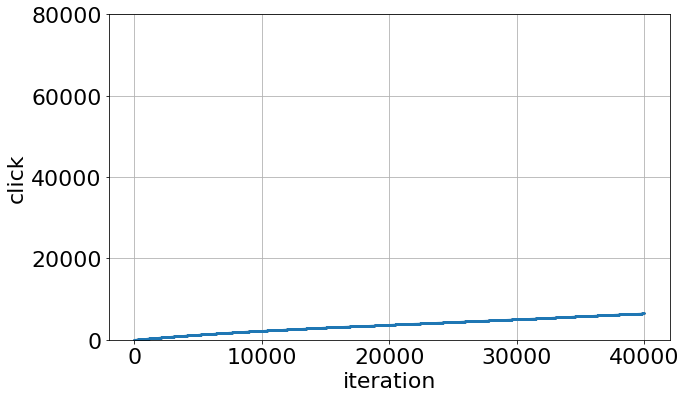

In [ ]:
itr_cumulated_click_count_mean = np.load('/content/itr_cumulated_click_count_mean_FS_airbnb.npy')
itr_cumulated_click_count_std = np.load('/content/itr_cumulated_click_count_std_FS_airbnb.npy')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax.plot(range(len(itr_cumulated_click_count_mean)), itr_cumulated_click_count_mean, marker='.', linewidth=1.5, markersize=1)
ax.fill_between(range(len(itr_cumulated_click_count_std)), itr_cumulated_click_count_mean-itr_cumulated_click_count_std, 
                itr_cumulated_click_count_mean+itr_cumulated_click_count_std, alpha=0.5)
ax.set_ylabel('click')
ax.set_xlabel('iteration')
ax.set_ylim(0., 80000)
ax.grid(True)
fig.patch.set_facecolor('white')
# plt.legend(loc='best')
plt.tight_layout()
plt.show()

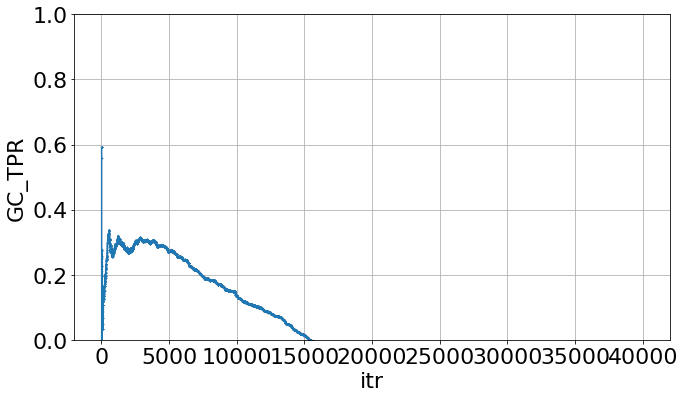

In [ ]:
itr_GC_TPR_mean = np.load('/content/itr_GC_TPR_mean_FS_airbnb.npy')
itr_GC_TPR_std = np.load('/content/itr_GC_TPR_std_FS_airbnb.npy')
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax.plot(range(len(itr_GC_TPR_mean)), itr_GC_TPR_mean, marker='.', linewidth=1.5, markersize=1)
ax.fill_between(range(len(itr_GC_TPR_mean)), itr_GC_TPR_mean-itr_GC_TPR_std, itr_GC_TPR_mean+itr_GC_TPR_std, alpha=0.5)
ax.set_ylabel('GC_TPR')
ax.set_xlabel('itr')
ax.set_ylim(0., 1)
ax.grid(True)
fig.patch.set_facecolor('white')
# plt.legend(loc='best')
plt.tight_layout()
plt.show()

#**Experiment_W/o_CFL**

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings; warnings.simplefilter('ignore')  # Ignores Warnings for nicer Plots. Disable for Debugging
import time
import numpy as np
import argparse
import utility
from Simulation_withoutCFL import Simulation


parser = argparse.ArgumentParser(description='Experiment_withoutCFL')
parser.add_argument('--run', type=int, default=10, help='number of experiments to run')
parser.add_argument('--iteration', type=int, default=40000, help='number of iterations to simulate')
parser.add_argument('--exp', type=int, default=1, help='number of initial random exposure iterations')
parser.add_argument('--cycle_itr', type=int, default=50, help='number of iterations in one cycle')
parser.add_argument('--epoch', type=int, default=15, help='number of epochs to train')
parser.add_argument('--K', type=int, default=20, help='number of items to recommend')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate')
parser.add_argument('--reg', type=float, default=1e-5, help='regularization')
parser.add_argument('--hidden', type=int, default=100, help='latent dimension')
parser.add_argument('--neg', type=int, default=5, help='negative sampling rate')
parser.add_argument('--data', type=str, default='ml1m', help='path to eval in the Data folder')
parser.add_argument('--num_user', type=float, default=num_user, help='path to eval in the Data folder')
parser.add_argument('--num_item', type=float, default=num_item, help='path to eval in the Data folder')
parser.add_argument('-f')


args = parser.parse_args()

truth = np.load('/content/truth_airbnb.npy')
args.num_user = truth.shape[0]
args.num_item = truth.shape[1]
audience_size = np.sum(truth, axis=0)
item_sorted = np.argsort(audience_size)
truth_like = list(np.load('/content/user_truth_like_airbnb.npy', allow_pickle=True))

print('')
print('!' * 30 + ' Total truth ' + str(np.sum(truth)) + ' ' + '!' * 30)
print('')

itr_cumulated_click_count_list = []
itr_GC_TPR_list = []

for r in range(args.run):
    print('')
    print('#' * 100)
    print('#' * 100)
    print(' ' * 50 + ' Experiment run ' + str(r + 1) + ' ' * 50)
    print('#' * 100)
    print('#' * 100)
    simulation = Simulation(args, truth, truth_like)
    init_popularity = simulation.initial_iterations()
    itr_click_item = simulation.run_simulation()

    itr_cumulated_click_count = []
    itr_item_click = np.zeros((args.iteration, args.num_item))
    for itr in range(args.iteration):
        click_item = itr_click_item[itr]
        itr_item_click[itr, click_item] = 1.
        itr_cumulated_click_count.append(
            len(click_item) if itr == 0 else len(click_item) + itr_cumulated_click_count[-1])
    for itr in range(1, args.iteration):
        itr_item_click[itr, :] += itr_item_click[itr - 1, :]
    itr_item_click /= (audience_size - init_popularity).reshape((1, -1))

    itr_GC_TPR = []
    for itr in range(args.iteration):
        a = itr_item_click[itr, item_sorted]
        gc = np.sum(((np.arange(len(a)) + 1.) * 2 - len(a) - 1) * a) / (len(a) * np.sum(a))
        itr_GC_TPR.append(gc)

    itr_cumulated_click_count_list.append(itr_cumulated_click_count)
    itr_GC_TPR_list.append(itr_GC_TPR)

    itr_cumulated_click_count_mean = np.mean(itr_cumulated_click_count_list, axis=0)
    itr_cumulated_click_count_std = np.std(itr_cumulated_click_count_list, axis=0)
    itr_GC_TPR_mean = np.mean(itr_GC_TPR_list, axis=0)
    itr_GC_TPR_std = np.std(itr_GC_TPR_list, axis=0)



!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Total truth 31951.0 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


####################################################################################################
####################################################################################################
                                                   Experiment run 1                                                  
####################################################################################################
####################################################################################################
Namespace(K=20, cycle_itr=50, data='ml1m', epoch=15, exp=1, f='/root/.local/share/jupyter/runtime/kernel-fc381ba0-44ee-4a67-bf4c-ab92f3747d83.json', hidden=100, iteration=40000, lr=0.001, neg=5, num_item=1162, num_user=1000, reg=1e-05, run=10)
****************************** Start initial random iterations ******************************
---------- Iteration 1 ----------


100%|██████████| 1000/1000 [00:00<00:00, 3035.76it/s]


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Generate 174 records.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
****************************** Train MF until converge ******************************
Update bs to 20
******************************MF initialization done ******************************


100%|██████████| 52/52 [00:00<00:00, 81.68it/s] 


Training // Epoch 0 //  Total cost = 36.0490  Total cost1 = 36.0297  Total cost2 = 0.0193


100%|██████████| 52/52 [00:00<00:00, 134.02it/s]


Training // Epoch 1 //  Total cost = 35.7443  Total cost1 = 35.7320  Total cost2 = 0.0123


100%|██████████| 52/52 [00:00<00:00, 155.74it/s]


Training // Epoch 2 //  Total cost = 35.2913  Total cost1 = 35.2757  Total cost2 = 0.0156


100%|██████████| 52/52 [00:00<00:00, 147.22it/s]


Training // Epoch 3 //  Total cost = 34.5413  Total cost1 = 34.5203  Total cost2 = 0.0210


100%|██████████| 52/52 [00:00<00:00, 125.65it/s]


Training // Epoch 4 //  Total cost = 33.3440  Total cost1 = 33.3152  Total cost2 = 0.0288


100%|██████████| 52/52 [00:00<00:00, 156.49it/s]


Training // Epoch 5 //  Total cost = 31.6754  Total cost1 = 31.6360  Total cost2 = 0.0394


100%|██████████| 52/52 [00:00<00:00, 231.59it/s]


Training // Epoch 6 //  Total cost = 29.5677  Total cost1 = 29.5152  Total cost2 = 0.0526


100%|██████████| 52/52 [00:00<00:00, 222.38it/s]


Training // Epoch 7 //  Total cost = 26.7472  Total cost1 = 26.6791  Total cost2 = 0.0681


100%|██████████| 52/52 [00:00<00:00, 225.13it/s]


Training // Epoch 8 //  Total cost = 23.5647  Total cost1 = 23.4778  Total cost2 = 0.0870


100%|██████████| 52/52 [00:00<00:00, 214.17it/s]


Training // Epoch 9 //  Total cost = 19.8381  Total cost1 = 19.7299  Total cost2 = 0.1081


100%|██████████| 52/52 [00:00<00:00, 217.90it/s]


Training // Epoch 10 //  Total cost = 15.7443  Total cost1 = 15.6131  Total cost2 = 0.1312


100%|██████████| 52/52 [00:00<00:00, 218.02it/s]


Training // Epoch 11 //  Total cost = 11.0777  Total cost1 = 10.9210  Total cost2 = 0.1567


100%|██████████| 52/52 [00:00<00:00, 233.30it/s]


Training // Epoch 12 //  Total cost = 6.1940  Total cost1 = 6.0095  Total cost2 = 0.1845


100%|██████████| 52/52 [00:00<00:00, 229.71it/s]


Training // Epoch 13 //  Total cost = 0.9879  Total cost1 = 0.7733  Total cost2 = 0.2146


100%|██████████| 52/52 [00:00<00:00, 208.42it/s]


Training // Epoch 14 //  Total cost = -4.6331  Total cost1 = -4.8813  Total cost2 = 0.2482
****************************** Start simulation ******************************


100%|██████████| 50/50 [00:00<00:00, 3820.58it/s]


########## The iteration 50, up to now total 10 clicks, GC=0.3439, this cycle used 0.06 s) ##########
Update bs to 22


100%|██████████| 15/15 [00:03<00:00,  4.69it/s]


100%|██████████| 50/50 [00:00<00:00, 3031.53it/s]


########## The iteration 100, up to now total 21 clicks, GC=0.3760, this cycle used 3.40 s) ##########
Update bs to 22


100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


100%|██████████| 50/50 [00:00<00:00, 2506.46it/s]


########## The iteration 150, up to now total 32 clicks, GC=0.3408, this cycle used 3.38 s) ##########
Update bs to 23


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 3739.97it/s]


########## The iteration 200, up to now total 47 clicks, GC=0.4001, this cycle used 3.37 s) ##########
Update bs to 24


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 3850.18it/s]


########## The iteration 250, up to now total 65 clicks, GC=0.4398, this cycle used 3.36 s) ##########
Update bs to 27


100%|██████████| 15/15 [00:03<00:00,  4.86it/s]


100%|██████████| 50/50 [00:00<00:00, 2440.42it/s]


########## The iteration 300, up to now total 76 clicks, GC=0.4468, this cycle used 3.20 s) ##########
Update bs to 27


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


100%|██████████| 50/50 [00:00<00:00, 3267.36it/s]


########## The iteration 350, up to now total 92 clicks, GC=0.3969, this cycle used 3.37 s) ##########
Update bs to 27


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 4027.10it/s]


########## The iteration 400, up to now total 101 clicks, GC=0.3609, this cycle used 3.41 s) ##########
Update bs to 29


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 3099.73it/s]


########## The iteration 450, up to now total 115 clicks, GC=0.3751, this cycle used 3.71 s) ##########
Update bs to 30


100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


100%|██████████| 50/50 [00:00<00:00, 1533.73it/s]


########## The iteration 500, up to now total 120 clicks, GC=0.3655, this cycle used 7.13 s) ##########
Update bs to 32


100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


100%|██████████| 50/50 [00:00<00:00, 1450.65it/s]


########## The iteration 550, up to now total 134 clicks, GC=0.3070, this cycle used 7.30 s) ##########
Update bs to 33


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 3613.54it/s]


########## The iteration 600, up to now total 146 clicks, GC=0.2802, this cycle used 4.05 s) ##########
Update bs to 34


100%|██████████| 15/15 [00:03<00:00,  4.75it/s]


100%|██████████| 50/50 [00:00<00:00, 3674.89it/s]


########## The iteration 650, up to now total 160 clicks, GC=0.2998, this cycle used 3.27 s) ##########
Update bs to 36


100%|██████████| 15/15 [00:03<00:00,  4.74it/s]


100%|██████████| 50/50 [00:00<00:00, 3739.37it/s]


########## The iteration 700, up to now total 171 clicks, GC=0.3050, this cycle used 3.28 s) ##########
Update bs to 37


100%|██████████| 15/15 [00:03<00:00,  4.71it/s]


100%|██████████| 50/50 [00:00<00:00, 3738.44it/s]


########## The iteration 750, up to now total 180 clicks, GC=0.3188, this cycle used 3.31 s) ##########
Update bs to 37


100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


100%|██████████| 50/50 [00:00<00:00, 2974.94it/s]


########## The iteration 800, up to now total 196 clicks, GC=0.2697, this cycle used 3.36 s) ##########
Update bs to 39


100%|██████████| 15/15 [00:03<00:00,  4.76it/s]


100%|██████████| 50/50 [00:00<00:00, 4600.43it/s]


########## The iteration 850, up to now total 213 clicks, GC=0.2745, this cycle used 3.29 s) ##########
Update bs to 39


100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


100%|██████████| 50/50 [00:00<00:00, 3933.66it/s]


########## The iteration 900, up to now total 222 clicks, GC=0.2817, this cycle used 3.37 s) ##########
Update bs to 40


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 3088.59it/s]


########## The iteration 950, up to now total 233 clicks, GC=0.2885, this cycle used 3.42 s) ##########
Update bs to 41


100%|██████████| 15/15 [00:03<00:00,  4.69it/s]


100%|██████████| 50/50 [00:00<00:00, 4098.16it/s]


########## The iteration 1000, up to now total 252 clicks, GC=0.2961, this cycle used 3.33 s) ##########
Update bs to 42


100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


100%|██████████| 50/50 [00:00<00:00, 3038.78it/s]


########## The iteration 1050, up to now total 273 clicks, GC=0.2944, this cycle used 3.37 s) ##########
Update bs to 43


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 4265.45it/s]


########## The iteration 1100, up to now total 283 clicks, GC=0.2708, this cycle used 3.43 s) ##########
Update bs to 44


100%|██████████| 15/15 [00:03<00:00,  4.71it/s]


100%|██████████| 50/50 [00:00<00:00, 4194.05it/s]


########## The iteration 1150, up to now total 303 clicks, GC=0.2783, this cycle used 3.32 s) ##########
Update bs to 46


100%|██████████| 15/15 [00:03<00:00,  4.71it/s]


100%|██████████| 50/50 [00:00<00:00, 3704.89it/s]


########## The iteration 1200, up to now total 317 clicks, GC=0.2866, this cycle used 3.33 s) ##########
Update bs to 47


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 4207.43it/s]


########## The iteration 1250, up to now total 328 clicks, GC=0.2907, this cycle used 3.46 s) ##########
Update bs to 48


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 2958.65it/s]


########## The iteration 1300, up to now total 343 clicks, GC=0.3009, this cycle used 3.40 s) ##########
Update bs to 49


100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


100%|██████████| 50/50 [00:00<00:00, 3505.24it/s]


########## The iteration 1350, up to now total 361 clicks, GC=0.2986, this cycle used 3.41 s) ##########
Update bs to 51


100%|██████████| 15/15 [00:03<00:00,  4.68it/s]


100%|██████████| 50/50 [00:00<00:00, 4063.78it/s]


########## The iteration 1400, up to now total 378 clicks, GC=0.2839, this cycle used 3.34 s) ##########
Update bs to 51


100%|██████████| 15/15 [00:03<00:00,  4.67it/s]


100%|██████████| 50/50 [00:00<00:00, 3272.61it/s]


########## The iteration 1450, up to now total 394 clicks, GC=0.2639, this cycle used 3.35 s) ##########
Update bs to 52


100%|██████████| 15/15 [00:03<00:00,  4.69it/s]


100%|██████████| 50/50 [00:00<00:00, 4038.11it/s]


########## The iteration 1500, up to now total 408 clicks, GC=0.2683, this cycle used 3.34 s) ##########
Update bs to 53


100%|██████████| 15/15 [00:03<00:00,  4.73it/s]


100%|██████████| 50/50 [00:00<00:00, 4622.23it/s]


########## The iteration 1550, up to now total 415 clicks, GC=0.2635, this cycle used 3.32 s) ##########
Update bs to 54


100%|██████████| 15/15 [00:03<00:00,  4.68it/s]


100%|██████████| 50/50 [00:00<00:00, 2445.66it/s]


########## The iteration 1600, up to now total 428 clicks, GC=0.2624, this cycle used 3.38 s) ##########
Update bs to 56


100%|██████████| 15/15 [00:03<00:00,  4.74it/s]


100%|██████████| 50/50 [00:00<00:00, 4771.68it/s]


########## The iteration 1650, up to now total 440 clicks, GC=0.2607, this cycle used 3.33 s) ##########
Update bs to 57


100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


100%|██████████| 50/50 [00:00<00:00, 3698.03it/s]


########## The iteration 1700, up to now total 451 clicks, GC=0.2655, this cycle used 3.38 s) ##########
Update bs to 59


100%|██████████| 15/15 [00:03<00:00,  4.81it/s]


100%|██████████| 50/50 [00:00<00:00, 3502.90it/s]


########## The iteration 1750, up to now total 466 clicks, GC=0.2747, this cycle used 3.27 s) ##########
Update bs to 60


100%|██████████| 15/15 [00:03<00:00,  4.76it/s]


100%|██████████| 50/50 [00:00<00:00, 3401.82it/s]


########## The iteration 1800, up to now total 477 clicks, GC=0.2791, this cycle used 3.32 s) ##########
Update bs to 61


100%|██████████| 15/15 [00:03<00:00,  4.73it/s]


100%|██████████| 50/50 [00:00<00:00, 3499.51it/s]


########## The iteration 1850, up to now total 489 clicks, GC=0.2738, this cycle used 3.33 s) ##########
Update bs to 63


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 858.31it/s]


########## The iteration 1900, up to now total 502 clicks, GC=0.2718, this cycle used 3.80 s) ##########
Update bs to 64


100%|██████████| 15/15 [00:03<00:00,  4.47it/s]


100%|██████████| 50/50 [00:00<00:00, 3115.94it/s]


########## The iteration 1950, up to now total 521 clicks, GC=0.2736, this cycle used 3.63 s) ##########
Update bs to 66


100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


100%|██████████| 50/50 [00:00<00:00, 1571.31it/s]


########## The iteration 2000, up to now total 530 clicks, GC=0.2760, this cycle used 3.70 s) ##########
Update bs to 67


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 4196.49it/s]


########## The iteration 2050, up to now total 538 clicks, GC=0.2806, this cycle used 3.60 s) ##########
Update bs to 69


100%|██████████| 15/15 [00:03<00:00,  4.75it/s]


100%|██████████| 50/50 [00:00<00:00, 3460.30it/s]


########## The iteration 2100, up to now total 556 clicks, GC=0.2866, this cycle used 3.33 s) ##########
Update bs to 70


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 4426.71it/s]


########## The iteration 2150, up to now total 571 clicks, GC=0.2890, this cycle used 3.44 s) ##########
Update bs to 72


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


100%|██████████| 50/50 [00:00<00:00, 1436.60it/s]


########## The iteration 2200, up to now total 585 clicks, GC=0.2960, this cycle used 5.31 s) ##########
Update bs to 73


100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


100%|██████████| 50/50 [00:00<00:00, 1145.89it/s]


########## The iteration 2250, up to now total 595 clicks, GC=0.2990, this cycle used 7.36 s) ##########
Update bs to 74


100%|██████████| 15/15 [00:06<00:00,  2.41it/s]


100%|██████████| 50/50 [00:00<00:00, 2610.28it/s]


########## The iteration 2300, up to now total 607 clicks, GC=0.3017, this cycle used 6.70 s) ##########
Update bs to 75


100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


100%|██████████| 50/50 [00:00<00:00, 3483.00it/s]


########## The iteration 2350, up to now total 619 clicks, GC=0.3035, this cycle used 7.15 s) ##########
Update bs to 76


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 3598.96it/s]


########## The iteration 2400, up to now total 634 clicks, GC=0.3089, this cycle used 3.73 s) ##########
Update bs to 77


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


100%|██████████| 50/50 [00:00<00:00, 3848.13it/s]


########## The iteration 2450, up to now total 646 clicks, GC=0.3118, this cycle used 3.43 s) ##########
Update bs to 78


100%|██████████| 15/15 [00:04<00:00,  3.30it/s]


100%|██████████| 50/50 [00:00<00:00, 1427.29it/s]


########## The iteration 2500, up to now total 656 clicks, GC=0.3113, this cycle used 4.78 s) ##########
Update bs to 80


100%|██████████| 15/15 [00:04<00:00,  3.50it/s]


100%|██████████| 50/50 [00:00<00:00, 3811.89it/s]


########## The iteration 2550, up to now total 673 clicks, GC=0.3156, this cycle used 4.47 s) ##########
Update bs to 81


100%|██████████| 15/15 [00:03<00:00,  4.75it/s]


100%|██████████| 50/50 [00:00<00:00, 3675.41it/s]


########## The iteration 2600, up to now total 679 clicks, GC=0.3131, this cycle used 3.34 s) ##########
Update bs to 82


100%|██████████| 15/15 [00:05<00:00,  2.81it/s]


100%|██████████| 50/50 [00:00<00:00, 2683.26it/s]


########## The iteration 2650, up to now total 691 clicks, GC=0.3139, this cycle used 5.56 s) ##########
Update bs to 83


100%|██████████| 15/15 [00:05<00:00,  2.77it/s]


100%|██████████| 50/50 [00:00<00:00, 3061.76it/s]


########## The iteration 2700, up to now total 707 clicks, GC=0.3175, this cycle used 5.63 s) ##########
Update bs to 84


100%|██████████| 15/15 [00:03<00:00,  4.66it/s]


100%|██████████| 50/50 [00:00<00:00, 3221.43it/s]


########## The iteration 2750, up to now total 720 clicks, GC=0.3155, this cycle used 3.39 s) ##########
Update bs to 85


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


100%|██████████| 50/50 [00:00<00:00, 2078.69it/s]


########## The iteration 2800, up to now total 732 clicks, GC=0.3148, this cycle used 3.47 s) ##########
Update bs to 87


100%|██████████| 15/15 [00:03<00:00,  4.70it/s]


100%|██████████| 50/50 [00:00<00:00, 3223.46it/s]


########## The iteration 2850, up to now total 754 clicks, GC=0.3104, this cycle used 3.37 s) ##########
Update bs to 88


100%|██████████| 15/15 [00:03<00:00,  4.71it/s]


100%|██████████| 50/50 [00:00<00:00, 4206.92it/s]


########## The iteration 2900, up to now total 770 clicks, GC=0.3075, this cycle used 3.37 s) ##########
Update bs to 89


100%|██████████| 15/15 [00:03<00:00,  4.75it/s]


100%|██████████| 50/50 [00:00<00:00, 2020.49it/s]


########## The iteration 2950, up to now total 789 clicks, GC=0.3079, this cycle used 3.35 s) ##########
Update bs to 90


100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1679.58it/s]


########## The iteration 3000, up to now total 802 clicks, GC=0.3103, this cycle used 5.97 s) ##########
Update bs to 92


100%|██████████| 15/15 [00:05<00:00,  2.91it/s]


100%|██████████| 50/50 [00:00<00:00, 3361.63it/s]


########## The iteration 3050, up to now total 818 clicks, GC=0.3124, this cycle used 5.37 s) ##########
Update bs to 92


100%|██████████| 15/15 [00:05<00:00,  2.93it/s]


100%|██████████| 50/50 [00:00<00:00, 3291.41it/s]


########## The iteration 3100, up to now total 830 clicks, GC=0.3156, this cycle used 5.34 s) ##########
Update bs to 93


100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


100%|██████████| 50/50 [00:00<00:00, 2399.60it/s]


########## The iteration 3150, up to now total 852 clicks, GC=0.3140, this cycle used 4.61 s) ##########
Update bs to 95


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


100%|██████████| 50/50 [00:00<00:00, 3167.33it/s]


########## The iteration 3200, up to now total 862 clicks, GC=0.3145, this cycle used 4.41 s) ##########
Update bs to 96


100%|██████████| 15/15 [00:03<00:00,  4.66it/s]


100%|██████████| 50/50 [00:00<00:00, 2677.30it/s]


########## The iteration 3250, up to now total 872 clicks, GC=0.3160, this cycle used 3.42 s) ##########
Update bs to 98


100%|██████████| 15/15 [00:03<00:00,  4.72it/s]


100%|██████████| 50/50 [00:00<00:00, 3218.91it/s]


########## The iteration 3300, up to now total 885 clicks, GC=0.3155, this cycle used 3.38 s) ##########
Update bs to 99


100%|██████████| 15/15 [00:03<00:00,  4.70it/s]


100%|██████████| 50/50 [00:00<00:00, 3169.20it/s]


########## The iteration 3350, up to now total 894 clicks, GC=0.3165, this cycle used 3.38 s) ##########
Update bs to 100


100%|██████████| 15/15 [00:04<00:00,  3.13it/s]


100%|██████████| 50/50 [00:00<00:00, 3408.67it/s]


########## The iteration 3400, up to now total 904 clicks, GC=0.3197, this cycle used 5.01 s) ##########
Update bs to 102


100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


100%|██████████| 50/50 [00:00<00:00, 3994.65it/s]


########## The iteration 3450, up to now total 916 clicks, GC=0.3228, this cycle used 6.03 s) ##########
Update bs to 102


100%|██████████| 15/15 [00:03<00:00,  4.43it/s]


100%|██████████| 50/50 [00:00<00:00, 3219.95it/s]


########## The iteration 3500, up to now total 937 clicks, GC=0.3230, this cycle used 3.61 s) ##########
Update bs to 103


100%|██████████| 15/15 [00:03<00:00,  4.66it/s]


100%|██████████| 50/50 [00:00<00:00, 2644.08it/s]


########## The iteration 3550, up to now total 954 clicks, GC=0.3239, this cycle used 3.42 s) ##########
Update bs to 105


100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


100%|██████████| 50/50 [00:00<00:00, 1004.69it/s]


########## The iteration 3600, up to now total 960 clicks, GC=0.3252, this cycle used 3.72 s) ##########
Update bs to 105


100%|██████████| 15/15 [00:03<00:00,  4.66it/s]


100%|██████████| 50/50 [00:00<00:00, 2928.49it/s]


########## The iteration 3650, up to now total 972 clicks, GC=0.3273, this cycle used 3.65 s) ##########
Update bs to 106


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 3242.30it/s]


########## The iteration 3700, up to now total 977 clicks, GC=0.3280, this cycle used 3.48 s) ##########
Update bs to 107


100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


100%|██████████| 50/50 [00:00<00:00, 3038.95it/s]


########## The iteration 3750, up to now total 991 clicks, GC=0.3298, this cycle used 3.43 s) ##########
Update bs to 108


100%|██████████| 15/15 [00:03<00:00,  4.57it/s]


100%|██████████| 50/50 [00:00<00:00, 4482.63it/s]


########## The iteration 3800, up to now total 1006 clicks, GC=0.3264, this cycle used 3.48 s) ##########
Update bs to 109


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 2702.10it/s]


########## The iteration 3850, up to now total 1016 clicks, GC=0.3270, this cycle used 3.92 s) ##########
Update bs to 110


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:03<00:00, 14.02it/s]


########## The iteration 3900, up to now total 1024 clicks, GC=0.3286, this cycle used 7.15 s) ##########
Update bs to 112


100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


100%|██████████| 50/50 [00:00<00:00, 3713.22it/s]


########## The iteration 3950, up to now total 1039 clicks, GC=0.3321, this cycle used 7.22 s) ##########
Update bs to 113


100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


100%|██████████| 50/50 [00:00<00:00, 3253.92it/s]


########## The iteration 4000, up to now total 1052 clicks, GC=0.3355, this cycle used 6.03 s) ##########
Update bs to 114


100%|██████████| 15/15 [00:03<00:00,  4.47it/s]


100%|██████████| 50/50 [00:00<00:00, 2580.82it/s]


########## The iteration 4050, up to now total 1067 clicks, GC=0.3326, this cycle used 3.62 s) ##########
Update bs to 115


100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


100%|██████████| 50/50 [00:00<00:00, 3009.78it/s]


########## The iteration 4100, up to now total 1083 clicks, GC=0.3345, this cycle used 3.45 s) ##########
Update bs to 116


100%|██████████| 15/15 [00:03<00:00,  4.68it/s]


100%|██████████| 50/50 [00:00<00:00, 2718.81it/s]


########## The iteration 4150, up to now total 1098 clicks, GC=0.3309, this cycle used 3.40 s) ##########
Update bs to 117


100%|██████████| 15/15 [00:03<00:00,  4.70it/s]


100%|██████████| 50/50 [00:00<00:00, 2777.72it/s]


########## The iteration 4200, up to now total 1110 clicks, GC=0.3333, this cycle used 3.40 s) ##########
Update bs to 119


100%|██████████| 15/15 [00:03<00:00,  4.67it/s]


100%|██████████| 50/50 [00:00<00:00, 3261.97it/s]


########## The iteration 4250, up to now total 1125 clicks, GC=0.3357, this cycle used 3.41 s) ##########
Update bs to 121


100%|██████████| 15/15 [00:03<00:00,  4.70it/s]


100%|██████████| 50/50 [00:00<00:00, 2873.32it/s]


########## The iteration 4300, up to now total 1136 clicks, GC=0.3379, this cycle used 3.39 s) ##########
Update bs to 122


100%|██████████| 15/15 [00:03<00:00,  4.74it/s]


100%|██████████| 50/50 [00:00<00:00, 2746.72it/s]


########## The iteration 4350, up to now total 1147 clicks, GC=0.3352, this cycle used 3.38 s) ##########
Update bs to 123


100%|██████████| 15/15 [00:03<00:00,  4.68it/s]


100%|██████████| 50/50 [00:00<00:00, 3487.35it/s]


########## The iteration 4400, up to now total 1155 clicks, GC=0.3369, this cycle used 3.40 s) ##########
Update bs to 125


100%|██████████| 15/15 [00:03<00:00,  4.70it/s]


100%|██████████| 50/50 [00:00<00:00, 2790.44it/s]


########## The iteration 4450, up to now total 1168 clicks, GC=0.3341, this cycle used 3.41 s) ##########
Update bs to 126


100%|██████████| 15/15 [00:03<00:00,  4.71it/s]


100%|██████████| 50/50 [00:00<00:00, 3851.24it/s]


########## The iteration 4500, up to now total 1179 clicks, GC=0.3350, this cycle used 3.39 s) ##########
Update bs to 127


100%|██████████| 15/15 [00:03<00:00,  4.68it/s]


100%|██████████| 50/50 [00:00<00:00, 2818.64it/s]


########## The iteration 4550, up to now total 1188 clicks, GC=0.3349, this cycle used 3.42 s) ##########
Update bs to 128


100%|██████████| 15/15 [00:03<00:00,  4.67it/s]


100%|██████████| 50/50 [00:00<00:00, 2923.27it/s]


########## The iteration 4600, up to now total 1202 clicks, GC=0.3304, this cycle used 3.42 s) ##########
Update bs to 129


100%|██████████| 15/15 [00:03<00:00,  4.73it/s]


100%|██████████| 50/50 [00:00<00:00, 3433.45it/s]


########## The iteration 4650, up to now total 1215 clicks, GC=0.3274, this cycle used 3.38 s) ##########
Update bs to 130


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


100%|██████████| 50/50 [00:00<00:00, 3097.90it/s]


########## The iteration 4700, up to now total 1230 clicks, GC=0.3278, this cycle used 3.50 s) ##########
Update bs to 131


100%|██████████| 15/15 [00:03<00:00,  4.74it/s]


100%|██████████| 50/50 [00:00<00:00, 2674.46it/s]


########## The iteration 4750, up to now total 1247 clicks, GC=0.3298, this cycle used 3.37 s) ##########
Update bs to 133


100%|██████████| 15/15 [00:03<00:00,  4.67it/s]


100%|██████████| 50/50 [00:00<00:00, 3335.38it/s]


########## The iteration 4800, up to now total 1264 clicks, GC=0.3321, this cycle used 3.43 s) ##########
Update bs to 134


100%|██████████| 15/15 [00:03<00:00,  4.67it/s]


100%|██████████| 50/50 [00:00<00:00, 3919.03it/s]


########## The iteration 4850, up to now total 1275 clicks, GC=0.3306, this cycle used 3.42 s) ##########
Update bs to 135


100%|██████████| 15/15 [00:03<00:00,  4.66it/s]


100%|██████████| 50/50 [00:00<00:00, 3468.89it/s]


########## The iteration 4900, up to now total 1283 clicks, GC=0.3304, this cycle used 3.44 s) ##########
Update bs to 136


100%|██████████| 15/15 [00:03<00:00,  4.72it/s]


100%|██████████| 50/50 [00:00<00:00, 3545.06it/s]


########## The iteration 4950, up to now total 1297 clicks, GC=0.3302, this cycle used 3.42 s) ##########
Update bs to 138


100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


100%|██████████| 50/50 [00:00<00:00, 2724.92it/s]


########## The iteration 5000, up to now total 1311 clicks, GC=0.3311, this cycle used 3.44 s) ##########
Update bs to 140


100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


100%|██████████| 50/50 [00:00<00:00, 2574.49it/s]


########## The iteration 5050, up to now total 1327 clicks, GC=0.3326, this cycle used 3.45 s) ##########
Update bs to 141


100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


100%|██████████| 50/50 [00:00<00:00, 3852.93it/s]


########## The iteration 5100, up to now total 1342 clicks, GC=0.3319, this cycle used 3.44 s) ##########
Update bs to 142


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 4174.77it/s]


########## The iteration 5150, up to now total 1354 clicks, GC=0.3335, this cycle used 3.47 s) ##########
Update bs to 143


100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


100%|██████████| 50/50 [00:00<00:00, 3997.54it/s]


########## The iteration 5200, up to now total 1369 clicks, GC=0.3357, this cycle used 3.44 s) ##########
Update bs to 145


100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


100%|██████████| 50/50 [00:00<00:00, 3904.58it/s]


########## The iteration 5250, up to now total 1386 clicks, GC=0.3350, this cycle used 3.46 s) ##########
Update bs to 146


100%|██████████| 15/15 [00:03<00:00,  4.66it/s]


100%|██████████| 50/50 [00:00<00:00, 4162.34it/s]


########## The iteration 5300, up to now total 1397 clicks, GC=0.3327, this cycle used 3.46 s) ##########
Update bs to 146


100%|██████████| 15/15 [00:03<00:00,  4.68it/s]


100%|██████████| 50/50 [00:00<00:00, 3530.74it/s]


########## The iteration 5350, up to now total 1410 clicks, GC=0.3356, this cycle used 3.40 s) ##########
Update bs to 147


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 4127.44it/s]


########## The iteration 5400, up to now total 1420 clicks, GC=0.3369, this cycle used 4.24 s) ##########
Update bs to 148


100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


100%|██████████| 50/50 [00:00<00:00, 2162.19it/s]


########## The iteration 5450, up to now total 1430 clicks, GC=0.3376, this cycle used 3.46 s) ##########
Update bs to 150


100%|██████████| 15/15 [00:03<00:00,  4.67it/s]


100%|██████████| 50/50 [00:00<00:00, 3773.55it/s]


########## The iteration 5500, up to now total 1437 clicks, GC=0.3378, this cycle used 3.42 s) ##########
Update bs to 150


100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


100%|██████████| 50/50 [00:00<00:00, 3340.27it/s]


########## The iteration 5550, up to now total 1450 clicks, GC=0.3394, this cycle used 3.45 s) ##########
Update bs to 151


100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


100%|██████████| 50/50 [00:00<00:00, 4279.38it/s]


########## The iteration 5600, up to now total 1463 clicks, GC=0.3392, this cycle used 3.46 s) ##########
Update bs to 152


100%|██████████| 15/15 [00:03<00:00,  4.69it/s]


100%|██████████| 50/50 [00:00<00:00, 2771.33it/s]


########## The iteration 5650, up to now total 1472 clicks, GC=0.3409, this cycle used 3.43 s) ##########
Update bs to 153


100%|██████████| 15/15 [00:03<00:00,  4.70it/s]


100%|██████████| 50/50 [00:00<00:00, 2490.32it/s]


########## The iteration 5700, up to now total 1484 clicks, GC=0.3403, this cycle used 3.43 s) ##########
Update bs to 154


100%|██████████| 15/15 [00:03<00:00,  4.68it/s]


100%|██████████| 50/50 [00:00<00:00, 3621.27it/s]


########## The iteration 5750, up to now total 1493 clicks, GC=0.3409, this cycle used 3.44 s) ##########
Update bs to 155


100%|██████████| 15/15 [00:03<00:00,  4.69it/s]


100%|██████████| 50/50 [00:00<00:00, 3917.57it/s]


########## The iteration 5800, up to now total 1500 clicks, GC=0.3425, this cycle used 3.42 s) ##########
Update bs to 156


100%|██████████| 15/15 [00:03<00:00,  4.67it/s]


100%|██████████| 50/50 [00:00<00:00, 2009.32it/s]


########## The iteration 5850, up to now total 1511 clicks, GC=0.3437, this cycle used 3.48 s) ##########
Update bs to 157


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


100%|██████████| 50/50 [00:00<00:00, 2660.79it/s]


########## The iteration 5900, up to now total 1531 clicks, GC=0.3454, this cycle used 3.51 s) ##########
Update bs to 158


100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


100%|██████████| 50/50 [00:00<00:00, 3345.33it/s]


########## The iteration 5950, up to now total 1542 clicks, GC=0.3471, this cycle used 3.48 s) ##########
Update bs to 158


100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


100%|██████████| 50/50 [00:00<00:00, 2743.78it/s]


########## The iteration 6000, up to now total 1556 clicks, GC=0.3471, this cycle used 3.45 s) ##########
Update bs to 159


100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


100%|██████████| 50/50 [00:00<00:00, 2690.73it/s]


########## The iteration 6050, up to now total 1566 clicks, GC=0.3485, this cycle used 3.46 s) ##########
Update bs to 160


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 2554.11it/s]


########## The iteration 6100, up to now total 1573 clicks, GC=0.3481, this cycle used 3.48 s) ##########
Update bs to 162


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


100%|██████████| 50/50 [00:00<00:00, 3959.21it/s]


########## The iteration 6150, up to now total 1583 clicks, GC=0.3500, this cycle used 3.48 s) ##########
Update bs to 163


100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


100%|██████████| 50/50 [00:00<00:00, 3645.19it/s]


########## The iteration 6200, up to now total 1598 clicks, GC=0.3499, this cycle used 3.48 s) ##########
Update bs to 164


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 2579.81it/s]


########## The iteration 6250, up to now total 1608 clicks, GC=0.3514, this cycle used 3.51 s) ##########
Update bs to 165


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 3630.74it/s]


########## The iteration 6300, up to now total 1622 clicks, GC=0.3516, this cycle used 3.50 s) ##########
Update bs to 166


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 3547.40it/s]


########## The iteration 6350, up to now total 1635 clicks, GC=0.3537, this cycle used 3.52 s) ##########
Update bs to 167


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


100%|██████████| 50/50 [00:00<00:00, 2501.25it/s]


########## The iteration 6400, up to now total 1645 clicks, GC=0.3555, this cycle used 3.51 s) ##########
Update bs to 169


100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


100%|██████████| 50/50 [00:00<00:00, 3718.49it/s]


########## The iteration 6450, up to now total 1660 clicks, GC=0.3556, this cycle used 3.48 s) ##########
Update bs to 170


100%|██████████| 15/15 [00:03<00:00,  4.67it/s]


100%|██████████| 50/50 [00:00<00:00, 3339.52it/s]


########## The iteration 6500, up to now total 1670 clicks, GC=0.3537, this cycle used 3.46 s) ##########
Update bs to 170


100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


100%|██████████| 50/50 [00:00<00:00, 2071.59it/s]


########## The iteration 6550, up to now total 1690 clicks, GC=0.3536, this cycle used 3.48 s) ##########
Update bs to 171


100%|██████████| 15/15 [00:03<00:00,  4.66it/s]


100%|██████████| 50/50 [00:00<00:00, 3552.33it/s]


########## The iteration 6600, up to now total 1701 clicks, GC=0.3512, this cycle used 3.45 s) ##########
Update bs to 172


100%|██████████| 15/15 [00:03<00:00,  4.69it/s]


100%|██████████| 50/50 [00:00<00:00, 1947.92it/s]


########## The iteration 6650, up to now total 1714 clicks, GC=0.3486, this cycle used 3.46 s) ##########
Update bs to 173


100%|██████████| 15/15 [00:03<00:00,  4.70it/s]


100%|██████████| 50/50 [00:00<00:00, 2950.04it/s]


########## The iteration 6700, up to now total 1727 clicks, GC=0.3495, this cycle used 3.43 s) ##########
Update bs to 174


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 2175.18it/s]


########## The iteration 6750, up to now total 1733 clicks, GC=0.3497, this cycle used 3.58 s) ##########
Update bs to 175


100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


100%|██████████| 50/50 [00:00<00:00, 3831.74it/s]


########## The iteration 6800, up to now total 1744 clicks, GC=0.3510, this cycle used 3.48 s) ##########
Update bs to 177


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


100%|██████████| 50/50 [00:00<00:00, 2481.84it/s]


########## The iteration 6850, up to now total 1757 clicks, GC=0.3512, this cycle used 3.56 s) ##########
Update bs to 178


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 2599.31it/s]


########## The iteration 6900, up to now total 1763 clicks, GC=0.3523, this cycle used 4.27 s) ##########
Update bs to 179


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 3958.31it/s]


########## The iteration 6950, up to now total 1772 clicks, GC=0.3495, this cycle used 3.55 s) ##########
Update bs to 179


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 3645.51it/s]


########## The iteration 7000, up to now total 1786 clicks, GC=0.3493, this cycle used 3.54 s) ##########
Update bs to 180


100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


100%|██████████| 50/50 [00:00<00:00, 2786.21it/s]


########## The iteration 7050, up to now total 1798 clicks, GC=0.3510, this cycle used 3.50 s) ##########
Update bs to 182


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


100%|██████████| 50/50 [00:00<00:00, 3702.86it/s]


########## The iteration 7100, up to now total 1808 clicks, GC=0.3498, this cycle used 3.51 s) ##########
Update bs to 183


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


100%|██████████| 50/50 [00:00<00:00, 2762.14it/s]


########## The iteration 7150, up to now total 1825 clicks, GC=0.3495, this cycle used 3.53 s) ##########
Update bs to 184


100%|██████████| 15/15 [00:03<00:00,  4.57it/s]


100%|██████████| 50/50 [00:00<00:00, 2160.12it/s]


########## The iteration 7200, up to now total 1838 clicks, GC=0.3476, this cycle used 3.56 s) ##########
Update bs to 184


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 2287.54it/s]


########## The iteration 7250, up to now total 1852 clicks, GC=0.3492, this cycle used 3.58 s) ##########
Update bs to 185


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 3430.42it/s]


########## The iteration 7300, up to now total 1865 clicks, GC=0.3508, this cycle used 3.55 s) ##########
Update bs to 186


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


100%|██████████| 50/50 [00:00<00:00, 2165.63it/s]


########## The iteration 7350, up to now total 1880 clicks, GC=0.3506, this cycle used 3.53 s) ##########
Update bs to 186


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


100%|██████████| 50/50 [00:00<00:00, 2867.43it/s]


########## The iteration 7400, up to now total 1889 clicks, GC=0.3519, this cycle used 3.50 s) ##########
Update bs to 187


100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


100%|██████████| 50/50 [00:00<00:00, 3934.69it/s]


########## The iteration 7450, up to now total 1902 clicks, GC=0.3523, this cycle used 3.50 s) ##########
Update bs to 188


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


100%|██████████| 50/50 [00:00<00:00, 4043.72it/s]


########## The iteration 7500, up to now total 1916 clicks, GC=0.3531, this cycle used 3.51 s) ##########
Update bs to 189


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


100%|██████████| 50/50 [00:00<00:00, 3570.35it/s]


########## The iteration 7550, up to now total 1932 clicks, GC=0.3552, this cycle used 3.52 s) ##########
Update bs to 190


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 3029.47it/s]


########## The iteration 7600, up to now total 1946 clicks, GC=0.3569, this cycle used 3.56 s) ##########
Update bs to 191


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


100%|██████████| 50/50 [00:00<00:00, 2760.72it/s]


########## The iteration 7650, up to now total 1958 clicks, GC=0.3528, this cycle used 3.54 s) ##########
Update bs to 192


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 4339.41it/s]


########## The iteration 7700, up to now total 1972 clicks, GC=0.3505, this cycle used 3.55 s) ##########
Update bs to 193


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 2106.25it/s]


########## The iteration 7750, up to now total 1983 clicks, GC=0.3480, this cycle used 3.57 s) ##########
Update bs to 194


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 2173.67it/s]


########## The iteration 7800, up to now total 1988 clicks, GC=0.3480, this cycle used 3.53 s) ##########
Update bs to 195


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


100%|██████████| 50/50 [00:00<00:00, 2557.35it/s]


########## The iteration 7850, up to now total 2002 clicks, GC=0.3471, this cycle used 3.52 s) ##########
Update bs to 197


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


100%|██████████| 50/50 [00:00<00:00, 2046.32it/s]


########## The iteration 7900, up to now total 2016 clicks, GC=0.3443, this cycle used 3.56 s) ##########
Update bs to 197


100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


100%|██████████| 50/50 [00:00<00:00, 3903.28it/s]


########## The iteration 7950, up to now total 2030 clicks, GC=0.3460, this cycle used 3.50 s) ##########
Update bs to 199


100%|██████████| 15/15 [00:03<00:00,  4.59it/s]


100%|██████████| 50/50 [00:00<00:00, 2130.00it/s]


########## The iteration 8000, up to now total 2040 clicks, GC=0.3471, this cycle used 3.55 s) ##########
Update bs to 200


100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


100%|██████████| 50/50 [00:00<00:00, 2760.10it/s]


########## The iteration 8050, up to now total 2045 clicks, GC=0.3470, this cycle used 3.52 s) ##########
Update bs to 201


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 3581.14it/s]


########## The iteration 8100, up to now total 2051 clicks, GC=0.3471, this cycle used 3.59 s) ##########
Update bs to 202


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


100%|██████████| 50/50 [00:00<00:00, 2353.07it/s]


########## The iteration 8150, up to now total 2058 clicks, GC=0.3475, this cycle used 3.55 s) ##########
Update bs to 204


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


100%|██████████| 50/50 [00:00<00:00, 2457.70it/s]


########## The iteration 8200, up to now total 2071 clicks, GC=0.3487, this cycle used 3.59 s) ##########
Update bs to 205


100%|██████████| 15/15 [00:03<00:00,  4.57it/s]


100%|██████████| 50/50 [00:00<00:00, 1964.86it/s]


########## The iteration 8250, up to now total 2081 clicks, GC=0.3492, this cycle used 3.55 s) ##########
Update bs to 206


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


100%|██████████| 50/50 [00:00<00:00, 1939.78it/s]


########## The iteration 8300, up to now total 2088 clicks, GC=0.3500, this cycle used 3.54 s) ##########
Update bs to 207


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 4455.96it/s]


########## The iteration 8350, up to now total 2098 clicks, GC=0.3506, this cycle used 3.54 s) ##########
Update bs to 208


100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


100%|██████████| 50/50 [00:00<00:00, 3092.87it/s]


########## The iteration 8400, up to now total 2106 clicks, GC=0.3511, this cycle used 3.53 s) ##########
Update bs to 209


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 2410.10it/s]


########## The iteration 8450, up to now total 2115 clicks, GC=0.3506, this cycle used 3.59 s) ##########
Update bs to 210


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 3448.36it/s]


########## The iteration 8500, up to now total 2134 clicks, GC=0.3520, this cycle used 3.56 s) ##########
Update bs to 211


100%|██████████| 15/15 [00:03<00:00,  4.57it/s]


100%|██████████| 50/50 [00:00<00:00, 2982.21it/s]


########## The iteration 8550, up to now total 2149 clicks, GC=0.3510, this cycle used 3.59 s) ##########
Update bs to 212


100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


100%|██████████| 50/50 [00:00<00:00, 2275.43it/s]


########## The iteration 8600, up to now total 2155 clicks, GC=0.3517, this cycle used 3.54 s) ##########
Update bs to 213


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


100%|██████████| 50/50 [00:00<00:00, 3529.07it/s]


########## The iteration 8650, up to now total 2169 clicks, GC=0.3534, this cycle used 3.57 s) ##########
Update bs to 214


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 3464.13it/s]


########## The iteration 8700, up to now total 2175 clicks, GC=0.3518, this cycle used 3.59 s) ##########
Update bs to 215


100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


100%|██████████| 50/50 [00:00<00:00, 3442.75it/s]


########## The iteration 8750, up to now total 2185 clicks, GC=0.3502, this cycle used 3.57 s) ##########
Update bs to 216


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 2216.42it/s]


########## The iteration 8800, up to now total 2201 clicks, GC=0.3483, this cycle used 3.58 s) ##########
Update bs to 217


100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


100%|██████████| 50/50 [00:00<00:00, 2094.68it/s]


########## The iteration 8850, up to now total 2211 clicks, GC=0.3493, this cycle used 3.56 s) ##########
Update bs to 217


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 3257.05it/s]


########## The iteration 8900, up to now total 2222 clicks, GC=0.3491, this cycle used 3.57 s) ##########
Update bs to 219


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 2658.59it/s]


########## The iteration 8950, up to now total 2230 clicks, GC=0.3486, this cycle used 3.57 s) ##########
Update bs to 220


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 4207.09it/s]


########## The iteration 9000, up to now total 2240 clicks, GC=0.3492, this cycle used 3.55 s) ##########
Update bs to 220


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 2476.30it/s]


########## The iteration 9050, up to now total 2253 clicks, GC=0.3502, this cycle used 3.59 s) ##########
Update bs to 221


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 1819.02it/s]


########## The iteration 9100, up to now total 2269 clicks, GC=0.3510, this cycle used 3.58 s) ##########
Update bs to 222


100%|██████████| 15/15 [00:03<00:00,  4.51it/s]


100%|██████████| 50/50 [00:00<00:00, 3706.98it/s]


########## The iteration 9150, up to now total 2277 clicks, GC=0.3514, this cycle used 3.62 s) ##########
Update bs to 222


100%|██████████| 15/15 [00:03<00:00,  4.48it/s]


100%|██████████| 50/50 [00:00<00:00, 3658.61it/s]


########## The iteration 9200, up to now total 2286 clicks, GC=0.3520, this cycle used 3.63 s) ##########
Update bs to 224


100%|██████████| 15/15 [00:03<00:00,  4.48it/s]


100%|██████████| 50/50 [00:00<00:00, 2153.24it/s]


########## The iteration 9250, up to now total 2300 clicks, GC=0.3524, this cycle used 3.66 s) ##########
Update bs to 225


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


100%|██████████| 50/50 [00:00<00:00, 3996.17it/s]


########## The iteration 9300, up to now total 2313 clicks, GC=0.3524, this cycle used 3.60 s) ##########
Update bs to 227


100%|██████████| 15/15 [00:03<00:00,  4.48it/s]


100%|██████████| 50/50 [00:00<00:00, 2465.03it/s]


########## The iteration 9350, up to now total 2322 clicks, GC=0.3532, this cycle used 3.63 s) ##########
Update bs to 228


100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


100%|██████████| 50/50 [00:00<00:00, 1745.56it/s]


########## The iteration 9400, up to now total 2336 clicks, GC=0.3486, this cycle used 3.65 s) ##########
Update bs to 229


100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


100%|██████████| 50/50 [00:00<00:00, 3811.76it/s]


########## The iteration 9450, up to now total 2339 clicks, GC=0.3467, this cycle used 3.63 s) ##########
Update bs to 230


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 2799.86it/s]


########## The iteration 9500, up to now total 2348 clicks, GC=0.3470, this cycle used 3.61 s) ##########
Update bs to 231


100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


100%|██████████| 50/50 [00:00<00:00, 1782.11it/s]


########## The iteration 9550, up to now total 2363 clicks, GC=0.3462, this cycle used 3.66 s) ##########
Update bs to 232


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


100%|██████████| 50/50 [00:00<00:00, 2149.98it/s]


########## The iteration 9600, up to now total 2372 clicks, GC=0.3444, this cycle used 3.60 s) ##########
Update bs to 232


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 3241.90it/s]


########## The iteration 9650, up to now total 2381 clicks, GC=0.3453, this cycle used 3.59 s) ##########
Update bs to 233


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 4081.49it/s]


########## The iteration 9700, up to now total 2393 clicks, GC=0.3466, this cycle used 3.60 s) ##########
Update bs to 234


100%|██████████| 15/15 [00:03<00:00,  4.51it/s]


100%|██████████| 50/50 [00:00<00:00, 3380.49it/s]


########## The iteration 9750, up to now total 2403 clicks, GC=0.3460, this cycle used 3.63 s) ##########
Update bs to 234


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


100%|██████████| 50/50 [00:00<00:00, 2084.66it/s]


########## The iteration 9800, up to now total 2409 clicks, GC=0.3457, this cycle used 3.63 s) ##########
Update bs to 235


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


100%|██████████| 50/50 [00:00<00:00, 3488.10it/s]


########## The iteration 9850, up to now total 2414 clicks, GC=0.3454, this cycle used 3.60 s) ##########
Update bs to 236


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


100%|██████████| 50/50 [00:00<00:00, 2433.37it/s]


########## The iteration 9900, up to now total 2426 clicks, GC=0.3448, this cycle used 3.64 s) ##########
Update bs to 237


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


100%|██████████| 50/50 [00:00<00:00, 2526.08it/s]


########## The iteration 9950, up to now total 2434 clicks, GC=0.3443, this cycle used 3.60 s) ##########
Update bs to 238


100%|██████████| 15/15 [00:03<00:00,  4.51it/s]


100%|██████████| 50/50 [00:00<00:00, 2799.15it/s]


########## The iteration 10000, up to now total 2439 clicks, GC=0.3444, this cycle used 3.64 s) ##########
Update bs to 240


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


100%|██████████| 50/50 [00:00<00:00, 2136.22it/s]


########## The iteration 10050, up to now total 2449 clicks, GC=0.3436, this cycle used 3.59 s) ##########
Update bs to 241


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 3619.21it/s]


########## The iteration 10100, up to now total 2456 clicks, GC=0.3444, this cycle used 3.60 s) ##########
Update bs to 243


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 2001.18it/s]


########## The iteration 10150, up to now total 2462 clicks, GC=0.3450, this cycle used 3.63 s) ##########
Update bs to 244


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 4052.47it/s]


########## The iteration 10200, up to now total 2471 clicks, GC=0.3459, this cycle used 3.61 s) ##########
Update bs to 245


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


100%|██████████| 50/50 [00:00<00:00, 2731.63it/s]


########## The iteration 10250, up to now total 2480 clicks, GC=0.3465, this cycle used 3.62 s) ##########
Update bs to 246


100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


100%|██████████| 50/50 [00:00<00:00, 2005.88it/s]


########## The iteration 10300, up to now total 2492 clicks, GC=0.3459, this cycle used 3.63 s) ##########
Update bs to 247


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1855.99it/s]


########## The iteration 10350, up to now total 2501 clicks, GC=0.3454, this cycle used 3.61 s) ##########
Update bs to 248


100%|██████████| 15/15 [00:03<00:00,  4.49it/s]


100%|██████████| 50/50 [00:00<00:00, 2739.01it/s]


########## The iteration 10400, up to now total 2514 clicks, GC=0.3442, this cycle used 3.66 s) ##########
Update bs to 249


100%|██████████| 15/15 [00:03<00:00,  4.47it/s]


100%|██████████| 50/50 [00:00<00:00, 1894.34it/s]


########## The iteration 10450, up to now total 2527 clicks, GC=0.3436, this cycle used 3.67 s) ##########
Update bs to 251


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


100%|██████████| 50/50 [00:00<00:00, 4095.28it/s]


########## The iteration 10500, up to now total 2541 clicks, GC=0.3441, this cycle used 3.71 s) ##########
Update bs to 252


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


100%|██████████| 50/50 [00:00<00:00, 3272.15it/s]


########## The iteration 10550, up to now total 2553 clicks, GC=0.3446, this cycle used 3.73 s) ##########
Update bs to 253


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 3711.45it/s]


########## The iteration 10600, up to now total 2562 clicks, GC=0.3448, this cycle used 3.78 s) ##########
Update bs to 254


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 4016.61it/s]


########## The iteration 10650, up to now total 2571 clicks, GC=0.3438, this cycle used 3.87 s) ##########
Update bs to 255


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 1982.80it/s]


########## The iteration 10700, up to now total 2576 clicks, GC=0.3430, this cycle used 4.04 s) ##########
Update bs to 256


100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


100%|██████████| 50/50 [00:00<00:00, 4057.33it/s]


########## The iteration 10750, up to now total 2585 clicks, GC=0.3440, this cycle used 3.74 s) ##########
Update bs to 257


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 2325.41it/s]


########## The iteration 10800, up to now total 2594 clicks, GC=0.3432, this cycle used 3.79 s) ##########
Update bs to 258


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 2094.87it/s]


########## The iteration 10850, up to now total 2609 clicks, GC=0.3442, this cycle used 3.78 s) ##########
Update bs to 258


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 3487.41it/s]


########## The iteration 10900, up to now total 2618 clicks, GC=0.3440, this cycle used 3.75 s) ##########
Update bs to 259


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 4151.87it/s]


########## The iteration 10950, up to now total 2628 clicks, GC=0.3438, this cycle used 3.74 s) ##########
Update bs to 260


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 2925.76it/s]


########## The iteration 11000, up to now total 2637 clicks, GC=0.3437, this cycle used 3.79 s) ##########
Update bs to 261


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 4329.29it/s]


########## The iteration 11050, up to now total 2646 clicks, GC=0.3445, this cycle used 3.79 s) ##########
Update bs to 263


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1942.31it/s]


########## The iteration 11100, up to now total 2655 clicks, GC=0.3445, this cycle used 3.77 s) ##########
Update bs to 264


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1851.17it/s]


########## The iteration 11150, up to now total 2667 clicks, GC=0.3451, this cycle used 3.78 s) ##########
Update bs to 265


100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


100%|██████████| 50/50 [00:00<00:00, 4196.91it/s]


########## The iteration 11200, up to now total 2677 clicks, GC=0.3461, this cycle used 3.70 s) ##########
Update bs to 266


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 2679.59it/s]


########## The iteration 11250, up to now total 2690 clicks, GC=0.3463, this cycle used 3.77 s) ##########
Update bs to 267


100%|██████████| 15/15 [00:03<00:00,  4.43it/s]


100%|██████████| 50/50 [00:00<00:00, 2862.54it/s]


########## The iteration 11300, up to now total 2699 clicks, GC=0.3458, this cycle used 3.70 s) ##########
Update bs to 268


100%|██████████| 15/15 [00:03<00:00,  4.42it/s]


100%|██████████| 50/50 [00:00<00:00, 4203.64it/s]


########## The iteration 11350, up to now total 2702 clicks, GC=0.3447, this cycle used 3.71 s) ##########
Update bs to 268


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 1936.96it/s]


########## The iteration 11400, up to now total 2711 clicks, GC=0.3457, this cycle used 3.82 s) ##########
Update bs to 269


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 3735.11it/s]


########## The iteration 11450, up to now total 2719 clicks, GC=0.3462, this cycle used 3.78 s) ##########
Update bs to 270


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 2315.43it/s]


########## The iteration 11500, up to now total 2729 clicks, GC=0.3460, this cycle used 3.81 s) ##########
Update bs to 271


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 1870.59it/s]


########## The iteration 11550, up to now total 2734 clicks, GC=0.3464, this cycle used 3.82 s) ##########
Update bs to 273


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


100%|██████████| 50/50 [00:00<00:00, 3505.77it/s]


########## The iteration 11600, up to now total 2739 clicks, GC=0.3468, this cycle used 3.73 s) ##########
Update bs to 274


100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


100%|██████████| 50/50 [00:00<00:00, 1944.62it/s]


########## The iteration 11650, up to now total 2750 clicks, GC=0.3465, this cycle used 3.78 s) ##########
Update bs to 275


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


100%|██████████| 50/50 [00:00<00:00, 1861.98it/s]


########## The iteration 11700, up to now total 2754 clicks, GC=0.3465, this cycle used 3.79 s) ##########
Update bs to 276


100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


100%|██████████| 50/50 [00:00<00:00, 1926.77it/s]


########## The iteration 11750, up to now total 2766 clicks, GC=0.3468, this cycle used 3.71 s) ##########
Update bs to 277


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 2216.04it/s]


########## The iteration 11800, up to now total 2777 clicks, GC=0.3473, this cycle used 3.79 s) ##########
Update bs to 278


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 2109.24it/s]


########## The iteration 11850, up to now total 2792 clicks, GC=0.3491, this cycle used 3.86 s) ##########
Update bs to 279


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 4180.01it/s]


########## The iteration 11900, up to now total 2802 clicks, GC=0.3498, this cycle used 3.76 s) ##########
Update bs to 280


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 1873.46it/s]


########## The iteration 11950, up to now total 2814 clicks, GC=0.3504, this cycle used 3.88 s) ##########
Update bs to 280


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 2081.23it/s]


########## The iteration 12000, up to now total 2823 clicks, GC=0.3501, this cycle used 3.79 s) ##########
Update bs to 281


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 2790.66it/s]


########## The iteration 12050, up to now total 2832 clicks, GC=0.3499, this cycle used 3.81 s) ##########
Update bs to 282


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1755.57it/s]


########## The iteration 12100, up to now total 2840 clicks, GC=0.3485, this cycle used 3.79 s) ##########
Update bs to 283


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


100%|██████████| 50/50 [00:00<00:00, 4227.79it/s]


########## The iteration 12150, up to now total 2850 clicks, GC=0.3489, this cycle used 3.79 s) ##########
Update bs to 284


100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


100%|██████████| 50/50 [00:00<00:00, 2097.53it/s]


########## The iteration 12200, up to now total 2859 clicks, GC=0.3492, this cycle used 3.78 s) ##########
Update bs to 285


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 2883.36it/s]


########## The iteration 12250, up to now total 2867 clicks, GC=0.3473, this cycle used 3.81 s) ##########
Update bs to 286


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 3624.09it/s]


########## The iteration 12300, up to now total 2874 clicks, GC=0.3480, this cycle used 3.80 s) ##########
Update bs to 288


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 2198.99it/s]


########## The iteration 12350, up to now total 2889 clicks, GC=0.3471, this cycle used 3.85 s) ##########
Update bs to 289


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 4080.70it/s]


########## The iteration 12400, up to now total 2896 clicks, GC=0.3476, this cycle used 3.89 s) ##########
Update bs to 290


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 2707.78it/s]


########## The iteration 12450, up to now total 2909 clicks, GC=0.3486, this cycle used 3.83 s) ##########
Update bs to 291


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 1656.27it/s]


########## The iteration 12500, up to now total 2922 clicks, GC=0.3485, this cycle used 3.82 s) ##########
Update bs to 292


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 2852.41it/s]


########## The iteration 12550, up to now total 2934 clicks, GC=0.3494, this cycle used 3.82 s) ##########
Update bs to 294


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 4168.54it/s]


########## The iteration 12600, up to now total 2941 clicks, GC=0.3495, this cycle used 3.81 s) ##########
Update bs to 294


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 3102.75it/s]


########## The iteration 12650, up to now total 2949 clicks, GC=0.3501, this cycle used 3.81 s) ##########
Update bs to 296


100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


100%|██████████| 50/50 [00:00<00:00, 2415.02it/s]


########## The iteration 12700, up to now total 2961 clicks, GC=0.3492, this cycle used 3.79 s) ##########
Update bs to 297


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 2151.90it/s]


########## The iteration 12750, up to now total 2972 clicks, GC=0.3485, this cycle used 3.83 s) ##########
Update bs to 297


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 4171.69it/s]


########## The iteration 12800, up to now total 2981 clicks, GC=0.3494, this cycle used 3.81 s) ##########
Update bs to 299


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


100%|██████████| 50/50 [00:00<00:00, 2668.00it/s]


########## The iteration 12850, up to now total 2987 clicks, GC=0.3496, this cycle used 3.82 s) ##########
Update bs to 301


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 2538.96it/s]


########## The iteration 12900, up to now total 3001 clicks, GC=0.3507, this cycle used 3.84 s) ##########
Update bs to 302


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 3293.27it/s]


########## The iteration 12950, up to now total 3016 clicks, GC=0.3506, this cycle used 3.88 s) ##########
Update bs to 303


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 2161.92it/s]


########## The iteration 13000, up to now total 3026 clicks, GC=0.3515, this cycle used 3.81 s) ##########
Update bs to 305


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1931.03it/s]


########## The iteration 13050, up to now total 3032 clicks, GC=0.3511, this cycle used 3.84 s) ##########
Update bs to 305


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 2717.47it/s]


########## The iteration 13100, up to now total 3037 clicks, GC=0.3515, this cycle used 3.87 s) ##########
Update bs to 307


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 2566.14it/s]


########## The iteration 13150, up to now total 3049 clicks, GC=0.3516, this cycle used 3.87 s) ##########
Update bs to 307


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 2206.00it/s]


########## The iteration 13200, up to now total 3063 clicks, GC=0.3514, this cycle used 3.84 s) ##########
Update bs to 308


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 1876.33it/s]


########## The iteration 13250, up to now total 3076 clicks, GC=0.3523, this cycle used 3.91 s) ##########
Update bs to 309


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 2931.52it/s]


########## The iteration 13300, up to now total 3086 clicks, GC=0.3523, this cycle used 3.86 s) ##########
Update bs to 311


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 2236.37it/s]


########## The iteration 13350, up to now total 3096 clicks, GC=0.3532, this cycle used 3.89 s) ##########
Update bs to 312


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 2997.43it/s]


########## The iteration 13400, up to now total 3100 clicks, GC=0.3532, this cycle used 3.92 s) ##########
Update bs to 313


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 4410.23it/s]


########## The iteration 13450, up to now total 3116 clicks, GC=0.3539, this cycle used 3.85 s) ##########
Update bs to 314


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 1562.81it/s]


########## The iteration 13500, up to now total 3123 clicks, GC=0.3545, this cycle used 3.86 s) ##########
Update bs to 316


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 3798.29it/s]


########## The iteration 13550, up to now total 3130 clicks, GC=0.3546, this cycle used 3.87 s) ##########
Update bs to 316


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 2398.83it/s]


########## The iteration 13600, up to now total 3135 clicks, GC=0.3548, this cycle used 3.91 s) ##########
Update bs to 317


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 3284.81it/s]


########## The iteration 13650, up to now total 3141 clicks, GC=0.3549, this cycle used 3.91 s) ##########
Update bs to 318


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 64.12it/s]


########## The iteration 13700, up to now total 3146 clicks, GC=0.3548, this cycle used 4.62 s) ##########
Update bs to 319


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 3084.50it/s]


########## The iteration 13750, up to now total 3148 clicks, GC=0.3550, this cycle used 3.86 s) ##########
Update bs to 320


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 4326.88it/s]


########## The iteration 13800, up to now total 3158 clicks, GC=0.3553, this cycle used 3.85 s) ##########
Update bs to 321


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 2221.37it/s]


########## The iteration 13850, up to now total 3165 clicks, GC=0.3552, this cycle used 3.91 s) ##########
Update bs to 322


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 2612.79it/s]


########## The iteration 13900, up to now total 3171 clicks, GC=0.3554, this cycle used 4.11 s) ##########
Update bs to 323


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 2755.42it/s]


########## The iteration 13950, up to now total 3182 clicks, GC=0.3553, this cycle used 3.94 s) ##########
Update bs to 324


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 2062.73it/s]


########## The iteration 14000, up to now total 3193 clicks, GC=0.3555, this cycle used 3.91 s) ##########
Update bs to 326


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 1751.03it/s]


########## The iteration 14050, up to now total 3198 clicks, GC=0.3557, this cycle used 3.97 s) ##########
Update bs to 326


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 2165.76it/s]


########## The iteration 14100, up to now total 3203 clicks, GC=0.3561, this cycle used 3.92 s) ##########
Update bs to 327


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 2235.53it/s]


########## The iteration 14150, up to now total 3208 clicks, GC=0.3557, this cycle used 3.85 s) ##########
Update bs to 328


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 2406.04it/s]


########## The iteration 14200, up to now total 3216 clicks, GC=0.3556, this cycle used 3.88 s) ##########
Update bs to 329


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 1983.25it/s]


########## The iteration 14250, up to now total 3222 clicks, GC=0.3561, this cycle used 3.93 s) ##########
Update bs to 330


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 1673.14it/s]


########## The iteration 14300, up to now total 3232 clicks, GC=0.3568, this cycle used 3.92 s) ##########
Update bs to 331


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 3636.15it/s]


########## The iteration 14350, up to now total 3243 clicks, GC=0.3570, this cycle used 3.90 s) ##########
Update bs to 332


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 1806.86it/s]


########## The iteration 14400, up to now total 3251 clicks, GC=0.3576, this cycle used 3.97 s) ##########
Update bs to 333


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 2071.30it/s]


########## The iteration 14450, up to now total 3259 clicks, GC=0.3578, this cycle used 3.93 s) ##########
Update bs to 334


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 3277.98it/s]


########## The iteration 14500, up to now total 3266 clicks, GC=0.3581, this cycle used 3.92 s) ##########
Update bs to 336


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 3478.04it/s]


########## The iteration 14550, up to now total 3275 clicks, GC=0.3589, this cycle used 3.96 s) ##########
Update bs to 337


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 4078.16it/s]


########## The iteration 14600, up to now total 3282 clicks, GC=0.3581, this cycle used 3.97 s) ##########
Update bs to 337


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 4070.56it/s]


########## The iteration 14650, up to now total 3291 clicks, GC=0.3585, this cycle used 4.02 s) ##########
Update bs to 339


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 3749.80it/s]


########## The iteration 14700, up to now total 3297 clicks, GC=0.3571, this cycle used 4.00 s) ##########
Update bs to 339


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 4540.17it/s]


########## The iteration 14750, up to now total 3305 clicks, GC=0.3578, this cycle used 4.06 s) ##########
Update bs to 340


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 2028.90it/s]


########## The iteration 14800, up to now total 3310 clicks, GC=0.3581, this cycle used 4.07 s) ##########
Update bs to 340


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 1923.89it/s]


########## The iteration 14850, up to now total 3320 clicks, GC=0.3581, this cycle used 3.98 s) ##########
Update bs to 341


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 3678.89it/s]


########## The iteration 14900, up to now total 3325 clicks, GC=0.3579, this cycle used 4.00 s) ##########
Update bs to 342


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 2121.49it/s]


########## The iteration 14950, up to now total 3335 clicks, GC=0.3584, this cycle used 4.03 s) ##########
Update bs to 343


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 3296.22it/s]


########## The iteration 15000, up to now total 3343 clicks, GC=0.3590, this cycle used 3.96 s) ##########
Update bs to 344


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 2232.13it/s]


########## The iteration 15050, up to now total 3355 clicks, GC=0.3593, this cycle used 4.03 s) ##########
Update bs to 345


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 3800.84it/s]


########## The iteration 15100, up to now total 3363 clicks, GC=0.3596, this cycle used 3.97 s) ##########
Update bs to 346


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 1739.81it/s]


########## The iteration 15150, up to now total 3374 clicks, GC=0.3593, this cycle used 3.95 s) ##########
Update bs to 347


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 2935.30it/s]


########## The iteration 15200, up to now total 3384 clicks, GC=0.3602, this cycle used 3.91 s) ##########
Update bs to 348


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 3435.59it/s]


########## The iteration 15250, up to now total 3394 clicks, GC=0.3591, this cycle used 4.01 s) ##########
Update bs to 349


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 1706.88it/s]


########## The iteration 15300, up to now total 3400 clicks, GC=0.3594, this cycle used 3.96 s) ##########
Update bs to 350


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 4299.03it/s]


########## The iteration 15350, up to now total 3413 clicks, GC=0.3603, this cycle used 3.98 s) ##########
Update bs to 351


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 1984.47it/s]


########## The iteration 15400, up to now total 3424 clicks, GC=0.3611, this cycle used 4.01 s) ##########
Update bs to 352


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 3861.45it/s]


########## The iteration 15450, up to now total 3432 clicks, GC=0.3614, this cycle used 3.88 s) ##########
Update bs to 352


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 2226.11it/s]


########## The iteration 15500, up to now total 3440 clicks, GC=0.3613, this cycle used 4.05 s) ##########
Update bs to 353


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 3261.31it/s]


########## The iteration 15550, up to now total 3447 clicks, GC=0.3615, this cycle used 4.01 s) ##########
Update bs to 354


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 2646.15it/s]


########## The iteration 15600, up to now total 3460 clicks, GC=0.3614, this cycle used 3.94 s) ##########
Update bs to 355


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 3559.56it/s]


########## The iteration 15650, up to now total 3463 clicks, GC=0.3598, this cycle used 3.92 s) ##########
Update bs to 356


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 3720.86it/s]


########## The iteration 15700, up to now total 3479 clicks, GC=0.3597, this cycle used 4.06 s) ##########
Update bs to 357


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 2166.84it/s]


########## The iteration 15750, up to now total 3486 clicks, GC=0.3573, this cycle used 4.04 s) ##########
Update bs to 358


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 2247.85it/s]


########## The iteration 15800, up to now total 3496 clicks, GC=0.3563, this cycle used 4.02 s) ##########
Update bs to 359


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 4132.89it/s]


########## The iteration 15850, up to now total 3501 clicks, GC=0.3567, this cycle used 4.01 s) ##########
Update bs to 360


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 1857.25it/s]


########## The iteration 15900, up to now total 3510 clicks, GC=0.3574, this cycle used 3.98 s) ##########
Update bs to 361


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 2904.68it/s]


########## The iteration 15950, up to now total 3521 clicks, GC=0.3572, this cycle used 3.90 s) ##########
Update bs to 362


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1804.87it/s]


########## The iteration 16000, up to now total 3537 clicks, GC=0.3573, this cycle used 4.03 s) ##########
Update bs to 363


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 2200.09it/s]


########## The iteration 16050, up to now total 3543 clicks, GC=0.3567, this cycle used 3.99 s) ##########
Update bs to 364


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 3113.30it/s]


########## The iteration 16100, up to now total 3556 clicks, GC=0.3546, this cycle used 3.95 s) ##########
Update bs to 365


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 2286.87it/s]


########## The iteration 16150, up to now total 3564 clicks, GC=0.3545, this cycle used 4.04 s) ##########
Update bs to 366


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 2845.56it/s]


########## The iteration 16200, up to now total 3569 clicks, GC=0.3549, this cycle used 4.01 s) ##########
Update bs to 367


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 2024.96it/s]


########## The iteration 16250, up to now total 3577 clicks, GC=0.3550, this cycle used 4.00 s) ##########
Update bs to 368


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 2051.85it/s]


########## The iteration 16300, up to now total 3585 clicks, GC=0.3557, this cycle used 4.01 s) ##########
Update bs to 369


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 3742.84it/s]


########## The iteration 16350, up to now total 3594 clicks, GC=0.3555, this cycle used 3.99 s) ##########
Update bs to 369


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 1639.33it/s]


########## The iteration 16400, up to now total 3603 clicks, GC=0.3552, this cycle used 4.03 s) ##########
Update bs to 370


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 2510.00it/s]


########## The iteration 16450, up to now total 3611 clicks, GC=0.3546, this cycle used 4.00 s) ##########
Update bs to 371


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 1926.11it/s]


########## The iteration 16500, up to now total 3622 clicks, GC=0.3546, this cycle used 3.93 s) ##########
Update bs to 372


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 2019.58it/s]


########## The iteration 16550, up to now total 3632 clicks, GC=0.3547, this cycle used 4.04 s) ##########
Update bs to 372


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 3899.50it/s]


########## The iteration 16600, up to now total 3640 clicks, GC=0.3551, this cycle used 3.97 s) ##########
Update bs to 373


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 2067.81it/s]


########## The iteration 16650, up to now total 3652 clicks, GC=0.3558, this cycle used 3.96 s) ##########
Update bs to 375


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 4081.81it/s]


########## The iteration 16700, up to now total 3657 clicks, GC=0.3558, this cycle used 3.97 s) ##########
Update bs to 375


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 2205.16it/s]


########## The iteration 16750, up to now total 3666 clicks, GC=0.3564, this cycle used 4.00 s) ##########
Update bs to 376


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 1792.10it/s]


########## The iteration 16800, up to now total 3673 clicks, GC=0.3562, this cycle used 3.96 s) ##########
Update bs to 378


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 1910.64it/s]


########## The iteration 16850, up to now total 3678 clicks, GC=0.3550, this cycle used 3.99 s) ##########
Update bs to 378


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 2050.92it/s]


########## The iteration 16900, up to now total 3688 clicks, GC=0.3540, this cycle used 4.17 s) ##########
Update bs to 380


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 1771.99it/s]


########## The iteration 16950, up to now total 3698 clicks, GC=0.3545, this cycle used 4.06 s) ##########
Update bs to 380


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 2166.03it/s]


########## The iteration 17000, up to now total 3706 clicks, GC=0.3551, this cycle used 4.07 s) ##########
Update bs to 381


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 1817.45it/s]


########## The iteration 17050, up to now total 3711 clicks, GC=0.3547, this cycle used 3.94 s) ##########
Update bs to 382


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 1873.11it/s]


########## The iteration 17100, up to now total 3722 clicks, GC=0.3542, this cycle used 4.00 s) ##########
Update bs to 383


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 3304.16it/s]


########## The iteration 17150, up to now total 3734 clicks, GC=0.3552, this cycle used 3.96 s) ##########
Update bs to 384


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 2408.78it/s]


########## The iteration 17200, up to now total 3743 clicks, GC=0.3557, this cycle used 4.01 s) ##########
Update bs to 386


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 3980.40it/s]


########## The iteration 17250, up to now total 3749 clicks, GC=0.3542, this cycle used 4.00 s) ##########
Update bs to 386


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 2128.31it/s]


########## The iteration 17300, up to now total 3754 clicks, GC=0.3543, this cycle used 4.04 s) ##########
Update bs to 387


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 2043.41it/s]


########## The iteration 17350, up to now total 3762 clicks, GC=0.3547, this cycle used 4.04 s) ##########
Update bs to 388


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 4167.05it/s]


########## The iteration 17400, up to now total 3774 clicks, GC=0.3548, this cycle used 4.04 s) ##########
Update bs to 389


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 3227.03it/s]


########## The iteration 17450, up to now total 3779 clicks, GC=0.3546, this cycle used 4.00 s) ##########
Update bs to 390


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 2194.22it/s]


########## The iteration 17500, up to now total 3784 clicks, GC=0.3546, this cycle used 4.11 s) ##########
Update bs to 391


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 2072.00it/s]


########## The iteration 17550, up to now total 3795 clicks, GC=0.3536, this cycle used 4.09 s) ##########
Update bs to 393


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 1974.78it/s]


########## The iteration 17600, up to now total 3805 clicks, GC=0.3542, this cycle used 4.03 s) ##########
Update bs to 393


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 2410.96it/s]


########## The iteration 17650, up to now total 3812 clicks, GC=0.3541, this cycle used 4.06 s) ##########
Update bs to 394


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 3469.87it/s]


########## The iteration 17700, up to now total 3820 clicks, GC=0.3539, this cycle used 4.06 s) ##########
Update bs to 395


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 3724.63it/s]


########## The iteration 17750, up to now total 3824 clicks, GC=0.3535, this cycle used 4.04 s) ##########
Update bs to 396


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 3094.38it/s]


########## The iteration 17800, up to now total 3829 clicks, GC=0.3539, this cycle used 4.08 s) ##########
Update bs to 396


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1953.36it/s]


########## The iteration 17850, up to now total 3835 clicks, GC=0.3544, this cycle used 4.06 s) ##########
Update bs to 398


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 1989.01it/s]


########## The iteration 17900, up to now total 3843 clicks, GC=0.3550, this cycle used 4.04 s) ##########
Update bs to 399


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 2306.59it/s]


########## The iteration 17950, up to now total 3856 clicks, GC=0.3552, this cycle used 4.10 s) ##########
Update bs to 400


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 2303.96it/s]


########## The iteration 18000, up to now total 3859 clicks, GC=0.3554, this cycle used 3.98 s) ##########
Update bs to 401


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 1965.85it/s]


########## The iteration 18050, up to now total 3866 clicks, GC=0.3556, this cycle used 4.04 s) ##########
Update bs to 401


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 3878.87it/s]


########## The iteration 18100, up to now total 3879 clicks, GC=0.3565, this cycle used 3.97 s) ##########
Update bs to 402


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 2731.16it/s]


########## The iteration 18150, up to now total 3887 clicks, GC=0.3566, this cycle used 4.04 s) ##########
Update bs to 403


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 1983.55it/s]


########## The iteration 18200, up to now total 3899 clicks, GC=0.3569, this cycle used 4.02 s) ##########
Update bs to 403


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 2616.24it/s]


########## The iteration 18250, up to now total 3906 clicks, GC=0.3574, this cycle used 4.04 s) ##########
Update bs to 404


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1923.43it/s]


########## The iteration 18300, up to now total 3913 clicks, GC=0.3571, this cycle used 4.09 s) ##########
Update bs to 405


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 2043.11it/s]


########## The iteration 18350, up to now total 3921 clicks, GC=0.3568, this cycle used 4.05 s) ##########
Update bs to 406


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 3670.26it/s]


########## The iteration 18400, up to now total 3927 clicks, GC=0.3573, this cycle used 4.03 s) ##########
Update bs to 407


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 2451.23it/s]


########## The iteration 18450, up to now total 3937 clicks, GC=0.3574, this cycle used 4.12 s) ##########
Update bs to 408


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 2745.29it/s]


########## The iteration 18500, up to now total 3945 clicks, GC=0.3564, this cycle used 4.03 s) ##########
Update bs to 409


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 3365.51it/s]


########## The iteration 18550, up to now total 3949 clicks, GC=0.3568, this cycle used 4.12 s) ##########
Update bs to 410


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 3574.98it/s]


########## The iteration 18600, up to now total 3957 clicks, GC=0.3573, this cycle used 4.14 s) ##########
Update bs to 410


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 1918.75it/s]


########## The iteration 18650, up to now total 3968 clicks, GC=0.3549, this cycle used 4.14 s) ##########
Update bs to 411


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 1774.90it/s]


########## The iteration 18700, up to now total 3974 clicks, GC=0.3541, this cycle used 4.16 s) ##########
Update bs to 412


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 1339.76it/s]


########## The iteration 18750, up to now total 3981 clicks, GC=0.3543, this cycle used 4.14 s) ##########
Update bs to 413


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 2064.09it/s]


########## The iteration 18800, up to now total 3990 clicks, GC=0.3532, this cycle used 4.06 s) ##########
Update bs to 414


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 2134.03it/s]


########## The iteration 18850, up to now total 3998 clicks, GC=0.3531, this cycle used 4.10 s) ##########
Update bs to 415


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 1654.39it/s]


########## The iteration 18900, up to now total 4005 clicks, GC=0.3532, this cycle used 4.10 s) ##########
Update bs to 416


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 3769.89it/s]


########## The iteration 18950, up to now total 4008 clicks, GC=0.3524, this cycle used 4.07 s) ##########
Update bs to 417


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 2615.39it/s]


########## The iteration 19000, up to now total 4011 clicks, GC=0.3526, this cycle used 4.10 s) ##########
Update bs to 418


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 2184.47it/s]


########## The iteration 19050, up to now total 4022 clicks, GC=0.3530, this cycle used 4.11 s) ##########
Update bs to 420


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 1988.50it/s]


########## The iteration 19100, up to now total 4030 clicks, GC=0.3535, this cycle used 4.10 s) ##########
Update bs to 421


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 1470.85it/s]


########## The iteration 19150, up to now total 4037 clicks, GC=0.3540, this cycle used 4.16 s) ##########
Update bs to 422


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 4149.49it/s]


########## The iteration 19200, up to now total 4045 clicks, GC=0.3540, this cycle used 4.07 s) ##########
Update bs to 423


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 3730.19it/s]


########## The iteration 19250, up to now total 4050 clicks, GC=0.3537, this cycle used 4.07 s) ##########
Update bs to 424


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 4416.17it/s]


########## The iteration 19300, up to now total 4056 clicks, GC=0.3525, this cycle used 4.07 s) ##########
Update bs to 426


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 3432.89it/s]


########## The iteration 19350, up to now total 4068 clicks, GC=0.3522, this cycle used 4.12 s) ##########
Update bs to 427


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 3580.22it/s]


########## The iteration 19400, up to now total 4082 clicks, GC=0.3527, this cycle used 4.08 s) ##########
Update bs to 428


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 4230.52it/s]


########## The iteration 19450, up to now total 4091 clicks, GC=0.3528, this cycle used 4.08 s) ##########
Update bs to 429


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 3702.47it/s]


########## The iteration 19500, up to now total 4099 clicks, GC=0.3532, this cycle used 4.12 s) ##########
Update bs to 429


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 1897.69it/s]


########## The iteration 19550, up to now total 4109 clicks, GC=0.3525, this cycle used 4.12 s) ##########
Update bs to 431


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 4130.85it/s]


########## The iteration 19600, up to now total 4118 clicks, GC=0.3529, this cycle used 4.12 s) ##########
Update bs to 432


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 1410.40it/s]


########## The iteration 19650, up to now total 4126 clicks, GC=0.3528, this cycle used 4.14 s) ##########
Update bs to 432


100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


100%|██████████| 50/50 [00:00<00:00, 2136.64it/s]


########## The iteration 19700, up to now total 4132 clicks, GC=0.3532, this cycle used 4.25 s) ##########
Update bs to 433


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 1866.32it/s]


########## The iteration 19750, up to now total 4138 clicks, GC=0.3525, this cycle used 4.24 s) ##########
Update bs to 433


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 4049.89it/s]


########## The iteration 19800, up to now total 4148 clicks, GC=0.3519, this cycle used 4.11 s) ##########
Update bs to 435


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 4118.44it/s]


########## The iteration 19850, up to now total 4160 clicks, GC=0.3516, this cycle used 4.13 s) ##########
Update bs to 436


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 1659.17it/s]


########## The iteration 19900, up to now total 4165 clicks, GC=0.3517, this cycle used 4.34 s) ##########
Update bs to 437


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 2625.12it/s]


########## The iteration 19950, up to now total 4177 clicks, GC=0.3524, this cycle used 4.23 s) ##########
Update bs to 438


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 1843.67it/s]


########## The iteration 20000, up to now total 4182 clicks, GC=0.3523, this cycle used 4.21 s) ##########
Update bs to 439


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 1894.67it/s]


########## The iteration 20050, up to now total 4189 clicks, GC=0.3521, this cycle used 4.12 s) ##########
Update bs to 439


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 2745.18it/s]


########## The iteration 20100, up to now total 4199 clicks, GC=0.3528, this cycle used 4.14 s) ##########
Update bs to 440


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 3578.94it/s]


########## The iteration 20150, up to now total 4208 clicks, GC=0.3529, this cycle used 4.14 s) ##########
Update bs to 441


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 2816.97it/s]


########## The iteration 20200, up to now total 4216 clicks, GC=0.3525, this cycle used 4.19 s) ##########
Update bs to 441


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 4197.58it/s]


########## The iteration 20250, up to now total 4225 clicks, GC=0.3523, this cycle used 4.17 s) ##########
Update bs to 443


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 3275.67it/s]


########## The iteration 20300, up to now total 4233 clicks, GC=0.3524, this cycle used 4.07 s) ##########
Update bs to 444


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 2329.55it/s]


########## The iteration 20350, up to now total 4239 clicks, GC=0.3516, this cycle used 4.10 s) ##########
Update bs to 444


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1799.02it/s]


########## The iteration 20400, up to now total 4246 clicks, GC=0.3514, this cycle used 4.11 s) ##########
Update bs to 445


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 1976.32it/s]


########## The iteration 20450, up to now total 4252 clicks, GC=0.3514, this cycle used 4.16 s) ##########
Update bs to 446


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 2177.25it/s]


########## The iteration 20500, up to now total 4254 clicks, GC=0.3515, this cycle used 4.13 s) ##########
Update bs to 447


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 2654.05it/s]


########## The iteration 20550, up to now total 4258 clicks, GC=0.3518, this cycle used 4.15 s) ##########
Update bs to 448


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 4302.29it/s]


########## The iteration 20600, up to now total 4265 clicks, GC=0.3520, this cycle used 4.11 s) ##########
Update bs to 449


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 3204.99it/s]


########## The iteration 20650, up to now total 4271 clicks, GC=0.3521, this cycle used 4.13 s) ##########
Update bs to 449


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 4228.81it/s]


########## The iteration 20700, up to now total 4278 clicks, GC=0.3521, this cycle used 4.06 s) ##########
Update bs to 450


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 1957.01it/s]


########## The iteration 20750, up to now total 4292 clicks, GC=0.3516, this cycle used 4.04 s) ##########
Update bs to 452


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 2115.71it/s]


########## The iteration 20800, up to now total 4297 clicks, GC=0.3520, this cycle used 4.10 s) ##########
Update bs to 453


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 2833.49it/s]


########## The iteration 20850, up to now total 4299 clicks, GC=0.3521, this cycle used 4.14 s) ##########
Update bs to 455


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 2061.57it/s]


########## The iteration 20900, up to now total 4302 clicks, GC=0.3520, this cycle used 4.10 s) ##########
Update bs to 455


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 2696.23it/s]


########## The iteration 20950, up to now total 4311 clicks, GC=0.3527, this cycle used 4.12 s) ##########
Update bs to 455


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 1991.11it/s]


########## The iteration 21000, up to now total 4322 clicks, GC=0.3522, this cycle used 4.18 s) ##########
Update bs to 456


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 2283.68it/s]


########## The iteration 21050, up to now total 4331 clicks, GC=0.3525, this cycle used 4.11 s) ##########
Update bs to 457


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 1987.75it/s]


########## The iteration 21100, up to now total 4342 clicks, GC=0.3528, this cycle used 4.13 s) ##########
Update bs to 458


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1952.40it/s]


########## The iteration 21150, up to now total 4352 clicks, GC=0.3528, this cycle used 4.10 s) ##########
Update bs to 459


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 3711.90it/s]


########## The iteration 21200, up to now total 4359 clicks, GC=0.3533, this cycle used 4.14 s) ##########
Update bs to 459


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 4331.26it/s]


########## The iteration 21250, up to now total 4363 clicks, GC=0.3536, this cycle used 4.12 s) ##########
Update bs to 460


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 3833.99it/s]


########## The iteration 21300, up to now total 4374 clicks, GC=0.3539, this cycle used 4.12 s) ##########
Update bs to 461


100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


100%|██████████| 50/50 [00:00<00:00, 3046.86it/s]


########## The iteration 21350, up to now total 4382 clicks, GC=0.3542, this cycle used 4.12 s) ##########
Update bs to 462


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 2176.51it/s]


########## The iteration 21400, up to now total 4388 clicks, GC=0.3546, this cycle used 4.26 s) ##########
Update bs to 463


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 4101.45it/s]


########## The iteration 21450, up to now total 4396 clicks, GC=0.3549, this cycle used 4.20 s) ##########
Update bs to 464


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 2229.33it/s]


########## The iteration 21500, up to now total 4403 clicks, GC=0.3553, this cycle used 4.21 s) ##########
Update bs to 465


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 2976.75it/s]


########## The iteration 21550, up to now total 4406 clicks, GC=0.3554, this cycle used 4.17 s) ##########
Update bs to 466


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 3001.03it/s]


########## The iteration 21600, up to now total 4413 clicks, GC=0.3552, this cycle used 4.09 s) ##########
Update bs to 467


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 4074.04it/s]


########## The iteration 21650, up to now total 4422 clicks, GC=0.3552, this cycle used 4.16 s) ##########
Update bs to 468


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 4408.65it/s]


########## The iteration 21700, up to now total 4434 clicks, GC=0.3542, this cycle used 4.15 s) ##########
Update bs to 470


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 4049.18it/s]


########## The iteration 21750, up to now total 4442 clicks, GC=0.3548, this cycle used 4.13 s) ##########
Update bs to 470


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 3547.64it/s]


########## The iteration 21800, up to now total 4450 clicks, GC=0.3553, this cycle used 4.15 s) ##########
Update bs to 471


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 3518.48it/s]


########## The iteration 21850, up to now total 4457 clicks, GC=0.3540, this cycle used 4.18 s) ##########
Update bs to 472


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 1920.61it/s]


########## The iteration 21900, up to now total 4462 clicks, GC=0.3539, this cycle used 4.18 s) ##########
Update bs to 472


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 2012.76it/s]


########## The iteration 21950, up to now total 4476 clicks, GC=0.3545, this cycle used 4.21 s) ##########
Update bs to 474


100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


100%|██████████| 50/50 [00:00<00:00, 2517.74it/s]


########## The iteration 22000, up to now total 4479 clicks, GC=0.3535, this cycle used 4.28 s) ##########
Update bs to 474


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 4325.18it/s]


########## The iteration 22050, up to now total 4484 clicks, GC=0.3530, this cycle used 4.21 s) ##########
Update bs to 475


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 3190.65it/s]


########## The iteration 22100, up to now total 4492 clicks, GC=0.3533, this cycle used 4.22 s) ##########
Update bs to 477


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 1841.67it/s]


########## The iteration 22150, up to now total 4499 clicks, GC=0.3534, this cycle used 4.22 s) ##########
Update bs to 478


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 4024.01it/s]


########## The iteration 22200, up to now total 4506 clicks, GC=0.3533, this cycle used 4.18 s) ##########
Update bs to 478


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 2192.11it/s]


########## The iteration 22250, up to now total 4516 clicks, GC=0.3537, this cycle used 4.28 s) ##########
Update bs to 479


100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


100%|██████████| 50/50 [00:00<00:00, 2048.68it/s]


########## The iteration 22300, up to now total 4521 clicks, GC=0.3538, this cycle used 4.26 s) ##########
Update bs to 480


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 2173.67it/s]


########## The iteration 22350, up to now total 4525 clicks, GC=0.3533, this cycle used 4.21 s) ##########
Update bs to 480


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 3498.99it/s]


########## The iteration 22400, up to now total 4529 clicks, GC=0.3533, this cycle used 4.20 s) ##########
Update bs to 481


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 3985.77it/s]


########## The iteration 22450, up to now total 4537 clicks, GC=0.3535, this cycle used 4.22 s) ##########
Update bs to 482


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 2062.02it/s]


########## The iteration 22500, up to now total 4544 clicks, GC=0.3540, this cycle used 4.25 s) ##########
Update bs to 483


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 2020.71it/s]


########## The iteration 22550, up to now total 4549 clicks, GC=0.3541, this cycle used 4.18 s) ##########
Update bs to 484


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 3512.58it/s]


########## The iteration 22600, up to now total 4556 clicks, GC=0.3544, this cycle used 4.19 s) ##########
Update bs to 485


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 3312.25it/s]


########## The iteration 22650, up to now total 4567 clicks, GC=0.3551, this cycle used 4.22 s) ##########
Update bs to 486


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 3467.86it/s]


########## The iteration 22700, up to now total 4577 clicks, GC=0.3552, this cycle used 4.23 s) ##########
Update bs to 487


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 2195.10it/s]


########## The iteration 22750, up to now total 4584 clicks, GC=0.3556, this cycle used 4.19 s) ##########
Update bs to 487


100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


100%|██████████| 50/50 [00:00<00:00, 3576.93it/s]


########## The iteration 22800, up to now total 4591 clicks, GC=0.3552, this cycle used 4.34 s) ##########
Update bs to 488


100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


100%|██████████| 50/50 [00:00<00:00, 3766.23it/s]


########## The iteration 22850, up to now total 4597 clicks, GC=0.3550, this cycle used 4.17 s) ##########
Update bs to 489


100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


100%|██████████| 50/50 [00:00<00:00, 2073.82it/s]


########## The iteration 22900, up to now total 4605 clicks, GC=0.3545, this cycle used 4.21 s) ##########
Update bs to 489


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 2367.28it/s]


########## The iteration 22950, up to now total 4615 clicks, GC=0.3547, this cycle used 4.23 s) ##########
Update bs to 489


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 1905.58it/s]


########## The iteration 23000, up to now total 4626 clicks, GC=0.3546, this cycle used 4.27 s) ##########
Update bs to 490


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 2153.73it/s]


########## The iteration 23050, up to now total 4631 clicks, GC=0.3541, this cycle used 4.21 s) ##########
Update bs to 491


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 1594.90it/s]


########## The iteration 23100, up to now total 4633 clicks, GC=0.3538, this cycle used 4.21 s) ##########
Update bs to 492


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 4422.32it/s]


########## The iteration 23150, up to now total 4644 clicks, GC=0.3534, this cycle used 4.21 s) ##########
Update bs to 493


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 3144.67it/s]


########## The iteration 23200, up to now total 4650 clicks, GC=0.3536, this cycle used 4.20 s) ##########
Update bs to 494


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 1900.23it/s]


########## The iteration 23250, up to now total 4654 clicks, GC=0.3535, this cycle used 4.25 s) ##########
Update bs to 495


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 3992.75it/s]


########## The iteration 23300, up to now total 4658 clicks, GC=0.3532, this cycle used 4.27 s) ##########
Update bs to 496


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 3438.46it/s]


########## The iteration 23350, up to now total 4664 clicks, GC=0.3535, this cycle used 4.22 s) ##########
Update bs to 496


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 2070.83it/s]


########## The iteration 23400, up to now total 4670 clicks, GC=0.3536, this cycle used 4.23 s) ##########
Update bs to 497


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 2182.60it/s]


########## The iteration 23450, up to now total 4679 clicks, GC=0.3524, this cycle used 4.20 s) ##########
Update bs to 498


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 4054.74it/s]


########## The iteration 23500, up to now total 4686 clicks, GC=0.3528, this cycle used 4.19 s) ##########
Update bs to 499


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 3734.58it/s]


########## The iteration 23550, up to now total 4689 clicks, GC=0.3530, this cycle used 4.16 s) ##########
Update bs to 500


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 3792.11it/s]


########## The iteration 23600, up to now total 4693 clicks, GC=0.3529, this cycle used 4.23 s) ##########
Update bs to 501


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 3975.87it/s]


########## The iteration 23650, up to now total 4697 clicks, GC=0.3532, this cycle used 4.26 s) ##########
Update bs to 502


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 1961.72it/s]


########## The iteration 23700, up to now total 4704 clicks, GC=0.3536, this cycle used 4.18 s) ##########
Update bs to 503


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 3177.17it/s]


########## The iteration 23750, up to now total 4710 clicks, GC=0.3539, this cycle used 4.24 s) ##########
Update bs to 504


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 4219.96it/s]


########## The iteration 23800, up to now total 4716 clicks, GC=0.3532, this cycle used 4.25 s) ##########
Update bs to 505


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 2187.63it/s]


########## The iteration 23850, up to now total 4719 clicks, GC=0.3531, this cycle used 4.34 s) ##########
Update bs to 506


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 3810.09it/s]


########## The iteration 23900, up to now total 4731 clicks, GC=0.3531, this cycle used 4.22 s) ##########
Update bs to 507


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 2044.92it/s]


########## The iteration 23950, up to now total 4738 clicks, GC=0.3533, this cycle used 4.27 s) ##########
Update bs to 508


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 2121.87it/s]


########## The iteration 24000, up to now total 4747 clicks, GC=0.3528, this cycle used 4.27 s) ##########
Update bs to 508


100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


100%|██████████| 50/50 [00:00<00:00, 2102.85it/s]


########## The iteration 24050, up to now total 4755 clicks, GC=0.3533, this cycle used 4.19 s) ##########
Update bs to 509


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 2307.25it/s]


########## The iteration 24100, up to now total 4764 clicks, GC=0.3539, this cycle used 4.30 s) ##########
Update bs to 509


100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


100%|██████████| 50/50 [00:00<00:00, 2003.99it/s]


########## The iteration 24150, up to now total 4773 clicks, GC=0.3538, this cycle used 4.28 s) ##########
Update bs to 511


100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


100%|██████████| 50/50 [00:00<00:00, 1950.08it/s]


########## The iteration 24200, up to now total 4782 clicks, GC=0.3542, this cycle used 4.35 s) ##########
Update bs to 512


100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


100%|██████████| 50/50 [00:00<00:00, 1847.08it/s]


########## The iteration 24250, up to now total 4786 clicks, GC=0.3545, this cycle used 4.25 s) ##########
Update bs to 513


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 2052.39it/s]


########## The iteration 24300, up to now total 4797 clicks, GC=0.3547, this cycle used 4.24 s) ##########
Update bs to 514


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 1919.10it/s]


########## The iteration 24350, up to now total 4807 clicks, GC=0.3553, this cycle used 4.29 s) ##########
Update bs to 515


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 2048.14it/s]


########## The iteration 24400, up to now total 4818 clicks, GC=0.3540, this cycle used 4.24 s) ##########
Update bs to 516


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 2126.30it/s]


########## The iteration 24450, up to now total 4824 clicks, GC=0.3529, this cycle used 4.25 s) ##########
Update bs to 516


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 2228.22it/s]


########## The iteration 24500, up to now total 4829 clicks, GC=0.3531, this cycle used 4.24 s) ##########
Update bs to 517


100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


100%|██████████| 50/50 [00:00<00:00, 1993.30it/s]


########## The iteration 24550, up to now total 4837 clicks, GC=0.3533, this cycle used 4.22 s) ##########
Update bs to 517


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 3802.01it/s]


########## The iteration 24600, up to now total 4847 clicks, GC=0.3530, this cycle used 4.20 s) ##########
Update bs to 518


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


100%|██████████| 50/50 [00:00<00:00, 1944.13it/s]


########## The iteration 24650, up to now total 4853 clicks, GC=0.3527, this cycle used 4.25 s) ##########
Update bs to 520


100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


100%|██████████| 50/50 [00:00<00:00, 2157.01it/s]


########## The iteration 24700, up to now total 4861 clicks, GC=0.3525, this cycle used 4.28 s) ##########
Update bs to 520


100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


100%|██████████| 50/50 [00:00<00:00, 2611.03it/s]


########## The iteration 24750, up to now total 4869 clicks, GC=0.3530, this cycle used 4.26 s) ##########
Update bs to 521


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


100%|██████████| 50/50 [00:00<00:00, 1819.42it/s]


########## The iteration 24800, up to now total 4875 clicks, GC=0.3533, this cycle used 4.32 s) ##########
Update bs to 521


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 2069.28it/s]


########## The iteration 24850, up to now total 4878 clicks, GC=0.3532, this cycle used 4.29 s) ##########
Update bs to 522


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


100%|██████████| 50/50 [00:00<00:00, 1643.48it/s]


########## The iteration 24900, up to now total 4883 clicks, GC=0.3536, this cycle used 4.31 s) ##########
Update bs to 523


100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


100%|██████████| 50/50 [00:00<00:00, 2402.40it/s]


########## The iteration 24950, up to now total 4886 clicks, GC=0.3538, this cycle used 4.29 s) ##########
Update bs to 523


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


100%|██████████| 50/50 [00:00<00:00, 2186.26it/s]


########## The iteration 25000, up to now total 4894 clicks, GC=0.3533, this cycle used 4.38 s) ##########
Update bs to 525


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 3078.21it/s]


########## The iteration 25050, up to now total 4900 clicks, GC=0.3527, this cycle used 4.48 s) ##########
Update bs to 527


100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


100%|██████████| 50/50 [00:00<00:00, 2414.13it/s]


########## The iteration 25100, up to now total 4906 clicks, GC=0.3530, this cycle used 4.35 s) ##########
Update bs to 528


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 2161.90it/s]


########## The iteration 25150, up to now total 4914 clicks, GC=0.3532, this cycle used 4.46 s) ##########
Update bs to 529


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


100%|██████████| 50/50 [00:00<00:00, 4152.53it/s]


########## The iteration 25200, up to now total 4922 clicks, GC=0.3533, this cycle used 4.41 s) ##########
Update bs to 530


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 3874.65it/s]


########## The iteration 25250, up to now total 4927 clicks, GC=0.3534, this cycle used 4.42 s) ##########
Update bs to 531


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


100%|██████████| 50/50 [00:00<00:00, 3765.42it/s]


########## The iteration 25300, up to now total 4937 clicks, GC=0.3539, this cycle used 4.38 s) ##########
Update bs to 532


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 3607.20it/s]


########## The iteration 25350, up to now total 4948 clicks, GC=0.3543, this cycle used 4.44 s) ##########
Update bs to 533


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 1944.60it/s]


########## The iteration 25400, up to now total 4956 clicks, GC=0.3540, this cycle used 4.48 s) ##########
Update bs to 534


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 2147.62it/s]


########## The iteration 25450, up to now total 4960 clicks, GC=0.3541, this cycle used 4.49 s) ##########
Update bs to 534


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 2605.48it/s]


########## The iteration 25500, up to now total 4965 clicks, GC=0.3540, this cycle used 4.47 s) ##########
Update bs to 535


100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


100%|██████████| 50/50 [00:00<00:00, 2574.84it/s]


########## The iteration 25550, up to now total 4967 clicks, GC=0.3541, this cycle used 4.38 s) ##########
Update bs to 536


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 3219.11it/s]


########## The iteration 25600, up to now total 4972 clicks, GC=0.3541, this cycle used 4.56 s) ##########
Update bs to 537


100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


100%|██████████| 50/50 [00:00<00:00, 2309.18it/s]


########## The iteration 25650, up to now total 4978 clicks, GC=0.3545, this cycle used 4.36 s) ##########
Update bs to 538


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 1778.80it/s]


########## The iteration 25700, up to now total 4984 clicks, GC=0.3548, this cycle used 4.46 s) ##########
Update bs to 539


100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


100%|██████████| 50/50 [00:00<00:00, 2008.27it/s]


########## The iteration 25750, up to now total 4992 clicks, GC=0.3552, this cycle used 4.36 s) ##########
Update bs to 540


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 3714.86it/s]


########## The iteration 25800, up to now total 5000 clicks, GC=0.3546, this cycle used 4.47 s) ##########
Update bs to 541


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


100%|██████████| 50/50 [00:00<00:00, 57.60it/s]


########## The iteration 25850, up to now total 5013 clicks, GC=0.3539, this cycle used 5.32 s) ##########
Update bs to 541


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


100%|██████████| 50/50 [00:00<00:00, 2468.02it/s]


########## The iteration 25900, up to now total 5022 clicks, GC=0.3543, this cycle used 4.35 s) ##########
Update bs to 542


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 1862.45it/s]


########## The iteration 25950, up to now total 5028 clicks, GC=0.3547, this cycle used 4.54 s) ##########
Update bs to 543


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 3481.79it/s]


########## The iteration 26000, up to now total 5036 clicks, GC=0.3550, this cycle used 4.54 s) ##########
Update bs to 544


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 3496.65it/s]


########## The iteration 26050, up to now total 5043 clicks, GC=0.3549, this cycle used 4.49 s) ##########
Update bs to 545


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


100%|██████████| 50/50 [00:00<00:00, 2148.33it/s]


########## The iteration 26100, up to now total 5048 clicks, GC=0.3549, this cycle used 4.41 s) ##########
Update bs to 546


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


100%|██████████| 50/50 [00:00<00:00, 2267.85it/s]


########## The iteration 26150, up to now total 5052 clicks, GC=0.3550, this cycle used 4.39 s) ##########
Update bs to 547


100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


100%|██████████| 50/50 [00:00<00:00, 3605.96it/s]


########## The iteration 26200, up to now total 5057 clicks, GC=0.3548, this cycle used 4.41 s) ##########
Update bs to 548


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


100%|██████████| 50/50 [00:00<00:00, 1885.62it/s]


########## The iteration 26250, up to now total 5062 clicks, GC=0.3546, this cycle used 4.42 s) ##########
Update bs to 548


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


100%|██████████| 50/50 [00:00<00:00, 4210.39it/s]


########## The iteration 26300, up to now total 5068 clicks, GC=0.3540, this cycle used 4.38 s) ##########
Update bs to 549


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 3738.57it/s]


########## The iteration 26350, up to now total 5078 clicks, GC=0.3532, this cycle used 4.43 s) ##########
Update bs to 549


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 3392.30it/s]


########## The iteration 26400, up to now total 5083 clicks, GC=0.3532, this cycle used 4.48 s) ##########
Update bs to 550


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 3532.10it/s]


########## The iteration 26450, up to now total 5090 clicks, GC=0.3532, this cycle used 4.45 s) ##########
Update bs to 551


100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


100%|██████████| 50/50 [00:00<00:00, 2030.04it/s]


########## The iteration 26500, up to now total 5094 clicks, GC=0.3534, this cycle used 4.40 s) ##########
Update bs to 552


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 1657.79it/s]


########## The iteration 26550, up to now total 5101 clicks, GC=0.3537, this cycle used 4.52 s) ##########
Update bs to 553


100%|██████████| 15/15 [00:03<00:00,  3.86it/s]


100%|██████████| 50/50 [00:00<00:00, 1594.55it/s]


########## The iteration 26600, up to now total 5108 clicks, GC=0.3532, this cycle used 4.47 s) ##########
Update bs to 553


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


100%|██████████| 50/50 [00:00<00:00, 2208.34it/s]


########## The iteration 26650, up to now total 5114 clicks, GC=0.3535, this cycle used 4.52 s) ##########
Update bs to 554


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 1982.64it/s]


########## The iteration 26700, up to now total 5120 clicks, GC=0.3536, this cycle used 4.50 s) ##########
Update bs to 555


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


100%|██████████| 50/50 [00:00<00:00, 2434.13it/s]


########## The iteration 26750, up to now total 5126 clicks, GC=0.3534, this cycle used 4.54 s) ##########
Update bs to 556


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


100%|██████████| 50/50 [00:00<00:00, 2486.96it/s]


########## The iteration 26800, up to now total 5127 clicks, GC=0.3534, this cycle used 4.45 s) ##########
Update bs to 557


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 2870.96it/s]


########## The iteration 26850, up to now total 5134 clicks, GC=0.3531, this cycle used 4.48 s) ##########
Update bs to 558


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


100%|██████████| 50/50 [00:00<00:00, 1777.65it/s]


########## The iteration 26900, up to now total 5140 clicks, GC=0.3529, this cycle used 4.41 s) ##########
Update bs to 559


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 1455.13it/s]


########## The iteration 26950, up to now total 5144 clicks, GC=0.3532, this cycle used 4.49 s) ##########
Update bs to 561


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 3624.21it/s]


########## The iteration 27000, up to now total 5150 clicks, GC=0.3533, this cycle used 4.49 s) ##########
Update bs to 562


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 1866.56it/s]


########## The iteration 27050, up to now total 5154 clicks, GC=0.3531, this cycle used 4.51 s) ##########
Update bs to 563


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


100%|██████████| 50/50 [00:00<00:00, 2275.46it/s]


########## The iteration 27100, up to now total 5164 clicks, GC=0.3536, this cycle used 4.47 s) ##########
Update bs to 564


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 2050.80it/s]


########## The iteration 27150, up to now total 5169 clicks, GC=0.3538, this cycle used 4.49 s) ##########
Update bs to 565


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 1996.93it/s]


########## The iteration 27200, up to now total 5179 clicks, GC=0.3522, this cycle used 4.50 s) ##########
Update bs to 566


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


100%|██████████| 50/50 [00:00<00:00, 2173.80it/s]


########## The iteration 27250, up to now total 5186 clicks, GC=0.3511, this cycle used 4.39 s) ##########
Update bs to 568


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


100%|██████████| 50/50 [00:00<00:00, 3666.61it/s]


########## The iteration 27300, up to now total 5193 clicks, GC=0.3513, this cycle used 4.49 s) ##########
Update bs to 568


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 2311.29it/s]


########## The iteration 27350, up to now total 5204 clicks, GC=0.3519, this cycle used 4.49 s) ##########
Update bs to 569


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


100%|██████████| 50/50 [00:00<00:00, 4152.94it/s]


########## The iteration 27400, up to now total 5209 clicks, GC=0.3518, this cycle used 4.48 s) ##########
Update bs to 570


100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


100%|██████████| 50/50 [00:00<00:00, 2369.07it/s]


########## The iteration 27450, up to now total 5222 clicks, GC=0.3523, this cycle used 4.46 s) ##########
Update bs to 571


100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


100%|██████████| 50/50 [00:00<00:00, 2190.21it/s]


########## The iteration 27500, up to now total 5225 clicks, GC=0.3525, this cycle used 4.45 s) ##########
Update bs to 572


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


100%|██████████| 50/50 [00:00<00:00, 2390.92it/s]


########## The iteration 27550, up to now total 5233 clicks, GC=0.3524, this cycle used 4.49 s) ##########
Update bs to 572


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 4188.44it/s]


########## The iteration 27600, up to now total 5237 clicks, GC=0.3517, this cycle used 4.51 s) ##########
Update bs to 573


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


100%|██████████| 50/50 [00:00<00:00, 2959.24it/s]


########## The iteration 27650, up to now total 5243 clicks, GC=0.3517, this cycle used 4.48 s) ##########
Update bs to 574


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


100%|██████████| 50/50 [00:00<00:00, 2064.76it/s]


########## The iteration 27700, up to now total 5245 clicks, GC=0.3515, this cycle used 4.49 s) ##########
Update bs to 575


100%|██████████| 15/15 [00:03<00:00,  3.86it/s]


100%|██████████| 50/50 [00:00<00:00, 3980.25it/s]


########## The iteration 27750, up to now total 5256 clicks, GC=0.3514, this cycle used 4.49 s) ##########
Update bs to 576


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


100%|██████████| 50/50 [00:00<00:00, 1857.81it/s]


########## The iteration 27800, up to now total 5267 clicks, GC=0.3518, this cycle used 4.54 s) ##########
Update bs to 576


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 3116.59it/s]


########## The iteration 27850, up to now total 5273 clicks, GC=0.3515, this cycle used 4.46 s) ##########
Update bs to 577


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


100%|██████████| 50/50 [00:00<00:00, 4150.72it/s]


########## The iteration 27900, up to now total 5279 clicks, GC=0.3518, this cycle used 4.51 s) ##########
Update bs to 578


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 4411.34it/s]


########## The iteration 27950, up to now total 5285 clicks, GC=0.3519, this cycle used 4.52 s) ##########
Update bs to 579


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 2074.33it/s]


########## The iteration 28000, up to now total 5290 clicks, GC=0.3520, this cycle used 4.51 s) ##########
Update bs to 580


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 1978.80it/s]


########## The iteration 28050, up to now total 5292 clicks, GC=0.3520, this cycle used 4.52 s) ##########
Update bs to 581


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 2124.32it/s]


########## The iteration 28100, up to now total 5300 clicks, GC=0.3522, this cycle used 4.59 s) ##########
Update bs to 582


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 2245.44it/s]


########## The iteration 28150, up to now total 5304 clicks, GC=0.3518, this cycle used 4.62 s) ##########
Update bs to 582


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 2776.66it/s]


########## The iteration 28200, up to now total 5314 clicks, GC=0.3522, this cycle used 4.50 s) ##########
Update bs to 583


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 3925.63it/s]


########## The iteration 28250, up to now total 5320 clicks, GC=0.3519, this cycle used 4.54 s) ##########
Update bs to 584


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 1828.28it/s]


########## The iteration 28300, up to now total 5328 clicks, GC=0.3520, this cycle used 4.75 s) ##########
Update bs to 585


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 1506.29it/s]


########## The iteration 28350, up to now total 5335 clicks, GC=0.3521, this cycle used 4.56 s) ##########
Update bs to 585


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 1364.00it/s]


########## The iteration 28400, up to now total 5340 clicks, GC=0.3517, this cycle used 4.47 s) ##########
Update bs to 586


100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


100%|██████████| 50/50 [00:00<00:00, 2031.51it/s]


########## The iteration 28450, up to now total 5352 clicks, GC=0.3522, this cycle used 4.46 s) ##########
Update bs to 588


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 2288.79it/s]


########## The iteration 28500, up to now total 5355 clicks, GC=0.3518, this cycle used 4.49 s) ##########
Update bs to 590


100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


100%|██████████| 50/50 [00:00<00:00, 4205.57it/s]


########## The iteration 28550, up to now total 5362 clicks, GC=0.3521, this cycle used 4.44 s) ##########
Update bs to 590


100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


100%|██████████| 50/50 [00:00<00:00, 1795.91it/s]


########## The iteration 28600, up to now total 5365 clicks, GC=0.3522, this cycle used 4.47 s) ##########
Update bs to 591


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 2435.35it/s]


########## The iteration 28650, up to now total 5371 clicks, GC=0.3525, this cycle used 4.46 s) ##########
Update bs to 592


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


100%|██████████| 50/50 [00:00<00:00, 4217.08it/s]


########## The iteration 28700, up to now total 5375 clicks, GC=0.3522, this cycle used 4.43 s) ##########
Update bs to 593


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 1939.69it/s]


########## The iteration 28750, up to now total 5379 clicks, GC=0.3522, this cycle used 4.52 s) ##########
Update bs to 594


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 3340.85it/s]


########## The iteration 28800, up to now total 5383 clicks, GC=0.3524, this cycle used 4.53 s) ##########
Update bs to 595


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 2783.29it/s]


########## The iteration 28850, up to now total 5391 clicks, GC=0.3521, this cycle used 4.58 s) ##########
Update bs to 597


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 2109.68it/s]


########## The iteration 28900, up to now total 5401 clicks, GC=0.3522, this cycle used 4.49 s) ##########
Update bs to 597


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


100%|██████████| 50/50 [00:00<00:00, 3478.21it/s]


########## The iteration 28950, up to now total 5413 clicks, GC=0.3517, this cycle used 4.45 s) ##########
Update bs to 598


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


100%|██████████| 50/50 [00:00<00:00, 3734.71it/s]


########## The iteration 29000, up to now total 5421 clicks, GC=0.3519, this cycle used 4.42 s) ##########
Update bs to 599


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 2094.05it/s]


########## The iteration 29050, up to now total 5426 clicks, GC=0.3522, this cycle used 4.51 s) ##########
Update bs to 600


100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


100%|██████████| 50/50 [00:00<00:00, 2987.35it/s]


########## The iteration 29100, up to now total 5439 clicks, GC=0.3522, this cycle used 4.44 s) ##########
Update bs to 600


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 4123.38it/s]


########## The iteration 29150, up to now total 5449 clicks, GC=0.3524, this cycle used 4.56 s) ##########
Update bs to 601


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 3727.48it/s]


########## The iteration 29200, up to now total 5456 clicks, GC=0.3525, this cycle used 4.55 s) ##########
Update bs to 602


100%|██████████| 15/15 [00:03<00:00,  3.86it/s]


100%|██████████| 50/50 [00:00<00:00, 1814.88it/s]


########## The iteration 29250, up to now total 5463 clicks, GC=0.3528, this cycle used 4.56 s) ##########
Update bs to 602


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


100%|██████████| 50/50 [00:00<00:00, 4283.84it/s]


########## The iteration 29300, up to now total 5471 clicks, GC=0.3532, this cycle used 4.52 s) ##########
Update bs to 603


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 1830.71it/s]


########## The iteration 29350, up to now total 5475 clicks, GC=0.3534, this cycle used 4.57 s) ##########
Update bs to 604


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 3187.55it/s]


########## The iteration 29400, up to now total 5482 clicks, GC=0.3534, this cycle used 4.57 s) ##########
Update bs to 604


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


100%|██████████| 50/50 [00:00<00:00, 2370.41it/s]


########## The iteration 29450, up to now total 5488 clicks, GC=0.3537, this cycle used 4.57 s) ##########
Update bs to 605


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


100%|██████████| 50/50 [00:00<00:00, 1934.75it/s]


########## The iteration 29500, up to now total 5494 clicks, GC=0.3539, this cycle used 4.57 s) ##########
Update bs to 605


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 2905.69it/s]


########## The iteration 29550, up to now total 5502 clicks, GC=0.3530, this cycle used 4.53 s) ##########
Update bs to 606


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 3265.83it/s]


########## The iteration 29600, up to now total 5511 clicks, GC=0.3530, this cycle used 4.53 s) ##########
Update bs to 606


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 4236.16it/s]


########## The iteration 29650, up to now total 5518 clicks, GC=0.3532, this cycle used 4.50 s) ##########
Update bs to 607


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 3828.53it/s]


########## The iteration 29700, up to now total 5527 clicks, GC=0.3537, this cycle used 4.59 s) ##########
Update bs to 608


100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


100%|██████████| 50/50 [00:00<00:00, 2165.76it/s]


########## The iteration 29750, up to now total 5535 clicks, GC=0.3542, this cycle used 4.49 s) ##########
Update bs to 609


100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


100%|██████████| 50/50 [00:00<00:00, 2549.57it/s]


########## The iteration 29800, up to now total 5548 clicks, GC=0.3548, this cycle used 4.53 s) ##########
Update bs to 609


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 3756.38it/s]


########## The iteration 29850, up to now total 5550 clicks, GC=0.3549, this cycle used 4.57 s) ##########
Update bs to 611


100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


100%|██████████| 50/50 [00:00<00:00, 3849.47it/s]


########## The iteration 29900, up to now total 5554 clicks, GC=0.3550, this cycle used 4.48 s) ##########
Update bs to 611


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


100%|██████████| 50/50 [00:00<00:00, 2084.58it/s]


########## The iteration 29950, up to now total 5566 clicks, GC=0.3548, this cycle used 4.56 s) ##########
Update bs to 612


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 2076.43it/s]


########## The iteration 30000, up to now total 5571 clicks, GC=0.3545, this cycle used 4.52 s) ##########
Update bs to 613


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 2353.31it/s]


########## The iteration 30050, up to now total 5579 clicks, GC=0.3542, this cycle used 4.62 s) ##########
Update bs to 614


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 2413.02it/s]


########## The iteration 30100, up to now total 5585 clicks, GC=0.3540, this cycle used 4.61 s) ##########
Update bs to 615


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 3346.07it/s]


########## The iteration 30150, up to now total 5588 clicks, GC=0.3533, this cycle used 4.65 s) ##########
Update bs to 615


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 2943.04it/s]


########## The iteration 30200, up to now total 5597 clicks, GC=0.3531, this cycle used 4.62 s) ##########
Update bs to 616


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 2913.76it/s]


########## The iteration 30250, up to now total 5604 clicks, GC=0.3525, this cycle used 4.64 s) ##########
Update bs to 617


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 4318.33it/s]


########## The iteration 30300, up to now total 5607 clicks, GC=0.3527, this cycle used 4.64 s) ##########
Update bs to 617


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 3360.07it/s]


########## The iteration 30350, up to now total 5610 clicks, GC=0.3529, this cycle used 4.63 s) ##########
Update bs to 618


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


100%|██████████| 50/50 [00:00<00:00, 2232.89it/s]


########## The iteration 30400, up to now total 5620 clicks, GC=0.3532, this cycle used 4.55 s) ##########
Update bs to 619


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 3004.39it/s]


########## The iteration 30450, up to now total 5623 clicks, GC=0.3531, this cycle used 4.58 s) ##########
Update bs to 620


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


100%|██████████| 50/50 [00:00<00:00, 3499.34it/s]


########## The iteration 30500, up to now total 5626 clicks, GC=0.3533, this cycle used 4.56 s) ##########
Update bs to 621


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 3085.27it/s]


########## The iteration 30550, up to now total 5631 clicks, GC=0.3533, this cycle used 4.61 s) ##########
Update bs to 622


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 3680.18it/s]


########## The iteration 30600, up to now total 5641 clicks, GC=0.3538, this cycle used 4.59 s) ##########
Update bs to 623


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


100%|██████████| 50/50 [00:00<00:00, 1868.17it/s]


########## The iteration 30650, up to now total 5648 clicks, GC=0.3542, this cycle used 4.62 s) ##########
Update bs to 623


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 1677.63it/s]


########## The iteration 30700, up to now total 5655 clicks, GC=0.3544, this cycle used 4.63 s) ##########
Update bs to 624


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 2040.23it/s]


########## The iteration 30750, up to now total 5664 clicks, GC=0.3539, this cycle used 4.59 s) ##########
Update bs to 625


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 2201.13it/s]


########## The iteration 30800, up to now total 5670 clicks, GC=0.3539, this cycle used 4.67 s) ##########
Update bs to 626


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 2896.26it/s]


########## The iteration 30850, up to now total 5678 clicks, GC=0.3542, this cycle used 4.58 s) ##########
Update bs to 626


100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


100%|██████████| 50/50 [00:00<00:00, 993.04it/s]


########## The iteration 30900, up to now total 5682 clicks, GC=0.3543, this cycle used 4.76 s) ##########
Update bs to 627


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


100%|██████████| 50/50 [00:00<00:00, 3674.44it/s]


########## The iteration 30950, up to now total 5694 clicks, GC=0.3544, this cycle used 4.61 s) ##########
Update bs to 627


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 2118.51it/s]


########## The iteration 31000, up to now total 5701 clicks, GC=0.3537, this cycle used 4.59 s) ##########
Update bs to 628


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


100%|██████████| 50/50 [00:00<00:00, 2286.75it/s]


########## The iteration 31050, up to now total 5706 clicks, GC=0.3539, this cycle used 4.60 s) ##########
Update bs to 629


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 2233.22it/s]


########## The iteration 31100, up to now total 5713 clicks, GC=0.3539, this cycle used 4.62 s) ##########
Update bs to 629


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 1975.84it/s]


########## The iteration 31150, up to now total 5715 clicks, GC=0.3540, this cycle used 4.63 s) ##########
Update bs to 631


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 3722.91it/s]


########## The iteration 31200, up to now total 5721 clicks, GC=0.3538, this cycle used 4.61 s) ##########
Update bs to 632


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 4406.34it/s]


########## The iteration 31250, up to now total 5728 clicks, GC=0.3534, this cycle used 4.59 s) ##########
Update bs to 633


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


100%|██████████| 50/50 [00:00<00:00, 2165.85it/s]


########## The iteration 31300, up to now total 5734 clicks, GC=0.3536, this cycle used 4.59 s) ##########
Update bs to 633


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 3572.11it/s]


########## The iteration 31350, up to now total 5741 clicks, GC=0.3531, this cycle used 4.62 s) ##########
Update bs to 634


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 3114.18it/s]


########## The iteration 31400, up to now total 5749 clicks, GC=0.3532, this cycle used 4.59 s) ##########
Update bs to 634


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 2511.89it/s]


########## The iteration 31450, up to now total 5755 clicks, GC=0.3534, this cycle used 4.62 s) ##########
Update bs to 635


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 3687.75it/s]


########## The iteration 31500, up to now total 5758 clicks, GC=0.3536, this cycle used 4.59 s) ##########
Update bs to 636


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 2233.08it/s]


########## The iteration 31550, up to now total 5766 clicks, GC=0.3528, this cycle used 4.71 s) ##########
Update bs to 636


100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


100%|██████████| 50/50 [00:00<00:00, 2022.76it/s]


########## The iteration 31600, up to now total 5770 clicks, GC=0.3530, this cycle used 4.59 s) ##########
Update bs to 637


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 4032.44it/s]


########## The iteration 31650, up to now total 5780 clicks, GC=0.3533, this cycle used 4.64 s) ##########
Update bs to 638


100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 1834.83it/s]


########## The iteration 31700, up to now total 5788 clicks, GC=0.3536, this cycle used 4.69 s) ##########
Update bs to 638


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 3306.61it/s]


########## The iteration 31750, up to now total 5795 clicks, GC=0.3540, this cycle used 4.65 s) ##########
Update bs to 639


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 2010.46it/s]


########## The iteration 31800, up to now total 5797 clicks, GC=0.3541, this cycle used 4.65 s) ##########
Update bs to 640


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


100%|██████████| 50/50 [00:00<00:00, 2240.69it/s]


########## The iteration 31850, up to now total 5801 clicks, GC=0.3542, this cycle used 4.62 s) ##########
Update bs to 641


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


100%|██████████| 50/50 [00:00<00:00, 1948.61it/s]


########## The iteration 31900, up to now total 5805 clicks, GC=0.3544, this cycle used 4.53 s) ##########
Update bs to 642


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 3571.93it/s]


########## The iteration 31950, up to now total 5806 clicks, GC=0.3544, this cycle used 4.57 s) ##########
Update bs to 642


100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


100%|██████████| 50/50 [00:00<00:00, 2345.26it/s]


########## The iteration 32000, up to now total 5811 clicks, GC=0.3542, this cycle used 4.59 s) ##########
Update bs to 643


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 3298.08it/s]


########## The iteration 32050, up to now total 5816 clicks, GC=0.3544, this cycle used 4.60 s) ##########
Update bs to 644


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 2065.79it/s]


########## The iteration 32100, up to now total 5818 clicks, GC=0.3545, this cycle used 4.69 s) ##########
Update bs to 644


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 3214.22it/s]


########## The iteration 32150, up to now total 5825 clicks, GC=0.3543, this cycle used 4.65 s) ##########
Update bs to 645


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 2920.05it/s]


########## The iteration 32200, up to now total 5830 clicks, GC=0.3542, this cycle used 4.72 s) ##########
Update bs to 646


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


100%|██████████| 50/50 [00:00<00:00, 4006.48it/s]


########## The iteration 32250, up to now total 5836 clicks, GC=0.3541, this cycle used 4.59 s) ##########
Update bs to 647


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 2155.10it/s]


########## The iteration 32300, up to now total 5842 clicks, GC=0.3535, this cycle used 4.66 s) ##########
Update bs to 648


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 2184.69it/s]


########## The iteration 32350, up to now total 5850 clicks, GC=0.3535, this cycle used 4.59 s) ##########
Update bs to 648


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


100%|██████████| 50/50 [00:00<00:00, 2445.52it/s]


########## The iteration 32400, up to now total 5856 clicks, GC=0.3535, this cycle used 4.61 s) ##########
Update bs to 649


100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 4050.82it/s]


########## The iteration 32450, up to now total 5865 clicks, GC=0.3537, this cycle used 4.64 s) ##########
Update bs to 650


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


100%|██████████| 50/50 [00:00<00:00, 3237.74it/s]


########## The iteration 32500, up to now total 5870 clicks, GC=0.3538, this cycle used 4.68 s) ##########
Update bs to 651


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 1908.62it/s]


########## The iteration 32550, up to now total 5874 clicks, GC=0.3533, this cycle used 4.69 s) ##########
Update bs to 651


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


100%|██████████| 50/50 [00:00<00:00, 1967.01it/s]


########## The iteration 32600, up to now total 5884 clicks, GC=0.3538, this cycle used 4.65 s) ##########
Update bs to 652


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 2159.52it/s]


########## The iteration 32650, up to now total 5891 clicks, GC=0.3540, this cycle used 4.75 s) ##########
Update bs to 653


100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


100%|██████████| 50/50 [00:00<00:00, 2052.29it/s]


########## The iteration 32700, up to now total 5900 clicks, GC=0.3536, this cycle used 4.65 s) ##########
Update bs to 654


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


100%|██████████| 50/50 [00:00<00:00, 3706.46it/s]


########## The iteration 32750, up to now total 5908 clicks, GC=0.3527, this cycle used 4.67 s) ##########
Update bs to 655


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 3206.41it/s]


########## The iteration 32800, up to now total 5913 clicks, GC=0.3525, this cycle used 4.79 s) ##########
Update bs to 656


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 2082.59it/s]


########## The iteration 32850, up to now total 5918 clicks, GC=0.3527, this cycle used 4.81 s) ##########
Update bs to 656


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 3576.56it/s]


########## The iteration 32900, up to now total 5924 clicks, GC=0.3527, this cycle used 4.76 s) ##########
Update bs to 657


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 2556.66it/s]


########## The iteration 32950, up to now total 5932 clicks, GC=0.3528, this cycle used 4.73 s) ##########
Update bs to 658


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 2046.60it/s]


########## The iteration 33000, up to now total 5937 clicks, GC=0.3530, this cycle used 4.74 s) ##########
Update bs to 660


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 1967.31it/s]


########## The iteration 33050, up to now total 5944 clicks, GC=0.3529, this cycle used 4.77 s) ##########
Update bs to 660


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 2491.36it/s]


########## The iteration 33100, up to now total 5951 clicks, GC=0.3527, this cycle used 4.74 s) ##########
Update bs to 661


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 3491.94it/s]


########## The iteration 33150, up to now total 5955 clicks, GC=0.3529, this cycle used 4.74 s) ##########
Update bs to 661


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 1736.89it/s]


########## The iteration 33200, up to now total 5962 clicks, GC=0.3526, this cycle used 4.81 s) ##########
Update bs to 662


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 3253.87it/s]


########## The iteration 33250, up to now total 5972 clicks, GC=0.3530, this cycle used 4.75 s) ##########
Update bs to 662


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 3549.80it/s]


########## The iteration 33300, up to now total 5975 clicks, GC=0.3532, this cycle used 4.77 s) ##########
Update bs to 663


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 3848.41it/s]


########## The iteration 33350, up to now total 5981 clicks, GC=0.3533, this cycle used 4.82 s) ##########
Update bs to 664


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 3708.69it/s]


########## The iteration 33400, up to now total 5983 clicks, GC=0.3534, this cycle used 4.83 s) ##########
Update bs to 664


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 2239.16it/s]


########## The iteration 33450, up to now total 5986 clicks, GC=0.3534, this cycle used 4.75 s) ##########
Update bs to 665


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


100%|██████████| 50/50 [00:00<00:00, 1967.97it/s]


########## The iteration 33500, up to now total 5994 clicks, GC=0.3533, this cycle used 4.87 s) ##########
Update bs to 666


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 2096.84it/s]


########## The iteration 33550, up to now total 6000 clicks, GC=0.3536, this cycle used 4.76 s) ##########
Update bs to 667


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 2475.89it/s]


########## The iteration 33600, up to now total 6010 clicks, GC=0.3541, this cycle used 4.72 s) ##########
Update bs to 668


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 3806.64it/s]


########## The iteration 33650, up to now total 6020 clicks, GC=0.3544, this cycle used 4.71 s) ##########
Update bs to 668


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 2901.83it/s]


########## The iteration 33700, up to now total 6027 clicks, GC=0.3544, this cycle used 4.78 s) ##########
Update bs to 668


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 4125.73it/s]


########## The iteration 33750, up to now total 6034 clicks, GC=0.3545, this cycle used 4.77 s) ##########
Update bs to 669


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 3774.30it/s]


########## The iteration 33800, up to now total 6040 clicks, GC=0.3547, this cycle used 4.73 s) ##########
Update bs to 670


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 2204.63it/s]


########## The iteration 33850, up to now total 6049 clicks, GC=0.3545, this cycle used 4.75 s) ##########
Update bs to 671


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 2059.79it/s]


########## The iteration 33900, up to now total 6053 clicks, GC=0.3544, this cycle used 4.77 s) ##########
Update bs to 671


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 4047.07it/s]


########## The iteration 33950, up to now total 6058 clicks, GC=0.3542, this cycle used 4.73 s) ##########
Update bs to 672


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 3156.41it/s]


########## The iteration 34000, up to now total 6065 clicks, GC=0.3542, this cycle used 4.76 s) ##########
Update bs to 672


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 1922.58it/s]


########## The iteration 34050, up to now total 6069 clicks, GC=0.3543, this cycle used 4.82 s) ##########
Update bs to 674


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 1948.01it/s]


########## The iteration 34100, up to now total 6075 clicks, GC=0.3546, this cycle used 4.76 s) ##########
Update bs to 675


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 3318.96it/s]


########## The iteration 34150, up to now total 6081 clicks, GC=0.3543, this cycle used 4.73 s) ##########
Update bs to 675


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 2447.60it/s]


########## The iteration 34200, up to now total 6088 clicks, GC=0.3542, this cycle used 4.82 s) ##########
Update bs to 676


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 3227.43it/s]


########## The iteration 34250, up to now total 6094 clicks, GC=0.3544, this cycle used 4.76 s) ##########
Update bs to 677


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 2259.20it/s]


########## The iteration 34300, up to now total 6099 clicks, GC=0.3546, this cycle used 4.82 s) ##########
Update bs to 677


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


100%|██████████| 50/50 [00:00<00:00, 2054.70it/s]


########## The iteration 34350, up to now total 6104 clicks, GC=0.3545, this cycle used 4.85 s) ##########
Update bs to 678


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 2830.66it/s]


########## The iteration 34400, up to now total 6108 clicks, GC=0.3543, this cycle used 4.77 s) ##########
Update bs to 678


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 2142.09it/s]


########## The iteration 34450, up to now total 6112 clicks, GC=0.3544, this cycle used 4.76 s) ##########
Update bs to 679


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 3575.34it/s]


########## The iteration 34500, up to now total 6115 clicks, GC=0.3545, this cycle used 4.74 s) ##########
Update bs to 680


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 2692.87it/s]


########## The iteration 34550, up to now total 6117 clicks, GC=0.3545, this cycle used 4.76 s) ##########
Update bs to 682


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 3607.76it/s]


########## The iteration 34600, up to now total 6124 clicks, GC=0.3545, this cycle used 4.76 s) ##########
Update bs to 683


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 2037.18it/s]


########## The iteration 34650, up to now total 6128 clicks, GC=0.3545, this cycle used 4.78 s) ##########
Update bs to 683


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


100%|██████████| 50/50 [00:00<00:00, 4281.74it/s]


########## The iteration 34700, up to now total 6137 clicks, GC=0.3548, this cycle used 4.72 s) ##########
Update bs to 684


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 2027.59it/s]


########## The iteration 34750, up to now total 6145 clicks, GC=0.3540, this cycle used 4.74 s) ##########
Update bs to 686


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 2082.55it/s]


########## The iteration 34800, up to now total 6148 clicks, GC=0.3541, this cycle used 4.82 s) ##########
Update bs to 687


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 3713.55it/s]


########## The iteration 34850, up to now total 6156 clicks, GC=0.3543, this cycle used 4.74 s) ##########
Update bs to 688


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 2379.42it/s]


########## The iteration 34900, up to now total 6165 clicks, GC=0.3546, this cycle used 4.76 s) ##########
Update bs to 689


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


100%|██████████| 50/50 [00:00<00:00, 2301.02it/s]


########## The iteration 34950, up to now total 6170 clicks, GC=0.3541, this cycle used 4.77 s) ##########
Update bs to 690


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 2222.05it/s]


########## The iteration 35000, up to now total 6177 clicks, GC=0.3538, this cycle used 4.78 s) ##########
Update bs to 690


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 2454.45it/s]


########## The iteration 35050, up to now total 6180 clicks, GC=0.3539, this cycle used 4.84 s) ##########
Update bs to 691


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 3552.75it/s]


########## The iteration 35100, up to now total 6191 clicks, GC=0.3538, this cycle used 4.77 s) ##########
Update bs to 691


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 3200.83it/s]


########## The iteration 35150, up to now total 6195 clicks, GC=0.3539, this cycle used 4.85 s) ##########
Update bs to 692


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 4070.56it/s]


########## The iteration 35200, up to now total 6201 clicks, GC=0.3534, this cycle used 4.76 s) ##########
Update bs to 692


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 2592.50it/s]


########## The iteration 35250, up to now total 6205 clicks, GC=0.3532, this cycle used 4.82 s) ##########
Update bs to 693


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 3035.96it/s]


########## The iteration 35300, up to now total 6210 clicks, GC=0.3534, this cycle used 4.77 s) ##########
Update bs to 694


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 2122.39it/s]


########## The iteration 35350, up to now total 6215 clicks, GC=0.3525, this cycle used 4.76 s) ##########
Update bs to 694


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 4354.46it/s]


########## The iteration 35400, up to now total 6225 clicks, GC=0.3522, this cycle used 4.76 s) ##########
Update bs to 694


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 2050.40it/s]


########## The iteration 35450, up to now total 6231 clicks, GC=0.3523, this cycle used 4.83 s) ##########
Update bs to 695


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 2707.43it/s]


########## The iteration 35500, up to now total 6237 clicks, GC=0.3526, this cycle used 4.79 s) ##########
Update bs to 696


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 2127.43it/s]


########## The iteration 35550, up to now total 6244 clicks, GC=0.3528, this cycle used 4.83 s) ##########
Update bs to 697


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 2076.82it/s]


########## The iteration 35600, up to now total 6250 clicks, GC=0.3528, this cycle used 4.83 s) ##########
Update bs to 697


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 1887.90it/s]


########## The iteration 35650, up to now total 6257 clicks, GC=0.3532, this cycle used 4.83 s) ##########
Update bs to 698


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 2793.33it/s]


########## The iteration 35700, up to now total 6262 clicks, GC=0.3530, this cycle used 4.82 s) ##########
Update bs to 699


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 3961.90it/s]


########## The iteration 35750, up to now total 6265 clicks, GC=0.3526, this cycle used 4.84 s) ##########
Update bs to 699


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1908.01it/s]


########## The iteration 35800, up to now total 6272 clicks, GC=0.3520, this cycle used 4.90 s) ##########
Update bs to 700


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 3378.91it/s]


########## The iteration 35850, up to now total 6275 clicks, GC=0.3520, this cycle used 4.78 s) ##########
Update bs to 700


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 1904.67it/s]


########## The iteration 35900, up to now total 6280 clicks, GC=0.3521, this cycle used 4.81 s) ##########
Update bs to 701


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 2064.57it/s]


########## The iteration 35950, up to now total 6285 clicks, GC=0.3520, this cycle used 4.88 s) ##########
Update bs to 702


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


100%|██████████| 50/50 [00:00<00:00, 3052.85it/s]


########## The iteration 36000, up to now total 6287 clicks, GC=0.3521, this cycle used 4.94 s) ##########
Update bs to 703


100%|██████████| 15/15 [00:04<00:00,  3.50it/s]


100%|██████████| 50/50 [00:00<00:00, 2700.78it/s]


########## The iteration 36050, up to now total 6293 clicks, GC=0.3523, this cycle used 5.01 s) ##########
Update bs to 703


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


100%|██████████| 50/50 [00:00<00:00, 2328.41it/s]


########## The iteration 36100, up to now total 6298 clicks, GC=0.3518, this cycle used 4.97 s) ##########
Update bs to 704


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 3882.90it/s]


########## The iteration 36150, up to now total 6302 clicks, GC=0.3519, this cycle used 4.85 s) ##########
Update bs to 706


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


100%|██████████| 50/50 [00:00<00:00, 2852.41it/s]


########## The iteration 36200, up to now total 6307 clicks, GC=0.3522, this cycle used 4.91 s) ##########
Update bs to 706


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


100%|██████████| 50/50 [00:00<00:00, 2271.73it/s]


########## The iteration 36250, up to now total 6314 clicks, GC=0.3512, this cycle used 4.88 s) ##########
Update bs to 707


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 4227.36it/s]


########## The iteration 36300, up to now total 6318 clicks, GC=0.3509, this cycle used 4.87 s) ##########
Update bs to 708


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 1782.97it/s]


########## The iteration 36350, up to now total 6324 clicks, GC=0.3505, this cycle used 4.88 s) ##########
Update bs to 708


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


100%|██████████| 50/50 [00:00<00:00, 1761.07it/s]


########## The iteration 36400, up to now total 6330 clicks, GC=0.3504, this cycle used 4.89 s) ##########
Update bs to 708


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 1975.59it/s]


########## The iteration 36450, up to now total 6339 clicks, GC=0.3505, this cycle used 4.84 s) ##########
Update bs to 708


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 2542.46it/s]


########## The iteration 36500, up to now total 6344 clicks, GC=0.3507, this cycle used 4.82 s) ##########
Update bs to 710


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 2422.30it/s]


########## The iteration 36550, up to now total 6352 clicks, GC=0.3507, this cycle used 4.81 s) ##########
Update bs to 711


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 2308.39it/s]


########## The iteration 36600, up to now total 6356 clicks, GC=0.3503, this cycle used 4.86 s) ##########
Update bs to 711


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1891.68it/s]


########## The iteration 36650, up to now total 6361 clicks, GC=0.3505, this cycle used 4.89 s) ##########
Update bs to 711


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 2571.65it/s]


########## The iteration 36700, up to now total 6368 clicks, GC=0.3502, this cycle used 4.89 s) ##########
Update bs to 712


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 2083.82it/s]


########## The iteration 36750, up to now total 6370 clicks, GC=0.3501, this cycle used 4.89 s) ##########
Update bs to 713


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


100%|██████████| 50/50 [00:00<00:00, 3645.70it/s]


########## The iteration 36800, up to now total 6374 clicks, GC=0.3500, this cycle used 4.91 s) ##########
Update bs to 713


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 2773.72it/s]


########## The iteration 36850, up to now total 6384 clicks, GC=0.3504, this cycle used 4.87 s) ##########
Update bs to 714


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 2618.95it/s]


########## The iteration 36900, up to now total 6390 clicks, GC=0.3507, this cycle used 4.87 s) ##########
Update bs to 714


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 2680.20it/s]


########## The iteration 36950, up to now total 6399 clicks, GC=0.3505, this cycle used 4.82 s) ##########
Update bs to 715


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 2046.84it/s]


########## The iteration 37000, up to now total 6402 clicks, GC=0.3504, this cycle used 4.89 s) ##########
Update bs to 716


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 2294.60it/s]


########## The iteration 37050, up to now total 6411 clicks, GC=0.3508, this cycle used 4.88 s) ##########
Update bs to 717


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 4198.75it/s]


########## The iteration 37100, up to now total 6414 clicks, GC=0.3508, this cycle used 4.85 s) ##########
Update bs to 717


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 3022.83it/s]


########## The iteration 37150, up to now total 6420 clicks, GC=0.3511, this cycle used 4.85 s) ##########
Update bs to 718


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 2246.23it/s]


########## The iteration 37200, up to now total 6424 clicks, GC=0.3503, this cycle used 4.84 s) ##########
Update bs to 718


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 3704.43it/s]


########## The iteration 37250, up to now total 6428 clicks, GC=0.3503, this cycle used 4.89 s) ##########
Update bs to 719


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 4595.39it/s]


########## The iteration 37300, up to now total 6432 clicks, GC=0.3505, this cycle used 4.84 s) ##########
Update bs to 719


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 2496.34it/s]


########## The iteration 37350, up to now total 6437 clicks, GC=0.3504, this cycle used 4.83 s) ##########
Update bs to 720


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 2797.88it/s]


########## The iteration 37400, up to now total 6440 clicks, GC=0.3505, this cycle used 4.89 s) ##########
Update bs to 721


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 3200.49it/s]


########## The iteration 37450, up to now total 6445 clicks, GC=0.3506, this cycle used 4.86 s) ##########
Update bs to 722


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 1861.45it/s]


########## The iteration 37500, up to now total 6448 clicks, GC=0.3507, this cycle used 4.87 s) ##########
Update bs to 723


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 3951.45it/s]


########## The iteration 37550, up to now total 6450 clicks, GC=0.3508, this cycle used 4.79 s) ##########
Update bs to 723


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


100%|██████████| 50/50 [00:00<00:00, 1817.83it/s]


########## The iteration 37600, up to now total 6451 clicks, GC=0.3507, this cycle used 4.84 s) ##########
Update bs to 724


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


100%|██████████| 50/50 [00:00<00:00, 2135.96it/s]


########## The iteration 37650, up to now total 6454 clicks, GC=0.3508, this cycle used 4.94 s) ##########
Update bs to 724


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


100%|██████████| 50/50 [00:00<00:00, 2370.23it/s]


########## The iteration 37700, up to now total 6458 clicks, GC=0.3506, this cycle used 4.94 s) ##########
Update bs to 725


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1588.27it/s]


########## The iteration 37750, up to now total 6466 clicks, GC=0.3508, this cycle used 5.07 s) ##########
Update bs to 725


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


100%|██████████| 50/50 [00:00<00:00, 2193.72it/s]


########## The iteration 37800, up to now total 6475 clicks, GC=0.3505, this cycle used 4.98 s) ##########
Update bs to 726


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


100%|██████████| 50/50 [00:00<00:00, 4206.76it/s]


########## The iteration 37850, up to now total 6480 clicks, GC=0.3504, this cycle used 5.00 s) ##########
Update bs to 727


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


100%|██████████| 50/50 [00:00<00:00, 4069.45it/s]


########## The iteration 37900, up to now total 6489 clicks, GC=0.3503, this cycle used 4.91 s) ##########
Update bs to 728


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


100%|██████████| 50/50 [00:00<00:00, 2113.96it/s]


########## The iteration 37950, up to now total 6495 clicks, GC=0.3499, this cycle used 4.98 s) ##########
Update bs to 728


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


100%|██████████| 50/50 [00:00<00:00, 3940.09it/s]


########## The iteration 38000, up to now total 6504 clicks, GC=0.3502, this cycle used 4.97 s) ##########
Update bs to 729


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


100%|██████████| 50/50 [00:00<00:00, 2030.14it/s]


########## The iteration 38050, up to now total 6509 clicks, GC=0.3504, this cycle used 5.03 s) ##########
Update bs to 730


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


100%|██████████| 50/50 [00:00<00:00, 2338.90it/s]


########## The iteration 38100, up to now total 6513 clicks, GC=0.3505, this cycle used 4.96 s) ##########
Update bs to 731


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 2220.59it/s]


########## The iteration 38150, up to now total 6517 clicks, GC=0.3507, this cycle used 4.91 s) ##########
Update bs to 732


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 3288.36it/s]


########## The iteration 38200, up to now total 6524 clicks, GC=0.3510, this cycle used 4.84 s) ##########
Update bs to 732


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


100%|██████████| 50/50 [00:00<00:00, 4179.93it/s]


########## The iteration 38250, up to now total 6530 clicks, GC=0.3512, this cycle used 4.92 s) ##########
Update bs to 733


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 1986.67it/s]


########## The iteration 38300, up to now total 6537 clicks, GC=0.3512, this cycle used 4.87 s) ##########
Update bs to 734


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 2136.42it/s]


########## The iteration 38350, up to now total 6544 clicks, GC=0.3506, this cycle used 4.87 s) ##########
Update bs to 735


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 2212.05it/s]


########## The iteration 38400, up to now total 6547 clicks, GC=0.3503, this cycle used 4.84 s) ##########
Update bs to 736


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 3858.53it/s]


########## The iteration 38450, up to now total 6556 clicks, GC=0.3504, this cycle used 4.85 s) ##########
Update bs to 736


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1798.90it/s]


########## The iteration 38500, up to now total 6562 clicks, GC=0.3497, this cycle used 5.01 s) ##########
Update bs to 737


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 2267.68it/s]


########## The iteration 38550, up to now total 6570 clicks, GC=0.3490, this cycle used 4.88 s) ##########
Update bs to 737


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 3494.26it/s]


########## The iteration 38600, up to now total 6574 clicks, GC=0.3492, this cycle used 4.91 s) ##########
Update bs to 738


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 2073.68it/s]


########## The iteration 38650, up to now total 6582 clicks, GC=0.3487, this cycle used 4.84 s) ##########
Update bs to 740


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


100%|██████████| 50/50 [00:00<00:00, 2455.77it/s]


########## The iteration 38700, up to now total 6587 clicks, GC=0.3488, this cycle used 4.84 s) ##########
Update bs to 740


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 2509.04it/s]


########## The iteration 38750, up to now total 6593 clicks, GC=0.3490, this cycle used 4.82 s) ##########
Update bs to 741


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


100%|██████████| 50/50 [00:00<00:00, 2430.80it/s]


########## The iteration 38800, up to now total 6599 clicks, GC=0.3492, this cycle used 4.87 s) ##########
Update bs to 741


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 1888.80it/s]


########## The iteration 38850, up to now total 6605 clicks, GC=0.3492, this cycle used 4.88 s) ##########
Update bs to 742


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


100%|██████████| 50/50 [00:00<00:00, 3557.99it/s]


########## The iteration 38900, up to now total 6612 clicks, GC=0.3492, this cycle used 4.81 s) ##########
Update bs to 742


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


100%|██████████| 50/50 [00:00<00:00, 3319.64it/s]


########## The iteration 38950, up to now total 6618 clicks, GC=0.3491, this cycle used 4.80 s) ##########
Update bs to 744


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


100%|██████████| 50/50 [00:00<00:00, 1312.80it/s]


########## The iteration 39000, up to now total 6624 clicks, GC=0.3494, this cycle used 4.94 s) ##########
Update bs to 744


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


100%|██████████| 50/50 [00:00<00:00, 2592.85it/s]


########## The iteration 39050, up to now total 6628 clicks, GC=0.3490, this cycle used 4.88 s) ##########
Update bs to 745


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


100%|██████████| 50/50 [00:00<00:00, 2353.05it/s]


########## The iteration 39100, up to now total 6632 clicks, GC=0.3488, this cycle used 4.90 s) ##########
Update bs to 746


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


100%|██████████| 50/50 [00:00<00:00, 3984.56it/s]


########## The iteration 39150, up to now total 6637 clicks, GC=0.3490, this cycle used 4.97 s) ##########
Update bs to 747


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


100%|██████████| 50/50 [00:00<00:00, 2236.56it/s]


########## The iteration 39200, up to now total 6643 clicks, GC=0.3492, this cycle used 5.07 s) ##########
Update bs to 748


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1569.04it/s]


########## The iteration 39250, up to now total 6653 clicks, GC=0.3483, this cycle used 5.05 s) ##########
Update bs to 749


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


100%|██████████| 50/50 [00:00<00:00, 3039.79it/s]


########## The iteration 39300, up to now total 6661 clicks, GC=0.3486, this cycle used 4.96 s) ##########
Update bs to 750


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1953.11it/s]


########## The iteration 39350, up to now total 6666 clicks, GC=0.3487, this cycle used 4.93 s) ##########
Update bs to 751


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


100%|██████████| 50/50 [00:00<00:00, 3163.41it/s]


########## The iteration 39400, up to now total 6675 clicks, GC=0.3491, this cycle used 4.98 s) ##########
Update bs to 751


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


100%|██████████| 50/50 [00:00<00:00, 2078.88it/s]


########## The iteration 39450, up to now total 6679 clicks, GC=0.3492, this cycle used 5.05 s) ##########
Update bs to 752


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


100%|██████████| 50/50 [00:00<00:00, 3306.82it/s]


########## The iteration 39500, up to now total 6684 clicks, GC=0.3489, this cycle used 5.01 s) ##########
Update bs to 753


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


100%|██████████| 50/50 [00:00<00:00, 2748.09it/s]


########## The iteration 39550, up to now total 6689 clicks, GC=0.3490, this cycle used 5.04 s) ##########
Update bs to 754


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


100%|██████████| 50/50 [00:00<00:00, 1873.23it/s]


########## The iteration 39600, up to now total 6696 clicks, GC=0.3494, this cycle used 5.02 s) ##########
Update bs to 755


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


100%|██████████| 50/50 [00:00<00:00, 2330.45it/s]


########## The iteration 39650, up to now total 6701 clicks, GC=0.3495, this cycle used 4.94 s) ##########
Update bs to 756


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


100%|██████████| 50/50 [00:00<00:00, 2966.10it/s]


########## The iteration 39700, up to now total 6705 clicks, GC=0.3496, this cycle used 5.02 s) ##########
Update bs to 757


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


100%|██████████| 50/50 [00:00<00:00, 1528.50it/s]


########## The iteration 39750, up to now total 6710 clicks, GC=0.3498, this cycle used 5.01 s) ##########
Update bs to 757


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 1924.58it/s]


########## The iteration 39800, up to now total 6716 clicks, GC=0.3492, this cycle used 4.92 s) ##########
Update bs to 758


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


100%|██████████| 50/50 [00:00<00:00, 3243.30it/s]


########## The iteration 39850, up to now total 6723 clicks, GC=0.3490, this cycle used 4.94 s) ##########
Update bs to 758


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


100%|██████████| 50/50 [00:00<00:00, 2456.98it/s]


########## The iteration 39900, up to now total 6725 clicks, GC=0.3491, this cycle used 4.97 s) ##########
Update bs to 759


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


100%|██████████| 50/50 [00:00<00:00, 3360.34it/s]


########## The iteration 39950, up to now total 6730 clicks, GC=0.3492, this cycle used 4.93 s) ##########
Update bs to 760


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


100%|██████████| 50/50 [00:00<00:00, 3636.97it/s]


########## The iteration 40000, up to now total 6737 clicks, GC=0.3492, this cycle used 4.92 s) ##########
Update bs to 761


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]




####################################################################################################
####################################################################################################
                                                   Experiment run 2                                                  
####################################################################################################
####################################################################################################
Namespace(K=20, cycle_itr=50, data='ml1m', epoch=15, exp=1, f='/root/.local/share/jupyter/runtime/kernel-fc381ba0-44ee-4a67-bf4c-ab92f3747d83.json', hidden=100, iteration=40000, lr=0.001, neg=5, num_item=1162, num_user=1000, reg=1e-05, run=10)
****************************** Start initial random iterations ******************************
---------- Iteration 1 ----------


100%|██████████| 1000/1000 [00:00<00:00, 3974.22it/s]


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Generate 207 records.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
****************************** Train MF until converge ******************************
Update bs to 24
******************************MF initialization done ******************************


100%|██████████| 52/52 [00:00<00:00, 115.93it/s]


Training // Epoch 0 //  Total cost = 36.0661  Total cost1 = 36.0461  Total cost2 = 0.0199


100%|██████████| 52/52 [00:00<00:00, 161.37it/s]


Training // Epoch 1 //  Total cost = 35.7330  Total cost1 = 35.7193  Total cost2 = 0.0137


100%|██████████| 52/52 [00:00<00:00, 147.39it/s]


Training // Epoch 2 //  Total cost = 35.2463  Total cost1 = 35.2289  Total cost2 = 0.0174


100%|██████████| 52/52 [00:00<00:00, 143.24it/s]


Training // Epoch 3 //  Total cost = 34.4766  Total cost1 = 34.4529  Total cost2 = 0.0238


100%|██████████| 52/52 [00:00<00:00, 147.10it/s]


Training // Epoch 4 //  Total cost = 33.2645  Total cost1 = 33.2316  Total cost2 = 0.0329


100%|██████████| 52/52 [00:00<00:00, 150.26it/s]


Training // Epoch 5 //  Total cost = 31.5655  Total cost1 = 31.5204  Total cost2 = 0.0451


100%|██████████| 52/52 [00:00<00:00, 142.73it/s]


Training // Epoch 6 //  Total cost = 29.3614  Total cost1 = 29.3006  Total cost2 = 0.0608


100%|██████████| 52/52 [00:00<00:00, 162.98it/s]


Training // Epoch 7 //  Total cost = 26.5047  Total cost1 = 26.4257  Total cost2 = 0.0790


100%|██████████| 52/52 [00:00<00:00, 135.28it/s]


Training // Epoch 8 //  Total cost = 23.2139  Total cost1 = 23.1137  Total cost2 = 0.1002


100%|██████████| 52/52 [00:00<00:00, 152.72it/s]


Training // Epoch 9 //  Total cost = 19.1663  Total cost1 = 19.0416  Total cost2 = 0.1247


100%|██████████| 52/52 [00:00<00:00, 136.11it/s]


Training // Epoch 10 //  Total cost = 15.0656  Total cost1 = 14.9129  Total cost2 = 0.1527


100%|██████████| 52/52 [00:00<00:00, 140.34it/s]


Training // Epoch 11 //  Total cost = 10.1581  Total cost1 = 9.9744  Total cost2 = 0.1837


100%|██████████| 52/52 [00:00<00:00, 153.61it/s]


Training // Epoch 12 //  Total cost = 5.2272  Total cost1 = 5.0098  Total cost2 = 0.2174


100%|██████████| 52/52 [00:00<00:00, 138.26it/s]


Training // Epoch 13 //  Total cost = -0.5119  Total cost1 = -0.7650  Total cost2 = 0.2531


100%|██████████| 52/52 [00:00<00:00, 149.32it/s]


Training // Epoch 14 //  Total cost = -6.6702  Total cost1 = -6.9617  Total cost2 = 0.2915
****************************** Start simulation ******************************


100%|██████████| 50/50 [00:00<00:00, 2014.11it/s]


########## The iteration 50, up to now total 12 clicks, GC=0.0996, this cycle used 0.08 s) ##########
Update bs to 26


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 2215.69it/s]


########## The iteration 100, up to now total 28 clicks, GC=0.1463, this cycle used 3.87 s) ##########
Update bs to 27


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 3756.45it/s]


########## The iteration 150, up to now total 42 clicks, GC=0.0950, this cycle used 3.75 s) ##########
Update bs to 28


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 4165.48it/s]


########## The iteration 200, up to now total 53 clicks, GC=0.1341, this cycle used 3.74 s) ##########
Update bs to 29


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 1997.55it/s]


########## The iteration 250, up to now total 65 clicks, GC=0.1424, this cycle used 3.76 s) ##########
Update bs to 31


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 1845.00it/s]


########## The iteration 300, up to now total 78 clicks, GC=0.1096, this cycle used 3.72 s) ##########
Update bs to 32


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 2221.91it/s]


########## The iteration 350, up to now total 92 clicks, GC=0.1590, this cycle used 3.66 s) ##########
Update bs to 32


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 3323.12it/s]


########## The iteration 400, up to now total 108 clicks, GC=0.2157, this cycle used 3.74 s) ##########
Update bs to 34


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 3030.52it/s]


########## The iteration 450, up to now total 124 clicks, GC=0.2328, this cycle used 3.63 s) ##########
Update bs to 34


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 2518.86it/s]


########## The iteration 500, up to now total 147 clicks, GC=0.2304, this cycle used 3.75 s) ##########
Update bs to 36


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 2001.31it/s]


########## The iteration 550, up to now total 158 clicks, GC=0.2108, this cycle used 3.68 s) ##########
Update bs to 37


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 2619.28it/s]


########## The iteration 600, up to now total 173 clicks, GC=0.2116, this cycle used 3.70 s) ##########
Update bs to 38


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 1742.20it/s]


########## The iteration 650, up to now total 187 clicks, GC=0.2060, this cycle used 3.64 s) ##########
Update bs to 38


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 3017.70it/s]


########## The iteration 700, up to now total 206 clicks, GC=0.2200, this cycle used 3.75 s) ##########
Update bs to 39


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 4319.93it/s]


########## The iteration 750, up to now total 223 clicks, GC=0.2284, this cycle used 3.76 s) ##########
Update bs to 41


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 2125.01it/s]


########## The iteration 800, up to now total 233 clicks, GC=0.2266, this cycle used 3.71 s) ##########
Update bs to 42


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 2082.55it/s]


########## The iteration 850, up to now total 249 clicks, GC=0.2255, this cycle used 3.72 s) ##########
Update bs to 42


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 2254.76it/s]


########## The iteration 900, up to now total 270 clicks, GC=0.2439, this cycle used 3.81 s) ##########
Update bs to 43


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 2714.76it/s]


########## The iteration 950, up to now total 283 clicks, GC=0.2353, this cycle used 3.84 s) ##########
Update bs to 45


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 2099.29it/s]


########## The iteration 1000, up to now total 297 clicks, GC=0.2413, this cycle used 3.78 s) ##########
Update bs to 46


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 1855.02it/s]


########## The iteration 1050, up to now total 309 clicks, GC=0.2502, this cycle used 3.73 s) ##########
Update bs to 47


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 1646.98it/s]


########## The iteration 1100, up to now total 317 clicks, GC=0.2569, this cycle used 3.82 s) ##########
Update bs to 49


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 4281.65it/s]


########## The iteration 1150, up to now total 335 clicks, GC=0.2536, this cycle used 3.69 s) ##########
Update bs to 49


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 2073.04it/s]


########## The iteration 1200, up to now total 352 clicks, GC=0.2599, this cycle used 3.77 s) ##########
Update bs to 51


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 2073.49it/s]


########## The iteration 1250, up to now total 361 clicks, GC=0.2524, this cycle used 3.71 s) ##########
Update bs to 52


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 3163.55it/s]


########## The iteration 1300, up to now total 375 clicks, GC=0.2492, this cycle used 3.76 s) ##########
Update bs to 53


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 4483.87it/s]


########## The iteration 1350, up to now total 385 clicks, GC=0.2540, this cycle used 3.74 s) ##########
Update bs to 54


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 2137.99it/s]


########## The iteration 1400, up to now total 394 clicks, GC=0.2588, this cycle used 3.72 s) ##########
Update bs to 55


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 2075.40it/s]


########## The iteration 1450, up to now total 410 clicks, GC=0.2578, this cycle used 3.71 s) ##########
Update bs to 55


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 2111.57it/s]


########## The iteration 1500, up to now total 427 clicks, GC=0.2607, this cycle used 3.76 s) ##########
Update bs to 56


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 2514.69it/s]


########## The iteration 1550, up to now total 444 clicks, GC=0.2727, this cycle used 3.80 s) ##########
Update bs to 58


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 2786.88it/s]


########## The iteration 1600, up to now total 456 clicks, GC=0.2774, this cycle used 3.78 s) ##########
Update bs to 59


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 2197.05it/s]


########## The iteration 1650, up to now total 467 clicks, GC=0.2783, this cycle used 3.74 s) ##########
Update bs to 59


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 4055.92it/s]


########## The iteration 1700, up to now total 482 clicks, GC=0.2659, this cycle used 3.79 s) ##########
Update bs to 60


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 2804.80it/s]


########## The iteration 1750, up to now total 489 clicks, GC=0.2663, this cycle used 3.69 s) ##########
Update bs to 61


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 2101.73it/s]


########## The iteration 1800, up to now total 501 clicks, GC=0.2653, this cycle used 3.74 s) ##########
Update bs to 61


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 3740.71it/s]


########## The iteration 1850, up to now total 510 clicks, GC=0.2709, this cycle used 3.79 s) ##########
Update bs to 62


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 2027.62it/s]


########## The iteration 1900, up to now total 521 clicks, GC=0.2709, this cycle used 3.79 s) ##########
Update bs to 63


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 4127.03it/s]


########## The iteration 1950, up to now total 526 clicks, GC=0.2740, this cycle used 3.73 s) ##########
Update bs to 64


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 2331.80it/s]


########## The iteration 2000, up to now total 537 clicks, GC=0.2758, this cycle used 3.85 s) ##########
Update bs to 65


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 3820.85it/s]


########## The iteration 2050, up to now total 553 clicks, GC=0.2729, this cycle used 3.80 s) ##########
Update bs to 66


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


100%|██████████| 50/50 [00:00<00:00, 2217.96it/s]


########## The iteration 2100, up to now total 563 clicks, GC=0.2729, this cycle used 3.82 s) ##########
Update bs to 67


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 2366.16it/s]


########## The iteration 2150, up to now total 576 clicks, GC=0.2699, this cycle used 3.80 s) ##########
Update bs to 69


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 4202.20it/s]


########## The iteration 2200, up to now total 588 clicks, GC=0.2731, this cycle used 3.73 s) ##########
Update bs to 69


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 1934.98it/s]


########## The iteration 2250, up to now total 601 clicks, GC=0.2661, this cycle used 3.82 s) ##########
Update bs to 70


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 1962.89it/s]


########## The iteration 2300, up to now total 614 clicks, GC=0.2693, this cycle used 3.83 s) ##########
Update bs to 72


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 4502.55it/s]


########## The iteration 2350, up to now total 632 clicks, GC=0.2710, this cycle used 3.72 s) ##########
Update bs to 73


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 2772.21it/s]


########## The iteration 2400, up to now total 644 clicks, GC=0.2688, this cycle used 3.78 s) ##########
Update bs to 74


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 2638.13it/s]


########## The iteration 2450, up to now total 653 clicks, GC=0.2725, this cycle used 3.80 s) ##########
Update bs to 74


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 2295.58it/s]


########## The iteration 2500, up to now total 665 clicks, GC=0.2732, this cycle used 3.85 s) ##########
Update bs to 75


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 2637.83it/s]


########## The iteration 2550, up to now total 675 clicks, GC=0.2681, this cycle used 3.81 s) ##########
Update bs to 77


100%|██████████| 15/15 [00:03<00:00,  4.14it/s]


100%|██████████| 50/50 [00:00<00:00, 3762.11it/s]


########## The iteration 2600, up to now total 681 clicks, GC=0.2693, this cycle used 3.84 s) ##########
Update bs to 78


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 2387.90it/s]


########## The iteration 2650, up to now total 689 clicks, GC=0.2733, this cycle used 3.83 s) ##########
Update bs to 79


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 1609.44it/s]


########## The iteration 2700, up to now total 709 clicks, GC=0.2737, this cycle used 3.81 s) ##########
Update bs to 80


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 1965.67it/s]


########## The iteration 2750, up to now total 725 clicks, GC=0.2797, this cycle used 3.76 s) ##########
Update bs to 81


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 4034.92it/s]


########## The iteration 2800, up to now total 740 clicks, GC=0.2807, this cycle used 3.77 s) ##########
Update bs to 82


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 3170.63it/s]


########## The iteration 2850, up to now total 757 clicks, GC=0.2849, this cycle used 3.78 s) ##########
Update bs to 84


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 2533.83it/s]


########## The iteration 2900, up to now total 769 clicks, GC=0.2876, this cycle used 3.86 s) ##########
Update bs to 85


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 3542.43it/s]


########## The iteration 2950, up to now total 776 clicks, GC=0.2903, this cycle used 3.84 s) ##########
Update bs to 86


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 1976.06it/s]


########## The iteration 3000, up to now total 790 clicks, GC=0.2913, this cycle used 3.82 s) ##########
Update bs to 87


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 1768.94it/s]


########## The iteration 3050, up to now total 799 clicks, GC=0.2877, this cycle used 3.76 s) ##########
Update bs to 88


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 4086.10it/s]


########## The iteration 3100, up to now total 816 clicks, GC=0.2860, this cycle used 3.81 s) ##########
Update bs to 89


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 4079.35it/s]


########## The iteration 3150, up to now total 835 clicks, GC=0.2812, this cycle used 3.83 s) ##########
Update bs to 90


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 2241.89it/s]


########## The iteration 3200, up to now total 851 clicks, GC=0.2829, this cycle used 3.77 s) ##########
Update bs to 90


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 4016.84it/s]


########## The iteration 3250, up to now total 864 clicks, GC=0.2838, this cycle used 3.79 s) ##########
Update bs to 92


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 2754.81it/s]


########## The iteration 3300, up to now total 872 clicks, GC=0.2844, this cycle used 3.79 s) ##########
Update bs to 93


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 2003.18it/s]


########## The iteration 3350, up to now total 881 clicks, GC=0.2849, this cycle used 3.74 s) ##########
Update bs to 93


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 2271.71it/s]


########## The iteration 3400, up to now total 889 clicks, GC=0.2880, this cycle used 3.80 s) ##########
Update bs to 94


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 2306.41it/s]


########## The iteration 3450, up to now total 902 clicks, GC=0.2916, this cycle used 3.79 s) ##########
Update bs to 96


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 2036.01it/s]


########## The iteration 3500, up to now total 908 clicks, GC=0.2918, this cycle used 3.77 s) ##########
Update bs to 96


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 2192.16it/s]


########## The iteration 3550, up to now total 921 clicks, GC=0.2937, this cycle used 3.82 s) ##########
Update bs to 97


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 1804.45it/s]


########## The iteration 3600, up to now total 934 clicks, GC=0.2943, this cycle used 3.84 s) ##########
Update bs to 98


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 3697.05it/s]


########## The iteration 3650, up to now total 947 clicks, GC=0.2967, this cycle used 3.77 s) ##########
Update bs to 99


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 4197.75it/s]


########## The iteration 3700, up to now total 958 clicks, GC=0.2949, this cycle used 3.77 s) ##########
Update bs to 99


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


100%|██████████| 50/50 [00:00<00:00, 2745.50it/s]


########## The iteration 3750, up to now total 965 clicks, GC=0.2926, this cycle used 3.73 s) ##########
Update bs to 100


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 1936.14it/s]


########## The iteration 3800, up to now total 977 clicks, GC=0.2856, this cycle used 3.79 s) ##########
Update bs to 102


100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


100%|██████████| 50/50 [00:00<00:00, 3781.31it/s]


########## The iteration 3850, up to now total 986 clicks, GC=0.2871, this cycle used 3.66 s) ##########
Update bs to 102


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 1666.20it/s]


########## The iteration 3900, up to now total 995 clicks, GC=0.2820, this cycle used 3.83 s) ##########
Update bs to 104


100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


100%|██████████| 50/50 [00:00<00:00, 2727.65it/s]


########## The iteration 3950, up to now total 1010 clicks, GC=0.2790, this cycle used 3.83 s) ##########
Update bs to 105


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 3540.57it/s]


########## The iteration 4000, up to now total 1025 clicks, GC=0.2807, this cycle used 3.76 s) ##########
Update bs to 106


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 4293.92it/s]


########## The iteration 4050, up to now total 1040 clicks, GC=0.2789, this cycle used 3.79 s) ##########
Update bs to 107


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 3696.53it/s]


########## The iteration 4100, up to now total 1056 clicks, GC=0.2792, this cycle used 3.85 s) ##########
Update bs to 108


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 1439.50it/s]


########## The iteration 4150, up to now total 1065 clicks, GC=0.2803, this cycle used 3.83 s) ##########
Update bs to 109


100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


100%|██████████| 50/50 [00:00<00:00, 3840.16it/s]


########## The iteration 4200, up to now total 1083 clicks, GC=0.2851, this cycle used 3.78 s) ##########
Update bs to 111


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 2218.39it/s]


########## The iteration 4250, up to now total 1101 clicks, GC=0.2818, this cycle used 3.83 s) ##########
Update bs to 112


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 4128.09it/s]


########## The iteration 4300, up to now total 1110 clicks, GC=0.2837, this cycle used 3.77 s) ##########
Update bs to 112


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 3579.55it/s]


########## The iteration 4350, up to now total 1120 clicks, GC=0.2809, this cycle used 3.75 s) ##########
Update bs to 113


100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


100%|██████████| 50/50 [00:00<00:00, 2820.08it/s]


########## The iteration 4400, up to now total 1137 clicks, GC=0.2771, this cycle used 3.95 s) ##########
Update bs to 114


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 2824.83it/s]


########## The iteration 4450, up to now total 1151 clicks, GC=0.2772, this cycle used 3.86 s) ##########
Update bs to 115


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 1975.44it/s]


########## The iteration 4500, up to now total 1161 clicks, GC=0.2791, this cycle used 3.85 s) ##########
Update bs to 116


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 2261.15it/s]


########## The iteration 4550, up to now total 1178 clicks, GC=0.2832, this cycle used 3.79 s) ##########
Update bs to 117


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 2550.13it/s]


########## The iteration 4600, up to now total 1190 clicks, GC=0.2835, this cycle used 3.76 s) ##########
Update bs to 119


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


100%|██████████| 50/50 [00:00<00:00, 4187.44it/s]


########## The iteration 4650, up to now total 1200 clicks, GC=0.2815, this cycle used 3.73 s) ##########
Update bs to 120


100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


100%|██████████| 50/50 [00:00<00:00, 1739.06it/s]


########## The iteration 4700, up to now total 1207 clicks, GC=0.2832, this cycle used 3.82 s) ##########
Update bs to 121


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 3397.24it/s]


########## The iteration 4750, up to now total 1218 clicks, GC=0.2854, this cycle used 3.80 s) ##########
Update bs to 123


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


100%|██████████| 50/50 [00:00<00:00, 3782.81it/s]


########## The iteration 4800, up to now total 1227 clicks, GC=0.2869, this cycle used 3.89 s) ##########
Update bs to 124


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 3141.42it/s]


########## The iteration 4850, up to now total 1236 clicks, GC=0.2871, this cycle used 3.85 s) ##########
Update bs to 126


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 1983.05it/s]


########## The iteration 4900, up to now total 1247 clicks, GC=0.2886, this cycle used 3.82 s) ##########
Update bs to 127


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 2093.86it/s]


########## The iteration 4950, up to now total 1255 clicks, GC=0.2897, this cycle used 3.79 s) ##########
Update bs to 128


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 1372.26it/s]


########## The iteration 5000, up to now total 1263 clicks, GC=0.2917, this cycle used 3.83 s) ##########
Update bs to 129


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


100%|██████████| 50/50 [00:00<00:00, 4263.37it/s]


########## The iteration 5050, up to now total 1277 clicks, GC=0.2942, this cycle used 3.79 s) ##########
Update bs to 130


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 1984.17it/s]


########## The iteration 5100, up to now total 1294 clicks, GC=0.2970, this cycle used 3.87 s) ##########
Update bs to 132


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 4486.08it/s]


########## The iteration 5150, up to now total 1305 clicks, GC=0.2981, this cycle used 3.76 s) ##########
Update bs to 134


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 1975.30it/s]


########## The iteration 5200, up to now total 1317 clicks, GC=0.3005, this cycle used 3.89 s) ##########
Update bs to 134


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 4318.59it/s]


########## The iteration 5250, up to now total 1326 clicks, GC=0.2973, this cycle used 3.81 s) ##########
Update bs to 136


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 1681.29it/s]


########## The iteration 5300, up to now total 1339 clicks, GC=0.2995, this cycle used 3.84 s) ##########
Update bs to 137


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 3800.77it/s]


########## The iteration 5350, up to now total 1354 clicks, GC=0.2958, this cycle used 3.75 s) ##########
Update bs to 137


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 1827.36it/s]


########## The iteration 5400, up to now total 1373 clicks, GC=0.2980, this cycle used 3.86 s) ##########
Update bs to 138


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


100%|██████████| 50/50 [00:00<00:00, 3302.39it/s]


########## The iteration 5450, up to now total 1389 clicks, GC=0.2965, this cycle used 3.76 s) ##########
Update bs to 139


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 2451.09it/s]


########## The iteration 5500, up to now total 1402 clicks, GC=0.2944, this cycle used 3.87 s) ##########
Update bs to 140


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 1988.12it/s]


########## The iteration 5550, up to now total 1415 clicks, GC=0.2947, this cycle used 3.91 s) ##########
Update bs to 141


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


100%|██████████| 50/50 [00:00<00:00, 2076.74it/s]


########## The iteration 5600, up to now total 1424 clicks, GC=0.2968, this cycle used 3.84 s) ##########
Update bs to 142


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 2368.70it/s]


########## The iteration 5650, up to now total 1436 clicks, GC=0.2976, this cycle used 3.91 s) ##########
Update bs to 143


100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


100%|██████████| 50/50 [00:00<00:00, 3532.22it/s]


########## The iteration 5700, up to now total 1453 clicks, GC=0.2970, this cycle used 3.89 s) ##########
Update bs to 145


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


100%|██████████| 50/50 [00:00<00:00, 2137.14it/s]


########## The iteration 5750, up to now total 1466 clicks, GC=0.2989, this cycle used 3.87 s) ##########
Update bs to 146


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


100%|██████████| 50/50 [00:00<00:00, 2404.49it/s]


########## The iteration 5800, up to now total 1481 clicks, GC=0.2973, this cycle used 3.85 s) ##########
Update bs to 148


100%|██████████| 15/15 [00:03<00:00,  4.18it/s]


100%|██████████| 50/50 [00:00<00:00, 1893.10it/s]


########## The iteration 5850, up to now total 1492 clicks, GC=0.2991, this cycle used 3.88 s) ##########
Update bs to 149


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 2012.37it/s]


########## The iteration 5900, up to now total 1504 clicks, GC=0.2989, this cycle used 3.89 s) ##########
Update bs to 150


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


100%|██████████| 50/50 [00:00<00:00, 4191.79it/s]


########## The iteration 5950, up to now total 1514 clicks, GC=0.3007, this cycle used 3.76 s) ##########
Update bs to 151


100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


100%|██████████| 50/50 [00:00<00:00, 3673.16it/s]


########## The iteration 6000, up to now total 1526 clicks, GC=0.3006, this cycle used 3.93 s) ##########
Update bs to 152


100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


100%|██████████| 50/50 [00:00<00:00, 2161.52it/s]


########## The iteration 6050, up to now total 1534 clicks, GC=0.2987, this cycle used 3.91 s) ##########
Update bs to 153


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 2147.03it/s]


########## The iteration 6100, up to now total 1541 clicks, GC=0.2999, this cycle used 3.91 s) ##########
Update bs to 154


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


100%|██████████| 50/50 [00:00<00:00, 1896.76it/s]


########## The iteration 6150, up to now total 1554 clicks, GC=0.3019, this cycle used 3.87 s) ##########
Update bs to 155


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 1952.98it/s]


########## The iteration 6200, up to now total 1570 clicks, GC=0.3034, this cycle used 3.81 s) ##########
Update bs to 156


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]


100%|██████████| 50/50 [00:00<00:00, 2265.48it/s]


########## The iteration 6250, up to now total 1583 clicks, GC=0.3057, this cycle used 3.85 s) ##########
Update bs to 157


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


100%|██████████| 50/50 [00:00<00:00, 2226.61it/s]


########## The iteration 6300, up to now total 1589 clicks, GC=0.3068, this cycle used 3.90 s) ##########
Update bs to 158


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


100%|██████████| 50/50 [00:00<00:00, 2185.28it/s]


########## The iteration 6350, up to now total 1600 clicks, GC=0.3070, this cycle used 3.83 s) ##########
Update bs to 159


 47%|████▋     | 7/15 [00:01<00:02,  3.79it/s]


KeyboardInterrupt: ignored

In [ ]:
np.save('/content/itr_cumulated_click_count_mean_WOC_airbnb.npy', np.array(itr_cumulated_click_count_mean))
np.save('/content/itr_cumulated_click_count_std_WOC_airbnb.npy', np.array(itr_cumulated_click_count_std))
np.save('/content/itr_GC_TPR_mean_WOC_airbnb.npy', np.array(itr_GC_TPR_mean))
np.save('/content/itr_GC_TPR_std_WOC_airbnb.npy', np.array(itr_GC_TPR_std))

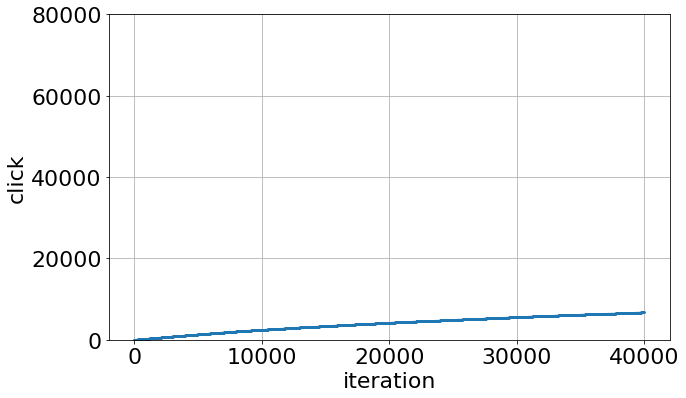

In [ ]:
itr_cumulated_click_count_mean = np.load('/content/itr_cumulated_click_count_mean_WOC_airbnb.npy')
itr_cumulated_click_count_std = np.load('/content/itr_cumulated_click_count_std_WOC_airbnb.npy')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax.plot(range(len(itr_cumulated_click_count_mean)), itr_cumulated_click_count_mean, marker='.', linewidth=1.5, markersize=1)
ax.fill_between(range(len(itr_cumulated_click_count_std)), itr_cumulated_click_count_mean-itr_cumulated_click_count_std, 
                itr_cumulated_click_count_mean+itr_cumulated_click_count_std, alpha=0.5)
ax.set_ylabel('click')
ax.set_xlabel('iteration')
ax.set_ylim(0., 80000)
ax.grid(True)
fig.patch.set_facecolor('white')
# plt.legend(loc='best')
plt.tight_layout()
plt.show()

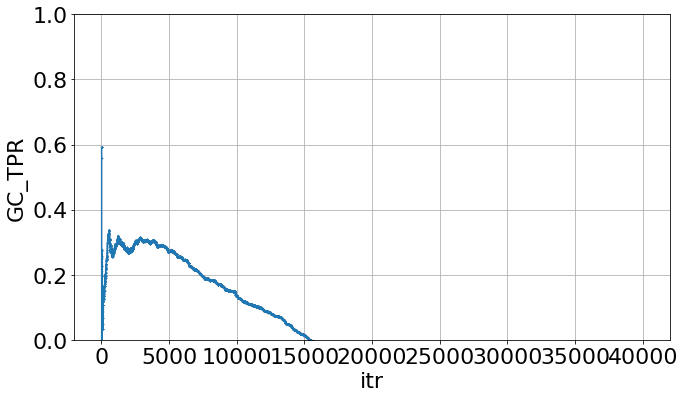

In [ ]:
itr_GC_TPR_mean = np.load('/content/itr_GC_TPR_mean_WOC_airbnb.npy')
itr_GC_TPR_std = np.load('/content/itr_GC_TPR_std_WOC_airbnb.npy')
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax.plot(range(len(itr_GC_TPR_mean)), itr_GC_TPR_mean, marker='.', linewidth=1.5, markersize=1)
ax.fill_between(range(len(itr_GC_TPR_mean)), itr_GC_TPR_mean-itr_GC_TPR_std, itr_GC_TPR_mean+itr_GC_TPR_std, alpha=0.5)
ax.set_ylabel('GC_TPR')
ax.set_xlabel('itr')
ax.set_ylim(0., 1)
ax.grid(True)
fig.patch.set_facecolor('white')
# plt.legend(loc='best')
plt.tight_layout()
plt.show()

#**All Experiments**

In [26]:
import matplotlib.pyplot as plt

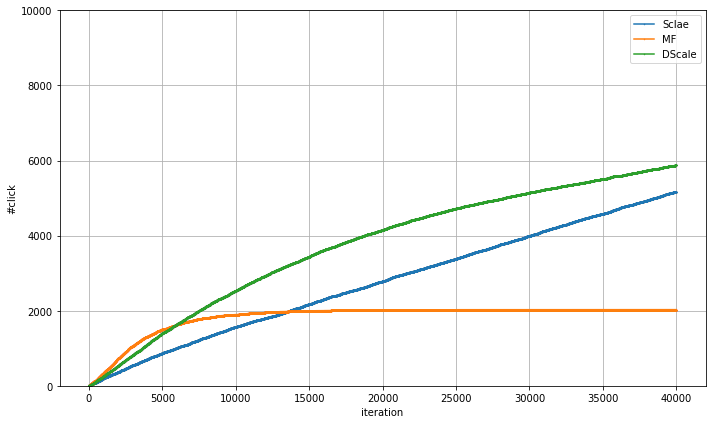

In [39]:
itr_cumulated_click_count_mean_s = np.load('/content/itr_cumulated_click_count_mean_S_airbnb.npy')
itr_cumulated_click_count_std_s = np.load('/content/itr_cumulated_click_count_std_S_airbnb.npy')
itr_cumulated_click_count_mean_wpb = np.load('/content/itr_cumulated_click_count_mean_ns_airbnb.npy')
itr_cumulated_click_count_std_wpb = np.load('/content/itr_cumulated_click_count_std_pb_airbnb.npy')
itr_cumulated_click_count_mean_d = np.load('/content/itr_cumulated_click_count_mean_pb_airbnb.npy')
itr_cumulated_click_count_std_d = np.load('/content/itr_cumulated_click_count_std_D_airbnb.npy')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax.plot(range(len(itr_cumulated_click_count_mean_s)), itr_cumulated_click_count_mean_s, marker='.', linewidth=1.5, markersize=1)
ax.fill_between(range(len(itr_cumulated_click_count_std_s)), itr_cumulated_click_count_mean_s-itr_cumulated_click_count_std_s, itr_cumulated_click_count_mean_s+itr_cumulated_click_count_std_s, alpha=0.5)
ax.plot(range(len(itr_cumulated_click_count_mean_wpb)), itr_cumulated_click_count_mean_wpb, marker='.', linewidth=1.5, markersize=1)
ax.fill_between(range(len(itr_cumulated_click_count_std_wpb)), itr_cumulated_click_count_mean_wpb-itr_cumulated_click_count_std_wpb, itr_cumulated_click_count_mean_wpb+itr_cumulated_click_count_std_wpb, alpha=0.5)
ax.plot(range(len(itr_cumulated_click_count_mean_d)), itr_cumulated_click_count_mean_d, marker='.', linewidth=1.5, markersize=1)
ax.fill_between(range(len(itr_cumulated_click_count_std_d)), itr_cumulated_click_count_mean_d-itr_cumulated_click_count_std_d, itr_cumulated_click_count_mean_d+itr_cumulated_click_count_std_d, alpha=0.5)
ax.set_ylabel('#click')
ax.set_xlabel('iteration')
ax.set_ylim(0., 10000)
ax.grid(True)
fig.patch.set_facecolor('white')
location = 0 # For the best location
legend_drawn_flag = True
plt.legend(["Sclae","MF", "DScale"], loc=0, frameon=legend_drawn_flag)
# plt.legend(loc='best')
plt.tight_layout()
plt.show()

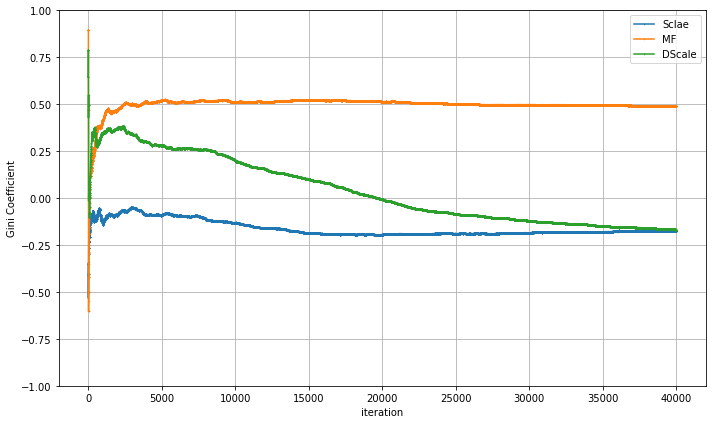

In [40]:
itr_GC_TPR_mean_s = np.load('/content/itr_GC_TPR_mean_S_airbnb.npy')
itr_GC_TPR_std_s = np.load('/content/itr_GC_TPR_std_S_airbnb.npy')
itr_GC_TPR_mean_wpb = np.load('/content/itr_GC_TPR_mean_pb_airbnb.npy')
itr_GC_TPR_std_wpb = np.load('/content/itr_GC_TPR_mean_pb_airbnb.npy')
itr_GC_TPR_mean_d = np.load('/content/itr_GC_TPR_mean_D_airbnb.npy')
itr_GC_TPR_std_d = np.load('/content/itr_GC_TPR_std_D_airbnb.npy')
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax.plot(range(len(itr_GC_TPR_mean_s)), itr_GC_TPR_mean_s, marker='.', linewidth=1.5, markersize=1)
ax.fill_between(range(len(itr_GC_TPR_mean_s)), itr_GC_TPR_mean_s-itr_GC_TPR_std_s, itr_GC_TPR_mean_s+itr_GC_TPR_std_s, alpha=0.5)
ax.plot(range(len(itr_GC_TPR_mean_wpb)), itr_GC_TPR_mean_wpb, marker='.', linewidth=1.5, markersize=1)
# ax.fill_between(range(len(itr_GC_TPR_mean_wpb)), itr_GC_TPR_mean_wpb-itr_GC_TPR_std_wpb, itr_GC_TPR_mean_wpb+itr_GC_TPR_std_wpb, alpha=0.5)
ax.plot(range(len(itr_GC_TPR_mean_d)), itr_GC_TPR_mean_d, marker='.', linewidth=1.5, markersize=1)
ax.fill_between(range(len(itr_GC_TPR_mean_d)), itr_GC_TPR_mean_d-itr_GC_TPR_std_d, itr_GC_TPR_mean_d+itr_GC_TPR_std_d, alpha=0.5)
ax.set_ylabel('Gini Coefficient')
ax.set_xlabel('iteration')
ax.set_ylim(-1., 1)
ax.grid(True)
fig.patch.set_facecolor('white')
location = 0 # For the best location
legend_drawn_flag = True
plt.legend(["Sclae","MF", "DScale"], loc=0, frameon=legend_drawn_flag)
# plt.legend(loc='best')
plt.tight_layout()
plt.show()

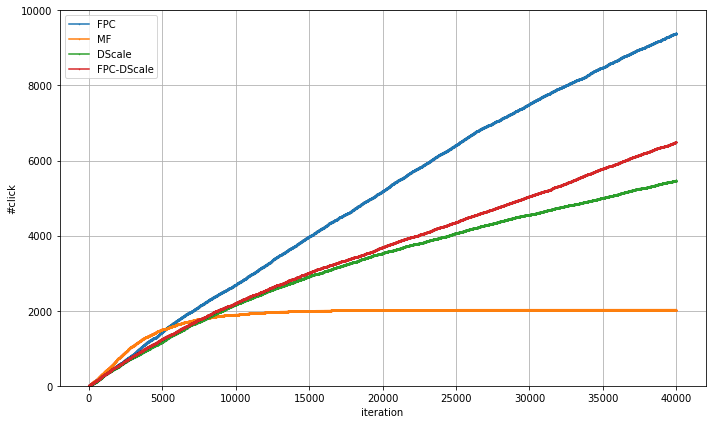

In [42]:
itr_cumulated_click_count_mean_f = np.load('/content/itr_cumulated_click_count_mean_F_airbnb.npy')
itr_cumulated_click_count_std_f = np.load('/content/itr_cumulated_click_count_std_F_airbnb.npy')
itr_GC_TPR_mean_wpb = np.load('/content/itr_GC_TPR_mean_pb_airbnb.npy')
itr_GC_TPR_std_wpb = np.load('/content/itr_GC_TPR_mean_pb_airbnb.npy')
itr_cumulated_click_count_mean_d = np.load('/content/itr_cumulated_click_count_mean_D_airbnb.npy')
itr_cumulated_click_count_std_d = np.load('/content/itr_cumulated_click_count_std_D_airbnb.npy')
itr_cumulated_click_count_mean_fd = np.load('/content/itr_cumulated_click_count_mean_FS_airbnb.npy')
itr_cumulated_click_count_std_fd = np.load('/content/itr_cumulated_click_count_std_FS_airbnb.npy')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax.plot(range(len(itr_cumulated_click_count_mean_f)), itr_cumulated_click_count_mean_f, marker='.', linewidth=1.5, markersize=1)
ax.fill_between(range(len(itr_cumulated_click_count_std_f)), itr_cumulated_click_count_mean_f-itr_cumulated_click_count_std_f, 
                itr_cumulated_click_count_mean_f+itr_cumulated_click_count_std_f, alpha=0.5)
ax.plot(range(len(itr_cumulated_click_count_mean_wpb)), itr_cumulated_click_count_mean_wpb, marker='.', linewidth=1.5, markersize=1)
# ax.fill_between(range(len(itr_cumulated_click_count_std_wpb)), itr_cumulated_click_count_mean_wpb-itr_cumulated_click_count_std_wpb, itr_cumulated_click_count_mean_wpb+itr_cumulated_click_count_std_wpb, alpha=0.5)
ax.plot(range(len(itr_cumulated_click_count_mean_d)), itr_cumulated_click_count_mean_d, marker='.', linewidth=1.5, markersize=1)
ax.fill_between(range(len(itr_cumulated_click_count_std_d)), itr_cumulated_click_count_mean_d-itr_cumulated_click_count_std_d, 
                itr_cumulated_click_count_mean_d+itr_cumulated_click_count_std_d, alpha=0.5)
ax.plot(range(len(itr_cumulated_click_count_mean_fd)), itr_cumulated_click_count_mean_fd, marker='.', linewidth=1.5, markersize=1)
ax.fill_between(range(len(itr_cumulated_click_count_std_fd)), itr_cumulated_click_count_mean_fd-itr_cumulated_click_count_std_fd, 
                itr_cumulated_click_count_mean_fd+itr_cumulated_click_count_std_fd, alpha=0.5)
ax.set_ylabel('#click')
ax.set_xlabel('iteration')
ax.set_ylim(0., 10000)
ax.grid(True)
fig.patch.set_facecolor('white')
location = 0 # For the best location
legend_drawn_flag = True
plt.legend(["FPC","MF", "DScale","FPC-DScale"], loc=0, frameon=legend_drawn_flag)
# plt.legend(loc='best')
plt.tight_layout()
plt.show()

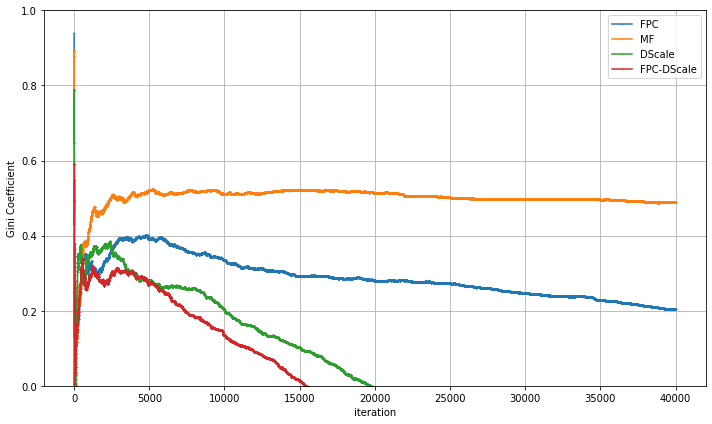

In [44]:
itr_GC_TPR_mean_f = np.load('/content/itr_GC_TPR_mean_F_airbnb.npy')
itr_GC_TPR_std_f = np.load('/content/itr_GC_TPR_std_F_airbnb.npy')
itr_GC_TPR_mean_wpb = np.load('/content/itr_GC_TPR_mean_pb_airbnb.npy')
itr_GC_TPR_std_wpb = np.load('/content/itr_GC_TPR_mean_pb_airbnb.npy')
itr_GC_TPR_mean_d = np.load('/content/itr_GC_TPR_mean_D_airbnb.npy')
itr_GC_TPR_std_d = np.load('/content/itr_GC_TPR_std_D_airbnb.npy')
itr_GC_TPR_mean_fd = np.load('/content/itr_GC_TPR_mean_FS_airbnb.npy')
itr_GC_TPR_std_fd = np.load('/content/itr_GC_TPR_std_FS_airbnb.npy')

    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax.plot(range(len(itr_GC_TPR_mean_f)), itr_GC_TPR_mean_f, marker='.', linewidth=1.5, markersize=1)
ax.fill_between(range(len(itr_GC_TPR_mean_f)), itr_GC_TPR_mean_f-itr_GC_TPR_std_f, itr_GC_TPR_mean_f+itr_GC_TPR_std_f, alpha=0.5)
ax.plot(range(len(itr_GC_TPR_mean_wpb)), itr_GC_TPR_mean_wpb, marker='.', linewidth=1.5, markersize=1)
# ax.fill_between(range(len(itr_GC_TPR_mean_wpb)), itr_GC_TPR_mean_wpb-itr_GC_TPR_std_wpb, itr_GC_TPR_mean_wpb+itr_GC_TPR_std_wpb, alpha=0.5)
ax.plot(range(len(itr_GC_TPR_mean_d)), itr_GC_TPR_mean_d, marker='.', linewidth=1.5, markersize=1)
ax.fill_between(range(len(itr_GC_TPR_mean_d)), itr_GC_TPR_mean_d-itr_GC_TPR_std_d, itr_GC_TPR_mean_d+itr_GC_TPR_std_d, alpha=0.5)
ax.plot(range(len(itr_GC_TPR_mean_fd)), itr_GC_TPR_mean_fd, marker='.', linewidth=1.5, markersize=1)
ax.fill_between(range(len(itr_GC_TPR_mean_fd)), itr_GC_TPR_mean_fd-itr_GC_TPR_std_fd, itr_GC_TPR_mean_fd+itr_GC_TPR_std_fd, alpha=0.5)


ax.set_ylabel('Gini Coefficient')
ax.set_xlabel('iteration')
ax.set_ylim(0., 1)
ax.grid(True)
fig.patch.set_facecolor('white')
location = 0 # For the best location
legend_drawn_flag = True
plt.legend(["FPC","MF", "DScale","FPC-DScale"], loc=0, frameon=legend_drawn_flag)
# plt.legend(loc='best')
plt.tight_layout()
plt.show()